In [1]:
# Design CIS 3D color router
# Resoultion 20 
# RGGB pattern
# First FoM: -22.775187623735164
# Current FoM: 264.1704627386973

# Elapsed run time = 57921.2683 s





# ## 1. Simulation Environment

import meep as mp
import meep.adjoint as mpa
import numpy as np
import nlopt
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
from matplotlib import pyplot as plt
import os

mp.verbosity(1)

seed = 240  # 난수 발생 시드(seed)를 240으로 설정 (재현성을 위해 난수 시드를 고정)
np.random.seed(seed)  # numpy의 난수 생성기의 시드를 설정하여 난수의 재현성 보장

design_dir = "./CIS_result/"

# 디렉터리가 없으면 생성
if not os.path.exists(design_dir):
    os.makedirs(design_dir)

# scaling & refractive index
um_scale = 1/0.675 # 1A = 675nm

Air = mp.Medium(index=1.0)
SiN = mp.Medium(index=2.1)
SiO2 = mp.Medium(index=1.4)
HfO2 = mp.Medium(index=1.9)
# SiPD = mp.Medium(epsilon=11.8)

# 해상도 및 사이즈 설정
resolution = 25 # 1 pixel = 27nm
ar_thk = 0.081 * um_scale # AR thickness
fl_size = 0.513 * um_scale # focal layer size
ml_size = 0.216 * um_scale # multi layer size
el_size = 0.027 * um_scale # etch layer size

dti_thk = ar_thk * 2 # DTI thickness 
sp_size = 0.621 * um_scale # subpixel size
# sp_size = 2 * um_scale # SiPD size

Lpml = 0.5 # PML 영역 크기
pml_layers = [mp.PML(thickness = Lpml)]
Sourcespace = 0.5

# 설계 공간
design_region_width_x = sp_size * 4 # 디자인 영역 x
design_region_width_y = sp_size * 4 # 디자인 영역 y
design_region_height = ml_size * 5 + el_size * 4 # 디자인 영역 높이 z

# 전체 공간
Sx = design_region_width_x + Lpml * 2 +0.5
Sy = design_region_width_y + Lpml * 2 +0.5
Sz = Lpml + ar_thk + fl_size + design_region_height + Sourcespace + Lpml
cell_size = mp.Vector3(Sx, Sy, Sz)


# 파장, 주파수 설정
wavelengths = np.linspace(0.425*um_scale, 0.655*um_scale, 24) 
frequencies = 1/wavelengths
nf = len(frequencies) # number of frequencies

# Fabrication Constraints 설정

minimum_length = 0.027 * um_scale # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
design_region_resolution = int(resolution)


# source 설정
width = 0.4

fcen_red = 1/(0.625*um_scale)
fwidth_red = fcen_red * width

fcen_green = 1/(0.545*um_scale)
fwidth_green = fcen_green * width

fcen_blue = 1/(0.455*um_scale)
fwidth_blue = fcen_blue * width

src_0 = mp.GaussianSource(frequency=fcen_red, fwidth=fwidth_red, is_integrated=True)

src_1 = mp.GaussianSource(frequency=fcen_green, fwidth=fwidth_green, is_integrated=True)

src_2 = mp.GaussianSource(frequency=fcen_blue, fwidth=fwidth_blue, is_integrated=True)

source_center = [0, 0, Sz / 2 - Lpml - Sourcespace / 2 ] # Source 위치
source_size = mp.Vector3(Sx, Sy, 0)

source = [mp.Source(src_0, component=mp.Ex, size=source_size, center=source_center,),mp.Source(src_0, component=mp.Ey, size=source_size, center=source_center,),
            mp.Source(src_1, component=mp.Ex, size=source_size, center=source_center,),mp.Source(src_1, component=mp.Ey, size=source_size, center=source_center,),
            mp.Source(src_2, component=mp.Ex, size=source_size, center=source_center,),mp.Source(src_2, component=mp.Ey, size=source_size, center=source_center,)]


# 설계 영역의 픽셀 - 해상도와 디자인 영역에 따라 결정
Nx = int(round(design_region_resolution * design_region_width_x)/2) 
Ny = int(round(design_region_resolution * design_region_width_y)/2) 
Nz = int(round(design_region_resolution * design_region_height))

# 설계 영역과 물질을 바탕으로 설계 영역 설정
design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny, Nz), SiO2, SiN, grid_type="U_MEAN",do_averaging=False)

design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0, 0, Sz / 2 - Lpml - Sourcespace - design_region_height/2),
        size=mp.Vector3(design_region_width_x, design_region_width_y, design_region_height),
    ),
)

# 대각선대칭

def mapping(x, eta, beta):
    x_copy = (x.reshape(Nx * Ny, Nz)).transpose()

    # projection
    z = 0
    x2 = []

    while z < Nz:
        
        number = z
        x1 = x_copy[int(number)]
        
        # filter
        filtered_field = mpa.conic_filter(
            x1,
            filter_radius,
            1.8,
            1.8,
            design_region_resolution,
        )
        
        z_slice = ((filtered_field.reshape(Nx, Ny)) + filtered_field.reshape(Nx, Ny).transpose()) / 2
        x2 = npa.concatenate((x2,z_slice.flatten()),axis=0) 
        z = z + 1

    x2 = ((x2.reshape(Nz,Nx*Ny)).transpose()).flatten()
    
    x2 = (x2.reshape(Nx * Ny, Nz)).transpose()
        
    # Compute the mean for the pairs of columns
    mean_columns_1layer = npa.mean(x2[:8, :], axis=0)  # Mean for columns 
    mean_columns_2layer = npa.mean(x2[9:17, :], axis=0)  # Mean for columns 
    mean_columns_3layer = npa.mean(x2[18:26, :], axis=0)  # Mean for columns 
    mean_columns_4layer = npa.mean(x2[27:35, :], axis=0)  # Mean for columns 
    mean_columns_5layer = npa.mean(x2[36:44, :], axis=0)  # Mean for columns 
    
    # Create new arrays with mean values
    new_x2_1layer = npa.tile(mean_columns_1layer, 8).reshape(8, -1).flatten()
    new_x2_1layer_e = npa.zeros(Nx * Ny).flatten()
    new_x2_2layer = npa.tile(mean_columns_2layer, 8).reshape(8, -1).flatten()
    new_x2_2layer_e = npa.zeros(Nx * Ny).flatten()
    new_x2_3layer = npa.tile(mean_columns_3layer, 8).reshape(8, -1).flatten()
    new_x2_3layer_e = npa.zeros(Nx * Ny).flatten()
    new_x2_4layer = npa.tile(mean_columns_4layer, 8).reshape(8, -1).flatten()
    new_x2_4layer_e = npa.zeros(Nx * Ny).flatten()
    new_x2_5layer = npa.tile(mean_columns_5layer, 8).reshape(8, -1).flatten()
    
    # Concatenate the arrays to get the final result
    x2 = npa.concatenate([new_x2_1layer, new_x2_1layer_e,new_x2_2layer, new_x2_2layer_e,new_x2_3layer, new_x2_3layer_e,new_x2_4layer, new_x2_4layer_e,new_x2_5layer],axis=0)
    x2 = ((x2.reshape(Nz,Nx*Ny)).transpose()).flatten()
    x2 = mpa.tanh_projection(x2, beta, eta).flatten()
    x = x2

    return x


# design region과 동일한 size의 Block 생성
geometry = [
    mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    ),

    # Focal Layer
    mp.Block(
        center=mp.Vector3(0, 0, Sz / 2 - Lpml - Sourcespace - design_region_height - fl_size/2), size=mp.Vector3(Sx, Sy, fl_size), material=SiO2
    ),

    #AR coating
    mp.Block(
        center=mp.Vector3(0, 0, Sz / 2 - Lpml - Sourcespace - design_region_height - fl_size - ar_thk/2 - Lpml/2), size=mp.Vector3(Sx, Sy, ar_thk + Lpml), material=HfO2
    ),

    # # DTI가 있을 경우 사용
    # mp.Block(
    #     center=mp.Vector3(Sx/4, Sy/4, -Sz/2 + ar_thk/2), size=mp.Vector3(subpixelsize, subpixelsize,  ar_thk), material=SiPD
    # ),
    # mp.Block(
    #     center=mp.Vector3(-Sx/4, -Sy/4, -Sz/2 + ar_thk/2), size=mp.Vector3(subpixelsize, subpixelsize,  ar_thk), material=SiPD
    # ),
    # mp.Block(
    #     center=mp.Vector3(Sx/4, -Sy/4, -Sz/2 + ar_thk/2), size=mp.Vector3(subpixelsize, subpixelsize,  ar_thk), material=SiPD
    # ),
    # mp.Block(
    #     center=mp.Vector3(-Sx/4, Sy/4, -Sz/2 + ar_thk/2), size=mp.Vector3(subpixelsize, subpixelsize,  ar_thk), material=SiPD
    # )
]

# Meep simulation 세팅

sim = mp.Simulation(
    cell_size=cell_size, 
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air, # 빈공간
    resolution=resolution,
    k_point = mp.Vector3(0,0,0)
)

###############################################################################################################################
# ## 2. Optimization Environment

# 모니터 위치와 크기 설정 (focal point)
monitor_position_0, monitor_size_0 = mp.Vector3(-design_region_width_x/4, design_region_width_y/4, -Sz/2 + Lpml + 0.5/resolution), mp.Vector3(0.01,0.01,0) 
monitor_position_1, monitor_size_1 = mp.Vector3(-design_region_width_x/4, -design_region_width_y/4, -Sz/2 + Lpml + 0.5/resolution), mp.Vector3(0.01,0.01,0) 
monitor_position_2, monitor_size_2 = mp.Vector3(design_region_width_x/4, -design_region_width_y/4, -Sz/2 + Lpml + 0.5/resolution), mp.Vector3(0.01,0.01,0) 
monitor_position_3, monitor_size_3 = mp.Vector3(design_region_width_x/4, design_region_width_y/4, -Sz/2 + Lpml + 0.5/resolution), mp.Vector3(0.01,0.01,0) 

# FourierFields를 통해 monitor_position에서 monitor_size만큼의 영역에 대한 Fourier transform을 구함

FourierFields_0_x = mpa.FourierFields(sim,mp.Volume(center=monitor_position_0,size=monitor_size_0),mp.Ex,yee_grid=True)

FourierFields_1_x = mpa.FourierFields(sim,mp.Volume(center=monitor_position_1,size=monitor_size_1),mp.Ex,yee_grid=True)

FourierFields_2_x = mpa.FourierFields(sim,mp.Volume(center=monitor_position_2,size=monitor_size_2),mp.Ex,yee_grid=True)

FourierFields_3_x = mpa.FourierFields(sim,mp.Volume(center=monitor_position_3,size=monitor_size_3),mp.Ex,yee_grid=True)

FourierFields_0_y = mpa.FourierFields(sim,mp.Volume(center=monitor_position_0,size=monitor_size_0),mp.Ey,yee_grid=True)

FourierFields_1_y = mpa.FourierFields(sim,mp.Volume(center=monitor_position_1,size=monitor_size_1),mp.Ey,yee_grid=True)

FourierFields_2_y = mpa.FourierFields(sim,mp.Volume(center=monitor_position_2,size=monitor_size_2),mp.Ey,yee_grid=True)

FourierFields_3_y = mpa.FourierFields(sim,mp.Volume(center=monitor_position_3,size=monitor_size_3),mp.Ey,yee_grid=True)

ob_list = [FourierFields_0_x, FourierFields_0_y, FourierFields_1_x,FourierFields_1_y, FourierFields_2_x, FourierFields_2_y, FourierFields_3_x, FourierFields_3_y]


fred = []
fgreen = []
fblue = []
# J : Objective function
# FourierFields가 측정한 필드, 모니터의 중심에서 E 구성요소의 절댓값을 제곱한 값을 취한 후 평균을 계산하여 평균 강도를 계산
# [frequency index, moniter index]
def J(fields_0_x, fields_0_y, fields_1_x, fields_1_y, fields_2_x, fields_2_y, fields_3_x, fields_3_y):
    red = npa.sum(npa.abs(fields_1_x[17:23,1]) ** 2)  + npa.sum(npa.abs(fields_1_y[17:23,1]) ** 2)
    green = npa.sum(npa.abs(fields_0_x[9:15,1]) ** 2) + npa.sum(npa.abs(fields_0_y[9:15,1]) ** 2) + npa.sum(npa.abs(fields_2_x[9:15,1]) ** 2) + npa.sum(npa.abs(fields_2_y[9:15,1]) ** 2)
    blue = npa.sum(npa.abs(fields_3_x[0:6,1]) ** 2) + npa.sum(npa.abs(fields_3_y[0:6,1]) ** 2)
    redfactor = 1
    greenfactor = 0.7
    bluefactor = 0.5
    
    red_c = npa.sum(npa.abs(fields_1_x[0:6,1]) ** 2)  + npa.sum(npa.abs(fields_1_y[0:6,1]) ** 2) + npa.sum(npa.abs(fields_1_x[9:15,1]) ** 2)  + npa.sum(npa.abs(fields_1_y[9:15,1]) ** 2)
    green_c = npa.sum(npa.abs(fields_0_x[0:6,1]) ** 2) + npa.sum(npa.abs(fields_0_y[0:6,1]) ** 2) + npa.sum(npa.abs(fields_2_x[0:6,1]) ** 2) + npa.sum(npa.abs(fields_2_y[0:6,1]) ** 2) + npa.sum(npa.abs(fields_0_x[17:23,1]) ** 2) + npa.sum(npa.abs(fields_0_y[17:23,1]) ** 2) + npa.sum(npa.abs(fields_2_x[17:23,1]) ** 2) + npa.sum(npa.abs(fields_2_y[17:23,1]) ** 2)
    blue_c = npa.sum(npa.abs(fields_3_x[9:15,1]) ** 2) + npa.sum(npa.abs(fields_3_y[9:15,1]) ** 2) + npa.sum(npa.abs(fields_3_x[17:23,1]) ** 2) + npa.sum(npa.abs(fields_3_y[17:23,1]) ** 2)
    
    fred.append(red/redfactor)
    fgreen.append(green/greenfactor)
    fblue.append(blue/bluefactor)
    OE = blue/bluefactor + green/greenfactor + red/redfactor
    CT = blue_c/bluefactor + green_c/greenfactor + red_c/redfactor
    return OE - CT

# optimization 설정

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies,
    decay_by=1e-3,
)

# 함수 설정

evaluation_history = []
cur_iter = [0]
numevl = 1

def f(v, gradient, beta):
    global numevl
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, beta)])  # compute objective and gradient
    # f0, dJ_du = opt()

    # Adjoint gradient
    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, beta, np.sum(dJ_du, axis=1)
        )  # backprop

    evaluation_history.append(np.real(f0))

    np.savetxt(design_dir+"structure_0"+str(numevl) +".txt", design_variables.weights)
    
    numevl += 1
    
    print("First FoM: {}".format(evaluation_history[0]))
    print("Current FoM: {}".format(np.real(f0)))

    cur_iter[0] = cur_iter[0] + 1

    return np.real(f0)


/home/user/anaconda3/envs/mp/lib/python3.11/site-packages/meep/visualization.py:271: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)


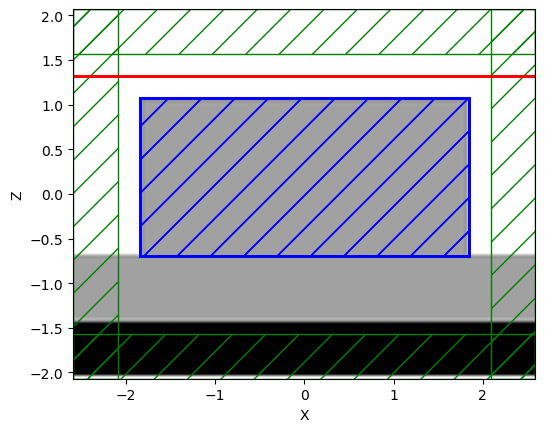

In [2]:
opt.plot2D(True,output_plane = mp.Volume(size = (np.inf, 0, np.inf), center = (0,0,0)))

In [3]:
print(design_variables.weights)

[0. 0. 0. ... 0. 0. 0.]


In [4]:
f0, dJ_du = opt()

Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000433922 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34425 s
-----------
on time step 55 (time=1.1), 0.0727281 s/step
on time step 183 (time=3.66), 0.0314089 s/step
on time step 313 (time=6.26), 0.0308858 s/step
on time step 443 (time=8.86), 0.0308807 s/step
on time step 572 (time=11.44), 0.0311021 s/step
on time step 701 (time=14.02), 0.0312042 s/step
on time step 831 (time=16.62), 0

/home/user/anaconda3/envs/mp/lib/python3.11/site-packages/meep/adjoint/filter_source.py:175: RuntimeWarning: divide by zero encountered in divide
  l2_err = np.sum(np.abs(H - H_hat.T) ** 2 / np.abs(H) ** 2)
/home/user/anaconda3/envs/mp/lib/python3.11/site-packages/meep/adjoint/filter_source.py:175: RuntimeWarning: invalid value encountered in divide
  l2_err = np.sum(np.abs(H - H_hat.T) ** 2 / np.abs(H) ** 2)


on time step 88 (time=1.76), 0.0455526 s/step
on time step 200 (time=4), 0.0359317 s/step
on time step 306 (time=6.12), 0.0377854 s/step
on time step 414 (time=8.28), 0.0370651 s/step
on time step 522 (time=10.44), 0.0370866 s/step
on time step 630 (time=12.6), 0.0370454 s/step
on time step 740 (time=14.8), 0.036667 s/step
on time step 851 (time=17.02), 0.0362709 s/step
on time step 963 (time=19.26), 0.0359744 s/step
on time step 1076 (time=21.52), 0.0356277 s/step
on time step 1187 (time=23.74), 0.036196 s/step
on time step 1296 (time=25.92), 0.0369435 s/step
on time step 1407 (time=28.14), 0.0361585 s/step
on time step 1514 (time=30.28), 0.0374003 s/step
on time step 1624 (time=32.48), 0.0365261 s/step
on time step 1728 (time=34.56), 0.0386697 s/step
on time step 1834 (time=36.68), 0.037836 s/step
on time step 1940 (time=38.8), 0.037761 s/step
on time step 2049 (time=40.98), 0.0371151 s/step
on time step 2158 (time=43.16), 0.0369066 s/step
on time step 2266 (time=45.32), 0.0370646 s/

In [5]:
print(dJ_du)
print(f0)


[[ 4.97142325e-04  2.79350033e-03  3.03769208e-03 ... -1.27724757e-03
  -1.13891175e-03 -2.17409289e-07]
 [ 9.42667682e-04  2.53201840e-03  2.02972873e-03 ... -1.22424577e-03
  -9.20434499e-04 -4.05135122e-06]
 [ 1.26398093e-03  2.24387538e-03  1.57185534e-03 ... -9.61430390e-04
  -6.07893969e-04 -6.24917220e-06]
 ...
 [-6.79133180e-04 -1.45117792e-04  1.05880562e-03 ...  1.47130327e-03
   1.70639329e-03 -1.18731662e-05]
 [-6.53058005e-04 -3.02088230e-04  4.60350738e-04 ...  1.30816566e-03
   1.65824138e-03 -8.57617553e-06]
 [-4.04944918e-04 -2.59702465e-04 -4.08033761e-05 ...  7.31813366e-04
   1.08634155e-03 -5.41990110e-06]]
-110.03927201510318


In [6]:
print(design_variables.weights)

[0. 0. 0. ... 0. 0. 0.]


In [7]:
db = 1e-5
choose = 1000
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose, db=db)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000293016 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.66128 s
-----------
on time step 35 (time=0.7), 0.114895 s/step
on time step 116 (time=2.32), 0.0494132 s/step
on time step 197 (time=3.94), 0.0494072 s/step
on time step 278 (time=5.56), 0.0494053 s/step
on time step 360 (time=7.2), 0.0493735 s/step
on time step 440 (time=8.8), 0.0503668 s/step
on time step 516 (time=10.32), 0.0532502 s/step
on time step 

run 2 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00027585 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.4203 s
-----------
on time step 37 (time=0.74), 0.108504 s/step
on time step 117 (time=2.34), 0.0503668 s/step
on time step 196 (time=3.92), 0.0508868 s/step
on time step 275 (time=5.5), 0.0507142 s/step
on time step 354 (time=7.08), 0.050896 s/step
on time step 433 (time=8.66), 0.0508364 s/step
on time step 512 (

run 3 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00028801 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.48643 s
-----------
on time step 30 (time=0.6), 0.134694 s/step
on time step 109 (time=2.18), 0.0510231 s/step
on time step 188 (time=3.76), 0.0507812 s/step
on time step 266 (time=5.32), 0.0515046 s/step
on time step 345 (time=6.9), 0.0511663 s/step
on time step 423 (time=8.46), 0.0513555 s/step
on time step 501 

run 4 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000299931 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.682 s
-----------
on time step 35 (time=0.7), 0.115363 s/step
on time step 113 (time=2.26), 0.051341 s/step
on time step 193 (time=3.86), 0.0506351 s/step
on time step 271 (time=5.42), 0.0513889 s/step
on time step 344 (time=6.88), 0.0551449 s/step
on time step 415 (time=8.3), 0.0564177 s/step
on time step 488 (t

-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.67781 s
-----------
on time step 38 (time=0.76), 0.106399 s/step
on time step 131 (time=2.62), 0.0433855 s/step
on time step 226 (time=4.52), 0.0421903 s/step
on time step 315 (time=6.3), 0.0453732 s/step
on time step 406 (time=8.12), 0.0441957 s/step
on time step 497 (time=9.94), 0.0439762 s/step
on time step 583 (time=11.66), 0.046781 s/step
on time step

run 6 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000289917 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.8824 s
-----------
on time step 41 (time=0.82), 0.0978966 s/step
on time step 133 (time=2.66), 0.0437524 s/step
on time step 230 (time=4.6), 0.0413615 s/step
on time step 316 (time=6.32), 0.0466568 s/step
on time step 414 (time=8.28), 0.0409436 s/step
on time step 513 (time=10.26), 0.0404841 s/step
on time step 6

-----------
Initializing structure...
time for choose_chunkdivision = 0.000279188 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.63859 s
-----------
on time step 43 (time=0.86), 0.0931657 s/step
on time step 164 (time=3.28), 0.0331301 s/step
on time step 297 (time=5.94), 0.0302067 s/step
on time step 430 (time=8.6), 0.0301875 s/step
on time step 564 (time=11.28), 0.0299528 s/step
on time step 703 (time=14.06), 0.0289383 s/step
on time step 842 (time=16.84), 0.0289138 s/step
on time 

run 8 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.43115 s
-----------
on time step 61 (time=1.22), 0.0657627 s/step
on time step 199 (time=3.98), 0.0289996 s/step
on time step 337 (time=6.74), 0.0289997 s/step
on time step 473 (time=9.46), 0.0294424 s/step
on time step 612 (time=12.24), 0.0289012 s/step
on time step 749 (time=14.98), 0.0292045 s/step
on time ste

run 9 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.42584 s
-----------
on time step 63 (time=1.26), 0.0636564 s/step
on time step 202 (time=4.04), 0.0289773 s/step
on time step 342 (time=6.84), 0.0286616 s/step
on time step 481 (time=9.62), 0.0288038 s/step
on time step 620 (time=12.4), 0.0289397 s/step
on time step 752 (time=15.04), 0.0305223 s/step
on time step

run 10 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000281811 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.67953 s
-----------
on time step 61 (time=1.22), 0.065654 s/step
on time step 196 (time=3.92), 0.0297122 s/step
on time step 329 (time=6.58), 0.0302461 s/step
on time step 460 (time=9.2), 0.0305591 s/step
on time step 588 (time=11.76), 0.031329 s/step
on time step 714 (time=14.28), 0.0319364 s/step
on time step 

-----------
Initializing structure...
time for choose_chunkdivision = 0.000288963 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.76926 s
-----------
on time step 41 (time=0.82), 0.0978642 s/step
on time step 135 (time=2.7), 0.0428243 s/step
on time step 233 (time=4.66), 0.0408349 s/step
on time step 328 (time=6.56), 0.0422788 s/step
on time step 444 (time=8.88), 0.0346551 s/step
on time step 570 (time=11.4), 0.0318327 s/step
on time step 702 (time=14.04), 0.0304174 s/step
on time st

run 12 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.46564 s
-----------
on time step 61 (time=1.22), 0.0658457 s/step
on time step 196 (time=3.92), 0.0298325 s/step
on time step 327 (time=6.54), 0.0305825 s/step
on time step 455 (time=9.1), 0.0313488 s/step
on time step 592 (time=11.84), 0.0293315 s/step
on time step 723 (time=14.46), 0.030704 s/step
on time step

run 13 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000302076 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.49184 s
-----------
on time step 61 (time=1.22), 0.065902 s/step
on time step 201 (time=4.02), 0.028639 s/step
on time step 340 (time=6.8), 0.0289647 s/step
on time step 481 (time=9.62), 0.0283959 s/step
on time step 623 (time=12.46), 0.0283748 s/step
on time step 760 (time=15.2), 0.0293852 s/step
on time step 8

run 14 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.337 s
-----------
on time step 64 (time=1.28), 0.0627797 s/step
on time step 206 (time=4.12), 0.0282552 s/step
on time step 319 (time=6.38), 0.0354046 s/step
on time step 431 (time=8.62), 0.0357495 s/step
on time step 544 (time=10.88), 0.0356093 s/step
on time step 656 (time=13.12), 0.0357279 s/step
on time step

run 15 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34776 s
-----------
on time step 51 (time=1.02), 0.0786709 s/step
on time step 164 (time=3.28), 0.0356886 s/step
on time step 276 (time=5.52), 0.0358282 s/step
on time step 388 (time=7.76), 0.0357234 s/step
on time step 501 (time=10.02), 0.0356227 s/step
on time step 612 (time=12.24), 0.0360413 s/step
on time st

run 16 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34214 s
-----------
on time step 51 (time=1.02), 0.0787737 s/step
on time step 164 (time=3.28), 0.0356227 s/step
on time step 277 (time=5.54), 0.0356497 s/step
on time step 390 (time=7.8), 0.0355938 s/step
on time step 503 (time=10.06), 0.0355224 s/step
on time step 616 (time=12.32), 0.0357149 s/step
on time ste

run 17 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.31623 s
-----------
on time step 65 (time=1.3), 0.0616314 s/step
on time step 207 (time=4.14), 0.0283431 s/step
on time step 350 (time=7), 0.0280968 s/step
on time step 494 (time=9.88), 0.0279629 s/step
on time step 637 (time=12.74), 0.0280691 s/step
on time step 780 (time=15.6), 0.0280416 s/step
on time step 92

run 18 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27737 s
-----------
on time step 65 (time=1.3), 0.0616636 s/step
on time step 208 (time=4.16), 0.0281055 s/step
on time step 351 (time=7.02), 0.0280309 s/step
on time step 494 (time=9.88), 0.0279739 s/step
on time step 638 (time=12.76), 0.0279512 s/step
on time step 782 (time=15.64), 0.0279334 s/step
on time ste

run 19 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27752 s
-----------
on time step 65 (time=1.3), 0.0617657 s/step
on time step 208 (time=4.16), 0.02807 s/step
on time step 351 (time=7.02), 0.0281225 s/step
on time step 494 (time=9.88), 0.0280556 s/step
on time step 638 (time=12.76), 0.0279607 s/step
on time step 781 (time=15.62), 0.0280487 s/step
on time step 

run 20 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2754 s
-----------
on time step 65 (time=1.3), 0.0617081 s/step
on time step 208 (time=4.16), 0.028041 s/step
on time step 351 (time=7.02), 0.0280351 s/step
on time step 494 (time=9.88), 0.0280622 s/step
on time step 637 (time=12.74), 0.0281147 s/step
on time step 780 (time=15.6), 0.0280924 s/step
on time step 9

run 21 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.30924 s
-----------
on time step 66 (time=1.32), 0.0606962 s/step
on time step 209 (time=4.18), 0.0280324 s/step
on time step 352 (time=7.04), 0.0279848 s/step
on time step 495 (time=9.9), 0.0279804 s/step
on time step 639 (time=12.78), 0.0279245 s/step
on time step 783 (time=15.66), 0.0278955 s/step
on time ste

run 22 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27868 s
-----------
on time step 66 (time=1.32), 0.0609043 s/step
on time step 207 (time=4.14), 0.0285069 s/step
on time step 350 (time=7), 0.0281083 s/step
on time step 490 (time=9.8), 0.0286209 s/step
on time step 632 (time=12.64), 0.0281937 s/step
on time step 774 (time=15.48), 0.0281783 s/step
on time step 9

run 23 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000285149 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28066 s
-----------
on time step 66 (time=1.32), 0.0607983 s/step
on time step 209 (time=4.18), 0.0280666 s/step
on time step 353 (time=7.06), 0.0279047 s/step
on time step 495 (time=9.9), 0.0282267 s/step
on time step 638 (time=12.76), 0.0280077 s/step
on time step 782 (time=15.64), 0.0279549 s/step
on time ste

run 24 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28872 s
-----------
on time step 65 (time=1.3), 0.0616543 s/step
on time step 207 (time=4.14), 0.0283215 s/step
on time step 349 (time=6.98), 0.0283265 s/step
on time step 492 (time=9.84), 0.028001 s/step
on time step 635 (time=12.7), 0.0280534 s/step
on time step 778 (time=15.56), 0.0281328 s/step
on time step 

run 25 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253201 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52301 s
-----------
on time step 65 (time=1.3), 0.0617242 s/step
on time step 209 (time=4.18), 0.0278925 s/step
on time step 353 (time=7.06), 0.0278752 s/step
on time step 497 (time=9.94), 0.0279441 s/step
on time step 641 (time=12.82), 0.0278767 s/step
on time step 784 (time=15.68), 0.0279848 s/step
on time ste

run 26 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250816 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27365 s
-----------
on time step 66 (time=1.32), 0.0606216 s/step
on time step 210 (time=4.2), 0.0278136 s/step
on time step 354 (time=7.08), 0.0278378 s/step
on time step 499 (time=9.98), 0.0277016 s/step
on time step 644 (time=12.88), 0.0276975 s/step
on time step 789 (time=15.78), 0.0276749 s/step
on time ste

run 27 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28761 s
-----------
on time step 67 (time=1.34), 0.0601036 s/step
on time step 213 (time=4.26), 0.0275794 s/step
on time step 358 (time=7.16), 0.0276019 s/step
on time step 503 (time=10.06), 0.0276723 s/step
on time step 648 (time=12.96), 0.0276951 s/step
on time step 793 (time=15.86), 0.0276389 s/step
on time s

run 28 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26956 s
-----------
on time step 66 (time=1.32), 0.0606125 s/step
on time step 210 (time=4.2), 0.0278378 s/step
on time step 355 (time=7.1), 0.0277172 s/step
on time step 500 (time=10), 0.0277742 s/step
on time step 645 (time=12.9), 0.027766 s/step
on time step 790 (time=15.8), 0.0277545 s/step
on time step 935 

run 29 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.36476 s
-----------
on time step 67 (time=1.34), 0.059952 s/step
on time step 212 (time=4.24), 0.0276652 s/step
on time step 357 (time=7.14), 0.0276174 s/step
on time step 502 (time=10.04), 0.0276239 s/step
on time step 647 (time=12.94), 0.027612 s/step
on time step 792 (time=15.84), 0.0276471 s/step
on time ste

run 30 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25855 s
-----------
on time step 67 (time=1.34), 0.0599441 s/step
on time step 213 (time=4.26), 0.0275662 s/step
on time step 358 (time=7.16), 0.0275918 s/step
on time step 504 (time=10.08), 0.0275839 s/step
on time step 650 (time=13), 0.0275774 s/step
on time step 795 (time=15.9), 0.0276014 s/step
on time step 

run 31 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51179 s
-----------
on time step 67 (time=1.34), 0.0599476 s/step
on time step 212 (time=4.24), 0.0276835 s/step
on time step 357 (time=7.14), 0.0276997 s/step
on time step 502 (time=10.04), 0.027639 s/step
on time step 647 (time=12.94), 0.0276524 s/step
on time step 792 (time=15.84), 0.0276978 s/step
on time st

run 32 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000287056 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26555 s
-----------
on time step 66 (time=1.32), 0.0606535 s/step
on time step 211 (time=4.22), 0.0276034 s/step
on time step 356 (time=7.12), 0.0275967 s/step
on time step 499 (time=9.98), 0.0280526 s/step
on time step 644 (time=12.88), 0.0276683 s/step
on time step 789 (time=15.78), 0.0276807 s/step
on time st

run 33 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26528 s
-----------
on time step 67 (time=1.34), 0.0599603 s/step
on time step 212 (time=4.24), 0.0276766 s/step
on time step 355 (time=7.1), 0.0280364 s/step
on time step 500 (time=10), 0.0276601 s/step
on time step 645 (time=12.9), 0.0276902 s/step
on time step 789 (time=15.78), 0.0278598 s/step
on time step 9

run 34 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26072 s
-----------
on time step 67 (time=1.34), 0.0600626 s/step
on time step 212 (time=4.24), 0.0277624 s/step
on time step 357 (time=7.14), 0.0276736 s/step
on time step 501 (time=10.02), 0.0278548 s/step
on time step 645 (time=12.9), 0.0278507 s/step
on time step 789 (time=15.78), 0.0278924 s/step
on time st

run 35 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27816 s
-----------
on time step 66 (time=1.32), 0.0606223 s/step
on time step 210 (time=4.2), 0.0278777 s/step
on time step 354 (time=7.08), 0.0278683 s/step
on time step 498 (time=9.96), 0.02784 s/step
on time step 642 (time=12.84), 0.0278322 s/step
on time step 786 (time=15.72), 0.0278435 s/step
on time step 

run 36 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26581 s
-----------
on time step 67 (time=1.34), 0.0600164 s/step
on time step 212 (time=4.24), 0.0276607 s/step
on time step 357 (time=7.14), 0.0276938 s/step
on time step 502 (time=10.04), 0.0277069 s/step
on time step 647 (time=12.94), 0.0276839 s/step
on time step 792 (time=15.84), 0.0276392 s/step
on time s

run 37 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26622 s
-----------
on time step 67 (time=1.34), 0.0598878 s/step
on time step 211 (time=4.22), 0.0278389 s/step
on time step 355 (time=7.1), 0.0279561 s/step
on time step 498 (time=9.96), 0.0280697 s/step
on time step 641 (time=12.82), 0.027996 s/step
on time step 784 (time=15.68), 0.0280239 s/step
on time step

run 38 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26049 s
-----------
on time step 66 (time=1.32), 0.06071 s/step
on time step 211 (time=4.22), 0.0277499 s/step
on time step 356 (time=7.12), 0.0276893 s/step
on time step 501 (time=10.02), 0.0276854 s/step
on time step 646 (time=12.92), 0.027773 s/step
on time step 791 (time=15.82), 0.0277113 s/step
on time step

run 39 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27334 s
-----------
on time step 67 (time=1.34), 0.0599442 s/step
on time step 212 (time=4.24), 0.0276592 s/step
on time step 357 (time=7.14), 0.0276791 s/step
on time step 502 (time=10.04), 0.0276059 s/step
on time step 648 (time=12.96), 0.0275829 s/step
on time step 793 (time=15.86), 0.0275949 s/step
on time s

run 40 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2674 s
-----------
on time step 67 (time=1.34), 0.0598462 s/step
on time step 212 (time=4.24), 0.0276559 s/step
on time step 357 (time=7.14), 0.0276864 s/step
on time step 502 (time=10.04), 0.0277128 s/step
on time step 646 (time=12.92), 0.0277879 s/step
on time step 791 (time=15.82), 0.0277508 s/step
on time st

run 41 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268221 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26388 s
-----------
on time step 67 (time=1.34), 0.0599379 s/step
on time step 212 (time=4.24), 0.0277016 s/step
on time step 355 (time=7.1), 0.0280484 s/step
on time step 500 (time=10), 0.0276972 s/step
on time step 645 (time=12.9), 0.0277232 s/step
on time step 789 (time=15.78), 0.0277996 s/step
on time step 9

run 42 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2952 s
-----------
on time step 67 (time=1.34), 0.0600862 s/step
on time step 211 (time=4.22), 0.0279154 s/step
on time step 353 (time=7.06), 0.0283636 s/step
on time step 498 (time=9.96), 0.027761 s/step
on time step 642 (time=12.84), 0.0277951 s/step
on time step 786 (time=15.72), 0.0278287 s/step
on time step

run 43 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2672 s
-----------
on time step 67 (time=1.34), 0.060095 s/step
on time step 211 (time=4.22), 0.0277842 s/step
on time step 355 (time=7.1), 0.0278627 s/step
on time step 500 (time=10), 0.0277729 s/step
on time step 644 (time=12.88), 0.0278019 s/step
on time step 788 (time=15.76), 0.0279381 s/step
on time step 93

run 44 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.30793 s
-----------
on time step 66 (time=1.32), 0.0607088 s/step
on time step 211 (time=4.22), 0.0277113 s/step
on time step 356 (time=7.12), 0.0277524 s/step
on time step 501 (time=10.02), 0.0277509 s/step
on time step 645 (time=12.9), 0.0277789 s/step
on time step 789 (time=15.78), 0.0279076 s/step
on time st

run 45 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26796 s
-----------
on time step 67 (time=1.34), 0.0600737 s/step
on time step 211 (time=4.22), 0.0279019 s/step
on time step 354 (time=7.08), 0.0280569 s/step
on time step 498 (time=9.96), 0.0279637 s/step
on time step 642 (time=12.84), 0.0279111 s/step
on time step 786 (time=15.72), 0.0279037 s/step
on time st

run 46 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26871 s
-----------
on time step 66 (time=1.32), 0.0606643 s/step
on time step 210 (time=4.2), 0.0279618 s/step
on time step 355 (time=7.1), 0.0277688 s/step
on time step 499 (time=9.98), 0.0279274 s/step
on time step 644 (time=12.88), 0.02775 s/step
on time step 788 (time=15.76), 0.0277822 s/step
on time step 9

run 47 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27037 s
-----------
on time step 67 (time=1.34), 0.0599126 s/step
on time step 211 (time=4.22), 0.0279202 s/step
on time step 356 (time=7.12), 0.0277089 s/step
on time step 501 (time=10.02), 0.027689 s/step
on time step 646 (time=12.92), 0.0277139 s/step
on time step 791 (time=15.82), 0.0277295 s/step
on time st

run 48 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26556 s
-----------
on time step 67 (time=1.34), 0.0598287 s/step
on time step 212 (time=4.24), 0.0276597 s/step
on time step 356 (time=7.12), 0.0278604 s/step
on time step 500 (time=10), 0.0278791 s/step
on time step 644 (time=12.88), 0.0278672 s/step
on time step 788 (time=15.76), 0.0278221 s/step
on time step

run 49 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2662 s
-----------
on time step 67 (time=1.34), 0.059979 s/step
on time step 210 (time=4.2), 0.0280825 s/step
on time step 354 (time=7.08), 0.0278363 s/step
on time step 498 (time=9.96), 0.0277826 s/step
on time step 642 (time=12.84), 0.0278161 s/step
on time step 787 (time=15.74), 0.0277396 s/step
on time step 

run 50 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27398 s
-----------
on time step 66 (time=1.32), 0.0606424 s/step
on time step 210 (time=4.2), 0.0279304 s/step
on time step 352 (time=7.04), 0.0282473 s/step
on time step 496 (time=9.92), 0.0278982 s/step
on time step 640 (time=12.8), 0.0279038 s/step
on time step 784 (time=15.68), 0.0278474 s/step
on time step

run 51 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2687 s
-----------
on time step 67 (time=1.34), 0.0598996 s/step
on time step 211 (time=4.22), 0.0278734 s/step
on time step 355 (time=7.1), 0.0278183 s/step
on time step 499 (time=9.98), 0.0278617 s/step
on time step 643 (time=12.86), 0.0278502 s/step
on time step 787 (time=15.74), 0.0278593 s/step
on time step

run 52 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26659 s
-----------
on time step 67 (time=1.34), 0.0600863 s/step
on time step 211 (time=4.22), 0.0278814 s/step
on time step 355 (time=7.1), 0.0278424 s/step
on time step 499 (time=9.98), 0.0278553 s/step
on time step 643 (time=12.86), 0.0279414 s/step
on time step 787 (time=15.74), 0.0278968 s/step
on time ste

run 53 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25951 s
-----------
on time step 67 (time=1.34), 0.05986 s/step
on time step 212 (time=4.24), 0.027672 s/step
on time step 357 (time=7.14), 0.0276743 s/step
on time step 502 (time=10.04), 0.0277629 s/step
on time step 647 (time=12.94), 0.0276427 s/step
on time step 792 (time=15.84), 0.0276604 s/step
on time step

run 54 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50748 s
-----------
on time step 67 (time=1.34), 0.0600068 s/step
on time step 212 (time=4.24), 0.027614 s/step
on time step 358 (time=7.16), 0.0275394 s/step
on time step 503 (time=10.06), 0.0276973 s/step
on time step 648 (time=12.96), 0.027718 s/step
on time step 793 (time=15.86), 0.0276522 s/step
on time ste

run 55 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27496 s
-----------
on time step 67 (time=1.34), 0.0598509 s/step
on time step 212 (time=4.24), 0.0276394 s/step
on time step 356 (time=7.12), 0.0278213 s/step
on time step 501 (time=10.02), 0.0277419 s/step
on time step 646 (time=12.92), 0.0277609 s/step
on time step 790 (time=15.8), 0.0277971 s/step
on time st

run 56 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000279903 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.29046 s
-----------
on time step 66 (time=1.32), 0.0606725 s/step
on time step 210 (time=4.2), 0.027816 s/step
on time step 355 (time=7.1), 0.0277298 s/step
on time step 499 (time=9.98), 0.0278306 s/step
on time step 643 (time=12.86), 0.0277991 s/step
on time step 787 (time=15.74), 0.0278074 s/step
on time step 

run 57 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26425 s
-----------
on time step 67 (time=1.34), 0.0598469 s/step
on time step 212 (time=4.24), 0.0277154 s/step
on time step 357 (time=7.14), 0.0276799 s/step
on time step 502 (time=10.04), 0.0277254 s/step
on time step 647 (time=12.94), 0.0276864 s/step
on time step 791 (time=15.82), 0.0278015 s/step
on time s

run 58 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000281811 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27059 s
-----------
on time step 67 (time=1.34), 0.0598769 s/step
on time step 212 (time=4.24), 0.0276744 s/step
on time step 357 (time=7.14), 0.0276778 s/step
on time step 502 (time=10.04), 0.0276806 s/step
on time step 647 (time=12.94), 0.0276867 s/step
on time step 792 (time=15.84), 0.027659 s/step
on time st

run 59 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27215 s
-----------
on time step 67 (time=1.34), 0.0599138 s/step
on time step 212 (time=4.24), 0.0277339 s/step
on time step 357 (time=7.14), 0.0276795 s/step
on time step 502 (time=10.04), 0.0276185 s/step
on time step 647 (time=12.94), 0.0277237 s/step
on time step 792 (time=15.84), 0.0276998 s/step
on time st

run 60 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253201 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27057 s
-----------
on time step 67 (time=1.34), 0.0601005 s/step
on time step 212 (time=4.24), 0.0277514 s/step
on time step 356 (time=7.12), 0.0277888 s/step
on time step 501 (time=10.02), 0.0276571 s/step
on time step 645 (time=12.9), 0.0277803 s/step
on time step 790 (time=15.8), 0.0276523 s/step
on time ste

run 61 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26368 s
-----------
on time step 67 (time=1.34), 0.0599395 s/step
on time step 212 (time=4.24), 0.0275999 s/step
on time step 358 (time=7.16), 0.0275808 s/step
on time step 503 (time=10.06), 0.0276287 s/step
on time step 648 (time=12.96), 0.0275864 s/step
on time step 793 (time=15.86), 0.027605 s/step
on time st

run 62 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26763 s
-----------
on time step 67 (time=1.34), 0.0599335 s/step
on time step 212 (time=4.24), 0.0276612 s/step
on time step 357 (time=7.14), 0.0276486 s/step
on time step 502 (time=10.04), 0.0276259 s/step
on time step 647 (time=12.94), 0.0276383 s/step
on time step 792 (time=15.84), 0.0276157 s/step
on time s

run 63 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27333 s
-----------
on time step 66 (time=1.32), 0.0606942 s/step
on time step 209 (time=4.18), 0.0281307 s/step
on time step 352 (time=7.04), 0.0281062 s/step
on time step 495 (time=9.9), 0.0281334 s/step
on time step 637 (time=12.74), 0.0281851 s/step
on time step 780 (time=15.6), 0.0281193 s/step
on time step

run 64 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27348 s
-----------
on time step 67 (time=1.34), 0.0598053 s/step
on time step 212 (time=4.24), 0.0276694 s/step
on time step 357 (time=7.14), 0.0276255 s/step
on time step 502 (time=10.04), 0.0276759 s/step
on time step 647 (time=12.94), 0.0276133 s/step
on time step 791 (time=15.82), 0.0277781 s/step
on time s

run 65 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26174 s
-----------
on time step 67 (time=1.34), 0.0600199 s/step
on time step 212 (time=4.24), 0.0277406 s/step
on time step 356 (time=7.12), 0.0278334 s/step
on time step 500 (time=10), 0.0279029 s/step
on time step 644 (time=12.88), 0.0277899 s/step
on time step 789 (time=15.78), 0.0277358 s/step
on time step

run 66 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26317 s
-----------
on time step 66 (time=1.32), 0.060859 s/step
on time step 210 (time=4.2), 0.0278056 s/step
on time step 355 (time=7.1), 0.0277298 s/step
on time step 500 (time=10), 0.0276517 s/step
on time step 645 (time=12.9), 0.0276695 s/step
on time step 790 (time=15.8), 0.027637 s/step
on time step 935 (

run 67 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26612 s
-----------
on time step 67 (time=1.34), 0.0599768 s/step
on time step 212 (time=4.24), 0.027682 s/step
on time step 357 (time=7.14), 0.0276469 s/step
on time step 501 (time=10.02), 0.0278603 s/step
on time step 644 (time=12.88), 0.0280033 s/step
on time step 788 (time=15.76), 0.0278241 s/step
on time st

run 68 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27358 s
-----------
on time step 67 (time=1.34), 0.0600599 s/step
on time step 211 (time=4.22), 0.0278567 s/step
on time step 355 (time=7.1), 0.0279416 s/step
on time step 499 (time=9.98), 0.0278748 s/step
on time step 641 (time=12.82), 0.0282053 s/step
on time step 785 (time=15.7), 0.0278383 s/step
on time step

run 69 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26337 s
-----------
on time step 66 (time=1.32), 0.0607696 s/step
on time step 209 (time=4.18), 0.0281352 s/step
on time step 353 (time=7.06), 0.0278329 s/step
on time step 497 (time=9.94), 0.0278497 s/step
on time step 641 (time=12.82), 0.0278357 s/step
on time step 785 (time=15.7), 0.0278366 s/step
on time ste

run 70 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000276089 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27304 s
-----------
on time step 67 (time=1.34), 0.0598278 s/step
on time step 212 (time=4.24), 0.0276254 s/step
on time step 357 (time=7.14), 0.0275906 s/step
on time step 502 (time=10.04), 0.0276163 s/step
on time step 647 (time=12.94), 0.0276052 s/step
on time step 792 (time=15.84), 0.0275865 s/step
on time s

run 71 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249147 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2974 s
-----------
on time step 66 (time=1.32), 0.060726 s/step
on time step 210 (time=4.2), 0.027926 s/step
on time step 355 (time=7.1), 0.027729 s/step
on time step 500 (time=10), 0.027686 s/step
on time step 645 (time=12.9), 0.0276781 s/step
on time step 790 (time=15.8), 0.0277217 s/step
on time step 935 (tim

run 72 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27917 s
-----------
on time step 67 (time=1.34), 0.06 s/step
on time step 212 (time=4.24), 0.027649 s/step
on time step 357 (time=7.14), 0.0276421 s/step
on time step 502 (time=10.04), 0.0276403 s/step
on time step 647 (time=12.94), 0.0276569 s/step
on time step 792 (time=15.84), 0.0276488 s/step
on time step 93

run 73 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28008 s
-----------
on time step 67 (time=1.34), 0.0600803 s/step
on time step 210 (time=4.2), 0.0279955 s/step
on time step 356 (time=7.12), 0.0275424 s/step
on time step 502 (time=10.04), 0.027521 s/step
on time step 648 (time=12.96), 0.0275321 s/step
on time step 793 (time=15.86), 0.0276934 s/step
on time ste

run 74 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26933 s
-----------
on time step 67 (time=1.34), 0.059878 s/step
on time step 213 (time=4.26), 0.027577 s/step
on time step 358 (time=7.16), 0.027633 s/step
on time step 504 (time=10.08), 0.027568 s/step
on time step 649 (time=12.98), 0.0276046 s/step
on time step 794 (time=15.88), 0.0276695 s/step
on time step 

run 75 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26722 s
-----------
on time step 67 (time=1.34), 0.0599498 s/step
on time step 212 (time=4.24), 0.0276684 s/step
on time step 357 (time=7.14), 0.027647 s/step
on time step 502 (time=10.04), 0.027601 s/step
on time step 648 (time=12.96), 0.0275809 s/step
on time step 793 (time=15.86), 0.027685 s/step
on time step

run 76 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25758 s
-----------
on time step 67 (time=1.34), 0.0598801 s/step
on time step 212 (time=4.24), 0.0276348 s/step
on time step 356 (time=7.12), 0.0278687 s/step
on time step 501 (time=10.02), 0.0276343 s/step
on time step 646 (time=12.92), 0.0276105 s/step
on time step 791 (time=15.82), 0.0275891 s/step
on time s

run 77 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26726 s
-----------
on time step 67 (time=1.34), 0.0600369 s/step
on time step 212 (time=4.24), 0.0277226 s/step
on time step 357 (time=7.14), 0.0277104 s/step
on time step 502 (time=10.04), 0.0277132 s/step
on time step 647 (time=12.94), 0.0276915 s/step
on time step 792 (time=15.84), 0.0277034 s/step
on time s

run 78 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00028801 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26347 s
-----------
on time step 67 (time=1.34), 0.059884 s/step
on time step 212 (time=4.24), 0.0276219 s/step
on time step 357 (time=7.14), 0.0275982 s/step
on time step 502 (time=10.04), 0.0277178 s/step
on time step 647 (time=12.94), 0.0276789 s/step
on time step 791 (time=15.82), 0.0278121 s/step
on time ste

run 79 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000276089 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26665 s
-----------
on time step 66 (time=1.32), 0.0606121 s/step
on time step 209 (time=4.18), 0.0281186 s/step
on time step 353 (time=7.06), 0.0277969 s/step
on time step 498 (time=9.96), 0.0276936 s/step
on time step 643 (time=12.86), 0.0276682 s/step
on time step 788 (time=15.76), 0.0276886 s/step
on time st

run 80 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28638 s
-----------
on time step 67 (time=1.34), 0.0600887 s/step
on time step 211 (time=4.22), 0.0278465 s/step
on time step 355 (time=7.1), 0.0278786 s/step
on time step 500 (time=10), 0.0276368 s/step
on time step 644 (time=12.88), 0.0278018 s/step
on time step 788 (time=15.76), 0.0278337 s/step
on time step 

run 81 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26232 s
-----------
on time step 67 (time=1.34), 0.0600637 s/step
on time step 211 (time=4.22), 0.0278691 s/step
on time step 355 (time=7.1), 0.0278768 s/step
on time step 499 (time=9.98), 0.0279093 s/step
on time step 642 (time=12.84), 0.027978 s/step
on time step 786 (time=15.72), 0.0278585 s/step
on time step

run 82 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26575 s
-----------
on time step 67 (time=1.34), 0.0597847 s/step
on time step 212 (time=4.24), 0.0276929 s/step
on time step 357 (time=7.14), 0.0276594 s/step
on time step 501 (time=10.02), 0.0278833 s/step
on time step 644 (time=12.88), 0.0279733 s/step
on time step 789 (time=15.78), 0.0277694 s/step
on time s

run 83 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.267 s
-----------
on time step 67 (time=1.34), 0.0600424 s/step
on time step 213 (time=4.26), 0.0275633 s/step
on time step 359 (time=7.18), 0.0275742 s/step
on time step 504 (time=10.08), 0.0276812 s/step
on time step 650 (time=13), 0.027558 s/step
on time step 795 (time=15.9), 0.0276008 s/step
on time step 941

run 84 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261784 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27034 s
-----------
on time step 66 (time=1.32), 0.0606343 s/step
on time step 211 (time=4.22), 0.0277727 s/step
on time step 356 (time=7.12), 0.0277414 s/step
on time step 501 (time=10.02), 0.0277094 s/step
on time step 646 (time=12.92), 0.0276907 s/step
on time step 791 (time=15.82), 0.0277125 s/step
on time s

run 85 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26468 s
-----------
on time step 67 (time=1.34), 0.0599257 s/step
on time step 212 (time=4.24), 0.0276694 s/step
on time step 356 (time=7.12), 0.0279592 s/step
on time step 500 (time=10), 0.0278497 s/step
on time step 644 (time=12.88), 0.0278854 s/step
on time step 788 (time=15.76), 0.0278346 s/step
on time step

run 86 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2653 s
-----------
on time step 67 (time=1.34), 0.0600391 s/step
on time step 211 (time=4.22), 0.0277907 s/step
on time step 355 (time=7.1), 0.0277819 s/step
on time step 499 (time=9.98), 0.0278261 s/step
on time step 641 (time=12.82), 0.0281821 s/step
on time step 786 (time=15.72), 0.0277528 s/step
on time step

run 87 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249147 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26242 s
-----------
on time step 67 (time=1.34), 0.059888 s/step
on time step 212 (time=4.24), 0.0275969 s/step
on time step 358 (time=7.16), 0.0275745 s/step
on time step 503 (time=10.06), 0.0276004 s/step
on time step 649 (time=12.98), 0.0275872 s/step
on time step 795 (time=15.9), 0.0275584 s/step
on time ste

run 88 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250816 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27576 s
-----------
on time step 67 (time=1.34), 0.059702 s/step
on time step 212 (time=4.24), 0.0276042 s/step
on time step 357 (time=7.14), 0.0275887 s/step
on time step 503 (time=10.06), 0.0275475 s/step
on time step 648 (time=12.96), 0.0275991 s/step
on time step 793 (time=15.86), 0.0275933 s/step
on time st

run 89 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26498 s
-----------
on time step 67 (time=1.34), 0.0599182 s/step
on time step 212 (time=4.24), 0.0276824 s/step
on time step 357 (time=7.14), 0.0277058 s/step
on time step 502 (time=10.04), 0.0277433 s/step
on time step 647 (time=12.94), 0.0277371 s/step
on time step 792 (time=15.84), 0.0277276 s/step
on time s

run 90 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26225 s
-----------
on time step 67 (time=1.34), 0.0599363 s/step
on time step 212 (time=4.24), 0.0276099 s/step
on time step 357 (time=7.14), 0.027592 s/step
on time step 503 (time=10.06), 0.0275765 s/step
on time step 649 (time=12.98), 0.027582 s/step
on time step 794 (time=15.88), 0.0277456 s/step
on time ste

run 91 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25901 s
-----------
on time step 67 (time=1.34), 0.0600643 s/step
on time step 211 (time=4.22), 0.027831 s/step
on time step 356 (time=7.12), 0.0276842 s/step
on time step 501 (time=10.02), 0.0277438 s/step
on time step 646 (time=12.92), 0.0276306 s/step
on time step 791 (time=15.82), 0.027632 s/step
on time ste

run 92 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.5128 s
-----------
on time step 67 (time=1.34), 0.0600957 s/step
on time step 210 (time=4.2), 0.0279748 s/step
on time step 353 (time=7.06), 0.0280593 s/step
on time step 498 (time=9.96), 0.0277141 s/step
on time step 642 (time=12.84), 0.0279657 s/step
on time step 787 (time=15.74), 0.0277229 s/step
on time step

run 93 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2691 s
-----------
on time step 67 (time=1.34), 0.0599211 s/step
on time step 211 (time=4.22), 0.0277845 s/step
on time step 355 (time=7.1), 0.0277822 s/step
on time step 499 (time=9.98), 0.0278021 s/step
on time step 644 (time=12.88), 0.0277753 s/step
on time step 788 (time=15.76), 0.027798 s/step
on time step 

run 94 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.37335 s
-----------
on time step 59 (time=1.18), 0.0679505 s/step
on time step 191 (time=3.82), 0.0303672 s/step
on time step 331 (time=6.62), 0.0286613 s/step
on time step 470 (time=9.4), 0.0289518 s/step
on time step 615 (time=12.3), 0.0277437 s/step
on time step 759 (time=15.18), 0.0278422 s/step
on time step

run 95 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26569 s
-----------
on time step 66 (time=1.32), 0.0606145 s/step
on time step 209 (time=4.18), 0.0279753 s/step
on time step 353 (time=7.06), 0.0278776 s/step
on time step 497 (time=9.94), 0.0278313 s/step
on time step 640 (time=12.8), 0.0281212 s/step
on time step 784 (time=15.68), 0.0279351 s/step
on time ste

run 96 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27228 s
-----------
on time step 67 (time=1.34), 0.0598602 s/step
on time step 212 (time=4.24), 0.0276977 s/step
on time step 357 (time=7.14), 0.0276733 s/step
on time step 502 (time=10.04), 0.0276738 s/step
on time step 647 (time=12.94), 0.0275914 s/step
on time step 792 (time=15.84), 0.0275988 s/step
on time s

run 97 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26785 s
-----------
on time step 67 (time=1.34), 0.0599654 s/step
on time step 212 (time=4.24), 0.0277651 s/step
on time step 357 (time=7.14), 0.0277292 s/step
on time step 502 (time=10.04), 0.0277458 s/step
on time step 647 (time=12.94), 0.0277385 s/step
on time step 792 (time=15.84), 0.0277084 s/step
on time s

run 98 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000380993 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26336 s
-----------
on time step 67 (time=1.34), 0.0598729 s/step
on time step 211 (time=4.22), 0.0278163 s/step
on time step 355 (time=7.1), 0.0278992 s/step
on time step 500 (time=10), 0.0277549 s/step
on time step 645 (time=12.9), 0.0277237 s/step
on time step 788 (time=15.76), 0.0281465 s/step
on time step 9

run 99 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27082 s
-----------
on time step 67 (time=1.34), 0.0599675 s/step
on time step 212 (time=4.24), 0.0276877 s/step
on time step 356 (time=7.12), 0.0278415 s/step
on time step 500 (time=10), 0.0278633 s/step
on time step 645 (time=12.9), 0.0277701 s/step
on time step 790 (time=15.8), 0.0277599 s/step
on time step 9

run 100 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2645 s
-----------
on time step 67 (time=1.34), 0.0598814 s/step
on time step 212 (time=4.24), 0.0276667 s/step
on time step 357 (time=7.14), 0.0276946 s/step
on time step 502 (time=10.04), 0.0276996 s/step
on time step 647 (time=12.94), 0.0276556 s/step
on time step 792 (time=15.84), 0.027697 s/step
on time ste

run 101 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000274897 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26798 s
-----------
on time step 67 (time=1.34), 0.0598581 s/step
on time step 212 (time=4.24), 0.0277197 s/step
on time step 357 (time=7.14), 0.0277266 s/step
on time step 502 (time=10.04), 0.0277342 s/step
on time step 647 (time=12.94), 0.0276503 s/step
on time step 792 (time=15.84), 0.0276716 s/step
on time 

run 102 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263214 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26787 s
-----------
on time step 67 (time=1.34), 0.0600024 s/step
on time step 211 (time=4.22), 0.0278398 s/step
on time step 355 (time=7.1), 0.0278162 s/step
on time step 499 (time=9.98), 0.0278436 s/step
on time step 639 (time=12.78), 0.0286779 s/step
on time step 783 (time=15.66), 0.0278425 s/step
on time st

run 103 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000286818 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26509 s
-----------
on time step 67 (time=1.34), 0.059801 s/step
on time step 212 (time=4.24), 0.0276119 s/step
on time step 358 (time=7.16), 0.0275727 s/step
on time step 504 (time=10.08), 0.0275874 s/step
on time step 650 (time=13), 0.027579 s/step
on time step 796 (time=15.92), 0.0275723 s/step
on time step 

run 104 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26481 s
-----------
on time step 66 (time=1.32), 0.0608996 s/step
on time step 211 (time=4.22), 0.0277543 s/step
on time step 356 (time=7.12), 0.0277512 s/step
on time step 501 (time=10.02), 0.0277594 s/step
on time step 646 (time=12.92), 0.0277604 s/step
on time step 791 (time=15.82), 0.027717 s/step
on time s

run 105 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26579 s
-----------
on time step 32 (time=0.64), 0.125523 s/step
on time step 176 (time=3.52), 0.027802 s/step
on time step 321 (time=6.42), 0.0277751 s/step
on time step 466 (time=9.32), 0.027765 s/step
on time step 610 (time=12.2), 0.027799 s/step
on time step 754 (time=15.08), 0.0278048 s/step
on time step 8

run 106 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26224 s
-----------
on time step 66 (time=1.32), 0.0606213 s/step
on time step 207 (time=4.14), 0.028518 s/step
on time step 345 (time=6.9), 0.0291695 s/step
on time step 485 (time=9.7), 0.0287304 s/step
on time step 627 (time=12.54), 0.0283151 s/step
on time step 761 (time=15.22), 0.029964 s/step
on time step 

run 107 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.32739 s
-----------
on time step 65 (time=1.3), 0.0618083 s/step
on time step 200 (time=4), 0.0297597 s/step
on time step 331 (time=6.62), 0.0306407 s/step
on time step 463 (time=9.26), 0.0305061 s/step
on time step 597 (time=11.94), 0.0300076 s/step
on time step 739 (time=14.78), 0.0282533 s/step
on time step 

run 108 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.3081 s
-----------
on time step 66 (time=1.32), 0.0607562 s/step
on time step 210 (time=4.2), 0.0278775 s/step
on time step 354 (time=7.08), 0.0278765 s/step
on time step 498 (time=9.96), 0.0278837 s/step
on time step 642 (time=12.84), 0.0278977 s/step
on time step 786 (time=15.72), 0.0279248 s/step
on time ste

run 109 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26354 s
-----------
on time step 67 (time=1.34), 0.060026 s/step
on time step 211 (time=4.22), 0.0277893 s/step
on time step 356 (time=7.12), 0.0277618 s/step
on time step 500 (time=10), 0.0278727 s/step
on time step 644 (time=12.88), 0.0278847 s/step
on time step 788 (time=15.76), 0.0278642 s/step
on time step

run 110 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2857 s
-----------
on time step 63 (time=1.26), 0.0638033 s/step
on time step 203 (time=4.06), 0.0286734 s/step
on time step 341 (time=6.82), 0.0289893 s/step
on time step 484 (time=9.68), 0.0281551 s/step
on time step 625 (time=12.5), 0.0284772 s/step
on time step 768 (time=15.36), 0.0279886 s/step
on time ste

run 111 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.38819 s
-----------
on time step 64 (time=1.28), 0.0627974 s/step
on time step 205 (time=4.1), 0.0285043 s/step
on time step 339 (time=6.78), 0.0300275 s/step
on time step 473 (time=9.46), 0.0299726 s/step
on time step 612 (time=12.24), 0.0288331 s/step
on time step 750 (time=15), 0.0290883 s/step
on time step 

run 112 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34994 s
-----------
on time step 64 (time=1.28), 0.0627623 s/step
on time step 204 (time=4.08), 0.0286573 s/step
on time step 348 (time=6.96), 0.0279696 s/step
on time step 489 (time=9.78), 0.0284997 s/step
on time step 631 (time=12.62), 0.0283113 s/step
on time step 767 (time=15.34), 0.0295824 s/step
on time s

run 113 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.29457 s
-----------
on time step 56 (time=1.12), 0.0715466 s/step
on time step 192 (time=3.84), 0.0295223 s/step
on time step 327 (time=6.54), 0.029865 s/step
on time step 465 (time=9.3), 0.0291532 s/step
on time step 596 (time=11.92), 0.0305667 s/step
on time step 736 (time=14.72), 0.0287345 s/step
on time ste

run 114 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27433 s
-----------
on time step 66 (time=1.32), 0.0609925 s/step
on time step 207 (time=4.14), 0.0283947 s/step
on time step 347 (time=6.94), 0.0286009 s/step
on time step 481 (time=9.62), 0.0299699 s/step
on time step 624 (time=12.48), 0.0280677 s/step
on time step 768 (time=15.36), 0.0279503 s/step
on time s

run 115 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000283003 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.29757 s
-----------
on time step 60 (time=1.2), 0.0667451 s/step
on time step 198 (time=3.96), 0.0291806 s/step
on time step 337 (time=6.74), 0.0288733 s/step
on time step 475 (time=9.5), 0.0290216 s/step
on time step 613 (time=12.26), 0.0290246 s/step
on time step 756 (time=15.12), 0.0279954 s/step
on time ste

run 116 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.36814 s
-----------
on time step 64 (time=1.28), 0.0630054 s/step
on time step 201 (time=4.02), 0.0293737 s/step
on time step 338 (time=6.76), 0.0294023 s/step
on time step 479 (time=9.58), 0.0283996 s/step
on time step 623 (time=12.46), 0.0278705 s/step
on time step 767 (time=15.34), 0.0278992 s/step
on time s

run 117 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26614 s
-----------
on time step 66 (time=1.32), 0.0607324 s/step
on time step 210 (time=4.2), 0.0279283 s/step
on time step 354 (time=7.08), 0.0278984 s/step
on time step 498 (time=9.96), 0.0279005 s/step
on time step 641 (time=12.82), 0.0279808 s/step
on time step 783 (time=15.66), 0.0283377 s/step
on time st

run 118 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27393 s
-----------
on time step 66 (time=1.32), 0.0607304 s/step
on time step 208 (time=4.16), 0.0283029 s/step
on time step 348 (time=6.96), 0.0286852 s/step
on time step 485 (time=9.7), 0.0292054 s/step
on time step 620 (time=12.4), 0.0297294 s/step
on time step 763 (time=15.26), 0.0281053 s/step
on time ste

run 119 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26551 s
-----------
on time step 67 (time=1.34), 0.0597539 s/step
on time step 212 (time=4.24), 0.0276778 s/step
on time step 357 (time=7.14), 0.0277133 s/step
on time step 502 (time=10.04), 0.027609 s/step
on time step 647 (time=12.94), 0.0276211 s/step
on time step 793 (time=15.86), 0.0275807 s/step
on time s

run 120 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26784 s
-----------
on time step 66 (time=1.32), 0.0606729 s/step
on time step 210 (time=4.2), 0.0279366 s/step
on time step 352 (time=7.04), 0.0282053 s/step
on time step 493 (time=9.86), 0.0283965 s/step
on time step 633 (time=12.66), 0.0287598 s/step
on time step 776 (time=15.52), 0.0279831 s/step
on time st

run 121 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28587 s
-----------
on time step 61 (time=1.22), 0.0660097 s/step
on time step 200 (time=4), 0.0288056 s/step
on time step 334 (time=6.68), 0.0298515 s/step
on time step 469 (time=9.38), 0.029735 s/step
on time step 605 (time=12.1), 0.0295452 s/step
on time step 737 (time=14.74), 0.0305194 s/step
on time step 8

run 122 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.38991 s
-----------
on time step 65 (time=1.3), 0.0616379 s/step
on time step 207 (time=4.14), 0.0282119 s/step
on time step 349 (time=6.98), 0.0281944 s/step
on time step 492 (time=9.84), 0.0280835 s/step
on time step 635 (time=12.7), 0.0280346 s/step
on time step 779 (time=15.58), 0.0278424 s/step
on time ste

run 123 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52135 s
-----------
on time step 66 (time=1.32), 0.0607407 s/step
on time step 209 (time=4.18), 0.0280126 s/step
on time step 352 (time=7.04), 0.0280215 s/step
on time step 495 (time=9.9), 0.0279912 s/step
on time step 638 (time=12.76), 0.0279767 s/step
on time step 781 (time=15.62), 0.0281116 s/step
on time st

run 124 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.35356 s
-----------
on time step 57 (time=1.14), 0.0702538 s/step
on time step 192 (time=3.84), 0.0296895 s/step
on time step 325 (time=6.5), 0.0301688 s/step
on time step 460 (time=9.2), 0.0297745 s/step
on time step 595 (time=11.9), 0.0296421 s/step
on time step 730 (time=14.6), 0.0296544 s/step
on time step 

run 125 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.36062 s
-----------
on time step 61 (time=1.22), 0.0655951 s/step
on time step 201 (time=4.02), 0.0287028 s/step
on time step 343 (time=6.86), 0.0282305 s/step
on time step 483 (time=9.66), 0.0286319 s/step
on time step 617 (time=12.34), 0.0299764 s/step
on time step 754 (time=15.08), 0.0292821 s/step
on time s

run 126 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.37272 s
-----------
on time step 57 (time=1.14), 0.0704783 s/step
on time step 192 (time=3.84), 0.0297997 s/step
on time step 323 (time=6.46), 0.0305868 s/step
on time step 455 (time=9.1), 0.0304222 s/step
on time step 592 (time=11.84), 0.029365 s/step
on time step 726 (time=14.52), 0.0298715 s/step
on time ste

run 127 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27543 s
-----------
on time step 63 (time=1.26), 0.0636407 s/step
on time step 205 (time=4.1), 0.0283226 s/step
on time step 349 (time=6.98), 0.0278092 s/step
on time step 493 (time=9.86), 0.0278115 s/step
on time step 637 (time=12.74), 0.0278126 s/step
on time step 781 (time=15.62), 0.0279023 s/step
on time st

run 128 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2689 s
-----------
on time step 66 (time=1.32), 0.0607446 s/step
on time step 209 (time=4.18), 0.028011 s/step
on time step 351 (time=7.02), 0.0282983 s/step
on time step 494 (time=9.88), 0.0280806 s/step
on time step 638 (time=12.76), 0.0278527 s/step
on time step 782 (time=15.64), 0.0278876 s/step
on time ste

run 129 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26315 s
-----------
on time step 67 (time=1.34), 0.0600131 s/step
on time step 211 (time=4.22), 0.0278029 s/step
on time step 355 (time=7.1), 0.0278165 s/step
on time step 499 (time=9.98), 0.027789 s/step
on time step 644 (time=12.88), 0.0277208 s/step
on time step 789 (time=15.78), 0.0277646 s/step
on time ste

run 130 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27628 s
-----------
on time step 67 (time=1.34), 0.060054 s/step
on time step 211 (time=4.22), 0.0278079 s/step
on time step 345 (time=6.9), 0.0299492 s/step
on time step 483 (time=9.66), 0.0291177 s/step
on time step 626 (time=12.52), 0.0281603 s/step
on time step 767 (time=15.34), 0.0285289 s/step
on time ste

run 131 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33016 s
-----------
on time step 58 (time=1.16), 0.0691937 s/step
on time step 172 (time=3.44), 0.0352314 s/step
on time step 285 (time=5.7), 0.0355932 s/step
on time step 394 (time=7.88), 0.0369342 s/step
on time step 487 (time=9.74), 0.0430177 s/step
on time step 585 (time=11.7), 0.0410729 s/step
on time step

run 132 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000298023 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33576 s
-----------
on time step 55 (time=1.1), 0.0730725 s/step
on time step 181 (time=3.62), 0.031802 s/step
on time step 307 (time=6.14), 0.0317501 s/step
on time step 432 (time=8.64), 0.0322116 s/step
on time step 558 (time=11.16), 0.0319231 s/step
on time step 684 (time=13.68), 0.0317508 s/step
on time ste

run 133 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000281096 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.35045 s
-----------
on time step 55 (time=1.1), 0.0728383 s/step
on time step 182 (time=3.64), 0.0317331 s/step
on time step 309 (time=6.18), 0.0316564 s/step
on time step 435 (time=8.7), 0.0317864 s/step
on time step 561 (time=11.22), 0.03181 s/step
on time step 685 (time=13.7), 0.0324468 s/step
on time step 8

run 134 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33876 s
-----------
on time step 57 (time=1.14), 0.0701774 s/step
on time step 181 (time=3.62), 0.0322922 s/step
on time step 307 (time=6.14), 0.031928 s/step
on time step 433 (time=8.66), 0.0317819 s/step
on time step 559 (time=11.18), 0.0318243 s/step
on time step 685 (time=13.7), 0.0317994 s/step
on time ste

run 135 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34352 s
-----------
on time step 54 (time=1.08), 0.074578 s/step
on time step 167 (time=3.34), 0.035644 s/step
on time step 283 (time=5.66), 0.0345981 s/step
on time step 404 (time=8.08), 0.0332207 s/step
on time step 524 (time=10.48), 0.0333451 s/step
on time step 641 (time=12.82), 0.0344675 s/step
on time ste

run 136 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.47158 s
-----------
on time step 49 (time=0.98), 0.0816874 s/step
on time step 163 (time=3.26), 0.035301 s/step
on time step 280 (time=5.6), 0.0343287 s/step
on time step 402 (time=8.04), 0.0329542 s/step
on time step 525 (time=10.5), 0.0327936 s/step
on time step 651 (time=13.02), 0.0318886 s/step
on time step

run 137 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33653 s
-----------
on time step 58 (time=1.16), 0.0691999 s/step
on time step 182 (time=3.64), 0.032363 s/step
on time step 309 (time=6.18), 0.0317079 s/step
on time step 436 (time=8.72), 0.0317243 s/step
on time step 563 (time=11.26), 0.031678 s/step
on time step 690 (time=13.8), 0.0316685 s/step
on time step

run 138 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33557 s
-----------
on time step 58 (time=1.16), 0.0691879 s/step
on time step 185 (time=3.7), 0.031657 s/step
on time step 309 (time=6.18), 0.0324713 s/step
on time step 436 (time=8.72), 0.0316611 s/step
on time step 561 (time=11.22), 0.032085 s/step
on time step 686 (time=13.72), 0.0320543 s/step
on time step

run 139 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33663 s
-----------
on time step 56 (time=1.12), 0.0718037 s/step
on time step 183 (time=3.66), 0.0315976 s/step
on time step 310 (time=6.2), 0.0316714 s/step
on time step 435 (time=8.7), 0.0321472 s/step
on time step 560 (time=11.2), 0.0321609 s/step
on time step 687 (time=13.74), 0.0316698 s/step
on time step

run 140 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.38227 s
-----------
on time step 54 (time=1.08), 0.074655 s/step
on time step 181 (time=3.62), 0.0316899 s/step
on time step 308 (time=6.16), 0.0315787 s/step
on time step 435 (time=8.7), 0.0316421 s/step
on time step 559 (time=11.18), 0.0324232 s/step
on time step 686 (time=13.72), 0.0316902 s/step
on time ste

run 141 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34259 s
-----------
on time step 55 (time=1.1), 0.072803 s/step
on time step 182 (time=3.64), 0.0316696 s/step
on time step 309 (time=6.18), 0.0317286 s/step
on time step 436 (time=8.72), 0.0317072 s/step
on time step 563 (time=11.26), 0.0316008 s/step
on time step 687 (time=13.74), 0.0322817 s/step
on time ste

run 142 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.58605 s
-----------
on time step 58 (time=1.16), 0.0691917 s/step
on time step 182 (time=3.64), 0.0324065 s/step
on time step 308 (time=6.16), 0.031811 s/step
on time step 435 (time=8.7), 0.0315763 s/step
on time step 562 (time=11.24), 0.0316621 s/step
on time step 689 (time=13.78), 0.0316195 s/step
on time ste

run 143 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33718 s
-----------
on time step 57 (time=1.14), 0.0702647 s/step
on time step 184 (time=3.68), 0.0315691 s/step
on time step 309 (time=6.18), 0.0320385 s/step
on time step 435 (time=8.7), 0.0318446 s/step
on time step 561 (time=11.22), 0.031903 s/step
on time step 688 (time=13.76), 0.0315648 s/step
on time ste

run 144 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000280857 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33444 s
-----------
on time step 55 (time=1.1), 0.07298 s/step
on time step 182 (time=3.64), 0.0315275 s/step
on time step 309 (time=6.18), 0.0315284 s/step
on time step 434 (time=8.68), 0.0320122 s/step
on time step 561 (time=11.22), 0.0316664 s/step
on time step 689 (time=13.78), 0.0314801 s/step
on time step

run 145 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.58975 s
-----------
on time step 56 (time=1.12), 0.0718919 s/step
on time step 183 (time=3.66), 0.0315213 s/step
on time step 310 (time=6.2), 0.0316501 s/step
on time step 437 (time=8.74), 0.0316021 s/step
on time step 564 (time=11.28), 0.03169 s/step
on time step 689 (time=13.78), 0.0322373 s/step
on time step

run 146 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33439 s
-----------
on time step 56 (time=1.12), 0.0718947 s/step
on time step 183 (time=3.66), 0.0315281 s/step
on time step 309 (time=6.18), 0.031793 s/step
on time step 435 (time=8.7), 0.0317897 s/step
on time step 562 (time=11.24), 0.0317054 s/step
on time step 688 (time=13.76), 0.0319535 s/step
on time ste

run 147 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34683 s
-----------
on time step 57 (time=1.14), 0.0702012 s/step
on time step 181 (time=3.62), 0.0322837 s/step
on time step 304 (time=6.08), 0.0326116 s/step
on time step 429 (time=8.58), 0.0320045 s/step
on time step 555 (time=11.1), 0.0318717 s/step
on time step 681 (time=13.62), 0.0319237 s/step
on time st

run 148 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000292063 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34284 s
-----------
on time step 55 (time=1.1), 0.0730033 s/step
on time step 181 (time=3.62), 0.0318294 s/step
on time step 308 (time=6.16), 0.0317695 s/step
on time step 433 (time=8.66), 0.0321169 s/step
on time step 558 (time=11.16), 0.0322471 s/step
on time step 683 (time=13.66), 0.032184 s/step
on time ste

run 149 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.37822 s
-----------
on time step 47 (time=0.94), 0.0858831 s/step
on time step 166 (time=3.32), 0.0338777 s/step
on time step 282 (time=5.64), 0.0347361 s/step
on time step 406 (time=8.12), 0.0324117 s/step
on time step 529 (time=10.58), 0.0326304 s/step
on time step 651 (time=13.02), 0.0328821 s/step
on time s

run 150 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.38083 s
-----------
on time step 55 (time=1.1), 0.0728075 s/step
on time step 156 (time=3.12), 0.0398418 s/step
on time step 257 (time=5.14), 0.0399838 s/step
on time step 346 (time=6.92), 0.044945 s/step
on time step 443 (time=8.86), 0.0413997 s/step
on time step 537 (time=10.74), 0.0426102 s/step
on time step

-----------
Initializing structure...
time for choose_chunkdivision = 0.00029397 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.38202 s
-----------
on time step 45 (time=0.9), 0.0894323 s/step
on time step 152 (time=3.04), 0.0377458 s/step
on time step 258 (time=5.16), 0.0378842 s/step
on time step 361 (time=7.22), 0.0389357 s/step
on time step 468 (time=9.36), 0.0374224 s/step
on time step 576 (time=11.52), 0.0373041 s/step
on time step 679 (time=13.58), 0.0388708 s/step
on time st

run 152 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00028801 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.37382 s
-----------
on time step 45 (time=0.9), 0.0895049 s/step
on time step 152 (time=3.04), 0.0373953 s/step
on time step 257 (time=5.14), 0.0382079 s/step
on time step 361 (time=7.22), 0.0386258 s/step
on time step 468 (time=9.36), 0.0374132 s/step
on time step 574 (time=11.48), 0.0377888 s/step
on time step

-----------
Initializing structure...
time for choose_chunkdivision = 0.000294924 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.37744 s
-----------
on time step 45 (time=0.9), 0.0891422 s/step
on time step 153 (time=3.06), 0.0373081 s/step
on time step 257 (time=5.14), 0.0385032 s/step
on time step 365 (time=7.3), 0.0373061 s/step
on time step 472 (time=9.44), 0.0375496 s/step
on time step 575 (time=11.5), 0.0389035 s/step
on time step 682 (time=13.64), 0.0374701 s/step
on time ste

-----------
Initializing structure...
time for choose_chunkdivision = 0.000306845 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.37813 s
-----------
on time step 49 (time=0.98), 0.0822593 s/step
on time step 152 (time=3.04), 0.0388528 s/step
on time step 260 (time=5.2), 0.0372563 s/step
on time step 368 (time=7.36), 0.0373711 s/step
on time step 472 (time=9.44), 0.0386756 s/step
on time step 580 (time=11.6), 0.0371708 s/step
on time step 687 (time=13.74), 0.0374662 s/step
on time st

-----------
Initializing structure...
time for choose_chunkdivision = 0.00030303 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.37417 s
-----------
on time step 45 (time=0.9), 0.089279 s/step
on time step 153 (time=3.06), 0.0371913 s/step
on time step 261 (time=5.22), 0.0372629 s/step
on time step 365 (time=7.3), 0.0386933 s/step
on time step 471 (time=9.42), 0.0377836 s/step
on time step 578 (time=11.56), 0.0375985 s/step
on time step 683 (time=13.66), 0.0382799 s/step
on time step

run 156 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.36588 s
-----------
on time step 39 (time=0.78), 0.10284 s/step
on time step 144 (time=2.88), 0.0382907 s/step
on time step 246 (time=4.92), 0.0392934 s/step
on time step 351 (time=7.02), 0.0382703 s/step
on time step 457 (time=9.14), 0.037982 s/step
on time step 550 (time=11), 0.0431988 s/step
on time step 653

run 157 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277042 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.41038 s
-----------
on time step 43 (time=0.86), 0.0933016 s/step
on time step 145 (time=2.9), 0.0392361 s/step
on time step 238 (time=4.76), 0.0433143 s/step
on time step 342 (time=6.84), 0.0387355 s/step
on time step 446 (time=8.92), 0.038571 s/step
on time step 549 (time=10.98), 0.039203 s/step
on time step 

-----------
Initializing structure...
time for choose_chunkdivision = 0.00027585 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.43421 s
-----------
on time step 43 (time=0.86), 0.0936099 s/step
on time step 145 (time=2.9), 0.0394395 s/step
on time step 245 (time=4.9), 0.0402856 s/step
on time step 351 (time=7.02), 0.0379056 s/step
on time step 456 (time=9.12), 0.0386026 s/step
on time step 547 (time=10.94), 0.0440513 s/step
on time step 647 (time=12.94), 0.0402924 s/step
on time ste

-----------
Initializing structure...
time for choose_chunkdivision = 0.000273943 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.37218 s
-----------
on time step 45 (time=0.9), 0.0892783 s/step
on time step 152 (time=3.04), 0.0374059 s/step
on time step 254 (time=5.08), 0.0393078 s/step
on time step 362 (time=7.24), 0.0373876 s/step
on time step 470 (time=9.4), 0.0373822 s/step
on time step 573 (time=11.46), 0.039197 s/step
on time step 680 (time=13.6), 0.0374687 s/step
on time step

-----------
Initializing structure...
time for choose_chunkdivision = 0.00040102 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.38232 s
-----------
on time step 46 (time=0.92), 0.0875985 s/step
on time step 152 (time=3.04), 0.0378163 s/step
on time step 257 (time=5.14), 0.0383678 s/step
on time step 364 (time=7.28), 0.0375975 s/step
on time step 471 (time=9.42), 0.0374301 s/step
on time step 574 (time=11.48), 0.0388552 s/step
on time step 681 (time=13.62), 0.0374463 s/step
on time s

run 161 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000291109 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.40537 s
-----------
on time step 47 (time=0.94), 0.0852624 s/step
on time step 149 (time=2.98), 0.0392822 s/step
on time step 257 (time=5.14), 0.0371598 s/step
on time step 364 (time=7.28), 0.0375589 s/step
on time step 469 (time=9.38), 0.0382789 s/step
on time step 576 (time=11.52), 0.037566 s/step
on time ste

run 162 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000291109 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.41913 s
-----------
on time step 45 (time=0.9), 0.0895588 s/step
on time step 142 (time=2.84), 0.0412925 s/step
on time step 246 (time=4.92), 0.038465 s/step
on time step 351 (time=7.02), 0.0383252 s/step
on time step 449 (time=8.98), 0.0411408 s/step
on time step 549 (time=10.98), 0.0401738 s/step
on time step

-----------
Initializing structure...
time for choose_chunkdivision = 0.000300169 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.40261 s
-----------
on time step 47 (time=0.94), 0.0859203 s/step
on time step 144 (time=2.88), 0.0414377 s/step
on time step 244 (time=4.88), 0.0402591 s/step
on time step 343 (time=6.86), 0.040574 s/step
on time step 445 (time=8.9), 0.0395386 s/step
on time step 543 (time=10.86), 0.0410579 s/step
on time step 636 (time=12.72), 0.0430645 s/step
on time st

-----------
Initializing structure...
time for choose_chunkdivision = 0.000292063 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.42479 s
-----------
on time step 50 (time=1), 0.0806137 s/step
on time step 162 (time=3.24), 0.0357372 s/step
on time step 274 (time=5.48), 0.0358326 s/step
on time step 388 (time=7.76), 0.0352009 s/step
on time step 501 (time=10.02), 0.035475 s/step
on time step 617 (time=12.34), 0.0345661 s/step
on time step 734 (time=14.68), 0.0341887 s/step
on time ste

run 165 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000291109 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.43151 s
-----------
on time step 44 (time=0.88), 0.0913472 s/step
on time step 157 (time=3.14), 0.0354664 s/step
on time step 274 (time=5.48), 0.0344492 s/step
on time step 388 (time=7.76), 0.0350964 s/step
on time step 502 (time=10.04), 0.03525 s/step
on time step 614 (time=12.28), 0.0359153 s/step
on time ste

run 166 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.39141 s
-----------
on time step 54 (time=1.08), 0.0741758 s/step
on time step 172 (time=3.44), 0.0338992 s/step
on time step 289 (time=5.78), 0.0343222 s/step
on time step 410 (time=8.2), 0.0332971 s/step
on time step 532 (time=10.64), 0.033052 s/step
on time step 654 (time=13.08), 0.0328929 s/step
on time ste

run 167 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000283003 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.40551 s
-----------
on time step 49 (time=0.98), 0.0819681 s/step
on time step 160 (time=3.2), 0.0360634 s/step
on time step 270 (time=5.4), 0.03641 s/step
on time step 390 (time=7.8), 0.0335054 s/step
on time step 507 (time=10.14), 0.0343463 s/step
on time step 627 (time=12.54), 0.0335776 s/step
on time step 7

run 168 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270844 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.35834 s
-----------
on time step 50 (time=1), 0.0801914 s/step
on time step 168 (time=3.36), 0.033909 s/step
on time step 286 (time=5.72), 0.0339759 s/step
on time step 403 (time=8.06), 0.0342643 s/step
on time step 525 (time=10.5), 0.0328955 s/step
on time step 648 (time=12.96), 0.0327072 s/step
on time step 7

run 169 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34977 s
-----------
on time step 54 (time=1.08), 0.0746686 s/step
on time step 176 (time=3.52), 0.0328143 s/step
on time step 299 (time=5.98), 0.0326274 s/step
on time step 421 (time=8.42), 0.0329321 s/step
on time step 545 (time=10.9), 0.032394 s/step
on time step 669 (time=13.38), 0.0322625 s/step
on time ste

run 170 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000273943 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.36219 s
-----------
on time step 56 (time=1.12), 0.0718087 s/step
on time step 183 (time=3.66), 0.0315466 s/step
on time step 310 (time=6.2), 0.031576 s/step
on time step 437 (time=8.74), 0.0316639 s/step
on time step 564 (time=11.28), 0.0315856 s/step
on time step 689 (time=13.78), 0.0322386 s/step
on time ste

run 171 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33689 s
-----------
on time step 58 (time=1.16), 0.0694107 s/step
on time step 183 (time=3.66), 0.0320667 s/step
on time step 311 (time=6.22), 0.0314588 s/step
on time step 437 (time=8.74), 0.0317686 s/step
on time step 565 (time=11.3), 0.0314525 s/step
on time step 693 (time=13.86), 0.0313965 s/step
on time st

run 172 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33918 s
-----------
on time step 58 (time=1.16), 0.0693126 s/step
on time step 184 (time=3.68), 0.0318628 s/step
on time step 309 (time=6.18), 0.032188 s/step
on time step 436 (time=8.72), 0.0315569 s/step
on time step 564 (time=11.28), 0.0314321 s/step
on time step 692 (time=13.84), 0.0314785 s/step
on time ste

run 173 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.62779 s
-----------
on time step 53 (time=1.06), 0.0759753 s/step
on time step 175 (time=3.5), 0.0330643 s/step
on time step 296 (time=5.92), 0.0333419 s/step
on time step 418 (time=8.36), 0.0327915 s/step
on time step 541 (time=10.82), 0.0326348 s/step
on time step 666 (time=13.32), 0.0322278 s/step
on time st

run 174 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270128 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.37335 s
-----------
on time step 53 (time=1.06), 0.0759024 s/step
on time step 172 (time=3.44), 0.0338449 s/step
on time step 286 (time=5.72), 0.0353243 s/step
on time step 404 (time=8.08), 0.0340207 s/step
on time step 522 (time=10.44), 0.0341735 s/step
on time step 640 (time=12.8), 0.0342116 s/step
on time st

run 175 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.36452 s
-----------
on time step 47 (time=0.94), 0.0855601 s/step
on time step 159 (time=3.18), 0.0359738 s/step
on time step 274 (time=5.48), 0.0348802 s/step
on time step 394 (time=7.88), 0.0335402 s/step
on time step 505 (time=10.1), 0.0362072 s/step
on time step 619 (time=12.38), 0.0352338 s/step
on time st

run 176 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.40084 s
-----------
on time step 55 (time=1.1), 0.0730147 s/step
on time step 170 (time=3.4), 0.0349853 s/step
on time step 295 (time=5.9), 0.032092 s/step
on time step 415 (time=8.3), 0.0333703 s/step
on time step 535 (time=10.7), 0.0335669 s/step
on time step 653 (time=13.06), 0.0340814 s/step
on time step 76

run 177 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000282049 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.39997 s
-----------
on time step 50 (time=1), 0.0802144 s/step
on time step 173 (time=3.46), 0.0325709 s/step
on time step 293 (time=5.86), 0.0335157 s/step
on time step 414 (time=8.28), 0.0331825 s/step
on time step 540 (time=10.8), 0.0319016 s/step
on time step 667 (time=13.34), 0.0317005 s/step
on time step 

run 178 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270128 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.39593 s
-----------
on time step 55 (time=1.1), 0.0732929 s/step
on time step 180 (time=3.6), 0.0321955 s/step
on time step 302 (time=6.04), 0.0330074 s/step
on time step 410 (time=8.2), 0.0372434 s/step
on time step 527 (time=10.54), 0.0341985 s/step
on time step 647 (time=12.94), 0.0334653 s/step
on time step

run 179 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.40932 s
-----------
on time step 55 (time=1.1), 0.0731463 s/step
on time step 181 (time=3.62), 0.031802 s/step
on time step 305 (time=6.1), 0.0325376 s/step
on time step 426 (time=8.52), 0.0330885 s/step
on time step 546 (time=10.92), 0.0333828 s/step
on time step 666 (time=13.32), 0.0334149 s/step
on time step

run 180 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000274181 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.40193 s
-----------
on time step 53 (time=1.06), 0.0759391 s/step
on time step 169 (time=3.38), 0.0345175 s/step
on time step 291 (time=5.82), 0.0328346 s/step
on time step 415 (time=8.3), 0.0324405 s/step
on time step 540 (time=10.8), 0.0321987 s/step
on time step 654 (time=13.08), 0.0351924 s/step
on time ste

run 181 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.37785 s
-----------
on time step 51 (time=1.02), 0.079036 s/step
on time step 175 (time=3.5), 0.0324129 s/step
on time step 299 (time=5.98), 0.0323155 s/step
on time step 426 (time=8.52), 0.031667 s/step
on time step 544 (time=10.88), 0.0341233 s/step
on time step 657 (time=13.14), 0.0354896 s/step
on time step

run 182 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277996 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.43177 s
-----------
on time step 47 (time=0.94), 0.0858634 s/step
on time step 161 (time=3.22), 0.0353326 s/step
on time step 275 (time=5.5), 0.0350934 s/step
on time step 393 (time=7.86), 0.0339302 s/step
on time step 511 (time=10.22), 0.0340851 s/step
on time step 625 (time=12.5), 0.0352734 s/step
on time ste

run 183 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.36413 s
-----------
on time step 51 (time=1.02), 0.0786239 s/step
on time step 165 (time=3.3), 0.0350884 s/step
on time step 284 (time=5.68), 0.0338845 s/step
on time step 396 (time=7.92), 0.0359265 s/step
on time step 514 (time=10.28), 0.0339836 s/step
on time step 630 (time=12.6), 0.0347408 s/step
on time ste

run 184 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000274897 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.40409 s
-----------
on time step 51 (time=1.02), 0.0789489 s/step
on time step 163 (time=3.26), 0.0357919 s/step
on time step 278 (time=5.56), 0.0350631 s/step
on time step 393 (time=7.86), 0.0350072 s/step
on time step 506 (time=10.12), 0.0355917 s/step
on time step 631 (time=12.62), 0.0322311 s/step
on time s

run 185 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270128 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.40086 s
-----------
on time step 56 (time=1.12), 0.0715457 s/step
on time step 177 (time=3.54), 0.0331986 s/step
on time step 295 (time=5.9), 0.0341662 s/step
on time step 421 (time=8.42), 0.0317852 s/step
on time step 542 (time=10.84), 0.0333025 s/step
on time step 663 (time=13.26), 0.0331311 s/step
on time st

run 186 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.35516 s
-----------
on time step 58 (time=1.16), 0.0695134 s/step
on time step 186 (time=3.72), 0.0314875 s/step
on time step 312 (time=6.24), 0.0319268 s/step
on time step 438 (time=8.76), 0.0317527 s/step
on time step 565 (time=11.3), 0.0316519 s/step
on time step 692 (time=13.84), 0.0316372 s/step
on time st

run 187 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33919 s
-----------
on time step 56 (time=1.12), 0.0719357 s/step
on time step 183 (time=3.66), 0.0317282 s/step
on time step 310 (time=6.2), 0.0315931 s/step
on time step 436 (time=8.72), 0.0317931 s/step
on time step 561 (time=11.22), 0.0321801 s/step
on time step 688 (time=13.76), 0.0316149 s/step
on time st

run 188 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00027895 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33506 s
-----------
on time step 56 (time=1.12), 0.07177 s/step
on time step 183 (time=3.66), 0.0317357 s/step
on time step 310 (time=6.2), 0.0317469 s/step
on time step 437 (time=8.74), 0.0315303 s/step
on time step 565 (time=11.3), 0.0314309 s/step
on time step 690 (time=13.8), 0.0321251 s/step
on time step 81

run 189 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277042 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33939 s
-----------
on time step 54 (time=1.08), 0.0744278 s/step
on time step 171 (time=3.42), 0.0342827 s/step
on time step 287 (time=5.74), 0.0347232 s/step
on time step 411 (time=8.22), 0.0325189 s/step
on time step 533 (time=10.66), 0.0330077 s/step
on time step 643 (time=12.86), 0.0363782 s/step
on time s

run 190 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000283003 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34236 s
-----------
on time step 57 (time=1.14), 0.0702586 s/step
on time step 174 (time=3.48), 0.0343846 s/step
on time step 299 (time=5.98), 0.0322018 s/step
on time step 426 (time=8.52), 0.0315747 s/step
on time step 553 (time=11.06), 0.031613 s/step
on time step 680 (time=13.6), 0.0316231 s/step
on time ste

run 191 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.37018 s
-----------
on time step 50 (time=1), 0.0804627 s/step
on time step 166 (time=3.32), 0.0346838 s/step
on time step 283 (time=5.66), 0.0343242 s/step
on time step 398 (time=7.96), 0.0348759 s/step
on time step 511 (time=10.22), 0.0353991 s/step
on time step 626 (time=12.52), 0.0349635 s/step
on time step

run 192 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000294924 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.61276 s
-----------
on time step 50 (time=1), 0.0801896 s/step
on time step 165 (time=3.3), 0.0348177 s/step
on time step 285 (time=5.7), 0.0335961 s/step
on time step 409 (time=8.18), 0.0323711 s/step
on time step 530 (time=10.6), 0.0331468 s/step
on time step 655 (time=13.1), 0.0321683 s/step
on time step 779

run 193 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34706 s
-----------
on time step 57 (time=1.14), 0.0702672 s/step
on time step 178 (time=3.56), 0.0331438 s/step
on time step 304 (time=6.08), 0.0319182 s/step
on time step 430 (time=8.6), 0.0318102 s/step
on time step 556 (time=11.12), 0.0317955 s/step
on time step 681 (time=13.62), 0.0322432 s/step
on time st

run 194 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026679 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.40845 s
-----------
on time step 53 (time=1.06), 0.0759584 s/step
on time step 169 (time=3.38), 0.034682 s/step
on time step 293 (time=5.86), 0.0324977 s/step
on time step 418 (time=8.36), 0.0321522 s/step
on time step 542 (time=10.84), 0.0324804 s/step
on time step 667 (time=13.34), 0.0320498 s/step
on time ste

run 195 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261784 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34146 s
-----------
on time step 55 (time=1.1), 0.0731625 s/step
on time step 180 (time=3.6), 0.0321871 s/step
on time step 303 (time=6.06), 0.0325962 s/step
on time step 426 (time=8.52), 0.0326752 s/step
on time step 551 (time=11.02), 0.0322084 s/step
on time step 677 (time=13.54), 0.0319003 s/step
on time ste

run 196 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.41684 s
-----------
on time step 48 (time=0.96), 0.0833989 s/step
on time step 168 (time=3.36), 0.0335928 s/step
on time step 291 (time=5.82), 0.0325823 s/step
on time step 415 (time=8.3), 0.0324477 s/step
on time step 539 (time=10.78), 0.0324038 s/step
on time step 658 (time=13.16), 0.0336412 s/step
on time st

run 197 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.36639 s
-----------
on time step 54 (time=1.08), 0.074481 s/step
on time step 180 (time=3.6), 0.0318402 s/step
on time step 306 (time=6.12), 0.031916 s/step
on time step 432 (time=8.64), 0.0319598 s/step
on time step 554 (time=11.08), 0.0328696 s/step
on time step 678 (time=13.56), 0.0324558 s/step
on time step

run 198 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277042 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.35526 s
-----------
on time step 54 (time=1.08), 0.0745755 s/step
on time step 179 (time=3.58), 0.0321124 s/step
on time step 305 (time=6.1), 0.0318521 s/step
on time step 429 (time=8.58), 0.0324522 s/step
on time step 554 (time=11.08), 0.0321146 s/step
on time step 678 (time=13.56), 0.0322899 s/step
on time st

run 199 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.59928 s
-----------
on time step 57 (time=1.14), 0.0703196 s/step
on time step 183 (time=3.66), 0.0318908 s/step
on time step 304 (time=6.08), 0.0330677 s/step
on time step 430 (time=8.6), 0.0319366 s/step
on time step 555 (time=11.1), 0.0321801 s/step
on time step 681 (time=13.62), 0.0319576 s/step
on time ste

run 200 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000283957 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34479 s
-----------
on time step 55 (time=1.1), 0.0727962 s/step
on time step 180 (time=3.6), 0.0320254 s/step
on time step 305 (time=6.1), 0.0321634 s/step
on time step 428 (time=8.56), 0.032648 s/step
on time step 554 (time=11.08), 0.031919 s/step
on time step 678 (time=13.56), 0.0323372 s/step
on time step 8

run 201 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34206 s
-----------
on time step 55 (time=1.1), 0.072822 s/step
on time step 178 (time=3.56), 0.0325425 s/step
on time step 304 (time=6.08), 0.0319611 s/step
on time step 430 (time=8.6), 0.0318582 s/step
on time step 554 (time=11.08), 0.0324039 s/step
on time step 677 (time=13.54), 0.0327312 s/step
on time step

run 202 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.35281 s
-----------
on time step 56 (time=1.12), 0.0715576 s/step
on time step 178 (time=3.56), 0.032894 s/step
on time step 303 (time=6.06), 0.032078 s/step
on time step 428 (time=8.56), 0.0322519 s/step
on time step 552 (time=11.04), 0.0324968 s/step
on time step 677 (time=13.54), 0.0321179 s/step
on time ste

run 203 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34483 s
-----------
on time step 53 (time=1.06), 0.076033 s/step
on time step 168 (time=3.36), 0.0349607 s/step
on time step 284 (time=5.68), 0.0345484 s/step
on time step 403 (time=8.06), 0.0337469 s/step
on time step 527 (time=10.54), 0.0323828 s/step
on time step 651 (time=13.02), 0.0323014 s/step
on time st

run 204 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.35401 s
-----------
on time step 55 (time=1.1), 0.0732079 s/step
on time step 179 (time=3.58), 0.0325028 s/step
on time step 303 (time=6.06), 0.0324978 s/step
on time step 428 (time=8.56), 0.0321279 s/step
on time step 551 (time=11.02), 0.0325784 s/step
on time step 673 (time=13.46), 0.0327937 s/step
on time st

run 205 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34617 s
-----------
on time step 57 (time=1.14), 0.0703517 s/step
on time step 176 (time=3.52), 0.0336336 s/step
on time step 301 (time=6.02), 0.0321695 s/step
on time step 425 (time=8.5), 0.032321 s/step
on time step 548 (time=10.96), 0.0326182 s/step
on time step 673 (time=13.46), 0.0322246 s/step
on time ste

run 206 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34486 s
-----------
on time step 54 (time=1.08), 0.0743581 s/step
on time step 179 (time=3.58), 0.0322113 s/step
on time step 303 (time=6.06), 0.0322934 s/step
on time step 424 (time=8.48), 0.0331338 s/step
on time step 549 (time=10.98), 0.032188 s/step
on time step 674 (time=13.48), 0.032205 s/step
on time ste

run 207 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.3455 s
-----------
on time step 54 (time=1.08), 0.074494 s/step
on time step 179 (time=3.58), 0.0322618 s/step
on time step 302 (time=6.04), 0.0326188 s/step
on time step 425 (time=8.5), 0.0325315 s/step
on time step 547 (time=10.94), 0.0327928 s/step
on time step 671 (time=13.42), 0.0325116 s/step
on time step

run 208 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34664 s
-----------
on time step 57 (time=1.14), 0.0703536 s/step
on time step 177 (time=3.54), 0.0334502 s/step
on time step 301 (time=6.02), 0.0323444 s/step
on time step 425 (time=8.5), 0.0323327 s/step
on time step 550 (time=11), 0.0322402 s/step
on time step 673 (time=13.46), 0.0327445 s/step
on time step 

run 209 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000269175 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34968 s
-----------
on time step 54 (time=1.08), 0.0745935 s/step
on time step 179 (time=3.58), 0.032185 s/step
on time step 304 (time=6.08), 0.0321755 s/step
on time step 425 (time=8.5), 0.0331601 s/step
on time step 548 (time=10.96), 0.0325232 s/step
on time step 672 (time=13.44), 0.0323439 s/step
on time ste

run 210 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.35876 s
-----------
on time step 53 (time=1.06), 0.075511 s/step
on time step 178 (time=3.56), 0.0322656 s/step
on time step 303 (time=6.06), 0.0322731 s/step
on time step 426 (time=8.52), 0.0325623 s/step
on time step 549 (time=10.98), 0.032535 s/step
on time step 672 (time=13.44), 0.0325483 s/step
on time ste

run 211 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.35299 s
-----------
on time step 57 (time=1.14), 0.0705478 s/step
on time step 179 (time=3.58), 0.0329904 s/step
on time step 303 (time=6.06), 0.0324786 s/step
on time step 427 (time=8.54), 0.0323457 s/step
on time step 550 (time=11), 0.0325903 s/step
on time step 674 (time=13.48), 0.0324652 s/step
on time step

run 212 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.35347 s
-----------
on time step 55 (time=1.1), 0.0732012 s/step
on time step 179 (time=3.58), 0.0324594 s/step
on time step 304 (time=6.08), 0.0322069 s/step
on time step 426 (time=8.52), 0.03304 s/step
on time step 550 (time=11), 0.0323022 s/step
on time step 674 (time=13.48), 0.032478 s/step
on time step 799

run 213 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265837 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.35001 s
-----------
on time step 54 (time=1.08), 0.0746239 s/step
on time step 178 (time=3.56), 0.032261 s/step
on time step 303 (time=6.06), 0.0320422 s/step
on time step 427 (time=8.54), 0.0322715 s/step
on time step 546 (time=10.92), 0.033721 s/step
on time step 670 (time=13.4), 0.0323671 s/step
on time step

run 214 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.35363 s
-----------
on time step 56 (time=1.12), 0.0719221 s/step
on time step 177 (time=3.54), 0.0332067 s/step
on time step 302 (time=6.04), 0.0320804 s/step
on time step 426 (time=8.52), 0.0323834 s/step
on time step 552 (time=11.04), 0.0318443 s/step
on time step 677 (time=13.54), 0.032149 s/step
on time st

run 215 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265837 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.35883 s
-----------
on time step 56 (time=1.12), 0.0717769 s/step
on time step 182 (time=3.64), 0.0320032 s/step
on time step 303 (time=6.06), 0.0330942 s/step
on time step 429 (time=8.58), 0.0319168 s/step
on time step 554 (time=11.08), 0.0320949 s/step
on time step 679 (time=13.58), 0.0322625 s/step
on time s

run 216 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277996 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34853 s
-----------
on time step 54 (time=1.08), 0.0741556 s/step
on time step 179 (time=3.58), 0.0321467 s/step
on time step 303 (time=6.06), 0.0322599 s/step
on time step 426 (time=8.52), 0.0327793 s/step
on time step 551 (time=11.02), 0.032083 s/step
on time step 675 (time=13.5), 0.0324063 s/step
on time ste

run 217 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34347 s
-----------
on time step 55 (time=1.1), 0.072899 s/step
on time step 179 (time=3.58), 0.0322609 s/step
on time step 305 (time=6.1), 0.0318332 s/step
on time step 431 (time=8.62), 0.0319174 s/step
on time step 553 (time=11.06), 0.0329118 s/step
on time step 678 (time=13.56), 0.032216 s/step
on time step 

run 218 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.61751 s
-----------
on time step 54 (time=1.08), 0.0740917 s/step
on time step 178 (time=3.56), 0.0324884 s/step
on time step 302 (time=6.04), 0.0323764 s/step
on time step 426 (time=8.52), 0.0322972 s/step
on time step 551 (time=11.02), 0.0320876 s/step
on time step 676 (time=13.52), 0.0320785 s/step
on time s

run 219 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263214 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34911 s
-----------
on time step 57 (time=1.14), 0.0706689 s/step
on time step 182 (time=3.64), 0.0322188 s/step
on time step 305 (time=6.1), 0.0328198 s/step
on time step 430 (time=8.6), 0.0322463 s/step
on time step 554 (time=11.08), 0.0323022 s/step
on time step 679 (time=13.58), 0.0320321 s/step
on time ste

run 220 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34491 s
-----------
on time step 54 (time=1.08), 0.0742391 s/step
on time step 179 (time=3.58), 0.032098 s/step
on time step 303 (time=6.06), 0.0324307 s/step
on time step 425 (time=8.5), 0.0328477 s/step
on time step 550 (time=11), 0.032028 s/step
on time step 675 (time=13.5), 0.032071 s/step
on time step 799 

run 221 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270844 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34455 s
-----------
on time step 55 (time=1.1), 0.0730423 s/step
on time step 180 (time=3.6), 0.0323023 s/step
on time step 305 (time=6.1), 0.0320352 s/step
on time step 431 (time=8.62), 0.0319618 s/step
on time step 553 (time=11.06), 0.0328735 s/step
on time step 677 (time=13.54), 0.032261 s/step
on time step 

run 222 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263214 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34864 s
-----------
on time step 55 (time=1.1), 0.0729044 s/step
on time step 178 (time=3.56), 0.0326022 s/step
on time step 303 (time=6.06), 0.0321143 s/step
on time step 429 (time=8.58), 0.0319817 s/step
on time step 552 (time=11.04), 0.0325545 s/step
on time step 675 (time=13.5), 0.0325899 s/step
on time ste

run 223 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.59885 s
-----------
on time step 57 (time=1.14), 0.0707889 s/step
on time step 182 (time=3.64), 0.0322401 s/step
on time step 305 (time=6.1), 0.0327151 s/step
on time step 429 (time=8.58), 0.0323389 s/step
on time step 552 (time=11.04), 0.0326342 s/step
on time step 676 (time=13.52), 0.0322938 s/step
on time st

run 224 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34647 s
-----------
on time step 54 (time=1.08), 0.0742364 s/step
on time step 179 (time=3.58), 0.0320195 s/step
on time step 304 (time=6.08), 0.0321646 s/step
on time step 426 (time=8.52), 0.0328049 s/step
on time step 551 (time=11.02), 0.0320446 s/step
on time step 676 (time=13.52), 0.0320204 s/step
on time s

run 225 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34743 s
-----------
on time step 55 (time=1.1), 0.0729035 s/step
on time step 181 (time=3.62), 0.0319605 s/step
on time step 305 (time=6.1), 0.0324713 s/step
on time step 429 (time=8.58), 0.0322968 s/step
on time step 551 (time=11.02), 0.0327944 s/step
on time step 674 (time=13.48), 0.0325358 s/step
on time ste

run 226 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34538 s
-----------
on time step 55 (time=1.1), 0.0729453 s/step
on time step 178 (time=3.56), 0.032547 s/step
on time step 303 (time=6.06), 0.0321121 s/step
on time step 428 (time=8.56), 0.0320809 s/step
on time step 547 (time=10.94), 0.0338011 s/step
on time step 668 (time=13.36), 0.0332122 s/step
on time ste

run 227 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33829 s
-----------
on time step 57 (time=1.14), 0.070329 s/step
on time step 183 (time=3.66), 0.0319817 s/step
on time step 305 (time=6.1), 0.0328945 s/step
on time step 431 (time=8.62), 0.0318491 s/step
on time step 557 (time=11.14), 0.031988 s/step
on time step 683 (time=13.66), 0.0318243 s/step
on time step

run 228 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34536 s
-----------
on time step 55 (time=1.1), 0.0732147 s/step
on time step 181 (time=3.62), 0.031961 s/step
on time step 307 (time=6.14), 0.0319504 s/step
on time step 432 (time=8.64), 0.0321228 s/step
on time step 555 (time=11.1), 0.032769 s/step
on time step 681 (time=13.62), 0.0318883 s/step
on time step 

run 229 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33911 s
-----------
on time step 55 (time=1.1), 0.0730711 s/step
on time step 182 (time=3.64), 0.0317148 s/step
on time step 308 (time=6.16), 0.0319007 s/step
on time step 434 (time=8.68), 0.0318542 s/step
on time step 561 (time=11.22), 0.0316381 s/step
on time step 686 (time=13.72), 0.0320804 s/step
on time st

run 230 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34869 s
-----------
on time step 58 (time=1.16), 0.0695164 s/step
on time step 183 (time=3.66), 0.0321945 s/step
on time step 309 (time=6.18), 0.0319457 s/step
on time step 432 (time=8.64), 0.0325415 s/step
on time step 549 (time=10.98), 0.0344325 s/step
on time step 664 (time=13.28), 0.0349234 s/step
on time s

run 231 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.37082 s
-----------
on time step 56 (time=1.12), 0.0718011 s/step
on time step 177 (time=3.54), 0.0333011 s/step
on time step 298 (time=5.96), 0.0331061 s/step
on time step 417 (time=8.34), 0.0336745 s/step
on time step 543 (time=10.86), 0.0319014 s/step
on time step 669 (time=13.38), 0.0318574 s/step
on time s

run 232 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000271082 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.37478 s
-----------
on time step 55 (time=1.1), 0.0727922 s/step
on time step 182 (time=3.64), 0.031611 s/step
on time step 308 (time=6.16), 0.0318906 s/step
on time step 433 (time=8.66), 0.0322502 s/step
on time step 555 (time=11.1), 0.0329743 s/step
on time step 680 (time=13.6), 0.032025 s/step
on time step 7

run 233 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000280142 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33707 s
-----------
on time step 54 (time=1.08), 0.0743195 s/step
on time step 181 (time=3.62), 0.0317439 s/step
on time step 307 (time=6.14), 0.0320024 s/step
on time step 433 (time=8.66), 0.0317898 s/step
on time step 560 (time=11.2), 0.0316635 s/step
on time step 687 (time=13.74), 0.0316607 s/step
on time st

run 234 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33595 s
-----------
on time step 57 (time=1.14), 0.0702141 s/step
on time step 183 (time=3.66), 0.0318965 s/step
on time step 306 (time=6.12), 0.0325525 s/step
on time step 432 (time=8.64), 0.0318174 s/step
on time step 558 (time=11.16), 0.0317917 s/step
on time step 684 (time=13.68), 0.0318804 s/step
on time s

run 235 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.37987 s
-----------
on time step 54 (time=1.08), 0.074522 s/step
on time step 176 (time=3.52), 0.0328869 s/step
on time step 302 (time=6.04), 0.0319044 s/step
on time step 427 (time=8.54), 0.0321001 s/step
on time step 551 (time=11.02), 0.0323864 s/step
on time step 677 (time=13.54), 0.0318597 s/step
on time st

run 236 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000295162 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33623 s
-----------
on time step 55 (time=1.1), 0.0727303 s/step
on time step 181 (time=3.62), 0.0317592 s/step
on time step 307 (time=6.14), 0.0319196 s/step
on time step 433 (time=8.66), 0.0318366 s/step
on time step 560 (time=11.2), 0.0317116 s/step
on time step 687 (time=13.74), 0.0317012 s/step
on time ste

run 237 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34208 s
-----------
on time step 58 (time=1.16), 0.0692732 s/step
on time step 185 (time=3.7), 0.0317115 s/step
on time step 309 (time=6.18), 0.032305 s/step
on time step 434 (time=8.68), 0.0322329 s/step
on time step 560 (time=11.2), 0.0319573 s/step
on time step 686 (time=13.72), 0.0318141 s/step
on time step

run 238 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33955 s
-----------
on time step 55 (time=1.1), 0.0727982 s/step
on time step 182 (time=3.64), 0.0317028 s/step
on time step 309 (time=6.18), 0.0315955 s/step
on time step 436 (time=8.72), 0.0316051 s/step
on time step 560 (time=11.2), 0.0323462 s/step
on time step 687 (time=13.74), 0.0315919 s/step
on time ste

run 239 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33549 s
-----------
on time step 55 (time=1.1), 0.0728615 s/step
on time step 180 (time=3.6), 0.0320473 s/step
on time step 306 (time=6.12), 0.0318855 s/step
on time step 432 (time=8.64), 0.0317494 s/step
on time step 558 (time=11.16), 0.0317629 s/step
on time step 683 (time=13.66), 0.0321484 s/step
on time ste

run 240 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00028801 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.3377 s
-----------
on time step 58 (time=1.16), 0.0692313 s/step
on time step 185 (time=3.7), 0.031656 s/step
on time step 309 (time=6.18), 0.0324074 s/step
on time step 436 (time=8.72), 0.031703 s/step
on time step 563 (time=11.26), 0.0316389 s/step
on time step 689 (time=13.78), 0.0319376 s/step
on time step 8

run 241 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34373 s
-----------
on time step 55 (time=1.1), 0.0731452 s/step
on time step 182 (time=3.64), 0.0317418 s/step
on time step 308 (time=6.16), 0.031814 s/step
on time step 433 (time=8.66), 0.0321416 s/step
on time step 553 (time=11.06), 0.0334729 s/step
on time step 675 (time=13.5), 0.0330345 s/step
on time step

run 242 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33544 s
-----------
on time step 55 (time=1.1), 0.0729262 s/step
on time step 181 (time=3.62), 0.0318592 s/step
on time step 307 (time=6.14), 0.0318477 s/step
on time step 433 (time=8.66), 0.0319839 s/step
on time step 559 (time=11.18), 0.0319054 s/step
on time step 684 (time=13.68), 0.0321067 s/step
on time st

run 243 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000274897 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33836 s
-----------
on time step 57 (time=1.14), 0.0704447 s/step
on time step 183 (time=3.66), 0.0318369 s/step
on time step 307 (time=6.14), 0.0323227 s/step
on time step 434 (time=8.68), 0.0316697 s/step
on time step 560 (time=11.2), 0.0318325 s/step
on time step 686 (time=13.72), 0.0317928 s/step
on time st

run 244 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33622 s
-----------
on time step 55 (time=1.1), 0.0732322 s/step
on time step 181 (time=3.62), 0.0317969 s/step
on time step 306 (time=6.12), 0.0320188 s/step
on time step 430 (time=8.6), 0.0323416 s/step
on time step 554 (time=11.08), 0.0322949 s/step
on time step 680 (time=13.6), 0.0318666 s/step
on time step

run 245 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33657 s
-----------
on time step 55 (time=1.1), 0.0728669 s/step
on time step 181 (time=3.62), 0.0317883 s/step
on time step 307 (time=6.14), 0.0318091 s/step
on time step 434 (time=8.68), 0.0317249 s/step
on time step 560 (time=11.2), 0.0317784 s/step
on time step 686 (time=13.72), 0.031809 s/step
on time step

run 246 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.58902 s
-----------
on time step 56 (time=1.12), 0.071795 s/step
on time step 181 (time=3.62), 0.0320094 s/step
on time step 305 (time=6.1), 0.0323097 s/step
on time step 430 (time=8.6), 0.0321561 s/step
on time step 557 (time=11.14), 0.0317001 s/step
on time step 684 (time=13.68), 0.0317245 s/step
on time step

run 247 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.58901 s
-----------
on time step 55 (time=1.1), 0.0728441 s/step
on time step 181 (time=3.62), 0.0319057 s/step
on time step 307 (time=6.14), 0.0317949 s/step
on time step 434 (time=8.68), 0.0316992 s/step
on time step 561 (time=11.22), 0.0317138 s/step
on time step 685 (time=13.7), 0.0325141 s/step
on time ste

run 248 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.3386 s
-----------
on time step 58 (time=1.16), 0.069202 s/step
on time step 181 (time=3.62), 0.0325912 s/step
on time step 307 (time=6.14), 0.03182 s/step
on time step 433 (time=8.66), 0.0317614 s/step
on time step 559 (time=11.18), 0.0318538 s/step
on time step 686 (time=13.72), 0.0317329 s/step
on time step 

run 249 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026679 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33594 s
-----------
on time step 56 (time=1.12), 0.0717995 s/step
on time step 182 (time=3.64), 0.031859 s/step
on time step 307 (time=6.14), 0.0320683 s/step
on time step 431 (time=8.62), 0.0323633 s/step
on time step 558 (time=11.16), 0.0317327 s/step
on time step 677 (time=13.54), 0.033769 s/step
on time step

run 250 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000271082 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.39463 s
-----------
on time step 50 (time=1), 0.0805648 s/step
on time step 169 (time=3.38), 0.0338451 s/step
on time step 281 (time=5.62), 0.0357752 s/step
on time step 401 (time=8.02), 0.0335908 s/step
on time step 524 (time=10.48), 0.0327355 s/step
on time step 650 (time=13), 0.0317494 s/step
on time step 77

run 251 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33939 s
-----------
on time step 57 (time=1.14), 0.0706633 s/step
on time step 183 (time=3.66), 0.0318371 s/step
on time step 310 (time=6.2), 0.0315609 s/step
on time step 437 (time=8.74), 0.0317163 s/step
on time step 565 (time=11.3), 0.0314376 s/step
on time step 691 (time=13.82), 0.0317602 s/step
on time ste

run 252 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34232 s
-----------
on time step 58 (time=1.16), 0.0693045 s/step
on time step 184 (time=3.68), 0.0317834 s/step
on time step 308 (time=6.16), 0.0323361 s/step
on time step 435 (time=8.7), 0.031707 s/step
on time step 562 (time=11.24), 0.0317039 s/step
on time step 689 (time=13.78), 0.0316769 s/step
on time ste

run 253 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277996 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33688 s
-----------
on time step 55 (time=1.1), 0.0728071 s/step
on time step 181 (time=3.62), 0.0318285 s/step
on time step 307 (time=6.14), 0.0319912 s/step
on time step 431 (time=8.62), 0.0323545 s/step
on time step 550 (time=11), 0.03366 s/step
on time step 672 (time=13.44), 0.0330657 s/step
on time step 79

run 254 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00027585 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34544 s
-----------
on time step 52 (time=1.04), 0.0774607 s/step
on time step 176 (time=3.52), 0.0323231 s/step
on time step 303 (time=6.06), 0.0317272 s/step
on time step 429 (time=8.58), 0.0319205 s/step
on time step 544 (time=10.88), 0.0348997 s/step
on time step 659 (time=13.18), 0.0347999 s/step
on time st

run 255 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000280857 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.4124 s
-----------
on time step 53 (time=1.06), 0.0761347 s/step
on time step 164 (time=3.28), 0.0361141 s/step
on time step 288 (time=5.76), 0.0325137 s/step
on time step 408 (time=8.16), 0.0334567 s/step
on time step 528 (time=10.56), 0.0334666 s/step
on time step 649 (time=12.98), 0.0331505 s/step
on time st

run 256 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.47001 s
-----------
on time step 52 (time=1.04), 0.0772247 s/step
on time step 173 (time=3.46), 0.033203 s/step
on time step 284 (time=5.68), 0.0363176 s/step
on time step 398 (time=7.96), 0.0353041 s/step
on time step 517 (time=10.34), 0.033845 s/step
on time step 639 (time=12.78), 0.0330144 s/step
on time ste

run 257 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000271082 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.38743 s
-----------
on time step 54 (time=1.08), 0.0746434 s/step
on time step 178 (time=3.56), 0.0324739 s/step
on time step 301 (time=6.02), 0.0326627 s/step
on time step 422 (time=8.44), 0.0331638 s/step
on time step 545 (time=10.9), 0.032768 s/step
on time step 669 (time=13.38), 0.0324713 s/step
on time ste

run 258 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.64027 s
-----------
on time step 53 (time=1.06), 0.0756579 s/step
on time step 175 (time=3.5), 0.0328444 s/step
on time step 297 (time=5.94), 0.032974 s/step
on time step 420 (time=8.4), 0.0327368 s/step
on time step 541 (time=10.82), 0.0331682 s/step
on time step 662 (time=13.24), 0.0333238 s/step
on time step

run 259 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.42248 s
-----------
on time step 52 (time=1.04), 0.0772919 s/step
on time step 167 (time=3.34), 0.0350055 s/step
on time step 280 (time=5.6), 0.0354895 s/step
on time step 402 (time=8.04), 0.0330448 s/step
on time step 524 (time=10.48), 0.0328052 s/step
on time step 643 (time=12.86), 0.0336598 s/step
on time st

run 260 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000288963 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.73316 s
-----------
on time step 52 (time=1.04), 0.077246 s/step
on time step 163 (time=3.26), 0.0361398 s/step
on time step 278 (time=5.56), 0.0350177 s/step
on time step 399 (time=7.98), 0.0333271 s/step
on time step 519 (time=10.38), 0.0335022 s/step
on time step 635 (time=12.7), 0.0345427 s/step
on time ste

run 261 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.42166 s
-----------
on time step 53 (time=1.06), 0.0759655 s/step
on time step 173 (time=3.46), 0.0333896 s/step
on time step 289 (time=5.78), 0.0345628 s/step
on time step 409 (time=8.18), 0.033615 s/step
on time step 527 (time=10.54), 0.0340051 s/step
on time step 647 (time=12.94), 0.0333485 s/step
on time st

run 262 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.47477 s
-----------
on time step 47 (time=0.94), 0.0858939 s/step
on time step 155 (time=3.1), 0.0371291 s/step
on time step 258 (time=5.16), 0.0389314 s/step
on time step 376 (time=7.52), 0.0340604 s/step
on time step 495 (time=9.9), 0.0338578 s/step
on time step 610 (time=12.2), 0.0350791 s/step
on time step 7

run 263 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00028801 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.69743 s
-----------
on time step 45 (time=0.9), 0.0894968 s/step
on time step 151 (time=3.02), 0.0379045 s/step
on time step 262 (time=5.24), 0.0361927 s/step
on time step 373 (time=7.46), 0.0363228 s/step
on time step 488 (time=9.76), 0.0349628 s/step
on time step 606 (time=12.12), 0.0341481 s/step
on time step

run 264 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.43467 s
-----------
on time step 57 (time=1.14), 0.0703248 s/step
on time step 172 (time=3.44), 0.0347869 s/step
on time step 296 (time=5.92), 0.0323505 s/step
on time step 416 (time=8.32), 0.0334169 s/step
on time step 535 (time=10.7), 0.033823 s/step
on time step 655 (time=13.1), 0.0333935 s/step
on time step

run 265 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000274897 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.45559 s
-----------
on time step 47 (time=0.94), 0.0851622 s/step
on time step 166 (time=3.32), 0.0336795 s/step
on time step 287 (time=5.74), 0.0330804 s/step
on time step 403 (time=8.06), 0.034572 s/step
on time step 510 (time=10.2), 0.0375498 s/step
on time step 622 (time=12.44), 0.0358353 s/step
on time ste

run 266 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000307083 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.49021 s
-----------
on time step 53 (time=1.06), 0.0756879 s/step
on time step 175 (time=3.5), 0.0328489 s/step
on time step 296 (time=5.92), 0.0331459 s/step
on time step 418 (time=8.36), 0.0329684 s/step
on time step 540 (time=10.8), 0.0328826 s/step
on time step 664 (time=13.28), 0.0323315 s/step
on time ste

run 267 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.37317 s
-----------
on time step 55 (time=1.1), 0.0731942 s/step
on time step 180 (time=3.6), 0.0322418 s/step
on time step 301 (time=6.02), 0.0331329 s/step
on time step 418 (time=8.36), 0.0343824 s/step
on time step 537 (time=10.74), 0.0337503 s/step
on time step 652 (time=13.04), 0.0348791 s/step
on time ste

run 268 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000273943 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.41062 s
-----------
on time step 53 (time=1.06), 0.0761074 s/step
on time step 165 (time=3.3), 0.0359177 s/step
on time step 282 (time=5.64), 0.0342362 s/step
on time step 399 (time=7.98), 0.0344197 s/step
on time step 521 (time=10.42), 0.0329545 s/step
on time step 643 (time=12.86), 0.0330386 s/step
on time st

run 269 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261784 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.36828 s
-----------
on time step 54 (time=1.08), 0.0746759 s/step
on time step 176 (time=3.52), 0.0328785 s/step
on time step 299 (time=5.98), 0.0326196 s/step
on time step 422 (time=8.44), 0.0325882 s/step
on time step 546 (time=10.92), 0.0324911 s/step
on time step 670 (time=13.4), 0.0323827 s/step
on time st

run 270 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.36887 s
-----------
on time step 53 (time=1.06), 0.0758158 s/step
on time step 172 (time=3.44), 0.0336164 s/step
on time step 294 (time=5.88), 0.0329907 s/step
on time step 415 (time=8.3), 0.0332581 s/step
on time step 535 (time=10.7), 0.0334733 s/step
on time step 658 (time=13.16), 0.0327295 s/step
on time ste

run 271 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33696 s
-----------
on time step 58 (time=1.16), 0.0693437 s/step
on time step 182 (time=3.64), 0.0322812 s/step
on time step 309 (time=6.18), 0.0316902 s/step
on time step 436 (time=8.72), 0.031613 s/step
on time step 563 (time=11.26), 0.0316249 s/step
on time step 690 (time=13.8), 0.0316439 s/step
on time ste

run 272 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33915 s
-----------
on time step 57 (time=1.14), 0.0705188 s/step
on time step 180 (time=3.6), 0.0325562 s/step
on time step 305 (time=6.1), 0.0321487 s/step
on time step 430 (time=8.6), 0.0321534 s/step
on time step 557 (time=11.14), 0.0316168 s/step
on time step 684 (time=13.68), 0.0315885 s/step
on time step

run 273 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34203 s
-----------
on time step 56 (time=1.12), 0.0718606 s/step
on time step 183 (time=3.66), 0.0315888 s/step
on time step 310 (time=6.2), 0.0315555 s/step
on time step 436 (time=8.72), 0.0319 s/step
on time step 560 (time=11.2), 0.032507 s/step
on time step 685 (time=13.7), 0.0320599 s/step
on time step 812 

run 274 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.59056 s
-----------
on time step 56 (time=1.12), 0.0719834 s/step
on time step 183 (time=3.66), 0.0317119 s/step
on time step 310 (time=6.2), 0.0315947 s/step
on time step 437 (time=8.74), 0.0315695 s/step
on time step 564 (time=11.28), 0.0315752 s/step
on time step 691 (time=13.82), 0.0316144 s/step
on time ste

run 275 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34029 s
-----------
on time step 58 (time=1.16), 0.0692165 s/step
on time step 184 (time=3.68), 0.0318665 s/step
on time step 309 (time=6.18), 0.0320269 s/step
on time step 436 (time=8.72), 0.0315722 s/step
on time step 559 (time=11.18), 0.0327408 s/step
on time step 680 (time=13.6), 0.0333029 s/step
on time st

run 276 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.4001 s
-----------
on time step 49 (time=0.98), 0.0820582 s/step
on time step 161 (time=3.22), 0.0358306 s/step
on time step 276 (time=5.52), 0.0350212 s/step
on time step 397 (time=7.94), 0.0332258 s/step
on time step 513 (time=10.26), 0.0346571 s/step
on time step 634 (time=12.68), 0.0332113 s/step
on time st

run 277 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.36525 s
-----------
on time step 50 (time=1), 0.0802767 s/step
on time step 165 (time=3.3), 0.0348162 s/step
on time step 289 (time=5.78), 0.0324463 s/step
on time step 409 (time=8.18), 0.0333947 s/step
on time step 535 (time=10.7), 0.0319875 s/step
on time step 659 (time=13.18), 0.032304 s/step
on time step 78

run 278 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270128 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.36061 s
-----------
on time step 53 (time=1.06), 0.0756264 s/step
on time step 178 (time=3.56), 0.0320732 s/step
on time step 303 (time=6.06), 0.032008 s/step
on time step 429 (time=8.58), 0.031844 s/step
on time step 551 (time=11.02), 0.0328376 s/step
on time step 674 (time=13.48), 0.0326694 s/step
on time ste

run 279 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.36411 s
-----------
on time step 53 (time=1.06), 0.0754792 s/step
on time step 176 (time=3.52), 0.0326531 s/step
on time step 301 (time=6.02), 0.0321233 s/step
on time step 427 (time=8.54), 0.0318658 s/step
on time step 550 (time=11), 0.0325377 s/step
on time step 667 (time=13.34), 0.0345013 s/step
on time step

run 280 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34497 s
-----------
on time step 58 (time=1.16), 0.0692916 s/step
on time step 182 (time=3.64), 0.0323506 s/step
on time step 307 (time=6.14), 0.0322203 s/step
on time step 432 (time=8.64), 0.0322365 s/step
on time step 559 (time=11.18), 0.0316914 s/step
on time step 686 (time=13.72), 0.0316782 s/step
on time s

run 281 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000307083 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33714 s
-----------
on time step 56 (time=1.12), 0.0718554 s/step
on time step 183 (time=3.66), 0.0317343 s/step
on time step 308 (time=6.16), 0.0321077 s/step
on time step 432 (time=8.64), 0.0323157 s/step
on time step 558 (time=11.16), 0.0317464 s/step
on time step 684 (time=13.68), 0.0317721 s/step
on time s

run 282 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34945 s
-----------
on time step 55 (time=1.1), 0.0730661 s/step
on time step 180 (time=3.6), 0.0320058 s/step
on time step 306 (time=6.12), 0.0319429 s/step
on time step 432 (time=8.64), 0.0319283 s/step
on time step 555 (time=11.1), 0.0326418 s/step
on time step 681 (time=13.62), 0.0319867 s/step
on time step

run 283 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34833 s
-----------
on time step 55 (time=1.1), 0.0731398 s/step
on time step 181 (time=3.62), 0.03189 s/step
on time step 307 (time=6.14), 0.0319242 s/step
on time step 433 (time=8.66), 0.0318128 s/step
on time step 558 (time=11.16), 0.0321135 s/step
on time step 684 (time=13.68), 0.0318024 s/step
on time step

run 284 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34055 s
-----------
on time step 58 (time=1.16), 0.0690736 s/step
on time step 185 (time=3.7), 0.0315566 s/step
on time step 310 (time=6.2), 0.0321722 s/step
on time step 437 (time=8.74), 0.0316485 s/step
on time step 564 (time=11.28), 0.0316971 s/step
on time step 691 (time=13.82), 0.0316617 s/step
on time ste

run 285 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33658 s
-----------
on time step 55 (time=1.1), 0.0729637 s/step
on time step 182 (time=3.64), 0.0317506 s/step
on time step 309 (time=6.18), 0.0316584 s/step
on time step 434 (time=8.68), 0.0322474 s/step
on time step 561 (time=11.22), 0.0316157 s/step
on time step 688 (time=13.76), 0.0317031 s/step
on time st

run 286 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33548 s
-----------
on time step 55 (time=1.1), 0.0729129 s/step
on time step 181 (time=3.62), 0.0319444 s/step
on time step 307 (time=6.14), 0.0318258 s/step
on time step 433 (time=8.66), 0.0319069 s/step
on time step 558 (time=11.16), 0.0320304 s/step
on time step 682 (time=13.64), 0.032505 s/step
on time ste

run 287 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.36399 s
-----------
on time step 55 (time=1.1), 0.0731886 s/step
on time step 178 (time=3.56), 0.0327753 s/step
on time step 304 (time=6.08), 0.0317728 s/step
on time step 430 (time=8.6), 0.0317682 s/step
on time step 554 (time=11.08), 0.0323121 s/step
on time step 680 (time=13.6), 0.0317821 s/step
on time step

run 288 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.3375 s
-----------
on time step 56 (time=1.12), 0.0719674 s/step
on time step 182 (time=3.64), 0.0319527 s/step
on time step 308 (time=6.16), 0.0319476 s/step
on time step 432 (time=8.64), 0.0324452 s/step
on time step 558 (time=11.16), 0.0318661 s/step
on time step 684 (time=13.68), 0.0319311 s/step
on time st

run 289 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33825 s
-----------
on time step 55 (time=1.1), 0.0733296 s/step
on time step 180 (time=3.6), 0.0320936 s/step
on time step 306 (time=6.12), 0.0317916 s/step
on time step 432 (time=8.64), 0.0318627 s/step
on time step 558 (time=11.16), 0.0319283 s/step
on time step 682 (time=13.64), 0.0323659 s/step
on time ste

run 290 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277042 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33713 s
-----------
on time step 57 (time=1.14), 0.0704509 s/step
on time step 182 (time=3.64), 0.0320667 s/step
on time step 309 (time=6.18), 0.0315551 s/step
on time step 436 (time=8.72), 0.0315275 s/step
on time step 563 (time=11.26), 0.0316144 s/step
on time step 690 (time=13.8), 0.0315976 s/step
on time st

run 291 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34504 s
-----------
on time step 58 (time=1.16), 0.0689897 s/step
on time step 184 (time=3.68), 0.0317795 s/step
on time step 308 (time=6.16), 0.0322854 s/step
on time step 433 (time=8.66), 0.0321552 s/step
on time step 560 (time=11.2), 0.0316341 s/step
on time step 686 (time=13.72), 0.0317665 s/step
on time st

run 292 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33624 s
-----------
on time step 56 (time=1.12), 0.0719825 s/step
on time step 183 (time=3.66), 0.0317141 s/step
on time step 309 (time=6.18), 0.031819 s/step
on time step 433 (time=8.66), 0.0322654 s/step
on time step 560 (time=11.2), 0.0316673 s/step
on time step 687 (time=13.74), 0.0316495 s/step
on time ste

run 293 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33747 s
-----------
on time step 55 (time=1.1), 0.0729383 s/step
on time step 181 (time=3.62), 0.0317471 s/step
on time step 308 (time=6.16), 0.0316515 s/step
on time step 435 (time=8.7), 0.0317237 s/step
on time step 559 (time=11.18), 0.0322835 s/step
on time step 685 (time=13.7), 0.0319054 s/step
on time step

run 294 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.3429 s
-----------
on time step 54 (time=1.08), 0.074256 s/step
on time step 181 (time=3.62), 0.0316606 s/step
on time step 308 (time=6.16), 0.0317298 s/step
on time step 435 (time=8.7), 0.0316881 s/step
on time step 561 (time=11.22), 0.0319476 s/step
on time step 686 (time=13.72), 0.0322178 s/step
on time step

run 295 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33659 s
-----------
on time step 58 (time=1.16), 0.0691009 s/step
on time step 183 (time=3.66), 0.0320147 s/step
on time step 309 (time=6.18), 0.0318025 s/step
on time step 436 (time=8.72), 0.0315769 s/step
on time step 562 (time=11.24), 0.0317845 s/step
on time step 689 (time=13.78), 0.0316983 s/step
on time s

run 296 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.3369 s
-----------
on time step 57 (time=1.14), 0.0706552 s/step
on time step 183 (time=3.66), 0.031771 s/step
on time step 309 (time=6.18), 0.0319234 s/step
on time step 435 (time=8.7), 0.0318276 s/step
on time step 563 (time=11.26), 0.0314853 s/step
on time step 690 (time=13.8), 0.031533 s/step
on time step 8

run 297 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000290871 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33769 s
-----------
on time step 56 (time=1.12), 0.0719503 s/step
on time step 182 (time=3.64), 0.0318353 s/step
on time step 309 (time=6.18), 0.0316765 s/step
on time step 435 (time=8.7), 0.0318479 s/step
on time step 560 (time=11.2), 0.0321163 s/step
on time step 686 (time=13.72), 0.0317566 s/step
on time ste

run 298 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34085 s
-----------
on time step 55 (time=1.1), 0.0727951 s/step
on time step 182 (time=3.64), 0.0317241 s/step
on time step 309 (time=6.18), 0.0315803 s/step
on time step 435 (time=8.7), 0.0317862 s/step
on time step 561 (time=11.22), 0.0317887 s/step
on time step 685 (time=13.7), 0.0322825 s/step
on time step

run 299 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34044 s
-----------
on time step 50 (time=1), 0.0801676 s/step
on time step 171 (time=3.42), 0.0332485 s/step
on time step 292 (time=5.84), 0.0332292 s/step
on time step 412 (time=8.24), 0.0335689 s/step
on time step 532 (time=10.64), 0.0334754 s/step
on time step 648 (time=12.96), 0.0344837 s/step
on time step

run 300 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34533 s
-----------
on time step 55 (time=1.1), 0.0728144 s/step
on time step 175 (time=3.5), 0.0334877 s/step
on time step 298 (time=5.96), 0.0327033 s/step
on time step 422 (time=8.44), 0.0324973 s/step
on time step 546 (time=10.92), 0.0324855 s/step
on time step 667 (time=13.34), 0.0330616 s/step
on time ste

run 301 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265837 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.36518 s
-----------
on time step 54 (time=1.08), 0.074254 s/step
on time step 177 (time=3.54), 0.032604 s/step
on time step 301 (time=6.02), 0.0323903 s/step
on time step 424 (time=8.48), 0.0325458 s/step
on time step 546 (time=10.92), 0.0328608 s/step
on time step 669 (time=13.38), 0.0327855 s/step
on time ste

run 302 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.37732 s
-----------
on time step 54 (time=1.08), 0.0745834 s/step
on time step 179 (time=3.58), 0.0321357 s/step
on time step 304 (time=6.08), 0.0322197 s/step
on time step 425 (time=8.5), 0.0331597 s/step
on time step 545 (time=10.9), 0.0333399 s/step
on time step 665 (time=13.3), 0.0334552 s/step
on time step

run 303 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000276089 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.38711 s
-----------
on time step 54 (time=1.08), 0.0741206 s/step
on time step 179 (time=3.58), 0.0320672 s/step
on time step 306 (time=6.12), 0.0316741 s/step
on time step 429 (time=8.58), 0.0326598 s/step
on time step 556 (time=11.12), 0.0317035 s/step
on time step 680 (time=13.6), 0.0323602 s/step
on time st

run 304 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34276 s
-----------
on time step 58 (time=1.16), 0.0692046 s/step
on time step 183 (time=3.66), 0.0321501 s/step
on time step 309 (time=6.18), 0.0318729 s/step
on time step 436 (time=8.72), 0.0315964 s/step
on time step 563 (time=11.26), 0.031752 s/step
on time step 689 (time=13.78), 0.0317986 s/step
on time ste

run 305 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34387 s
-----------
on time step 51 (time=1.02), 0.0787039 s/step
on time step 169 (time=3.38), 0.0339396 s/step
on time step 288 (time=5.76), 0.0337907 s/step
on time step 398 (time=7.96), 0.0364493 s/step
on time step 514 (time=10.28), 0.0345196 s/step
on time step 633 (time=12.66), 0.0337626 s/step
on time s

run 306 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.61334 s
-----------
on time step 53 (time=1.06), 0.0758161 s/step
on time step 168 (time=3.36), 0.0348951 s/step
on time step 285 (time=5.7), 0.0343355 s/step
on time step 405 (time=8.1), 0.0335891 s/step
on time step 522 (time=10.44), 0.0343804 s/step
on time step 642 (time=12.84), 0.0336722 s/step
on time ste

-----------
Initializing structure...
time for choose_chunkdivision = 0.000277996 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.37291 s
-----------
on time step 43 (time=0.86), 0.0940491 s/step
on time step 131 (time=2.62), 0.0459109 s/step
on time step 223 (time=4.46), 0.0438294 s/step
on time step 314 (time=6.28), 0.044033 s/step
on time step 404 (time=8.08), 0.0445791 s/step
on time step 496 (time=9.92), 0.0435873 s/step
on time step 586 (time=11.72), 0.0445384 s/step
on time st

-----------
Initializing structure...
time for choose_chunkdivision = 0.000311852 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.38296 s
-----------
on time step 39 (time=0.78), 0.103542 s/step
on time step 131 (time=2.62), 0.0434883 s/step
on time step 222 (time=4.44), 0.0440537 s/step
on time step 313 (time=6.26), 0.0443995 s/step
on time step 406 (time=8.12), 0.0433765 s/step
on time step 496 (time=9.92), 0.0444513 s/step
on time step 588 (time=11.76), 0.0435898 s/step
on time st

-----------
Initializing structure...
time for choose_chunkdivision = 0.000301838 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.36834 s
-----------
on time step 38 (time=0.76), 0.105582 s/step
on time step 127 (time=2.54), 0.0451355 s/step
on time step 218 (time=4.36), 0.0440537 s/step
on time step 310 (time=6.2), 0.0436605 s/step
on time step 399 (time=7.98), 0.0452353 s/step
on time step 491 (time=9.82), 0.043753 s/step
on time step 582 (time=11.64), 0.0443123 s/step
on time step

run 310 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000279903 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.40582 s
-----------
on time step 34 (time=0.68), 0.118533 s/step
on time step 115 (time=2.3), 0.0499606 s/step
on time step 193 (time=3.86), 0.0515347 s/step
on time step 272 (time=5.44), 0.0508972 s/step
on time step 352 (time=7.04), 0.0505014 s/step
on time step 430 (time=8.6), 0.0519272 s/step
on time step 5

run 311 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00030303 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.39205 s
-----------
on time step 34 (time=0.68), 0.118507 s/step
on time step 114 (time=2.28), 0.0501354 s/step
on time step 191 (time=3.82), 0.0519502 s/step
on time step 271 (time=5.42), 0.0500618 s/step
on time step 350 (time=7), 0.0506644 s/step
on time step 427 (time=8.54), 0.0523908 s/step
on time step 507

run 312 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000300884 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.40595 s
-----------
on time step 34 (time=0.68), 0.118662 s/step
on time step 114 (time=2.28), 0.0502506 s/step
on time step 191 (time=3.82), 0.051972 s/step
on time step 271 (time=5.42), 0.050325 s/step
on time step 351 (time=7.02), 0.0505207 s/step
on time step 429 (time=8.58), 0.0514871 s/step
on time step 5

run 313 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000292063 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.3867 s
-----------
on time step 34 (time=0.68), 0.119079 s/step
on time step 114 (time=2.28), 0.0502045 s/step
on time step 191 (time=3.82), 0.0522006 s/step
on time step 266 (time=5.32), 0.0537628 s/step
on time step 331 (time=6.62), 0.0616644 s/step
on time step 400 (time=8), 0.0585654 s/step
on time step 475

run 314 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000273943 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.38951 s
-----------
on time step 32 (time=0.64), 0.125274 s/step
on time step 111 (time=2.22), 0.0509166 s/step
on time step 189 (time=3.78), 0.0514335 s/step
on time step 269 (time=5.38), 0.0503843 s/step
on time step 346 (time=6.92), 0.0525356 s/step
on time step 425 (time=8.5), 0.050809 s/step
on time step 5

run 315 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000283957 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.41073 s
-----------
on time step 35 (time=0.7), 0.115659 s/step
on time step 112 (time=2.24), 0.0524552 s/step
on time step 191 (time=3.82), 0.0510347 s/step
on time step 292 (time=5.84), 0.0397114 s/step
on time step 368 (time=7.36), 0.0530155 s/step
on time step 448 (time=8.96), 0.050509 s/step
on time step 5

run 316 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000299931 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.46771 s
-----------
on time step 36 (time=0.72), 0.111486 s/step
on time step 112 (time=2.24), 0.0527841 s/step
on time step 191 (time=3.82), 0.0508015 s/step
on time step 268 (time=5.36), 0.0524086 s/step
on time step 346 (time=6.92), 0.0514154 s/step
on time step 426 (time=8.52), 0.0506215 s/step
on time step

run 317 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000282049 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.40351 s
-----------
on time step 37 (time=0.74), 0.108889 s/step
on time step 114 (time=2.28), 0.0522083 s/step
on time step 194 (time=3.88), 0.0503713 s/step
on time step 271 (time=5.42), 0.0524928 s/step
on time step 351 (time=7.02), 0.05044 s/step
on time step 431 (time=8.62), 0.0500123 s/step
on time step 5

run 318 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000317097 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.40458 s
-----------
on time step 33 (time=0.66), 0.12218 s/step
on time step 105 (time=2.1), 0.0560698 s/step
on time step 180 (time=3.6), 0.0534056 s/step
on time step 250 (time=5), 0.0575559 s/step
on time step 329 (time=6.58), 0.0508172 s/step
on time step 406 (time=8.12), 0.0521514 s/step
on time step 485 (

run 319 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000297785 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.68919 s
-----------
on time step 35 (time=0.7), 0.11566 s/step
on time step 107 (time=2.14), 0.0560483 s/step
on time step 188 (time=3.76), 0.0497466 s/step
on time step 266 (time=5.32), 0.0516813 s/step
on time step 347 (time=6.94), 0.0498323 s/step
on time step 427 (time=8.54), 0.0503225 s/step
on time step 5

run 320 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000283003 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.71382 s
-----------
on time step 35 (time=0.7), 0.115355 s/step
on time step 109 (time=2.18), 0.0542827 s/step
on time step 186 (time=3.72), 0.0523102 s/step
on time step 260 (time=5.2), 0.0541434 s/step
on time step 335 (time=6.7), 0.0539229 s/step
on time step 409 (time=8.18), 0.0544158 s/step
on time step 48

run 321 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000289917 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.46078 s
-----------
on time step 35 (time=0.7), 0.11534 s/step
on time step 109 (time=2.18), 0.0541438 s/step
on time step 186 (time=3.72), 0.0521622 s/step
on time step 260 (time=5.2), 0.0542856 s/step
on time step 337 (time=6.74), 0.0520466 s/step
on time step 415 (time=8.3), 0.0519519 s/step
on time step 489

run 322 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000294924 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.42005 s
-----------
on time step 33 (time=0.66), 0.122581 s/step
on time step 108 (time=2.16), 0.0536264 s/step
on time step 185 (time=3.7), 0.0522305 s/step
on time step 262 (time=5.24), 0.0520294 s/step
on time step 337 (time=6.74), 0.0535153 s/step
on time step 414 (time=8.28), 0.0522904 s/step
on time step 

-----------
Initializing structure...
time for choose_chunkdivision = 0.000280142 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.64823 s
-----------
on time step 43 (time=0.86), 0.0933455 s/step
on time step 147 (time=2.94), 0.0384935 s/step
on time step 247 (time=4.94), 0.0400716 s/step
on time step 351 (time=7.02), 0.0387144 s/step
on time step 456 (time=9.12), 0.0384747 s/step
on time step 556 (time=11.12), 0.0401019 s/step
on time step 660 (time=13.2), 0.0385706 s/step
on time s

-----------
Initializing structure...
time for choose_chunkdivision = 0.000282049 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.42404 s
-----------
on time step 43 (time=0.86), 0.0936799 s/step
on time step 147 (time=2.94), 0.0384845 s/step
on time step 247 (time=4.94), 0.0402468 s/step
on time step 351 (time=7.02), 0.0386383 s/step
on time step 455 (time=9.1), 0.0384902 s/step
on time step 555 (time=11.1), 0.0403733 s/step
on time step 659 (time=13.18), 0.0384928 s/step
on time st

-----------
Initializing structure...
time for choose_chunkdivision = 0.000274897 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.66013 s
-----------
on time step 42 (time=0.84), 0.0954046 s/step
on time step 145 (time=2.9), 0.039148 s/step
on time step 245 (time=4.9), 0.0403842 s/step
on time step 349 (time=6.98), 0.0387291 s/step
on time step 451 (time=9.02), 0.0395733 s/step
on time step 550 (time=11), 0.0404956 s/step
on time step 654 (time=13.08), 0.0388309 s/step
on time step 7

-----------
Initializing structure...
time for choose_chunkdivision = 0.000303984 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.41178 s
-----------
on time step 49 (time=0.98), 0.0817766 s/step
on time step 165 (time=3.3), 0.0347662 s/step
on time step 279 (time=5.58), 0.0351439 s/step
on time step 396 (time=7.92), 0.0344823 s/step
on time step 513 (time=10.26), 0.0342716 s/step
on time step 627 (time=12.54), 0.0352731 s/step
on time step 742 (time=14.84), 0.0349557 s/step
on time 

run 327 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000273943 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.61836 s
-----------
on time step 50 (time=1), 0.0801303 s/step
on time step 166 (time=3.32), 0.0346675 s/step
on time step 283 (time=5.66), 0.0343726 s/step
on time step 399 (time=7.98), 0.0346425 s/step
on time step 513 (time=10.26), 0.0351533 s/step
on time step 629 (time=12.58), 0.0346164 s/step
on time step

run 328 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000271082 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.39149 s
-----------
on time step 52 (time=1.04), 0.0769904 s/step
on time step 173 (time=3.46), 0.0331172 s/step
on time step 292 (time=5.84), 0.0338352 s/step
on time step 411 (time=8.22), 0.0338027 s/step
on time step 528 (time=10.56), 0.0342524 s/step
on time step 647 (time=12.94), 0.0338011 s/step
on time s

run 329 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000273228 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.40482 s
-----------
on time step 50 (time=1), 0.0806903 s/step
on time step 167 (time=3.34), 0.0343599 s/step
on time step 281 (time=5.62), 0.0352448 s/step
on time step 397 (time=7.94), 0.0347051 s/step
on time step 513 (time=10.26), 0.0346655 s/step
on time step 628 (time=12.56), 0.034893 s/step
on time step 

run 330 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.39814 s
-----------
on time step 51 (time=1.02), 0.0789155 s/step
on time step 164 (time=3.28), 0.035583 s/step
on time step 281 (time=5.62), 0.0344794 s/step
on time step 397 (time=7.94), 0.0345779 s/step
on time step 510 (time=10.2), 0.0354566 s/step
on time step 628 (time=12.56), 0.0340896 s/step
on time ste

run 331 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.39812 s
-----------
on time step 52 (time=1.04), 0.0769785 s/step
on time step 169 (time=3.38), 0.0342904 s/step
on time step 288 (time=5.76), 0.0337305 s/step
on time step 407 (time=8.14), 0.0337855 s/step
on time step 524 (time=10.48), 0.03419 s/step
on time step 644 (time=12.88), 0.0334308 s/step
on time ste

run 332 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.38509 s
-----------
on time step 38 (time=0.76), 0.105791 s/step
on time step 128 (time=2.56), 0.0449134 s/step
on time step 218 (time=4.36), 0.0447899 s/step
on time step 305 (time=6.1), 0.0461619 s/step
on time step 394 (time=7.88), 0.0449986 s/step
on time step 480 (time=9.6), 0.0468842 s/step
on time step 5

run 333 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000308037 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.56256 s
-----------
on time step 40 (time=0.8), 0.100888 s/step
on time step 127 (time=2.54), 0.0461322 s/step
on time step 217 (time=4.34), 0.0447812 s/step
on time step 307 (time=6.14), 0.0447297 s/step
on time step 394 (time=7.88), 0.046449 s/step
on time step 484 (time=9.68), 0.0446108 s/step
on time step 5

-----------
Initializing structure...
time for choose_chunkdivision = 0.000298023 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.37907 s
-----------
on time step 38 (time=0.76), 0.105415 s/step
on time step 128 (time=2.56), 0.0448277 s/step
on time step 215 (time=4.3), 0.0460812 s/step
on time step 304 (time=6.08), 0.0452966 s/step
on time step 394 (time=7.88), 0.0446911 s/step
on time step 482 (time=9.64), 0.0459681 s/step
on time step 572 (time=11.44), 0.0446903 s/step
on time ste

-----------
Initializing structure...
time for choose_chunkdivision = 0.000273943 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.63442 s
-----------
on time step 38 (time=0.76), 0.106206 s/step
on time step 127 (time=2.54), 0.0450684 s/step
on time step 214 (time=4.28), 0.0464752 s/step
on time step 302 (time=6.04), 0.0458816 s/step
on time step 392 (time=7.84), 0.0448703 s/step
on time step 479 (time=9.58), 0.0460014 s/step
on time step 567 (time=11.34), 0.0458865 s/step
on time st

-----------
Initializing structure...
time for choose_chunkdivision = 0.000279188 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.6151 s
-----------
on time step 40 (time=0.8), 0.100639 s/step
on time step 133 (time=2.66), 0.0432792 s/step
on time step 225 (time=4.5), 0.0436389 s/step
on time step 317 (time=6.34), 0.0437448 s/step
on time step 409 (time=8.18), 0.0437247 s/step
on time step 503 (time=10.06), 0.0429649 s/step
on time step 596 (time=11.92), 0.0432485 s/step
on time step

-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.3574 s
-----------
on time step 42 (time=0.84), 0.0957956 s/step
on time step 132 (time=2.64), 0.0448539 s/step
on time step 223 (time=4.46), 0.0443515 s/step
on time step 313 (time=6.26), 0.0445542 s/step
on time step 401 (time=8.02), 0.0455035 s/step
on time step 492 (time=9.84), 0.0443346 s/step
on time step 583 (time=11.66), 0.0444405 s/step
on time st

-----------
Initializing structure...
time for choose_chunkdivision = 0.000283957 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.56086 s
-----------
on time step 40 (time=0.8), 0.100282 s/step
on time step 134 (time=2.68), 0.0429264 s/step
on time step 223 (time=4.46), 0.0450419 s/step
on time step 314 (time=6.28), 0.044401 s/step
on time step 405 (time=8.1), 0.044048 s/step
on time step 493 (time=9.86), 0.0459063 s/step
on time step 585 (time=11.7), 0.0437775 s/step
on time step 67

run 339 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00027895 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.41267 s
-----------
on time step 39 (time=0.78), 0.103204 s/step
on time step 131 (time=2.62), 0.0436546 s/step
on time step 224 (time=4.48), 0.0432799 s/step
on time step 314 (time=6.28), 0.0444508 s/step
on time step 407 (time=8.14), 0.0434084 s/step
on time step 501 (time=10.02), 0.0428828 s/step
on time step

-----------
Initializing structure...
time for choose_chunkdivision = 0.000310183 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.38838 s
-----------
on time step 40 (time=0.8), 0.100334 s/step
on time step 131 (time=2.62), 0.0440733 s/step
on time step 224 (time=4.48), 0.0431185 s/step
on time step 317 (time=6.34), 0.0430187 s/step
on time step 407 (time=8.14), 0.0444582 s/step
on time step 499 (time=9.98), 0.0434809 s/step
on time step 592 (time=11.84), 0.0431654 s/step
on time ste

-----------
Initializing structure...
time for choose_chunkdivision = 0.000295162 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.38399 s
-----------
on time step 42 (time=0.84), 0.095608 s/step
on time step 133 (time=2.66), 0.0440097 s/step
on time step 226 (time=4.52), 0.0432184 s/step
on time step 319 (time=6.38), 0.043451 s/step
on time step 413 (time=8.26), 0.0430038 s/step
on time step 504 (time=10.08), 0.0442819 s/step
on time step 597 (time=11.94), 0.0434604 s/step
on time st

-----------
Initializing structure...
time for choose_chunkdivision = 0.000303984 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.35667 s
-----------
on time step 40 (time=0.8), 0.100864 s/step
on time step 133 (time=2.66), 0.0434505 s/step
on time step 224 (time=4.48), 0.044201 s/step
on time step 315 (time=6.3), 0.0439785 s/step
on time step 408 (time=8.16), 0.0431708 s/step
on time step 502 (time=10.04), 0.0429319 s/step
on time step 592 (time=11.84), 0.0444482 s/step
on time step

-----------
Initializing structure...
time for choose_chunkdivision = 0.000273943 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.36648 s
-----------
on time step 40 (time=0.8), 0.100686 s/step
on time step 132 (time=2.64), 0.0437039 s/step
on time step 224 (time=4.48), 0.0435451 s/step
on time step 316 (time=6.32), 0.0438593 s/step
on time step 407 (time=8.14), 0.0440553 s/step
on time step 500 (time=10), 0.0434454 s/step
on time step 593 (time=11.86), 0.0434556 s/step
on time step 

run 344 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34373 s
-----------
on time step 56 (time=1.12), 0.0719877 s/step
on time step 182 (time=3.64), 0.0318225 s/step
on time step 309 (time=6.18), 0.0316721 s/step
on time step 434 (time=8.68), 0.0320474 s/step
on time step 560 (time=11.2), 0.0318255 s/step
on time step 686 (time=13.72), 0.0318342 s/step
on time st

run 345 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.59273 s
-----------
on time step 55 (time=1.1), 0.0730645 s/step
on time step 181 (time=3.62), 0.0318201 s/step
on time step 307 (time=6.14), 0.0318975 s/step
on time step 432 (time=8.64), 0.032169 s/step
on time step 546 (time=10.92), 0.0350979 s/step
on time step 667 (time=13.34), 0.0331506 s/step
on time ste

run 346 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33774 s
-----------
on time step 56 (time=1.12), 0.0717508 s/step
on time step 199 (time=3.98), 0.0281503 s/step
on time step 343 (time=6.86), 0.0277822 s/step
on time step 484 (time=9.68), 0.0283706 s/step
on time step 617 (time=12.34), 0.0301082 s/step
on time step 751 (time=15.02), 0.0298956 s/step
on time s

run 347 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33442 s
-----------
on time step 64 (time=1.28), 0.0627317 s/step
on time step 206 (time=4.12), 0.0282982 s/step
on time step 347 (time=6.94), 0.0285103 s/step
on time step 488 (time=9.76), 0.028483 s/step
on time step 630 (time=12.6), 0.0283151 s/step
on time step 772 (time=15.44), 0.0282731 s/step
on time ste

run 348 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.30642 s
-----------
on time step 65 (time=1.3), 0.0618388 s/step
on time step 208 (time=4.16), 0.0281504 s/step
on time step 351 (time=7.02), 0.0280737 s/step
on time step 494 (time=9.88), 0.0280736 s/step
on time step 636 (time=12.72), 0.0282277 s/step
on time step 778 (time=15.56), 0.0281837 s/step
on time st

run 349 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.31008 s
-----------
on time step 65 (time=1.3), 0.0618251 s/step
on time step 207 (time=4.14), 0.0282876 s/step
on time step 349 (time=6.98), 0.028351 s/step
on time step 491 (time=9.82), 0.0283609 s/step
on time step 633 (time=12.66), 0.0282858 s/step
on time step 775 (time=15.5), 0.0282749 s/step
on time step

run 350 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2898 s
-----------
on time step 65 (time=1.3), 0.061651 s/step
on time step 207 (time=4.14), 0.0282953 s/step
on time step 349 (time=6.98), 0.028312 s/step
on time step 491 (time=9.82), 0.0282361 s/step
on time step 633 (time=12.66), 0.028227 s/step
on time step 775 (time=15.5), 0.0282641 s/step
on time step 91

run 351 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.30144 s
-----------
on time step 65 (time=1.3), 0.0618929 s/step
on time step 206 (time=4.12), 0.0283752 s/step
on time step 347 (time=6.94), 0.0284017 s/step
on time step 490 (time=9.8), 0.0280921 s/step
on time step 632 (time=12.64), 0.0281824 s/step
on time step 774 (time=15.48), 0.0282117 s/step
on time ste

run 352 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.30907 s
-----------
on time step 65 (time=1.3), 0.0619304 s/step
on time step 206 (time=4.12), 0.028403 s/step
on time step 348 (time=6.96), 0.0281816 s/step
on time step 491 (time=9.82), 0.0281446 s/step
on time step 633 (time=12.66), 0.0281801 s/step
on time step 775 (time=15.5), 0.0281986 s/step
on time step

run 353 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.29256 s
-----------
on time step 65 (time=1.3), 0.0615799 s/step
on time step 207 (time=4.14), 0.0282222 s/step
on time step 350 (time=7), 0.0281361 s/step
on time step 493 (time=9.86), 0.0281617 s/step
on time step 635 (time=12.7), 0.0281816 s/step
on time step 778 (time=15.56), 0.0280512 s/step
on time step 9

run 354 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.30806 s
-----------
on time step 66 (time=1.32), 0.0609951 s/step
on time step 209 (time=4.18), 0.0280897 s/step
on time step 352 (time=7.04), 0.0281157 s/step
on time step 495 (time=9.9), 0.0280749 s/step
on time step 638 (time=12.76), 0.0280312 s/step
on time step 781 (time=15.62), 0.0280842 s/step
on time st

run 355 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.32529 s
-----------
on time step 65 (time=1.3), 0.0615621 s/step
on time step 208 (time=4.16), 0.0280721 s/step
on time step 351 (time=7.02), 0.028143 s/step
on time step 494 (time=9.88), 0.0281299 s/step
on time step 637 (time=12.74), 0.028068 s/step
on time step 780 (time=15.6), 0.0280747 s/step
on time step 

run 356 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.31992 s
-----------
on time step 65 (time=1.3), 0.0617858 s/step
on time step 207 (time=4.14), 0.028248 s/step
on time step 348 (time=6.96), 0.0285394 s/step
on time step 490 (time=9.8), 0.0281979 s/step
on time step 633 (time=12.66), 0.0281178 s/step
on time step 776 (time=15.52), 0.0280516 s/step
on time step

run 357 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.31864 s
-----------
on time step 65 (time=1.3), 0.0616821 s/step
on time step 208 (time=4.16), 0.0281358 s/step
on time step 351 (time=7.02), 0.0281291 s/step
on time step 494 (time=9.88), 0.0281541 s/step
on time step 637 (time=12.74), 0.0281241 s/step
on time step 780 (time=15.6), 0.0281168 s/step
on time step

run 358 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.30426 s
-----------
on time step 65 (time=1.3), 0.0616128 s/step
on time step 208 (time=4.16), 0.0280518 s/step
on time step 351 (time=7.02), 0.0281657 s/step
on time step 494 (time=9.88), 0.0280445 s/step
on time step 636 (time=12.72), 0.0282043 s/step
on time step 778 (time=15.56), 0.0281773 s/step
on time st

run 359 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.3074 s
-----------
on time step 65 (time=1.3), 0.0617292 s/step
on time step 207 (time=4.14), 0.0282504 s/step
on time step 349 (time=6.98), 0.0282858 s/step
on time step 489 (time=9.78), 0.0287361 s/step
on time step 629 (time=12.58), 0.0287228 s/step
on time step 769 (time=15.38), 0.0287486 s/step
on time ste

run 360 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000247955 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.30873 s
-----------
on time step 65 (time=1.3), 0.0618038 s/step
on time step 207 (time=4.14), 0.0282605 s/step
on time step 349 (time=6.98), 0.0282405 s/step
on time step 491 (time=9.82), 0.0283064 s/step
on time step 632 (time=12.64), 0.0283712 s/step
on time step 773 (time=15.46), 0.0285035 s/step
on time st

run 361 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.30739 s
-----------
on time step 65 (time=1.3), 0.0617378 s/step
on time step 207 (time=4.14), 0.0283128 s/step
on time step 350 (time=7), 0.0280945 s/step
on time step 493 (time=9.86), 0.028092 s/step
on time step 636 (time=12.72), 0.0281024 s/step
on time step 779 (time=15.58), 0.0281555 s/step
on time step 9

run 362 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.31306 s
-----------
on time step 65 (time=1.3), 0.0617784 s/step
on time step 208 (time=4.16), 0.0281056 s/step
on time step 351 (time=7.02), 0.0280948 s/step
on time step 494 (time=9.88), 0.0281016 s/step
on time step 636 (time=12.72), 0.0283385 s/step
on time step 779 (time=15.58), 0.0280292 s/step
on time ste

run 363 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.31071 s
-----------
on time step 65 (time=1.3), 0.0618882 s/step
on time step 207 (time=4.14), 0.0283548 s/step
on time step 349 (time=6.98), 0.0282713 s/step
on time step 491 (time=9.82), 0.0283461 s/step
on time step 633 (time=12.66), 0.0283334 s/step
on time step 776 (time=15.52), 0.0280716 s/step
on time st

run 364 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28865 s
-----------
on time step 65 (time=1.3), 0.0618598 s/step
on time step 207 (time=4.14), 0.0283475 s/step
on time step 349 (time=6.98), 0.0283472 s/step
on time step 492 (time=9.84), 0.0281554 s/step
on time step 635 (time=12.7), 0.0280825 s/step
on time step 777 (time=15.54), 0.0281834 s/step
on time ste

run 365 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.31872 s
-----------
on time step 65 (time=1.3), 0.0617058 s/step
on time step 207 (time=4.14), 0.0282619 s/step
on time step 349 (time=6.98), 0.028264 s/step
on time step 491 (time=9.82), 0.028253 s/step
on time step 633 (time=12.66), 0.0282296 s/step
on time step 775 (time=15.5), 0.0282525 s/step
on time step 

run 366 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.3075 s
-----------
on time step 66 (time=1.32), 0.0610297 s/step
on time step 209 (time=4.18), 0.028094 s/step
on time step 351 (time=7.02), 0.0282879 s/step
on time step 494 (time=9.88), 0.0281577 s/step
on time step 637 (time=12.74), 0.0281234 s/step
on time step 780 (time=15.6), 0.028129 s/step
on time step 

run 367 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2867 s
-----------
on time step 65 (time=1.3), 0.0615763 s/step
on time step 207 (time=4.14), 0.0282106 s/step
on time step 349 (time=6.98), 0.0281789 s/step
on time step 490 (time=9.8), 0.0283931 s/step
on time step 633 (time=12.66), 0.0281464 s/step
on time step 774 (time=15.48), 0.0283886 s/step
on time step

run 368 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000275135 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.31408 s
-----------
on time step 65 (time=1.3), 0.0616919 s/step
on time step 207 (time=4.14), 0.0282412 s/step
on time step 350 (time=7), 0.0281089 s/step
on time step 493 (time=9.86), 0.0281696 s/step
on time step 636 (time=12.72), 0.0281085 s/step
on time step 779 (time=15.58), 0.0281024 s/step
on time step 

run 369 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.29494 s
-----------
on time step 65 (time=1.3), 0.061565 s/step
on time step 208 (time=4.16), 0.0281222 s/step
on time step 351 (time=7.02), 0.0280696 s/step
on time step 494 (time=9.88), 0.0280583 s/step
on time step 637 (time=12.74), 0.0281006 s/step
on time step 780 (time=15.6), 0.0280893 s/step
on time step

run 370 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.32099 s
-----------
on time step 64 (time=1.28), 0.0625654 s/step
on time step 207 (time=4.14), 0.0280255 s/step
on time step 350 (time=7), 0.0281233 s/step
on time step 493 (time=9.86), 0.0280964 s/step
on time step 636 (time=12.72), 0.0281169 s/step
on time step 779 (time=15.58), 0.0281046 s/step
on time step

run 371 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000283957 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.30561 s
-----------
on time step 65 (time=1.3), 0.0616185 s/step
on time step 208 (time=4.16), 0.0279936 s/step
on time step 351 (time=7.02), 0.0280634 s/step
on time step 494 (time=9.88), 0.0281069 s/step
on time step 637 (time=12.74), 0.0281013 s/step
on time step 780 (time=15.6), 0.0281432 s/step
on time ste

run 372 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.29065 s
-----------
on time step 65 (time=1.3), 0.0616363 s/step
on time step 208 (time=4.16), 0.0281576 s/step
on time step 351 (time=7.02), 0.0281098 s/step
on time step 494 (time=9.88), 0.0281507 s/step
on time step 633 (time=12.66), 0.0287931 s/step
on time step 772 (time=15.44), 0.0287793 s/step
on time st

run 373 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.3357 s
-----------
on time step 64 (time=1.28), 0.062686 s/step
on time step 209 (time=4.18), 0.0277352 s/step
on time step 354 (time=7.08), 0.0276365 s/step
on time step 494 (time=9.88), 0.0285996 s/step
on time step 630 (time=12.6), 0.0294366 s/step
on time step 768 (time=15.36), 0.029034 s/step
on time step 

run 374 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26446 s
-----------
on time step 66 (time=1.32), 0.0606159 s/step
on time step 210 (time=4.2), 0.027904 s/step
on time step 354 (time=7.08), 0.0279389 s/step
on time step 498 (time=9.96), 0.0279095 s/step
on time step 642 (time=12.84), 0.0279178 s/step
on time step 786 (time=15.72), 0.0278288 s/step
on time ste

run 375 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26326 s
-----------
on time step 67 (time=1.34), 0.0600267 s/step
on time step 211 (time=4.22), 0.0279143 s/step
on time step 355 (time=7.1), 0.0278896 s/step
on time step 499 (time=9.98), 0.0279562 s/step
on time step 643 (time=12.86), 0.0278798 s/step
on time step 787 (time=15.74), 0.0279074 s/step
on time st

run 376 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27219 s
-----------
on time step 67 (time=1.34), 0.0599806 s/step
on time step 211 (time=4.22), 0.0277892 s/step
on time step 355 (time=7.1), 0.027779 s/step
on time step 500 (time=10), 0.0277731 s/step
on time step 645 (time=12.9), 0.0277216 s/step
on time step 789 (time=15.78), 0.0277946 s/step
on time step 9

run 377 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51459 s
-----------
on time step 67 (time=1.34), 0.0599456 s/step
on time step 212 (time=4.24), 0.0277097 s/step
on time step 357 (time=7.14), 0.0277041 s/step
on time step 502 (time=10.04), 0.0277066 s/step
on time step 647 (time=12.94), 0.027692 s/step
on time step 792 (time=15.84), 0.0277067 s/step
on time s

run 378 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26856 s
-----------
on time step 64 (time=1.28), 0.0625757 s/step
on time step 208 (time=4.16), 0.0279142 s/step
on time step 352 (time=7.04), 0.0278438 s/step
on time step 496 (time=9.92), 0.0279649 s/step
on time step 640 (time=12.8), 0.0278861 s/step
on time step 784 (time=15.68), 0.0278772 s/step
on time st

run 379 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000291109 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33888 s
-----------
on time step 67 (time=1.34), 0.0601103 s/step
on time step 211 (time=4.22), 0.0278438 s/step
on time step 355 (time=7.1), 0.0279382 s/step
on time step 499 (time=9.98), 0.0278983 s/step
on time step 643 (time=12.86), 0.0278808 s/step
on time step 787 (time=15.74), 0.0278174 s/step
on time st

run 380 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27222 s
-----------
on time step 66 (time=1.32), 0.0606236 s/step
on time step 208 (time=4.16), 0.0283074 s/step
on time step 352 (time=7.04), 0.0278966 s/step
on time step 496 (time=9.92), 0.0278284 s/step
on time step 640 (time=12.8), 0.027862 s/step
on time step 784 (time=15.68), 0.0278701 s/step
on time ste

run 381 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.36569 s
-----------
on time step 65 (time=1.3), 0.0617209 s/step
on time step 207 (time=4.14), 0.0282328 s/step
on time step 349 (time=6.98), 0.0282068 s/step
on time step 492 (time=9.84), 0.0280011 s/step
on time step 634 (time=12.68), 0.0282077 s/step
on time step 775 (time=15.5), 0.0284411 s/step
on time ste

run 382 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33273 s
-----------
on time step 64 (time=1.28), 0.0626384 s/step
on time step 204 (time=4.08), 0.0286807 s/step
on time step 343 (time=6.86), 0.0288688 s/step
on time step 484 (time=9.68), 0.0285533 s/step
on time step 626 (time=12.52), 0.0283087 s/step
on time step 767 (time=15.34), 0.0284526 s/step
on time s

run 383 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27363 s
-----------
on time step 66 (time=1.32), 0.0609246 s/step
on time step 207 (time=4.14), 0.0285576 s/step
on time step 348 (time=6.96), 0.0283751 s/step
on time step 487 (time=9.74), 0.0288308 s/step
on time step 625 (time=12.5), 0.029186 s/step
on time step 767 (time=15.34), 0.0283465 s/step
on time ste

run 384 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.30055 s
-----------
on time step 65 (time=1.3), 0.0616891 s/step
on time step 206 (time=4.12), 0.0283712 s/step
on time step 349 (time=6.98), 0.0280253 s/step
on time step 490 (time=9.8), 0.0285495 s/step
on time step 630 (time=12.6), 0.0286791 s/step
on time step 769 (time=15.38), 0.0288102 s/step
on time step

run 385 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.29285 s
-----------
on time step 66 (time=1.32), 0.0609833 s/step
on time step 208 (time=4.16), 0.0282685 s/step
on time step 351 (time=7.02), 0.0281068 s/step
on time step 491 (time=9.82), 0.0287817 s/step
on time step 630 (time=12.6), 0.0288499 s/step
on time step 769 (time=15.38), 0.0288284 s/step
on time st

run 386 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000273943 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.41824 s
-----------
on time step 58 (time=1.16), 0.0689863 s/step
on time step 193 (time=3.86), 0.0298457 s/step
on time step 331 (time=6.62), 0.0291634 s/step
on time step 470 (time=9.4), 0.0288268 s/step
on time step 611 (time=12.22), 0.0283869 s/step
on time step 753 (time=15.06), 0.0283751 s/step
on time st

run 387 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.29788 s
-----------
on time step 65 (time=1.3), 0.061813 s/step
on time step 208 (time=4.16), 0.0280969 s/step
on time step 351 (time=7.02), 0.028144 s/step
on time step 491 (time=9.82), 0.028664 s/step
on time step 629 (time=12.58), 0.0291573 s/step
on time step 765 (time=15.3), 0.0295278 s/step
on time step 9

run 388 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27593 s
-----------
on time step 67 (time=1.34), 0.0600449 s/step
on time step 210 (time=4.2), 0.0281096 s/step
on time step 354 (time=7.08), 0.0279124 s/step
on time step 498 (time=9.96), 0.0278851 s/step
on time step 642 (time=12.84), 0.0278332 s/step
on time step 786 (time=15.72), 0.0278854 s/step
on time st

run 389 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.29789 s
-----------
on time step 61 (time=1.22), 0.0656039 s/step
on time step 196 (time=3.92), 0.0296702 s/step
on time step 335 (time=6.7), 0.0289741 s/step
on time step 471 (time=9.42), 0.0295657 s/step
on time step 612 (time=12.24), 0.0284672 s/step
on time step 753 (time=15.06), 0.028467 s/step
on time ste

run 390 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.78052 s
-----------
on time step 58 (time=1.16), 0.0689774 s/step
on time step 198 (time=3.96), 0.0287476 s/step
on time step 342 (time=6.84), 0.0279465 s/step
on time step 485 (time=9.7), 0.0280069 s/step
on time step 627 (time=12.54), 0.0282414 s/step
on time step 768 (time=15.36), 0.0284041 s/step
on time ste

run 391 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.30283 s
-----------
on time step 64 (time=1.28), 0.0629325 s/step
on time step 206 (time=4.12), 0.0282296 s/step
on time step 346 (time=6.92), 0.028638 s/step
on time step 485 (time=9.7), 0.0288519 s/step
on time step 625 (time=12.5), 0.0287417 s/step
on time step 764 (time=15.28), 0.028807 s/step
on time step 

run 392 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.5678 s
-----------
on time step 60 (time=1.2), 0.0668439 s/step
on time step 190 (time=3.8), 0.0307894 s/step
on time step 329 (time=6.58), 0.0288324 s/step
on time step 460 (time=9.2), 0.030708 s/step
on time step 593 (time=11.86), 0.0301696 s/step
on time step 723 (time=14.46), 0.0309642 s/step
on time step 8

run 393 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33492 s
-----------
on time step 60 (time=1.2), 0.0666746 s/step
on time step 194 (time=3.88), 0.0298628 s/step
on time step 328 (time=6.56), 0.0298965 s/step
on time step 462 (time=9.24), 0.0299081 s/step
on time step 595 (time=11.9), 0.0302304 s/step
on time step 723 (time=14.46), 0.0314139 s/step
on time ste

run 394 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000271797 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.40226 s
-----------
on time step 56 (time=1.12), 0.0715459 s/step
on time step 190 (time=3.8), 0.0299422 s/step
on time step 324 (time=6.48), 0.0299735 s/step
on time step 458 (time=9.16), 0.0298772 s/step
on time step 592 (time=11.84), 0.0299492 s/step
on time step 726 (time=14.52), 0.0298789 s/step
on time st

run 395 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000269175 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33736 s
-----------
on time step 61 (time=1.22), 0.0660084 s/step
on time step 195 (time=3.9), 0.0299803 s/step
on time step 329 (time=6.58), 0.0299699 s/step
on time step 462 (time=9.24), 0.030213 s/step
on time step 596 (time=11.92), 0.0299291 s/step
on time step 730 (time=14.6), 0.0299714 s/step
on time step

run 396 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33452 s
-----------
on time step 61 (time=1.22), 0.0659454 s/step
on time step 195 (time=3.9), 0.0298991 s/step
on time step 329 (time=6.58), 0.029902 s/step
on time step 463 (time=9.26), 0.0299134 s/step
on time step 596 (time=11.92), 0.030138 s/step
on time step 731 (time=14.62), 0.0298394 s/step
on time step

run 397 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33516 s
-----------
on time step 60 (time=1.2), 0.0666909 s/step
on time step 194 (time=3.88), 0.029897 s/step
on time step 328 (time=6.56), 0.0299651 s/step
on time step 463 (time=9.26), 0.0297754 s/step
on time step 598 (time=11.96), 0.029817 s/step
on time step 732 (time=14.64), 0.0299316 s/step
on time step 

run 398 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.3427 s
-----------
on time step 60 (time=1.2), 0.0668391 s/step
on time step 194 (time=3.88), 0.0299258 s/step
on time step 328 (time=6.56), 0.0299001 s/step
on time step 463 (time=9.26), 0.0297861 s/step
on time step 598 (time=11.96), 0.0298448 s/step
on time step 732 (time=14.64), 0.0298629 s/step
on time ste

run 399 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34548 s
-----------
on time step 59 (time=1.18), 0.0679596 s/step
on time step 185 (time=3.7), 0.0319298 s/step
on time step 313 (time=6.26), 0.0314119 s/step
on time step 444 (time=8.88), 0.0307065 s/step
on time step 578 (time=11.56), 0.0299593 s/step
on time step 712 (time=14.24), 0.0300284 s/step
on time st

run 400 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33569 s
-----------
on time step 61 (time=1.22), 0.0659795 s/step
on time step 196 (time=3.92), 0.0298517 s/step
on time step 330 (time=6.6), 0.029867 s/step
on time step 464 (time=9.28), 0.030042 s/step
on time step 598 (time=11.96), 0.0298979 s/step
on time step 733 (time=14.66), 0.0298324 s/step
on time step

run 401 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34479 s
-----------
on time step 60 (time=1.2), 0.0667608 s/step
on time step 194 (time=3.88), 0.0298916 s/step
on time step 327 (time=6.54), 0.0301951 s/step
on time step 461 (time=9.22), 0.0299691 s/step
on time step 595 (time=11.9), 0.0299454 s/step
on time step 729 (time=14.58), 0.0299703 s/step
on time ste

run 402 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33336 s
-----------
on time step 61 (time=1.22), 0.0660568 s/step
on time step 196 (time=3.92), 0.0297221 s/step
on time step 331 (time=6.62), 0.0297342 s/step
on time step 466 (time=9.32), 0.0297989 s/step
on time step 601 (time=12.02), 0.0297052 s/step
on time step 736 (time=14.72), 0.0297048 s/step
on time s

run 403 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265837 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33933 s
-----------
on time step 61 (time=1.22), 0.0660301 s/step
on time step 194 (time=3.88), 0.0302167 s/step
on time step 329 (time=6.58), 0.0298226 s/step
on time step 462 (time=9.24), 0.030223 s/step
on time step 595 (time=11.9), 0.0301 s/step
on time step 730 (time=14.6), 0.0298308 s/step
on time step 86

run 404 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.32976 s
-----------
on time step 64 (time=1.28), 0.0628066 s/step
on time step 204 (time=4.08), 0.0286312 s/step
on time step 345 (time=6.9), 0.0284441 s/step
on time step 486 (time=9.72), 0.028553 s/step
on time step 627 (time=12.54), 0.0284789 s/step
on time step 768 (time=15.36), 0.0285086 s/step
on time ste

run 405 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.36093 s
-----------
on time step 64 (time=1.28), 0.0628586 s/step
on time step 203 (time=4.06), 0.0288434 s/step
on time step 344 (time=6.88), 0.0284772 s/step
on time step 484 (time=9.68), 0.0287656 s/step
on time step 627 (time=12.54), 0.0281168 s/step
on time step 769 (time=15.38), 0.0281782 s/step
on time s

run 406 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.32271 s
-----------
on time step 65 (time=1.3), 0.0616992 s/step
on time step 209 (time=4.18), 0.0278911 s/step
on time step 353 (time=7.06), 0.0278209 s/step
on time step 497 (time=9.94), 0.0279049 s/step
on time step 640 (time=12.8), 0.0280234 s/step
on time step 780 (time=15.6), 0.0287468 s/step
on time step

run 407 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34727 s
-----------
on time step 61 (time=1.22), 0.0656614 s/step
on time step 199 (time=3.98), 0.0290162 s/step
on time step 337 (time=6.74), 0.0290943 s/step
on time step 468 (time=9.36), 0.0305367 s/step
on time step 603 (time=12.06), 0.0298172 s/step
on time step 737 (time=14.74), 0.0298874 s/step
on time s

run 408 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.39329 s
-----------
on time step 63 (time=1.26), 0.0635296 s/step
on time step 200 (time=4), 0.0292938 s/step
on time step 337 (time=6.74), 0.0293624 s/step
on time step 471 (time=9.42), 0.0299981 s/step
on time step 606 (time=12.12), 0.0296994 s/step
on time step 746 (time=14.92), 0.028728 s/step
on time step 

-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.39757 s
-----------
on time step 61 (time=1.22), 0.0660149 s/step
on time step 201 (time=4.02), 0.0286743 s/step
on time step 343 (time=6.86), 0.0283261 s/step
on time step 476 (time=9.52), 0.0301067 s/step
on time step 609 (time=12.18), 0.0301462 s/step
on time step 741 (time=14.82), 0.0304557 s/step
on time step 870 (time=17.4), 0.0311037 s/step
on time 

run 410 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000285864 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.41835 s
-----------
on time step 59 (time=1.18), 0.0679089 s/step
on time step 185 (time=3.7), 0.0318663 s/step
on time step 308 (time=6.16), 0.0327145 s/step
on time step 439 (time=8.78), 0.0306062 s/step
on time step 563 (time=11.26), 0.0322672 s/step
on time step 688 (time=13.76), 0.0322056 s/step
on time st

run 411 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.36259 s
-----------
on time step 55 (time=1.1), 0.0730845 s/step
on time step 184 (time=3.68), 0.0310423 s/step
on time step 310 (time=6.2), 0.0319961 s/step
on time step 438 (time=8.76), 0.0313836 s/step
on time step 564 (time=11.28), 0.0318016 s/step
on time step 694 (time=13.88), 0.0308232 s/step
on time ste

run 412 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.41063 s
-----------
on time step 56 (time=1.12), 0.0720307 s/step
on time step 184 (time=3.68), 0.031277 s/step
on time step 304 (time=6.08), 0.033615 s/step
on time step 430 (time=8.6), 0.0319243 s/step
on time step 553 (time=11.06), 0.0326159 s/step
on time step 672 (time=13.44), 0.0337773 s/step
on time step

run 413 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.59579 s
-----------
on time step 60 (time=1.2), 0.0669508 s/step
on time step 195 (time=3.9), 0.0298195 s/step
on time step 329 (time=6.58), 0.029896 s/step
on time step 463 (time=9.26), 0.0298629 s/step
on time step 597 (time=11.94), 0.0298942 s/step
on time step 719 (time=14.38), 0.0328925 s/step
on time step

run 414 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33866 s
-----------
on time step 60 (time=1.2), 0.0671389 s/step
on time step 186 (time=3.72), 0.031769 s/step
on time step 307 (time=6.14), 0.0330791 s/step
on time step 439 (time=8.78), 0.0303617 s/step
on time step 573 (time=11.46), 0.030011 s/step
on time step 707 (time=14.14), 0.0300799 s/step
on time step

run 415 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33719 s
-----------
on time step 60 (time=1.2), 0.0671126 s/step
on time step 193 (time=3.86), 0.0301915 s/step
on time step 327 (time=6.54), 0.0299196 s/step
on time step 461 (time=9.22), 0.0300557 s/step
on time step 595 (time=11.9), 0.0300726 s/step
on time step 729 (time=14.58), 0.0298832 s/step
on time ste

run 416 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264168 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33496 s
-----------
on time step 60 (time=1.2), 0.0669674 s/step
on time step 193 (time=3.86), 0.0301298 s/step
on time step 327 (time=6.54), 0.0300713 s/step
on time step 461 (time=9.22), 0.0300206 s/step
on time step 595 (time=11.9), 0.0300279 s/step
on time step 729 (time=14.58), 0.0300765 s/step
on time ste

run 417 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34461 s
-----------
on time step 60 (time=1.2), 0.0669357 s/step
on time step 194 (time=3.88), 0.0299781 s/step
on time step 327 (time=6.54), 0.0300941 s/step
on time step 461 (time=9.22), 0.0299811 s/step
on time step 595 (time=11.9), 0.0299471 s/step
on time step 729 (time=14.58), 0.029974 s/step
on time step

run 418 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264168 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33586 s
-----------
on time step 60 (time=1.2), 0.0668567 s/step
on time step 194 (time=3.88), 0.0299699 s/step
on time step 328 (time=6.56), 0.0299215 s/step
on time step 462 (time=9.24), 0.0299374 s/step
on time step 595 (time=11.9), 0.0302337 s/step
on time step 729 (time=14.58), 0.029984 s/step
on time step

run 419 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.5977 s
-----------
on time step 60 (time=1.2), 0.0669404 s/step
on time step 194 (time=3.88), 0.0299091 s/step
on time step 328 (time=6.56), 0.0298594 s/step
on time step 462 (time=9.24), 0.0300093 s/step
on time step 596 (time=11.92), 0.0299914 s/step
on time step 730 (time=14.6), 0.029862 s/step
on time step 

run 420 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34327 s
-----------
on time step 60 (time=1.2), 0.0669313 s/step
on time step 193 (time=3.86), 0.0302025 s/step
on time step 327 (time=6.54), 0.0299677 s/step
on time step 461 (time=9.22), 0.0299317 s/step
on time step 594 (time=11.88), 0.0301787 s/step
on time step 728 (time=14.56), 0.0299997 s/step
on time st

run 421 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.59657 s
-----------
on time step 63 (time=1.26), 0.063632 s/step
on time step 203 (time=4.06), 0.0285775 s/step
on time step 343 (time=6.86), 0.0286371 s/step
on time step 484 (time=9.68), 0.0284523 s/step
on time step 625 (time=12.5), 0.0284295 s/step
on time step 766 (time=15.32), 0.0284197 s/step
on time ste

run 422 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33182 s
-----------
on time step 63 (time=1.26), 0.0635008 s/step
on time step 204 (time=4.08), 0.0285295 s/step
on time step 344 (time=6.88), 0.028583 s/step
on time step 483 (time=9.66), 0.0289603 s/step
on time step 621 (time=12.42), 0.0289942 s/step
on time step 762 (time=15.24), 0.0284022 s/step
on time st

run 423 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34125 s
-----------
on time step 64 (time=1.28), 0.0626582 s/step
on time step 207 (time=4.14), 0.0280383 s/step
on time step 349 (time=6.98), 0.0282297 s/step
on time step 491 (time=9.82), 0.0282638 s/step
on time step 633 (time=12.66), 0.0282463 s/step
on time step 776 (time=15.52), 0.0281146 s/step
on time s

run 424 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.3547 s
-----------
on time step 64 (time=1.28), 0.0628797 s/step
on time step 204 (time=4.08), 0.0286042 s/step
on time step 344 (time=6.88), 0.0285993 s/step
on time step 484 (time=9.68), 0.0286282 s/step
on time step 624 (time=12.48), 0.0285862 s/step
on time step 763 (time=15.26), 0.0288349 s/step
on time st

run 425 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33196 s
-----------
on time step 63 (time=1.26), 0.0635031 s/step
on time step 203 (time=4.06), 0.028602 s/step
on time step 345 (time=6.9), 0.0281915 s/step
on time step 487 (time=9.74), 0.0282524 s/step
on time step 630 (time=12.6), 0.0280779 s/step
on time step 774 (time=15.48), 0.0279637 s/step
on time step

run 426 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000293016 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.32829 s
-----------
on time step 65 (time=1.3), 0.0619184 s/step
on time step 209 (time=4.18), 0.0279156 s/step
on time step 353 (time=7.06), 0.0278323 s/step
on time step 497 (time=9.94), 0.0278534 s/step
on time step 641 (time=12.82), 0.0277851 s/step
on time step 785 (time=15.7), 0.0277949 s/step
on time ste

run 427 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34732 s
-----------
on time step 51 (time=1.02), 0.0789881 s/step
on time step 164 (time=3.28), 0.0356814 s/step
on time step 277 (time=5.54), 0.035694 s/step
on time step 390 (time=7.8), 0.0356337 s/step
on time step 502 (time=10.04), 0.0357702 s/step
on time step 614 (time=12.28), 0.0357266 s/step
on time ste

run 428 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.32779 s
-----------
on time step 51 (time=1.02), 0.0790379 s/step
on time step 164 (time=3.28), 0.0357043 s/step
on time step 277 (time=5.54), 0.0356248 s/step
on time step 390 (time=7.8), 0.03565 s/step
on time step 503 (time=10.06), 0.0356198 s/step
on time step 616 (time=12.32), 0.0355829 s/step
on time step

run 429 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.36985 s
-----------
on time step 49 (time=0.98), 0.0818048 s/step
on time step 158 (time=3.16), 0.0367656 s/step
on time step 268 (time=5.36), 0.0364757 s/step
on time step 377 (time=7.54), 0.0368016 s/step
on time step 488 (time=9.76), 0.0362871 s/step
on time step 599 (time=11.98), 0.0362881 s/step
on time st

run 430 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000302076 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.37906 s
-----------
on time step 49 (time=0.98), 0.0820176 s/step
on time step 159 (time=3.18), 0.0366531 s/step
on time step 269 (time=5.38), 0.0364492 s/step
on time step 369 (time=7.38), 0.0400665 s/step
on time step 466 (time=9.32), 0.0413183 s/step
on time step 568 (time=11.36), 0.0393317 s/step
on time st

run 431 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.35182 s
-----------
on time step 49 (time=0.98), 0.0816702 s/step
on time step 157 (time=3.14), 0.0373567 s/step
on time step 268 (time=5.36), 0.0362769 s/step
on time step 377 (time=7.54), 0.0367695 s/step
on time step 487 (time=9.74), 0.0363924 s/step
on time step 594 (time=11.88), 0.0373868 s/step
on time st

run 432 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.35355 s
-----------
on time step 46 (time=0.92), 0.0870292 s/step
on time step 151 (time=3.02), 0.0382029 s/step
on time step 260 (time=5.2), 0.0368319 s/step
on time step 366 (time=7.32), 0.0377808 s/step
on time step 472 (time=9.44), 0.0379303 s/step
on time step 575 (time=11.5), 0.038943 s/step
on time step 

run 433 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00027585 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.37392 s
-----------
on time step 37 (time=0.74), 0.10863 s/step
on time step 118 (time=2.36), 0.0493911 s/step
on time step 200 (time=4), 0.049059 s/step
on time step 282 (time=5.64), 0.0488599 s/step
on time step 363 (time=7.26), 0.0495561 s/step
on time step 446 (time=8.92), 0.0486072 s/step
on time step 528 (

run 434 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00027895 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.41281 s
-----------
on time step 46 (time=0.92), 0.0872098 s/step
on time step 150 (time=3), 0.0386462 s/step
on time step 256 (time=5.12), 0.0379527 s/step
on time step 365 (time=7.3), 0.0370358 s/step
on time step 474 (time=9.48), 0.0368533 s/step
on time step 582 (time=11.64), 0.0372245 s/step
on time step 69

run 435 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.35672 s
-----------
on time step 48 (time=0.96), 0.0840771 s/step
on time step 157 (time=3.14), 0.0367527 s/step
on time step 266 (time=5.32), 0.0370088 s/step
on time step 375 (time=7.5), 0.0367831 s/step
on time step 483 (time=9.66), 0.0370931 s/step
on time step 594 (time=11.88), 0.0362932 s/step
on time ste

run 436 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33987 s
-----------
on time step 50 (time=1), 0.0804943 s/step
on time step 161 (time=3.22), 0.0362562 s/step
on time step 272 (time=5.44), 0.036362 s/step
on time step 383 (time=7.66), 0.0362335 s/step
on time step 493 (time=9.86), 0.0363831 s/step
on time step 604 (time=12.08), 0.0362935 s/step
on time step 7

run 437 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270128 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34652 s
-----------
on time step 50 (time=1), 0.0805477 s/step
on time step 161 (time=3.22), 0.0360734 s/step
on time step 273 (time=5.46), 0.0360262 s/step
on time step 384 (time=7.68), 0.0360509 s/step
on time step 496 (time=9.92), 0.0359746 s/step
on time step 607 (time=12.14), 0.0361006 s/step
on time step 

run 438 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34215 s
-----------
on time step 50 (time=1), 0.0800495 s/step
on time step 162 (time=3.24), 0.0358613 s/step
on time step 274 (time=5.48), 0.0357515 s/step
on time step 386 (time=7.72), 0.0358696 s/step
on time step 498 (time=9.96), 0.0359626 s/step
on time step 610 (time=12.2), 0.0358256 s/step
on time step 7

run 439 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26952 s
-----------
on time step 67 (time=1.34), 0.0601062 s/step
on time step 211 (time=4.22), 0.0278006 s/step
on time step 355 (time=7.1), 0.0279711 s/step
on time step 498 (time=9.96), 0.0281526 s/step
on time step 633 (time=12.66), 0.0298105 s/step
on time step 766 (time=15.32), 0.0302679 s/step
on time st

run 440 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.30822 s
-----------
on time step 63 (time=1.26), 0.0638495 s/step
on time step 199 (time=3.98), 0.0295839 s/step
on time step 336 (time=6.72), 0.0292813 s/step
on time step 473 (time=9.46), 0.0291975 s/step
on time step 613 (time=12.26), 0.028716 s/step
on time step 755 (time=15.1), 0.0282026 s/step
on time ste

run 441 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250816 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.57915 s
-----------
on time step 65 (time=1.3), 0.0617438 s/step
on time step 207 (time=4.14), 0.0281933 s/step
on time step 349 (time=6.98), 0.0282666 s/step
on time step 491 (time=9.82), 0.0282509 s/step
on time step 634 (time=12.68), 0.0281419 s/step
on time step 777 (time=15.54), 0.0280571 s/step
on time st

run 442 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.31322 s
-----------
on time step 59 (time=1.18), 0.0679292 s/step
on time step 192 (time=3.84), 0.0302932 s/step
on time step 325 (time=6.5), 0.0301029 s/step
on time step 458 (time=9.16), 0.0301965 s/step
on time step 591 (time=11.82), 0.0301152 s/step
on time step 725 (time=14.5), 0.0300305 s/step
on time ste

run 443 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264168 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.37926 s
-----------
on time step 58 (time=1.16), 0.0690862 s/step
on time step 189 (time=3.78), 0.0306117 s/step
on time step 323 (time=6.46), 0.0300567 s/step
on time step 457 (time=9.14), 0.0298633 s/step
on time step 589 (time=11.78), 0.0303396 s/step
on time step 723 (time=14.46), 0.0299227 s/step
on time s

run 444 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.64392 s
-----------
on time step 61 (time=1.22), 0.0655872 s/step
on time step 202 (time=4.04), 0.0285175 s/step
on time step 342 (time=6.84), 0.0286926 s/step
on time step 476 (time=9.52), 0.0299969 s/step
on time step 615 (time=12.3), 0.0288682 s/step
on time step 755 (time=15.1), 0.0287832 s/step
on time ste

run 445 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.31959 s
-----------
on time step 61 (time=1.22), 0.0655794 s/step
on time step 204 (time=4.08), 0.0280319 s/step
on time step 348 (time=6.96), 0.0279062 s/step
on time step 492 (time=9.84), 0.0279473 s/step
on time step 635 (time=12.7), 0.0280422 s/step
on time step 779 (time=15.58), 0.0279441 s/step
on time st

run 446 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.30415 s
-----------
on time step 66 (time=1.32), 0.0607455 s/step
on time step 209 (time=4.18), 0.0279839 s/step
on time step 351 (time=7.02), 0.028257 s/step
on time step 495 (time=9.9), 0.0279487 s/step
on time step 638 (time=12.76), 0.0279789 s/step
on time step 779 (time=15.58), 0.0285792 s/step
on time ste

run 447 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26612 s
-----------
on time step 66 (time=1.32), 0.0606893 s/step
on time step 210 (time=4.2), 0.0279167 s/step
on time step 354 (time=7.08), 0.0278741 s/step
on time step 497 (time=9.94), 0.0279753 s/step
on time step 641 (time=12.82), 0.0279399 s/step
on time step 785 (time=15.7), 0.0279441 s/step
on time ste

run 448 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26408 s
-----------
on time step 66 (time=1.32), 0.0606812 s/step
on time step 209 (time=4.18), 0.028102 s/step
on time step 351 (time=7.02), 0.0282092 s/step
on time step 496 (time=9.92), 0.027724 s/step
on time step 641 (time=12.82), 0.0276233 s/step
on time step 787 (time=15.74), 0.0275742 s/step
on time ste

run 449 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26989 s
-----------
on time step 67 (time=1.34), 0.0600555 s/step
on time step 204 (time=4.08), 0.0292244 s/step
on time step 347 (time=6.94), 0.0280036 s/step
on time step 490 (time=9.8), 0.0279871 s/step
on time step 635 (time=12.7), 0.0277262 s/step
on time step 780 (time=15.6), 0.0277717 s/step
on time step

run 450 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25544 s
-----------
on time step 66 (time=1.32), 0.0606761 s/step
on time step 210 (time=4.2), 0.0278816 s/step
on time step 354 (time=7.08), 0.027783 s/step
on time step 498 (time=9.96), 0.0279271 s/step
on time step 641 (time=12.82), 0.0279995 s/step
on time step 784 (time=15.68), 0.0279979 s/step
on time ste

run 451 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.32997 s
-----------
on time step 64 (time=1.28), 0.0626462 s/step
on time step 200 (time=4), 0.0296013 s/step
on time step 332 (time=6.64), 0.0303155 s/step
on time step 466 (time=9.32), 0.0298965 s/step
on time step 601 (time=12.02), 0.0296424 s/step
on time step 734 (time=14.68), 0.0302485 s/step
on time step

run 452 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000274897 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.34577 s
-----------
on time step 65 (time=1.3), 0.061689 s/step
on time step 206 (time=4.12), 0.0283733 s/step
on time step 342 (time=6.84), 0.0294796 s/step
on time step 480 (time=9.6), 0.0291194 s/step
on time step 620 (time=12.4), 0.028723 s/step
on time step 756 (time=15.12), 0.029507 s/step
on time step 88

run 453 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.31004 s
-----------
on time step 62 (time=1.24), 0.0647579 s/step
on time step 199 (time=3.98), 0.029306 s/step
on time step 341 (time=6.82), 0.0282929 s/step
on time step 483 (time=9.66), 0.0281808 s/step
on time step 623 (time=12.46), 0.0287112 s/step
on time step 766 (time=15.32), 0.028133 s/step
on time ste

run 454 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.30843 s
-----------
on time step 64 (time=1.28), 0.0626268 s/step
on time step 207 (time=4.14), 0.0281542 s/step
on time step 348 (time=6.96), 0.0284862 s/step
on time step 489 (time=9.78), 0.0284091 s/step
on time step 629 (time=12.58), 0.0286902 s/step
on time step 768 (time=15.36), 0.0288967 s/step
on time s

run 455 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.31443 s
-----------
on time step 65 (time=1.3), 0.0616716 s/step
on time step 207 (time=4.14), 0.0282164 s/step
on time step 349 (time=6.98), 0.0282921 s/step
on time step 491 (time=9.82), 0.0281713 s/step
on time step 631 (time=12.62), 0.0286758 s/step
on time step 772 (time=15.44), 0.0285733 s/step
on time st

run 456 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.36259 s
-----------
on time step 65 (time=1.3), 0.0618457 s/step
on time step 207 (time=4.14), 0.028246 s/step
on time step 349 (time=6.98), 0.0281994 s/step
on time step 490 (time=9.8), 0.0284669 s/step
on time step 625 (time=12.5), 0.0296602 s/step
on time step 766 (time=15.32), 0.0285645 s/step
on time step 

run 457 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.32806 s
-----------
on time step 63 (time=1.26), 0.0636292 s/step
on time step 198 (time=3.96), 0.0296993 s/step
on time step 335 (time=6.7), 0.0292511 s/step
on time step 474 (time=9.48), 0.0289072 s/step
on time step 614 (time=12.28), 0.0287042 s/step
on time step 758 (time=15.16), 0.0277781 s/step
on time st

run 458 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.6578 s
-----------
on time step 62 (time=1.24), 0.0646846 s/step
on time step 202 (time=4.04), 0.028699 s/step
on time step 342 (time=6.84), 0.0286386 s/step
on time step 476 (time=9.52), 0.0298674 s/step
on time step 615 (time=12.3), 0.0288587 s/step
on time step 757 (time=15.14), 0.0282256 s/step
on time step

run 459 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.58986 s
-----------
on time step 60 (time=1.2), 0.066864 s/step
on time step 197 (time=3.94), 0.0293549 s/step
on time step 334 (time=6.68), 0.0293811 s/step
on time step 476 (time=9.52), 0.0282798 s/step
on time step 618 (time=12.36), 0.0281931 s/step
on time step 758 (time=15.16), 0.0286055 s/step
on time ste

run 460 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.33251 s
-----------
on time step 63 (time=1.26), 0.0637043 s/step
on time step 204 (time=4.08), 0.0285237 s/step
on time step 345 (time=6.9), 0.0284314 s/step
on time step 487 (time=9.74), 0.0282738 s/step
on time step 628 (time=12.56), 0.0284079 s/step
on time step 771 (time=15.42), 0.0281545 s/step
on time st

run 461 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.56012 s
-----------
on time step 65 (time=1.3), 0.0619736 s/step
on time step 207 (time=4.14), 0.0282182 s/step
on time step 349 (time=6.98), 0.0282589 s/step
on time step 488 (time=9.76), 0.028967 s/step
on time step 627 (time=12.54), 0.0288897 s/step
on time step 766 (time=15.32), 0.0289443 s/step
on time ste

run 462 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.40035 s
-----------
on time step 62 (time=1.24), 0.0647933 s/step
on time step 198 (time=3.96), 0.0294396 s/step
on time step 341 (time=6.82), 0.0281549 s/step
on time step 478 (time=9.56), 0.0293163 s/step
on time step 619 (time=12.38), 0.0285107 s/step
on time step 759 (time=15.18), 0.0286834 s/step
on time s

run 463 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270844 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.59846 s
-----------
on time step 65 (time=1.3), 0.06184 s/step
on time step 201 (time=4.02), 0.0295675 s/step
on time step 338 (time=6.76), 0.0293122 s/step
on time step 479 (time=9.58), 0.0284404 s/step
on time step 619 (time=12.38), 0.0285841 s/step
on time step 761 (time=15.22), 0.0282231 s/step
on time step

run 464 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277996 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.60058 s
-----------
on time step 65 (time=1.3), 0.0617214 s/step
on time step 210 (time=4.2), 0.0277654 s/step
on time step 353 (time=7.06), 0.028074 s/step
on time step 490 (time=9.8), 0.0292052 s/step
on time step 629 (time=12.58), 0.028826 s/step
on time step 772 (time=15.44), 0.0280711 s/step
on time step 9

run 465 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264168 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.3291 s
-----------
on time step 65 (time=1.3), 0.0616338 s/step
on time step 207 (time=4.14), 0.0282702 s/step
on time step 348 (time=6.96), 0.0283824 s/step
on time step 491 (time=9.82), 0.0281326 s/step
on time step 634 (time=12.68), 0.0281141 s/step
on time step 777 (time=15.54), 0.0279853 s/step
on time ste

run 466 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.49852 s
-----------
on time step 52 (time=1.04), 0.0771055 s/step
on time step 183 (time=3.66), 0.0307356 s/step
on time step 310 (time=6.2), 0.0316658 s/step
on time step 435 (time=8.7), 0.0321004 s/step
on time step 563 (time=11.26), 0.0313318 s/step
on time step 685 (time=13.7), 0.0330184 s/step
on time step

run 467 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51822 s
-----------
on time step 60 (time=1.2), 0.0667741 s/step
on time step 202 (time=4.04), 0.0282101 s/step
on time step 340 (time=6.8), 0.0294382 s/step
on time step 468 (time=9.36), 0.0313661 s/step
on time step 599 (time=11.98), 0.0306856 s/step
on time step 730 (time=14.6), 0.0306837 s/step
on time step

run 468 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268221 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51602 s
-----------
on time step 60 (time=1.2), 0.0667803 s/step
on time step 203 (time=4.06), 0.0281172 s/step
on time step 346 (time=6.92), 0.0281308 s/step
on time step 489 (time=9.78), 0.0281602 s/step
on time step 632 (time=12.64), 0.0281073 s/step
on time step 759 (time=15.18), 0.0315784 s/step
on time st

run 469 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52356 s
-----------
on time step 54 (time=1.08), 0.0742184 s/step
on time step 182 (time=3.64), 0.0314617 s/step
on time step 318 (time=6.36), 0.0295118 s/step
on time step 456 (time=9.12), 0.0290085 s/step
on time step 596 (time=11.92), 0.0287528 s/step
on time step 733 (time=14.66), 0.0292739 s/step
on time s

-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.81984 s
-----------
on time step 52 (time=1.04), 0.0770412 s/step
on time step 177 (time=3.54), 0.0321091 s/step
on time step 296 (time=5.92), 0.0336789 s/step
on time step 415 (time=8.3), 0.0339027 s/step
on time step 537 (time=10.74), 0.0328179 s/step
on time step 672 (time=13.44), 0.0296491 s/step
on time step 791 (time=15.82), 0.0338762 s/step
on time 

run 471 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000293016 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.57862 s
-----------
on time step 35 (time=0.7), 0.114506 s/step
on time step 124 (time=2.48), 0.0453278 s/step
on time step 220 (time=4.4), 0.0416889 s/step
on time step 309 (time=6.18), 0.045341 s/step
on time step 400 (time=8), 0.0442571 s/step
on time step 490 (time=9.8), 0.0447384 s/step
on time step 582 (t

run 472 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277042 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.63319 s
-----------
on time step 40 (time=0.8), 0.10026 s/step
on time step 137 (time=2.74), 0.0412444 s/step
on time step 234 (time=4.68), 0.0413329 s/step
on time step 331 (time=6.62), 0.0413132 s/step
on time step 428 (time=8.56), 0.0414599 s/step
on time step 525 (time=10.5), 0.0413205 s/step
on time step 6

run 473 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000283957 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.62493 s
-----------
on time step 37 (time=0.74), 0.108836 s/step
on time step 134 (time=2.68), 0.0414954 s/step
on time step 231 (time=4.62), 0.0413866 s/step
on time step 328 (time=6.56), 0.0413543 s/step
on time step 425 (time=8.5), 0.0416508 s/step
on time step 522 (time=10.44), 0.0415558 s/step
on time step

-----------
Initializing structure...
time for choose_chunkdivision = 0.000275135 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.5687 s
-----------
on time step 39 (time=0.78), 0.103088 s/step
on time step 136 (time=2.72), 0.0414404 s/step
on time step 233 (time=4.66), 0.0413735 s/step
on time step 330 (time=6.6), 0.0414445 s/step
on time step 427 (time=8.54), 0.0414148 s/step
on time step 547 (time=10.94), 0.0335842 s/step
on time step 645 (time=12.9), 0.0410773 s/step
on time step

run 475 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000279903 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.59265 s
-----------
on time step 45 (time=0.9), 0.0893419 s/step
on time step 140 (time=2.8), 0.0421883 s/step
on time step 236 (time=4.72), 0.0418065 s/step
on time step 332 (time=6.64), 0.0419175 s/step
on time step 428 (time=8.56), 0.041851 s/step
on time step 525 (time=10.5), 0.0416333 s/step
on time step 6

run 476 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000274181 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.59142 s
-----------
on time step 47 (time=0.94), 0.0856303 s/step
on time step 140 (time=2.8), 0.0432776 s/step
on time step 236 (time=4.72), 0.0417114 s/step
on time step 328 (time=6.56), 0.043633 s/step
on time step 422 (time=8.44), 0.0426092 s/step
on time step 520 (time=10.4), 0.0411531 s/step
on time step 

-----------
Initializing structure...
time for choose_chunkdivision = 0.000345945 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.62387 s
-----------
on time step 38 (time=0.76), 0.106415 s/step
on time step 124 (time=2.48), 0.0466598 s/step
on time step 212 (time=4.24), 0.0454977 s/step
on time step 290 (time=5.8), 0.0518121 s/step
on time step 375 (time=7.5), 0.0472195 s/step
on time step 461 (time=9.22), 0.0468134 s/step
on time step 546 (time=10.92), 0.0471006 s/step
on time step

-----------
Initializing structure...
time for choose_chunkdivision = 0.000306845 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 5.15842 s
-----------
on time step 28 (time=0.56), 0.142866 s/step
on time step 110 (time=2.2), 0.0487826 s/step
on time step 187 (time=3.74), 0.0520548 s/step
on time step 272 (time=5.44), 0.0475015 s/step
on time step 351 (time=7.02), 0.0508354 s/step
on time step 433 (time=8.66), 0.0488727 s/step
on time step 513 (time=10.26), 0.0505833 s/step
on time ste

-----------
Initializing structure...
time for choose_chunkdivision = 0.000296116 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.65691 s
-----------
on time step 32 (time=0.64), 0.12508 s/step
on time step 117 (time=2.34), 0.0474591 s/step
on time step 201 (time=4.02), 0.0476666 s/step
on time step 279 (time=5.58), 0.0519183 s/step
on time step 362 (time=7.24), 0.0483316 s/step
on time step 445 (time=8.9), 0.0483399 s/step
on time step 529 (time=10.58), 0.0479491 s/step
on time step

-----------
Initializing structure...
time for choose_chunkdivision = 0.000302792 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 5.20643 s
-----------
on time step 35 (time=0.7), 0.115816 s/step
on time step 119 (time=2.38), 0.0476654 s/step
on time step 200 (time=4), 0.0497503 s/step
on time step 282 (time=5.64), 0.0492795 s/step
on time step 366 (time=7.32), 0.0479911 s/step
on time step 449 (time=8.98), 0.0482308 s/step
on time step 530 (time=10.6), 0.0499719 s/step
on time step 61

run 481 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.64962 s
-----------
on time step 49 (time=0.98), 0.0822442 s/step
on time step 167 (time=3.34), 0.0341761 s/step
on time step 284 (time=5.68), 0.0343174 s/step
on time step 400 (time=8), 0.0345299 s/step
on time step 517 (time=10.34), 0.034326 s/step
on time step 635 (time=12.7), 0.0339518 s/step
on time step 7

run 482 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000276089 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.55915 s
-----------
on time step 56 (time=1.12), 0.0717792 s/step
on time step 188 (time=3.76), 0.0304079 s/step
on time step 304 (time=6.08), 0.0347106 s/step
on time step 422 (time=8.44), 0.0341316 s/step
on time step 539 (time=10.78), 0.0342257 s/step
on time step 657 (time=13.14), 0.0340497 s/step
on time s

run 483 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000276089 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.84404 s
-----------
on time step 53 (time=1.06), 0.0756798 s/step
on time step 179 (time=3.58), 0.0318211 s/step
on time step 309 (time=6.18), 0.0309254 s/step
on time step 430 (time=8.6), 0.0333633 s/step
on time step 540 (time=10.8), 0.0366061 s/step
on time step 647 (time=12.94), 0.037448 s/step
on time step

run 484 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000293016 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.82473 s
-----------
on time step 48 (time=0.96), 0.083567 s/step
on time step 172 (time=3.44), 0.0324454 s/step
on time step 301 (time=6.02), 0.0310115 s/step
on time step 431 (time=8.62), 0.0309894 s/step
on time step 561 (time=11.22), 0.0310007 s/step
on time step 691 (time=13.82), 0.0309479 s/step
on time st

run 485 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000381947 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.54585 s
-----------
on time step 49 (time=0.98), 0.0822715 s/step
on time step 165 (time=3.3), 0.0347469 s/step
on time step 281 (time=5.62), 0.034574 s/step
on time step 396 (time=7.92), 0.0349369 s/step
on time step 526 (time=10.52), 0.0308689 s/step
on time step 658 (time=13.16), 0.0305104 s/step
on time ste

run 486 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00027585 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.584 s
-----------
on time step 49 (time=0.98), 0.0819314 s/step
on time step 166 (time=3.32), 0.0344752 s/step
on time step 282 (time=5.64), 0.0345332 s/step
on time step 399 (time=7.98), 0.0344629 s/step
on time step 516 (time=10.32), 0.0343775 s/step
on time step 631 (time=12.62), 0.0348972 s/step
on time step

run 487 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000275135 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.55205 s
-----------
on time step 56 (time=1.12), 0.0718819 s/step
on time step 173 (time=3.46), 0.0343832 s/step
on time step 288 (time=5.76), 0.0349383 s/step
on time step 404 (time=8.08), 0.0347188 s/step
on time step 519 (time=10.38), 0.034924 s/step
on time step 635 (time=12.7), 0.0346561 s/step
on time ste

run 488 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.53877 s
-----------
on time step 56 (time=1.12), 0.0718145 s/step
on time step 187 (time=3.74), 0.0306948 s/step
on time step 317 (time=6.34), 0.0308479 s/step
on time step 443 (time=8.86), 0.0317608 s/step
on time step 554 (time=11.08), 0.0362147 s/step
on time step 670 (time=13.4), 0.0346328 s/step
on time st

run 489 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.82947 s
-----------
on time step 55 (time=1.1), 0.0727939 s/step
on time step 187 (time=3.74), 0.0305196 s/step
on time step 319 (time=6.38), 0.0304655 s/step
on time step 451 (time=9.02), 0.0305204 s/step
on time step 583 (time=11.66), 0.0305222 s/step
on time step 714 (time=14.28), 0.0306121 s/step
on time st

run 490 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000283957 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.84632 s
-----------
on time step 47 (time=0.94), 0.0851484 s/step
on time step 162 (time=3.24), 0.0349713 s/step
on time step 277 (time=5.54), 0.0349878 s/step
on time step 403 (time=8.06), 0.0318985 s/step
on time step 533 (time=10.66), 0.0308402 s/step
on time step 665 (time=13.3), 0.030507 s/step
on time ste

run 491 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000301838 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.60304 s
-----------
on time step 52 (time=1.04), 0.0770517 s/step
on time step 176 (time=3.52), 0.0325097 s/step
on time step 298 (time=5.96), 0.0330102 s/step
on time step 421 (time=8.42), 0.0326254 s/step
on time step 545 (time=10.9), 0.0324655 s/step
on time step 675 (time=13.5), 0.0309747 s/step
on time ste

run 492 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270844 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.53021 s
-----------
on time step 51 (time=1.02), 0.0789436 s/step
on time step 174 (time=3.48), 0.0325787 s/step
on time step 298 (time=5.96), 0.0323036 s/step
on time step 421 (time=8.42), 0.0327671 s/step
on time step 543 (time=10.86), 0.0328142 s/step
on time step 668 (time=13.36), 0.0321911 s/step
on time s

run 493 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52654 s
-----------
on time step 59 (time=1.18), 0.0679759 s/step
on time step 197 (time=3.94), 0.0289898 s/step
on time step 325 (time=6.5), 0.0313246 s/step
on time step 441 (time=8.82), 0.0345002 s/step
on time step 558 (time=11.16), 0.0342499 s/step
on time step 686 (time=13.72), 0.0314036 s/step
on time st

run 494 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277996 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.54094 s
-----------
on time step 59 (time=1.18), 0.0679196 s/step
on time step 197 (time=3.94), 0.0290353 s/step
on time step 335 (time=6.7), 0.0289871 s/step
on time step 473 (time=9.46), 0.0289875 s/step
on time step 610 (time=12.2), 0.0293434 s/step
on time step 730 (time=14.6), 0.0334551 s/step
on time step

run 495 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.56607 s
-----------
on time step 52 (time=1.04), 0.0770098 s/step
on time step 176 (time=3.52), 0.0324326 s/step
on time step 312 (time=6.24), 0.029547 s/step
on time step 452 (time=9.04), 0.0286261 s/step
on time step 592 (time=11.84), 0.0286283 s/step
on time step 731 (time=14.62), 0.0288449 s/step
on time st

run 496 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000273943 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52316 s
-----------
on time step 54 (time=1.08), 0.0742468 s/step
on time step 182 (time=3.64), 0.0314266 s/step
on time step 311 (time=6.22), 0.0312287 s/step
on time step 441 (time=8.82), 0.0309349 s/step
on time step 572 (time=11.44), 0.0306684 s/step
on time step 712 (time=14.24), 0.0287575 s/step
on time s

run 497 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000271082 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.62976 s
-----------
on time step 49 (time=0.98), 0.082338 s/step
on time step 166 (time=3.32), 0.0344704 s/step
on time step 283 (time=5.66), 0.0344153 s/step
on time step 401 (time=8.02), 0.0341726 s/step
on time step 518 (time=10.36), 0.0342757 s/step
on time step 636 (time=12.72), 0.0340456 s/step
on time st

run 498 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.53775 s
-----------
on time step 56 (time=1.12), 0.0719003 s/step
on time step 189 (time=3.78), 0.0302612 s/step
on time step 304 (time=6.08), 0.0347939 s/step
on time step 421 (time=8.42), 0.0342532 s/step
on time step 539 (time=10.78), 0.0340151 s/step
on time step 657 (time=13.14), 0.0341851 s/step
on time s

run 499 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00028491 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.55411 s
-----------
on time step 56 (time=1.12), 0.0719165 s/step
on time step 188 (time=3.76), 0.0303238 s/step
on time step 320 (time=6.4), 0.0303752 s/step
on time step 452 (time=9.04), 0.0303606 s/step
on time step 573 (time=11.46), 0.0331866 s/step
on time step 690 (time=13.8), 0.034244 s/step
on time step 

-----------
Initializing structure...
time for choose_chunkdivision = 0.000287056 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.55608 s
-----------
on time step 49 (time=0.98), 0.0819471 s/step
on time step 172 (time=3.44), 0.0326772 s/step
on time step 305 (time=6.1), 0.0302944 s/step
on time step 436 (time=8.72), 0.0306214 s/step
on time step 568 (time=11.36), 0.0303254 s/step
on time step 698 (time=13.96), 0.0307931 s/step
on time step 829 (time=16.58), 0.0306944 s/step
on time 

run 501 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000286102 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.8059 s
-----------
on time step 49 (time=0.98), 0.0817722 s/step
on time step 166 (time=3.32), 0.0341908 s/step
on time step 284 (time=5.68), 0.0341872 s/step
on time step 402 (time=8.04), 0.0340417 s/step
on time step 526 (time=10.52), 0.0322583 s/step
on time step 657 (time=13.14), 0.0307385 s/step
on time st

run 502 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000279903 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.61762 s
-----------
on time step 50 (time=1), 0.0804378 s/step
on time step 166 (time=3.32), 0.0345017 s/step
on time step 283 (time=5.66), 0.0341915 s/step
on time step 400 (time=8), 0.0342379 s/step
on time step 517 (time=10.34), 0.0344302 s/step
on time step 635 (time=12.7), 0.0340932 s/step
on time step 752

run 503 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.58236 s
-----------
on time step 56 (time=1.12), 0.0716839 s/step
on time step 178 (time=3.56), 0.0328898 s/step
on time step 295 (time=5.9), 0.0343605 s/step
on time step 411 (time=8.22), 0.0346109 s/step
on time step 529 (time=10.58), 0.0341286 s/step
on time step 647 (time=12.94), 0.0341522 s/step
on time st

run 504 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000282049 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.53729 s
-----------
on time step 56 (time=1.12), 0.0714953 s/step
on time step 189 (time=3.78), 0.0302811 s/step
on time step 322 (time=6.44), 0.0302485 s/step
on time step 452 (time=9.04), 0.03088 s/step
on time step 565 (time=11.3), 0.0355392 s/step
on time step 682 (time=13.64), 0.0342832 s/step
on time step

run 505 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000396013 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.54451 s
-----------
on time step 52 (time=1.04), 0.077137 s/step
on time step 184 (time=3.68), 0.0304432 s/step
on time step 317 (time=6.34), 0.0302887 s/step
on time step 448 (time=8.96), 0.0305612 s/step
on time step 579 (time=11.58), 0.0306379 s/step
on time step 711 (time=14.22), 0.0304494 s/step
on time st

run 506 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277996 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.80087 s
-----------
on time step 49 (time=0.98), 0.0818899 s/step
on time step 166 (time=3.32), 0.0344042 s/step
on time step 283 (time=5.66), 0.0343502 s/step
on time step 405 (time=8.1), 0.0328878 s/step
on time step 537 (time=10.74), 0.0304555 s/step
on time step 669 (time=13.38), 0.0304774 s/step
on time st

run 507 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000293016 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.82273 s
-----------
on time step 49 (time=0.98), 0.0817069 s/step
on time step 166 (time=3.32), 0.0342736 s/step
on time step 282 (time=5.64), 0.034489 s/step
on time step 399 (time=7.98), 0.0343935 s/step
on time step 516 (time=10.32), 0.0342432 s/step
on time step 633 (time=12.66), 0.0342452 s/step
on time st

run 508 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277996 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.53051 s
-----------
on time step 44 (time=0.88), 0.091493 s/step
on time step 161 (time=3.22), 0.0343656 s/step
on time step 279 (time=5.58), 0.0340199 s/step
on time step 395 (time=7.9), 0.0347312 s/step
on time step 511 (time=10.22), 0.0346877 s/step
on time step 626 (time=12.52), 0.0348169 s/step
on time ste

run 509 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268221 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.53054 s
-----------
on time step 60 (time=1.2), 0.0669736 s/step
on time step 199 (time=3.98), 0.0289749 s/step
on time step 326 (time=6.52), 0.0316407 s/step
on time step 452 (time=9.04), 0.0319763 s/step
on time step 578 (time=11.56), 0.0318611 s/step
on time step 704 (time=14.08), 0.0317495 s/step
on time st

run 510 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000280142 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.54197 s
-----------
on time step 59 (time=1.18), 0.0678218 s/step
on time step 198 (time=3.96), 0.028942 s/step
on time step 337 (time=6.74), 0.0288869 s/step
on time step 478 (time=9.56), 0.0285144 s/step
on time step 619 (time=12.38), 0.0285029 s/step
on time step 742 (time=14.84), 0.0326967 s/step
on time st

run 511 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.55032 s
-----------
on time step 54 (time=1.08), 0.0746253 s/step
on time step 182 (time=3.64), 0.0314664 s/step
on time step 318 (time=6.36), 0.0294529 s/step
on time step 459 (time=9.18), 0.0284334 s/step
on time step 600 (time=12), 0.0284642 s/step
on time step 741 (time=14.82), 0.0285697 s/step
on time step

run 512 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000387907 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.57628 s
-----------
on time step 53 (time=1.06), 0.0754938 s/step
on time step 178 (time=3.56), 0.0321595 s/step
on time step 303 (time=6.06), 0.0321433 s/step
on time step 427 (time=8.54), 0.0324122 s/step
on time step 551 (time=11.02), 0.0324818 s/step
on time step 687 (time=13.74), 0.0295773 s/step
on time s

run 513 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265837 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.58209 s
-----------
on time step 54 (time=1.08), 0.0745536 s/step
on time step 179 (time=3.58), 0.0320361 s/step
on time step 306 (time=6.12), 0.0316595 s/step
on time step 431 (time=8.62), 0.0321368 s/step
on time step 559 (time=11.18), 0.0314738 s/step
on time step 687 (time=13.74), 0.0313555 s/step
on time s

run 514 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270128 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51866 s
-----------
on time step 61 (time=1.22), 0.0656796 s/step
on time step 201 (time=4.02), 0.0286361 s/step
on time step 326 (time=6.52), 0.0320843 s/step
on time step 454 (time=9.08), 0.0313559 s/step
on time step 583 (time=11.66), 0.0311698 s/step
on time step 688 (time=13.76), 0.038393 s/step
on time st

run 515 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000273943 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.53385 s
-----------
on time step 47 (time=0.94), 0.0856505 s/step
on time step 158 (time=3.16), 0.0362987 s/step
on time step 269 (time=5.38), 0.0363453 s/step
on time step 365 (time=7.3), 0.0418816 s/step
on time step 463 (time=9.26), 0.0408319 s/step
on time step 562 (time=11.24), 0.0407412 s/step
on time ste

run 516 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000273943 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.78204 s
-----------
on time step 47 (time=0.94), 0.0852225 s/step
on time step 157 (time=3.14), 0.0363962 s/step
on time step 266 (time=5.32), 0.0369934 s/step
on time step 361 (time=7.22), 0.0422034 s/step
on time step 460 (time=9.2), 0.0407304 s/step
on time step 559 (time=11.18), 0.0407634 s/step
on time ste

run 517 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.54428 s
-----------
on time step 47 (time=0.94), 0.0853945 s/step
on time step 157 (time=3.14), 0.0364677 s/step
on time step 265 (time=5.3), 0.0373019 s/step
on time step 360 (time=7.2), 0.0422887 s/step
on time step 459 (time=9.18), 0.0407509 s/step
on time step 557 (time=11.14), 0.0408285 s/step
on time step

run 518 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000400066 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.8039 s
-----------
on time step 43 (time=0.86), 0.0931706 s/step
on time step 143 (time=2.86), 0.0402853 s/step
on time step 233 (time=4.66), 0.0446906 s/step
on time step 329 (time=6.58), 0.0418132 s/step
on time step 424 (time=8.48), 0.0423042 s/step
on time step 519 (time=10.38), 0.0422707 s/step
on time ste

run 519 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000414848 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.87805 s
-----------
on time step 45 (time=0.9), 0.0895238 s/step
on time step 154 (time=3.08), 0.0370421 s/step
on time step 250 (time=5), 0.0417355 s/step
on time step 334 (time=6.68), 0.0476877 s/step
on time step 430 (time=8.6), 0.0417035 s/step
on time step 521 (time=10.42), 0.0443096 s/step
on time step 61

run 520 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000274897 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.53308 s
-----------
on time step 45 (time=0.9), 0.0890154 s/step
on time step 153 (time=3.06), 0.0371417 s/step
on time step 256 (time=5.12), 0.039498 s/step
on time step 351 (time=7.02), 0.0422554 s/step
on time step 448 (time=8.96), 0.0414893 s/step
on time step 540 (time=10.8), 0.0437689 s/step
on time step 

run 521 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.85041 s
-----------
on time step 45 (time=0.9), 0.0890673 s/step
on time step 154 (time=3.08), 0.0369621 s/step
on time step 251 (time=5.02), 0.0414603 s/step
on time step 347 (time=6.94), 0.0417185 s/step
on time step 445 (time=8.9), 0.0412095 s/step
on time step 534 (time=10.68), 0.0450479 s/step
on time step

run 522 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000280142 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.66009 s
-----------
on time step 45 (time=0.9), 0.0896357 s/step
on time step 153 (time=3.06), 0.037231 s/step
on time step 247 (time=4.94), 0.0426508 s/step
on time step 328 (time=6.56), 0.0495527 s/step
on time step 415 (time=8.3), 0.0464103 s/step
on time step 497 (time=9.94), 0.0490064 s/step
on time step 5

-----------
Initializing structure...
time for choose_chunkdivision = 0.000377178 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 5.59261 s
-----------
on time step 1 (time=0.02), 4.2148 s/step
on time step 94 (time=1.88), 0.0434422 s/step
on time step 188 (time=3.76), 0.0428505 s/step
on time step 284 (time=5.68), 0.0417168 s/step
on time step 380 (time=7.6), 0.0419506 s/step
on time step 471 (time=9.42), 0.044316 s/step
on time step 564 (time=11.28), 0.0431688 s/step
on time step 657

run 524 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000372887 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.9061 s
-----------
on time step 45 (time=0.9), 0.0897139 s/step
on time step 142 (time=2.84), 0.0413969 s/step
on time step 236 (time=4.72), 0.0429976 s/step
on time step 330 (time=6.6), 0.0427631 s/step
on time step 413 (time=8.26), 0.0486509 s/step
on time step 506 (time=10.12), 0.0432674 s/step
on time step 

-----------
Initializing structure...
time for choose_chunkdivision = 0.000386 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.69003 s
-----------
on time step 39 (time=0.78), 0.103308 s/step
on time step 131 (time=2.62), 0.0439231 s/step
on time step 218 (time=4.36), 0.0464173 s/step
on time step 309 (time=6.18), 0.0443705 s/step
on time step 403 (time=8.06), 0.0426162 s/step
on time step 496 (time=9.92), 0.0431102 s/step
on time step 590 (time=11.8), 0.042692 s/step
on time step 68

run 526 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000280857 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.76802 s
-----------
on time step 45 (time=0.9), 0.0891211 s/step
on time step 139 (time=2.78), 0.042783 s/step
on time step 234 (time=4.68), 0.0423967 s/step
on time step 330 (time=6.6), 0.0419676 s/step
on time step 420 (time=8.4), 0.0448007 s/step
on time step 507 (time=10.14), 0.0460729 s/step
on time step 6

run 527 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000273228 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.89784 s
-----------
on time step 51 (time=1.02), 0.0784997 s/step
on time step 183 (time=3.66), 0.0304707 s/step
on time step 316 (time=6.32), 0.0300895 s/step
on time step 451 (time=9.02), 0.0296635 s/step
on time step 570 (time=11.4), 0.0336295 s/step
on time step 698 (time=13.96), 0.0313752 s/step
on time st

run 528 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000274181 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51937 s
-----------
on time step 60 (time=1.2), 0.0669706 s/step
on time step 202 (time=4.04), 0.028318 s/step
on time step 344 (time=6.88), 0.0283462 s/step
on time step 486 (time=9.72), 0.0282504 s/step
on time step 628 (time=12.56), 0.0282848 s/step
on time step 768 (time=15.36), 0.0287494 s/step
on time ste

-----------
Initializing structure...
time for choose_chunkdivision = 0.000270128 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.53345 s
-----------
on time step 55 (time=1.1), 0.0728687 s/step
on time step 185 (time=3.7), 0.0310031 s/step
on time step 314 (time=6.28), 0.0311144 s/step
on time step 452 (time=9.04), 0.029036 s/step
on time step 593 (time=11.86), 0.0284158 s/step
on time step 734 (time=14.68), 0.028459 s/step
on time step 875 (time=17.5), 0.0284458 s/step
on time step

run 530 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52132 s
-----------
on time step 55 (time=1.1), 0.0728468 s/step
on time step 184 (time=3.68), 0.0311319 s/step
on time step 312 (time=6.24), 0.0314521 s/step
on time step 442 (time=8.84), 0.0309282 s/step
on time step 572 (time=11.44), 0.0309566 s/step
on time step 706 (time=14.12), 0.0299107 s/step
on time ste

run 531 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.55831 s
-----------
on time step 50 (time=1), 0.0805599 s/step
on time step 180 (time=3.6), 0.0308385 s/step
on time step 309 (time=6.18), 0.0310893 s/step
on time step 438 (time=8.76), 0.03101 s/step
on time step 568 (time=11.36), 0.0307941 s/step
on time step 698 (time=13.96), 0.030903 s/step
on time step 828

run 532 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264168 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51247 s
-----------
on time step 61 (time=1.22), 0.0657628 s/step
on time step 203 (time=4.06), 0.0283071 s/step
on time step 336 (time=6.72), 0.030256 s/step
on time step 465 (time=9.3), 0.0310362 s/step
on time step 595 (time=11.9), 0.0309038 s/step
on time step 725 (time=14.5), 0.0308372 s/step
on time step 

run 533 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265837 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.7999 s
-----------
on time step 61 (time=1.22), 0.065914 s/step
on time step 203 (time=4.06), 0.028179 s/step
on time step 345 (time=6.9), 0.0283659 s/step
on time step 488 (time=9.76), 0.0281216 s/step
on time step 628 (time=12.56), 0.0286498 s/step
on time step 754 (time=15.08), 0.0319532 s/step
on time step 

run 534 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50883 s
-----------
on time step 55 (time=1.1), 0.0727461 s/step
on time step 184 (time=3.68), 0.0312022 s/step
on time step 326 (time=6.52), 0.0282797 s/step
on time step 469 (time=9.38), 0.0280994 s/step
on time step 612 (time=12.24), 0.028095 s/step
on time step 755 (time=15.1), 0.0281635 s/step
on time step

-----------
Initializing structure...
time for choose_chunkdivision = 0.00027585 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52003 s
-----------
on time step 56 (time=1.12), 0.0719454 s/step
on time step 186 (time=3.72), 0.0308433 s/step
on time step 316 (time=6.32), 0.0308337 s/step
on time step 446 (time=8.92), 0.0308127 s/step
on time step 582 (time=11.64), 0.0294771 s/step
on time step 724 (time=14.48), 0.0283187 s/step
on time step 866 (time=17.32), 0.0281855 s/step
on time 

run 536 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026679 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.59373 s
-----------
on time step 54 (time=1.08), 0.0742326 s/step
on time step 182 (time=3.64), 0.0314079 s/step
on time step 311 (time=6.22), 0.0310789 s/step
on time step 441 (time=8.82), 0.0309444 s/step
on time step 567 (time=11.34), 0.0319019 s/step
on time step 694 (time=13.88), 0.0316821 s/step
on time st

run 537 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52985 s
-----------
on time step 58 (time=1.16), 0.0691134 s/step
on time step 188 (time=3.76), 0.0309269 s/step
on time step 314 (time=6.28), 0.0319117 s/step
on time step 439 (time=8.78), 0.0320144 s/step
on time step 558 (time=11.16), 0.0337843 s/step
on time step 682 (time=13.64), 0.032568 s/step
on time st

run 538 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000293016 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.68994 s
-----------
on time step 40 (time=0.8), 0.100469 s/step
on time step 140 (time=2.8), 0.0402732 s/step
on time step 238 (time=4.76), 0.0411336 s/step
on time step 342 (time=6.84), 0.0386738 s/step
on time step 455 (time=9.1), 0.0354299 s/step
on time step 560 (time=11.2), 0.0382325 s/step
on time step 67

run 539 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.78601 s
-----------
on time step 54 (time=1.08), 0.0745241 s/step
on time step 183 (time=3.66), 0.0310892 s/step
on time step 311 (time=6.22), 0.0312741 s/step
on time step 438 (time=8.76), 0.0316185 s/step
on time step 569 (time=11.38), 0.0305505 s/step
on time step 696 (time=13.92), 0.0316719 s/step
on time s

run 540 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000310898 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 5.25685 s
-----------
on time step 47 (time=0.94), 0.085601 s/step
on time step 163 (time=3.26), 0.0345749 s/step
on time step 276 (time=5.52), 0.0356726 s/step
on time step 398 (time=7.96), 0.0329391 s/step
on time step 522 (time=10.44), 0.032323 s/step
on time step 650 (time=13), 0.0314208 s/step
on time step 7

run 541 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000269175 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.79961 s
-----------
on time step 54 (time=1.08), 0.0743122 s/step
on time step 183 (time=3.66), 0.0311958 s/step
on time step 311 (time=6.22), 0.0313792 s/step
on time step 440 (time=8.8), 0.0312047 s/step
on time step 568 (time=11.36), 0.0314543 s/step
on time step 701 (time=14.02), 0.0301184 s/step
on time st

run 542 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52337 s
-----------
on time step 52 (time=1.04), 0.0774529 s/step
on time step 182 (time=3.64), 0.0309535 s/step
on time step 312 (time=6.24), 0.0308448 s/step
on time step 442 (time=8.84), 0.0309238 s/step
on time step 571 (time=11.42), 0.0310084 s/step
on time step 701 (time=14.02), 0.0308827 s/step
on time s

run 543 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.77425 s
-----------
on time step 60 (time=1.2), 0.0667029 s/step
on time step 200 (time=4), 0.0285858 s/step
on time step 329 (time=6.58), 0.0311022 s/step
on time step 458 (time=9.16), 0.0312054 s/step
on time step 587 (time=11.74), 0.0312347 s/step
on time step 714 (time=14.28), 0.0316552 s/step
on time step 

run 544 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50923 s
-----------
on time step 61 (time=1.22), 0.0659707 s/step
on time step 200 (time=4), 0.0288171 s/step
on time step 341 (time=6.82), 0.0284119 s/step
on time step 481 (time=9.62), 0.0287266 s/step
on time step 610 (time=12.2), 0.0310646 s/step
on time step 737 (time=14.74), 0.0315124 s/step
on time step 

run 545 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000458002 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.87307 s
-----------
on time step 55 (time=1.1), 0.0730613 s/step
on time step 179 (time=3.58), 0.0322826 s/step
on time step 304 (time=6.08), 0.032096 s/step
on time step 445 (time=8.9), 0.0284602 s/step
on time step 580 (time=11.6), 0.0296897 s/step
on time step 716 (time=14.32), 0.0294378 s/step
on time step 

run 546 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.5296 s
-----------
on time step 55 (time=1.1), 0.0729939 s/step
on time step 185 (time=3.7), 0.0309724 s/step
on time step 313 (time=6.26), 0.0313649 s/step
on time step 439 (time=8.78), 0.0317561 s/step
on time step 580 (time=11.6), 0.0283951 s/step
on time step 722 (time=14.44), 0.0282288 s/step
on time step 

run 547 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000273228 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.56389 s
-----------
on time step 56 (time=1.12), 0.0715102 s/step
on time step 187 (time=3.74), 0.0307598 s/step
on time step 312 (time=6.24), 0.0320046 s/step
on time step 440 (time=8.8), 0.0315086 s/step
on time step 569 (time=11.38), 0.0312442 s/step
on time step 696 (time=13.92), 0.0316677 s/step
on time st

run 548 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52042 s
-----------
on time step 58 (time=1.16), 0.0695301 s/step
on time step 178 (time=3.56), 0.0334598 s/step
on time step 302 (time=6.04), 0.0323327 s/step
on time step 428 (time=8.56), 0.0319044 s/step
on time step 556 (time=11.12), 0.0313436 s/step
on time step 685 (time=13.7), 0.0312531 s/step
on time st

run 549 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51537 s
-----------
on time step 60 (time=1.2), 0.0668567 s/step
on time step 199 (time=3.98), 0.0289095 s/step
on time step 338 (time=6.76), 0.0290112 s/step
on time step 461 (time=9.22), 0.0326456 s/step
on time step 586 (time=11.72), 0.0320522 s/step
on time step 711 (time=14.22), 0.0321907 s/step
on time st

run 550 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.77548 s
-----------
on time step 60 (time=1.2), 0.0669387 s/step
on time step 199 (time=3.98), 0.0288071 s/step
on time step 339 (time=6.78), 0.0287028 s/step
on time step 477 (time=9.54), 0.0289868 s/step
on time step 615 (time=12.3), 0.0291956 s/step
on time step 738 (time=14.76), 0.0326884 s/step
on time ste

run 551 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00027895 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.78237 s
-----------
on time step 54 (time=1.08), 0.0741581 s/step
on time step 182 (time=3.64), 0.0313465 s/step
on time step 323 (time=6.46), 0.0284242 s/step
on time step 464 (time=9.28), 0.0284037 s/step
on time step 604 (time=12.08), 0.02865 s/step
on time step 744 (time=14.88), 0.0285796 s/step
on time step

run 552 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.77262 s
-----------
on time step 54 (time=1.08), 0.0740863 s/step
on time step 177 (time=3.54), 0.0327547 s/step
on time step 303 (time=6.06), 0.0318014 s/step
on time step 432 (time=8.64), 0.0311308 s/step
on time step 571 (time=11.42), 0.0288 s/step
on time step 706 (time=14.12), 0.029635 s/step
on time step 8

run 553 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000282049 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.81414 s
-----------
on time step 54 (time=1.08), 0.0743299 s/step
on time step 182 (time=3.64), 0.0314302 s/step
on time step 304 (time=6.08), 0.0330006 s/step
on time step 427 (time=8.54), 0.0325967 s/step
on time step 548 (time=10.96), 0.0333374 s/step
on time step 664 (time=13.28), 0.0346006 s/step
on time s

run 554 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270128 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52084 s
-----------
on time step 55 (time=1.1), 0.0734591 s/step
on time step 179 (time=3.58), 0.0323082 s/step
on time step 300 (time=6), 0.0332086 s/step
on time step 417 (time=8.34), 0.0344305 s/step
on time step 543 (time=10.86), 0.0319074 s/step
on time step 673 (time=13.46), 0.0309806 s/step
on time step 

run 555 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51716 s
-----------
on time step 61 (time=1.22), 0.0658687 s/step
on time step 201 (time=4.02), 0.0286377 s/step
on time step 340 (time=6.8), 0.0287893 s/step
on time step 466 (time=9.32), 0.0318515 s/step
on time step 597 (time=11.94), 0.030746 s/step
on time step 728 (time=14.56), 0.0307066 s/step
on time ste

run 556 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51808 s
-----------
on time step 61 (time=1.22), 0.0657202 s/step
on time step 202 (time=4.04), 0.0284111 s/step
on time step 342 (time=6.84), 0.0287218 s/step
on time step 477 (time=9.54), 0.0297332 s/step
on time step 615 (time=12.3), 0.0290583 s/step
on time step 737 (time=14.74), 0.03279 s/step
on time step

run 557 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277996 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51678 s
-----------
on time step 55 (time=1.1), 0.0729082 s/step
on time step 185 (time=3.7), 0.030813 s/step
on time step 323 (time=6.46), 0.029028 s/step
on time step 465 (time=9.3), 0.0282033 s/step
on time step 607 (time=12.14), 0.0281926 s/step
on time step 750 (time=15), 0.02815 s/step
on time step 892 (t

-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52601 s
-----------
on time step 56 (time=1.12), 0.071881 s/step
on time step 186 (time=3.72), 0.030953 s/step
on time step 316 (time=6.32), 0.0308018 s/step
on time step 446 (time=8.92), 0.0308312 s/step
on time step 579 (time=11.58), 0.0302667 s/step
on time step 722 (time=14.44), 0.0281579 s/step
on time step 864 (time=17.28), 0.0282227 s/step
on time s

run 559 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000288963 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.57624 s
-----------
on time step 54 (time=1.08), 0.0740853 s/step
on time step 184 (time=3.68), 0.0308093 s/step
on time step 314 (time=6.28), 0.0309419 s/step
on time step 444 (time=8.88), 0.0308911 s/step
on time step 566 (time=11.32), 0.0329722 s/step
on time step 691 (time=13.82), 0.0320915 s/step
on time s

run 560 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52013 s
-----------
on time step 61 (time=1.22), 0.0661013 s/step
on time step 200 (time=4), 0.0287874 s/step
on time step 325 (time=6.5), 0.0321085 s/step
on time step 455 (time=9.1), 0.030993 s/step
on time step 585 (time=11.7), 0.0307705 s/step
on time step 713 (time=14.26), 0.0313961 s/step
on time step 841 

run 561 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.77675 s
-----------
on time step 59 (time=1.18), 0.0682907 s/step
on time step 197 (time=3.94), 0.0290511 s/step
on time step 333 (time=6.66), 0.0295028 s/step
on time step 470 (time=9.4), 0.0293341 s/step
on time step 592 (time=11.84), 0.0329973 s/step
on time step 719 (time=14.38), 0.0315127 s/step
on time st

run 562 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270844 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51167 s
-----------
on time step 59 (time=1.18), 0.0681495 s/step
on time step 201 (time=4.02), 0.0282095 s/step
on time step 343 (time=6.86), 0.0282118 s/step
on time step 486 (time=9.72), 0.0281477 s/step
on time step 628 (time=12.56), 0.0281808 s/step
on time step 768 (time=15.36), 0.0285742 s/step
on time s

-----------
Initializing structure...
time for choose_chunkdivision = 0.000265837 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.53272 s
-----------
on time step 56 (time=1.12), 0.0717179 s/step
on time step 187 (time=3.74), 0.0306707 s/step
on time step 318 (time=6.36), 0.0306748 s/step
on time step 459 (time=9.18), 0.0285288 s/step
on time step 602 (time=12.04), 0.0281517 s/step
on time step 745 (time=14.9), 0.0281407 s/step
on time step 887 (time=17.74), 0.0282012 s/step
on time 

run 564 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.78651 s
-----------
on time step 55 (time=1.1), 0.0727787 s/step
on time step 184 (time=3.68), 0.031232 s/step
on time step 315 (time=6.3), 0.0307316 s/step
on time step 445 (time=8.9), 0.0309434 s/step
on time step 576 (time=11.52), 0.0307602 s/step
on time step 711 (time=14.22), 0.0296601 s/step
on time step 

run 565 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51749 s
-----------
on time step 49 (time=0.98), 0.0816922 s/step
on time step 179 (time=3.58), 0.0308417 s/step
on time step 310 (time=6.2), 0.0307449 s/step
on time step 440 (time=8.8), 0.0308297 s/step
on time step 570 (time=11.4), 0.0308017 s/step
on time step 700 (time=14), 0.0307715 s/step
on time step 83

run 566 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51716 s
-----------
on time step 61 (time=1.22), 0.0656488 s/step
on time step 204 (time=4.08), 0.0280746 s/step
on time step 337 (time=6.74), 0.0300912 s/step
on time step 468 (time=9.36), 0.0307256 s/step
on time step 599 (time=11.98), 0.0306154 s/step
on time step 729 (time=14.58), 0.0309068 s/step
on time s

run 567 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51864 s
-----------
on time step 60 (time=1.2), 0.0668741 s/step
on time step 202 (time=4.04), 0.028224 s/step
on time step 343 (time=6.86), 0.0283739 s/step
on time step 485 (time=9.7), 0.0282631 s/step
on time step 625 (time=12.5), 0.028582 s/step
on time step 751 (time=15.02), 0.0318386 s/step
on time step 8

run 568 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000269175 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51212 s
-----------
on time step 56 (time=1.12), 0.0717459 s/step
on time step 185 (time=3.7), 0.0310082 s/step
on time step 327 (time=6.54), 0.0283349 s/step
on time step 469 (time=9.38), 0.0282164 s/step
on time step 612 (time=12.24), 0.0281649 s/step
on time step 754 (time=15.08), 0.0282094 s/step
on time st

-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.77997 s
-----------
on time step 56 (time=1.12), 0.0718466 s/step
on time step 185 (time=3.7), 0.0311029 s/step
on time step 316 (time=6.32), 0.0306309 s/step
on time step 447 (time=8.94), 0.0307238 s/step
on time step 581 (time=11.62), 0.0299828 s/step
on time step 723 (time=14.46), 0.0282168 s/step
on time step 865 (time=17.3), 0.0282448 s/step
on time s

run 570 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.57602 s
-----------
on time step 55 (time=1.1), 0.0727274 s/step
on time step 186 (time=3.72), 0.0307655 s/step
on time step 316 (time=6.32), 0.030929 s/step
on time step 445 (time=8.9), 0.0312263 s/step
on time step 574 (time=11.48), 0.0311855 s/step
on time step 703 (time=14.06), 0.0311935 s/step
on time step

run 571 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000381947 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.77397 s
-----------
on time step 61 (time=1.22), 0.0657118 s/step
on time step 198 (time=3.96), 0.0293415 s/step
on time step 324 (time=6.48), 0.0317557 s/step
on time step 453 (time=9.06), 0.0311295 s/step
on time step 582 (time=11.64), 0.0310472 s/step
on time step 711 (time=14.22), 0.0311337 s/step
on time s

run 572 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265837 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52209 s
-----------
on time step 61 (time=1.22), 0.0657366 s/step
on time step 204 (time=4.08), 0.0281468 s/step
on time step 344 (time=6.88), 0.0286866 s/step
on time step 485 (time=9.7), 0.0284176 s/step
on time step 611 (time=12.22), 0.0317592 s/step
on time step 741 (time=14.82), 0.0309537 s/step
on time st

run 573 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52267 s
-----------
on time step 56 (time=1.12), 0.0717394 s/step
on time step 195 (time=3.9), 0.028858 s/step
on time step 337 (time=6.74), 0.0282093 s/step
on time step 479 (time=9.58), 0.0281723 s/step
on time step 621 (time=12.42), 0.028179 s/step
on time step 763 (time=15.26), 0.028172 s/step
on time step 

-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52094 s
-----------
on time step 56 (time=1.12), 0.0717008 s/step
on time step 185 (time=3.7), 0.0311936 s/step
on time step 315 (time=6.3), 0.0309413 s/step
on time step 450 (time=9), 0.0296733 s/step
on time step 589 (time=11.78), 0.0288953 s/step
on time step 728 (time=14.56), 0.0288289 s/step
on time step 870 (time=17.4), 0.028232 s/step
on time step 1

run 575 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.5136 s
-----------
on time step 56 (time=1.12), 0.0717819 s/step
on time step 187 (time=3.74), 0.0306648 s/step
on time step 318 (time=6.36), 0.030577 s/step
on time step 449 (time=8.98), 0.0305924 s/step
on time step 578 (time=11.56), 0.0310414 s/step
on time step 711 (time=14.22), 0.0301346 s/step
on time ste

run 576 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000269175 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51298 s
-----------
on time step 52 (time=1.04), 0.0769753 s/step
on time step 183 (time=3.66), 0.030709 s/step
on time step 314 (time=6.28), 0.0306149 s/step
on time step 444 (time=8.88), 0.0309534 s/step
on time step 573 (time=11.46), 0.0311382 s/step
on time step 703 (time=14.06), 0.0310012 s/step
on time st

run 577 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50457 s
-----------
on time step 61 (time=1.22), 0.0656727 s/step
on time step 203 (time=4.06), 0.028214 s/step
on time step 343 (time=6.86), 0.0287004 s/step
on time step 468 (time=9.36), 0.0321788 s/step
on time step 598 (time=11.96), 0.0307709 s/step
on time step 729 (time=14.58), 0.0307309 s/step
on time st

run 578 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.77216 s
-----------
on time step 61 (time=1.22), 0.0656932 s/step
on time step 204 (time=4.08), 0.0281493 s/step
on time step 347 (time=6.94), 0.0281298 s/step
on time step 490 (time=9.8), 0.0281166 s/step
on time step 633 (time=12.66), 0.028134 s/step
on time step 760 (time=15.2), 0.0317091 s/step
on time step

run 579 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51949 s
-----------
on time step 56 (time=1.12), 0.0716804 s/step
on time step 187 (time=3.74), 0.0306436 s/step
on time step 326 (time=6.52), 0.0288621 s/step
on time step 469 (time=9.38), 0.0280844 s/step
on time step 612 (time=12.24), 0.0280979 s/step
on time step 755 (time=15.1), 0.0280929 s/step
on time st

run 580 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000271082 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52045 s
-----------
on time step 55 (time=1.1), 0.0731055 s/step
on time step 185 (time=3.7), 0.0309046 s/step
on time step 315 (time=6.3), 0.030843 s/step
on time step 446 (time=8.92), 0.0307271 s/step
on time step 578 (time=11.56), 0.0303629 s/step
on time step 721 (time=14.42), 0.0281592 s/step
on time step 

run 581 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.55546 s
-----------
on time step 55 (time=1.1), 0.0729712 s/step
on time step 186 (time=3.72), 0.0306782 s/step
on time step 317 (time=6.34), 0.0306811 s/step
on time step 448 (time=8.96), 0.0307529 s/step
on time step 578 (time=11.56), 0.0307733 s/step
on time step 709 (time=14.18), 0.0307642 s/step
on time ste

run 582 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52769 s
-----------
on time step 61 (time=1.22), 0.0657876 s/step
on time step 204 (time=4.08), 0.0281222 s/step
on time step 332 (time=6.64), 0.0313865 s/step
on time step 461 (time=9.22), 0.0310253 s/step
on time step 593 (time=11.86), 0.0305016 s/step
on time step 724 (time=14.48), 0.0306317 s/step
on time s

run 583 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51628 s
-----------
on time step 61 (time=1.22), 0.0656817 s/step
on time step 204 (time=4.08), 0.0280698 s/step
on time step 348 (time=6.96), 0.027963 s/step
on time step 492 (time=9.84), 0.0279685 s/step
on time step 623 (time=12.46), 0.0306444 s/step
on time step 754 (time=15.08), 0.0305608 s/step
on time st

run 584 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270844 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.53283 s
-----------
on time step 55 (time=1.1), 0.0727817 s/step
on time step 190 (time=3.8), 0.0296939 s/step
on time step 332 (time=6.64), 0.0283549 s/step
on time step 474 (time=9.48), 0.0283396 s/step
on time step 616 (time=12.32), 0.0283175 s/step
on time step 757 (time=15.14), 0.0284269 s/step
on time ste

run 585 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52982 s
-----------
on time step 56 (time=1.12), 0.0719206 s/step
on time step 187 (time=3.74), 0.0307244 s/step
on time step 317 (time=6.34), 0.0309062 s/step
on time step 447 (time=8.94), 0.0307701 s/step
on time step 587 (time=11.74), 0.0285848 s/step
on time step 729 (time=14.58), 0.0282787 s/step
on time s

-----------
Initializing structure...
time for choose_chunkdivision = 0.000265837 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.58554 s
-----------
on time step 55 (time=1.1), 0.072839 s/step
on time step 183 (time=3.66), 0.0313111 s/step
on time step 312 (time=6.24), 0.0311286 s/step
on time step 442 (time=8.84), 0.0308263 s/step
on time step 572 (time=11.44), 0.0309167 s/step
on time step 700 (time=14), 0.0312863 s/step
on time step 833 (time=16.66), 0.0302728 s/step
on time step

run 587 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.78667 s
-----------
on time step 61 (time=1.22), 0.0659647 s/step
on time step 185 (time=3.7), 0.0322778 s/step
on time step 315 (time=6.3), 0.0309782 s/step
on time step 445 (time=8.9), 0.0308708 s/step
on time step 574 (time=11.48), 0.0310436 s/step
on time step 702 (time=14.04), 0.0312688 s/step
on time step

run 588 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000387907 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.5034 s
-----------
on time step 61 (time=1.22), 0.0658605 s/step
on time step 202 (time=4.04), 0.0283846 s/step
on time step 343 (time=6.86), 0.0283762 s/step
on time step 470 (time=9.4), 0.0315733 s/step
on time step 599 (time=11.98), 0.0310234 s/step
on time step 729 (time=14.58), 0.03099 s/step
on time step 

run 589 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265837 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.78168 s
-----------
on time step 61 (time=1.22), 0.0656777 s/step
on time step 204 (time=4.08), 0.0281673 s/step
on time step 346 (time=6.92), 0.0281716 s/step
on time step 489 (time=9.78), 0.0281165 s/step
on time step 631 (time=12.62), 0.0282088 s/step
on time step 759 (time=15.18), 0.0313469 s/step
on time s

run 590 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51251 s
-----------
on time step 56 (time=1.12), 0.0717163 s/step
on time step 186 (time=3.72), 0.0309652 s/step
on time step 322 (time=6.44), 0.0294611 s/step
on time step 465 (time=9.3), 0.0281398 s/step
on time step 608 (time=12.16), 0.0280278 s/step
on time step 751 (time=15.02), 0.0280889 s/step
on time st

run 591 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52215 s
-----------
on time step 56 (time=1.12), 0.0717857 s/step
on time step 186 (time=3.72), 0.0308618 s/step
on time step 316 (time=6.32), 0.030843 s/step
on time step 447 (time=8.94), 0.0306567 s/step
on time step 578 (time=11.56), 0.0306647 s/step
on time step 720 (time=14.4), 0.028195 s/step
on time step

run 592 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265837 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.55838 s
-----------
on time step 55 (time=1.1), 0.0732561 s/step
on time step 186 (time=3.72), 0.0307703 s/step
on time step 317 (time=6.34), 0.0307301 s/step
on time step 446 (time=8.92), 0.0310395 s/step
on time step 577 (time=11.54), 0.0307366 s/step
on time step 706 (time=14.12), 0.0311091 s/step
on time st

run 593 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000275135 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51064 s
-----------
on time step 61 (time=1.22), 0.0657698 s/step
on time step 202 (time=4.04), 0.0284652 s/step
on time step 327 (time=6.54), 0.0321356 s/step
on time step 458 (time=9.16), 0.0306708 s/step
on time step 589 (time=11.78), 0.0306719 s/step
on time step 720 (time=14.4), 0.0307541 s/step
on time st

run 594 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000271082 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52521 s
-----------
on time step 61 (time=1.22), 0.0656618 s/step
on time step 202 (time=4.04), 0.0284364 s/step
on time step 345 (time=6.9), 0.0281569 s/step
on time step 487 (time=9.74), 0.0281809 s/step
on time step 617 (time=12.34), 0.030945 s/step
on time step 748 (time=14.96), 0.0306617 s/step
on time ste

run 595 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000271082 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51954 s
-----------
on time step 55 (time=1.1), 0.0727815 s/step
on time step 191 (time=3.82), 0.0294156 s/step
on time step 333 (time=6.66), 0.0281993 s/step
on time step 474 (time=9.48), 0.0283741 s/step
on time step 616 (time=12.32), 0.0283568 s/step
on time step 759 (time=15.18), 0.0281381 s/step
on time st

-----------
Initializing structure...
time for choose_chunkdivision = 0.000274181 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51992 s
-----------
on time step 55 (time=1.1), 0.072763 s/step
on time step 184 (time=3.68), 0.031046 s/step
on time step 313 (time=6.26), 0.0311385 s/step
on time step 442 (time=8.84), 0.0310593 s/step
on time step 582 (time=11.64), 0.0286566 s/step
on time step 722 (time=14.44), 0.0286691 s/step
on time step 862 (time=17.24), 0.0286429 s/step
on time st

run 597 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000361919 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.5747 s
-----------
on time step 55 (time=1.1), 0.0729023 s/step
on time step 186 (time=3.72), 0.030641 s/step
on time step 316 (time=6.32), 0.0309947 s/step
on time step 445 (time=8.9), 0.0310787 s/step
on time step 575 (time=11.5), 0.0309461 s/step
on time step 705 (time=14.1), 0.0309845 s/step
on time step 84

run 598 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264168 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51562 s
-----------
on time step 61 (time=1.22), 0.0660272 s/step
on time step 186 (time=3.72), 0.0321283 s/step
on time step 316 (time=6.32), 0.0309094 s/step
on time step 446 (time=8.92), 0.0307998 s/step
on time step 576 (time=11.52), 0.0309016 s/step
on time step 706 (time=14.12), 0.0308934 s/step
on time s

run 599 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52539 s
-----------
on time step 62 (time=1.24), 0.064884 s/step
on time step 205 (time=4.1), 0.0280374 s/step
on time step 348 (time=6.96), 0.0280256 s/step
on time step 477 (time=9.54), 0.0311299 s/step
on time step 608 (time=12.16), 0.0306592 s/step
on time step 740 (time=14.8), 0.0305119 s/step
on time step

run 600 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51594 s
-----------
on time step 61 (time=1.22), 0.0656902 s/step
on time step 204 (time=4.08), 0.0280804 s/step
on time step 346 (time=6.92), 0.0282559 s/step
on time step 487 (time=9.74), 0.0285564 s/step
on time step 629 (time=12.58), 0.0281758 s/step
on time step 761 (time=15.22), 0.0304467 s/step
on time s

run 601 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52959 s
-----------
on time step 56 (time=1.12), 0.0719205 s/step
on time step 187 (time=3.74), 0.0307369 s/step
on time step 320 (time=6.4), 0.0301283 s/step
on time step 463 (time=9.26), 0.0280983 s/step
on time step 606 (time=12.12), 0.0280983 s/step
on time step 749 (time=14.98), 0.0281381 s/step
on time st

run 602 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.54475 s
-----------
on time step 56 (time=1.12), 0.0719414 s/step
on time step 186 (time=3.72), 0.0307928 s/step
on time step 317 (time=6.34), 0.0307653 s/step
on time step 448 (time=8.96), 0.0307405 s/step
on time step 578 (time=11.56), 0.0308028 s/step
on time step 716 (time=14.32), 0.0289919 s/step
on time s

run 603 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000271082 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51951 s
-----------
on time step 53 (time=1.06), 0.0756884 s/step
on time step 183 (time=3.66), 0.0308513 s/step
on time step 314 (time=6.28), 0.0307317 s/step
on time step 444 (time=8.88), 0.0308626 s/step
on time step 572 (time=11.44), 0.0312527 s/step
on time step 701 (time=14.02), 0.0311952 s/step
on time s

run 604 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50486 s
-----------
on time step 61 (time=1.22), 0.0656544 s/step
on time step 202 (time=4.04), 0.0284062 s/step
on time step 332 (time=6.64), 0.0308264 s/step
on time step 462 (time=9.24), 0.030996 s/step
on time step 592 (time=11.84), 0.0309081 s/step
on time step 721 (time=14.42), 0.0310477 s/step
on time st

run 605 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000306129 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51411 s
-----------
on time step 60 (time=1.2), 0.0667994 s/step
on time step 202 (time=4.04), 0.028265 s/step
on time step 344 (time=6.88), 0.0282903 s/step
on time step 486 (time=9.72), 0.0282237 s/step
on time step 624 (time=12.48), 0.0292424 s/step
on time step 751 (time=15.02), 0.0316895 s/step
on time ste

run 606 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000276089 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52217 s
-----------
on time step 56 (time=1.12), 0.0719523 s/step
on time step 188 (time=3.76), 0.0304632 s/step
on time step 330 (time=6.6), 0.0282944 s/step
on time step 473 (time=9.46), 0.0281008 s/step
on time step 615 (time=12.3), 0.0281833 s/step
on time step 757 (time=15.14), 0.0283132 s/step
on time ste

run 607 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026679 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52357 s
-----------
on time step 56 (time=1.12), 0.0718314 s/step
on time step 187 (time=3.74), 0.0307417 s/step
on time step 318 (time=6.36), 0.0307197 s/step
on time step 449 (time=8.98), 0.0307184 s/step
on time step 586 (time=11.72), 0.0292972 s/step
on time step 729 (time=14.58), 0.0281594 s/step
on time st

run 608 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026679 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.59061 s
-----------
on time step 56 (time=1.12), 0.0716862 s/step
on time step 187 (time=3.74), 0.0306585 s/step
on time step 318 (time=6.36), 0.0306526 s/step
on time step 449 (time=8.98), 0.0306308 s/step
on time step 579 (time=11.58), 0.0309275 s/step
on time step 710 (time=14.2), 0.0305773 s/step
on time ste

run 609 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52011 s
-----------
on time step 61 (time=1.22), 0.0659343 s/step
on time step 196 (time=3.92), 0.0297059 s/step
on time step 341 (time=6.82), 0.0276712 s/step
on time step 486 (time=9.72), 0.0276373 s/step
on time step 631 (time=12.62), 0.0276458 s/step
on time step 775 (time=15.5), 0.0279122 s/step
on time st

run 610 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2656 s
-----------
on time step 67 (time=1.34), 0.0600908 s/step
on time step 212 (time=4.24), 0.0277616 s/step
on time step 357 (time=7.14), 0.0277389 s/step
on time step 501 (time=10.02), 0.0277924 s/step
on time step 645 (time=12.9), 0.0278689 s/step
on time step 790 (time=15.8), 0.0277348 s/step
on time ste

run 611 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000287056 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26374 s
-----------
on time step 67 (time=1.34), 0.0600747 s/step
on time step 211 (time=4.22), 0.0277946 s/step
on time step 356 (time=7.12), 0.0276428 s/step
on time step 500 (time=10), 0.0279446 s/step
on time step 645 (time=12.9), 0.0276799 s/step
on time step 790 (time=15.8), 0.0276505 s/step
on time step 

run 612 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51878 s
-----------
on time step 66 (time=1.32), 0.0606971 s/step
on time step 210 (time=4.2), 0.0278118 s/step
on time step 354 (time=7.08), 0.0277884 s/step
on time step 497 (time=9.94), 0.0280717 s/step
on time step 642 (time=12.84), 0.0277547 s/step
on time step 786 (time=15.72), 0.0277997 s/step
on time st

run 613 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25759 s
-----------
on time step 67 (time=1.34), 0.0600161 s/step
on time step 212 (time=4.24), 0.0276827 s/step
on time step 355 (time=7.1), 0.0280362 s/step
on time step 500 (time=10), 0.0276586 s/step
on time step 645 (time=12.9), 0.0276741 s/step
on time step 790 (time=15.8), 0.0276828 s/step
on time step 9

run 614 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26851 s
-----------
on time step 67 (time=1.34), 0.0599672 s/step
on time step 212 (time=4.24), 0.0277671 s/step
on time step 356 (time=7.12), 0.0277838 s/step
on time step 501 (time=10.02), 0.0277367 s/step
on time step 646 (time=12.92), 0.0277381 s/step
on time step 791 (time=15.82), 0.0277499 s/step
on time 

run 615 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26216 s
-----------
on time step 66 (time=1.32), 0.0609578 s/step
on time step 211 (time=4.22), 0.0277453 s/step
on time step 356 (time=7.12), 0.0277801 s/step
on time step 500 (time=10), 0.0277797 s/step
on time step 644 (time=12.88), 0.0277974 s/step
on time step 788 (time=15.76), 0.0278034 s/step
on time ste

run 616 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26577 s
-----------
on time step 66 (time=1.32), 0.0606997 s/step
on time step 210 (time=4.2), 0.0278289 s/step
on time step 354 (time=7.08), 0.0278303 s/step
on time step 496 (time=9.92), 0.0283431 s/step
on time step 641 (time=12.82), 0.0277604 s/step
on time step 785 (time=15.7), 0.0278237 s/step
on time ste

run 617 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2624 s
-----------
on time step 66 (time=1.32), 0.0606873 s/step
on time step 210 (time=4.2), 0.027803 s/step
on time step 354 (time=7.08), 0.0278021 s/step
on time step 498 (time=9.96), 0.0278092 s/step
on time step 642 (time=12.84), 0.0278036 s/step
on time step 786 (time=15.72), 0.0278632 s/step
on time step

run 618 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26622 s
-----------
on time step 67 (time=1.34), 0.0599539 s/step
on time step 212 (time=4.24), 0.0277304 s/step
on time step 357 (time=7.14), 0.0276983 s/step
on time step 502 (time=10.04), 0.0277204 s/step
on time step 647 (time=12.94), 0.0277256 s/step
on time step 792 (time=15.84), 0.0277398 s/step
on time 

run 619 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000282049 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26142 s
-----------
on time step 67 (time=1.34), 0.0598872 s/step
on time step 212 (time=4.24), 0.0276565 s/step
on time step 357 (time=7.14), 0.0276804 s/step
on time step 502 (time=10.04), 0.0276403 s/step
on time step 648 (time=12.96), 0.0275447 s/step
on time step 794 (time=15.88), 0.0275626 s/step
on time 

run 620 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26995 s
-----------
on time step 67 (time=1.34), 0.0600894 s/step
on time step 211 (time=4.22), 0.0278041 s/step
on time step 356 (time=7.12), 0.0277649 s/step
on time step 501 (time=10.02), 0.0277746 s/step
on time step 646 (time=12.92), 0.0277566 s/step
on time step 791 (time=15.82), 0.0277609 s/step
on time 

run 621 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26318 s
-----------
on time step 66 (time=1.32), 0.0606321 s/step
on time step 210 (time=4.2), 0.0277903 s/step
on time step 354 (time=7.08), 0.0278075 s/step
on time step 497 (time=9.94), 0.0279729 s/step
on time step 642 (time=12.84), 0.0277578 s/step
on time step 786 (time=15.72), 0.0277969 s/step
on time st

run 622 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26849 s
-----------
on time step 67 (time=1.34), 0.060009 s/step
on time step 211 (time=4.22), 0.0278172 s/step
on time step 353 (time=7.06), 0.0281982 s/step
on time step 497 (time=9.94), 0.0278239 s/step
on time step 641 (time=12.82), 0.0278016 s/step
on time step 785 (time=15.7), 0.0278264 s/step
on time ste

run 623 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261784 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26349 s
-----------
on time step 67 (time=1.34), 0.0599957 s/step
on time step 213 (time=4.26), 0.0275819 s/step
on time step 358 (time=7.16), 0.0276709 s/step
on time step 503 (time=10.06), 0.0275927 s/step
on time step 649 (time=12.98), 0.0275454 s/step
on time step 795 (time=15.9), 0.0275784 s/step
on time s

run 624 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26923 s
-----------
on time step 66 (time=1.32), 0.0608259 s/step
on time step 211 (time=4.22), 0.0276315 s/step
on time step 356 (time=7.12), 0.0276514 s/step
on time step 501 (time=10.02), 0.0276076 s/step
on time step 646 (time=12.92), 0.0276042 s/step
on time step 791 (time=15.82), 0.027597 s/step
on time s

run 625 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.259 s
-----------
on time step 67 (time=1.34), 0.0598958 s/step
on time step 212 (time=4.24), 0.0276231 s/step
on time step 357 (time=7.14), 0.0275999 s/step
on time step 502 (time=10.04), 0.0276178 s/step
on time step 647 (time=12.94), 0.0276411 s/step
on time step 792 (time=15.84), 0.0275987 s/step
on time st

run 626 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27107 s
-----------
on time step 66 (time=1.32), 0.0608052 s/step
on time step 211 (time=4.22), 0.0276771 s/step
on time step 356 (time=7.12), 0.0277083 s/step
on time step 501 (time=10.02), 0.0276903 s/step
on time step 646 (time=12.92), 0.0276962 s/step
on time step 789 (time=15.78), 0.0281009 s/step
on time 

run 627 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26297 s
-----------
on time step 67 (time=1.34), 0.0599822 s/step
on time step 212 (time=4.24), 0.027746 s/step
on time step 357 (time=7.14), 0.027749 s/step
on time step 502 (time=10.04), 0.0276497 s/step
on time step 647 (time=12.94), 0.0276645 s/step
on time step 792 (time=15.84), 0.0276724 s/step
on time st

run 628 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2638 s
-----------
on time step 67 (time=1.34), 0.0598238 s/step
on time step 212 (time=4.24), 0.0276296 s/step
on time step 357 (time=7.14), 0.0276165 s/step
on time step 502 (time=10.04), 0.0276098 s/step
on time step 647 (time=12.94), 0.0276269 s/step
on time step 792 (time=15.84), 0.0276038 s/step
on time s

run 629 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26612 s
-----------
on time step 67 (time=1.34), 0.0598897 s/step
on time step 212 (time=4.24), 0.027665 s/step
on time step 358 (time=7.16), 0.0275876 s/step
on time step 504 (time=10.08), 0.0275449 s/step
on time step 649 (time=12.98), 0.0275959 s/step
on time step 795 (time=15.9), 0.0275829 s/step
on time st

run 630 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50991 s
-----------
on time step 66 (time=1.32), 0.060671 s/step
on time step 212 (time=4.24), 0.0275611 s/step
on time step 357 (time=7.14), 0.0276654 s/step
on time step 502 (time=10.04), 0.0276359 s/step
on time step 648 (time=12.96), 0.0275833 s/step
on time step 793 (time=15.86), 0.0276887 s/step
on time s

run 631 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27077 s
-----------
on time step 67 (time=1.34), 0.0600043 s/step
on time step 211 (time=4.22), 0.0279514 s/step
on time step 356 (time=7.12), 0.027767 s/step
on time step 500 (time=10), 0.0278692 s/step
on time step 645 (time=12.9), 0.0277443 s/step
on time step 789 (time=15.78), 0.0277779 s/step
on time step 

run 632 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26664 s
-----------
on time step 67 (time=1.34), 0.0600886 s/step
on time step 212 (time=4.24), 0.0277599 s/step
on time step 357 (time=7.14), 0.0277396 s/step
on time step 501 (time=10.02), 0.0278269 s/step
on time step 646 (time=12.92), 0.0277261 s/step
on time step 789 (time=15.78), 0.0280426 s/step
on time 

run 633 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51268 s
-----------
on time step 67 (time=1.34), 0.0600918 s/step
on time step 212 (time=4.24), 0.0277727 s/step
on time step 356 (time=7.12), 0.0279033 s/step
on time step 500 (time=10), 0.0278719 s/step
on time step 643 (time=12.86), 0.0280703 s/step
on time step 787 (time=15.74), 0.0278592 s/step
on time ste

run 634 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50915 s
-----------
on time step 66 (time=1.32), 0.0606295 s/step
on time step 210 (time=4.2), 0.0277867 s/step
on time step 355 (time=7.1), 0.0277428 s/step
on time step 499 (time=9.98), 0.0278307 s/step
on time step 643 (time=12.86), 0.0277814 s/step
on time step 788 (time=15.76), 0.0277532 s/step
on time ste

run 635 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26523 s
-----------
on time step 67 (time=1.34), 0.0597914 s/step
on time step 212 (time=4.24), 0.0276383 s/step
on time step 357 (time=7.14), 0.0276768 s/step
on time step 502 (time=10.04), 0.027637 s/step
on time step 646 (time=12.92), 0.0278056 s/step
on time step 791 (time=15.82), 0.0277346 s/step
on time s

run 636 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25948 s
-----------
on time step 67 (time=1.34), 0.0597324 s/step
on time step 213 (time=4.26), 0.0275784 s/step
on time step 359 (time=7.18), 0.0275257 s/step
on time step 505 (time=10.1), 0.0275694 s/step
on time step 651 (time=13.02), 0.0275642 s/step
on time step 796 (time=15.92), 0.0276237 s/step
on time s

run 637 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26126 s
-----------
on time step 67 (time=1.34), 0.0598371 s/step
on time step 212 (time=4.24), 0.027594 s/step
on time step 358 (time=7.16), 0.0275577 s/step
on time step 504 (time=10.08), 0.027561 s/step
on time step 648 (time=12.96), 0.0277844 s/step
on time step 793 (time=15.86), 0.0277562 s/step
on time st

run 638 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25974 s
-----------
on time step 67 (time=1.34), 0.0599546 s/step
on time step 211 (time=4.22), 0.0277884 s/step
on time step 356 (time=7.12), 0.0277481 s/step
on time step 500 (time=10), 0.0278187 s/step
on time step 645 (time=12.9), 0.0277724 s/step
on time step 789 (time=15.78), 0.0278472 s/step
on time step

run 639 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50595 s
-----------
on time step 66 (time=1.32), 0.0607799 s/step
on time step 212 (time=4.24), 0.027584 s/step
on time step 357 (time=7.14), 0.0276117 s/step
on time step 502 (time=10.04), 0.0275888 s/step
on time step 647 (time=12.94), 0.0277369 s/step
on time step 792 (time=15.84), 0.0277529 s/step
on time s

run 640 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26425 s
-----------
on time step 67 (time=1.34), 0.0599659 s/step
on time step 212 (time=4.24), 0.0277528 s/step
on time step 357 (time=7.14), 0.0277584 s/step
on time step 501 (time=10.02), 0.0278691 s/step
on time step 646 (time=12.92), 0.0277646 s/step
on time step 790 (time=15.8), 0.0278033 s/step
on time s

run 641 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26251 s
-----------
on time step 67 (time=1.34), 0.0600387 s/step
on time step 212 (time=4.24), 0.0277298 s/step
on time step 357 (time=7.14), 0.0277484 s/step
on time step 502 (time=10.04), 0.0277721 s/step
on time step 647 (time=12.94), 0.0276164 s/step
on time step 792 (time=15.84), 0.0277466 s/step
on time 

run 642 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26674 s
-----------
on time step 67 (time=1.34), 0.0599701 s/step
on time step 212 (time=4.24), 0.0276169 s/step
on time step 357 (time=7.14), 0.0276456 s/step
on time step 502 (time=10.04), 0.0276352 s/step
on time step 647 (time=12.94), 0.0275977 s/step
on time step 792 (time=15.84), 0.0275879 s/step
on time 

run 643 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26847 s
-----------
on time step 67 (time=1.34), 0.0600642 s/step
on time step 212 (time=4.24), 0.027696 s/step
on time step 356 (time=7.12), 0.0277881 s/step
on time step 501 (time=10.02), 0.0277196 s/step
on time step 646 (time=12.92), 0.0277115 s/step
on time step 791 (time=15.82), 0.0277759 s/step
on time s

run 644 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000282049 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26185 s
-----------
on time step 66 (time=1.32), 0.0609433 s/step
on time step 210 (time=4.2), 0.0278284 s/step
on time step 354 (time=7.08), 0.0278236 s/step
on time step 498 (time=9.96), 0.0278366 s/step
on time step 642 (time=12.84), 0.0279202 s/step
on time step 786 (time=15.72), 0.0278505 s/step
on time st

run 645 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26686 s
-----------
on time step 67 (time=1.34), 0.0600004 s/step
on time step 212 (time=4.24), 0.027705 s/step
on time step 357 (time=7.14), 0.0277674 s/step
on time step 502 (time=10.04), 0.0276793 s/step
on time step 647 (time=12.94), 0.0276664 s/step
on time step 792 (time=15.84), 0.0276707 s/step
on time s

run 646 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26358 s
-----------
on time step 62 (time=1.24), 0.0646067 s/step
on time step 207 (time=4.14), 0.0277404 s/step
on time step 352 (time=7.04), 0.0277652 s/step
on time step 497 (time=9.94), 0.0277541 s/step
on time step 642 (time=12.84), 0.0277601 s/step
on time step 787 (time=15.74), 0.0277526 s/step
on time s

run 647 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2719 s
-----------
on time step 67 (time=1.34), 0.0598967 s/step
on time step 213 (time=4.26), 0.0275674 s/step
on time step 358 (time=7.16), 0.0276515 s/step
on time step 503 (time=10.06), 0.0275915 s/step
on time step 649 (time=12.98), 0.0275679 s/step
on time step 794 (time=15.88), 0.0276312 s/step
on time s

run 648 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.5083 s
-----------
on time step 66 (time=1.32), 0.0606066 s/step
on time step 210 (time=4.2), 0.0278724 s/step
on time step 355 (time=7.1), 0.0276796 s/step
on time step 500 (time=10), 0.0276098 s/step
on time step 646 (time=12.92), 0.0275802 s/step
on time step 791 (time=15.82), 0.027673 s/step
on time step 93

run 649 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25823 s
-----------
on time step 67 (time=1.34), 0.0599849 s/step
on time step 212 (time=4.24), 0.0277113 s/step
on time step 357 (time=7.14), 0.0276659 s/step
on time step 501 (time=10.02), 0.0279444 s/step
on time step 645 (time=12.9), 0.0277955 s/step
on time step 790 (time=15.8), 0.0277592 s/step
on time st

run 650 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.264 s
-----------
on time step 67 (time=1.34), 0.0599427 s/step
on time step 212 (time=4.24), 0.0277677 s/step
on time step 357 (time=7.14), 0.0277386 s/step
on time step 502 (time=10.04), 0.0277486 s/step
on time step 646 (time=12.92), 0.0277881 s/step
on time step 791 (time=15.82), 0.0277289 s/step
on time st

run 651 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26509 s
-----------
on time step 67 (time=1.34), 0.0600077 s/step
on time step 211 (time=4.22), 0.0277908 s/step
on time step 356 (time=7.12), 0.027756 s/step
on time step 500 (time=10), 0.027821 s/step
on time step 644 (time=12.88), 0.0278016 s/step
on time step 788 (time=15.76), 0.0278086 s/step
on time step 

run 652 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26547 s
-----------
on time step 67 (time=1.34), 0.0599314 s/step
on time step 212 (time=4.24), 0.0276365 s/step
on time step 357 (time=7.14), 0.0276831 s/step
on time step 502 (time=10.04), 0.0276112 s/step
on time step 647 (time=12.94), 0.0276398 s/step
on time step 792 (time=15.84), 0.0276772 s/step
on time 

run 653 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26635 s
-----------
on time step 67 (time=1.34), 0.0598689 s/step
on time step 212 (time=4.24), 0.0277668 s/step
on time step 356 (time=7.12), 0.0279144 s/step
on time step 498 (time=9.96), 0.0282754 s/step
on time step 643 (time=12.86), 0.027767 s/step
on time step 788 (time=15.76), 0.0276589 s/step
on time st

run 654 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26184 s
-----------
on time step 67 (time=1.34), 0.0600012 s/step
on time step 212 (time=4.24), 0.0277386 s/step
on time step 357 (time=7.14), 0.0277637 s/step
on time step 502 (time=10.04), 0.027715 s/step
on time step 644 (time=12.88), 0.0282074 s/step
on time step 789 (time=15.78), 0.0276849 s/step
on time s

run 655 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2643 s
-----------
on time step 67 (time=1.34), 0.0600573 s/step
on time step 210 (time=4.2), 0.0279892 s/step
on time step 354 (time=7.08), 0.0277837 s/step
on time step 499 (time=9.98), 0.0277649 s/step
on time step 644 (time=12.88), 0.0277543 s/step
on time step 789 (time=15.78), 0.0277629 s/step
on time ste

run 656 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2597 s
-----------
on time step 66 (time=1.32), 0.0608828 s/step
on time step 211 (time=4.22), 0.027687 s/step
on time step 356 (time=7.12), 0.0276711 s/step
on time step 501 (time=10.02), 0.0276335 s/step
on time step 647 (time=12.94), 0.0275584 s/step
on time step 792 (time=15.84), 0.0276189 s/step
on time ste

run 657 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26863 s
-----------
on time step 67 (time=1.34), 0.0599596 s/step
on time step 211 (time=4.22), 0.027795 s/step
on time step 356 (time=7.12), 0.0277335 s/step
on time step 501 (time=10.02), 0.0277351 s/step
on time step 646 (time=12.92), 0.0277515 s/step
on time step 791 (time=15.82), 0.0277133 s/step
on time s

run 658 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50818 s
-----------
on time step 67 (time=1.34), 0.0598404 s/step
on time step 211 (time=4.22), 0.0278059 s/step
on time step 356 (time=7.12), 0.0277065 s/step
on time step 501 (time=10.02), 0.0276935 s/step
on time step 645 (time=12.9), 0.027804 s/step
on time step 790 (time=15.8), 0.0276089 s/step
on time ste

run 659 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26834 s
-----------
on time step 66 (time=1.32), 0.060609 s/step
on time step 210 (time=4.2), 0.0278399 s/step
on time step 354 (time=7.08), 0.0278028 s/step
on time step 498 (time=9.96), 0.0278119 s/step
on time step 642 (time=12.84), 0.0278306 s/step
on time step 785 (time=15.7), 0.0280264 s/step
on time step

run 660 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26691 s
-----------
on time step 67 (time=1.34), 0.0599323 s/step
on time step 212 (time=4.24), 0.0277457 s/step
on time step 357 (time=7.14), 0.0277261 s/step
on time step 502 (time=10.04), 0.0277071 s/step
on time step 646 (time=12.92), 0.0277818 s/step
on time step 791 (time=15.82), 0.0277192 s/step
on time 

run 661 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26703 s
-----------
on time step 67 (time=1.34), 0.0599346 s/step
on time step 211 (time=4.22), 0.0278939 s/step
on time step 356 (time=7.12), 0.0277472 s/step
on time step 501 (time=10.02), 0.0277572 s/step
on time step 646 (time=12.92), 0.0277571 s/step
on time step 790 (time=15.8), 0.0277853 s/step
on time s

run 662 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26487 s
-----------
on time step 67 (time=1.34), 0.0600405 s/step
on time step 212 (time=4.24), 0.0276576 s/step
on time step 357 (time=7.14), 0.0277147 s/step
on time step 502 (time=10.04), 0.0276899 s/step
on time step 647 (time=12.94), 0.0276696 s/step
on time step 792 (time=15.84), 0.0276888 s/step
on time 

run 663 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26642 s
-----------
on time step 67 (time=1.34), 0.0600662 s/step
on time step 211 (time=4.22), 0.0279615 s/step
on time step 356 (time=7.12), 0.0277599 s/step
on time step 501 (time=10.02), 0.0277629 s/step
on time step 646 (time=12.92), 0.0277639 s/step
on time step 791 (time=15.82), 0.0277468 s/step
on time 

run 664 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26571 s
-----------
on time step 67 (time=1.34), 0.0599611 s/step
on time step 212 (time=4.24), 0.0277399 s/step
on time step 357 (time=7.14), 0.0277043 s/step
on time step 501 (time=10.02), 0.0277793 s/step
on time step 646 (time=12.92), 0.0276277 s/step
on time step 791 (time=15.82), 0.0276529 s/step
on time 

run 665 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27338 s
-----------
on time step 67 (time=1.34), 0.0599568 s/step
on time step 210 (time=4.2), 0.0279819 s/step
on time step 355 (time=7.1), 0.0277545 s/step
on time step 500 (time=10), 0.0277548 s/step
on time step 645 (time=12.9), 0.0277093 s/step
on time step 790 (time=15.8), 0.0276902 s/step
on time step 93

run 666 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2698 s
-----------
on time step 67 (time=1.34), 0.0600101 s/step
on time step 211 (time=4.22), 0.0278367 s/step
on time step 354 (time=7.08), 0.0281344 s/step
on time step 498 (time=9.96), 0.0278138 s/step
on time step 642 (time=12.84), 0.0277849 s/step
on time step 786 (time=15.72), 0.027885 s/step
on time ste

run 667 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26608 s
-----------
on time step 67 (time=1.34), 0.0599776 s/step
on time step 212 (time=4.24), 0.0276905 s/step
on time step 356 (time=7.12), 0.0278474 s/step
on time step 501 (time=10.02), 0.0276162 s/step
on time step 646 (time=12.92), 0.0277786 s/step
on time step 791 (time=15.82), 0.0277482 s/step
on time 

run 668 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2628 s
-----------
on time step 67 (time=1.34), 0.0597759 s/step
on time step 213 (time=4.26), 0.0275243 s/step
on time step 359 (time=7.18), 0.0275921 s/step
on time step 505 (time=10.1), 0.0275435 s/step
on time step 650 (time=13), 0.0276036 s/step
on time step 796 (time=15.92), 0.0275311 s/step
on time step 

run 669 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26061 s
-----------
on time step 67 (time=1.34), 0.059881 s/step
on time step 213 (time=4.26), 0.0275823 s/step
on time step 358 (time=7.16), 0.0275907 s/step
on time step 503 (time=10.06), 0.0275893 s/step
on time step 648 (time=12.96), 0.0275957 s/step
on time step 791 (time=15.82), 0.0280549 s/step
on time s

run 670 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26455 s
-----------
on time step 66 (time=1.32), 0.0606139 s/step
on time step 210 (time=4.2), 0.0278621 s/step
on time step 355 (time=7.1), 0.0277415 s/step
on time step 501 (time=10.02), 0.0275559 s/step
on time step 646 (time=12.92), 0.0276494 s/step
on time step 792 (time=15.84), 0.0275827 s/step
on time st

run 671 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26173 s
-----------
on time step 67 (time=1.34), 0.0599541 s/step
on time step 212 (time=4.24), 0.0276929 s/step
on time step 357 (time=7.14), 0.0276913 s/step
on time step 502 (time=10.04), 0.0276724 s/step
on time step 647 (time=12.94), 0.0276462 s/step
on time step 792 (time=15.84), 0.0277139 s/step
on time 

run 672 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26441 s
-----------
on time step 67 (time=1.34), 0.059801 s/step
on time step 213 (time=4.26), 0.0275678 s/step
on time step 359 (time=7.18), 0.0275735 s/step
on time step 503 (time=10.06), 0.027816 s/step
on time step 648 (time=12.96), 0.0277323 s/step
on time step 793 (time=15.86), 0.0277463 s/step
on time st

run 673 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26251 s
-----------
on time step 67 (time=1.34), 0.0599406 s/step
on time step 212 (time=4.24), 0.0276004 s/step
on time step 358 (time=7.16), 0.0275798 s/step
on time step 503 (time=10.06), 0.0276216 s/step
on time step 648 (time=12.96), 0.0275931 s/step
on time step 794 (time=15.88), 0.0275549 s/step
on time 

run 674 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.3958 s
-----------
on time step 67 (time=1.34), 0.0599048 s/step
on time step 212 (time=4.24), 0.0276164 s/step
on time step 357 (time=7.14), 0.0276234 s/step
on time step 503 (time=10.06), 0.0275296 s/step
on time step 648 (time=12.96), 0.0276021 s/step
on time step 793 (time=15.86), 0.0275996 s/step
on time s

run 675 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2701 s
-----------
on time step 67 (time=1.34), 0.0599544 s/step
on time step 212 (time=4.24), 0.0276059 s/step
on time step 357 (time=7.14), 0.0276348 s/step
on time step 502 (time=10.04), 0.027758 s/step
on time step 647 (time=12.94), 0.0276927 s/step
on time step 792 (time=15.84), 0.0277115 s/step
on time st

run 676 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28956 s
-----------
on time step 67 (time=1.34), 0.0598457 s/step
on time step 213 (time=4.26), 0.0275687 s/step
on time step 359 (time=7.18), 0.0275814 s/step
on time step 504 (time=10.08), 0.0275923 s/step
on time step 649 (time=12.98), 0.0275864 s/step
on time step 795 (time=15.9), 0.0275644 s/step
on time s

run 677 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26103 s
-----------
on time step 67 (time=1.34), 0.0599413 s/step
on time step 212 (time=4.24), 0.0276344 s/step
on time step 357 (time=7.14), 0.0275864 s/step
on time step 503 (time=10.06), 0.0275862 s/step
on time step 648 (time=12.96), 0.0275951 s/step
on time step 793 (time=15.86), 0.027639 s/step
on time s

run 678 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25867 s
-----------
on time step 67 (time=1.34), 0.0600066 s/step
on time step 213 (time=4.26), 0.0275573 s/step
on time step 359 (time=7.18), 0.0275353 s/step
on time step 505 (time=10.1), 0.0275482 s/step
on time step 651 (time=13.02), 0.0274974 s/step
on time step 796 (time=15.92), 0.0276109 s/step
on time s

run 679 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26348 s
-----------
on time step 67 (time=1.34), 0.0599809 s/step
on time step 212 (time=4.24), 0.027772 s/step
on time step 356 (time=7.12), 0.0277997 s/step
on time step 500 (time=10), 0.0277976 s/step
on time step 644 (time=12.88), 0.0278316 s/step
on time step 788 (time=15.76), 0.0277864 s/step
on time step

run 680 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26403 s
-----------
on time step 67 (time=1.34), 0.0598633 s/step
on time step 212 (time=4.24), 0.0276156 s/step
on time step 357 (time=7.14), 0.0276049 s/step
on time step 502 (time=10.04), 0.0276337 s/step
on time step 648 (time=12.96), 0.0275817 s/step
on time step 794 (time=15.88), 0.0275664 s/step
on time 

run 681 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27108 s
-----------
on time step 67 (time=1.34), 0.0597851 s/step
on time step 213 (time=4.26), 0.0275376 s/step
on time step 359 (time=7.18), 0.0275709 s/step
on time step 505 (time=10.1), 0.0275375 s/step
on time step 650 (time=13), 0.0276169 s/step
on time step 795 (time=15.9), 0.0275981 s/step
on time step 

run 682 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26614 s
-----------
on time step 67 (time=1.34), 0.0598393 s/step
on time step 213 (time=4.26), 0.0275519 s/step
on time step 358 (time=7.16), 0.0276038 s/step
on time step 504 (time=10.08), 0.0275431 s/step
on time step 650 (time=13), 0.0275333 s/step
on time step 796 (time=15.92), 0.0275343 s/step
on time ste

run 683 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26186 s
-----------
on time step 67 (time=1.34), 0.0598877 s/step
on time step 212 (time=4.24), 0.0276593 s/step
on time step 357 (time=7.14), 0.0276892 s/step
on time step 502 (time=10.04), 0.0276804 s/step
on time step 647 (time=12.94), 0.0276448 s/step
on time step 792 (time=15.84), 0.0276595 s/step
on time 

run 684 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26371 s
-----------
on time step 67 (time=1.34), 0.0599941 s/step
on time step 212 (time=4.24), 0.0277424 s/step
on time step 356 (time=7.12), 0.0277837 s/step
on time step 501 (time=10.02), 0.0277327 s/step
on time step 646 (time=12.92), 0.0276845 s/step
on time step 791 (time=15.82), 0.0277748 s/step
on time 

run 685 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26273 s
-----------
on time step 67 (time=1.34), 0.0600003 s/step
on time step 211 (time=4.22), 0.0277979 s/step
on time step 356 (time=7.12), 0.0277728 s/step
on time step 501 (time=10.02), 0.0277433 s/step
on time step 646 (time=12.92), 0.0277246 s/step
on time step 790 (time=15.8), 0.0278024 s/step
on time s

run 686 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2644 s
-----------
on time step 67 (time=1.34), 0.0598937 s/step
on time step 212 (time=4.24), 0.0276583 s/step
on time step 357 (time=7.14), 0.0276689 s/step
on time step 502 (time=10.04), 0.0277366 s/step
on time step 647 (time=12.94), 0.0276715 s/step
on time step 792 (time=15.84), 0.0276887 s/step
on time s

run 687 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.47196 s
-----------
on time step 67 (time=1.34), 0.0598187 s/step
on time step 212 (time=4.24), 0.0277305 s/step
on time step 357 (time=7.14), 0.0276153 s/step
on time step 502 (time=10.04), 0.0276122 s/step
on time step 648 (time=12.96), 0.0275505 s/step
on time step 793 (time=15.86), 0.0275958 s/step
on time 

run 688 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000280857 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26272 s
-----------
on time step 67 (time=1.34), 0.0597496 s/step
on time step 212 (time=4.24), 0.0276595 s/step
on time step 358 (time=7.16), 0.0275235 s/step
on time step 504 (time=10.08), 0.0275446 s/step
on time step 650 (time=13), 0.0275224 s/step
on time step 795 (time=15.9), 0.0276698 s/step
on time step

run 689 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25884 s
-----------
on time step 67 (time=1.34), 0.0598292 s/step
on time step 212 (time=4.24), 0.0276689 s/step
on time step 357 (time=7.14), 0.0276625 s/step
on time step 503 (time=10.06), 0.0275037 s/step
on time step 649 (time=12.98), 0.0275739 s/step
on time step 794 (time=15.88), 0.0276026 s/step
on time 

run 690 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000287056 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26622 s
-----------
on time step 67 (time=1.34), 0.0598779 s/step
on time step 213 (time=4.26), 0.0275363 s/step
on time step 359 (time=7.18), 0.027583 s/step
on time step 505 (time=10.1), 0.0275692 s/step
on time step 651 (time=13.02), 0.027534 s/step
on time step 796 (time=15.92), 0.0277416 s/step
on time ste

run 691 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25904 s
-----------
on time step 67 (time=1.34), 0.0598196 s/step
on time step 213 (time=4.26), 0.0275858 s/step
on time step 358 (time=7.16), 0.0275924 s/step
on time step 504 (time=10.08), 0.0275636 s/step
on time step 649 (time=12.98), 0.027608 s/step
on time step 794 (time=15.88), 0.0276408 s/step
on time s

run 692 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25532 s
-----------
on time step 67 (time=1.34), 0.0598592 s/step
on time step 213 (time=4.26), 0.0275482 s/step
on time step 359 (time=7.18), 0.0275313 s/step
on time step 504 (time=10.08), 0.0276218 s/step
on time step 650 (time=13), 0.0275806 s/step
on time step 795 (time=15.9), 0.0276603 s/step
on time step

run 693 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27061 s
-----------
on time step 67 (time=1.34), 0.0598495 s/step
on time step 212 (time=4.24), 0.027595 s/step
on time step 358 (time=7.16), 0.0275409 s/step
on time step 504 (time=10.08), 0.0275847 s/step
on time step 650 (time=13), 0.0275218 s/step
on time step 796 (time=15.92), 0.0275873 s/step
on time step

run 694 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26484 s
-----------
on time step 67 (time=1.34), 0.0599946 s/step
on time step 212 (time=4.24), 0.0277576 s/step
on time step 357 (time=7.14), 0.0276534 s/step
on time step 502 (time=10.04), 0.0276216 s/step
on time step 647 (time=12.94), 0.0276303 s/step
on time step 792 (time=15.84), 0.027707 s/step
on time s

run 695 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26306 s
-----------
on time step 67 (time=1.34), 0.0599167 s/step
on time step 213 (time=4.26), 0.0274922 s/step
on time step 359 (time=7.18), 0.0274922 s/step
on time step 505 (time=10.1), 0.0275119 s/step
on time step 650 (time=13), 0.0276434 s/step
on time step 794 (time=15.88), 0.0277788 s/step
on time step

run 696 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2779 s
-----------
on time step 67 (time=1.34), 0.0598899 s/step
on time step 213 (time=4.26), 0.0275551 s/step
on time step 358 (time=7.16), 0.0277049 s/step
on time step 503 (time=10.06), 0.0276891 s/step
on time step 649 (time=12.98), 0.0275761 s/step
on time step 795 (time=15.9), 0.0275551 s/step
on time st

run 697 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256777 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2634 s
-----------
on time step 67 (time=1.34), 0.0600722 s/step
on time step 212 (time=4.24), 0.0276985 s/step
on time step 356 (time=7.12), 0.0278482 s/step
on time step 500 (time=10), 0.0278345 s/step
on time step 645 (time=12.9), 0.0277526 s/step
on time step 790 (time=15.8), 0.0277368 s/step
on time step 9

run 698 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26244 s
-----------
on time step 67 (time=1.34), 0.0599408 s/step
on time step 212 (time=4.24), 0.0276186 s/step
on time step 357 (time=7.14), 0.0276313 s/step
on time step 502 (time=10.04), 0.0276532 s/step
on time step 647 (time=12.94), 0.0275895 s/step
on time step 792 (time=15.84), 0.0276314 s/step
on time 

run 699 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51032 s
-----------
on time step 67 (time=1.34), 0.0597915 s/step
on time step 212 (time=4.24), 0.0276021 s/step
on time step 358 (time=7.16), 0.0275797 s/step
on time step 503 (time=10.06), 0.0275976 s/step
on time step 648 (time=12.96), 0.027696 s/step
on time step 793 (time=15.86), 0.0276494 s/step
on time s

run 700 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51644 s
-----------
on time step 67 (time=1.34), 0.0598065 s/step
on time step 213 (time=4.26), 0.0275392 s/step
on time step 359 (time=7.18), 0.0275892 s/step
on time step 504 (time=10.08), 0.0276522 s/step
on time step 650 (time=13), 0.0275584 s/step
on time step 796 (time=15.92), 0.0275546 s/step
on time ste

run 701 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26421 s
-----------
on time step 67 (time=1.34), 0.0598904 s/step
on time step 212 (time=4.24), 0.0276008 s/step
on time step 357 (time=7.14), 0.0275884 s/step
on time step 503 (time=10.06), 0.0275683 s/step
on time step 649 (time=12.98), 0.0275815 s/step
on time step 794 (time=15.88), 0.0275995 s/step
on time 

run 702 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26631 s
-----------
on time step 67 (time=1.34), 0.0598988 s/step
on time step 213 (time=4.26), 0.0275666 s/step
on time step 358 (time=7.16), 0.0275973 s/step
on time step 503 (time=10.06), 0.0276869 s/step
on time step 647 (time=12.94), 0.0278234 s/step
on time step 791 (time=15.82), 0.0278186 s/step
on time 

run 703 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26 s
-----------
on time step 67 (time=1.34), 0.0598213 s/step
on time step 213 (time=4.26), 0.0275813 s/step
on time step 358 (time=7.16), 0.0276043 s/step
on time step 504 (time=10.08), 0.0275689 s/step
on time step 649 (time=12.98), 0.02765 s/step
on time step 794 (time=15.88), 0.0276119 s/step
on time step 

run 704 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000275135 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26561 s
-----------
on time step 67 (time=1.34), 0.0598388 s/step
on time step 213 (time=4.26), 0.0275399 s/step
on time step 359 (time=7.18), 0.0275283 s/step
on time step 505 (time=10.1), 0.0275419 s/step
on time step 650 (time=13), 0.0275894 s/step
on time step 795 (time=15.9), 0.0276037 s/step
on time step 

run 705 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25992 s
-----------
on time step 66 (time=1.32), 0.0607381 s/step
on time step 211 (time=4.22), 0.0277431 s/step
on time step 356 (time=7.12), 0.0277272 s/step
on time step 501 (time=10.02), 0.0277706 s/step
on time step 646 (time=12.92), 0.0277201 s/step
on time step 791 (time=15.82), 0.0277428 s/step
on time 

run 706 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25912 s
-----------
on time step 67 (time=1.34), 0.0600634 s/step
on time step 212 (time=4.24), 0.02772 s/step
on time step 357 (time=7.14), 0.0277379 s/step
on time step 502 (time=10.04), 0.0276163 s/step
on time step 648 (time=12.96), 0.027524 s/step
on time step 793 (time=15.86), 0.0276612 s/step
on time ste

run 707 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26228 s
-----------
on time step 66 (time=1.32), 0.0607474 s/step
on time step 212 (time=4.24), 0.027563 s/step
on time step 358 (time=7.16), 0.0274923 s/step
on time step 504 (time=10.08), 0.0275828 s/step
on time step 649 (time=12.98), 0.0277242 s/step
on time step 795 (time=15.9), 0.0274557 s/step
on time st

run 708 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51008 s
-----------
on time step 67 (time=1.34), 0.0597544 s/step
on time step 213 (time=4.26), 0.0275736 s/step
on time step 359 (time=7.18), 0.0275175 s/step
on time step 504 (time=10.08), 0.0276894 s/step
on time step 649 (time=12.98), 0.027695 s/step
on time step 792 (time=15.84), 0.0280408 s/step
on time s

run 709 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25972 s
-----------
on time step 67 (time=1.34), 0.0597429 s/step
on time step 213 (time=4.26), 0.0275625 s/step
on time step 359 (time=7.18), 0.0275335 s/step
on time step 504 (time=10.08), 0.027746 s/step
on time step 650 (time=13), 0.0275693 s/step
on time step 796 (time=15.92), 0.0275647 s/step
on time step

run 710 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27084 s
-----------
on time step 67 (time=1.34), 0.0599935 s/step
on time step 213 (time=4.26), 0.0275814 s/step
on time step 359 (time=7.18), 0.0275638 s/step
on time step 505 (time=10.1), 0.0275528 s/step
on time step 650 (time=13), 0.0276249 s/step
on time step 796 (time=15.92), 0.0275808 s/step
on time step

run 711 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28539 s
-----------
on time step 67 (time=1.34), 0.0600054 s/step
on time step 212 (time=4.24), 0.0277513 s/step
on time step 356 (time=7.12), 0.027796 s/step
on time step 501 (time=10.02), 0.0277418 s/step
on time step 645 (time=12.9), 0.0277805 s/step
on time step 787 (time=15.74), 0.0282351 s/step
on time st

run 712 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27565 s
-----------
on time step 67 (time=1.34), 0.0599232 s/step
on time step 211 (time=4.22), 0.0277918 s/step
on time step 356 (time=7.12), 0.0276894 s/step
on time step 501 (time=10.02), 0.0276711 s/step
on time step 646 (time=12.92), 0.0277162 s/step
on time step 791 (time=15.82), 0.0277307 s/step
on time 

run 713 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25995 s
-----------
on time step 67 (time=1.34), 0.0600289 s/step
on time step 212 (time=4.24), 0.027663 s/step
on time step 357 (time=7.14), 0.0277225 s/step
on time step 502 (time=10.04), 0.0276548 s/step
on time step 647 (time=12.94), 0.0276756 s/step
on time step 792 (time=15.84), 0.0276805 s/step
on time s

run 714 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26146 s
-----------
on time step 66 (time=1.32), 0.060895 s/step
on time step 210 (time=4.2), 0.0277837 s/step
on time step 354 (time=7.08), 0.0277812 s/step
on time step 498 (time=9.96), 0.0278133 s/step
on time step 642 (time=12.84), 0.0278559 s/step
on time step 786 (time=15.72), 0.027819 s/step
on time step

run 715 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26047 s
-----------
on time step 67 (time=1.34), 0.0599844 s/step
on time step 212 (time=4.24), 0.0276759 s/step
on time step 357 (time=7.14), 0.0277287 s/step
on time step 500 (time=10), 0.028084 s/step
on time step 645 (time=12.9), 0.0276962 s/step
on time step 790 (time=15.8), 0.0276584 s/step
on time step 9

run 716 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2628 s
-----------
on time step 66 (time=1.32), 0.0606318 s/step
on time step 210 (time=4.2), 0.0278657 s/step
on time step 354 (time=7.08), 0.027839 s/step
on time step 498 (time=9.96), 0.027842 s/step
on time step 642 (time=12.84), 0.0278542 s/step
on time step 786 (time=15.72), 0.0278484 s/step
on time step 

run 717 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.513 s
-----------
on time step 67 (time=1.34), 0.0600806 s/step
on time step 211 (time=4.22), 0.0278025 s/step
on time step 355 (time=7.1), 0.0278633 s/step
on time step 499 (time=9.98), 0.0278622 s/step
on time step 644 (time=12.88), 0.0277219 s/step
on time step 789 (time=15.78), 0.0276757 s/step
on time step

run 718 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26359 s
-----------
on time step 67 (time=1.34), 0.0600946 s/step
on time step 211 (time=4.22), 0.0278813 s/step
on time step 355 (time=7.1), 0.0278917 s/step
on time step 499 (time=9.98), 0.0279199 s/step
on time step 643 (time=12.86), 0.0279534 s/step
on time step 787 (time=15.74), 0.0278897 s/step
on time st

run 719 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26982 s
-----------
on time step 67 (time=1.34), 0.059762 s/step
on time step 213 (time=4.26), 0.0275346 s/step
on time step 359 (time=7.18), 0.0275718 s/step
on time step 505 (time=10.1), 0.027546 s/step
on time step 651 (time=13.02), 0.0275788 s/step
on time step 797 (time=15.94), 0.0275531 s/step
on time ste

run 720 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26403 s
-----------
on time step 67 (time=1.34), 0.0599609 s/step
on time step 212 (time=4.24), 0.0277136 s/step
on time step 357 (time=7.14), 0.0276775 s/step
on time step 502 (time=10.04), 0.0277281 s/step
on time step 647 (time=12.94), 0.0277482 s/step
on time step 792 (time=15.84), 0.0277183 s/step
on time 

run 721 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26643 s
-----------
on time step 67 (time=1.34), 0.0600767 s/step
on time step 212 (time=4.24), 0.0276367 s/step
on time step 357 (time=7.14), 0.0276566 s/step
on time step 502 (time=10.04), 0.0276369 s/step
on time step 648 (time=12.96), 0.0275703 s/step
on time step 794 (time=15.88), 0.0275684 s/step
on time 

run 722 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26618 s
-----------
on time step 67 (time=1.34), 0.060033 s/step
on time step 212 (time=4.24), 0.0276562 s/step
on time step 357 (time=7.14), 0.0276962 s/step
on time step 502 (time=10.04), 0.0277131 s/step
on time step 647 (time=12.94), 0.0276943 s/step
on time step 792 (time=15.84), 0.0277107 s/step
on time s

run 723 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26298 s
-----------
on time step 67 (time=1.34), 0.0598744 s/step
on time step 212 (time=4.24), 0.0277026 s/step
on time step 357 (time=7.14), 0.0276287 s/step
on time step 503 (time=10.06), 0.0275658 s/step
on time step 648 (time=12.96), 0.0276112 s/step
on time step 793 (time=15.86), 0.0276363 s/step
on time 

run 724 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26499 s
-----------
on time step 67 (time=1.34), 0.059916 s/step
on time step 212 (time=4.24), 0.0275963 s/step
on time step 358 (time=7.16), 0.0275285 s/step
on time step 504 (time=10.08), 0.0275593 s/step
on time step 650 (time=13), 0.0275201 s/step
on time step 796 (time=15.92), 0.0274848 s/step
on time step

run 725 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25844 s
-----------
on time step 67 (time=1.34), 0.059784 s/step
on time step 213 (time=4.26), 0.027546 s/step
on time step 359 (time=7.18), 0.0275389 s/step
on time step 505 (time=10.1), 0.02754 s/step
on time step 651 (time=13.02), 0.0275449 s/step
on time step 797 (time=15.94), 0.0275296 s/step
on time step 

run 726 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26597 s
-----------
on time step 67 (time=1.34), 0.0597812 s/step
on time step 212 (time=4.24), 0.0277115 s/step
on time step 357 (time=7.14), 0.0277151 s/step
on time step 502 (time=10.04), 0.0276312 s/step
on time step 647 (time=12.94), 0.027604 s/step
on time step 792 (time=15.84), 0.027647 s/step
on time st

run 727 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26691 s
-----------
on time step 67 (time=1.34), 0.0599129 s/step
on time step 212 (time=4.24), 0.0276761 s/step
on time step 357 (time=7.14), 0.0277263 s/step
on time step 502 (time=10.04), 0.0277611 s/step
on time step 647 (time=12.94), 0.0275916 s/step
on time step 791 (time=15.82), 0.027804 s/step
on time s

run 728 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26082 s
-----------
on time step 67 (time=1.34), 0.0599882 s/step
on time step 212 (time=4.24), 0.0276277 s/step
on time step 357 (time=7.14), 0.0276499 s/step
on time step 502 (time=10.04), 0.0277067 s/step
on time step 647 (time=12.94), 0.0276511 s/step
on time step 792 (time=15.84), 0.0276571 s/step
on time 

run 729 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27139 s
-----------
on time step 67 (time=1.34), 0.060079 s/step
on time step 212 (time=4.24), 0.0276979 s/step
on time step 357 (time=7.14), 0.0276406 s/step
on time step 502 (time=10.04), 0.0276855 s/step
on time step 647 (time=12.94), 0.0277202 s/step
on time step 792 (time=15.84), 0.0277475 s/step
on time s

run 730 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26319 s
-----------
on time step 67 (time=1.34), 0.0598681 s/step
on time step 212 (time=4.24), 0.0276892 s/step
on time step 357 (time=7.14), 0.0276683 s/step
on time step 502 (time=10.04), 0.0277002 s/step
on time step 647 (time=12.94), 0.0277079 s/step
on time step 792 (time=15.84), 0.0276843 s/step
on time 

run 731 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26329 s
-----------
on time step 67 (time=1.34), 0.0600097 s/step
on time step 212 (time=4.24), 0.0276423 s/step
on time step 356 (time=7.12), 0.0278508 s/step
on time step 501 (time=10.02), 0.0277014 s/step
on time step 644 (time=12.88), 0.0279833 s/step
on time step 788 (time=15.76), 0.0277935 s/step
on time 

run 732 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253201 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26814 s
-----------
on time step 66 (time=1.32), 0.0607842 s/step
on time step 211 (time=4.22), 0.0276923 s/step
on time step 356 (time=7.12), 0.0276867 s/step
on time step 499 (time=9.98), 0.028103 s/step
on time step 644 (time=12.88), 0.0277379 s/step
on time step 787 (time=15.74), 0.0280349 s/step
on time st

run 733 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250816 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2937 s
-----------
on time step 67 (time=1.34), 0.0599667 s/step
on time step 212 (time=4.24), 0.0276432 s/step
on time step 357 (time=7.14), 0.0276819 s/step
on time step 502 (time=10.04), 0.0276247 s/step
on time step 647 (time=12.94), 0.0276708 s/step
on time step 792 (time=15.84), 0.0277801 s/step
on time s

run 734 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253201 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26173 s
-----------
on time step 67 (time=1.34), 0.0600687 s/step
on time step 211 (time=4.22), 0.0278548 s/step
on time step 355 (time=7.1), 0.0278683 s/step
on time step 499 (time=9.98), 0.0279129 s/step
on time step 643 (time=12.86), 0.0278812 s/step
on time step 787 (time=15.74), 0.0278292 s/step
on time st

run 735 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25949 s
-----------
on time step 66 (time=1.32), 0.0606515 s/step
on time step 210 (time=4.2), 0.0278596 s/step
on time step 354 (time=7.08), 0.0278517 s/step
on time step 498 (time=9.96), 0.0277923 s/step
on time step 642 (time=12.84), 0.027788 s/step
on time step 787 (time=15.74), 0.0276586 s/step
on time ste

run 736 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26183 s
-----------
on time step 66 (time=1.32), 0.0606639 s/step
on time step 210 (time=4.2), 0.027921 s/step
on time step 355 (time=7.1), 0.0276897 s/step
on time step 500 (time=10), 0.027727 s/step
on time step 645 (time=12.9), 0.0276902 s/step
on time step 790 (time=15.8), 0.0277538 s/step
on time step 935 

run 737 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25947 s
-----------
on time step 66 (time=1.32), 0.060647 s/step
on time step 210 (time=4.2), 0.0278556 s/step
on time step 354 (time=7.08), 0.0278062 s/step
on time step 498 (time=9.96), 0.0279185 s/step
on time step 642 (time=12.84), 0.0278594 s/step
on time step 786 (time=15.72), 0.0279123 s/step
on time ste

run 738 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28946 s
-----------
on time step 66 (time=1.32), 0.0607578 s/step
on time step 210 (time=4.2), 0.027818 s/step
on time step 355 (time=7.1), 0.0277602 s/step
on time step 499 (time=9.98), 0.0277919 s/step
on time step 643 (time=12.86), 0.0277909 s/step
on time step 787 (time=15.74), 0.0277861 s/step
on time step

run 739 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26297 s
-----------
on time step 67 (time=1.34), 0.0600697 s/step
on time step 211 (time=4.22), 0.0278477 s/step
on time step 355 (time=7.1), 0.0277827 s/step
on time step 500 (time=10), 0.0277779 s/step
on time step 644 (time=12.88), 0.0278962 s/step
on time step 788 (time=15.76), 0.0277923 s/step
on time step

run 740 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26717 s
-----------
on time step 67 (time=1.34), 0.0600806 s/step
on time step 211 (time=4.22), 0.0278439 s/step
on time step 355 (time=7.1), 0.0278571 s/step
on time step 500 (time=10), 0.027745 s/step
on time step 644 (time=12.88), 0.0277826 s/step
on time step 789 (time=15.78), 0.0277178 s/step
on time step 

run 741 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28623 s
-----------
on time step 67 (time=1.34), 0.0598636 s/step
on time step 212 (time=4.24), 0.0276378 s/step
on time step 357 (time=7.14), 0.0276202 s/step
on time step 502 (time=10.04), 0.0276855 s/step
on time step 646 (time=12.92), 0.027848 s/step
on time step 792 (time=15.84), 0.0275739 s/step
on time s

run 742 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26068 s
-----------
on time step 66 (time=1.32), 0.0608285 s/step
on time step 212 (time=4.24), 0.0275799 s/step
on time step 357 (time=7.14), 0.0277027 s/step
on time step 502 (time=10.04), 0.0276255 s/step
on time step 648 (time=12.96), 0.0275859 s/step
on time step 794 (time=15.88), 0.0275548 s/step
on time 

run 743 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26222 s
-----------
on time step 67 (time=1.34), 0.0600484 s/step
on time step 212 (time=4.24), 0.0277006 s/step
on time step 357 (time=7.14), 0.0277285 s/step
on time step 502 (time=10.04), 0.0277062 s/step
on time step 647 (time=12.94), 0.0276916 s/step
on time step 792 (time=15.84), 0.0277061 s/step
on time 

run 744 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26433 s
-----------
on time step 67 (time=1.34), 0.059892 s/step
on time step 211 (time=4.22), 0.0278915 s/step
on time step 356 (time=7.12), 0.027642 s/step
on time step 501 (time=10.02), 0.0276929 s/step
on time step 646 (time=12.92), 0.0276692 s/step
on time step 791 (time=15.82), 0.0276552 s/step
on time st

run 745 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25946 s
-----------
on time step 66 (time=1.32), 0.0607501 s/step
on time step 211 (time=4.22), 0.0276959 s/step
on time step 356 (time=7.12), 0.0277661 s/step
on time step 500 (time=10), 0.0279371 s/step
on time step 645 (time=12.9), 0.0276238 s/step
on time step 790 (time=15.8), 0.0276514 s/step
on time step 

run 746 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25748 s
-----------
on time step 67 (time=1.34), 0.0598347 s/step
on time step 211 (time=4.22), 0.0278074 s/step
on time step 356 (time=7.12), 0.027636 s/step
on time step 501 (time=10.02), 0.0277497 s/step
on time step 646 (time=12.92), 0.0277754 s/step
on time step 791 (time=15.82), 0.0277527 s/step
on time s

run 747 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26639 s
-----------
on time step 67 (time=1.34), 0.0600553 s/step
on time step 212 (time=4.24), 0.0277377 s/step
on time step 356 (time=7.12), 0.0278064 s/step
on time step 501 (time=10.02), 0.0276737 s/step
on time step 646 (time=12.92), 0.0276191 s/step
on time step 792 (time=15.84), 0.0275802 s/step
on time 

run 748 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2665 s
-----------
on time step 67 (time=1.34), 0.0599902 s/step
on time step 211 (time=4.22), 0.0278357 s/step
on time step 356 (time=7.12), 0.0277051 s/step
on time step 501 (time=10.02), 0.0277547 s/step
on time step 645 (time=12.9), 0.0278608 s/step
on time step 790 (time=15.8), 0.0276919 s/step
on time ste

run 749 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261784 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27177 s
-----------
on time step 67 (time=1.34), 0.0598278 s/step
on time step 212 (time=4.24), 0.027634 s/step
on time step 357 (time=7.14), 0.027674 s/step
on time step 500 (time=10), 0.0279837 s/step
on time step 645 (time=12.9), 0.0277331 s/step
on time step 791 (time=15.82), 0.0275884 s/step
on time step 9

run 750 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51908 s
-----------
on time step 67 (time=1.34), 0.059804 s/step
on time step 212 (time=4.24), 0.0276029 s/step
on time step 357 (time=7.14), 0.0276 s/step
on time step 502 (time=10.04), 0.027603 s/step
on time step 647 (time=12.94), 0.0275963 s/step
on time step 793 (time=15.86), 0.0275731 s/step
on time step 

run 751 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28047 s
-----------
on time step 67 (time=1.34), 0.0597551 s/step
on time step 213 (time=4.26), 0.0275282 s/step
on time step 359 (time=7.18), 0.0275462 s/step
on time step 505 (time=10.1), 0.0275787 s/step
on time step 651 (time=13.02), 0.0275595 s/step
on time step 796 (time=15.92), 0.027646 s/step
on time st

run 752 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26037 s
-----------
on time step 67 (time=1.34), 0.0600647 s/step
on time step 212 (time=4.24), 0.0277633 s/step
on time step 357 (time=7.14), 0.0277492 s/step
on time step 501 (time=10.02), 0.0278178 s/step
on time step 646 (time=12.92), 0.027756 s/step
on time step 790 (time=15.8), 0.0277936 s/step
on time st

run 753 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.5055 s
-----------
on time step 67 (time=1.34), 0.0600056 s/step
on time step 212 (time=4.24), 0.0277228 s/step
on time step 357 (time=7.14), 0.0276148 s/step
on time step 502 (time=10.04), 0.0276075 s/step
on time step 647 (time=12.94), 0.0276736 s/step
on time step 793 (time=15.86), 0.0275549 s/step
on time s

run 754 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26655 s
-----------
on time step 66 (time=1.32), 0.0606289 s/step
on time step 211 (time=4.22), 0.0276271 s/step
on time step 355 (time=7.1), 0.0278186 s/step
on time step 499 (time=9.98), 0.0279113 s/step
on time step 644 (time=12.88), 0.0276111 s/step
on time step 789 (time=15.78), 0.0275893 s/step
on time st

run 755 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26648 s
-----------
on time step 67 (time=1.34), 0.0600651 s/step
on time step 211 (time=4.22), 0.0278322 s/step
on time step 355 (time=7.1), 0.0277984 s/step
on time step 500 (time=10), 0.0276572 s/step
on time step 645 (time=12.9), 0.0277455 s/step
on time step 789 (time=15.78), 0.0278049 s/step
on time step 

run 756 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26043 s
-----------
on time step 67 (time=1.34), 0.0598335 s/step
on time step 212 (time=4.24), 0.0276248 s/step
on time step 358 (time=7.16), 0.0275544 s/step
on time step 504 (time=10.08), 0.0275512 s/step
on time step 650 (time=13), 0.0275329 s/step
on time step 796 (time=15.92), 0.0275139 s/step
on time ste

run 757 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27523 s
-----------
on time step 67 (time=1.34), 0.0598181 s/step
on time step 213 (time=4.26), 0.0275645 s/step
on time step 358 (time=7.16), 0.0276937 s/step
on time step 503 (time=10.06), 0.0275996 s/step
on time step 648 (time=12.96), 0.0275979 s/step
on time step 794 (time=15.88), 0.0275559 s/step
on time 

run 758 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26173 s
-----------
on time step 67 (time=1.34), 0.0597733 s/step
on time step 213 (time=4.26), 0.0274967 s/step
on time step 359 (time=7.18), 0.0275223 s/step
on time step 505 (time=10.1), 0.0275306 s/step
on time step 651 (time=13.02), 0.0275368 s/step
on time step 797 (time=15.94), 0.02755 s/step
on time ste

run 759 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26427 s
-----------
on time step 67 (time=1.34), 0.0600642 s/step
on time step 211 (time=4.22), 0.0278391 s/step
on time step 356 (time=7.12), 0.0277704 s/step
on time step 501 (time=10.02), 0.0277718 s/step
on time step 646 (time=12.92), 0.0277352 s/step
on time step 791 (time=15.82), 0.0276939 s/step
on time 

run 760 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2684 s
-----------
on time step 67 (time=1.34), 0.0601041 s/step
on time step 211 (time=4.22), 0.027875 s/step
on time step 355 (time=7.1), 0.0278263 s/step
on time step 499 (time=9.98), 0.0278958 s/step
on time step 643 (time=12.86), 0.0278469 s/step
on time step 787 (time=15.74), 0.0278372 s/step
on time step

run 761 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.262 s
-----------
on time step 67 (time=1.34), 0.0600104 s/step
on time step 211 (time=4.22), 0.0278355 s/step
on time step 355 (time=7.1), 0.0279628 s/step
on time step 499 (time=9.98), 0.0278236 s/step
on time step 644 (time=12.88), 0.0277767 s/step
on time step 788 (time=15.76), 0.0278074 s/step
on time step

run 762 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28455 s
-----------
on time step 67 (time=1.34), 0.0600251 s/step
on time step 212 (time=4.24), 0.0277488 s/step
on time step 357 (time=7.14), 0.0277343 s/step
on time step 501 (time=10.02), 0.0277988 s/step
on time step 646 (time=12.92), 0.0277673 s/step
on time step 790 (time=15.8), 0.027786 s/step
on time st

run 763 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.272 s
-----------
on time step 66 (time=1.32), 0.0606477 s/step
on time step 211 (time=4.22), 0.027766 s/step
on time step 355 (time=7.1), 0.0277935 s/step
on time step 500 (time=10), 0.0277475 s/step
on time step 645 (time=12.9), 0.0277725 s/step
on time step 789 (time=15.78), 0.0279175 s/step
on time step 933

run 764 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26576 s
-----------
on time step 67 (time=1.34), 0.0600307 s/step
on time step 212 (time=4.24), 0.0277438 s/step
on time step 356 (time=7.12), 0.0277893 s/step
on time step 501 (time=10.02), 0.0277706 s/step
on time step 645 (time=12.9), 0.0279398 s/step
on time step 790 (time=15.8), 0.027769 s/step
on time ste

run 765 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25763 s
-----------
on time step 67 (time=1.34), 0.059922 s/step
on time step 212 (time=4.24), 0.0277375 s/step
on time step 357 (time=7.14), 0.0277308 s/step
on time step 502 (time=10.04), 0.0277248 s/step
on time step 647 (time=12.94), 0.0277816 s/step
on time step 792 (time=15.84), 0.0276885 s/step
on time s

run 766 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26775 s
-----------
on time step 67 (time=1.34), 0.0600002 s/step
on time step 212 (time=4.24), 0.0277669 s/step
on time step 357 (time=7.14), 0.0277529 s/step
on time step 502 (time=10.04), 0.0277599 s/step
on time step 647 (time=12.94), 0.0277169 s/step
on time step 792 (time=15.84), 0.0277748 s/step
on time 

run 767 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52483 s
-----------
on time step 66 (time=1.32), 0.0607114 s/step
on time step 210 (time=4.2), 0.0277967 s/step
on time step 355 (time=7.1), 0.0277226 s/step
on time step 500 (time=10), 0.0277137 s/step
on time step 645 (time=12.9), 0.0276864 s/step
on time step 790 (time=15.8), 0.0276943 s/step
on time step 93

run 768 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28718 s
-----------
on time step 66 (time=1.32), 0.0607604 s/step
on time step 211 (time=4.22), 0.0277626 s/step
on time step 355 (time=7.1), 0.0278396 s/step
on time step 497 (time=9.94), 0.0282397 s/step
on time step 642 (time=12.84), 0.0277272 s/step
on time step 786 (time=15.72), 0.0278059 s/step
on time st

run 769 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.36568 s
-----------
on time step 67 (time=1.34), 0.0599432 s/step
on time step 212 (time=4.24), 0.027685 s/step
on time step 357 (time=7.14), 0.0277222 s/step
on time step 502 (time=10.04), 0.0277258 s/step
on time step 647 (time=12.94), 0.0276926 s/step
on time step 792 (time=15.84), 0.0276596 s/step
on time s

run 770 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26404 s
-----------
on time step 67 (time=1.34), 0.0600787 s/step
on time step 211 (time=4.22), 0.0278737 s/step
on time step 355 (time=7.1), 0.0278204 s/step
on time step 499 (time=9.98), 0.027787 s/step
on time step 643 (time=12.86), 0.0278394 s/step
on time step 787 (time=15.74), 0.0278616 s/step
on time ste

run 771 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27492 s
-----------
on time step 67 (time=1.34), 0.0598421 s/step
on time step 212 (time=4.24), 0.0276341 s/step
on time step 357 (time=7.14), 0.027628 s/step
on time step 502 (time=10.04), 0.0276084 s/step
on time step 647 (time=12.94), 0.0276336 s/step
on time step 793 (time=15.86), 0.0275796 s/step
on time s

run 772 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.262 s
-----------
on time step 67 (time=1.34), 0.0599902 s/step
on time step 212 (time=4.24), 0.0277568 s/step
on time step 356 (time=7.12), 0.0278432 s/step
on time step 501 (time=10.02), 0.0276073 s/step
on time step 646 (time=12.92), 0.0276176 s/step
on time step 791 (time=15.82), 0.0276042 s/step
on time st

run 773 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256777 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25906 s
-----------
on time step 66 (time=1.32), 0.0607268 s/step
on time step 208 (time=4.16), 0.0281713 s/step
on time step 352 (time=7.04), 0.027823 s/step
on time step 496 (time=9.92), 0.0278267 s/step
on time step 640 (time=12.8), 0.0278194 s/step
on time step 784 (time=15.68), 0.0279146 s/step
on time ste

run 774 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2612 s
-----------
on time step 66 (time=1.32), 0.0606521 s/step
on time step 211 (time=4.22), 0.0277166 s/step
on time step 356 (time=7.12), 0.0277583 s/step
on time step 500 (time=10), 0.027794 s/step
on time step 645 (time=12.9), 0.0277341 s/step
on time step 790 (time=15.8), 0.0276009 s/step
on time step 93

run 775 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25762 s
-----------
on time step 67 (time=1.34), 0.0598876 s/step
on time step 213 (time=4.26), 0.0275722 s/step
on time step 358 (time=7.16), 0.0276076 s/step
on time step 503 (time=10.06), 0.0276508 s/step
on time step 649 (time=12.98), 0.0275824 s/step
on time step 794 (time=15.88), 0.0277788 s/step
on time s

run 776 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.31745 s
-----------
on time step 67 (time=1.34), 0.0599805 s/step
on time step 211 (time=4.22), 0.0278153 s/step
on time step 355 (time=7.1), 0.0279348 s/step
on time step 499 (time=9.98), 0.027818 s/step
on time step 644 (time=12.88), 0.0277731 s/step
on time step 789 (time=15.78), 0.0277476 s/step
on time step

run 777 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25709 s
-----------
on time step 67 (time=1.34), 0.0599453 s/step
on time step 211 (time=4.22), 0.0278464 s/step
on time step 355 (time=7.1), 0.0278764 s/step
on time step 499 (time=9.98), 0.027872 s/step
on time step 643 (time=12.86), 0.027848 s/step
on time step 787 (time=15.74), 0.0278544 s/step
on time step

run 778 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26005 s
-----------
on time step 67 (time=1.34), 0.0599611 s/step
on time step 212 (time=4.24), 0.0277723 s/step
on time step 357 (time=7.14), 0.0277645 s/step
on time step 501 (time=10.02), 0.0277821 s/step
on time step 646 (time=12.92), 0.0277003 s/step
on time step 791 (time=15.82), 0.0276187 s/step
on time 

run 779 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26464 s
-----------
on time step 67 (time=1.34), 0.0599076 s/step
on time step 212 (time=4.24), 0.0276592 s/step
on time step 357 (time=7.14), 0.0277568 s/step
on time step 501 (time=10.02), 0.0278055 s/step
on time step 646 (time=12.92), 0.0276753 s/step
on time step 791 (time=15.82), 0.0276114 s/step
on time 

run 780 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26252 s
-----------
on time step 67 (time=1.34), 0.0599491 s/step
on time step 213 (time=4.26), 0.0275427 s/step
on time step 359 (time=7.18), 0.027557 s/step
on time step 504 (time=10.08), 0.0276152 s/step
on time step 650 (time=13), 0.0275438 s/step
on time step 796 (time=15.92), 0.0275393 s/step
on time step

run 781 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270128 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27503 s
-----------
on time step 66 (time=1.32), 0.060705 s/step
on time step 210 (time=4.2), 0.0278633 s/step
on time step 354 (time=7.08), 0.0278535 s/step
on time step 498 (time=9.96), 0.0278489 s/step
on time step 642 (time=12.84), 0.0278462 s/step
on time step 786 (time=15.72), 0.0278523 s/step
on time ste

run 782 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26792 s
-----------
on time step 67 (time=1.34), 0.0598028 s/step
on time step 212 (time=4.24), 0.0276163 s/step
on time step 357 (time=7.14), 0.0276175 s/step
on time step 503 (time=10.06), 0.027566 s/step
on time step 648 (time=12.96), 0.0275983 s/step
on time step 793 (time=15.86), 0.0277028 s/step
on time s

run 783 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000280857 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26047 s
-----------
on time step 66 (time=1.32), 0.060975 s/step
on time step 211 (time=4.22), 0.0276052 s/step
on time step 355 (time=7.1), 0.0277886 s/step
on time step 500 (time=10), 0.027688 s/step
on time step 644 (time=12.88), 0.0278129 s/step
on time step 788 (time=15.76), 0.0278836 s/step
on time step 9

run 784 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253201 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26052 s
-----------
on time step 66 (time=1.32), 0.0606552 s/step
on time step 210 (time=4.2), 0.027808 s/step
on time step 355 (time=7.1), 0.0276161 s/step
on time step 500 (time=10), 0.027667 s/step
on time step 645 (time=12.9), 0.0276373 s/step
on time step 790 (time=15.8), 0.0276871 s/step
on time step 935 

run 785 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28411 s
-----------
on time step 67 (time=1.34), 0.0600866 s/step
on time step 212 (time=4.24), 0.0277553 s/step
on time step 356 (time=7.12), 0.0278196 s/step
on time step 500 (time=10), 0.0278009 s/step
on time step 645 (time=12.9), 0.0277585 s/step
on time step 789 (time=15.78), 0.0278635 s/step
on time step

run 786 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27561 s
-----------
on time step 67 (time=1.34), 0.0600794 s/step
on time step 211 (time=4.22), 0.0278659 s/step
on time step 355 (time=7.1), 0.0277795 s/step
on time step 499 (time=9.98), 0.0279268 s/step
on time step 642 (time=12.84), 0.0279952 s/step
on time step 786 (time=15.72), 0.0278487 s/step
on time st

run 787 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.29237 s
-----------
on time step 66 (time=1.32), 0.0606202 s/step
on time step 210 (time=4.2), 0.0278746 s/step
on time step 354 (time=7.08), 0.0277839 s/step
on time step 498 (time=9.96), 0.0278114 s/step
on time step 641 (time=12.82), 0.0280993 s/step
on time step 785 (time=15.7), 0.0278077 s/step
on time ste

run 788 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27228 s
-----------
on time step 66 (time=1.32), 0.0606272 s/step
on time step 211 (time=4.22), 0.0277646 s/step
on time step 356 (time=7.12), 0.0277718 s/step
on time step 500 (time=10), 0.0277895 s/step
on time step 644 (time=12.88), 0.0278288 s/step
on time step 787 (time=15.74), 0.0279786 s/step
on time ste

run 789 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000285864 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26378 s
-----------
on time step 66 (time=1.32), 0.0606528 s/step
on time step 210 (time=4.2), 0.0277982 s/step
on time step 355 (time=7.1), 0.0277746 s/step
on time step 499 (time=9.98), 0.0277899 s/step
on time step 643 (time=12.86), 0.0277873 s/step
on time step 787 (time=15.74), 0.0277878 s/step
on time ste

run 790 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2685 s
-----------
on time step 66 (time=1.32), 0.0610199 s/step
on time step 211 (time=4.22), 0.0277484 s/step
on time step 356 (time=7.12), 0.0277657 s/step
on time step 500 (time=10), 0.0278528 s/step
on time step 645 (time=12.9), 0.0277658 s/step
on time step 788 (time=15.76), 0.0279864 s/step
on time step 

run 791 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256777 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27264 s
-----------
on time step 67 (time=1.34), 0.0599253 s/step
on time step 212 (time=4.24), 0.0277534 s/step
on time step 356 (time=7.12), 0.0278447 s/step
on time step 500 (time=10), 0.027808 s/step
on time step 644 (time=12.88), 0.027842 s/step
on time step 788 (time=15.76), 0.0278073 s/step
on time step 

run 792 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51212 s
-----------
on time step 67 (time=1.34), 0.0598087 s/step
on time step 212 (time=4.24), 0.0276117 s/step
on time step 357 (time=7.14), 0.027631 s/step
on time step 502 (time=10.04), 0.0276288 s/step
on time step 647 (time=12.94), 0.0276374 s/step
on time step 793 (time=15.86), 0.0275862 s/step
on time s

run 793 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26491 s
-----------
on time step 67 (time=1.34), 0.0598196 s/step
on time step 212 (time=4.24), 0.027603 s/step
on time step 357 (time=7.14), 0.0276233 s/step
on time step 502 (time=10.04), 0.027615 s/step
on time step 647 (time=12.94), 0.0275973 s/step
on time step 792 (time=15.84), 0.0275903 s/step
on time st

run 794 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26446 s
-----------
on time step 67 (time=1.34), 0.0600554 s/step
on time step 211 (time=4.22), 0.0277916 s/step
on time step 356 (time=7.12), 0.0277678 s/step
on time step 501 (time=10.02), 0.0277472 s/step
on time step 645 (time=12.9), 0.0277928 s/step
on time step 790 (time=15.8), 0.0277323 s/step
on time st

run 795 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28075 s
-----------
on time step 67 (time=1.34), 0.0600715 s/step
on time step 211 (time=4.22), 0.0278639 s/step
on time step 355 (time=7.1), 0.0278386 s/step
on time step 499 (time=9.98), 0.0278254 s/step
on time step 643 (time=12.86), 0.027825 s/step
on time step 787 (time=15.74), 0.0278489 s/step
on time ste

run 796 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.29761 s
-----------
on time step 67 (time=1.34), 0.0599706 s/step
on time step 212 (time=4.24), 0.0277493 s/step
on time step 357 (time=7.14), 0.027775 s/step
on time step 502 (time=10.04), 0.0277579 s/step
on time step 644 (time=12.88), 0.02824 s/step
on time step 786 (time=15.72), 0.0281748 s/step
on time ste

run 797 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27887 s
-----------
on time step 67 (time=1.34), 0.0600809 s/step
on time step 212 (time=4.24), 0.0276841 s/step
on time step 357 (time=7.14), 0.0276851 s/step
on time step 502 (time=10.04), 0.027604 s/step
on time step 647 (time=12.94), 0.0276213 s/step
on time step 792 (time=15.84), 0.0276533 s/step
on time s

run 798 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27401 s
-----------
on time step 66 (time=1.32), 0.0607707 s/step
on time step 210 (time=4.2), 0.0278919 s/step
on time step 354 (time=7.08), 0.0278524 s/step
on time step 499 (time=9.98), 0.0277727 s/step
on time step 644 (time=12.88), 0.0276425 s/step
on time step 789 (time=15.78), 0.027655 s/step
on time ste

run 799 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26141 s
-----------
on time step 67 (time=1.34), 0.0600254 s/step
on time step 212 (time=4.24), 0.0277483 s/step
on time step 357 (time=7.14), 0.0277727 s/step
on time step 502 (time=10.04), 0.0277675 s/step
on time step 647 (time=12.94), 0.0277239 s/step
on time step 792 (time=15.84), 0.0277567 s/step
on time 

run 800 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26189 s
-----------
on time step 67 (time=1.34), 0.0598097 s/step
on time step 212 (time=4.24), 0.0275934 s/step
on time step 358 (time=7.16), 0.0275564 s/step
on time step 503 (time=10.06), 0.0275871 s/step
on time step 649 (time=12.98), 0.0275524 s/step
on time step 795 (time=15.9), 0.0275433 s/step
on time s

run 801 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25884 s
-----------
on time step 67 (time=1.34), 0.0597719 s/step
on time step 212 (time=4.24), 0.0276118 s/step
on time step 357 (time=7.14), 0.0276072 s/step
on time step 502 (time=10.04), 0.0276806 s/step
on time step 647 (time=12.94), 0.0275996 s/step
on time step 792 (time=15.84), 0.0275944 s/step
on time 

run 802 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26112 s
-----------
on time step 67 (time=1.34), 0.0600048 s/step
on time step 212 (time=4.24), 0.0276726 s/step
on time step 357 (time=7.14), 0.0276166 s/step
on time step 502 (time=10.04), 0.0276236 s/step
on time step 647 (time=12.94), 0.0276001 s/step
on time step 793 (time=15.86), 0.0275781 s/step
on time 

run 803 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26479 s
-----------
on time step 67 (time=1.34), 0.0597952 s/step
on time step 213 (time=4.26), 0.0275646 s/step
on time step 358 (time=7.16), 0.0277064 s/step
on time step 503 (time=10.06), 0.0277419 s/step
on time step 648 (time=12.96), 0.0277494 s/step
on time step 793 (time=15.86), 0.0277349 s/step
on time 

run 804 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.47218 s
-----------
on time step 67 (time=1.34), 0.0600604 s/step
on time step 212 (time=4.24), 0.0277319 s/step
on time step 356 (time=7.12), 0.0278225 s/step
on time step 501 (time=10.02), 0.0277478 s/step
on time step 645 (time=12.9), 0.0279171 s/step
on time step 790 (time=15.8), 0.0277583 s/step
on time st

run 805 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000285149 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26504 s
-----------
on time step 67 (time=1.34), 0.0599058 s/step
on time step 212 (time=4.24), 0.0276217 s/step
on time step 356 (time=7.12), 0.0277831 s/step
on time step 500 (time=10), 0.0278594 s/step
on time step 645 (time=12.9), 0.0277532 s/step
on time step 790 (time=15.8), 0.0277007 s/step
on time step 

run 806 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26347 s
-----------
on time step 67 (time=1.34), 0.0600706 s/step
on time step 212 (time=4.24), 0.027689 s/step
on time step 357 (time=7.14), 0.0277442 s/step
on time step 502 (time=10.04), 0.0276488 s/step
on time step 644 (time=12.88), 0.0282616 s/step
on time step 789 (time=15.78), 0.0276811 s/step
on time s

run 807 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50733 s
-----------
on time step 67 (time=1.34), 0.0597226 s/step
on time step 213 (time=4.26), 0.0274577 s/step
on time step 359 (time=7.18), 0.027475 s/step
on time step 505 (time=10.1), 0.0275156 s/step
on time step 651 (time=13.02), 0.027465 s/step
on time step 797 (time=15.94), 0.0275474 s/step
on time ste

run 808 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26231 s
-----------
on time step 66 (time=1.32), 0.0607093 s/step
on time step 209 (time=4.18), 0.027979 s/step
on time step 353 (time=7.06), 0.0278485 s/step
on time step 497 (time=9.94), 0.0278703 s/step
on time step 640 (time=12.8), 0.0279844 s/step
on time step 784 (time=15.68), 0.0279033 s/step
on time ste

run 809 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26179 s
-----------
on time step 66 (time=1.32), 0.0606296 s/step
on time step 210 (time=4.2), 0.0278045 s/step
on time step 355 (time=7.1), 0.0277721 s/step
on time step 500 (time=10), 0.0277616 s/step
on time step 645 (time=12.9), 0.0277626 s/step
on time step 790 (time=15.8), 0.0277557 s/step
on time step 93

run 810 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26908 s
-----------
on time step 67 (time=1.34), 0.0599391 s/step
on time step 212 (time=4.24), 0.0275943 s/step
on time step 358 (time=7.16), 0.0275189 s/step
on time step 504 (time=10.08), 0.0275667 s/step
on time step 649 (time=12.98), 0.0276346 s/step
on time step 795 (time=15.9), 0.0275303 s/step
on time s

run 811 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2646 s
-----------
on time step 67 (time=1.34), 0.0598546 s/step
on time step 212 (time=4.24), 0.027602 s/step
on time step 357 (time=7.14), 0.0276247 s/step
on time step 502 (time=10.04), 0.0276361 s/step
on time step 647 (time=12.94), 0.0276128 s/step
on time step 792 (time=15.84), 0.0276031 s/step
on time st

run 812 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27171 s
-----------
on time step 67 (time=1.34), 0.0599806 s/step
on time step 211 (time=4.22), 0.0278085 s/step
on time step 355 (time=7.1), 0.0278772 s/step
on time step 499 (time=9.98), 0.0278435 s/step
on time step 643 (time=12.86), 0.0278118 s/step
on time step 787 (time=15.74), 0.0278244 s/step
on time st

run 813 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26375 s
-----------
on time step 67 (time=1.34), 0.0599445 s/step
on time step 211 (time=4.22), 0.0279003 s/step
on time step 355 (time=7.1), 0.0278996 s/step
on time step 500 (time=10), 0.0277403 s/step
on time step 645 (time=12.9), 0.0276681 s/step
on time step 790 (time=15.8), 0.0276851 s/step
on time step 9

run 814 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2627 s
-----------
on time step 67 (time=1.34), 0.0600725 s/step
on time step 212 (time=4.24), 0.0277395 s/step
on time step 356 (time=7.12), 0.0277864 s/step
on time step 501 (time=10.02), 0.027744 s/step
on time step 646 (time=12.92), 0.0277196 s/step
on time step 791 (time=15.82), 0.0277553 s/step
on time st

run 815 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50952 s
-----------
on time step 67 (time=1.34), 0.0599651 s/step
on time step 212 (time=4.24), 0.0276049 s/step
on time step 358 (time=7.16), 0.0275635 s/step
on time step 503 (time=10.06), 0.0275967 s/step
on time step 649 (time=12.98), 0.0275781 s/step
on time step 795 (time=15.9), 0.0275648 s/step
on time s

run 816 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264168 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26178 s
-----------
on time step 67 (time=1.34), 0.0599766 s/step
on time step 211 (time=4.22), 0.0277823 s/step
on time step 356 (time=7.12), 0.027744 s/step
on time step 501 (time=10.02), 0.0277012 s/step
on time step 646 (time=12.92), 0.0277098 s/step
on time step 791 (time=15.82), 0.0276695 s/step
on time s

run 817 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26155 s
-----------
on time step 66 (time=1.32), 0.0606097 s/step
on time step 210 (time=4.2), 0.0278456 s/step
on time step 355 (time=7.1), 0.0277741 s/step
on time step 499 (time=9.98), 0.027802 s/step
on time step 643 (time=12.86), 0.0278358 s/step
on time step 787 (time=15.74), 0.0277919 s/step
on time step

run 818 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25775 s
-----------
on time step 67 (time=1.34), 0.0597485 s/step
on time step 212 (time=4.24), 0.0277049 s/step
on time step 357 (time=7.14), 0.0276823 s/step
on time step 502 (time=10.04), 0.0276299 s/step
on time step 648 (time=12.96), 0.0275829 s/step
on time step 793 (time=15.86), 0.0276118 s/step
on time 

run 819 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2675 s
-----------
on time step 66 (time=1.32), 0.0607225 s/step
on time step 210 (time=4.2), 0.0278307 s/step
on time step 354 (time=7.08), 0.0278025 s/step
on time step 498 (time=9.96), 0.0277781 s/step
on time step 643 (time=12.86), 0.0276179 s/step
on time step 787 (time=15.74), 0.0277905 s/step
on time ste

run 820 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25804 s
-----------
on time step 67 (time=1.34), 0.0600098 s/step
on time step 212 (time=4.24), 0.0277648 s/step
on time step 355 (time=7.1), 0.0279936 s/step
on time step 499 (time=9.98), 0.0279339 s/step
on time step 643 (time=12.86), 0.0278789 s/step
on time step 787 (time=15.74), 0.0278265 s/step
on time st

run 821 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25636 s
-----------
on time step 67 (time=1.34), 0.0599044 s/step
on time step 212 (time=4.24), 0.0276441 s/step
on time step 356 (time=7.12), 0.0277792 s/step
on time step 501 (time=10.02), 0.0277458 s/step
on time step 646 (time=12.92), 0.0277568 s/step
on time step 790 (time=15.8), 0.0279347 s/step
on time s

run 822 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50816 s
-----------
on time step 67 (time=1.34), 0.0600946 s/step
on time step 212 (time=4.24), 0.0277707 s/step
on time step 358 (time=7.16), 0.0275158 s/step
on time step 504 (time=10.08), 0.0275253 s/step
on time step 650 (time=13), 0.0275479 s/step
on time step 796 (time=15.92), 0.0275321 s/step
on time ste

run 823 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26774 s
-----------
on time step 67 (time=1.34), 0.0597987 s/step
on time step 212 (time=4.24), 0.0276163 s/step
on time step 357 (time=7.14), 0.0276082 s/step
on time step 502 (time=10.04), 0.0277563 s/step
on time step 648 (time=12.96), 0.0275627 s/step
on time step 791 (time=15.82), 0.0280607 s/step
on time 

run 824 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26803 s
-----------
on time step 67 (time=1.34), 0.0600436 s/step
on time step 213 (time=4.26), 0.0275787 s/step
on time step 358 (time=7.16), 0.0275971 s/step
on time step 503 (time=10.06), 0.0276712 s/step
on time step 648 (time=12.96), 0.0276353 s/step
on time step 793 (time=15.86), 0.027673 s/step
on time s

run 825 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.29357 s
-----------
on time step 66 (time=1.32), 0.0607075 s/step
on time step 209 (time=4.18), 0.0279905 s/step
on time step 353 (time=7.06), 0.0279149 s/step
on time step 497 (time=9.94), 0.0279439 s/step
on time step 642 (time=12.84), 0.027671 s/step
on time step 786 (time=15.72), 0.0277959 s/step
on time st

run 826 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26704 s
-----------
on time step 67 (time=1.34), 0.0598535 s/step
on time step 213 (time=4.26), 0.0275395 s/step
on time step 358 (time=7.16), 0.0277435 s/step
on time step 503 (time=10.06), 0.0277051 s/step
on time step 648 (time=12.96), 0.0276893 s/step
on time step 793 (time=15.86), 0.0277202 s/step
on time 

run 827 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26501 s
-----------
on time step 67 (time=1.34), 0.0598892 s/step
on time step 212 (time=4.24), 0.027622 s/step
on time step 357 (time=7.14), 0.0277246 s/step
on time step 501 (time=10.02), 0.0277885 s/step
on time step 645 (time=12.9), 0.0277967 s/step
on time step 790 (time=15.8), 0.0277605 s/step
on time ste

run 828 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256777 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26259 s
-----------
on time step 67 (time=1.34), 0.0598987 s/step
on time step 212 (time=4.24), 0.0277277 s/step
on time step 355 (time=7.1), 0.0280695 s/step
on time step 500 (time=10), 0.0276628 s/step
on time step 645 (time=12.9), 0.0277256 s/step
on time step 790 (time=15.8), 0.0276056 s/step
on time step 9

run 829 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27708 s
-----------
on time step 66 (time=1.32), 0.0608834 s/step
on time step 211 (time=4.22), 0.0276601 s/step
on time step 356 (time=7.12), 0.0276089 s/step
on time step 501 (time=10.02), 0.0276564 s/step
on time step 646 (time=12.92), 0.0276397 s/step
on time step 791 (time=15.82), 0.0276013 s/step
on time 

run 830 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000296831 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26757 s
-----------
on time step 67 (time=1.34), 0.0598833 s/step
on time step 211 (time=4.22), 0.0278056 s/step
on time step 355 (time=7.1), 0.0278268 s/step
on time step 499 (time=9.98), 0.0277817 s/step
on time step 643 (time=12.86), 0.0277807 s/step
on time step 787 (time=15.74), 0.0277956 s/step
on time st

run 831 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264168 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26435 s
-----------
on time step 67 (time=1.34), 0.05993 s/step
on time step 212 (time=4.24), 0.0276094 s/step
on time step 356 (time=7.12), 0.0279459 s/step
on time step 499 (time=9.98), 0.0279725 s/step
on time step 644 (time=12.88), 0.0275901 s/step
on time step 789 (time=15.78), 0.0276042 s/step
on time ste

run 832 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.31231 s
-----------
on time step 66 (time=1.32), 0.060702 s/step
on time step 210 (time=4.2), 0.0278718 s/step
on time step 355 (time=7.1), 0.0277269 s/step
on time step 500 (time=10), 0.0277556 s/step
on time step 645 (time=12.9), 0.0276014 s/step
on time step 790 (time=15.8), 0.027598 s/step
on time step 935 

run 833 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.29781 s
-----------
on time step 67 (time=1.34), 0.0600891 s/step
on time step 212 (time=4.24), 0.027626 s/step
on time step 357 (time=7.14), 0.0276285 s/step
on time step 502 (time=10.04), 0.0275878 s/step
on time step 647 (time=12.94), 0.0276272 s/step
on time step 792 (time=15.84), 0.0276177 s/step
on time s

run 834 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26858 s
-----------
on time step 67 (time=1.34), 0.0598154 s/step
on time step 212 (time=4.24), 0.0276088 s/step
on time step 357 (time=7.14), 0.0275864 s/step
on time step 503 (time=10.06), 0.0275645 s/step
on time step 648 (time=12.96), 0.0275873 s/step
on time step 793 (time=15.86), 0.0275922 s/step
on time 

run 835 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28032 s
-----------
on time step 66 (time=1.32), 0.0606846 s/step
on time step 210 (time=4.2), 0.0278005 s/step
on time step 354 (time=7.08), 0.0278961 s/step
on time step 499 (time=9.98), 0.0277033 s/step
on time step 644 (time=12.88), 0.0276793 s/step
on time step 789 (time=15.78), 0.0276789 s/step
on time st

run 836 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.55562 s
-----------
on time step 65 (time=1.3), 0.0616791 s/step
on time step 207 (time=4.14), 0.0282554 s/step
on time step 352 (time=7.04), 0.0277331 s/step
on time step 497 (time=9.94), 0.0277159 s/step
on time step 642 (time=12.84), 0.0276966 s/step
on time step 787 (time=15.74), 0.0277276 s/step
on time st

run 837 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26846 s
-----------
on time step 67 (time=1.34), 0.0599687 s/step
on time step 212 (time=4.24), 0.0276525 s/step
on time step 357 (time=7.14), 0.0276375 s/step
on time step 502 (time=10.04), 0.0276619 s/step
on time step 647 (time=12.94), 0.0276825 s/step
on time step 792 (time=15.84), 0.027659 s/step
on time s

run 838 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26268 s
-----------
on time step 67 (time=1.34), 0.0597793 s/step
on time step 213 (time=4.26), 0.0275827 s/step
on time step 358 (time=7.16), 0.027602 s/step
on time step 503 (time=10.06), 0.0275946 s/step
on time step 648 (time=12.96), 0.0276518 s/step
on time step 793 (time=15.86), 0.0276872 s/step
on time s

run 839 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26502 s
-----------
on time step 67 (time=1.34), 0.0598683 s/step
on time step 212 (time=4.24), 0.0276365 s/step
on time step 358 (time=7.16), 0.0275849 s/step
on time step 504 (time=10.08), 0.0275834 s/step
on time step 649 (time=12.98), 0.0275873 s/step
on time step 795 (time=15.9), 0.0275288 s/step
on time s

run 840 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277042 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26393 s
-----------
on time step 67 (time=1.34), 0.0600768 s/step
on time step 211 (time=4.22), 0.0277969 s/step
on time step 356 (time=7.12), 0.0277246 s/step
on time step 501 (time=10.02), 0.0277619 s/step
on time step 645 (time=12.9), 0.0277832 s/step
on time step 789 (time=15.78), 0.0278743 s/step
on time s

run 841 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2793 s
-----------
on time step 68 (time=1.36), 0.0592279 s/step
on time step 214 (time=4.28), 0.0275068 s/step
on time step 360 (time=7.2), 0.027545 s/step
on time step 506 (time=10.12), 0.0275488 s/step
on time step 651 (time=13.02), 0.027607 s/step
on time step 797 (time=15.94), 0.0275472 s/step
on time step

run 842 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25845 s
-----------
on time step 67 (time=1.34), 0.0600007 s/step
on time step 212 (time=4.24), 0.0276705 s/step
on time step 357 (time=7.14), 0.0277329 s/step
on time step 502 (time=10.04), 0.0276148 s/step
on time step 646 (time=12.92), 0.0279306 s/step
on time step 791 (time=15.82), 0.0276362 s/step
on time 

run 843 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26108 s
-----------
on time step 66 (time=1.32), 0.0606196 s/step
on time step 210 (time=4.2), 0.027802 s/step
on time step 354 (time=7.08), 0.0278395 s/step
on time step 498 (time=9.96), 0.0278257 s/step
on time step 642 (time=12.84), 0.0278059 s/step
on time step 787 (time=15.74), 0.0277098 s/step
on time ste

run 844 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26579 s
-----------
on time step 67 (time=1.34), 0.0599876 s/step
on time step 210 (time=4.2), 0.0280685 s/step
on time step 354 (time=7.08), 0.0279069 s/step
on time step 499 (time=9.98), 0.0276829 s/step
on time step 645 (time=12.9), 0.0275836 s/step
on time step 789 (time=15.78), 0.0278471 s/step
on time ste

run 845 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000274181 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2673 s
-----------
on time step 67 (time=1.34), 0.0599628 s/step
on time step 211 (time=4.22), 0.0278245 s/step
on time step 355 (time=7.1), 0.027811 s/step
on time step 498 (time=9.96), 0.0280606 s/step
on time step 642 (time=12.84), 0.0277986 s/step
on time step 786 (time=15.72), 0.0278166 s/step
on time step

run 846 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26732 s
-----------
on time step 67 (time=1.34), 0.0599006 s/step
on time step 212 (time=4.24), 0.0276234 s/step
on time step 357 (time=7.14), 0.0276271 s/step
on time step 502 (time=10.04), 0.0276117 s/step
on time step 648 (time=12.96), 0.0275747 s/step
on time step 793 (time=15.86), 0.0276053 s/step
on time 

run 847 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000280142 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51226 s
-----------
on time step 67 (time=1.34), 0.0597992 s/step
on time step 213 (time=4.26), 0.0275486 s/step
on time step 359 (time=7.18), 0.0275574 s/step
on time step 505 (time=10.1), 0.0275629 s/step
on time step 651 (time=13.02), 0.0275623 s/step
on time step 795 (time=15.9), 0.0277786 s/step
on time st

run 848 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26698 s
-----------
on time step 66 (time=1.32), 0.0607448 s/step
on time step 211 (time=4.22), 0.0276994 s/step
on time step 356 (time=7.12), 0.0277309 s/step
on time step 501 (time=10.02), 0.0277026 s/step
on time step 646 (time=12.92), 0.0277249 s/step
on time step 791 (time=15.82), 0.0277401 s/step
on time 

run 849 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26213 s
-----------
on time step 67 (time=1.34), 0.0600834 s/step
on time step 212 (time=4.24), 0.0277719 s/step
on time step 356 (time=7.12), 0.0277863 s/step
on time step 501 (time=10.02), 0.0277362 s/step
on time step 646 (time=12.92), 0.0277427 s/step
on time step 789 (time=15.78), 0.0281628 s/step
on time 

run 850 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26435 s
-----------
on time step 67 (time=1.34), 0.0599073 s/step
on time step 213 (time=4.26), 0.027527 s/step
on time step 358 (time=7.16), 0.0276159 s/step
on time step 503 (time=10.06), 0.0276774 s/step
on time step 649 (time=12.98), 0.0275526 s/step
on time step 792 (time=15.84), 0.0280711 s/step
on time s

run 851 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2633 s
-----------
on time step 66 (time=1.32), 0.0606678 s/step
on time step 209 (time=4.18), 0.0279725 s/step
on time step 354 (time=7.08), 0.0277742 s/step
on time step 498 (time=9.96), 0.0278112 s/step
on time step 643 (time=12.86), 0.0277333 s/step
on time step 787 (time=15.74), 0.0278115 s/step
on time st

run 852 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26765 s
-----------
on time step 67 (time=1.34), 0.059835 s/step
on time step 213 (time=4.26), 0.0275299 s/step
on time step 359 (time=7.18), 0.0275767 s/step
on time step 504 (time=10.08), 0.0277408 s/step
on time step 649 (time=12.98), 0.0276258 s/step
on time step 794 (time=15.88), 0.0276822 s/step
on time s

run 853 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26256 s
-----------
on time step 66 (time=1.32), 0.0606597 s/step
on time step 211 (time=4.22), 0.0277402 s/step
on time step 356 (time=7.12), 0.0277039 s/step
on time step 501 (time=10.02), 0.027675 s/step
on time step 646 (time=12.92), 0.0275864 s/step
on time step 792 (time=15.84), 0.027563 s/step
on time st

run 854 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26383 s
-----------
on time step 67 (time=1.34), 0.0599529 s/step
on time step 212 (time=4.24), 0.0277103 s/step
on time step 357 (time=7.14), 0.0277006 s/step
on time step 502 (time=10.04), 0.0276985 s/step
on time step 648 (time=12.96), 0.027555 s/step
on time step 793 (time=15.86), 0.0275965 s/step
on time s

run 855 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277996 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26684 s
-----------
on time step 67 (time=1.34), 0.059941 s/step
on time step 212 (time=4.24), 0.0276069 s/step
on time step 357 (time=7.14), 0.0276403 s/step
on time step 502 (time=10.04), 0.0277626 s/step
on time step 646 (time=12.92), 0.0277821 s/step
on time step 791 (time=15.82), 0.0277427 s/step
on time s

run 856 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00027895 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26489 s
-----------
on time step 67 (time=1.34), 0.0599817 s/step
on time step 211 (time=4.22), 0.0279136 s/step
on time step 356 (time=7.12), 0.0277318 s/step
on time step 501 (time=10.02), 0.0276505 s/step
on time step 646 (time=12.92), 0.0277204 s/step
on time step 792 (time=15.84), 0.0274982 s/step
on time s

run 857 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27465 s
-----------
on time step 67 (time=1.34), 0.0597729 s/step
on time step 213 (time=4.26), 0.0275126 s/step
on time step 359 (time=7.18), 0.0275306 s/step
on time step 505 (time=10.1), 0.0275532 s/step
on time step 651 (time=13.02), 0.0275484 s/step
on time step 796 (time=15.92), 0.0275951 s/step
on time s

run 858 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25805 s
-----------
on time step 67 (time=1.34), 0.0600283 s/step
on time step 211 (time=4.22), 0.027843 s/step
on time step 356 (time=7.12), 0.0277605 s/step
on time step 498 (time=9.96), 0.028257 s/step
on time step 642 (time=12.84), 0.0278161 s/step
on time step 786 (time=15.72), 0.0278338 s/step
on time ste

run 859 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26948 s
-----------
on time step 67 (time=1.34), 0.0600344 s/step
on time step 212 (time=4.24), 0.0276932 s/step
on time step 357 (time=7.14), 0.0277647 s/step
on time step 501 (time=10.02), 0.0277881 s/step
on time step 645 (time=12.9), 0.0277889 s/step
on time step 790 (time=15.8), 0.0277199 s/step
on time st

run 860 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25745 s
-----------
on time step 67 (time=1.34), 0.0600807 s/step
on time step 210 (time=4.2), 0.0279783 s/step
on time step 354 (time=7.08), 0.0278316 s/step
on time step 498 (time=9.96), 0.0277948 s/step
on time step 642 (time=12.84), 0.0277869 s/step
on time step 786 (time=15.72), 0.0277988 s/step
on time st

run 861 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27094 s
-----------
on time step 67 (time=1.34), 0.0599949 s/step
on time step 212 (time=4.24), 0.027678 s/step
on time step 357 (time=7.14), 0.0277131 s/step
on time step 503 (time=10.06), 0.0275653 s/step
on time step 648 (time=12.96), 0.0276016 s/step
on time step 793 (time=15.86), 0.0276013 s/step
on time s

run 862 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26889 s
-----------
on time step 67 (time=1.34), 0.0597755 s/step
on time step 213 (time=4.26), 0.0275654 s/step
on time step 359 (time=7.18), 0.0275464 s/step
on time step 505 (time=10.1), 0.0275757 s/step
on time step 650 (time=13), 0.0277333 s/step
on time step 795 (time=15.9), 0.0277081 s/step
on time step 

run 863 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26498 s
-----------
on time step 67 (time=1.34), 0.0599644 s/step
on time step 212 (time=4.24), 0.0277721 s/step
on time step 357 (time=7.14), 0.0277091 s/step
on time step 502 (time=10.04), 0.0277533 s/step
on time step 647 (time=12.94), 0.0277472 s/step
on time step 792 (time=15.84), 0.0277422 s/step
on time 

run 864 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26781 s
-----------
on time step 67 (time=1.34), 0.0598624 s/step
on time step 212 (time=4.24), 0.0277487 s/step
on time step 356 (time=7.12), 0.0278894 s/step
on time step 501 (time=10.02), 0.027725 s/step
on time step 646 (time=12.92), 0.0277393 s/step
on time step 791 (time=15.82), 0.0277546 s/step
on time s

run 865 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26141 s
-----------
on time step 67 (time=1.34), 0.0599197 s/step
on time step 212 (time=4.24), 0.0276855 s/step
on time step 357 (time=7.14), 0.027646 s/step
on time step 502 (time=10.04), 0.0276089 s/step
on time step 648 (time=12.96), 0.0275759 s/step
on time step 793 (time=15.86), 0.0275866 s/step
on time s

run 866 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51188 s
-----------
on time step 66 (time=1.32), 0.0609553 s/step
on time step 211 (time=4.22), 0.027655 s/step
on time step 356 (time=7.12), 0.0277076 s/step
on time step 501 (time=10.02), 0.0277138 s/step
on time step 646 (time=12.92), 0.0276291 s/step
on time step 791 (time=15.82), 0.0276889 s/step
on time s

run 867 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26414 s
-----------
on time step 66 (time=1.32), 0.0606176 s/step
on time step 210 (time=4.2), 0.0278068 s/step
on time step 355 (time=7.1), 0.0277666 s/step
on time step 500 (time=10), 0.0277589 s/step
on time step 644 (time=12.88), 0.0277839 s/step
on time step 788 (time=15.76), 0.0278268 s/step
on time step 

run 868 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250816 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26262 s
-----------
on time step 67 (time=1.34), 0.0600448 s/step
on time step 212 (time=4.24), 0.0277564 s/step
on time step 357 (time=7.14), 0.0277222 s/step
on time step 502 (time=10.04), 0.0277608 s/step
on time step 646 (time=12.92), 0.0278225 s/step
on time step 791 (time=15.82), 0.0276641 s/step
on time 

run 869 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256777 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26153 s
-----------
on time step 67 (time=1.34), 0.0598432 s/step
on time step 210 (time=4.2), 0.0279747 s/step
on time step 354 (time=7.08), 0.0279368 s/step
on time step 498 (time=9.96), 0.0278844 s/step
on time step 642 (time=12.84), 0.027793 s/step
on time step 787 (time=15.74), 0.0277731 s/step
on time ste

run 870 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25948 s
-----------
on time step 67 (time=1.34), 0.0600748 s/step
on time step 211 (time=4.22), 0.0278546 s/step
on time step 355 (time=7.1), 0.0278419 s/step
on time step 499 (time=9.98), 0.0278299 s/step
on time step 643 (time=12.86), 0.027801 s/step
on time step 787 (time=15.74), 0.027811 s/step
on time step

run 871 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26854 s
-----------
on time step 67 (time=1.34), 0.0598411 s/step
on time step 212 (time=4.24), 0.0276113 s/step
on time step 358 (time=7.16), 0.0275707 s/step
on time step 503 (time=10.06), 0.0275896 s/step
on time step 649 (time=12.98), 0.0275689 s/step
on time step 794 (time=15.88), 0.0276179 s/step
on time 

run 872 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25953 s
-----------
on time step 67 (time=1.34), 0.0598227 s/step
on time step 213 (time=4.26), 0.0275626 s/step
on time step 358 (time=7.16), 0.0276077 s/step
on time step 504 (time=10.08), 0.0275535 s/step
on time step 649 (time=12.98), 0.0276648 s/step
on time step 794 (time=15.88), 0.0276474 s/step
on time 

run 873 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26485 s
-----------
on time step 66 (time=1.32), 0.0607432 s/step
on time step 211 (time=4.22), 0.0276126 s/step
on time step 356 (time=7.12), 0.0275991 s/step
on time step 501 (time=10.02), 0.0276531 s/step
on time step 646 (time=12.92), 0.0276427 s/step
on time step 791 (time=15.82), 0.0277436 s/step
on time 

run 874 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26201 s
-----------
on time step 67 (time=1.34), 0.0600385 s/step
on time step 210 (time=4.2), 0.0279857 s/step
on time step 355 (time=7.1), 0.0277403 s/step
on time step 499 (time=9.98), 0.0277983 s/step
on time step 644 (time=12.88), 0.0277731 s/step
on time step 789 (time=15.78), 0.0277505 s/step
on time ste

run 875 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26372 s
-----------
on time step 67 (time=1.34), 0.0598546 s/step
on time step 212 (time=4.24), 0.0276329 s/step
on time step 358 (time=7.16), 0.0275731 s/step
on time step 503 (time=10.06), 0.0276347 s/step
on time step 648 (time=12.96), 0.0276108 s/step
on time step 793 (time=15.86), 0.0277144 s/step
on time 

run 876 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51814 s
-----------
on time step 67 (time=1.34), 0.059738 s/step
on time step 213 (time=4.26), 0.0275371 s/step
on time step 359 (time=7.18), 0.027505 s/step
on time step 504 (time=10.08), 0.0277422 s/step
on time step 649 (time=12.98), 0.0277686 s/step
on time step 794 (time=15.88), 0.0277676 s/step
on time st

run 877 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26538 s
-----------
on time step 67 (time=1.34), 0.0600401 s/step
on time step 212 (time=4.24), 0.0275909 s/step
on time step 357 (time=7.14), 0.0276081 s/step
on time step 502 (time=10.04), 0.0275958 s/step
on time step 648 (time=12.96), 0.027576 s/step
on time step 794 (time=15.88), 0.0275889 s/step
on time s

run 878 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26536 s
-----------
on time step 67 (time=1.34), 0.0597475 s/step
on time step 213 (time=4.26), 0.0274869 s/step
on time step 359 (time=7.18), 0.0275086 s/step
on time step 505 (time=10.1), 0.0275034 s/step
on time step 651 (time=13.02), 0.027502 s/step
on time step 796 (time=15.92), 0.0276394 s/step
on time st

run 879 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26792 s
-----------
on time step 67 (time=1.34), 0.0598577 s/step
on time step 212 (time=4.24), 0.0275874 s/step
on time step 358 (time=7.16), 0.027569 s/step
on time step 504 (time=10.08), 0.0275539 s/step
on time step 650 (time=13), 0.0275716 s/step
on time step 795 (time=15.9), 0.0277138 s/step
on time step 

run 880 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51185 s
-----------
on time step 67 (time=1.34), 0.0598802 s/step
on time step 212 (time=4.24), 0.0276043 s/step
on time step 357 (time=7.14), 0.027621 s/step
on time step 503 (time=10.06), 0.0275633 s/step
on time step 648 (time=12.96), 0.0277152 s/step
on time step 793 (time=15.86), 0.0277026 s/step
on time s

run 881 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26185 s
-----------
on time step 67 (time=1.34), 0.0600125 s/step
on time step 212 (time=4.24), 0.0277541 s/step
on time step 357 (time=7.14), 0.027715 s/step
on time step 502 (time=10.04), 0.0277149 s/step
on time step 647 (time=12.94), 0.0276783 s/step
on time step 792 (time=15.84), 0.0277183 s/step
on time s

run 882 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26611 s
-----------
on time step 67 (time=1.34), 0.059809 s/step
on time step 212 (time=4.24), 0.0276117 s/step
on time step 357 (time=7.14), 0.0275926 s/step
on time step 502 (time=10.04), 0.0276174 s/step
on time step 645 (time=12.9), 0.0280083 s/step
on time step 790 (time=15.8), 0.0276003 s/step
on time ste

run 883 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249147 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26678 s
-----------
on time step 67 (time=1.34), 0.0600467 s/step
on time step 212 (time=4.24), 0.0277699 s/step
on time step 357 (time=7.14), 0.0277713 s/step
on time step 501 (time=10.02), 0.0278918 s/step
on time step 646 (time=12.92), 0.027761 s/step
on time step 790 (time=15.8), 0.0277821 s/step
on time st

run 884 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26291 s
-----------
on time step 67 (time=1.34), 0.0600034 s/step
on time step 212 (time=4.24), 0.0276339 s/step
on time step 357 (time=7.14), 0.0276884 s/step
on time step 502 (time=10.04), 0.0276362 s/step
on time step 647 (time=12.94), 0.0276065 s/step
on time step 792 (time=15.84), 0.0277444 s/step
on time 

run 885 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26764 s
-----------
on time step 67 (time=1.34), 0.0597117 s/step
on time step 212 (time=4.24), 0.0275914 s/step
on time step 357 (time=7.14), 0.0275929 s/step
on time step 501 (time=10.02), 0.0279489 s/step
on time step 646 (time=12.92), 0.0275969 s/step
on time step 791 (time=15.82), 0.0276146 s/step
on time 

run 886 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000283957 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26216 s
-----------
on time step 67 (time=1.34), 0.0600676 s/step
on time step 212 (time=4.24), 0.0277199 s/step
on time step 357 (time=7.14), 0.0276814 s/step
on time step 502 (time=10.04), 0.0275924 s/step
on time step 645 (time=12.9), 0.028086 s/step
on time step 790 (time=15.8), 0.0277638 s/step
on time ste

run 887 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00027895 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2621 s
-----------
on time step 66 (time=1.32), 0.0606108 s/step
on time step 210 (time=4.2), 0.0277892 s/step
on time step 354 (time=7.08), 0.0278388 s/step
on time step 498 (time=9.96), 0.0278184 s/step
on time step 643 (time=12.86), 0.0277504 s/step
on time step 788 (time=15.76), 0.0276073 s/step
on time step

run 888 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000291109 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26679 s
-----------
on time step 67 (time=1.34), 0.0599936 s/step
on time step 213 (time=4.26), 0.0275758 s/step
on time step 357 (time=7.14), 0.0278202 s/step
on time step 502 (time=10.04), 0.0277527 s/step
on time step 646 (time=12.92), 0.0278871 s/step
on time step 790 (time=15.8), 0.027801 s/step
on time st

run 889 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26528 s
-----------
on time step 67 (time=1.34), 0.0598033 s/step
on time step 213 (time=4.26), 0.0275431 s/step
on time step 358 (time=7.16), 0.0276085 s/step
on time step 504 (time=10.08), 0.0275844 s/step
on time step 649 (time=12.98), 0.0276079 s/step
on time step 793 (time=15.86), 0.0278846 s/step
on time 

run 890 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000298023 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26886 s
-----------
on time step 67 (time=1.34), 0.0598055 s/step
on time step 212 (time=4.24), 0.027634 s/step
on time step 357 (time=7.14), 0.0275964 s/step
on time step 502 (time=10.04), 0.0276529 s/step
on time step 647 (time=12.94), 0.0275887 s/step
on time step 792 (time=15.84), 0.0276488 s/step
on time s

run 891 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26749 s
-----------
on time step 67 (time=1.34), 0.0598434 s/step
on time step 212 (time=4.24), 0.0276685 s/step
on time step 357 (time=7.14), 0.0276691 s/step
on time step 502 (time=10.04), 0.0276204 s/step
on time step 647 (time=12.94), 0.0275925 s/step
on time step 792 (time=15.84), 0.0275908 s/step
on time 

run 892 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2667 s
-----------
on time step 67 (time=1.34), 0.059898 s/step
on time step 211 (time=4.22), 0.0278208 s/step
on time step 356 (time=7.12), 0.027672 s/step
on time step 501 (time=10.02), 0.0277087 s/step
on time step 646 (time=12.92), 0.0276555 s/step
on time step 791 (time=15.82), 0.0276838 s/step
on time ste

run 893 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2633 s
-----------
on time step 67 (time=1.34), 0.0599215 s/step
on time step 213 (time=4.26), 0.0275481 s/step
on time step 358 (time=7.16), 0.0275952 s/step
on time step 504 (time=10.08), 0.0275576 s/step
on time step 649 (time=12.98), 0.0276025 s/step
on time step 794 (time=15.88), 0.0275891 s/step
on time s

run 894 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264168 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26412 s
-----------
on time step 67 (time=1.34), 0.0598391 s/step
on time step 211 (time=4.22), 0.0278287 s/step
on time step 356 (time=7.12), 0.0276257 s/step
on time step 501 (time=10.02), 0.027621 s/step
on time step 647 (time=12.94), 0.027585 s/step
on time step 793 (time=15.86), 0.0275799 s/step
on time st

run 895 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27994 s
-----------
on time step 67 (time=1.34), 0.0600615 s/step
on time step 212 (time=4.24), 0.0276321 s/step
on time step 357 (time=7.14), 0.0276511 s/step
on time step 502 (time=10.04), 0.0276504 s/step
on time step 647 (time=12.94), 0.0276591 s/step
on time step 792 (time=15.84), 0.0276366 s/step
on time 

run 896 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25752 s
-----------
on time step 67 (time=1.34), 0.059803 s/step
on time step 212 (time=4.24), 0.0276184 s/step
on time step 357 (time=7.14), 0.027776 s/step
on time step 501 (time=10.02), 0.0278868 s/step
on time step 644 (time=12.88), 0.0281151 s/step
on time step 788 (time=15.76), 0.0278224 s/step
on time st

run 897 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25719 s
-----------
on time step 67 (time=1.34), 0.0598703 s/step
on time step 212 (time=4.24), 0.0276352 s/step
on time step 357 (time=7.14), 0.0277159 s/step
on time step 502 (time=10.04), 0.0276303 s/step
on time step 647 (time=12.94), 0.0276761 s/step
on time step 792 (time=15.84), 0.0276366 s/step
on time 

run 898 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26457 s
-----------
on time step 67 (time=1.34), 0.0597686 s/step
on time step 212 (time=4.24), 0.0276472 s/step
on time step 358 (time=7.16), 0.0275234 s/step
on time step 502 (time=10.04), 0.0277999 s/step
on time step 646 (time=12.92), 0.0278474 s/step
on time step 789 (time=15.78), 0.0280124 s/step
on time 

run 899 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27128 s
-----------
on time step 67 (time=1.34), 0.0597964 s/step
on time step 212 (time=4.24), 0.0276747 s/step
on time step 357 (time=7.14), 0.0277123 s/step
on time step 502 (time=10.04), 0.0276284 s/step
on time step 647 (time=12.94), 0.0276288 s/step
on time step 792 (time=15.84), 0.0276694 s/step
on time 

run 900 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27084 s
-----------
on time step 67 (time=1.34), 0.0598851 s/step
on time step 212 (time=4.24), 0.0276427 s/step
on time step 357 (time=7.14), 0.027701 s/step
on time step 502 (time=10.04), 0.0277194 s/step
on time step 647 (time=12.94), 0.0276824 s/step
on time step 791 (time=15.82), 0.0279135 s/step
on time s

run 901 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26409 s
-----------
on time step 66 (time=1.32), 0.060668 s/step
on time step 211 (time=4.22), 0.0277712 s/step
on time step 356 (time=7.12), 0.0277715 s/step
on time step 501 (time=10.02), 0.0277348 s/step
on time step 646 (time=12.92), 0.0277057 s/step
on time step 791 (time=15.82), 0.0277398 s/step
on time s

run 902 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26332 s
-----------
on time step 67 (time=1.34), 0.060024 s/step
on time step 212 (time=4.24), 0.0276212 s/step
on time step 357 (time=7.14), 0.0276657 s/step
on time step 502 (time=10.04), 0.0276525 s/step
on time step 646 (time=12.92), 0.0278895 s/step
on time step 789 (time=15.78), 0.0279786 s/step
on time s

run 903 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26062 s
-----------
on time step 67 (time=1.34), 0.0600746 s/step
on time step 211 (time=4.22), 0.0278668 s/step
on time step 356 (time=7.12), 0.0277167 s/step
on time step 501 (time=10.02), 0.0277672 s/step
on time step 645 (time=12.9), 0.0277832 s/step
on time step 790 (time=15.8), 0.0277739 s/step
on time st

run 904 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261784 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26063 s
-----------
on time step 67 (time=1.34), 0.0599223 s/step
on time step 212 (time=4.24), 0.0276287 s/step
on time step 357 (time=7.14), 0.0276004 s/step
on time step 502 (time=10.04), 0.0276564 s/step
on time step 647 (time=12.94), 0.0276164 s/step
on time step 792 (time=15.84), 0.0276224 s/step
on time 

run 905 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2665 s
-----------
on time step 67 (time=1.34), 0.0598502 s/step
on time step 211 (time=4.22), 0.0278099 s/step
on time step 357 (time=7.14), 0.0275836 s/step
on time step 503 (time=10.06), 0.0275716 s/step
on time step 648 (time=12.96), 0.0276178 s/step
on time step 793 (time=15.86), 0.0276513 s/step
on time s

run 906 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25962 s
-----------
on time step 67 (time=1.34), 0.060039 s/step
on time step 211 (time=4.22), 0.0278777 s/step
on time step 356 (time=7.12), 0.0277591 s/step
on time step 501 (time=10.02), 0.0277524 s/step
on time step 645 (time=12.9), 0.0277837 s/step
on time step 789 (time=15.78), 0.0278293 s/step
on time st

run 907 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26229 s
-----------
on time step 66 (time=1.32), 0.0606994 s/step
on time step 211 (time=4.22), 0.027662 s/step
on time step 356 (time=7.12), 0.0275878 s/step
on time step 501 (time=10.02), 0.0276521 s/step
on time step 646 (time=12.92), 0.0276861 s/step
on time step 791 (time=15.82), 0.0276698 s/step
on time s

run 908 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26297 s
-----------
on time step 67 (time=1.34), 0.0598254 s/step
on time step 211 (time=4.22), 0.027817 s/step
on time step 355 (time=7.1), 0.0279162 s/step
on time step 500 (time=10), 0.0277437 s/step
on time step 645 (time=12.9), 0.0276838 s/step
on time step 789 (time=15.78), 0.0277998 s/step
on time step 9

run 909 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2642 s
-----------
on time step 67 (time=1.34), 0.059922 s/step
on time step 212 (time=4.24), 0.0276296 s/step
on time step 357 (time=7.14), 0.0276321 s/step
on time step 502 (time=10.04), 0.027702 s/step
on time step 647 (time=12.94), 0.0276098 s/step
on time step 792 (time=15.84), 0.0276017 s/step
on time ste

run 910 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2671 s
-----------
on time step 67 (time=1.34), 0.0599092 s/step
on time step 212 (time=4.24), 0.0276508 s/step
on time step 357 (time=7.14), 0.0276385 s/step
on time step 502 (time=10.04), 0.0276607 s/step
on time step 647 (time=12.94), 0.0276231 s/step
on time step 792 (time=15.84), 0.0276863 s/step
on time s

run 911 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25962 s
-----------
on time step 67 (time=1.34), 0.0598753 s/step
on time step 213 (time=4.26), 0.0275671 s/step
on time step 358 (time=7.16), 0.027641 s/step
on time step 503 (time=10.06), 0.027596 s/step
on time step 649 (time=12.98), 0.0275428 s/step
on time step 794 (time=15.88), 0.0276962 s/step
on time st

run 912 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26693 s
-----------
on time step 67 (time=1.34), 0.0600002 s/step
on time step 211 (time=4.22), 0.0277995 s/step
on time step 356 (time=7.12), 0.0277671 s/step
on time step 500 (time=10), 0.0277877 s/step
on time step 644 (time=12.88), 0.0277859 s/step
on time step 788 (time=15.76), 0.0277981 s/step
on time ste

run 913 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26132 s
-----------
on time step 67 (time=1.34), 0.0599565 s/step
on time step 212 (time=4.24), 0.0276292 s/step
on time step 357 (time=7.14), 0.0277728 s/step
on time step 503 (time=10.06), 0.0275662 s/step
on time step 648 (time=12.96), 0.0275891 s/step
on time step 793 (time=15.86), 0.0276032 s/step
on time 

run 914 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51282 s
-----------
on time step 67 (time=1.34), 0.0599597 s/step
on time step 212 (time=4.24), 0.0276624 s/step
on time step 357 (time=7.14), 0.0277164 s/step
on time step 502 (time=10.04), 0.0277621 s/step
on time step 647 (time=12.94), 0.027726 s/step
on time step 792 (time=15.84), 0.0276781 s/step
on time s

run 915 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25844 s
-----------
on time step 67 (time=1.34), 0.0599408 s/step
on time step 212 (time=4.24), 0.0277272 s/step
on time step 357 (time=7.14), 0.0276929 s/step
on time step 502 (time=10.04), 0.0277094 s/step
on time step 647 (time=12.94), 0.0277432 s/step
on time step 792 (time=15.84), 0.02767 s/step
on time st

run 916 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26346 s
-----------
on time step 67 (time=1.34), 0.0597505 s/step
on time step 213 (time=4.26), 0.0275612 s/step
on time step 358 (time=7.16), 0.0275957 s/step
on time step 503 (time=10.06), 0.0276423 s/step
on time step 649 (time=12.98), 0.0275638 s/step
on time step 794 (time=15.88), 0.0276928 s/step
on time 

run 917 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25866 s
-----------
on time step 67 (time=1.34), 0.0598812 s/step
on time step 211 (time=4.22), 0.0278515 s/step
on time step 355 (time=7.1), 0.0279098 s/step
on time step 499 (time=9.98), 0.0278289 s/step
on time step 643 (time=12.86), 0.0278977 s/step
on time step 786 (time=15.72), 0.0279842 s/step
on time st

run 918 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25998 s
-----------
on time step 66 (time=1.32), 0.0606151 s/step
on time step 210 (time=4.2), 0.0278353 s/step
on time step 354 (time=7.08), 0.0277838 s/step
on time step 498 (time=9.96), 0.0278235 s/step
on time step 642 (time=12.84), 0.027811 s/step
on time step 786 (time=15.72), 0.0278237 s/step
on time ste

run 919 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26236 s
-----------
on time step 66 (time=1.32), 0.0606519 s/step
on time step 209 (time=4.18), 0.0280016 s/step
on time step 351 (time=7.02), 0.0282575 s/step
on time step 495 (time=9.9), 0.0279167 s/step
on time step 640 (time=12.8), 0.0277524 s/step
on time step 785 (time=15.7), 0.0277551 s/step
on time step

run 920 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27042 s
-----------
on time step 67 (time=1.34), 0.0598565 s/step
on time step 212 (time=4.24), 0.0276653 s/step
on time step 357 (time=7.14), 0.0276323 s/step
on time step 503 (time=10.06), 0.027573 s/step
on time step 648 (time=12.96), 0.0275952 s/step
on time step 794 (time=15.88), 0.027568 s/step
on time st

run 921 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26315 s
-----------
on time step 67 (time=1.34), 0.0598865 s/step
on time step 213 (time=4.26), 0.0275697 s/step
on time step 358 (time=7.16), 0.0276735 s/step
on time step 504 (time=10.08), 0.0275657 s/step
on time step 648 (time=12.96), 0.0279304 s/step
on time step 793 (time=15.86), 0.0277159 s/step
on time 

run 922 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26195 s
-----------
on time step 67 (time=1.34), 0.0599492 s/step
on time step 211 (time=4.22), 0.0277899 s/step
on time step 356 (time=7.12), 0.0276892 s/step
on time step 501 (time=10.02), 0.0276487 s/step
on time step 644 (time=12.88), 0.0281007 s/step
on time step 788 (time=15.76), 0.027886 s/step
on time s

run 923 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26304 s
-----------
on time step 67 (time=1.34), 0.0600273 s/step
on time step 212 (time=4.24), 0.0276977 s/step
on time step 357 (time=7.14), 0.0277024 s/step
on time step 502 (time=10.04), 0.0276824 s/step
on time step 647 (time=12.94), 0.0277106 s/step
on time step 792 (time=15.84), 0.0277115 s/step
on time 

run 924 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25699 s
-----------
on time step 67 (time=1.34), 0.059951 s/step
on time step 212 (time=4.24), 0.0277089 s/step
on time step 357 (time=7.14), 0.0277006 s/step
on time step 502 (time=10.04), 0.027715 s/step
on time step 647 (time=12.94), 0.0276271 s/step
on time step 793 (time=15.86), 0.0275828 s/step
on time st

run 925 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.5073 s
-----------
on time step 67 (time=1.34), 0.0598972 s/step
on time step 213 (time=4.26), 0.0275392 s/step
on time step 359 (time=7.18), 0.027477 s/step
on time step 503 (time=10.06), 0.0277782 s/step
on time step 649 (time=12.98), 0.0275423 s/step
on time step 795 (time=15.9), 0.0274901 s/step
on time ste

run 926 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256777 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26601 s
-----------
on time step 66 (time=1.32), 0.0607338 s/step
on time step 211 (time=4.22), 0.0276326 s/step
on time step 356 (time=7.12), 0.0276234 s/step
on time step 501 (time=10.02), 0.0276078 s/step
on time step 647 (time=12.94), 0.0275842 s/step
on time step 793 (time=15.86), 0.0275556 s/step
on time 

run 927 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2609 s
-----------
on time step 67 (time=1.34), 0.0598384 s/step
on time step 212 (time=4.24), 0.0277114 s/step
on time step 357 (time=7.14), 0.0276828 s/step
on time step 502 (time=10.04), 0.0277211 s/step
on time step 647 (time=12.94), 0.0276382 s/step
on time step 792 (time=15.84), 0.0276438 s/step
on time s

run 928 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25829 s
-----------
on time step 67 (time=1.34), 0.0598359 s/step
on time step 213 (time=4.26), 0.0275461 s/step
on time step 358 (time=7.16), 0.0277495 s/step
on time step 503 (time=10.06), 0.0276531 s/step
on time step 648 (time=12.96), 0.0276146 s/step
on time step 794 (time=15.88), 0.02756 s/step
on time st

run 929 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000279903 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26651 s
-----------
on time step 67 (time=1.34), 0.0598838 s/step
on time step 213 (time=4.26), 0.0275717 s/step
on time step 358 (time=7.16), 0.0277141 s/step
on time step 503 (time=10.06), 0.0277167 s/step
on time step 648 (time=12.96), 0.0277168 s/step
on time step 793 (time=15.86), 0.0277239 s/step
on time 

run 930 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26976 s
-----------
on time step 67 (time=1.34), 0.0600657 s/step
on time step 212 (time=4.24), 0.0277625 s/step
on time step 356 (time=7.12), 0.0278601 s/step
on time step 500 (time=10), 0.0278158 s/step
on time step 644 (time=12.88), 0.0278256 s/step
on time step 788 (time=15.76), 0.0278049 s/step
on time ste

run 931 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26292 s
-----------
on time step 67 (time=1.34), 0.0600014 s/step
on time step 211 (time=4.22), 0.0277801 s/step
on time step 356 (time=7.12), 0.0277637 s/step
on time step 499 (time=9.98), 0.0280017 s/step
on time step 643 (time=12.86), 0.0278528 s/step
on time step 788 (time=15.76), 0.0277608 s/step
on time s

run 932 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26001 s
-----------
on time step 67 (time=1.34), 0.0599543 s/step
on time step 212 (time=4.24), 0.0277166 s/step
on time step 357 (time=7.14), 0.027753 s/step
on time step 501 (time=10.02), 0.0277934 s/step
on time step 645 (time=12.9), 0.0278424 s/step
on time step 790 (time=15.8), 0.0277619 s/step
on time ste

run 933 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26289 s
-----------
on time step 67 (time=1.34), 0.059974 s/step
on time step 212 (time=4.24), 0.0277616 s/step
on time step 357 (time=7.14), 0.0277549 s/step
on time step 502 (time=10.04), 0.0276065 s/step
on time step 647 (time=12.94), 0.0276575 s/step
on time step 793 (time=15.86), 0.0275864 s/step
on time s

run 934 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26554 s
-----------
on time step 67 (time=1.34), 0.0597937 s/step
on time step 212 (time=4.24), 0.0275886 s/step
on time step 358 (time=7.16), 0.0275841 s/step
on time step 503 (time=10.06), 0.0276165 s/step
on time step 648 (time=12.96), 0.0276253 s/step
on time step 793 (time=15.86), 0.0276297 s/step
on time 

run 935 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26525 s
-----------
on time step 67 (time=1.34), 0.0598804 s/step
on time step 212 (time=4.24), 0.0275926 s/step
on time step 357 (time=7.14), 0.0276345 s/step
on time step 502 (time=10.04), 0.0276511 s/step
on time step 647 (time=12.94), 0.0276687 s/step
on time step 792 (time=15.84), 0.0276509 s/step
on time 

run 936 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26407 s
-----------
on time step 66 (time=1.32), 0.0606393 s/step
on time step 210 (time=4.2), 0.0278066 s/step
on time step 355 (time=7.1), 0.0277597 s/step
on time step 499 (time=9.98), 0.0278052 s/step
on time step 643 (time=12.86), 0.0277814 s/step
on time step 788 (time=15.76), 0.0277691 s/step
on time ste

run 937 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26346 s
-----------
on time step 67 (time=1.34), 0.0600352 s/step
on time step 211 (time=4.22), 0.0278174 s/step
on time step 355 (time=7.1), 0.0278007 s/step
on time step 499 (time=9.98), 0.0277861 s/step
on time step 643 (time=12.86), 0.0277811 s/step
on time step 788 (time=15.76), 0.027744 s/step
on time ste

run 938 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000273943 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26452 s
-----------
on time step 67 (time=1.34), 0.0599861 s/step
on time step 212 (time=4.24), 0.0275963 s/step
on time step 357 (time=7.14), 0.0277107 s/step
on time step 502 (time=10.04), 0.0275896 s/step
on time step 647 (time=12.94), 0.0276205 s/step
on time step 791 (time=15.82), 0.0279287 s/step
on time 

run 939 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26259 s
-----------
on time step 67 (time=1.34), 0.0598596 s/step
on time step 212 (time=4.24), 0.0277262 s/step
on time step 356 (time=7.12), 0.0279365 s/step
on time step 501 (time=10.02), 0.0275962 s/step
on time step 647 (time=12.94), 0.0275536 s/step
on time step 792 (time=15.84), 0.0276224 s/step
on time 

run 940 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26266 s
-----------
on time step 67 (time=1.34), 0.0598662 s/step
on time step 212 (time=4.24), 0.0275978 s/step
on time step 357 (time=7.14), 0.0276035 s/step
on time step 502 (time=10.04), 0.0276368 s/step
on time step 647 (time=12.94), 0.0276198 s/step
on time step 793 (time=15.86), 0.027579 s/step
on time s

run 941 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250816 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2594 s
-----------
on time step 66 (time=1.32), 0.0606885 s/step
on time step 210 (time=4.2), 0.0278546 s/step
on time step 354 (time=7.08), 0.0277889 s/step
on time step 499 (time=9.98), 0.0277533 s/step
on time step 644 (time=12.88), 0.0277054 s/step
on time step 789 (time=15.78), 0.0277193 s/step
on time ste

run 942 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26467 s
-----------
on time step 67 (time=1.34), 0.0599476 s/step
on time step 212 (time=4.24), 0.0276903 s/step
on time step 357 (time=7.14), 0.0277182 s/step
on time step 502 (time=10.04), 0.0277026 s/step
on time step 647 (time=12.94), 0.0275911 s/step
on time step 792 (time=15.84), 0.0276284 s/step
on time 

run 943 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26307 s
-----------
on time step 67 (time=1.34), 0.0599108 s/step
on time step 212 (time=4.24), 0.0276533 s/step
on time step 357 (time=7.14), 0.0276057 s/step
on time step 502 (time=10.04), 0.0275931 s/step
on time step 647 (time=12.94), 0.0275961 s/step
on time step 793 (time=15.86), 0.0275875 s/step
on time 

run 944 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26048 s
-----------
on time step 67 (time=1.34), 0.0598359 s/step
on time step 212 (time=4.24), 0.0276034 s/step
on time step 357 (time=7.14), 0.027598 s/step
on time step 501 (time=10.02), 0.0278164 s/step
on time step 645 (time=12.9), 0.0279107 s/step
on time step 789 (time=15.78), 0.0278075 s/step
on time st

run 945 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26415 s
-----------
on time step 67 (time=1.34), 0.0600102 s/step
on time step 212 (time=4.24), 0.0277564 s/step
on time step 357 (time=7.14), 0.027595 s/step
on time step 503 (time=10.06), 0.0275681 s/step
on time step 648 (time=12.96), 0.0276734 s/step
on time step 794 (time=15.88), 0.0275276 s/step
on time s

run 946 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26291 s
-----------
on time step 67 (time=1.34), 0.0597211 s/step
on time step 213 (time=4.26), 0.0275695 s/step
on time step 359 (time=7.18), 0.0275618 s/step
on time step 505 (time=10.1), 0.0275744 s/step
on time step 650 (time=13), 0.0276235 s/step
on time step 795 (time=15.9), 0.0275992 s/step
on time step 

run 947 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26481 s
-----------
on time step 67 (time=1.34), 0.0599847 s/step
on time step 210 (time=4.2), 0.0280649 s/step
on time step 354 (time=7.08), 0.0278084 s/step
on time step 498 (time=9.96), 0.0278843 s/step
on time step 641 (time=12.82), 0.0280303 s/step
on time step 786 (time=15.72), 0.0277375 s/step
on time st

run 948 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26309 s
-----------
on time step 67 (time=1.34), 0.0598876 s/step
on time step 212 (time=4.24), 0.0276406 s/step
on time step 357 (time=7.14), 0.0277121 s/step
on time step 501 (time=10.02), 0.0278404 s/step
on time step 645 (time=12.9), 0.0278404 s/step
on time step 789 (time=15.78), 0.0278345 s/step
on time s

run 949 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2643 s
-----------
on time step 67 (time=1.34), 0.060032 s/step
on time step 211 (time=4.22), 0.0278137 s/step
on time step 355 (time=7.1), 0.027793 s/step
on time step 500 (time=10), 0.0277421 s/step
on time step 645 (time=12.9), 0.0277629 s/step
on time step 790 (time=15.8), 0.0277609 s/step
on time step 935 

run 950 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26884 s
-----------
on time step 66 (time=1.32), 0.0608282 s/step
on time step 211 (time=4.22), 0.0275956 s/step
on time step 356 (time=7.12), 0.0277551 s/step
on time step 501 (time=10.02), 0.0277802 s/step
on time step 646 (time=12.92), 0.0277019 s/step
on time step 791 (time=15.82), 0.0276029 s/step
on time 

run 951 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27865 s
-----------
on time step 67 (time=1.34), 0.0599699 s/step
on time step 212 (time=4.24), 0.0276029 s/step
on time step 357 (time=7.14), 0.0277457 s/step
on time step 502 (time=10.04), 0.0276106 s/step
on time step 647 (time=12.94), 0.0275909 s/step
on time step 792 (time=15.84), 0.0276433 s/step
on time 

run 952 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25512 s
-----------
on time step 67 (time=1.34), 0.0601112 s/step
on time step 211 (time=4.22), 0.0278133 s/step
on time step 356 (time=7.12), 0.0276725 s/step
on time step 501 (time=10.02), 0.0277113 s/step
on time step 645 (time=12.9), 0.0278292 s/step
on time step 789 (time=15.78), 0.0278555 s/step
on time s

run 953 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27108 s
-----------
on time step 66 (time=1.32), 0.0606135 s/step
on time step 210 (time=4.2), 0.0278401 s/step
on time step 355 (time=7.1), 0.0277072 s/step
on time step 500 (time=10), 0.0276916 s/step
on time step 645 (time=12.9), 0.0276374 s/step
on time step 790 (time=15.8), 0.0277255 s/step
on time step 93

run 954 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26463 s
-----------
on time step 67 (time=1.34), 0.0601029 s/step
on time step 212 (time=4.24), 0.0277482 s/step
on time step 356 (time=7.12), 0.0277929 s/step
on time step 501 (time=10.02), 0.0276741 s/step
on time step 646 (time=12.92), 0.0276723 s/step
on time step 790 (time=15.8), 0.0278648 s/step
on time s

run 955 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256777 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26232 s
-----------
on time step 67 (time=1.34), 0.0598895 s/step
on time step 212 (time=4.24), 0.0277506 s/step
on time step 357 (time=7.14), 0.0277678 s/step
on time step 502 (time=10.04), 0.0277392 s/step
on time step 647 (time=12.94), 0.0276114 s/step
on time step 792 (time=15.84), 0.0277156 s/step
on time 

run 956 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2617 s
-----------
on time step 66 (time=1.32), 0.0609751 s/step
on time step 210 (time=4.2), 0.0278097 s/step
on time step 354 (time=7.08), 0.0279333 s/step
on time step 498 (time=9.96), 0.027794 s/step
on time step 643 (time=12.86), 0.0277624 s/step
on time step 787 (time=15.74), 0.0278048 s/step
on time step

run 957 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26756 s
-----------
on time step 67 (time=1.34), 0.0598001 s/step
on time step 213 (time=4.26), 0.027559 s/step
on time step 359 (time=7.18), 0.0275538 s/step
on time step 505 (time=10.1), 0.0274929 s/step
on time step 651 (time=13.02), 0.027532 s/step
on time step 797 (time=15.94), 0.0275198 s/step
on time ste

run 958 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26731 s
-----------
on time step 67 (time=1.34), 0.0599774 s/step
on time step 212 (time=4.24), 0.0277383 s/step
on time step 354 (time=7.08), 0.0282541 s/step
on time step 497 (time=9.94), 0.0279843 s/step
on time step 641 (time=12.82), 0.0277853 s/step
on time step 785 (time=15.7), 0.0277911 s/step
on time st

run 959 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26759 s
-----------
on time step 67 (time=1.34), 0.0599293 s/step
on time step 213 (time=4.26), 0.0275681 s/step
on time step 359 (time=7.18), 0.0275703 s/step
on time step 504 (time=10.08), 0.0276158 s/step
on time step 650 (time=13), 0.0275487 s/step
on time step 796 (time=15.92), 0.0275586 s/step
on time ste

run 960 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26829 s
-----------
on time step 67 (time=1.34), 0.0597165 s/step
on time step 213 (time=4.26), 0.0275117 s/step
on time step 359 (time=7.18), 0.0275247 s/step
on time step 505 (time=10.1), 0.0275025 s/step
on time step 651 (time=13.02), 0.0275093 s/step
on time step 797 (time=15.94), 0.0275052 s/step
on time s

run 961 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27015 s
-----------
on time step 67 (time=1.34), 0.0598335 s/step
on time step 212 (time=4.24), 0.0276101 s/step
on time step 357 (time=7.14), 0.0276488 s/step
on time step 502 (time=10.04), 0.0277391 s/step
on time step 648 (time=12.96), 0.0275279 s/step
on time step 793 (time=15.86), 0.0276866 s/step
on time 

run 962 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26236 s
-----------
on time step 67 (time=1.34), 0.059803 s/step
on time step 213 (time=4.26), 0.0275678 s/step
on time step 359 (time=7.18), 0.0275358 s/step
on time step 504 (time=10.08), 0.0276637 s/step
on time step 650 (time=13), 0.0275702 s/step
on time step 796 (time=15.92), 0.0275253 s/step
on time step

run 963 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2606 s
-----------
on time step 67 (time=1.34), 0.0598081 s/step
on time step 213 (time=4.26), 0.0274483 s/step
on time step 359 (time=7.18), 0.0274814 s/step
on time step 505 (time=10.1), 0.0274217 s/step
on time step 651 (time=13.02), 0.0275366 s/step
on time step 797 (time=15.94), 0.0275093 s/step
on time st

run 964 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2623 s
-----------
on time step 67 (time=1.34), 0.0600007 s/step
on time step 212 (time=4.24), 0.0276783 s/step
on time step 357 (time=7.14), 0.0277127 s/step
on time step 502 (time=10.04), 0.0277067 s/step
on time step 647 (time=12.94), 0.0276343 s/step
on time step 793 (time=15.86), 0.0275604 s/step
on time s

run 965 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26062 s
-----------
on time step 67 (time=1.34), 0.0598509 s/step
on time step 213 (time=4.26), 0.027555 s/step
on time step 358 (time=7.16), 0.0276332 s/step
on time step 503 (time=10.06), 0.0276227 s/step
on time step 648 (time=12.96), 0.0276388 s/step
on time step 793 (time=15.86), 0.02762 s/step
on time ste

run 966 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2572 s
-----------
on time step 67 (time=1.34), 0.059905 s/step
on time step 212 (time=4.24), 0.027644 s/step
on time step 357 (time=7.14), 0.0276819 s/step
on time step 502 (time=10.04), 0.0276938 s/step
on time step 647 (time=12.94), 0.0276194 s/step
on time step 792 (time=15.84), 0.0276797 s/step
on time ste

run 967 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25978 s
-----------
on time step 67 (time=1.34), 0.0600021 s/step
on time step 210 (time=4.2), 0.0280806 s/step
on time step 355 (time=7.1), 0.0277408 s/step
on time step 500 (time=10), 0.0277336 s/step
on time step 645 (time=12.9), 0.0277393 s/step
on time step 790 (time=15.8), 0.0277122 s/step
on time step 93

run 968 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27606 s
-----------
on time step 67 (time=1.34), 0.0598875 s/step
on time step 213 (time=4.26), 0.0275314 s/step
on time step 359 (time=7.18), 0.0275455 s/step
on time step 504 (time=10.08), 0.0275885 s/step
on time step 650 (time=13), 0.0275726 s/step
on time step 796 (time=15.92), 0.027581 s/step
on time step

run 969 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26082 s
-----------
on time step 67 (time=1.34), 0.0598419 s/step
on time step 213 (time=4.26), 0.0275577 s/step
on time step 359 (time=7.18), 0.0275799 s/step
on time step 505 (time=10.1), 0.0275636 s/step
on time step 651 (time=13.02), 0.0275777 s/step
on time step 797 (time=15.94), 0.0275807 s/step
on time s

run 970 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26444 s
-----------
on time step 66 (time=1.32), 0.0606669 s/step
on time step 210 (time=4.2), 0.0277839 s/step
on time step 355 (time=7.1), 0.0276672 s/step
on time step 500 (time=10), 0.0276427 s/step
on time step 645 (time=12.9), 0.0276475 s/step
on time step 790 (time=15.8), 0.0276551 s/step
on time step 93

run 971 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26461 s
-----------
on time step 67 (time=1.34), 0.0600839 s/step
on time step 212 (time=4.24), 0.0276293 s/step
on time step 357 (time=7.14), 0.0276075 s/step
on time step 502 (time=10.04), 0.0276559 s/step
on time step 647 (time=12.94), 0.0277595 s/step
on time step 792 (time=15.84), 0.0277125 s/step
on time 

run 972 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2702 s
-----------
on time step 67 (time=1.34), 0.0599452 s/step
on time step 212 (time=4.24), 0.0276037 s/step
on time step 357 (time=7.14), 0.0276527 s/step
on time step 501 (time=10.02), 0.0278126 s/step
on time step 645 (time=12.9), 0.027815 s/step
on time step 789 (time=15.78), 0.027861 s/step
on time step

run 973 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26255 s
-----------
on time step 67 (time=1.34), 0.0598393 s/step
on time step 212 (time=4.24), 0.0277358 s/step
on time step 357 (time=7.14), 0.0276302 s/step
on time step 502 (time=10.04), 0.0277454 s/step
on time step 647 (time=12.94), 0.0276515 s/step
on time step 792 (time=15.84), 0.0276265 s/step
on time 

run 974 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26319 s
-----------
on time step 67 (time=1.34), 0.059905 s/step
on time step 212 (time=4.24), 0.0276094 s/step
on time step 357 (time=7.14), 0.0276112 s/step
on time step 502 (time=10.04), 0.0276182 s/step
on time step 648 (time=12.96), 0.0275685 s/step
on time step 793 (time=15.86), 0.0276205 s/step
on time s

run 975 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.261 s
-----------
on time step 67 (time=1.34), 0.0599341 s/step
on time step 213 (time=4.26), 0.0275794 s/step
on time step 358 (time=7.16), 0.0276308 s/step
on time step 503 (time=10.06), 0.0276294 s/step
on time step 648 (time=12.96), 0.0276189 s/step
on time step 792 (time=15.84), 0.0279176 s/step
on time st

run 976 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52298 s
-----------
on time step 67 (time=1.34), 0.0598988 s/step
on time step 211 (time=4.22), 0.0279513 s/step
on time step 356 (time=7.12), 0.0276857 s/step
on time step 501 (time=10.02), 0.0276702 s/step
on time step 645 (time=12.9), 0.0278617 s/step
on time step 791 (time=15.82), 0.0275004 s/step
on time s

run 977 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26496 s
-----------
on time step 67 (time=1.34), 0.0597958 s/step
on time step 213 (time=4.26), 0.0275825 s/step
on time step 358 (time=7.16), 0.0275868 s/step
on time step 504 (time=10.08), 0.0275794 s/step
on time step 650 (time=13), 0.0275752 s/step
on time step 796 (time=15.92), 0.0275611 s/step
on time ste

run 978 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2632 s
-----------
on time step 67 (time=1.34), 0.0598943 s/step
on time step 210 (time=4.2), 0.028082 s/step
on time step 355 (time=7.1), 0.027602 s/step
on time step 500 (time=10), 0.027749 s/step
on time step 645 (time=12.9), 0.027746 s/step
on time step 789 (time=15.78), 0.0277883 s/step
on time step 934 (t

run 979 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50773 s
-----------
on time step 67 (time=1.34), 0.0599286 s/step
on time step 212 (time=4.24), 0.0276159 s/step
on time step 357 (time=7.14), 0.0277522 s/step
on time step 503 (time=10.06), 0.0275288 s/step
on time step 649 (time=12.98), 0.0275186 s/step
on time step 795 (time=15.9), 0.0275559 s/step
on time s

run 980 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25933 s
-----------
on time step 67 (time=1.34), 0.0600157 s/step
on time step 212 (time=4.24), 0.027751 s/step
on time step 357 (time=7.14), 0.0276387 s/step
on time step 502 (time=10.04), 0.0277448 s/step
on time step 647 (time=12.94), 0.0276203 s/step
on time step 793 (time=15.86), 0.0275791 s/step
on time s

run 981 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26122 s
-----------
on time step 67 (time=1.34), 0.05995 s/step
on time step 213 (time=4.26), 0.0275517 s/step
on time step 358 (time=7.16), 0.0276353 s/step
on time step 502 (time=10.04), 0.0279295 s/step
on time step 647 (time=12.94), 0.0277676 s/step
on time step 790 (time=15.8), 0.0280424 s/step
on time ste

run 982 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50712 s
-----------
on time step 67 (time=1.34), 0.060121 s/step
on time step 212 (time=4.24), 0.0277297 s/step
on time step 357 (time=7.14), 0.0276826 s/step
on time step 502 (time=10.04), 0.0277232 s/step
on time step 647 (time=12.94), 0.0277021 s/step
on time step 792 (time=15.84), 0.0277399 s/step
on time s

run 983 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25852 s
-----------
on time step 67 (time=1.34), 0.0598926 s/step
on time step 212 (time=4.24), 0.0275868 s/step
on time step 357 (time=7.14), 0.0276249 s/step
on time step 502 (time=10.04), 0.0276094 s/step
on time step 647 (time=12.94), 0.0276333 s/step
on time step 792 (time=15.84), 0.027633 s/step
on time s

run 984 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26628 s
-----------
on time step 67 (time=1.34), 0.0597614 s/step
on time step 211 (time=4.22), 0.0278015 s/step
on time step 356 (time=7.12), 0.0277426 s/step
on time step 501 (time=10.02), 0.0276581 s/step
on time step 646 (time=12.92), 0.0277223 s/step
on time step 791 (time=15.82), 0.0276491 s/step
on time 

run 985 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26591 s
-----------
on time step 67 (time=1.34), 0.0601168 s/step
on time step 211 (time=4.22), 0.0278839 s/step
on time step 356 (time=7.12), 0.0277541 s/step
on time step 500 (time=10), 0.0278001 s/step
on time step 645 (time=12.9), 0.0277612 s/step
on time step 790 (time=15.8), 0.0276035 s/step
on time step 

run 986 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264168 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26143 s
-----------
on time step 67 (time=1.34), 0.0599363 s/step
on time step 212 (time=4.24), 0.0277438 s/step
on time step 356 (time=7.12), 0.0278249 s/step
on time step 500 (time=10), 0.0277987 s/step
on time step 645 (time=12.9), 0.027727 s/step
on time step 790 (time=15.8), 0.027737 s/step
on time step 93

run 987 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51192 s
-----------
on time step 67 (time=1.34), 0.0598974 s/step
on time step 212 (time=4.24), 0.0276485 s/step
on time step 356 (time=7.12), 0.0277816 s/step
on time step 501 (time=10.02), 0.0277128 s/step
on time step 646 (time=12.92), 0.0276995 s/step
on time step 790 (time=15.8), 0.0278061 s/step
on time s

run 988 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26307 s
-----------
on time step 67 (time=1.34), 0.0599673 s/step
on time step 212 (time=4.24), 0.0276367 s/step
on time step 357 (time=7.14), 0.0277129 s/step
on time step 502 (time=10.04), 0.0277025 s/step
on time step 646 (time=12.92), 0.0278864 s/step
on time step 791 (time=15.82), 0.0276431 s/step
on time 

run 989 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25916 s
-----------
on time step 67 (time=1.34), 0.0600429 s/step
on time step 212 (time=4.24), 0.0277403 s/step
on time step 357 (time=7.14), 0.0277742 s/step
on time step 501 (time=10.02), 0.0278008 s/step
on time step 645 (time=12.9), 0.0279415 s/step
on time step 789 (time=15.78), 0.0278994 s/step
on time s

run 990 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26467 s
-----------
on time step 67 (time=1.34), 0.060052 s/step
on time step 212 (time=4.24), 0.0277308 s/step
on time step 357 (time=7.14), 0.0277507 s/step
on time step 501 (time=10.02), 0.027839 s/step
on time step 645 (time=12.9), 0.0278201 s/step
on time step 789 (time=15.78), 0.0278118 s/step
on time ste

run 991 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26557 s
-----------
on time step 66 (time=1.32), 0.0606105 s/step
on time step 210 (time=4.2), 0.0278979 s/step
on time step 354 (time=7.08), 0.0278801 s/step
on time step 499 (time=9.98), 0.0277513 s/step
on time step 644 (time=12.88), 0.027739 s/step
on time step 789 (time=15.78), 0.027766 s/step
on time step

run 992 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26806 s
-----------
on time step 67 (time=1.34), 0.0598108 s/step
on time step 212 (time=4.24), 0.0277037 s/step
on time step 358 (time=7.16), 0.0275392 s/step
on time step 504 (time=10.08), 0.0275563 s/step
on time step 649 (time=12.98), 0.0275924 s/step
on time step 793 (time=15.86), 0.0277795 s/step
on time 

run 993 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51521 s
-----------
on time step 67 (time=1.34), 0.0600224 s/step
on time step 212 (time=4.24), 0.0277321 s/step
on time step 357 (time=7.14), 0.0277297 s/step
on time step 502 (time=10.04), 0.0277409 s/step
on time step 646 (time=12.92), 0.027796 s/step
on time step 791 (time=15.82), 0.0277609 s/step
on time s

run 994 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28031 s
-----------
on time step 67 (time=1.34), 0.0599834 s/step
on time step 212 (time=4.24), 0.0277222 s/step
on time step 357 (time=7.14), 0.0277136 s/step
on time step 500 (time=10), 0.0280329 s/step
on time step 645 (time=12.9), 0.0276973 s/step
on time step 790 (time=15.8), 0.02765 s/step
on time step 93

run 995 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26069 s
-----------
on time step 67 (time=1.34), 0.0600034 s/step
on time step 212 (time=4.24), 0.0276571 s/step
on time step 357 (time=7.14), 0.0276311 s/step
on time step 502 (time=10.04), 0.0276481 s/step
on time step 647 (time=12.94), 0.027627 s/step
on time step 792 (time=15.84), 0.0276974 s/step
on time s

run 996 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000275135 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26562 s
-----------
on time step 67 (time=1.34), 0.0598532 s/step
on time step 212 (time=4.24), 0.0276558 s/step
on time step 356 (time=7.12), 0.0278062 s/step
on time step 501 (time=10.02), 0.0277671 s/step
on time step 645 (time=12.9), 0.0277852 s/step
on time step 789 (time=15.78), 0.0278895 s/step
on time s

run 997 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2628 s
-----------
on time step 67 (time=1.34), 0.0600244 s/step
on time step 212 (time=4.24), 0.0277445 s/step
on time step 357 (time=7.14), 0.0277801 s/step
on time step 502 (time=10.04), 0.0277086 s/step
on time step 647 (time=12.94), 0.0276563 s/step
on time step 792 (time=15.84), 0.0276582 s/step
on time s

run 998 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250816 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25998 s
-----------
on time step 67 (time=1.34), 0.0599841 s/step
on time step 211 (time=4.22), 0.0277864 s/step
on time step 356 (time=7.12), 0.0277085 s/step
on time step 499 (time=9.98), 0.0279921 s/step
on time step 642 (time=12.84), 0.0280918 s/step
on time step 786 (time=15.72), 0.0278558 s/step
on time s

run 999 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25959 s
-----------
on time step 67 (time=1.34), 0.0600172 s/step
on time step 212 (time=4.24), 0.027746 s/step
on time step 356 (time=7.12), 0.0277932 s/step
on time step 500 (time=10), 0.0278101 s/step
on time step 644 (time=12.88), 0.0277837 s/step
on time step 789 (time=15.78), 0.0277475 s/step
on time step

run 1000 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26677 s
-----------
on time step 67 (time=1.34), 0.0599016 s/step
on time step 212 (time=4.24), 0.0276628 s/step
on time step 357 (time=7.14), 0.0276335 s/step
on time step 502 (time=10.04), 0.0276116 s/step
on time step 646 (time=12.92), 0.0278158 s/step
on time step 792 (time=15.84), 0.0275491 s/step
on time

run 1001 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27752 s
-----------
on time step 67 (time=1.34), 0.0598929 s/step
on time step 212 (time=4.24), 0.0275932 s/step
on time step 356 (time=7.12), 0.0277977 s/step
on time step 501 (time=10.02), 0.0276532 s/step
on time step 646 (time=12.92), 0.0276062 s/step
on time step 791 (time=15.82), 0.0276292 s/step
on time

run 1002 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26776 s
-----------
on time step 66 (time=1.32), 0.0606824 s/step
on time step 211 (time=4.22), 0.0277295 s/step
on time step 356 (time=7.12), 0.0277002 s/step
on time step 501 (time=10.02), 0.0276991 s/step
on time step 646 (time=12.92), 0.0276673 s/step
on time step 790 (time=15.8), 0.0279423 s/step
on time 

run 1003 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26293 s
-----------
on time step 67 (time=1.34), 0.0598607 s/step
on time step 213 (time=4.26), 0.0275189 s/step
on time step 358 (time=7.16), 0.027677 s/step
on time step 502 (time=10.04), 0.0279384 s/step
on time step 647 (time=12.94), 0.0276639 s/step
on time step 793 (time=15.86), 0.0275698 s/step
on time 

run 1004 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26279 s
-----------
on time step 67 (time=1.34), 0.0598075 s/step
on time step 212 (time=4.24), 0.0276494 s/step
on time step 358 (time=7.16), 0.0275608 s/step
on time step 503 (time=10.06), 0.0276118 s/step
on time step 648 (time=12.96), 0.0275987 s/step
on time step 794 (time=15.88), 0.0275806 s/step
on time

run 1005 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249147 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2683 s
-----------
on time step 67 (time=1.34), 0.0598067 s/step
on time step 212 (time=4.24), 0.0277543 s/step
on time step 356 (time=7.12), 0.0277789 s/step
on time step 501 (time=10.02), 0.0277411 s/step
on time step 646 (time=12.92), 0.027764 s/step
on time step 790 (time=15.8), 0.0278261 s/step
on time st

run 1006 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26182 s
-----------
on time step 67 (time=1.34), 0.0599463 s/step
on time step 212 (time=4.24), 0.0276936 s/step
on time step 357 (time=7.14), 0.0276548 s/step
on time step 502 (time=10.04), 0.0277509 s/step
on time step 647 (time=12.94), 0.0276404 s/step
on time step 792 (time=15.84), 0.0277133 s/step
on time

run 1007 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2646 s
-----------
on time step 67 (time=1.34), 0.0599576 s/step
on time step 212 (time=4.24), 0.0277196 s/step
on time step 357 (time=7.14), 0.0275942 s/step
on time step 502 (time=10.04), 0.0276004 s/step
on time step 647 (time=12.94), 0.0276954 s/step
on time step 793 (time=15.86), 0.0275823 s/step
on time 

run 1008 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51061 s
-----------
on time step 66 (time=1.32), 0.0606939 s/step
on time step 210 (time=4.2), 0.0278139 s/step
on time step 354 (time=7.08), 0.0278047 s/step
on time step 499 (time=9.98), 0.0277662 s/step
on time step 644 (time=12.88), 0.0277262 s/step
on time step 789 (time=15.78), 0.0277026 s/step
on time s

run 1009 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00030303 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.268 s
-----------
on time step 67 (time=1.34), 0.0598635 s/step
on time step 212 (time=4.24), 0.027634 s/step
on time step 357 (time=7.14), 0.027714 s/step
on time step 502 (time=10.04), 0.0276422 s/step
on time step 647 (time=12.94), 0.0276074 s/step
on time step 792 (time=15.84), 0.0276123 s/step
on time step

run 1010 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26232 s
-----------
on time step 66 (time=1.32), 0.0608301 s/step
on time step 212 (time=4.24), 0.0275151 s/step
on time step 358 (time=7.16), 0.0275737 s/step
on time step 504 (time=10.08), 0.0275399 s/step
on time step 650 (time=13), 0.0275294 s/step
on time step 795 (time=15.9), 0.0276551 s/step
on time ste

run 1011 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2593 s
-----------
on time step 67 (time=1.34), 0.0598006 s/step
on time step 213 (time=4.26), 0.0275157 s/step
on time step 359 (time=7.18), 0.0275571 s/step
on time step 504 (time=10.08), 0.0276375 s/step
on time step 650 (time=13), 0.0275201 s/step
on time step 796 (time=15.92), 0.0275705 s/step
on time ste

run 1012 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00028491 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26023 s
-----------
on time step 67 (time=1.34), 0.0599917 s/step
on time step 213 (time=4.26), 0.0275297 s/step
on time step 359 (time=7.18), 0.0274935 s/step
on time step 505 (time=10.1), 0.0275295 s/step
on time step 651 (time=13.02), 0.0274864 s/step
on time step 797 (time=15.94), 0.0275284 s/step
on time s

run 1013 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27001 s
-----------
on time step 66 (time=1.32), 0.0606076 s/step
on time step 210 (time=4.2), 0.0278842 s/step
on time step 354 (time=7.08), 0.0278641 s/step
on time step 499 (time=9.98), 0.027735 s/step
on time step 644 (time=12.88), 0.0276746 s/step
on time step 789 (time=15.78), 0.0276544 s/step
on time st

run 1014 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253201 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26815 s
-----------
on time step 67 (time=1.34), 0.0599448 s/step
on time step 212 (time=4.24), 0.0277481 s/step
on time step 357 (time=7.14), 0.0276814 s/step
on time step 502 (time=10.04), 0.027644 s/step
on time step 647 (time=12.94), 0.0276562 s/step
on time step 791 (time=15.82), 0.0279487 s/step
on time 

run 1015 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26592 s
-----------
on time step 67 (time=1.34), 0.0599092 s/step
on time step 211 (time=4.22), 0.0278871 s/step
on time step 356 (time=7.12), 0.0277754 s/step
on time step 501 (time=10.02), 0.027704 s/step
on time step 646 (time=12.92), 0.0276885 s/step
on time step 791 (time=15.82), 0.0276893 s/step
on time 

run 1016 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2603 s
-----------
on time step 67 (time=1.34), 0.0600238 s/step
on time step 212 (time=4.24), 0.027744 s/step
on time step 356 (time=7.12), 0.0278324 s/step
on time step 501 (time=10.02), 0.0277849 s/step
on time step 645 (time=12.9), 0.0277883 s/step
on time step 790 (time=15.8), 0.0277494 s/step
on time ste

run 1017 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51011 s
-----------
on time step 66 (time=1.32), 0.0609165 s/step
on time step 211 (time=4.22), 0.027699 s/step
on time step 355 (time=7.1), 0.0278977 s/step
on time step 499 (time=9.98), 0.0278093 s/step
on time step 644 (time=12.88), 0.0277424 s/step
on time step 789 (time=15.78), 0.0277627 s/step
on time st

run 1018 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.3196 s
-----------
on time step 66 (time=1.32), 0.0609427 s/step
on time step 210 (time=4.2), 0.0279083 s/step
on time step 354 (time=7.08), 0.0277845 s/step
on time step 499 (time=9.98), 0.0276311 s/step
on time step 644 (time=12.88), 0.0275901 s/step
on time step 789 (time=15.78), 0.0276148 s/step
on time st

run 1019 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000295877 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.29635 s
-----------
on time step 66 (time=1.32), 0.0609274 s/step
on time step 211 (time=4.22), 0.0275865 s/step
on time step 356 (time=7.12), 0.0276263 s/step
on time step 501 (time=10.02), 0.0276457 s/step
on time step 646 (time=12.92), 0.027605 s/step
on time step 791 (time=15.82), 0.0276219 s/step
on time 

run 1020 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25932 s
-----------
on time step 67 (time=1.34), 0.0599441 s/step
on time step 212 (time=4.24), 0.0277446 s/step
on time step 357 (time=7.14), 0.0277221 s/step
on time step 502 (time=10.04), 0.0277596 s/step
on time step 647 (time=12.94), 0.0277592 s/step
on time step 792 (time=15.84), 0.0277007 s/step
on time

run 1021 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25787 s
-----------
on time step 66 (time=1.32), 0.0607356 s/step
on time step 211 (time=4.22), 0.0277513 s/step
on time step 356 (time=7.12), 0.0277793 s/step
on time step 500 (time=10), 0.027857 s/step
on time step 645 (time=12.9), 0.0277283 s/step
on time step 790 (time=15.8), 0.0277439 s/step
on time step 

run 1022 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26549 s
-----------
on time step 67 (time=1.34), 0.0600137 s/step
on time step 212 (time=4.24), 0.0277624 s/step
on time step 357 (time=7.14), 0.027737 s/step
on time step 502 (time=10.04), 0.0277218 s/step
on time step 647 (time=12.94), 0.0277672 s/step
on time step 793 (time=15.86), 0.0275715 s/step
on time 

run 1023 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26712 s
-----------
on time step 67 (time=1.34), 0.0597994 s/step
on time step 213 (time=4.26), 0.0274868 s/step
on time step 359 (time=7.18), 0.0275385 s/step
on time step 505 (time=10.1), 0.0275406 s/step
on time step 651 (time=13.02), 0.0275277 s/step
on time step 797 (time=15.94), 0.0275475 s/step
on time 

run 1024 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25832 s
-----------
on time step 67 (time=1.34), 0.0600128 s/step
on time step 213 (time=4.26), 0.0275656 s/step
on time step 359 (time=7.18), 0.0275744 s/step
on time step 505 (time=10.1), 0.0275413 s/step
on time step 651 (time=13.02), 0.0275631 s/step
on time step 797 (time=15.94), 0.027579 s/step
on time s

run 1025 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50891 s
-----------
on time step 67 (time=1.34), 0.0599421 s/step
on time step 211 (time=4.22), 0.0279067 s/step
on time step 356 (time=7.12), 0.0276487 s/step
on time step 501 (time=10.02), 0.0277664 s/step
on time step 645 (time=12.9), 0.027879 s/step
on time step 789 (time=15.78), 0.0277933 s/step
on time s

run 1026 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26304 s
-----------
on time step 67 (time=1.34), 0.0600862 s/step
on time step 212 (time=4.24), 0.0277403 s/step
on time step 357 (time=7.14), 0.0276801 s/step
on time step 502 (time=10.04), 0.0277531 s/step
on time step 647 (time=12.94), 0.0277606 s/step
on time step 792 (time=15.84), 0.0277317 s/step
on time

run 1027 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27189 s
-----------
on time step 67 (time=1.34), 0.0597223 s/step
on time step 212 (time=4.24), 0.0276203 s/step
on time step 358 (time=7.16), 0.0275787 s/step
on time step 503 (time=10.06), 0.0275874 s/step
on time step 649 (time=12.98), 0.027581 s/step
on time step 794 (time=15.88), 0.0276678 s/step
on time 

run 1028 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25998 s
-----------
on time step 67 (time=1.34), 0.060053 s/step
on time step 212 (time=4.24), 0.0277225 s/step
on time step 358 (time=7.16), 0.0275826 s/step
on time step 504 (time=10.08), 0.0275366 s/step
on time step 650 (time=13), 0.027577 s/step
on time step 794 (time=15.88), 0.0278651 s/step
on time step

run 1029 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.30002 s
-----------
on time step 66 (time=1.32), 0.0608704 s/step
on time step 210 (time=4.2), 0.0279742 s/step
on time step 354 (time=7.08), 0.0278182 s/step
on time step 499 (time=9.98), 0.027589 s/step
on time step 644 (time=12.88), 0.0276467 s/step
on time step 789 (time=15.78), 0.0277091 s/step
on time st

run 1030 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26503 s
-----------
on time step 67 (time=1.34), 0.0598179 s/step
on time step 212 (time=4.24), 0.0276146 s/step
on time step 358 (time=7.16), 0.0275817 s/step
on time step 504 (time=10.08), 0.0275808 s/step
on time step 649 (time=12.98), 0.0275908 s/step
on time step 794 (time=15.88), 0.0276168 s/step
on time

run 1031 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26393 s
-----------
on time step 67 (time=1.34), 0.0597542 s/step
on time step 213 (time=4.26), 0.0275 s/step
on time step 359 (time=7.18), 0.0274921 s/step
on time step 505 (time=10.1), 0.0275202 s/step
on time step 651 (time=13.02), 0.0274719 s/step
on time step 796 (time=15.92), 0.0276342 s/step
on time ste

run 1032 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26846 s
-----------
on time step 67 (time=1.34), 0.0599306 s/step
on time step 212 (time=4.24), 0.0277205 s/step
on time step 357 (time=7.14), 0.0277305 s/step
on time step 501 (time=10.02), 0.0278459 s/step
on time step 646 (time=12.92), 0.0276653 s/step
on time step 791 (time=15.82), 0.0277014 s/step
on time

run 1033 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27135 s
-----------
on time step 67 (time=1.34), 0.0601021 s/step
on time step 212 (time=4.24), 0.0277325 s/step
on time step 357 (time=7.14), 0.0277239 s/step
on time step 502 (time=10.04), 0.0277499 s/step
on time step 647 (time=12.94), 0.0277163 s/step
on time step 792 (time=15.84), 0.0277746 s/step
on time

run 1034 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26673 s
-----------
on time step 67 (time=1.34), 0.0597951 s/step
on time step 212 (time=4.24), 0.0276008 s/step
on time step 358 (time=7.16), 0.0275636 s/step
on time step 504 (time=10.08), 0.0275813 s/step
on time step 649 (time=12.98), 0.0276074 s/step
on time step 794 (time=15.88), 0.0277224 s/step
on time

run 1035 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26402 s
-----------
on time step 66 (time=1.32), 0.0606095 s/step
on time step 210 (time=4.2), 0.0278589 s/step
on time step 355 (time=7.1), 0.0277605 s/step
on time step 499 (time=9.98), 0.0278791 s/step
on time step 644 (time=12.88), 0.0277638 s/step
on time step 789 (time=15.78), 0.0277642 s/step
on time st

run 1036 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26547 s
-----------
on time step 67 (time=1.34), 0.0599123 s/step
on time step 210 (time=4.2), 0.0280536 s/step
on time step 355 (time=7.1), 0.0276502 s/step
on time step 500 (time=10), 0.0276681 s/step
on time step 645 (time=12.9), 0.0276603 s/step
on time step 790 (time=15.8), 0.0276843 s/step
on time step 9

run 1037 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51266 s
-----------
on time step 67 (time=1.34), 0.0598035 s/step
on time step 212 (time=4.24), 0.0277321 s/step
on time step 357 (time=7.14), 0.0277184 s/step
on time step 502 (time=10.04), 0.0277502 s/step
on time step 647 (time=12.94), 0.0276316 s/step
on time step 792 (time=15.84), 0.0276762 s/step
on time

run 1038 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27191 s
-----------
on time step 67 (time=1.34), 0.0600497 s/step
on time step 213 (time=4.26), 0.0275597 s/step
on time step 359 (time=7.18), 0.0275644 s/step
on time step 505 (time=10.1), 0.0275498 s/step
on time step 650 (time=13), 0.0276488 s/step
on time step 796 (time=15.92), 0.0275568 s/step
on time ste

run 1039 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2692 s
-----------
on time step 67 (time=1.34), 0.0599733 s/step
on time step 212 (time=4.24), 0.0277187 s/step
on time step 357 (time=7.14), 0.0277433 s/step
on time step 502 (time=10.04), 0.0276894 s/step
on time step 647 (time=12.94), 0.0277091 s/step
on time step 792 (time=15.84), 0.027649 s/step
on time s

run 1040 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26046 s
-----------
on time step 66 (time=1.32), 0.0606702 s/step
on time step 210 (time=4.2), 0.0278626 s/step
on time step 355 (time=7.1), 0.027756 s/step
on time step 500 (time=10), 0.0277581 s/step
on time step 645 (time=12.9), 0.0277476 s/step
on time step 789 (time=15.78), 0.0277802 s/step
on time step 9

run 1041 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26075 s
-----------
on time step 66 (time=1.32), 0.060667 s/step
on time step 211 (time=4.22), 0.0277628 s/step
on time step 356 (time=7.12), 0.0277056 s/step
on time step 501 (time=10.02), 0.0277706 s/step
on time step 646 (time=12.92), 0.0277465 s/step
on time step 791 (time=15.82), 0.0277758 s/step
on time 

run 1042 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50984 s
-----------
on time step 67 (time=1.34), 0.0600726 s/step
on time step 211 (time=4.22), 0.0278233 s/step
on time step 356 (time=7.12), 0.0276553 s/step
on time step 501 (time=10.02), 0.0277277 s/step
on time step 646 (time=12.92), 0.0276652 s/step
on time step 791 (time=15.82), 0.0276619 s/step
on time

run 1043 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51122 s
-----------
on time step 66 (time=1.32), 0.0607576 s/step
on time step 211 (time=4.22), 0.0276929 s/step
on time step 356 (time=7.12), 0.0276846 s/step
on time step 501 (time=10.02), 0.027731 s/step
on time step 646 (time=12.92), 0.0276962 s/step
on time step 792 (time=15.84), 0.0275467 s/step
on time 

run 1044 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26279 s
-----------
on time step 67 (time=1.34), 0.0600921 s/step
on time step 212 (time=4.24), 0.0277423 s/step
on time step 357 (time=7.14), 0.0276681 s/step
on time step 502 (time=10.04), 0.0276561 s/step
on time step 647 (time=12.94), 0.0276072 s/step
on time step 792 (time=15.84), 0.0276307 s/step
on time

run 1045 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26249 s
-----------
on time step 67 (time=1.34), 0.0599562 s/step
on time step 212 (time=4.24), 0.0276596 s/step
on time step 357 (time=7.14), 0.0276855 s/step
on time step 502 (time=10.04), 0.0276264 s/step
on time step 646 (time=12.92), 0.027782 s/step
on time step 791 (time=15.82), 0.0276539 s/step
on time 

run 1046 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26328 s
-----------
on time step 66 (time=1.32), 0.0609606 s/step
on time step 210 (time=4.2), 0.0279104 s/step
on time step 354 (time=7.08), 0.0278477 s/step
on time step 499 (time=9.98), 0.0276381 s/step
on time step 643 (time=12.86), 0.0278216 s/step
on time step 788 (time=15.76), 0.0276329 s/step
on time s

run 1047 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28069 s
-----------
on time step 67 (time=1.34), 0.0598296 s/step
on time step 211 (time=4.22), 0.027792 s/step
on time step 356 (time=7.12), 0.0277555 s/step
on time step 498 (time=9.96), 0.028228 s/step
on time step 643 (time=12.86), 0.0277529 s/step
on time step 788 (time=15.76), 0.0276264 s/step
on time st

run 1048 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26821 s
-----------
on time step 67 (time=1.34), 0.0600632 s/step
on time step 212 (time=4.24), 0.027648 s/step
on time step 357 (time=7.14), 0.0276606 s/step
on time step 502 (time=10.04), 0.0276599 s/step
on time step 647 (time=12.94), 0.0276241 s/step
on time step 792 (time=15.84), 0.0276982 s/step
on time 

run 1049 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26432 s
-----------
on time step 67 (time=1.34), 0.0597505 s/step
on time step 213 (time=4.26), 0.0275481 s/step
on time step 359 (time=7.18), 0.0275662 s/step
on time step 505 (time=10.1), 0.0275235 s/step
on time step 651 (time=13.02), 0.0275509 s/step
on time step 797 (time=15.94), 0.0275364 s/step
on time 

run 1050 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000400066 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27788 s
-----------
on time step 67 (time=1.34), 0.0600632 s/step
on time step 211 (time=4.22), 0.0278165 s/step
on time step 355 (time=7.1), 0.0277801 s/step
on time step 499 (time=9.98), 0.0278031 s/step
on time step 644 (time=12.88), 0.0277547 s/step
on time step 789 (time=15.78), 0.0277277 s/step
on time s

run 1051 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000274897 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26061 s
-----------
on time step 67 (time=1.34), 0.0599543 s/step
on time step 212 (time=4.24), 0.0277358 s/step
on time step 357 (time=7.14), 0.0276934 s/step
on time step 502 (time=10.04), 0.0277055 s/step
on time step 647 (time=12.94), 0.0277438 s/step
on time step 792 (time=15.84), 0.0276828 s/step
on time

run 1052 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26529 s
-----------
on time step 66 (time=1.32), 0.0608655 s/step
on time step 211 (time=4.22), 0.0277466 s/step
on time step 355 (time=7.1), 0.0278013 s/step
on time step 499 (time=9.98), 0.0277965 s/step
on time step 644 (time=12.88), 0.0277693 s/step
on time step 789 (time=15.78), 0.0277116 s/step
on time s

run 1053 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253201 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26584 s
-----------
on time step 65 (time=1.3), 0.061641 s/step
on time step 210 (time=4.2), 0.0277521 s/step
on time step 354 (time=7.08), 0.0278126 s/step
on time step 498 (time=9.96), 0.027781 s/step
on time step 642 (time=12.84), 0.0277815 s/step
on time step 787 (time=15.74), 0.0277514 s/step
on time step

run 1054 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28044 s
-----------
on time step 67 (time=1.34), 0.0599082 s/step
on time step 213 (time=4.26), 0.0275762 s/step
on time step 358 (time=7.16), 0.0275961 s/step
on time step 503 (time=10.06), 0.0275887 s/step
on time step 646 (time=12.92), 0.0280216 s/step
on time step 789 (time=15.78), 0.0280262 s/step
on time

run 1055 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26258 s
-----------
on time step 67 (time=1.34), 0.0600043 s/step
on time step 212 (time=4.24), 0.0276865 s/step
on time step 357 (time=7.14), 0.0277253 s/step
on time step 502 (time=10.04), 0.0277026 s/step
on time step 647 (time=12.94), 0.0276238 s/step
on time step 792 (time=15.84), 0.0276297 s/step
on time

run 1056 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26846 s
-----------
on time step 67 (time=1.34), 0.0597938 s/step
on time step 213 (time=4.26), 0.0275469 s/step
on time step 359 (time=7.18), 0.0275521 s/step
on time step 505 (time=10.1), 0.0275256 s/step
on time step 651 (time=13.02), 0.0275298 s/step
on time step 796 (time=15.92), 0.0276472 s/step
on time 

run 1057 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000247002 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25989 s
-----------
on time step 67 (time=1.34), 0.0600151 s/step
on time step 212 (time=4.24), 0.0277058 s/step
on time step 357 (time=7.14), 0.0276661 s/step
on time step 502 (time=10.04), 0.0277011 s/step
on time step 647 (time=12.94), 0.0276651 s/step
on time step 792 (time=15.84), 0.0276821 s/step
on time

run 1058 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2658 s
-----------
on time step 67 (time=1.34), 0.0598539 s/step
on time step 212 (time=4.24), 0.0277368 s/step
on time step 357 (time=7.14), 0.0277745 s/step
on time step 502 (time=10.04), 0.0277193 s/step
on time step 647 (time=12.94), 0.0277454 s/step
on time step 792 (time=15.84), 0.0277185 s/step
on time 

run 1059 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26282 s
-----------
on time step 67 (time=1.34), 0.0598714 s/step
on time step 212 (time=4.24), 0.0277216 s/step
on time step 357 (time=7.14), 0.0277303 s/step
on time step 502 (time=10.04), 0.0277623 s/step
on time step 647 (time=12.94), 0.0277284 s/step
on time step 792 (time=15.84), 0.0276121 s/step
on time

run 1060 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26386 s
-----------
on time step 67 (time=1.34), 0.0598412 s/step
on time step 212 (time=4.24), 0.0276712 s/step
on time step 357 (time=7.14), 0.0276909 s/step
on time step 502 (time=10.04), 0.0276859 s/step
on time step 647 (time=12.94), 0.0277363 s/step
on time step 792 (time=15.84), 0.0277229 s/step
on time

run 1061 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25979 s
-----------
on time step 67 (time=1.34), 0.0598803 s/step
on time step 212 (time=4.24), 0.0275909 s/step
on time step 358 (time=7.16), 0.0275487 s/step
on time step 504 (time=10.08), 0.0275801 s/step
on time step 650 (time=13), 0.0275774 s/step
on time step 796 (time=15.92), 0.0275847 s/step
on time st

run 1062 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50929 s
-----------
on time step 67 (time=1.34), 0.0597989 s/step
on time step 212 (time=4.24), 0.0276806 s/step
on time step 357 (time=7.14), 0.0277472 s/step
on time step 502 (time=10.04), 0.0277493 s/step
on time step 647 (time=12.94), 0.0277451 s/step
on time step 792 (time=15.84), 0.0277709 s/step
on time

run 1063 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27234 s
-----------
on time step 66 (time=1.32), 0.0607546 s/step
on time step 211 (time=4.22), 0.0276021 s/step
on time step 354 (time=7.08), 0.0279745 s/step
on time step 498 (time=9.96), 0.0277918 s/step
on time step 643 (time=12.86), 0.0277207 s/step
on time step 788 (time=15.76), 0.0277215 s/step
on time 

run 1064 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.262 s
-----------
on time step 68 (time=1.36), 0.0591857 s/step
on time step 214 (time=4.28), 0.0275234 s/step
on time step 360 (time=7.2), 0.027503 s/step
on time step 506 (time=10.12), 0.0274825 s/step
on time step 652 (time=13.04), 0.0275053 s/step
on time step 798 (time=15.96), 0.0274993 s/step
on time ste

run 1065 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27887 s
-----------
on time step 67 (time=1.34), 0.0599204 s/step
on time step 212 (time=4.24), 0.0277397 s/step
on time step 356 (time=7.12), 0.0278232 s/step
on time step 500 (time=10), 0.0278122 s/step
on time step 644 (time=12.88), 0.0278559 s/step
on time step 789 (time=15.78), 0.0277642 s/step
on time st

run 1066 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26823 s
-----------
on time step 67 (time=1.34), 0.0599308 s/step
on time step 212 (time=4.24), 0.0276641 s/step
on time step 357 (time=7.14), 0.0276787 s/step
on time step 501 (time=10.02), 0.027798 s/step
on time step 646 (time=12.92), 0.0277021 s/step
on time step 791 (time=15.82), 0.0276711 s/step
on time 

run 1067 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28099 s
-----------
on time step 67 (time=1.34), 0.060018 s/step
on time step 212 (time=4.24), 0.0277658 s/step
on time step 356 (time=7.12), 0.0278264 s/step
on time step 501 (time=10.02), 0.0277413 s/step
on time step 645 (time=12.9), 0.0277781 s/step
on time step 790 (time=15.8), 0.0277601 s/step
on time st

run 1068 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26977 s
-----------
on time step 67 (time=1.34), 0.0599985 s/step
on time step 212 (time=4.24), 0.0276125 s/step
on time step 358 (time=7.16), 0.0275491 s/step
on time step 504 (time=10.08), 0.0275417 s/step
on time step 650 (time=13), 0.0275563 s/step
on time step 796 (time=15.92), 0.0275448 s/step
on time st

run 1069 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50658 s
-----------
on time step 67 (time=1.34), 0.0599768 s/step
on time step 212 (time=4.24), 0.0276608 s/step
on time step 357 (time=7.14), 0.0276567 s/step
on time step 502 (time=10.04), 0.0276971 s/step
on time step 647 (time=12.94), 0.0277383 s/step
on time step 791 (time=15.82), 0.0279335 s/step
on time

run 1070 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277996 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25916 s
-----------
on time step 67 (time=1.34), 0.0598118 s/step
on time step 212 (time=4.24), 0.027589 s/step
on time step 357 (time=7.14), 0.0276046 s/step
on time step 502 (time=10.04), 0.0275963 s/step
on time step 648 (time=12.96), 0.0275524 s/step
on time step 794 (time=15.88), 0.0275828 s/step
on time 

run 1071 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25935 s
-----------
on time step 67 (time=1.34), 0.0599829 s/step
on time step 213 (time=4.26), 0.0275608 s/step
on time step 359 (time=7.18), 0.0275824 s/step
on time step 505 (time=10.1), 0.0275848 s/step
on time step 650 (time=13), 0.027645 s/step
on time step 794 (time=15.88), 0.027902 s/step
on time step 

run 1072 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26112 s
-----------
on time step 67 (time=1.34), 0.0599785 s/step
on time step 211 (time=4.22), 0.027825 s/step
on time step 355 (time=7.1), 0.0279098 s/step
on time step 500 (time=10), 0.027726 s/step
on time step 644 (time=12.88), 0.027792 s/step
on time step 787 (time=15.74), 0.0279807 s/step
on time step 9

run 1073 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27693 s
-----------
on time step 67 (time=1.34), 0.0600189 s/step
on time step 212 (time=4.24), 0.0276212 s/step
on time step 357 (time=7.14), 0.0276247 s/step
on time step 502 (time=10.04), 0.0276033 s/step
on time step 647 (time=12.94), 0.0276276 s/step
on time step 792 (time=15.84), 0.0276147 s/step
on time

run 1074 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26308 s
-----------
on time step 67 (time=1.34), 0.0599789 s/step
on time step 210 (time=4.2), 0.0279958 s/step
on time step 355 (time=7.1), 0.0277165 s/step
on time step 500 (time=10), 0.0277219 s/step
on time step 643 (time=12.86), 0.0279892 s/step
on time step 788 (time=15.76), 0.0276809 s/step
on time step

run 1075 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26862 s
-----------
on time step 67 (time=1.34), 0.0601139 s/step
on time step 211 (time=4.22), 0.0278582 s/step
on time step 356 (time=7.12), 0.0277595 s/step
on time step 501 (time=10.02), 0.0276844 s/step
on time step 646 (time=12.92), 0.0277065 s/step
on time step 791 (time=15.82), 0.0275876 s/step
on time

run 1076 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26313 s
-----------
on time step 67 (time=1.34), 0.0599018 s/step
on time step 212 (time=4.24), 0.0276062 s/step
on time step 357 (time=7.14), 0.0275908 s/step
on time step 502 (time=10.04), 0.0276259 s/step
on time step 646 (time=12.92), 0.0277995 s/step
on time step 791 (time=15.82), 0.027737 s/step
on time 

run 1077 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27069 s
-----------
on time step 67 (time=1.34), 0.0600275 s/step
on time step 212 (time=4.24), 0.0276345 s/step
on time step 356 (time=7.12), 0.0278404 s/step
on time step 501 (time=10.02), 0.0276986 s/step
on time step 646 (time=12.92), 0.0276557 s/step
on time step 791 (time=15.82), 0.02768 s/step
on time s

run 1078 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25665 s
-----------
on time step 66 (time=1.32), 0.060664 s/step
on time step 211 (time=4.22), 0.0276935 s/step
on time step 356 (time=7.12), 0.0277223 s/step
on time step 501 (time=10.02), 0.0277577 s/step
on time step 646 (time=12.92), 0.0277086 s/step
on time step 791 (time=15.82), 0.0277171 s/step
on time 

run 1079 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2723 s
-----------
on time step 67 (time=1.34), 0.0598749 s/step
on time step 212 (time=4.24), 0.0276064 s/step
on time step 357 (time=7.14), 0.0276925 s/step
on time step 502 (time=10.04), 0.0276044 s/step
on time step 648 (time=12.96), 0.0275791 s/step
on time step 794 (time=15.88), 0.0275882 s/step
on time 

run 1080 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253201 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26121 s
-----------
on time step 67 (time=1.34), 0.0598082 s/step
on time step 212 (time=4.24), 0.0275948 s/step
on time step 357 (time=7.14), 0.0276857 s/step
on time step 502 (time=10.04), 0.0277296 s/step
on time step 647 (time=12.94), 0.0276821 s/step
on time step 793 (time=15.86), 0.0275672 s/step
on time

run 1081 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00025177 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26552 s
-----------
on time step 67 (time=1.34), 0.0598428 s/step
on time step 212 (time=4.24), 0.0276436 s/step
on time step 357 (time=7.14), 0.0275954 s/step
on time step 502 (time=10.04), 0.0276113 s/step
on time step 646 (time=12.92), 0.0279382 s/step
on time step 791 (time=15.82), 0.027637 s/step
on time s

run 1082 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27135 s
-----------
on time step 67 (time=1.34), 0.0600738 s/step
on time step 211 (time=4.22), 0.027856 s/step
on time step 356 (time=7.12), 0.0277501 s/step
on time step 501 (time=10.02), 0.0276677 s/step
on time step 646 (time=12.92), 0.027697 s/step
on time step 789 (time=15.78), 0.0280998 s/step
on time s

run 1083 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26018 s
-----------
on time step 67 (time=1.34), 0.0599357 s/step
on time step 212 (time=4.24), 0.0276075 s/step
on time step 357 (time=7.14), 0.0277416 s/step
on time step 502 (time=10.04), 0.0276758 s/step
on time step 647 (time=12.94), 0.027717 s/step
on time step 792 (time=15.84), 0.0276716 s/step
on time 

run 1084 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26361 s
-----------
on time step 67 (time=1.34), 0.0599161 s/step
on time step 211 (time=4.22), 0.0279614 s/step
on time step 356 (time=7.12), 0.0277134 s/step
on time step 501 (time=10.02), 0.0276316 s/step
on time step 646 (time=12.92), 0.027644 s/step
on time step 791 (time=15.82), 0.0276837 s/step
on time 

run 1085 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27092 s
-----------
on time step 66 (time=1.32), 0.0606193 s/step
on time step 211 (time=4.22), 0.0276901 s/step
on time step 356 (time=7.12), 0.0276388 s/step
on time step 501 (time=10.02), 0.0276131 s/step
on time step 646 (time=12.92), 0.0276364 s/step
on time step 791 (time=15.82), 0.027596 s/step
on time 

run 1086 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50881 s
-----------
on time step 67 (time=1.34), 0.0598054 s/step
on time step 212 (time=4.24), 0.0276007 s/step
on time step 357 (time=7.14), 0.0276488 s/step
on time step 502 (time=10.04), 0.0276628 s/step
on time step 647 (time=12.94), 0.0276488 s/step
on time step 792 (time=15.84), 0.0276478 s/step
on time

run 1087 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27056 s
-----------
on time step 67 (time=1.34), 0.0600284 s/step
on time step 211 (time=4.22), 0.0279374 s/step
on time step 356 (time=7.12), 0.0276234 s/step
on time step 501 (time=10.02), 0.0276184 s/step
on time step 646 (time=12.92), 0.0275871 s/step
on time step 792 (time=15.84), 0.0275644 s/step
on time

run 1088 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26515 s
-----------
on time step 67 (time=1.34), 0.0598775 s/step
on time step 212 (time=4.24), 0.0277319 s/step
on time step 357 (time=7.14), 0.027671 s/step
on time step 502 (time=10.04), 0.0277683 s/step
on time step 646 (time=12.92), 0.0277867 s/step
on time step 790 (time=15.8), 0.0278171 s/step
on time s

run 1089 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51099 s
-----------
on time step 67 (time=1.34), 0.0600483 s/step
on time step 212 (time=4.24), 0.0277017 s/step
on time step 357 (time=7.14), 0.0277041 s/step
on time step 502 (time=10.04), 0.0276585 s/step
on time step 647 (time=12.94), 0.0276771 s/step
on time step 792 (time=15.84), 0.0276655 s/step
on time

run 1090 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50783 s
-----------
on time step 66 (time=1.32), 0.0607082 s/step
on time step 210 (time=4.2), 0.0278275 s/step
on time step 354 (time=7.08), 0.0278179 s/step
on time step 498 (time=9.96), 0.0278763 s/step
on time step 642 (time=12.84), 0.0278677 s/step
on time step 786 (time=15.72), 0.0278447 s/step
on time s

run 1091 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27546 s
-----------
on time step 67 (time=1.34), 0.0601198 s/step
on time step 211 (time=4.22), 0.0279416 s/step
on time step 355 (time=7.1), 0.0277937 s/step
on time step 499 (time=9.98), 0.0278115 s/step
on time step 643 (time=12.86), 0.0278249 s/step
on time step 786 (time=15.72), 0.0281031 s/step
on time s

run 1092 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26289 s
-----------
on time step 67 (time=1.34), 0.059948 s/step
on time step 212 (time=4.24), 0.0277062 s/step
on time step 357 (time=7.14), 0.0276909 s/step
on time step 502 (time=10.04), 0.0276245 s/step
on time step 647 (time=12.94), 0.027622 s/step
on time step 792 (time=15.84), 0.0276261 s/step
on time s

run 1093 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26424 s
-----------
on time step 66 (time=1.32), 0.0606358 s/step
on time step 211 (time=4.22), 0.0276709 s/step
on time step 354 (time=7.08), 0.0279889 s/step
on time step 499 (time=9.98), 0.0276907 s/step
on time step 644 (time=12.88), 0.0276398 s/step
on time step 789 (time=15.78), 0.0276681 s/step
on time 

run 1094 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270128 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26553 s
-----------
on time step 67 (time=1.34), 0.0600422 s/step
on time step 211 (time=4.22), 0.0277796 s/step
on time step 356 (time=7.12), 0.0277638 s/step
on time step 501 (time=10.02), 0.0277614 s/step
on time step 646 (time=12.92), 0.0276939 s/step
on time step 791 (time=15.82), 0.0277308 s/step
on time

run 1095 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000247955 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27168 s
-----------
on time step 67 (time=1.34), 0.0599238 s/step
on time step 212 (time=4.24), 0.027622 s/step
on time step 357 (time=7.14), 0.0276974 s/step
on time step 502 (time=10.04), 0.0276391 s/step
on time step 647 (time=12.94), 0.0276544 s/step
on time step 792 (time=15.84), 0.0276367 s/step
on time 

run 1096 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27148 s
-----------
on time step 67 (time=1.34), 0.0599456 s/step
on time step 212 (time=4.24), 0.0276489 s/step
on time step 356 (time=7.12), 0.0278675 s/step
on time step 500 (time=10), 0.027844 s/step
on time step 644 (time=12.88), 0.0278576 s/step
on time step 788 (time=15.76), 0.0278278 s/step
on time ste

run 1097 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261784 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.53149 s
-----------
on time step 67 (time=1.34), 0.0598511 s/step
on time step 211 (time=4.22), 0.027862 s/step
on time step 356 (time=7.12), 0.0277643 s/step
on time step 500 (time=10), 0.0278087 s/step
on time step 644 (time=12.88), 0.0278044 s/step
on time step 789 (time=15.78), 0.0276833 s/step
on time ste

run 1098 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26289 s
-----------
on time step 67 (time=1.34), 0.0599524 s/step
on time step 211 (time=4.22), 0.0277986 s/step
on time step 356 (time=7.12), 0.0276111 s/step
on time step 500 (time=10), 0.0277942 s/step
on time step 646 (time=12.92), 0.0275529 s/step
on time step 791 (time=15.82), 0.0275944 s/step
on time st

run 1099 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25923 s
-----------
on time step 67 (time=1.34), 0.0599422 s/step
on time step 212 (time=4.24), 0.027633 s/step
on time step 357 (time=7.14), 0.0276338 s/step
on time step 502 (time=10.04), 0.0276129 s/step
on time step 647 (time=12.94), 0.027602 s/step
on time step 792 (time=15.84), 0.0276018 s/step
on time s

run 1100 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26349 s
-----------
on time step 67 (time=1.34), 0.0600234 s/step
on time step 213 (time=4.26), 0.0275824 s/step
on time step 358 (time=7.16), 0.0276038 s/step
on time step 503 (time=10.06), 0.027613 s/step
on time step 648 (time=12.96), 0.0276721 s/step
on time step 793 (time=15.86), 0.027702 s/step
on time s

run 1101 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26205 s
-----------
on time step 67 (time=1.34), 0.0599121 s/step
on time step 212 (time=4.24), 0.0277341 s/step
on time step 357 (time=7.14), 0.0275969 s/step
on time step 502 (time=10.04), 0.0276353 s/step
on time step 647 (time=12.94), 0.0277563 s/step
on time step 793 (time=15.86), 0.0275835 s/step
on time

run 1102 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27649 s
-----------
on time step 66 (time=1.32), 0.0607453 s/step
on time step 210 (time=4.2), 0.0279026 s/step
on time step 354 (time=7.08), 0.0279118 s/step
on time step 499 (time=9.98), 0.0277684 s/step
on time step 643 (time=12.86), 0.0278282 s/step
on time step 788 (time=15.76), 0.0276687 s/step
on time s

run 1103 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26247 s
-----------
on time step 67 (time=1.34), 0.0598437 s/step
on time step 212 (time=4.24), 0.0276923 s/step
on time step 357 (time=7.14), 0.0276335 s/step
on time step 502 (time=10.04), 0.0276131 s/step
on time step 647 (time=12.94), 0.0276361 s/step
on time step 792 (time=15.84), 0.0276409 s/step
on time

run 1104 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50978 s
-----------
on time step 67 (time=1.34), 0.0598374 s/step
on time step 212 (time=4.24), 0.0276335 s/step
on time step 356 (time=7.12), 0.0278185 s/step
on time step 501 (time=10.02), 0.0277596 s/step
on time step 646 (time=12.92), 0.0277725 s/step
on time step 791 (time=15.82), 0.0276634 s/step
on time

run 1105 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27361 s
-----------
on time step 66 (time=1.32), 0.0606974 s/step
on time step 210 (time=4.2), 0.027868 s/step
on time step 354 (time=7.08), 0.0278659 s/step
on time step 498 (time=9.96), 0.0278376 s/step
on time step 642 (time=12.84), 0.0279245 s/step
on time step 786 (time=15.72), 0.0278799 s/step
on time st

run 1106 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26986 s
-----------
on time step 67 (time=1.34), 0.0600842 s/step
on time step 211 (time=4.22), 0.0278091 s/step
on time step 355 (time=7.1), 0.0278252 s/step
on time step 500 (time=10), 0.0276728 s/step
on time step 644 (time=12.88), 0.0278068 s/step
on time step 788 (time=15.76), 0.0279486 s/step
on time ste

run 1107 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00028491 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26254 s
-----------
on time step 67 (time=1.34), 0.0599831 s/step
on time step 212 (time=4.24), 0.0277385 s/step
on time step 357 (time=7.14), 0.027744 s/step
on time step 502 (time=10.04), 0.0277095 s/step
on time step 647 (time=12.94), 0.0277674 s/step
on time step 792 (time=15.84), 0.027749 s/step
on time st

run 1108 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26416 s
-----------
on time step 67 (time=1.34), 0.0598909 s/step
on time step 212 (time=4.24), 0.0277289 s/step
on time step 356 (time=7.12), 0.0278026 s/step
on time step 501 (time=10.02), 0.0277575 s/step
on time step 646 (time=12.92), 0.0277141 s/step
on time step 791 (time=15.82), 0.0277216 s/step
on time

run 1109 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250816 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26648 s
-----------
on time step 67 (time=1.34), 0.0599391 s/step
on time step 212 (time=4.24), 0.02761 s/step
on time step 357 (time=7.14), 0.0276438 s/step
on time step 502 (time=10.04), 0.0276616 s/step
on time step 647 (time=12.94), 0.0276514 s/step
on time step 792 (time=15.84), 0.0276236 s/step
on time s

run 1110 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2673 s
-----------
on time step 67 (time=1.34), 0.0600662 s/step
on time step 212 (time=4.24), 0.0277688 s/step
on time step 356 (time=7.12), 0.0279129 s/step
on time step 501 (time=10.02), 0.0277422 s/step
on time step 645 (time=12.9), 0.0277902 s/step
on time step 789 (time=15.78), 0.0278008 s/step
on time s

run 1111 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26422 s
-----------
on time step 67 (time=1.34), 0.059907 s/step
on time step 212 (time=4.24), 0.0277313 s/step
on time step 357 (time=7.14), 0.0276386 s/step
on time step 502 (time=10.04), 0.0277313 s/step
on time step 647 (time=12.94), 0.0276718 s/step
on time step 792 (time=15.84), 0.0277188 s/step
on time 

run 1112 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26653 s
-----------
on time step 67 (time=1.34), 0.0597849 s/step
on time step 212 (time=4.24), 0.0277378 s/step
on time step 356 (time=7.12), 0.0278679 s/step
on time step 501 (time=10.02), 0.0276345 s/step
on time step 646 (time=12.92), 0.027663 s/step
on time step 791 (time=15.82), 0.0276105 s/step
on time 

run 1113 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26129 s
-----------
on time step 67 (time=1.34), 0.0599117 s/step
on time step 212 (time=4.24), 0.0276321 s/step
on time step 357 (time=7.14), 0.0276463 s/step
on time step 502 (time=10.04), 0.0276442 s/step
on time step 647 (time=12.94), 0.0276373 s/step
on time step 792 (time=15.84), 0.0276394 s/step
on time

run 1114 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26055 s
-----------
on time step 67 (time=1.34), 0.0599953 s/step
on time step 212 (time=4.24), 0.0275924 s/step
on time step 357 (time=7.14), 0.0276542 s/step
on time step 502 (time=10.04), 0.0276186 s/step
on time step 647 (time=12.94), 0.0276369 s/step
on time step 792 (time=15.84), 0.0276373 s/step
on time

run 1115 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000247955 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26891 s
-----------
on time step 67 (time=1.34), 0.0600457 s/step
on time step 212 (time=4.24), 0.0276921 s/step
on time step 357 (time=7.14), 0.0277348 s/step
on time step 502 (time=10.04), 0.0277233 s/step
on time step 647 (time=12.94), 0.0277279 s/step
on time step 792 (time=15.84), 0.0277344 s/step
on time

run 1116 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26707 s
-----------
on time step 66 (time=1.32), 0.0606502 s/step
on time step 210 (time=4.2), 0.0278314 s/step
on time step 355 (time=7.1), 0.0277481 s/step
on time step 500 (time=10), 0.0277384 s/step
on time step 645 (time=12.9), 0.0277441 s/step
on time step 790 (time=15.8), 0.0277178 s/step
on time step 9

run 1117 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26131 s
-----------
on time step 67 (time=1.34), 0.0600513 s/step
on time step 212 (time=4.24), 0.0277081 s/step
on time step 357 (time=7.14), 0.0276923 s/step
on time step 502 (time=10.04), 0.0277062 s/step
on time step 647 (time=12.94), 0.0277006 s/step
on time step 792 (time=15.84), 0.0277132 s/step
on time

run 1118 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26837 s
-----------
on time step 67 (time=1.34), 0.0600031 s/step
on time step 212 (time=4.24), 0.0277231 s/step
on time step 357 (time=7.14), 0.0277724 s/step
on time step 501 (time=10.02), 0.0278649 s/step
on time step 646 (time=12.92), 0.0276635 s/step
on time step 791 (time=15.82), 0.0276317 s/step
on time

run 1119 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26297 s
-----------
on time step 66 (time=1.32), 0.0607721 s/step
on time step 210 (time=4.2), 0.0278879 s/step
on time step 352 (time=7.04), 0.0281964 s/step
on time step 497 (time=9.94), 0.0277752 s/step
on time step 641 (time=12.82), 0.0278321 s/step
on time step 785 (time=15.7), 0.0278545 s/step
on time st

run 1120 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2623 s
-----------
on time step 67 (time=1.34), 0.0598649 s/step
on time step 213 (time=4.26), 0.0275628 s/step
on time step 358 (time=7.16), 0.0275979 s/step
on time step 504 (time=10.08), 0.027558 s/step
on time step 649 (time=12.98), 0.0275898 s/step
on time step 795 (time=15.9), 0.0275868 s/step
on time st

run 1121 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26407 s
-----------
on time step 67 (time=1.34), 0.0598988 s/step
on time step 212 (time=4.24), 0.0277177 s/step
on time step 356 (time=7.12), 0.0278086 s/step
on time step 502 (time=10.04), 0.0275519 s/step
on time step 647 (time=12.94), 0.0276319 s/step
on time step 793 (time=15.86), 0.0275554 s/step
on time

run 1122 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26466 s
-----------
on time step 67 (time=1.34), 0.0598266 s/step
on time step 212 (time=4.24), 0.0276938 s/step
on time step 357 (time=7.14), 0.0277272 s/step
on time step 502 (time=10.04), 0.0276944 s/step
on time step 647 (time=12.94), 0.0276257 s/step
on time step 792 (time=15.84), 0.0276407 s/step
on time

run 1123 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26189 s
-----------
on time step 67 (time=1.34), 0.0597382 s/step
on time step 213 (time=4.26), 0.027485 s/step
on time step 359 (time=7.18), 0.0274459 s/step
on time step 505 (time=10.1), 0.0274924 s/step
on time step 651 (time=13.02), 0.0274649 s/step
on time step 797 (time=15.94), 0.0274641 s/step
on time s

run 1124 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26138 s
-----------
on time step 67 (time=1.34), 0.0599727 s/step
on time step 212 (time=4.24), 0.0277289 s/step
on time step 357 (time=7.14), 0.0277278 s/step
on time step 502 (time=10.04), 0.0277281 s/step
on time step 646 (time=12.92), 0.0278862 s/step
on time step 790 (time=15.8), 0.0278113 s/step
on time 

run 1125 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2682 s
-----------
on time step 67 (time=1.34), 0.0599244 s/step
on time step 211 (time=4.22), 0.0278032 s/step
on time step 355 (time=7.1), 0.0277877 s/step
on time step 500 (time=10), 0.0276116 s/step
on time step 645 (time=12.9), 0.0276095 s/step
on time step 791 (time=15.82), 0.0275785 s/step
on time step 

run 1126 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25896 s
-----------
on time step 67 (time=1.34), 0.0599691 s/step
on time step 211 (time=4.22), 0.0277829 s/step
on time step 355 (time=7.1), 0.0277812 s/step
on time step 499 (time=9.98), 0.0278062 s/step
on time step 643 (time=12.86), 0.0278153 s/step
on time step 788 (time=15.76), 0.0276699 s/step
on time s

run 1127 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26814 s
-----------
on time step 67 (time=1.34), 0.0598725 s/step
on time step 213 (time=4.26), 0.0275372 s/step
on time step 359 (time=7.18), 0.0275708 s/step
on time step 505 (time=10.1), 0.0275533 s/step
on time step 650 (time=13), 0.0277441 s/step
on time step 796 (time=15.92), 0.0275803 s/step
on time ste

run 1128 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26163 s
-----------
on time step 67 (time=1.34), 0.0598065 s/step
on time step 212 (time=4.24), 0.0276426 s/step
on time step 357 (time=7.14), 0.027638 s/step
on time step 502 (time=10.04), 0.0276873 s/step
on time step 647 (time=12.94), 0.0277727 s/step
on time step 792 (time=15.84), 0.0277022 s/step
on time 

run 1129 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26645 s
-----------
on time step 67 (time=1.34), 0.0598464 s/step
on time step 213 (time=4.26), 0.0275515 s/step
on time step 359 (time=7.18), 0.0275291 s/step
on time step 505 (time=10.1), 0.0275644 s/step
on time step 651 (time=13.02), 0.0275548 s/step
on time step 797 (time=15.94), 0.0275784 s/step
on time 

run 1130 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27959 s
-----------
on time step 67 (time=1.34), 0.0600295 s/step
on time step 211 (time=4.22), 0.027804 s/step
on time step 355 (time=7.1), 0.0278265 s/step
on time step 497 (time=9.94), 0.0282579 s/step
on time step 642 (time=12.84), 0.027764 s/step
on time step 787 (time=15.74), 0.0277609 s/step
on time ste

run 1131 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26472 s
-----------
on time step 66 (time=1.32), 0.0606192 s/step
on time step 209 (time=4.18), 0.0280408 s/step
on time step 353 (time=7.06), 0.0277895 s/step
on time step 498 (time=9.96), 0.0277681 s/step
on time step 642 (time=12.84), 0.0279243 s/step
on time step 787 (time=15.74), 0.0277718 s/step
on time 

run 1132 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27541 s
-----------
on time step 67 (time=1.34), 0.0597836 s/step
on time step 213 (time=4.26), 0.0275418 s/step
on time step 357 (time=7.14), 0.0277796 s/step
on time step 503 (time=10.06), 0.0275522 s/step
on time step 649 (time=12.98), 0.0275466 s/step
on time step 795 (time=15.9), 0.0275482 s/step
on time 

run 1133 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27217 s
-----------
on time step 67 (time=1.34), 0.0597599 s/step
on time step 213 (time=4.26), 0.0274811 s/step
on time step 359 (time=7.18), 0.0274969 s/step
on time step 505 (time=10.1), 0.0274911 s/step
on time step 651 (time=13.02), 0.0274723 s/step
on time step 797 (time=15.94), 0.0275245 s/step
on time 

run 1134 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26068 s
-----------
on time step 67 (time=1.34), 0.0598163 s/step
on time step 213 (time=4.26), 0.0275361 s/step
on time step 358 (time=7.16), 0.0276606 s/step
on time step 504 (time=10.08), 0.0275767 s/step
on time step 650 (time=13), 0.0275184 s/step
on time step 795 (time=15.9), 0.0275995 s/step
on time ste

run 1135 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25734 s
-----------
on time step 67 (time=1.34), 0.0598001 s/step
on time step 213 (time=4.26), 0.0275769 s/step
on time step 358 (time=7.16), 0.027677 s/step
on time step 504 (time=10.08), 0.0275743 s/step
on time step 649 (time=12.98), 0.027589 s/step
on time step 795 (time=15.9), 0.0275676 s/step
on time st

run 1136 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25848 s
-----------
on time step 67 (time=1.34), 0.0598339 s/step
on time step 212 (time=4.24), 0.0276206 s/step
on time step 357 (time=7.14), 0.0277085 s/step
on time step 501 (time=10.02), 0.0278456 s/step
on time step 646 (time=12.92), 0.0276733 s/step
on time step 791 (time=15.82), 0.0276317 s/step
on time

run 1137 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26121 s
-----------
on time step 67 (time=1.34), 0.0599181 s/step
on time step 211 (time=4.22), 0.0277917 s/step
on time step 356 (time=7.12), 0.0276724 s/step
on time step 501 (time=10.02), 0.0277486 s/step
on time step 646 (time=12.92), 0.0277175 s/step
on time step 791 (time=15.82), 0.0277399 s/step
on time

run 1138 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2644 s
-----------
on time step 68 (time=1.36), 0.0592082 s/step
on time step 214 (time=4.28), 0.0275025 s/step
on time step 360 (time=7.2), 0.0275468 s/step
on time step 505 (time=10.1), 0.0276174 s/step
on time step 651 (time=13.02), 0.0275763 s/step
on time step 796 (time=15.92), 0.0275909 s/step
on time st

run 1139 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52144 s
-----------
on time step 65 (time=1.3), 0.0616336 s/step
on time step 210 (time=4.2), 0.0277618 s/step
on time step 355 (time=7.1), 0.0277303 s/step
on time step 500 (time=10), 0.0277194 s/step
on time step 645 (time=12.9), 0.0276611 s/step
on time step 790 (time=15.8), 0.0277181 s/step
on time step 93

run 1140 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000276804 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26568 s
-----------
on time step 67 (time=1.34), 0.0598396 s/step
on time step 209 (time=4.18), 0.0281916 s/step
on time step 354 (time=7.08), 0.0276891 s/step
on time step 496 (time=9.92), 0.0281721 s/step
on time step 641 (time=12.82), 0.0276275 s/step
on time step 785 (time=15.7), 0.0279329 s/step
on time s

run 1141 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26249 s
-----------
on time step 67 (time=1.34), 0.0598322 s/step
on time step 213 (time=4.26), 0.0275699 s/step
on time step 359 (time=7.18), 0.0275535 s/step
on time step 504 (time=10.08), 0.027775 s/step
on time step 649 (time=12.98), 0.027755 s/step
on time step 794 (time=15.88), 0.0277068 s/step
on time s

run 1142 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26854 s
-----------
on time step 67 (time=1.34), 0.0598303 s/step
on time step 212 (time=4.24), 0.0277731 s/step
on time step 356 (time=7.12), 0.0278465 s/step
on time step 500 (time=10), 0.0278553 s/step
on time step 644 (time=12.88), 0.0278059 s/step
on time step 790 (time=15.8), 0.0275784 s/step
on time ste

run 1143 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.30723 s
-----------
on time step 67 (time=1.34), 0.0600985 s/step
on time step 212 (time=4.24), 0.027623 s/step
on time step 357 (time=7.14), 0.0276039 s/step
on time step 502 (time=10.04), 0.0276385 s/step
on time step 647 (time=12.94), 0.027602 s/step
on time step 792 (time=15.84), 0.0276425 s/step
on time s

run 1144 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26799 s
-----------
on time step 67 (time=1.34), 0.0598909 s/step
on time step 212 (time=4.24), 0.0276288 s/step
on time step 357 (time=7.14), 0.0275977 s/step
on time step 502 (time=10.04), 0.0276313 s/step
on time step 647 (time=12.94), 0.0276113 s/step
on time step 792 (time=15.84), 0.0276558 s/step
on time

run 1145 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27536 s
-----------
on time step 67 (time=1.34), 0.0600349 s/step
on time step 213 (time=4.26), 0.0275511 s/step
on time step 358 (time=7.16), 0.0275961 s/step
on time step 503 (time=10.06), 0.0275987 s/step
on time step 647 (time=12.94), 0.027877 s/step
on time step 792 (time=15.84), 0.0276167 s/step
on time 

run 1146 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26729 s
-----------
on time step 67 (time=1.34), 0.0600395 s/step
on time step 212 (time=4.24), 0.0277692 s/step
on time step 357 (time=7.14), 0.0277712 s/step
on time step 501 (time=10.02), 0.0277929 s/step
on time step 646 (time=12.92), 0.027768 s/step
on time step 790 (time=15.8), 0.0277833 s/step
on time s

run 1147 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253201 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26374 s
-----------
on time step 67 (time=1.34), 0.0600201 s/step
on time step 212 (time=4.24), 0.0276059 s/step
on time step 357 (time=7.14), 0.0275865 s/step
on time step 503 (time=10.06), 0.0275692 s/step
on time step 649 (time=12.98), 0.0275797 s/step
on time step 794 (time=15.88), 0.0275877 s/step
on time

run 1148 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27475 s
-----------
on time step 66 (time=1.32), 0.0607427 s/step
on time step 211 (time=4.22), 0.0275913 s/step
on time step 356 (time=7.12), 0.0277225 s/step
on time step 502 (time=10.04), 0.0275811 s/step
on time step 647 (time=12.94), 0.0275903 s/step
on time step 792 (time=15.84), 0.0276402 s/step
on time

run 1149 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25755 s
-----------
on time step 67 (time=1.34), 0.0598035 s/step
on time step 212 (time=4.24), 0.0276975 s/step
on time step 358 (time=7.16), 0.0275724 s/step
on time step 504 (time=10.08), 0.0275267 s/step
on time step 648 (time=12.96), 0.0277917 s/step
on time step 793 (time=15.86), 0.0277474 s/step
on time

run 1150 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25987 s
-----------
on time step 67 (time=1.34), 0.0599956 s/step
on time step 211 (time=4.22), 0.0277799 s/step
on time step 356 (time=7.12), 0.0277502 s/step
on time step 500 (time=10), 0.0277811 s/step
on time step 644 (time=12.88), 0.0277828 s/step
on time step 788 (time=15.76), 0.0278208 s/step
on time st

run 1151 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27762 s
-----------
on time step 67 (time=1.34), 0.0600544 s/step
on time step 209 (time=4.18), 0.0282617 s/step
on time step 351 (time=7.02), 0.028244 s/step
on time step 496 (time=9.92), 0.0277676 s/step
on time step 641 (time=12.82), 0.0277375 s/step
on time step 786 (time=15.72), 0.0277493 s/step
on time s

run 1152 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26521 s
-----------
on time step 67 (time=1.34), 0.0599858 s/step
on time step 212 (time=4.24), 0.0276468 s/step
on time step 357 (time=7.14), 0.0276772 s/step
on time step 502 (time=10.04), 0.0276606 s/step
on time step 647 (time=12.94), 0.0276719 s/step
on time step 792 (time=15.84), 0.02769 s/step
on time s

run 1153 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26007 s
-----------
on time step 67 (time=1.34), 0.0599407 s/step
on time step 212 (time=4.24), 0.0277462 s/step
on time step 354 (time=7.08), 0.0282183 s/step
on time step 498 (time=9.96), 0.0277818 s/step
on time step 643 (time=12.86), 0.0277497 s/step
on time step 788 (time=15.76), 0.0277532 s/step
on time 

run 1154 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27501 s
-----------
on time step 67 (time=1.34), 0.060085 s/step
on time step 211 (time=4.22), 0.0278605 s/step
on time step 355 (time=7.1), 0.0278699 s/step
on time step 499 (time=9.98), 0.0278181 s/step
on time step 643 (time=12.86), 0.027852 s/step
on time step 787 (time=15.74), 0.0277958 s/step
on time ste

run 1155 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26197 s
-----------
on time step 67 (time=1.34), 0.0599729 s/step
on time step 212 (time=4.24), 0.0277386 s/step
on time step 357 (time=7.14), 0.0277475 s/step
on time step 501 (time=10.02), 0.0277872 s/step
on time step 646 (time=12.92), 0.0276439 s/step
on time step 791 (time=15.82), 0.0276357 s/step
on time

run 1156 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26557 s
-----------
on time step 67 (time=1.34), 0.0600929 s/step
on time step 212 (time=4.24), 0.0277213 s/step
on time step 357 (time=7.14), 0.0277155 s/step
on time step 502 (time=10.04), 0.0277631 s/step
on time step 647 (time=12.94), 0.0276029 s/step
on time step 792 (time=15.84), 0.0275906 s/step
on time

run 1157 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26952 s
-----------
on time step 67 (time=1.34), 0.0598627 s/step
on time step 211 (time=4.22), 0.0279579 s/step
on time step 356 (time=7.12), 0.0277407 s/step
on time step 501 (time=10.02), 0.0277581 s/step
on time step 646 (time=12.92), 0.0276774 s/step
on time step 792 (time=15.84), 0.0275778 s/step
on time

run 1158 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26453 s
-----------
on time step 66 (time=1.32), 0.0608101 s/step
on time step 211 (time=4.22), 0.0276331 s/step
on time step 356 (time=7.12), 0.0277696 s/step
on time step 500 (time=10), 0.0278561 s/step
on time step 644 (time=12.88), 0.027843 s/step
on time step 789 (time=15.78), 0.0276644 s/step
on time ste

run 1159 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.93211 s
-----------
on time step 67 (time=1.34), 0.0600604 s/step
on time step 211 (time=4.22), 0.0278839 s/step
on time step 353 (time=7.06), 0.0281732 s/step
on time step 497 (time=9.94), 0.0279425 s/step
on time step 641 (time=12.82), 0.0278999 s/step
on time step 785 (time=15.7), 0.0278391 s/step
on time s

run 1160 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27448 s
-----------
on time step 67 (time=1.34), 0.0600769 s/step
on time step 212 (time=4.24), 0.0276664 s/step
on time step 357 (time=7.14), 0.0276803 s/step
on time step 503 (time=10.06), 0.0275866 s/step
on time step 649 (time=12.98), 0.0275455 s/step
on time step 795 (time=15.9), 0.027544 s/step
on time s

run 1161 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000280142 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26311 s
-----------
on time step 67 (time=1.34), 0.0599289 s/step
on time step 212 (time=4.24), 0.0276602 s/step
on time step 357 (time=7.14), 0.0276652 s/step
on time step 502 (time=10.04), 0.0276107 s/step
on time step 647 (time=12.94), 0.0276235 s/step
on time step 792 (time=15.84), 0.027593 s/step
on time 

run 1162 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26578 s
-----------
on time step 67 (time=1.34), 0.0600286 s/step
on time step 212 (time=4.24), 0.0277457 s/step
on time step 356 (time=7.12), 0.0277815 s/step
on time step 501 (time=10.02), 0.0277096 s/step
on time step 647 (time=12.94), 0.0275809 s/step
on time step 792 (time=15.84), 0.0276746 s/step
on time

run 1163 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000285149 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26432 s
-----------
on time step 67 (time=1.34), 0.0599342 s/step
on time step 212 (time=4.24), 0.0277153 s/step
on time step 357 (time=7.14), 0.0277174 s/step
on time step 503 (time=10.06), 0.027565 s/step
on time step 647 (time=12.94), 0.0277936 s/step
on time step 792 (time=15.84), 0.0276373 s/step
on time 

run 1164 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256777 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2636 s
-----------
on time step 67 (time=1.34), 0.0599244 s/step
on time step 212 (time=4.24), 0.027653 s/step
on time step 357 (time=7.14), 0.0277124 s/step
on time step 502 (time=10.04), 0.0277331 s/step
on time step 647 (time=12.94), 0.0276986 s/step
on time step 792 (time=15.84), 0.0277423 s/step
on time s

run 1165 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27041 s
-----------
on time step 67 (time=1.34), 0.0599035 s/step
on time step 213 (time=4.26), 0.0275101 s/step
on time step 358 (time=7.16), 0.0276711 s/step
on time step 503 (time=10.06), 0.0275902 s/step
on time step 648 (time=12.96), 0.0275902 s/step
on time step 794 (time=15.88), 0.0275643 s/step
on time

run 1166 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26155 s
-----------
on time step 67 (time=1.34), 0.0597685 s/step
on time step 213 (time=4.26), 0.0275697 s/step
on time step 359 (time=7.18), 0.0275611 s/step
on time step 505 (time=10.1), 0.0275626 s/step
on time step 651 (time=13.02), 0.0275543 s/step
on time step 797 (time=15.94), 0.0275726 s/step
on time 

run 1167 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27998 s
-----------
on time step 67 (time=1.34), 0.0599187 s/step
on time step 212 (time=4.24), 0.0276746 s/step
on time step 356 (time=7.12), 0.0278415 s/step
on time step 501 (time=10.02), 0.027621 s/step
on time step 646 (time=12.92), 0.0276271 s/step
on time step 791 (time=15.82), 0.0276306 s/step
on time 

run 1168 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000269175 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26405 s
-----------
on time step 67 (time=1.34), 0.0597802 s/step
on time step 212 (time=4.24), 0.027608 s/step
on time step 358 (time=7.16), 0.0275833 s/step
on time step 504 (time=10.08), 0.0275651 s/step
on time step 649 (time=12.98), 0.0276131 s/step
on time step 795 (time=15.9), 0.0275612 s/step
on time s

run 1169 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26362 s
-----------
on time step 67 (time=1.34), 0.0598492 s/step
on time step 212 (time=4.24), 0.0276648 s/step
on time step 357 (time=7.14), 0.0277107 s/step
on time step 502 (time=10.04), 0.0276942 s/step
on time step 647 (time=12.94), 0.0277414 s/step
on time step 792 (time=15.84), 0.0276807 s/step
on time

run 1170 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26086 s
-----------
on time step 67 (time=1.34), 0.0598837 s/step
on time step 212 (time=4.24), 0.0276221 s/step
on time step 357 (time=7.14), 0.0277703 s/step
on time step 500 (time=10), 0.0280225 s/step
on time step 645 (time=12.9), 0.027667 s/step
on time step 790 (time=15.8), 0.0276726 s/step
on time step 

run 1171 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250816 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25567 s
-----------
on time step 67 (time=1.34), 0.0601094 s/step
on time step 211 (time=4.22), 0.0278422 s/step
on time step 355 (time=7.1), 0.027795 s/step
on time step 499 (time=9.98), 0.0278556 s/step
on time step 643 (time=12.86), 0.0278145 s/step
on time step 787 (time=15.74), 0.0279305 s/step
on time st

run 1172 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26124 s
-----------
on time step 67 (time=1.34), 0.0600678 s/step
on time step 211 (time=4.22), 0.0277798 s/step
on time step 354 (time=7.08), 0.0280613 s/step
on time step 498 (time=9.96), 0.0278249 s/step
on time step 642 (time=12.84), 0.0277903 s/step
on time step 785 (time=15.7), 0.0279926 s/step
on time s

run 1173 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26509 s
-----------
on time step 67 (time=1.34), 0.0598748 s/step
on time step 212 (time=4.24), 0.0276478 s/step
on time step 357 (time=7.14), 0.0276498 s/step
on time step 501 (time=10.02), 0.0278303 s/step
on time step 645 (time=12.9), 0.0278543 s/step
on time step 789 (time=15.78), 0.0278211 s/step
on time 

run 1174 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26459 s
-----------
on time step 67 (time=1.34), 0.0598054 s/step
on time step 212 (time=4.24), 0.027602 s/step
on time step 358 (time=7.16), 0.0275587 s/step
on time step 504 (time=10.08), 0.0275437 s/step
on time step 650 (time=13), 0.0275501 s/step
on time step 796 (time=15.92), 0.0275223 s/step
on time ste

run 1175 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28292 s
-----------
on time step 67 (time=1.34), 0.0600416 s/step
on time step 212 (time=4.24), 0.0276069 s/step
on time step 357 (time=7.14), 0.0276267 s/step
on time step 502 (time=10.04), 0.0276906 s/step
on time step 646 (time=12.92), 0.0278223 s/step
on time step 791 (time=15.82), 0.0277665 s/step
on time

run 1176 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26429 s
-----------
on time step 67 (time=1.34), 0.0599693 s/step
on time step 211 (time=4.22), 0.0277903 s/step
on time step 354 (time=7.08), 0.0280243 s/step
on time step 498 (time=9.96), 0.0278516 s/step
on time step 643 (time=12.86), 0.0277447 s/step
on time step 788 (time=15.76), 0.0277429 s/step
on time 

run 1177 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00027585 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27093 s
-----------
on time step 67 (time=1.34), 0.0599875 s/step
on time step 211 (time=4.22), 0.0277896 s/step
on time step 356 (time=7.12), 0.0277481 s/step
on time step 501 (time=10.02), 0.0277568 s/step
on time step 646 (time=12.92), 0.0277605 s/step
on time step 791 (time=15.82), 0.0277642 s/step
on time 

run 1178 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50576 s
-----------
on time step 66 (time=1.32), 0.0607343 s/step
on time step 211 (time=4.22), 0.0277509 s/step
on time step 356 (time=7.12), 0.0276381 s/step
on time step 501 (time=10.02), 0.027676 s/step
on time step 645 (time=12.9), 0.0278371 s/step
on time step 790 (time=15.8), 0.027628 s/step
on time ste

run 1179 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.3056 s
-----------
on time step 66 (time=1.32), 0.0606645 s/step
on time step 211 (time=4.22), 0.0277195 s/step
on time step 356 (time=7.12), 0.027591 s/step
on time step 501 (time=10.02), 0.0276225 s/step
on time step 646 (time=12.92), 0.0276042 s/step
on time step 791 (time=15.82), 0.0276525 s/step
on time s

run 1180 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264168 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26611 s
-----------
on time step 67 (time=1.34), 0.0597618 s/step
on time step 213 (time=4.26), 0.0275713 s/step
on time step 359 (time=7.18), 0.0275243 s/step
on time step 505 (time=10.1), 0.0275127 s/step
on time step 650 (time=13), 0.0276066 s/step
on time step 795 (time=15.9), 0.0275992 s/step
on time step

run 1181 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26176 s
-----------
on time step 67 (time=1.34), 0.0600642 s/step
on time step 212 (time=4.24), 0.027726 s/step
on time step 357 (time=7.14), 0.0276835 s/step
on time step 502 (time=10.04), 0.0276058 s/step
on time step 647 (time=12.94), 0.0276184 s/step
on time step 792 (time=15.84), 0.0276344 s/step
on time 

run 1182 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26118 s
-----------
on time step 67 (time=1.34), 0.0599094 s/step
on time step 212 (time=4.24), 0.0275878 s/step
on time step 358 (time=7.16), 0.0275533 s/step
on time step 503 (time=10.06), 0.0276589 s/step
on time step 648 (time=12.96), 0.0275929 s/step
on time step 794 (time=15.88), 0.0275762 s/step
on time

run 1183 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26138 s
-----------
on time step 66 (time=1.32), 0.0606396 s/step
on time step 211 (time=4.22), 0.0276117 s/step
on time step 356 (time=7.12), 0.0276093 s/step
on time step 501 (time=10.02), 0.0276507 s/step
on time step 646 (time=12.92), 0.0276179 s/step
on time step 791 (time=15.82), 0.0276014 s/step
on time

run 1184 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26725 s
-----------
on time step 67 (time=1.34), 0.0599185 s/step
on time step 212 (time=4.24), 0.0275901 s/step
on time step 357 (time=7.14), 0.0277277 s/step
on time step 502 (time=10.04), 0.0276122 s/step
on time step 648 (time=12.96), 0.0275138 s/step
on time step 794 (time=15.88), 0.027532 s/step
on time 

run 1185 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26225 s
-----------
on time step 67 (time=1.34), 0.0601159 s/step
on time step 212 (time=4.24), 0.0277715 s/step
on time step 356 (time=7.12), 0.0278156 s/step
on time step 500 (time=10), 0.0277935 s/step
on time step 644 (time=12.88), 0.0278337 s/step
on time step 788 (time=15.76), 0.0278691 s/step
on time st

run 1186 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26567 s
-----------
on time step 67 (time=1.34), 0.0599288 s/step
on time step 212 (time=4.24), 0.0276675 s/step
on time step 357 (time=7.14), 0.0276364 s/step
on time step 502 (time=10.04), 0.0276235 s/step
on time step 647 (time=12.94), 0.0276501 s/step
on time step 792 (time=15.84), 0.0277286 s/step
on time

run 1187 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26104 s
-----------
on time step 67 (time=1.34), 0.0600743 s/step
on time step 211 (time=4.22), 0.0278239 s/step
on time step 355 (time=7.1), 0.0278083 s/step
on time step 500 (time=10), 0.0277224 s/step
on time step 645 (time=12.9), 0.027635 s/step
on time step 790 (time=15.8), 0.0276505 s/step
on time step 9

run 1188 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26552 s
-----------
on time step 67 (time=1.34), 0.0599322 s/step
on time step 212 (time=4.24), 0.027685 s/step
on time step 357 (time=7.14), 0.0276872 s/step
on time step 502 (time=10.04), 0.0276343 s/step
on time step 647 (time=12.94), 0.0276404 s/step
on time step 792 (time=15.84), 0.0276159 s/step
on time 

run 1189 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52959 s
-----------
on time step 67 (time=1.34), 0.0598716 s/step
on time step 212 (time=4.24), 0.0276129 s/step
on time step 357 (time=7.14), 0.0276321 s/step
on time step 502 (time=10.04), 0.0277242 s/step
on time step 647 (time=12.94), 0.0277388 s/step
on time step 792 (time=15.84), 0.0276305 s/step
on time

run 1190 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261784 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26639 s
-----------
on time step 66 (time=1.32), 0.0606093 s/step
on time step 210 (time=4.2), 0.0279035 s/step
on time step 352 (time=7.04), 0.0283287 s/step
on time step 496 (time=9.92), 0.0278709 s/step
on time step 640 (time=12.8), 0.0277953 s/step
on time step 785 (time=15.7), 0.027746 s/step
on time step

run 1191 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26963 s
-----------
on time step 67 (time=1.34), 0.0599789 s/step
on time step 212 (time=4.24), 0.0276051 s/step
on time step 357 (time=7.14), 0.0277431 s/step
on time step 502 (time=10.04), 0.0277175 s/step
on time step 647 (time=12.94), 0.0276401 s/step
on time step 792 (time=15.84), 0.027643 s/step
on time 

run 1192 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26153 s
-----------
on time step 66 (time=1.32), 0.0606603 s/step
on time step 210 (time=4.2), 0.0278469 s/step
on time step 354 (time=7.08), 0.0278435 s/step
on time step 498 (time=9.96), 0.0278446 s/step
on time step 642 (time=12.84), 0.0278868 s/step
on time step 787 (time=15.74), 0.0277389 s/step
on time s

run 1193 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26069 s
-----------
on time step 67 (time=1.34), 0.0598581 s/step
on time step 213 (time=4.26), 0.0275378 s/step
on time step 358 (time=7.16), 0.0277806 s/step
on time step 503 (time=10.06), 0.027743 s/step
on time step 646 (time=12.92), 0.0281196 s/step
on time step 791 (time=15.82), 0.0277131 s/step
on time 

run 1194 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2678 s
-----------
on time step 67 (time=1.34), 0.0600032 s/step
on time step 211 (time=4.22), 0.0278084 s/step
on time step 356 (time=7.12), 0.0277078 s/step
on time step 500 (time=10), 0.0277983 s/step
on time step 645 (time=12.9), 0.0277335 s/step
on time step 790 (time=15.8), 0.0277417 s/step
on time step 

run 1195 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26486 s
-----------
on time step 66 (time=1.32), 0.0606078 s/step
on time step 210 (time=4.2), 0.0278367 s/step
on time step 354 (time=7.08), 0.0277928 s/step
on time step 498 (time=9.96), 0.027803 s/step
on time step 643 (time=12.86), 0.0277465 s/step
on time step 787 (time=15.74), 0.0279104 s/step
on time st

run 1196 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26795 s
-----------
on time step 67 (time=1.34), 0.0598338 s/step
on time step 212 (time=4.24), 0.0276326 s/step
on time step 357 (time=7.14), 0.0276521 s/step
on time step 502 (time=10.04), 0.0276861 s/step
on time step 647 (time=12.94), 0.027673 s/step
on time step 792 (time=15.84), 0.0276395 s/step
on time 

run 1197 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000298977 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51284 s
-----------
on time step 66 (time=1.32), 0.0606121 s/step
on time step 210 (time=4.2), 0.0277902 s/step
on time step 354 (time=7.08), 0.0277932 s/step
on time step 499 (time=9.98), 0.0276356 s/step
on time step 643 (time=12.86), 0.0277948 s/step
on time step 788 (time=15.76), 0.0277717 s/step
on time s

run 1198 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26569 s
-----------
on time step 67 (time=1.34), 0.0600955 s/step
on time step 211 (time=4.22), 0.0277789 s/step
on time step 355 (time=7.1), 0.0278877 s/step
on time step 499 (time=9.98), 0.0278383 s/step
on time step 643 (time=12.86), 0.0278182 s/step
on time step 788 (time=15.76), 0.0276694 s/step
on time st

run 1199 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26839 s
-----------
on time step 67 (time=1.34), 0.05997 s/step
on time step 212 (time=4.24), 0.0276433 s/step
on time step 357 (time=7.14), 0.0276502 s/step
on time step 502 (time=10.04), 0.0276285 s/step
on time step 647 (time=12.94), 0.0276701 s/step
on time step 792 (time=15.84), 0.0277002 s/step
on time s

run 1200 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26353 s
-----------
on time step 67 (time=1.34), 0.0599239 s/step
on time step 212 (time=4.24), 0.0276607 s/step
on time step 356 (time=7.12), 0.0278302 s/step
on time step 501 (time=10.02), 0.0276126 s/step
on time step 646 (time=12.92), 0.0277506 s/step
on time step 789 (time=15.78), 0.0280236 s/step
on time

run 1201 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51503 s
-----------
on time step 66 (time=1.32), 0.0606128 s/step
on time step 211 (time=4.22), 0.0277133 s/step
on time step 356 (time=7.12), 0.0277429 s/step
on time step 500 (time=10), 0.0278433 s/step
on time step 645 (time=12.9), 0.0277086 s/step
on time step 790 (time=15.8), 0.027755 s/step
on time step 

run 1202 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27089 s
-----------
on time step 67 (time=1.34), 0.0598933 s/step
on time step 213 (time=4.26), 0.0275788 s/step
on time step 359 (time=7.18), 0.0275549 s/step
on time step 504 (time=10.08), 0.0277137 s/step
on time step 649 (time=12.98), 0.0277598 s/step
on time step 793 (time=15.86), 0.0279181 s/step
on time

run 1203 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26428 s
-----------
on time step 67 (time=1.34), 0.0598733 s/step
on time step 211 (time=4.22), 0.027908 s/step
on time step 356 (time=7.12), 0.0276286 s/step
on time step 501 (time=10.02), 0.0277418 s/step
on time step 646 (time=12.92), 0.0277361 s/step
on time step 791 (time=15.82), 0.0276605 s/step
on time 

run 1204 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000285864 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26633 s
-----------
on time step 66 (time=1.32), 0.0606868 s/step
on time step 210 (time=4.2), 0.0278382 s/step
on time step 354 (time=7.08), 0.0278367 s/step
on time step 498 (time=9.96), 0.0278661 s/step
on time step 642 (time=12.84), 0.0279689 s/step
on time step 786 (time=15.72), 0.0279072 s/step
on time s

run 1205 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27202 s
-----------
on time step 67 (time=1.34), 0.0600739 s/step
on time step 211 (time=4.22), 0.0278668 s/step
on time step 355 (time=7.1), 0.0278632 s/step
on time step 499 (time=9.98), 0.0278346 s/step
on time step 643 (time=12.86), 0.0278101 s/step
on time step 787 (time=15.74), 0.0278563 s/step
on time s

run 1206 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27325 s
-----------
on time step 67 (time=1.34), 0.0599407 s/step
on time step 212 (time=4.24), 0.0275943 s/step
on time step 357 (time=7.14), 0.0276705 s/step
on time step 502 (time=10.04), 0.0276231 s/step
on time step 647 (time=12.94), 0.0276387 s/step
on time step 792 (time=15.84), 0.0276159 s/step
on time

run 1207 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26634 s
-----------
on time step 66 (time=1.32), 0.0606277 s/step
on time step 211 (time=4.22), 0.0277158 s/step
on time step 356 (time=7.12), 0.0277658 s/step
on time step 501 (time=10.02), 0.0277278 s/step
on time step 646 (time=12.92), 0.0277148 s/step
on time step 790 (time=15.8), 0.0279431 s/step
on time 

run 1208 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250816 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26117 s
-----------
on time step 67 (time=1.34), 0.0598474 s/step
on time step 213 (time=4.26), 0.0275559 s/step
on time step 359 (time=7.18), 0.0275623 s/step
on time step 505 (time=10.1), 0.027548 s/step
on time step 651 (time=13.02), 0.0275577 s/step
on time step 797 (time=15.94), 0.0275264 s/step
on time s

run 1209 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26089 s
-----------
on time step 67 (time=1.34), 0.0599301 s/step
on time step 212 (time=4.24), 0.0277521 s/step
on time step 357 (time=7.14), 0.0276829 s/step
on time step 502 (time=10.04), 0.0277142 s/step
on time step 647 (time=12.94), 0.0276785 s/step
on time step 792 (time=15.84), 0.0277073 s/step
on time

run 1210 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25997 s
-----------
on time step 67 (time=1.34), 0.059999 s/step
on time step 211 (time=4.22), 0.0278441 s/step
on time step 356 (time=7.12), 0.0277111 s/step
on time step 501 (time=10.02), 0.0277439 s/step
on time step 646 (time=12.92), 0.0276942 s/step
on time step 791 (time=15.82), 0.0277472 s/step
on time 

run 1211 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26453 s
-----------
on time step 66 (time=1.32), 0.0606256 s/step
on time step 210 (time=4.2), 0.0278563 s/step
on time step 354 (time=7.08), 0.0279016 s/step
on time step 498 (time=9.96), 0.0278651 s/step
on time step 642 (time=12.84), 0.0278158 s/step
on time step 786 (time=15.72), 0.0278259 s/step
on time s

run 1212 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26955 s
-----------
on time step 67 (time=1.34), 0.060075 s/step
on time step 211 (time=4.22), 0.02788 s/step
on time step 356 (time=7.12), 0.0277089 s/step
on time step 501 (time=10.02), 0.0276532 s/step
on time step 645 (time=12.9), 0.0278078 s/step
on time step 789 (time=15.78), 0.0278019 s/step
on time ste

run 1213 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25845 s
-----------
on time step 67 (time=1.34), 0.0598 s/step
on time step 212 (time=4.24), 0.0276359 s/step
on time step 357 (time=7.14), 0.0275935 s/step
on time step 503 (time=10.06), 0.0275668 s/step
on time step 649 (time=12.98), 0.0275631 s/step
on time step 793 (time=15.86), 0.0278572 s/step
on time st

run 1214 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270128 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50855 s
-----------
on time step 66 (time=1.32), 0.0607566 s/step
on time step 210 (time=4.2), 0.02781 s/step
on time step 354 (time=7.08), 0.0278154 s/step
on time step 498 (time=9.96), 0.0278258 s/step
on time step 643 (time=12.86), 0.0277758 s/step
on time step 787 (time=15.74), 0.0278018 s/step
on time ste

run 1215 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26237 s
-----------
on time step 67 (time=1.34), 0.0600519 s/step
on time step 212 (time=4.24), 0.0277742 s/step
on time step 356 (time=7.12), 0.0277914 s/step
on time step 501 (time=10.02), 0.0277326 s/step
on time step 645 (time=12.9), 0.0278128 s/step
on time step 790 (time=15.8), 0.02771 s/step
on time ste

run 1216 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000268936 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26352 s
-----------
on time step 67 (time=1.34), 0.0598364 s/step
on time step 212 (time=4.24), 0.027723 s/step
on time step 357 (time=7.14), 0.0277458 s/step
on time step 502 (time=10.04), 0.0277334 s/step
on time step 647 (time=12.94), 0.0276944 s/step
on time step 792 (time=15.84), 0.027639 s/step
on time s

run 1217 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25873 s
-----------
on time step 67 (time=1.34), 0.059844 s/step
on time step 212 (time=4.24), 0.0277163 s/step
on time step 357 (time=7.14), 0.0276174 s/step
on time step 502 (time=10.04), 0.0276242 s/step
on time step 647 (time=12.94), 0.027608 s/step
on time step 791 (time=15.82), 0.0278072 s/step
on time s

run 1218 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50841 s
-----------
on time step 66 (time=1.32), 0.0608281 s/step
on time step 211 (time=4.22), 0.0276868 s/step
on time step 356 (time=7.12), 0.0276389 s/step
on time step 501 (time=10.02), 0.027654 s/step
on time step 644 (time=12.88), 0.0280737 s/step
on time step 788 (time=15.76), 0.0277878 s/step
on time 

run 1219 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26348 s
-----------
on time step 67 (time=1.34), 0.0600142 s/step
on time step 211 (time=4.22), 0.0278555 s/step
on time step 355 (time=7.1), 0.0278717 s/step
on time step 500 (time=10), 0.0276536 s/step
on time step 645 (time=12.9), 0.0275936 s/step
on time step 790 (time=15.8), 0.027618 s/step
on time step 9

run 1220 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27097 s
-----------
on time step 67 (time=1.34), 0.0601101 s/step
on time step 211 (time=4.22), 0.0278402 s/step
on time step 355 (time=7.1), 0.0278606 s/step
on time step 499 (time=9.98), 0.0278525 s/step
on time step 643 (time=12.86), 0.0279514 s/step
on time step 787 (time=15.74), 0.0278628 s/step
on time s

run 1221 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000247002 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2674 s
-----------
on time step 67 (time=1.34), 0.0599745 s/step
on time step 212 (time=4.24), 0.0276511 s/step
on time step 356 (time=7.12), 0.0277863 s/step
on time step 501 (time=10.02), 0.0276962 s/step
on time step 646 (time=12.92), 0.0277174 s/step
on time step 791 (time=15.82), 0.0276931 s/step
on time 

run 1222 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51986 s
-----------
on time step 67 (time=1.34), 0.0600385 s/step
on time step 212 (time=4.24), 0.0277541 s/step
on time step 356 (time=7.12), 0.0277837 s/step
on time step 501 (time=10.02), 0.0277667 s/step
on time step 646 (time=12.92), 0.0277279 s/step
on time step 790 (time=15.8), 0.0277977 s/step
on time 

run 1223 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27851 s
-----------
on time step 67 (time=1.34), 0.0600756 s/step
on time step 209 (time=4.18), 0.0282359 s/step
on time step 353 (time=7.06), 0.0278651 s/step
on time step 497 (time=9.94), 0.0277817 s/step
on time step 640 (time=12.8), 0.0281324 s/step
on time step 785 (time=15.7), 0.0277294 s/step
on time st

run 1224 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26343 s
-----------
on time step 67 (time=1.34), 0.059872 s/step
on time step 212 (time=4.24), 0.0277205 s/step
on time step 357 (time=7.14), 0.0276822 s/step
on time step 502 (time=10.04), 0.0277544 s/step
on time step 647 (time=12.94), 0.0276889 s/step
on time step 791 (time=15.82), 0.027855 s/step
on time s

run 1225 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26291 s
-----------
on time step 67 (time=1.34), 0.0598706 s/step
on time step 213 (time=4.26), 0.0275837 s/step
on time step 358 (time=7.16), 0.0277428 s/step
on time step 502 (time=10.04), 0.027797 s/step
on time step 646 (time=12.92), 0.0278218 s/step
on time step 791 (time=15.82), 0.0276209 s/step
on time 

run 1226 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26034 s
-----------
on time step 67 (time=1.34), 0.0600719 s/step
on time step 212 (time=4.24), 0.0277726 s/step
on time step 357 (time=7.14), 0.0277279 s/step
on time step 501 (time=10.02), 0.0278235 s/step
on time step 645 (time=12.9), 0.027814 s/step
on time step 789 (time=15.78), 0.0277895 s/step
on time s

run 1227 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25874 s
-----------
on time step 67 (time=1.34), 0.0598587 s/step
on time step 212 (time=4.24), 0.0276692 s/step
on time step 358 (time=7.16), 0.0275221 s/step
on time step 504 (time=10.08), 0.0275483 s/step
on time step 649 (time=12.98), 0.0276399 s/step
on time step 795 (time=15.9), 0.0275809 s/step
on time 

run 1228 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26348 s
-----------
on time step 67 (time=1.34), 0.059824 s/step
on time step 213 (time=4.26), 0.0275694 s/step
on time step 359 (time=7.18), 0.0275484 s/step
on time step 505 (time=10.1), 0.027553 s/step
on time step 650 (time=13), 0.0276068 s/step
on time step 796 (time=15.92), 0.0275602 s/step
on time step 

run 1229 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.48415 s
-----------
on time step 67 (time=1.34), 0.0599466 s/step
on time step 211 (time=4.22), 0.0278719 s/step
on time step 355 (time=7.1), 0.0277841 s/step
on time step 499 (time=9.98), 0.0277938 s/step
on time step 644 (time=12.88), 0.0277316 s/step
on time step 789 (time=15.78), 0.0277047 s/step
on time s

run 1230 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25988 s
-----------
on time step 67 (time=1.34), 0.0601101 s/step
on time step 212 (time=4.24), 0.0276577 s/step
on time step 357 (time=7.14), 0.0276575 s/step
on time step 502 (time=10.04), 0.0276261 s/step
on time step 647 (time=12.94), 0.0276382 s/step
on time step 792 (time=15.84), 0.0276705 s/step
on time

run 1231 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25774 s
-----------
on time step 67 (time=1.34), 0.0599771 s/step
on time step 212 (time=4.24), 0.0277137 s/step
on time step 356 (time=7.12), 0.0277802 s/step
on time step 501 (time=10.02), 0.0277447 s/step
on time step 646 (time=12.92), 0.0277247 s/step
on time step 791 (time=15.82), 0.0276443 s/step
on time

run 1232 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26344 s
-----------
on time step 65 (time=1.3), 0.0616327 s/step
on time step 210 (time=4.2), 0.0277321 s/step
on time step 355 (time=7.1), 0.0275981 s/step
on time step 500 (time=10), 0.0276736 s/step
on time step 645 (time=12.9), 0.0276464 s/step
on time step 790 (time=15.8), 0.0276563 s/step
on time step 93

run 1233 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26068 s
-----------
on time step 67 (time=1.34), 0.0598719 s/step
on time step 212 (time=4.24), 0.0276043 s/step
on time step 358 (time=7.16), 0.027574 s/step
on time step 503 (time=10.06), 0.0276669 s/step
on time step 648 (time=12.96), 0.0277545 s/step
on time step 792 (time=15.84), 0.0278687 s/step
on time 

run 1234 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270128 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50882 s
-----------
on time step 67 (time=1.34), 0.0598467 s/step
on time step 212 (time=4.24), 0.0276284 s/step
on time step 357 (time=7.14), 0.0276758 s/step
on time step 502 (time=10.04), 0.0276751 s/step
on time step 647 (time=12.94), 0.0276569 s/step
on time step 792 (time=15.84), 0.0276666 s/step
on time

run 1235 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26147 s
-----------
on time step 68 (time=1.36), 0.0591888 s/step
on time step 214 (time=4.28), 0.0275205 s/step
on time step 360 (time=7.2), 0.0275519 s/step
on time step 505 (time=10.1), 0.0277472 s/step
on time step 649 (time=12.98), 0.0278222 s/step
on time step 794 (time=15.88), 0.0276562 s/step
on time s

run 1236 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51594 s
-----------
on time step 67 (time=1.34), 0.0597508 s/step
on time step 213 (time=4.26), 0.0275425 s/step
on time step 359 (time=7.18), 0.0275602 s/step
on time step 505 (time=10.1), 0.0275589 s/step
on time step 649 (time=12.98), 0.0279403 s/step
on time step 795 (time=15.9), 0.0275505 s/step
on time s

run 1237 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51632 s
-----------
on time step 66 (time=1.32), 0.060991 s/step
on time step 211 (time=4.22), 0.027719 s/step
on time step 355 (time=7.1), 0.0278513 s/step
on time step 500 (time=10), 0.0277312 s/step
on time step 644 (time=12.88), 0.0278724 s/step
on time step 788 (time=15.76), 0.0278572 s/step
on time step 

run 1238 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27687 s
-----------
on time step 67 (time=1.34), 0.0599708 s/step
on time step 212 (time=4.24), 0.0276697 s/step
on time step 357 (time=7.14), 0.0277103 s/step
on time step 502 (time=10.04), 0.0276778 s/step
on time step 647 (time=12.94), 0.0277136 s/step
on time step 793 (time=15.86), 0.0275728 s/step
on time

run 1239 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2657 s
-----------
on time step 67 (time=1.34), 0.059895 s/step
on time step 212 (time=4.24), 0.0276843 s/step
on time step 357 (time=7.14), 0.0276928 s/step
on time step 502 (time=10.04), 0.0276908 s/step
on time step 645 (time=12.9), 0.0281327 s/step
on time step 790 (time=15.8), 0.0276831 s/step
on time ste

run 1240 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26092 s
-----------
on time step 66 (time=1.32), 0.0609703 s/step
on time step 211 (time=4.22), 0.0276248 s/step
on time step 356 (time=7.12), 0.0276989 s/step
on time step 501 (time=10.02), 0.0277381 s/step
on time step 646 (time=12.92), 0.0277509 s/step
on time step 791 (time=15.82), 0.0277387 s/step
on time

run 1241 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26145 s
-----------
on time step 67 (time=1.34), 0.0597805 s/step
on time step 212 (time=4.24), 0.0276179 s/step
on time step 358 (time=7.16), 0.0275433 s/step
on time step 504 (time=10.08), 0.0275143 s/step
on time step 650 (time=13), 0.0274892 s/step
on time step 796 (time=15.92), 0.0275292 s/step
on time st

run 1242 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26489 s
-----------
on time step 67 (time=1.34), 0.0598446 s/step
on time step 212 (time=4.24), 0.0276782 s/step
on time step 356 (time=7.12), 0.027904 s/step
on time step 500 (time=10), 0.027795 s/step
on time step 645 (time=12.9), 0.0277103 s/step
on time step 790 (time=15.8), 0.0276917 s/step
on time step 9

run 1243 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.516 s
-----------
on time step 67 (time=1.34), 0.0599788 s/step
on time step 211 (time=4.22), 0.027813 s/step
on time step 355 (time=7.1), 0.0277819 s/step
on time step 500 (time=10), 0.0277015 s/step
on time step 645 (time=12.9), 0.0277416 s/step
on time step 790 (time=15.8), 0.0277098 s/step
on time step 935

run 1244 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26181 s
-----------
on time step 67 (time=1.34), 0.0599287 s/step
on time step 212 (time=4.24), 0.0276463 s/step
on time step 357 (time=7.14), 0.0276336 s/step
on time step 502 (time=10.04), 0.0275886 s/step
on time step 647 (time=12.94), 0.0276293 s/step
on time step 792 (time=15.84), 0.027639 s/step
on time 

run 1245 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26854 s
-----------
on time step 68 (time=1.36), 0.0591765 s/step
on time step 213 (time=4.26), 0.0275867 s/step
on time step 358 (time=7.16), 0.0277265 s/step
on time step 503 (time=10.06), 0.0277216 s/step
on time step 648 (time=12.96), 0.0277644 s/step
on time step 793 (time=15.86), 0.0277754 s/step
on time

run 1246 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.5114 s
-----------
on time step 67 (time=1.34), 0.0600062 s/step
on time step 212 (time=4.24), 0.0276254 s/step
on time step 357 (time=7.14), 0.0277103 s/step
on time step 502 (time=10.04), 0.0276542 s/step
on time step 647 (time=12.94), 0.0276431 s/step
on time step 792 (time=15.84), 0.0276986 s/step
on time 

run 1247 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26222 s
-----------
on time step 67 (time=1.34), 0.0600555 s/step
on time step 211 (time=4.22), 0.0279572 s/step
on time step 354 (time=7.08), 0.0281103 s/step
on time step 499 (time=9.98), 0.0276 s/step
on time step 645 (time=12.9), 0.0275662 s/step
on time step 791 (time=15.82), 0.0275784 s/step
on time step

run 1248 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26321 s
-----------
on time step 67 (time=1.34), 0.059962 s/step
on time step 212 (time=4.24), 0.027624 s/step
on time step 357 (time=7.14), 0.0276331 s/step
on time step 502 (time=10.04), 0.0276741 s/step
on time step 647 (time=12.94), 0.0276713 s/step
on time step 792 (time=15.84), 0.0276692 s/step
on time s

run 1249 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26515 s
-----------
on time step 67 (time=1.34), 0.0598242 s/step
on time step 213 (time=4.26), 0.0275671 s/step
on time step 358 (time=7.16), 0.0276947 s/step
on time step 503 (time=10.06), 0.0276803 s/step
on time step 648 (time=12.96), 0.0276849 s/step
on time step 793 (time=15.86), 0.0276605 s/step
on time

run 1250 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000288963 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26949 s
-----------
on time step 67 (time=1.34), 0.0597599 s/step
on time step 213 (time=4.26), 0.0275487 s/step
on time step 356 (time=7.12), 0.0279782 s/step
on time step 501 (time=10.02), 0.0276694 s/step
on time step 646 (time=12.92), 0.0276727 s/step
on time step 791 (time=15.82), 0.0276225 s/step
on time

run 1251 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256777 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51095 s
-----------
on time step 67 (time=1.34), 0.0597877 s/step
on time step 212 (time=4.24), 0.0276071 s/step
on time step 358 (time=7.16), 0.0275831 s/step
on time step 503 (time=10.06), 0.0275992 s/step
on time step 648 (time=12.96), 0.0275976 s/step
on time step 793 (time=15.86), 0.0276076 s/step
on time

run 1252 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26204 s
-----------
on time step 67 (time=1.34), 0.0600054 s/step
on time step 212 (time=4.24), 0.0276176 s/step
on time step 357 (time=7.14), 0.0277487 s/step
on time step 501 (time=10.02), 0.0278402 s/step
on time step 645 (time=12.9), 0.0278419 s/step
on time step 789 (time=15.78), 0.0278093 s/step
on time 

run 1253 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000288963 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26789 s
-----------
on time step 67 (time=1.34), 0.0600041 s/step
on time step 212 (time=4.24), 0.027663 s/step
on time step 357 (time=7.14), 0.0277207 s/step
on time step 502 (time=10.04), 0.0277094 s/step
on time step 647 (time=12.94), 0.0277299 s/step
on time step 792 (time=15.84), 0.0277448 s/step
on time 

run 1254 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26858 s
-----------
on time step 67 (time=1.34), 0.0600692 s/step
on time step 212 (time=4.24), 0.0277672 s/step
on time step 356 (time=7.12), 0.0278038 s/step
on time step 501 (time=10.02), 0.0277741 s/step
on time step 646 (time=12.92), 0.0277628 s/step
on time step 790 (time=15.8), 0.0278237 s/step
on time 

run 1255 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26033 s
-----------
on time step 67 (time=1.34), 0.0598044 s/step
on time step 213 (time=4.26), 0.027565 s/step
on time step 359 (time=7.18), 0.0275527 s/step
on time step 504 (time=10.08), 0.0276064 s/step
on time step 650 (time=13), 0.0275379 s/step
on time step 795 (time=15.9), 0.027642 s/step
on time step 

run 1256 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26024 s
-----------
on time step 67 (time=1.34), 0.060041 s/step
on time step 211 (time=4.22), 0.0277999 s/step
on time step 356 (time=7.12), 0.0277543 s/step
on time step 501 (time=10.02), 0.0277048 s/step
on time step 646 (time=12.92), 0.0276789 s/step
on time step 790 (time=15.8), 0.027781 s/step
on time st

run 1257 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28346 s
-----------
on time step 67 (time=1.34), 0.0598476 s/step
on time step 212 (time=4.24), 0.027637 s/step
on time step 357 (time=7.14), 0.0276609 s/step
on time step 502 (time=10.04), 0.0276634 s/step
on time step 647 (time=12.94), 0.0277751 s/step
on time step 790 (time=15.8), 0.0280866 s/step
on time s

run 1258 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2655 s
-----------
on time step 66 (time=1.32), 0.060886 s/step
on time step 211 (time=4.22), 0.027625 s/step
on time step 356 (time=7.12), 0.0276709 s/step
on time step 501 (time=10.02), 0.0276505 s/step
on time step 646 (time=12.92), 0.0276959 s/step
on time step 791 (time=15.82), 0.0276638 s/step
on time st

run 1259 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52264 s
-----------
on time step 67 (time=1.34), 0.0600715 s/step
on time step 212 (time=4.24), 0.0277332 s/step
on time step 357 (time=7.14), 0.027755 s/step
on time step 502 (time=10.04), 0.0277152 s/step
on time step 646 (time=12.92), 0.0278456 s/step
on time step 791 (time=15.82), 0.0277364 s/step
on time 

run 1260 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.36618 s
-----------
on time step 67 (time=1.34), 0.0599896 s/step
on time step 212 (time=4.24), 0.0277246 s/step
on time step 357 (time=7.14), 0.0277392 s/step
on time step 502 (time=10.04), 0.0276619 s/step
on time step 647 (time=12.94), 0.0277463 s/step
on time step 792 (time=15.84), 0.0277472 s/step
on time

run 1261 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27196 s
-----------
on time step 66 (time=1.32), 0.0607036 s/step
on time step 210 (time=4.2), 0.0279024 s/step
on time step 353 (time=7.06), 0.028046 s/step
on time step 497 (time=9.94), 0.0278241 s/step
on time step 641 (time=12.82), 0.0278296 s/step
on time step 785 (time=15.7), 0.0279178 s/step
on time ste

run 1262 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26676 s
-----------
on time step 67 (time=1.34), 0.0600456 s/step
on time step 211 (time=4.22), 0.0278381 s/step
on time step 355 (time=7.1), 0.0279401 s/step
on time step 499 (time=9.98), 0.0278195 s/step
on time step 643 (time=12.86), 0.0278138 s/step
on time step 787 (time=15.74), 0.0278488 s/step
on time s

run 1263 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27169 s
-----------
on time step 67 (time=1.34), 0.0599533 s/step
on time step 210 (time=4.2), 0.0279812 s/step
on time step 354 (time=7.08), 0.0278449 s/step
on time step 497 (time=9.94), 0.0280306 s/step
on time step 641 (time=12.82), 0.0277911 s/step
on time step 786 (time=15.72), 0.0276662 s/step
on time s

run 1264 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26132 s
-----------
on time step 67 (time=1.34), 0.0598373 s/step
on time step 213 (time=4.26), 0.0275903 s/step
on time step 359 (time=7.18), 0.0275752 s/step
on time step 505 (time=10.1), 0.0275812 s/step
on time step 650 (time=13), 0.0276249 s/step
on time step 796 (time=15.92), 0.0275836 s/step
on time ste

run 1265 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27684 s
-----------
on time step 66 (time=1.32), 0.0607724 s/step
on time step 210 (time=4.2), 0.0278299 s/step
on time step 354 (time=7.08), 0.0278309 s/step
on time step 498 (time=9.96), 0.0277952 s/step
on time step 642 (time=12.84), 0.0278501 s/step
on time step 786 (time=15.72), 0.0277957 s/step
on time s

run 1266 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26005 s
-----------
on time step 67 (time=1.34), 0.0599369 s/step
on time step 212 (time=4.24), 0.0277509 s/step
on time step 357 (time=7.14), 0.027745 s/step
on time step 501 (time=10.02), 0.0277924 s/step
on time step 645 (time=12.9), 0.0278542 s/step
on time step 789 (time=15.78), 0.0277783 s/step
on time s

run 1267 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.35812 s
-----------
on time step 67 (time=1.34), 0.059811 s/step
on time step 212 (time=4.24), 0.0275985 s/step
on time step 358 (time=7.16), 0.0275887 s/step
on time step 503 (time=10.06), 0.0276132 s/step
on time step 648 (time=12.96), 0.0275918 s/step
on time step 793 (time=15.86), 0.0276505 s/step
on time 

run 1268 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2886 s
-----------
on time step 67 (time=1.34), 0.0599356 s/step
on time step 212 (time=4.24), 0.0277213 s/step
on time step 356 (time=7.12), 0.0278684 s/step
on time step 500 (time=10), 0.027872 s/step
on time step 645 (time=12.9), 0.0276916 s/step
on time step 789 (time=15.78), 0.0278315 s/step
on time step 

run 1269 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27766 s
-----------
on time step 67 (time=1.34), 0.0597613 s/step
on time step 212 (time=4.24), 0.0276248 s/step
on time step 357 (time=7.14), 0.0276673 s/step
on time step 503 (time=10.06), 0.0275272 s/step
on time step 648 (time=12.96), 0.027616 s/step
on time step 794 (time=15.88), 0.0275394 s/step
on time 

run 1270 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27695 s
-----------
on time step 67 (time=1.34), 0.0598336 s/step
on time step 213 (time=4.26), 0.0275793 s/step
on time step 358 (time=7.16), 0.027705 s/step
on time step 504 (time=10.08), 0.0275346 s/step
on time step 650 (time=13), 0.0275198 s/step
on time step 796 (time=15.92), 0.0275395 s/step
on time ste

run 1271 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26302 s
-----------
on time step 66 (time=1.32), 0.0606475 s/step
on time step 211 (time=4.22), 0.0276874 s/step
on time step 356 (time=7.12), 0.0276842 s/step
on time step 501 (time=10.02), 0.0276955 s/step
on time step 646 (time=12.92), 0.0276554 s/step
on time step 791 (time=15.82), 0.027761 s/step
on time 

run 1272 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26225 s
-----------
on time step 67 (time=1.34), 0.0599575 s/step
on time step 212 (time=4.24), 0.0277411 s/step
on time step 357 (time=7.14), 0.0277532 s/step
on time step 502 (time=10.04), 0.0277561 s/step
on time step 646 (time=12.92), 0.0277813 s/step
on time step 790 (time=15.8), 0.0277783 s/step
on time 

run 1273 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28656 s
-----------
on time step 67 (time=1.34), 0.0598957 s/step
on time step 212 (time=4.24), 0.027725 s/step
on time step 355 (time=7.1), 0.0280223 s/step
on time step 501 (time=10.02), 0.0275559 s/step
on time step 646 (time=12.92), 0.0276128 s/step
on time step 792 (time=15.84), 0.0275587 s/step
on time s

run 1274 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2654 s
-----------
on time step 67 (time=1.34), 0.0600668 s/step
on time step 212 (time=4.24), 0.0276266 s/step
on time step 357 (time=7.14), 0.0277517 s/step
on time step 503 (time=10.06), 0.0275619 s/step
on time step 649 (time=12.98), 0.0275057 s/step
on time step 795 (time=15.9), 0.0274712 s/step
on time s

run 1275 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2768 s
-----------
on time step 67 (time=1.34), 0.0597854 s/step
on time step 212 (time=4.24), 0.0277312 s/step
on time step 357 (time=7.14), 0.0277079 s/step
on time step 502 (time=10.04), 0.0277106 s/step
on time step 648 (time=12.96), 0.0275565 s/step
on time step 793 (time=15.86), 0.0277644 s/step
on time 

run 1276 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25807 s
-----------
on time step 67 (time=1.34), 0.0598458 s/step
on time step 213 (time=4.26), 0.0275441 s/step
on time step 359 (time=7.18), 0.0275665 s/step
on time step 504 (time=10.08), 0.0276777 s/step
on time step 650 (time=13), 0.0275379 s/step
on time step 796 (time=15.92), 0.0275571 s/step
on time st

run 1277 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000287056 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27267 s
-----------
on time step 67 (time=1.34), 0.0598009 s/step
on time step 212 (time=4.24), 0.0276987 s/step
on time step 357 (time=7.14), 0.0277645 s/step
on time step 502 (time=10.04), 0.0276347 s/step
on time step 647 (time=12.94), 0.0276662 s/step
on time step 792 (time=15.84), 0.0276412 s/step
on time

run 1278 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253201 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26096 s
-----------
on time step 67 (time=1.34), 0.0599352 s/step
on time step 212 (time=4.24), 0.0276953 s/step
on time step 357 (time=7.14), 0.0277026 s/step
on time step 500 (time=10), 0.0281165 s/step
on time step 643 (time=12.86), 0.028115 s/step
on time step 788 (time=15.76), 0.0276177 s/step
on time ste

run 1279 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51335 s
-----------
on time step 67 (time=1.34), 0.0600552 s/step
on time step 212 (time=4.24), 0.0277657 s/step
on time step 357 (time=7.14), 0.0277588 s/step
on time step 502 (time=10.04), 0.0277165 s/step
on time step 646 (time=12.92), 0.0278502 s/step
on time step 790 (time=15.8), 0.0277848 s/step
on time 

run 1280 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26331 s
-----------
on time step 67 (time=1.34), 0.0600681 s/step
on time step 211 (time=4.22), 0.0277981 s/step
on time step 356 (time=7.12), 0.0277288 s/step
on time step 500 (time=10), 0.0279452 s/step
on time step 645 (time=12.9), 0.0277189 s/step
on time step 790 (time=15.8), 0.0277256 s/step
on time step

run 1281 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26881 s
-----------
on time step 67 (time=1.34), 0.059869 s/step
on time step 212 (time=4.24), 0.0276148 s/step
on time step 357 (time=7.14), 0.0277592 s/step
on time step 501 (time=10.02), 0.0279208 s/step
on time step 646 (time=12.92), 0.0277549 s/step
on time step 790 (time=15.8), 0.0279269 s/step
on time s

run 1282 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51157 s
-----------
on time step 67 (time=1.34), 0.0600127 s/step
on time step 212 (time=4.24), 0.0277702 s/step
on time step 356 (time=7.12), 0.0277828 s/step
on time step 500 (time=10), 0.0277951 s/step
on time step 645 (time=12.9), 0.0276249 s/step
on time step 790 (time=15.8), 0.0276169 s/step
on time step

run 1283 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28339 s
-----------
on time step 67 (time=1.34), 0.059802 s/step
on time step 213 (time=4.26), 0.0275471 s/step
on time step 358 (time=7.16), 0.0276239 s/step
on time step 503 (time=10.06), 0.0276185 s/step
on time step 648 (time=12.96), 0.0276674 s/step
on time step 793 (time=15.86), 0.0276457 s/step
on time 

run 1284 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26993 s
-----------
on time step 66 (time=1.32), 0.0606099 s/step
on time step 210 (time=4.2), 0.0278234 s/step
on time step 354 (time=7.08), 0.0278508 s/step
on time step 498 (time=9.96), 0.0278695 s/step
on time step 642 (time=12.84), 0.027859 s/step
on time step 786 (time=15.72), 0.027785 s/step
on time ste

run 1285 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27172 s
-----------
on time step 67 (time=1.34), 0.0599694 s/step
on time step 212 (time=4.24), 0.0277298 s/step
on time step 357 (time=7.14), 0.0276987 s/step
on time step 502 (time=10.04), 0.0277578 s/step
on time step 647 (time=12.94), 0.0276996 s/step
on time step 792 (time=15.84), 0.0277292 s/step
on time

run 1286 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26321 s
-----------
on time step 67 (time=1.34), 0.0598737 s/step
on time step 212 (time=4.24), 0.0276452 s/step
on time step 357 (time=7.14), 0.027598 s/step
on time step 502 (time=10.04), 0.0276298 s/step
on time step 647 (time=12.94), 0.0276467 s/step
on time step 792 (time=15.84), 0.0277214 s/step
on time 

run 1287 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27128 s
-----------
on time step 66 (time=1.32), 0.0608433 s/step
on time step 211 (time=4.22), 0.0277495 s/step
on time step 356 (time=7.12), 0.0277389 s/step
on time step 501 (time=10.02), 0.027691 s/step
on time step 646 (time=12.92), 0.027676 s/step
on time step 791 (time=15.82), 0.0276823 s/step
on time s

run 1288 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50931 s
-----------
on time step 67 (time=1.34), 0.0599582 s/step
on time step 212 (time=4.24), 0.0276638 s/step
on time step 357 (time=7.14), 0.0276788 s/step
on time step 502 (time=10.04), 0.0276922 s/step
on time step 647 (time=12.94), 0.027662 s/step
on time step 792 (time=15.84), 0.0276527 s/step
on time 

run 1289 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27392 s
-----------
on time step 67 (time=1.34), 0.0600011 s/step
on time step 212 (time=4.24), 0.0276195 s/step
on time step 357 (time=7.14), 0.027588 s/step
on time step 503 (time=10.06), 0.0275732 s/step
on time step 648 (time=12.96), 0.0276388 s/step
on time step 794 (time=15.88), 0.0275551 s/step
on time 

run 1290 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26263 s
-----------
on time step 67 (time=1.34), 0.0597466 s/step
on time step 213 (time=4.26), 0.0275478 s/step
on time step 359 (time=7.18), 0.0275369 s/step
on time step 502 (time=10.04), 0.0279832 s/step
on time step 647 (time=12.94), 0.0276727 s/step
on time step 790 (time=15.8), 0.0280785 s/step
on time 

run 1291 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26891 s
-----------
on time step 67 (time=1.34), 0.0600318 s/step
on time step 211 (time=4.22), 0.0278463 s/step
on time step 356 (time=7.12), 0.0277572 s/step
on time step 501 (time=10.02), 0.0276977 s/step
on time step 646 (time=12.92), 0.0276866 s/step
on time step 791 (time=15.82), 0.027681 s/step
on time 

run 1292 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26602 s
-----------
on time step 66 (time=1.32), 0.0606405 s/step
on time step 210 (time=4.2), 0.0277865 s/step
on time step 355 (time=7.1), 0.0277179 s/step
on time step 500 (time=10), 0.0277005 s/step
on time step 645 (time=12.9), 0.0276731 s/step
on time step 790 (time=15.8), 0.0277346 s/step
on time step 9

run 1293 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.30358 s
-----------
on time step 67 (time=1.34), 0.0599478 s/step
on time step 212 (time=4.24), 0.0277725 s/step
on time step 357 (time=7.14), 0.0277266 s/step
on time step 502 (time=10.04), 0.0277084 s/step
on time step 647 (time=12.94), 0.0276587 s/step
on time step 792 (time=15.84), 0.0276901 s/step
on time

run 1294 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.48583 s
-----------
on time step 67 (time=1.34), 0.0599021 s/step
on time step 212 (time=4.24), 0.0276662 s/step
on time step 357 (time=7.14), 0.02773 s/step
on time step 501 (time=10.02), 0.0277835 s/step
on time step 646 (time=12.92), 0.0276657 s/step
on time step 791 (time=15.82), 0.0276652 s/step
on time s

run 1295 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28786 s
-----------
on time step 67 (time=1.34), 0.0600973 s/step
on time step 211 (time=4.22), 0.0278148 s/step
on time step 355 (time=7.1), 0.0278434 s/step
on time step 499 (time=9.98), 0.0278083 s/step
on time step 641 (time=12.82), 0.028201 s/step
on time step 786 (time=15.72), 0.0277347 s/step
on time st

run 1296 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27157 s
-----------
on time step 67 (time=1.34), 0.0598371 s/step
on time step 212 (time=4.24), 0.0276805 s/step
on time step 356 (time=7.12), 0.027783 s/step
on time step 500 (time=10), 0.02791 s/step
on time step 642 (time=12.84), 0.0282033 s/step
on time step 787 (time=15.74), 0.0277714 s/step
on time step 

run 1297 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26856 s
-----------
on time step 67 (time=1.34), 0.0598842 s/step
on time step 213 (time=4.26), 0.0275308 s/step
on time step 358 (time=7.16), 0.0275902 s/step
on time step 503 (time=10.06), 0.0276122 s/step
on time step 648 (time=12.96), 0.0276168 s/step
on time step 793 (time=15.86), 0.0276399 s/step
on time

run 1298 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26172 s
-----------
on time step 67 (time=1.34), 0.0599381 s/step
on time step 212 (time=4.24), 0.0276278 s/step
on time step 357 (time=7.14), 0.027648 s/step
on time step 500 (time=10), 0.0279757 s/step
on time step 645 (time=12.9), 0.0276458 s/step
on time step 790 (time=15.8), 0.0276406 s/step
on time step 

run 1299 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2954 s
-----------
on time step 67 (time=1.34), 0.0600781 s/step
on time step 211 (time=4.22), 0.0277995 s/step
on time step 355 (time=7.1), 0.0277826 s/step
on time step 499 (time=9.98), 0.0278385 s/step
on time step 643 (time=12.86), 0.0278914 s/step
on time step 787 (time=15.74), 0.0279484 s/step
on time st

run 1300 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27699 s
-----------
on time step 67 (time=1.34), 0.0599164 s/step
on time step 212 (time=4.24), 0.0276007 s/step
on time step 357 (time=7.14), 0.027592 s/step
on time step 502 (time=10.04), 0.0276125 s/step
on time step 647 (time=12.94), 0.0276057 s/step
on time step 792 (time=15.84), 0.0277189 s/step
on time 

run 1301 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.32374 s
-----------
on time step 66 (time=1.32), 0.0607772 s/step
on time step 210 (time=4.2), 0.0278057 s/step
on time step 354 (time=7.08), 0.0278028 s/step
on time step 498 (time=9.96), 0.027832 s/step
on time step 642 (time=12.84), 0.0278258 s/step
on time step 787 (time=15.74), 0.0276734 s/step
on time st

run 1302 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00028491 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26958 s
-----------
on time step 66 (time=1.32), 0.0606199 s/step
on time step 211 (time=4.22), 0.0276775 s/step
on time step 356 (time=7.12), 0.0276531 s/step
on time step 501 (time=10.02), 0.0276318 s/step
on time step 646 (time=12.92), 0.0276835 s/step
on time step 789 (time=15.78), 0.0280983 s/step
on time 

run 1303 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27908 s
-----------
on time step 67 (time=1.34), 0.059992 s/step
on time step 209 (time=4.18), 0.0281746 s/step
on time step 354 (time=7.08), 0.0277722 s/step
on time step 499 (time=9.98), 0.0276295 s/step
on time step 644 (time=12.88), 0.0276602 s/step
on time step 788 (time=15.76), 0.0277905 s/step
on time s

run 1304 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26823 s
-----------
on time step 67 (time=1.34), 0.0599327 s/step
on time step 212 (time=4.24), 0.0276126 s/step
on time step 357 (time=7.14), 0.0276316 s/step
on time step 502 (time=10.04), 0.0276171 s/step
on time step 647 (time=12.94), 0.027657 s/step
on time step 792 (time=15.84), 0.0276056 s/step
on time 

run 1305 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.3177 s
-----------
on time step 66 (time=1.32), 0.0606209 s/step
on time step 210 (time=4.2), 0.0278399 s/step
on time step 354 (time=7.08), 0.0278635 s/step
on time step 498 (time=9.96), 0.0278521 s/step
on time step 642 (time=12.84), 0.0278024 s/step
on time step 786 (time=15.72), 0.0278369 s/step
on time st

run 1306 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25829 s
-----------
on time step 67 (time=1.34), 0.0599167 s/step
on time step 213 (time=4.26), 0.0275771 s/step
on time step 358 (time=7.16), 0.0275934 s/step
on time step 503 (time=10.06), 0.0276168 s/step
on time step 648 (time=12.96), 0.0276423 s/step
on time step 794 (time=15.88), 0.0275788 s/step
on time

run 1307 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.29317 s
-----------
on time step 67 (time=1.34), 0.0597743 s/step
on time step 212 (time=4.24), 0.0276515 s/step
on time step 357 (time=7.14), 0.0275944 s/step
on time step 502 (time=10.04), 0.0276242 s/step
on time step 646 (time=12.92), 0.0279609 s/step
on time step 791 (time=15.82), 0.0277342 s/step
on time

run 1308 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26026 s
-----------
on time step 67 (time=1.34), 0.0600114 s/step
on time step 211 (time=4.22), 0.0278062 s/step
on time step 355 (time=7.1), 0.0277866 s/step
on time step 500 (time=10), 0.0277356 s/step
on time step 645 (time=12.9), 0.0277124 s/step
on time step 790 (time=15.8), 0.0276124 s/step
on time step 

run 1309 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.29592 s
-----------
on time step 68 (time=1.36), 0.05918 s/step
on time step 214 (time=4.28), 0.027497 s/step
on time step 360 (time=7.2), 0.02749 s/step
on time step 506 (time=10.12), 0.0274879 s/step
on time step 652 (time=13.04), 0.027483 s/step
on time step 798 (time=15.96), 0.027455 s/step
on time step 94

run 1310 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26233 s
-----------
on time step 67 (time=1.34), 0.0598799 s/step
on time step 212 (time=4.24), 0.0276514 s/step
on time step 357 (time=7.14), 0.0275915 s/step
on time step 503 (time=10.06), 0.0275805 s/step
on time step 648 (time=12.96), 0.0276129 s/step
on time step 793 (time=15.86), 0.027639 s/step
on time 

run 1311 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26105 s
-----------
on time step 67 (time=1.34), 0.0599807 s/step
on time step 212 (time=4.24), 0.0277329 s/step
on time step 354 (time=7.08), 0.0282295 s/step
on time step 498 (time=9.96), 0.0278373 s/step
on time step 640 (time=12.8), 0.0282424 s/step
on time step 785 (time=15.7), 0.0277632 s/step
on time st

run 1312 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26274 s
-----------
on time step 67 (time=1.34), 0.0600375 s/step
on time step 211 (time=4.22), 0.0277826 s/step
on time step 355 (time=7.1), 0.0278111 s/step
on time step 500 (time=10), 0.0277754 s/step
on time step 645 (time=12.9), 0.0277686 s/step
on time step 790 (time=15.8), 0.0277695 s/step
on time step 

run 1313 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28029 s
-----------
on time step 67 (time=1.34), 0.060014 s/step
on time step 212 (time=4.24), 0.0276608 s/step
on time step 357 (time=7.14), 0.0276286 s/step
on time step 502 (time=10.04), 0.027653 s/step
on time step 647 (time=12.94), 0.027643 s/step
on time step 792 (time=15.84), 0.0276269 s/step
on time st

run 1314 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26711 s
-----------
on time step 67 (time=1.34), 0.0600083 s/step
on time step 212 (time=4.24), 0.0276041 s/step
on time step 357 (time=7.14), 0.027607 s/step
on time step 502 (time=10.04), 0.0277221 s/step
on time step 646 (time=12.92), 0.0278281 s/step
on time step 790 (time=15.8), 0.0278349 s/step
on time s

run 1315 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26737 s
-----------
on time step 67 (time=1.34), 0.0600348 s/step
on time step 212 (time=4.24), 0.0277035 s/step
on time step 357 (time=7.14), 0.0277115 s/step
on time step 502 (time=10.04), 0.0277342 s/step
on time step 648 (time=12.96), 0.0275524 s/step
on time step 794 (time=15.88), 0.0275411 s/step
on time

run 1316 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2686 s
-----------
on time step 67 (time=1.34), 0.0598353 s/step
on time step 213 (time=4.26), 0.0275415 s/step
on time step 359 (time=7.18), 0.0275293 s/step
on time step 505 (time=10.1), 0.0275452 s/step
on time step 651 (time=13.02), 0.0275453 s/step
on time step 797 (time=15.94), 0.027526 s/step
on time st

run 1317 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28276 s
-----------
on time step 67 (time=1.34), 0.0600767 s/step
on time step 211 (time=4.22), 0.0277888 s/step
on time step 355 (time=7.1), 0.0278095 s/step
on time step 499 (time=9.98), 0.0278027 s/step
on time step 643 (time=12.86), 0.0278809 s/step
on time step 787 (time=15.74), 0.0279343 s/step
on time s

run 1318 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250816 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.29897 s
-----------
on time step 66 (time=1.32), 0.0608107 s/step
on time step 210 (time=4.2), 0.0278084 s/step
on time step 354 (time=7.08), 0.0278228 s/step
on time step 498 (time=9.96), 0.0277972 s/step
on time step 642 (time=12.84), 0.027804 s/step
on time step 786 (time=15.72), 0.027791 s/step
on time ste

run 1319 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26934 s
-----------
on time step 66 (time=1.32), 0.0607968 s/step
on time step 209 (time=4.18), 0.0281605 s/step
on time step 354 (time=7.08), 0.0277386 s/step
on time step 499 (time=9.98), 0.0276839 s/step
on time step 644 (time=12.88), 0.0276103 s/step
on time step 789 (time=15.78), 0.0276747 s/step
on time 

run 1320 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2615 s
-----------
on time step 67 (time=1.34), 0.0598603 s/step
on time step 213 (time=4.26), 0.0275588 s/step
on time step 358 (time=7.16), 0.0275892 s/step
on time step 504 (time=10.08), 0.0275784 s/step
on time step 650 (time=13), 0.0275832 s/step
on time step 795 (time=15.9), 0.0276681 s/step
on time step

run 1321 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26533 s
-----------
on time step 67 (time=1.34), 0.0599047 s/step
on time step 212 (time=4.24), 0.0275978 s/step
on time step 357 (time=7.14), 0.0276793 s/step
on time step 502 (time=10.04), 0.027663 s/step
on time step 647 (time=12.94), 0.0275913 s/step
on time step 792 (time=15.84), 0.0276102 s/step
on time 

run 1322 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26315 s
-----------
on time step 67 (time=1.34), 0.0599784 s/step
on time step 212 (time=4.24), 0.0276905 s/step
on time step 357 (time=7.14), 0.0276826 s/step
on time step 502 (time=10.04), 0.0276882 s/step
on time step 647 (time=12.94), 0.0276404 s/step
on time step 792 (time=15.84), 0.0276337 s/step
on time

run 1323 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00028491 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26539 s
-----------
on time step 68 (time=1.36), 0.0592059 s/step
on time step 214 (time=4.28), 0.0275278 s/step
on time step 360 (time=7.2), 0.0274937 s/step
on time step 506 (time=10.12), 0.0275644 s/step
on time step 652 (time=13.04), 0.0275437 s/step
on time step 798 (time=15.96), 0.0275437 s/step
on time s

run 1324 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26582 s
-----------
on time step 67 (time=1.34), 0.0599368 s/step
on time step 213 (time=4.26), 0.0275446 s/step
on time step 358 (time=7.16), 0.0276413 s/step
on time step 504 (time=10.08), 0.0275725 s/step
on time step 650 (time=13), 0.0275813 s/step
on time step 796 (time=15.92), 0.0275369 s/step
on time st

run 1325 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249147 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51535 s
-----------
on time step 67 (time=1.34), 0.0600211 s/step
on time step 211 (time=4.22), 0.0278203 s/step
on time step 356 (time=7.12), 0.0276816 s/step
on time step 501 (time=10.02), 0.0276725 s/step
on time step 646 (time=12.92), 0.0276408 s/step
on time step 791 (time=15.82), 0.0276904 s/step
on time

run 1326 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51299 s
-----------
on time step 67 (time=1.34), 0.0599183 s/step
on time step 211 (time=4.22), 0.0279426 s/step
on time step 356 (time=7.12), 0.0276909 s/step
on time step 501 (time=10.02), 0.0276282 s/step
on time step 646 (time=12.92), 0.0276199 s/step
on time step 791 (time=15.82), 0.0277186 s/step
on time

run 1327 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26546 s
-----------
on time step 67 (time=1.34), 0.0598446 s/step
on time step 212 (time=4.24), 0.0276127 s/step
on time step 357 (time=7.14), 0.0276697 s/step
on time step 502 (time=10.04), 0.0276547 s/step
on time step 647 (time=12.94), 0.0275933 s/step
on time step 791 (time=15.82), 0.0277796 s/step
on time

run 1328 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26388 s
-----------
on time step 67 (time=1.34), 0.0601055 s/step
on time step 212 (time=4.24), 0.0276423 s/step
on time step 357 (time=7.14), 0.0276418 s/step
on time step 502 (time=10.04), 0.0277694 s/step
on time step 647 (time=12.94), 0.0276612 s/step
on time step 792 (time=15.84), 0.0276942 s/step
on time

run 1329 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26739 s
-----------
on time step 67 (time=1.34), 0.0599077 s/step
on time step 212 (time=4.24), 0.0277604 s/step
on time step 357 (time=7.14), 0.0276927 s/step
on time step 502 (time=10.04), 0.0277308 s/step
on time step 645 (time=12.9), 0.0281356 s/step
on time step 790 (time=15.8), 0.0276872 s/step
on time s

run 1330 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26408 s
-----------
on time step 67 (time=1.34), 0.0598197 s/step
on time step 212 (time=4.24), 0.0277372 s/step
on time step 357 (time=7.14), 0.0277306 s/step
on time step 502 (time=10.04), 0.0277087 s/step
on time step 647 (time=12.94), 0.0277528 s/step
on time step 792 (time=15.84), 0.027747 s/step
on time 

run 1331 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26576 s
-----------
on time step 67 (time=1.34), 0.0598849 s/step
on time step 211 (time=4.22), 0.0277892 s/step
on time step 356 (time=7.12), 0.0276461 s/step
on time step 501 (time=10.02), 0.02765 s/step
on time step 645 (time=12.9), 0.0277796 s/step
on time step 790 (time=15.8), 0.0276358 s/step
on time ste

run 1332 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26331 s
-----------
on time step 67 (time=1.34), 0.0598919 s/step
on time step 212 (time=4.24), 0.0276496 s/step
on time step 357 (time=7.14), 0.0276616 s/step
on time step 502 (time=10.04), 0.0276278 s/step
on time step 647 (time=12.94), 0.0276629 s/step
on time step 792 (time=15.84), 0.0276138 s/step
on time

run 1333 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27354 s
-----------
on time step 67 (time=1.34), 0.0598967 s/step
on time step 211 (time=4.22), 0.0278553 s/step
on time step 355 (time=7.1), 0.0278782 s/step
on time step 500 (time=10), 0.0276205 s/step
on time step 644 (time=12.88), 0.0279029 s/step
on time step 789 (time=15.78), 0.0276132 s/step
on time ste

run 1334 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25783 s
-----------
on time step 67 (time=1.34), 0.0598908 s/step
on time step 212 (time=4.24), 0.0277111 s/step
on time step 357 (time=7.14), 0.0276892 s/step
on time step 501 (time=10.02), 0.0278463 s/step
on time step 645 (time=12.9), 0.0279081 s/step
on time step 789 (time=15.78), 0.0278407 s/step
on time 

run 1335 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26084 s
-----------
on time step 67 (time=1.34), 0.0600264 s/step
on time step 211 (time=4.22), 0.027846 s/step
on time step 355 (time=7.1), 0.0278035 s/step
on time step 499 (time=9.98), 0.0278439 s/step
on time step 643 (time=12.86), 0.0278417 s/step
on time step 787 (time=15.74), 0.0278539 s/step
on time st

run 1336 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26116 s
-----------
on time step 67 (time=1.34), 0.0599869 s/step
on time step 212 (time=4.24), 0.0276621 s/step
on time step 358 (time=7.16), 0.027576 s/step
on time step 502 (time=10.04), 0.0277963 s/step
on time step 647 (time=12.94), 0.0276035 s/step
on time step 792 (time=15.84), 0.0276352 s/step
on time 

run 1337 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261784 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27311 s
-----------
on time step 67 (time=1.34), 0.0599425 s/step
on time step 212 (time=4.24), 0.0276768 s/step
on time step 357 (time=7.14), 0.0276387 s/step
on time step 502 (time=10.04), 0.0277045 s/step
on time step 647 (time=12.94), 0.027672 s/step
on time step 792 (time=15.84), 0.0276709 s/step
on time 

run 1338 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26451 s
-----------
on time step 67 (time=1.34), 0.0601141 s/step
on time step 211 (time=4.22), 0.02785 s/step
on time step 355 (time=7.1), 0.0278565 s/step
on time step 499 (time=9.98), 0.0278159 s/step
on time step 643 (time=12.86), 0.0277887 s/step
on time step 787 (time=15.74), 0.0277898 s/step
on time ste

run 1339 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26681 s
-----------
on time step 67 (time=1.34), 0.0599105 s/step
on time step 212 (time=4.24), 0.0276805 s/step
on time step 355 (time=7.1), 0.0280358 s/step
on time step 500 (time=10), 0.0276813 s/step
on time step 645 (time=12.9), 0.0277542 s/step
on time step 789 (time=15.78), 0.0278118 s/step
on time step

run 1340 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26426 s
-----------
on time step 67 (time=1.34), 0.0598988 s/step
on time step 211 (time=4.22), 0.0278213 s/step
on time step 356 (time=7.12), 0.0277741 s/step
on time step 501 (time=10.02), 0.0277592 s/step
on time step 646 (time=12.92), 0.027757 s/step
on time step 791 (time=15.82), 0.0277358 s/step
on time 

run 1341 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26599 s
-----------
on time step 67 (time=1.34), 0.0600714 s/step
on time step 211 (time=4.22), 0.0278062 s/step
on time step 356 (time=7.12), 0.0276805 s/step
on time step 501 (time=10.02), 0.0276351 s/step
on time step 646 (time=12.92), 0.0276598 s/step
on time step 790 (time=15.8), 0.0278732 s/step
on time 

run 1342 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26616 s
-----------
on time step 67 (time=1.34), 0.0599082 s/step
on time step 213 (time=4.26), 0.0275263 s/step
on time step 358 (time=7.16), 0.0276533 s/step
on time step 501 (time=10.02), 0.0280488 s/step
on time step 647 (time=12.94), 0.0275089 s/step
on time step 793 (time=15.86), 0.0274921 s/step
on time

run 1343 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27427 s
-----------
on time step 66 (time=1.32), 0.0608561 s/step
on time step 209 (time=4.18), 0.0281219 s/step
on time step 354 (time=7.08), 0.0277221 s/step
on time step 499 (time=9.98), 0.0277295 s/step
on time step 644 (time=12.88), 0.0276905 s/step
on time step 789 (time=15.78), 0.0276909 s/step
on time 

run 1344 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27288 s
-----------
on time step 67 (time=1.34), 0.059841 s/step
on time step 210 (time=4.2), 0.0281035 s/step
on time step 355 (time=7.1), 0.0276173 s/step
on time step 500 (time=10), 0.0276158 s/step
on time step 645 (time=12.9), 0.0276046 s/step
on time step 790 (time=15.8), 0.0276329 s/step
on time step 93

run 1345 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00027585 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26521 s
-----------
on time step 66 (time=1.32), 0.060877 s/step
on time step 212 (time=4.24), 0.0275562 s/step
on time step 357 (time=7.14), 0.0277253 s/step
on time step 502 (time=10.04), 0.0276652 s/step
on time step 645 (time=12.9), 0.0280776 s/step
on time step 791 (time=15.82), 0.0275652 s/step
on time st

run 1346 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25777 s
-----------
on time step 66 (time=1.32), 0.06062 s/step
on time step 210 (time=4.2), 0.0278029 s/step
on time step 354 (time=7.08), 0.0278463 s/step
on time step 497 (time=9.94), 0.0280241 s/step
on time step 641 (time=12.82), 0.027894 s/step
on time step 785 (time=15.7), 0.0278187 s/step
on time step 

run 1347 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000247955 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27492 s
-----------
on time step 66 (time=1.32), 0.0606751 s/step
on time step 210 (time=4.2), 0.0278344 s/step
on time step 354 (time=7.08), 0.0278154 s/step
on time step 499 (time=9.98), 0.0277715 s/step
on time step 644 (time=12.88), 0.027679 s/step
on time step 788 (time=15.76), 0.0277788 s/step
on time st

run 1348 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26205 s
-----------
on time step 67 (time=1.34), 0.0598802 s/step
on time step 213 (time=4.26), 0.0275731 s/step
on time step 359 (time=7.18), 0.0275559 s/step
on time step 504 (time=10.08), 0.0276816 s/step
on time step 648 (time=12.96), 0.0279034 s/step
on time step 792 (time=15.84), 0.0278707 s/step
on time

run 1349 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26144 s
-----------
on time step 67 (time=1.34), 0.0598847 s/step
on time step 212 (time=4.24), 0.0275883 s/step
on time step 356 (time=7.12), 0.0278011 s/step
on time step 501 (time=10.02), 0.0275955 s/step
on time step 646 (time=12.92), 0.0276361 s/step
on time step 791 (time=15.82), 0.0277487 s/step
on time

run 1350 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2638 s
-----------
on time step 67 (time=1.34), 0.0599165 s/step
on time step 212 (time=4.24), 0.0276752 s/step
on time step 357 (time=7.14), 0.0276701 s/step
on time step 502 (time=10.04), 0.0276396 s/step
on time step 647 (time=12.94), 0.0276215 s/step
on time step 792 (time=15.84), 0.0276274 s/step
on time 

run 1351 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27379 s
-----------
on time step 67 (time=1.34), 0.0600362 s/step
on time step 212 (time=4.24), 0.027647 s/step
on time step 358 (time=7.16), 0.0275747 s/step
on time step 503 (time=10.06), 0.02759 s/step
on time step 649 (time=12.98), 0.0275856 s/step
on time step 794 (time=15.88), 0.027637 s/step
on time ste

run 1352 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50969 s
-----------
on time step 67 (time=1.34), 0.0598785 s/step
on time step 212 (time=4.24), 0.0277013 s/step
on time step 357 (time=7.14), 0.0276326 s/step
on time step 502 (time=10.04), 0.027708 s/step
on time step 647 (time=12.94), 0.0277099 s/step
on time step 792 (time=15.84), 0.0276845 s/step
on time 

run 1353 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26115 s
-----------
on time step 67 (time=1.34), 0.0598843 s/step
on time step 211 (time=4.22), 0.0279029 s/step
on time step 355 (time=7.1), 0.0278716 s/step
on time step 499 (time=9.98), 0.0278287 s/step
on time step 643 (time=12.86), 0.0278491 s/step
on time step 787 (time=15.74), 0.0278201 s/step
on time s

run 1354 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25786 s
-----------
on time step 67 (time=1.34), 0.0599738 s/step
on time step 212 (time=4.24), 0.0277755 s/step
on time step 357 (time=7.14), 0.0277378 s/step
on time step 502 (time=10.04), 0.0276302 s/step
on time step 647 (time=12.94), 0.027687 s/step
on time step 792 (time=15.84), 0.0277237 s/step
on time 

run 1355 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50891 s
-----------
on time step 67 (time=1.34), 0.0598297 s/step
on time step 212 (time=4.24), 0.0276386 s/step
on time step 356 (time=7.12), 0.0277955 s/step
on time step 501 (time=10.02), 0.0277547 s/step
on time step 646 (time=12.92), 0.0276936 s/step
on time step 791 (time=15.82), 0.0275916 s/step
on time

run 1356 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26334 s
-----------
on time step 66 (time=1.32), 0.0606134 s/step
on time step 210 (time=4.2), 0.0278154 s/step
on time step 354 (time=7.08), 0.0278797 s/step
on time step 498 (time=9.96), 0.0279685 s/step
on time step 642 (time=12.84), 0.0278048 s/step
on time step 786 (time=15.72), 0.0278173 s/step
on time s

run 1357 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26678 s
-----------
on time step 66 (time=1.32), 0.0606372 s/step
on time step 210 (time=4.2), 0.0278118 s/step
on time step 354 (time=7.08), 0.0278503 s/step
on time step 498 (time=9.96), 0.0277958 s/step
on time step 642 (time=12.84), 0.0278292 s/step
on time step 787 (time=15.74), 0.0277663 s/step
on time s

run 1358 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27469 s
-----------
on time step 67 (time=1.34), 0.0600308 s/step
on time step 212 (time=4.24), 0.0277259 s/step
on time step 357 (time=7.14), 0.0276828 s/step
on time step 501 (time=10.02), 0.0277901 s/step
on time step 646 (time=12.92), 0.0276438 s/step
on time step 791 (time=15.82), 0.0276157 s/step
on time

run 1359 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2662 s
-----------
on time step 67 (time=1.34), 0.0599462 s/step
on time step 211 (time=4.22), 0.0278041 s/step
on time step 356 (time=7.12), 0.0277306 s/step
on time step 501 (time=10.02), 0.027719 s/step
on time step 646 (time=12.92), 0.0276655 s/step
on time step 791 (time=15.82), 0.0276571 s/step
on time s

run 1360 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26499 s
-----------
on time step 67 (time=1.34), 0.0598252 s/step
on time step 212 (time=4.24), 0.0276588 s/step
on time step 357 (time=7.14), 0.0276584 s/step
on time step 502 (time=10.04), 0.0277111 s/step
on time step 647 (time=12.94), 0.0276842 s/step
on time step 792 (time=15.84), 0.027614 s/step
on time 

run 1361 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249147 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27138 s
-----------
on time step 67 (time=1.34), 0.0599275 s/step
on time step 212 (time=4.24), 0.0276297 s/step
on time step 357 (time=7.14), 0.0276082 s/step
on time step 502 (time=10.04), 0.027634 s/step
on time step 647 (time=12.94), 0.0276504 s/step
on time step 792 (time=15.84), 0.0276232 s/step
on time 

run 1362 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00028801 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26223 s
-----------
on time step 67 (time=1.34), 0.0600755 s/step
on time step 211 (time=4.22), 0.0278138 s/step
on time step 355 (time=7.1), 0.0278456 s/step
on time step 499 (time=9.98), 0.0278104 s/step
on time step 644 (time=12.88), 0.027655 s/step
on time step 788 (time=15.76), 0.0278962 s/step
on time ste

run 1363 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26379 s
-----------
on time step 67 (time=1.34), 0.0598413 s/step
on time step 213 (time=4.26), 0.0275592 s/step
on time step 359 (time=7.18), 0.0275671 s/step
on time step 505 (time=10.1), 0.0275644 s/step
on time step 650 (time=13), 0.0276354 s/step
on time step 795 (time=15.9), 0.0276179 s/step
on time step

run 1364 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26745 s
-----------
on time step 67 (time=1.34), 0.0599399 s/step
on time step 212 (time=4.24), 0.0277107 s/step
on time step 357 (time=7.14), 0.0277018 s/step
on time step 502 (time=10.04), 0.0276184 s/step
on time step 648 (time=12.96), 0.0275718 s/step
on time step 794 (time=15.88), 0.0275846 s/step
on time

run 1365 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26206 s
-----------
on time step 67 (time=1.34), 0.0597677 s/step
on time step 213 (time=4.26), 0.0275536 s/step
on time step 359 (time=7.18), 0.0275491 s/step
on time step 505 (time=10.1), 0.0275524 s/step
on time step 651 (time=13.02), 0.0275562 s/step
on time step 796 (time=15.92), 0.0276443 s/step
on time 

run 1366 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26592 s
-----------
on time step 67 (time=1.34), 0.0598844 s/step
on time step 213 (time=4.26), 0.027573 s/step
on time step 359 (time=7.18), 0.0275765 s/step
on time step 505 (time=10.1), 0.0275718 s/step
on time step 651 (time=13.02), 0.0275774 s/step
on time step 796 (time=15.92), 0.0277126 s/step
on time s

run 1367 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27289 s
-----------
on time step 66 (time=1.32), 0.0607105 s/step
on time step 210 (time=4.2), 0.0278373 s/step
on time step 354 (time=7.08), 0.0277869 s/step
on time step 498 (time=9.96), 0.0278158 s/step
on time step 642 (time=12.84), 0.0278019 s/step
on time step 786 (time=15.72), 0.0278076 s/step
on time s

run 1368 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2812 s
-----------
on time step 67 (time=1.34), 0.0600411 s/step
on time step 212 (time=4.24), 0.0277181 s/step
on time step 357 (time=7.14), 0.0276428 s/step
on time step 502 (time=10.04), 0.0276381 s/step
on time step 647 (time=12.94), 0.0276144 s/step
on time step 792 (time=15.84), 0.0276027 s/step
on time 

run 1369 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27591 s
-----------
on time step 67 (time=1.34), 0.0599762 s/step
on time step 211 (time=4.22), 0.0279 s/step
on time step 355 (time=7.1), 0.0278416 s/step
on time step 499 (time=9.98), 0.0277978 s/step
on time step 644 (time=12.88), 0.0276666 s/step
on time step 789 (time=15.78), 0.0276497 s/step
on time step

run 1370 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27015 s
-----------
on time step 67 (time=1.34), 0.0600138 s/step
on time step 212 (time=4.24), 0.0277321 s/step
on time step 357 (time=7.14), 0.0277802 s/step
on time step 502 (time=10.04), 0.0277515 s/step
on time step 647 (time=12.94), 0.0277148 s/step
on time step 792 (time=15.84), 0.0277511 s/step
on time

run 1371 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50584 s
-----------
on time step 66 (time=1.32), 0.060682 s/step
on time step 210 (time=4.2), 0.0277822 s/step
on time step 355 (time=7.1), 0.0277316 s/step
on time step 500 (time=10), 0.027704 s/step
on time step 645 (time=12.9), 0.027708 s/step
on time step 790 (time=15.8), 0.0276978 s/step
on time step 935 

run 1372 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.268 s
-----------
on time step 67 (time=1.34), 0.0600755 s/step
on time step 211 (time=4.22), 0.0278497 s/step
on time step 356 (time=7.12), 0.027769 s/step
on time step 501 (time=10.02), 0.0277595 s/step
on time step 646 (time=12.92), 0.0277394 s/step
on time step 790 (time=15.8), 0.0277814 s/step
on time ste

run 1373 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26131 s
-----------
on time step 67 (time=1.34), 0.0600402 s/step
on time step 212 (time=4.24), 0.027596 s/step
on time step 357 (time=7.14), 0.0275985 s/step
on time step 502 (time=10.04), 0.0277291 s/step
on time step 647 (time=12.94), 0.0276442 s/step
on time step 792 (time=15.84), 0.0276291 s/step
on time 

run 1374 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2623 s
-----------
on time step 67 (time=1.34), 0.0598627 s/step
on time step 212 (time=4.24), 0.0276933 s/step
on time step 357 (time=7.14), 0.0277263 s/step
on time step 502 (time=10.04), 0.0277016 s/step
on time step 647 (time=12.94), 0.0276775 s/step
on time step 792 (time=15.84), 0.027689 s/step
on time s

run 1375 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26678 s
-----------
on time step 66 (time=1.32), 0.0607197 s/step
on time step 211 (time=4.22), 0.0277538 s/step
on time step 356 (time=7.12), 0.027738 s/step
on time step 500 (time=10), 0.0277808 s/step
on time step 645 (time=12.9), 0.0277014 s/step
on time step 790 (time=15.8), 0.0276015 s/step
on time step 

run 1376 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26223 s
-----------
on time step 67 (time=1.34), 0.0597519 s/step
on time step 213 (time=4.26), 0.0275764 s/step
on time step 359 (time=7.18), 0.0275805 s/step
on time step 505 (time=10.1), 0.0275244 s/step
on time step 650 (time=13), 0.0276479 s/step
on time step 796 (time=15.92), 0.0275857 s/step
on time ste

run 1377 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27179 s
-----------
on time step 67 (time=1.34), 0.0600969 s/step
on time step 212 (time=4.24), 0.02769 s/step
on time step 357 (time=7.14), 0.0277074 s/step
on time step 502 (time=10.04), 0.0277217 s/step
on time step 647 (time=12.94), 0.0277526 s/step
on time step 792 (time=15.84), 0.027731 s/step
on time ste

run 1378 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000307083 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26358 s
-----------
on time step 67 (time=1.34), 0.0599097 s/step
on time step 213 (time=4.26), 0.0275425 s/step
on time step 358 (time=7.16), 0.0276022 s/step
on time step 503 (time=10.06), 0.0275945 s/step
on time step 649 (time=12.98), 0.0275726 s/step
on time step 794 (time=15.88), 0.0275964 s/step
on time

run 1379 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26316 s
-----------
on time step 67 (time=1.34), 0.0598871 s/step
on time step 213 (time=4.26), 0.0275198 s/step
on time step 359 (time=7.18), 0.0275021 s/step
on time step 505 (time=10.1), 0.0274765 s/step
on time step 651 (time=13.02), 0.0275071 s/step
on time step 796 (time=15.92), 0.0276176 s/step
on time 

run 1380 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26236 s
-----------
on time step 67 (time=1.34), 0.0597606 s/step
on time step 211 (time=4.22), 0.027935 s/step
on time step 356 (time=7.12), 0.0276193 s/step
on time step 502 (time=10.04), 0.027566 s/step
on time step 648 (time=12.96), 0.0275619 s/step
on time step 794 (time=15.88), 0.0275276 s/step
on time s

run 1381 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256777 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26072 s
-----------
on time step 67 (time=1.34), 0.0600605 s/step
on time step 211 (time=4.22), 0.0277883 s/step
on time step 356 (time=7.12), 0.0277575 s/step
on time step 501 (time=10.02), 0.0276814 s/step
on time step 645 (time=12.9), 0.0277855 s/step
on time step 791 (time=15.82), 0.0275587 s/step
on time 

run 1382 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26156 s
-----------
on time step 66 (time=1.32), 0.06072 s/step
on time step 211 (time=4.22), 0.027602 s/step
on time step 356 (time=7.12), 0.0275962 s/step
on time step 501 (time=10.02), 0.0275934 s/step
on time step 646 (time=12.92), 0.0276017 s/step
on time step 792 (time=15.84), 0.0275718 s/step
on time st

run 1383 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26423 s
-----------
on time step 67 (time=1.34), 0.0600464 s/step
on time step 212 (time=4.24), 0.0277527 s/step
on time step 357 (time=7.14), 0.0275926 s/step
on time step 502 (time=10.04), 0.0276122 s/step
on time step 647 (time=12.94), 0.0276346 s/step
on time step 792 (time=15.84), 0.0275988 s/step
on time

run 1384 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2691 s
-----------
on time step 67 (time=1.34), 0.0598116 s/step
on time step 213 (time=4.26), 0.0275574 s/step
on time step 358 (time=7.16), 0.027605 s/step
on time step 504 (time=10.08), 0.0275621 s/step
on time step 650 (time=13), 0.0275502 s/step
on time step 796 (time=15.92), 0.0275683 s/step
on time step

run 1385 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26337 s
-----------
on time step 67 (time=1.34), 0.0598267 s/step
on time step 212 (time=4.24), 0.0275874 s/step
on time step 357 (time=7.14), 0.0276394 s/step
on time step 502 (time=10.04), 0.0276481 s/step
on time step 646 (time=12.92), 0.0277946 s/step
on time step 790 (time=15.8), 0.0277849 s/step
on time 

run 1386 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26174 s
-----------
on time step 66 (time=1.32), 0.0608586 s/step
on time step 210 (time=4.2), 0.0278186 s/step
on time step 354 (time=7.08), 0.0278598 s/step
on time step 498 (time=9.96), 0.0278982 s/step
on time step 642 (time=12.84), 0.0278967 s/step
on time step 786 (time=15.72), 0.0278774 s/step
on time s

run 1387 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00027585 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2586 s
-----------
on time step 67 (time=1.34), 0.0599936 s/step
on time step 211 (time=4.22), 0.0278019 s/step
on time step 356 (time=7.12), 0.0277352 s/step
on time step 500 (time=10), 0.0278166 s/step
on time step 646 (time=12.92), 0.0275801 s/step
on time step 792 (time=15.84), 0.0275665 s/step
on time step

run 1388 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26149 s
-----------
on time step 67 (time=1.34), 0.0599795 s/step
on time step 212 (time=4.24), 0.0276608 s/step
on time step 357 (time=7.14), 0.0276574 s/step
on time step 502 (time=10.04), 0.0276484 s/step
on time step 647 (time=12.94), 0.0276229 s/step
on time step 792 (time=15.84), 0.0276524 s/step
on time

run 1389 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2689 s
-----------
on time step 67 (time=1.34), 0.0600973 s/step
on time step 211 (time=4.22), 0.0277979 s/step
on time step 355 (time=7.1), 0.0278225 s/step
on time step 499 (time=9.98), 0.0278124 s/step
on time step 641 (time=12.82), 0.0282644 s/step
on time step 783 (time=15.66), 0.0283006 s/step
on time st

run 1390 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2631 s
-----------
on time step 67 (time=1.34), 0.0598225 s/step
on time step 212 (time=4.24), 0.0276213 s/step
on time step 356 (time=7.12), 0.0277918 s/step
on time step 501 (time=10.02), 0.0277389 s/step
on time step 645 (time=12.9), 0.0278207 s/step
on time step 789 (time=15.78), 0.0277944 s/step
on time s

run 1391 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26284 s
-----------
on time step 67 (time=1.34), 0.060028 s/step
on time step 211 (time=4.22), 0.0278359 s/step
on time step 355 (time=7.1), 0.0278955 s/step
on time step 499 (time=9.98), 0.0278743 s/step
on time step 643 (time=12.86), 0.0278075 s/step
on time step 787 (time=15.74), 0.0278244 s/step
on time st

run 1392 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27325 s
-----------
on time step 67 (time=1.34), 0.05998 s/step
on time step 212 (time=4.24), 0.0276682 s/step
on time step 357 (time=7.14), 0.0276694 s/step
on time step 502 (time=10.04), 0.0276303 s/step
on time step 647 (time=12.94), 0.0277 s/step
on time step 791 (time=15.82), 0.0278284 s/step
on time step

run 1393 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52685 s
-----------
on time step 66 (time=1.32), 0.0607657 s/step
on time step 211 (time=4.22), 0.0276472 s/step
on time step 356 (time=7.12), 0.027667 s/step
on time step 501 (time=10.02), 0.0276073 s/step
on time step 646 (time=12.92), 0.0275886 s/step
on time step 791 (time=15.82), 0.0276468 s/step
on time 

run 1394 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26009 s
-----------
on time step 65 (time=1.3), 0.0616484 s/step
on time step 209 (time=4.18), 0.0278598 s/step
on time step 354 (time=7.08), 0.0277439 s/step
on time step 498 (time=9.96), 0.0278099 s/step
on time step 643 (time=12.86), 0.0276301 s/step
on time step 786 (time=15.72), 0.0281084 s/step
on time s

run 1395 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25956 s
-----------
on time step 67 (time=1.34), 0.0600353 s/step
on time step 212 (time=4.24), 0.0277489 s/step
on time step 357 (time=7.14), 0.0276307 s/step
on time step 502 (time=10.04), 0.0276206 s/step
on time step 647 (time=12.94), 0.0276609 s/step
on time step 792 (time=15.84), 0.0276461 s/step
on time

run 1396 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26002 s
-----------
on time step 67 (time=1.34), 0.0598318 s/step
on time step 212 (time=4.24), 0.0276375 s/step
on time step 357 (time=7.14), 0.0276176 s/step
on time step 502 (time=10.04), 0.0276258 s/step
on time step 647 (time=12.94), 0.027614 s/step
on time step 792 (time=15.84), 0.0276964 s/step
on time 

run 1397 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26048 s
-----------
on time step 67 (time=1.34), 0.0600055 s/step
on time step 213 (time=4.26), 0.0275397 s/step
on time step 359 (time=7.18), 0.0275182 s/step
on time step 505 (time=10.1), 0.0275247 s/step
on time step 651 (time=13.02), 0.0275269 s/step
on time step 796 (time=15.92), 0.0277421 s/step
on time 

run 1398 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27958 s
-----------
on time step 67 (time=1.34), 0.0599339 s/step
on time step 211 (time=4.22), 0.0277917 s/step
on time step 355 (time=7.1), 0.0278098 s/step
on time step 499 (time=9.98), 0.0278859 s/step
on time step 643 (time=12.86), 0.0278585 s/step
on time step 788 (time=15.76), 0.0277652 s/step
on time s

run 1399 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.5144 s
-----------
on time step 66 (time=1.32), 0.0606284 s/step
on time step 211 (time=4.22), 0.0277523 s/step
on time step 356 (time=7.12), 0.0277251 s/step
on time step 501 (time=10.02), 0.0276797 s/step
on time step 646 (time=12.92), 0.0277628 s/step
on time step 789 (time=15.78), 0.0280506 s/step
on time 

run 1400 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000386 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26714 s
-----------
on time step 66 (time=1.32), 0.0606478 s/step
on time step 210 (time=4.2), 0.0278088 s/step
on time step 353 (time=7.06), 0.0280052 s/step
on time step 497 (time=9.94), 0.0279207 s/step
on time step 642 (time=12.84), 0.027706 s/step
on time step 788 (time=15.76), 0.0275726 s/step
on time step 

run 1401 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26717 s
-----------
on time step 67 (time=1.34), 0.0598502 s/step
on time step 213 (time=4.26), 0.0275725 s/step
on time step 358 (time=7.16), 0.0276564 s/step
on time step 502 (time=10.04), 0.0277921 s/step
on time step 646 (time=12.92), 0.027875 s/step
on time step 791 (time=15.82), 0.0277535 s/step
on time 

run 1402 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25998 s
-----------
on time step 65 (time=1.3), 0.0615937 s/step
on time step 210 (time=4.2), 0.0276596 s/step
on time step 355 (time=7.1), 0.027657 s/step
on time step 499 (time=9.98), 0.0279264 s/step
on time step 644 (time=12.88), 0.0277704 s/step
on time step 789 (time=15.78), 0.0276102 s/step
on time step

run 1403 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2618 s
-----------
on time step 67 (time=1.34), 0.05994 s/step
on time step 211 (time=4.22), 0.0278657 s/step
on time step 355 (time=7.1), 0.0278192 s/step
on time step 500 (time=10), 0.0277382 s/step
on time step 644 (time=12.88), 0.0278097 s/step
on time step 789 (time=15.78), 0.0276687 s/step
on time step 9

run 1404 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25802 s
-----------
on time step 67 (time=1.34), 0.0600202 s/step
on time step 211 (time=4.22), 0.0278322 s/step
on time step 355 (time=7.1), 0.0277864 s/step
on time step 499 (time=9.98), 0.0278615 s/step
on time step 643 (time=12.86), 0.0278273 s/step
on time step 787 (time=15.74), 0.0278427 s/step
on time s

run 1405 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25942 s
-----------
on time step 66 (time=1.32), 0.0606838 s/step
on time step 210 (time=4.2), 0.0278321 s/step
on time step 355 (time=7.1), 0.027765 s/step
on time step 499 (time=9.98), 0.0278283 s/step
on time step 643 (time=12.86), 0.0278421 s/step
on time step 787 (time=15.74), 0.0277802 s/step
on time ste

run 1406 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00025177 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26268 s
-----------
on time step 66 (time=1.32), 0.0606295 s/step
on time step 211 (time=4.22), 0.027621 s/step
on time step 356 (time=7.12), 0.0277673 s/step
on time step 502 (time=10.04), 0.0275525 s/step
on time step 648 (time=12.96), 0.0275705 s/step
on time step 793 (time=15.86), 0.0277273 s/step
on time s

run 1407 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26507 s
-----------
on time step 67 (time=1.34), 0.0599064 s/step
on time step 211 (time=4.22), 0.027782 s/step
on time step 356 (time=7.12), 0.0276115 s/step
on time step 501 (time=10.02), 0.0276028 s/step
on time step 646 (time=12.92), 0.0276396 s/step
on time step 791 (time=15.82), 0.0276038 s/step
on time 

run 1408 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26355 s
-----------
on time step 67 (time=1.34), 0.060067 s/step
on time step 212 (time=4.24), 0.0277487 s/step
on time step 357 (time=7.14), 0.0276027 s/step
on time step 503 (time=10.06), 0.0275536 s/step
on time step 649 (time=12.98), 0.0275498 s/step
on time step 794 (time=15.88), 0.0275961 s/step
on time 

run 1409 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26782 s
-----------
on time step 67 (time=1.34), 0.0598757 s/step
on time step 213 (time=4.26), 0.0274659 s/step
on time step 359 (time=7.18), 0.0274849 s/step
on time step 505 (time=10.1), 0.0274705 s/step
on time step 651 (time=13.02), 0.0275011 s/step
on time step 797 (time=15.94), 0.0275007 s/step
on time 

run 1410 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26391 s
-----------
on time step 67 (time=1.34), 0.0599673 s/step
on time step 210 (time=4.2), 0.0280146 s/step
on time step 355 (time=7.1), 0.027711 s/step
on time step 500 (time=10), 0.0277076 s/step
on time step 644 (time=12.88), 0.0278491 s/step
on time step 788 (time=15.76), 0.027859 s/step
on time step 9

run 1411 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26629 s
-----------
on time step 67 (time=1.34), 0.0599651 s/step
on time step 212 (time=4.24), 0.0277699 s/step
on time step 357 (time=7.14), 0.0276422 s/step
on time step 502 (time=10.04), 0.0276448 s/step
on time step 647 (time=12.94), 0.0276511 s/step
on time step 792 (time=15.84), 0.0276298 s/step
on time

run 1412 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2617 s
-----------
on time step 67 (time=1.34), 0.0600103 s/step
on time step 211 (time=4.22), 0.0278556 s/step
on time step 356 (time=7.12), 0.0277528 s/step
on time step 500 (time=10), 0.0278087 s/step
on time step 644 (time=12.88), 0.0277979 s/step
on time step 789 (time=15.78), 0.0277639 s/step
on time ste

run 1413 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51192 s
-----------
on time step 65 (time=1.3), 0.0615804 s/step
on time step 209 (time=4.18), 0.027844 s/step
on time step 353 (time=7.06), 0.027797 s/step
on time step 497 (time=9.94), 0.0278178 s/step
on time step 641 (time=12.82), 0.027816 s/step
on time step 785 (time=15.7), 0.0277921 s/step
on time step 

run 1414 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26717 s
-----------
on time step 67 (time=1.34), 0.05979 s/step
on time step 212 (time=4.24), 0.0277075 s/step
on time step 356 (time=7.12), 0.027778 s/step
on time step 501 (time=10.02), 0.0277468 s/step
on time step 646 (time=12.92), 0.0275885 s/step
on time step 792 (time=15.84), 0.0275743 s/step
on time st

run 1415 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26138 s
-----------
on time step 67 (time=1.34), 0.0597869 s/step
on time step 213 (time=4.26), 0.0275706 s/step
on time step 359 (time=7.18), 0.0275765 s/step
on time step 503 (time=10.06), 0.0279653 s/step
on time step 646 (time=12.92), 0.0281085 s/step
on time step 791 (time=15.82), 0.0276095 s/step
on time

run 1416 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000269175 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26697 s
-----------
on time step 67 (time=1.34), 0.0597982 s/step
on time step 213 (time=4.26), 0.0275482 s/step
on time step 358 (time=7.16), 0.0277247 s/step
on time step 503 (time=10.06), 0.0275899 s/step
on time step 648 (time=12.96), 0.027633 s/step
on time step 793 (time=15.86), 0.0275938 s/step
on time 

run 1417 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26265 s
-----------
on time step 67 (time=1.34), 0.0598202 s/step
on time step 213 (time=4.26), 0.0275686 s/step
on time step 358 (time=7.16), 0.0276191 s/step
on time step 502 (time=10.04), 0.0278522 s/step
on time step 647 (time=12.94), 0.0276388 s/step
on time step 793 (time=15.86), 0.0275448 s/step
on time

run 1418 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26213 s
-----------
on time step 67 (time=1.34), 0.0599282 s/step
on time step 210 (time=4.2), 0.0280154 s/step
on time step 355 (time=7.1), 0.0276712 s/step
on time step 499 (time=9.98), 0.0277834 s/step
on time step 645 (time=12.9), 0.0275832 s/step
on time step 790 (time=15.8), 0.0276642 s/step
on time step

run 1419 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27264 s
-----------
on time step 66 (time=1.32), 0.0606177 s/step
on time step 211 (time=4.22), 0.0277119 s/step
on time step 356 (time=7.12), 0.0277295 s/step
on time step 501 (time=10.02), 0.02766 s/step
on time step 646 (time=12.92), 0.0276334 s/step
on time step 791 (time=15.82), 0.0276373 s/step
on time s

run 1420 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27114 s
-----------
on time step 66 (time=1.32), 0.0606396 s/step
on time step 211 (time=4.22), 0.0277744 s/step
on time step 355 (time=7.1), 0.0278762 s/step
on time step 499 (time=9.98), 0.0278416 s/step
on time step 643 (time=12.86), 0.0278249 s/step
on time step 787 (time=15.74), 0.0277981 s/step
on time s

run 1421 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26328 s
-----------
on time step 67 (time=1.34), 0.0600049 s/step
on time step 212 (time=4.24), 0.0277028 s/step
on time step 357 (time=7.14), 0.0276178 s/step
on time step 502 (time=10.04), 0.0276307 s/step
on time step 647 (time=12.94), 0.0276843 s/step
on time step 792 (time=15.84), 0.0277277 s/step
on time

run 1422 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26188 s
-----------
on time step 67 (time=1.34), 0.0601034 s/step
on time step 211 (time=4.22), 0.0278404 s/step
on time step 356 (time=7.12), 0.0277765 s/step
on time step 500 (time=10), 0.0278341 s/step
on time step 644 (time=12.88), 0.0278597 s/step
on time step 788 (time=15.76), 0.0278678 s/step
on time st

run 1423 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26605 s
-----------
on time step 67 (time=1.34), 0.0600996 s/step
on time step 213 (time=4.26), 0.0275497 s/step
on time step 359 (time=7.18), 0.0274904 s/step
on time step 505 (time=10.1), 0.0275106 s/step
on time step 651 (time=13.02), 0.0275465 s/step
on time step 797 (time=15.94), 0.0275068 s/step
on time 

run 1424 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000284195 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26257 s
-----------
on time step 67 (time=1.34), 0.0598645 s/step
on time step 213 (time=4.26), 0.0275531 s/step
on time step 359 (time=7.18), 0.0275343 s/step
on time step 504 (time=10.08), 0.0275887 s/step
on time step 649 (time=12.98), 0.0276078 s/step
on time step 794 (time=15.88), 0.0276957 s/step
on time

run 1425 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000287056 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27692 s
-----------
on time step 67 (time=1.34), 0.0599287 s/step
on time step 212 (time=4.24), 0.0276882 s/step
on time step 358 (time=7.16), 0.0275242 s/step
on time step 503 (time=10.06), 0.0276622 s/step
on time step 649 (time=12.98), 0.0275517 s/step
on time step 795 (time=15.9), 0.0275601 s/step
on time 

run 1426 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26747 s
-----------
on time step 67 (time=1.34), 0.0599594 s/step
on time step 209 (time=4.18), 0.0283133 s/step
on time step 354 (time=7.08), 0.0275919 s/step
on time step 499 (time=9.98), 0.0277153 s/step
on time step 645 (time=12.9), 0.0275655 s/step
on time step 790 (time=15.8), 0.02761 s/step
on time step

run 1427 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26775 s
-----------
on time step 67 (time=1.34), 0.0599011 s/step
on time step 213 (time=4.26), 0.0275843 s/step
on time step 358 (time=7.16), 0.0276247 s/step
on time step 503 (time=10.06), 0.0276532 s/step
on time step 646 (time=12.92), 0.0280308 s/step
on time step 791 (time=15.82), 0.0276344 s/step
on time

run 1428 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51774 s
-----------
on time step 67 (time=1.34), 0.0600007 s/step
on time step 212 (time=4.24), 0.0276878 s/step
on time step 356 (time=7.12), 0.0277838 s/step
on time step 500 (time=10), 0.0279592 s/step
on time step 645 (time=12.9), 0.027732 s/step
on time step 790 (time=15.8), 0.0277361 s/step
on time step 

run 1429 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27345 s
-----------
on time step 66 (time=1.32), 0.0609956 s/step
on time step 210 (time=4.2), 0.0278095 s/step
on time step 354 (time=7.08), 0.027878 s/step
on time step 498 (time=9.96), 0.027825 s/step
on time step 642 (time=12.84), 0.0278677 s/step
on time step 786 (time=15.72), 0.0278539 s/step
on time ste

run 1430 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2631 s
-----------
on time step 67 (time=1.34), 0.0599847 s/step
on time step 212 (time=4.24), 0.0276161 s/step
on time step 357 (time=7.14), 0.0276369 s/step
on time step 502 (time=10.04), 0.0276288 s/step
on time step 648 (time=12.96), 0.0275673 s/step
on time step 793 (time=15.86), 0.0276014 s/step
on time 

run 1431 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26318 s
-----------
on time step 67 (time=1.34), 0.0600553 s/step
on time step 211 (time=4.22), 0.0278811 s/step
on time step 356 (time=7.12), 0.0277303 s/step
on time step 500 (time=10), 0.0278044 s/step
on time step 645 (time=12.9), 0.0277002 s/step
on time step 790 (time=15.8), 0.0277483 s/step
on time step

run 1432 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26284 s
-----------
on time step 67 (time=1.34), 0.0599567 s/step
on time step 212 (time=4.24), 0.0276578 s/step
on time step 357 (time=7.14), 0.0276932 s/step
on time step 502 (time=10.04), 0.0277219 s/step
on time step 647 (time=12.94), 0.0276677 s/step
on time step 792 (time=15.84), 0.0276781 s/step
on time

run 1433 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26616 s
-----------
on time step 67 (time=1.34), 0.0598977 s/step
on time step 213 (time=4.26), 0.0275276 s/step
on time step 359 (time=7.18), 0.0275634 s/step
on time step 505 (time=10.1), 0.0275706 s/step
on time step 651 (time=13.02), 0.0275298 s/step
on time step 797 (time=15.94), 0.0275696 s/step
on time 

run 1434 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26684 s
-----------
on time step 67 (time=1.34), 0.0599729 s/step
on time step 212 (time=4.24), 0.0277021 s/step
on time step 357 (time=7.14), 0.0276871 s/step
on time step 502 (time=10.04), 0.0276786 s/step
on time step 647 (time=12.94), 0.0277167 s/step
on time step 792 (time=15.84), 0.0277143 s/step
on time

run 1435 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26093 s
-----------
on time step 67 (time=1.34), 0.0598502 s/step
on time step 212 (time=4.24), 0.0277108 s/step
on time step 356 (time=7.12), 0.0278098 s/step
on time step 500 (time=10), 0.0277985 s/step
on time step 644 (time=12.88), 0.0278596 s/step
on time step 788 (time=15.76), 0.0278555 s/step
on time st

run 1436 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26112 s
-----------
on time step 67 (time=1.34), 0.059926 s/step
on time step 212 (time=4.24), 0.027603 s/step
on time step 357 (time=7.14), 0.0276482 s/step
on time step 502 (time=10.04), 0.0276622 s/step
on time step 647 (time=12.94), 0.0276547 s/step
on time step 792 (time=15.84), 0.0276805 s/step
on time s

run 1437 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26924 s
-----------
on time step 66 (time=1.32), 0.0606304 s/step
on time step 210 (time=4.2), 0.0279022 s/step
on time step 354 (time=7.08), 0.0278017 s/step
on time step 498 (time=9.96), 0.0277834 s/step
on time step 643 (time=12.86), 0.0277796 s/step
on time step 788 (time=15.76), 0.0276661 s/step
on time s

run 1438 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26326 s
-----------
on time step 67 (time=1.34), 0.0600671 s/step
on time step 212 (time=4.24), 0.0277559 s/step
on time step 357 (time=7.14), 0.0277733 s/step
on time step 502 (time=10.04), 0.0277404 s/step
on time step 646 (time=12.92), 0.0278031 s/step
on time step 791 (time=15.82), 0.0277738 s/step
on time

run 1439 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26034 s
-----------
on time step 67 (time=1.34), 0.059861 s/step
on time step 212 (time=4.24), 0.0275971 s/step
on time step 357 (time=7.14), 0.0275975 s/step
on time step 502 (time=10.04), 0.0276658 s/step
on time step 647 (time=12.94), 0.0276617 s/step
on time step 792 (time=15.84), 0.0276379 s/step
on time 

run 1440 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50819 s
-----------
on time step 66 (time=1.32), 0.060934 s/step
on time step 211 (time=4.22), 0.0276652 s/step
on time step 356 (time=7.12), 0.02775 s/step
on time step 501 (time=10.02), 0.0277077 s/step
on time step 646 (time=12.92), 0.0276734 s/step
on time step 790 (time=15.8), 0.0277955 s/step
on time ste

run 1441 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27079 s
-----------
on time step 67 (time=1.34), 0.0598262 s/step
on time step 212 (time=4.24), 0.0275882 s/step
on time step 358 (time=7.16), 0.0275365 s/step
on time step 504 (time=10.08), 0.0275497 s/step
on time step 649 (time=12.98), 0.0276383 s/step
on time step 794 (time=15.88), 0.0276267 s/step
on time

run 1442 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000334024 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27617 s
-----------
on time step 67 (time=1.34), 0.0599321 s/step
on time step 212 (time=4.24), 0.0276948 s/step
on time step 357 (time=7.14), 0.0277569 s/step
on time step 502 (time=10.04), 0.0277295 s/step
on time step 646 (time=12.92), 0.0277916 s/step
on time step 791 (time=15.82), 0.0277646 s/step
on time

run 1443 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000287056 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26519 s
-----------
on time step 67 (time=1.34), 0.0598362 s/step
on time step 212 (time=4.24), 0.0276416 s/step
on time step 357 (time=7.14), 0.0275971 s/step
on time step 501 (time=10.02), 0.0279328 s/step
on time step 646 (time=12.92), 0.0276643 s/step
on time step 791 (time=15.82), 0.0276187 s/step
on time

run 1444 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25864 s
-----------
on time step 66 (time=1.32), 0.0607518 s/step
on time step 210 (time=4.2), 0.0277996 s/step
on time step 353 (time=7.06), 0.0280182 s/step
on time step 498 (time=9.96), 0.0277522 s/step
on time step 643 (time=12.86), 0.0277741 s/step
on time step 788 (time=15.76), 0.0277562 s/step
on time s

run 1445 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000331163 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28401 s
-----------
on time step 67 (time=1.34), 0.0600286 s/step
on time step 212 (time=4.24), 0.0275908 s/step
on time step 357 (time=7.14), 0.0276241 s/step
on time step 502 (time=10.04), 0.0277408 s/step
on time step 647 (time=12.94), 0.0277125 s/step
on time step 792 (time=15.84), 0.0276238 s/step
on time

run 1446 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26539 s
-----------
on time step 66 (time=1.32), 0.0606103 s/step
on time step 210 (time=4.2), 0.0278738 s/step
on time step 354 (time=7.08), 0.0278818 s/step
on time step 498 (time=9.96), 0.0277848 s/step
on time step 642 (time=12.84), 0.0278267 s/step
on time step 787 (time=15.74), 0.0277574 s/step
on time s

run 1447 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26182 s
-----------
on time step 67 (time=1.34), 0.0600666 s/step
on time step 213 (time=4.26), 0.0275601 s/step
on time step 358 (time=7.16), 0.0275908 s/step
on time step 504 (time=10.08), 0.0275684 s/step
on time step 650 (time=13), 0.0275545 s/step
on time step 796 (time=15.92), 0.0275745 s/step
on time st

run 1448 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2698 s
-----------
on time step 66 (time=1.32), 0.0607426 s/step
on time step 211 (time=4.22), 0.0277484 s/step
on time step 356 (time=7.12), 0.0277532 s/step
on time step 501 (time=10.02), 0.027645 s/step
on time step 646 (time=12.92), 0.0276708 s/step
on time step 791 (time=15.82), 0.0276168 s/step
on time s

run 1449 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26423 s
-----------
on time step 67 (time=1.34), 0.0598794 s/step
on time step 212 (time=4.24), 0.027638 s/step
on time step 357 (time=7.14), 0.0276066 s/step
on time step 501 (time=10.02), 0.0277862 s/step
on time step 645 (time=12.9), 0.027962 s/step
on time step 789 (time=15.78), 0.0278876 s/step
on time ste

run 1450 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26576 s
-----------
on time step 66 (time=1.32), 0.0606183 s/step
on time step 211 (time=4.22), 0.0277181 s/step
on time step 356 (time=7.12), 0.0277585 s/step
on time step 501 (time=10.02), 0.0277466 s/step
on time step 645 (time=12.9), 0.0277887 s/step
on time step 790 (time=15.8), 0.0277103 s/step
on time s

run 1451 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28289 s
-----------
on time step 67 (time=1.34), 0.0600762 s/step
on time step 211 (time=4.22), 0.0278067 s/step
on time step 356 (time=7.12), 0.0277034 s/step
on time step 501 (time=10.02), 0.0276929 s/step
on time step 646 (time=12.92), 0.0277434 s/step
on time step 791 (time=15.82), 0.0277245 s/step
on time

run 1452 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25936 s
-----------
on time step 67 (time=1.34), 0.0599138 s/step
on time step 212 (time=4.24), 0.0276501 s/step
on time step 357 (time=7.14), 0.0276712 s/step
on time step 500 (time=10), 0.0279818 s/step
on time step 643 (time=12.86), 0.0280823 s/step
on time step 788 (time=15.76), 0.0276482 s/step
on time st

run 1453 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26601 s
-----------
on time step 67 (time=1.34), 0.0599847 s/step
on time step 212 (time=4.24), 0.0277737 s/step
on time step 357 (time=7.14), 0.027741 s/step
on time step 501 (time=10.02), 0.0278153 s/step
on time step 645 (time=12.9), 0.0278258 s/step
on time step 789 (time=15.78), 0.0278435 s/step
on time s

run 1454 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2779 s
-----------
on time step 66 (time=1.32), 0.0606577 s/step
on time step 210 (time=4.2), 0.0278926 s/step
on time step 354 (time=7.08), 0.0278808 s/step
on time step 498 (time=9.96), 0.0277931 s/step
on time step 643 (time=12.86), 0.0277566 s/step
on time step 787 (time=15.74), 0.0277881 s/step
on time st

run 1455 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27326 s
-----------
on time step 67 (time=1.34), 0.0598334 s/step
on time step 212 (time=4.24), 0.0276532 s/step
on time step 358 (time=7.16), 0.0275545 s/step
on time step 503 (time=10.06), 0.027731 s/step
on time step 648 (time=12.96), 0.0277338 s/step
on time step 793 (time=15.86), 0.0277003 s/step
on time 

run 1456 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51289 s
-----------
on time step 67 (time=1.34), 0.0598594 s/step
on time step 212 (time=4.24), 0.0276151 s/step
on time step 358 (time=7.16), 0.0275743 s/step
on time step 503 (time=10.06), 0.0276031 s/step
on time step 649 (time=12.98), 0.0275739 s/step
on time step 794 (time=15.88), 0.0277385 s/step
on time

run 1457 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27117 s
-----------
on time step 67 (time=1.34), 0.0600324 s/step
on time step 211 (time=4.22), 0.0279635 s/step
on time step 355 (time=7.1), 0.0278601 s/step
on time step 500 (time=10), 0.0277628 s/step
on time step 645 (time=12.9), 0.0276948 s/step
on time step 790 (time=15.8), 0.0276911 s/step
on time step 

run 1458 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26798 s
-----------
on time step 67 (time=1.34), 0.0599516 s/step
on time step 211 (time=4.22), 0.0277829 s/step
on time step 356 (time=7.12), 0.0277204 s/step
on time step 498 (time=9.96), 0.0281784 s/step
on time step 643 (time=12.86), 0.0276764 s/step
on time step 788 (time=15.76), 0.0276644 s/step
on time 

run 1459 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52494 s
-----------
on time step 67 (time=1.34), 0.0598369 s/step
on time step 213 (time=4.26), 0.0275636 s/step
on time step 359 (time=7.18), 0.0275569 s/step
on time step 505 (time=10.1), 0.0275598 s/step
on time step 651 (time=13.02), 0.0275601 s/step
on time step 796 (time=15.92), 0.0275943 s/step
on time 

run 1460 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26294 s
-----------
on time step 67 (time=1.34), 0.0597825 s/step
on time step 213 (time=4.26), 0.027585 s/step
on time step 358 (time=7.16), 0.0276311 s/step
on time step 502 (time=10.04), 0.0278592 s/step
on time step 646 (time=12.92), 0.0277882 s/step
on time step 791 (time=15.82), 0.027653 s/step
on time s

run 1461 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2615 s
-----------
on time step 67 (time=1.34), 0.0599411 s/step
on time step 213 (time=4.26), 0.0275745 s/step
on time step 359 (time=7.18), 0.0275279 s/step
on time step 505 (time=10.1), 0.027545 s/step
on time step 651 (time=13.02), 0.0275101 s/step
on time step 796 (time=15.92), 0.0277194 s/step
on time st

run 1462 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28496 s
-----------
on time step 67 (time=1.34), 0.0599921 s/step
on time step 212 (time=4.24), 0.0276578 s/step
on time step 357 (time=7.14), 0.0276555 s/step
on time step 502 (time=10.04), 0.027666 s/step
on time step 647 (time=12.94), 0.0276438 s/step
on time step 792 (time=15.84), 0.0276922 s/step
on time 

run 1463 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25979 s
-----------
on time step 67 (time=1.34), 0.0599359 s/step
on time step 212 (time=4.24), 0.0276974 s/step
on time step 357 (time=7.14), 0.0276846 s/step
on time step 501 (time=10.02), 0.0278671 s/step
on time step 645 (time=12.9), 0.0279532 s/step
on time step 789 (time=15.78), 0.0278587 s/step
on time 

run 1464 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26242 s
-----------
on time step 67 (time=1.34), 0.0600522 s/step
on time step 211 (time=4.22), 0.0278045 s/step
on time step 355 (time=7.1), 0.0278235 s/step
on time step 499 (time=9.98), 0.0277871 s/step
on time step 644 (time=12.88), 0.0276858 s/step
on time step 789 (time=15.78), 0.0277273 s/step
on time s

run 1465 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2771 s
-----------
on time step 66 (time=1.32), 0.0608251 s/step
on time step 210 (time=4.2), 0.0279249 s/step
on time step 354 (time=7.08), 0.0278217 s/step
on time step 499 (time=9.98), 0.0277772 s/step
on time step 643 (time=12.86), 0.0279666 s/step
on time step 788 (time=15.76), 0.0277385 s/step
on time st

run 1466 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26901 s
-----------
on time step 67 (time=1.34), 0.0598281 s/step
on time step 213 (time=4.26), 0.0275292 s/step
on time step 359 (time=7.18), 0.0275763 s/step
on time step 505 (time=10.1), 0.0275817 s/step
on time step 650 (time=13), 0.0276895 s/step
on time step 795 (time=15.9), 0.0277232 s/step
on time step

run 1467 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249147 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26248 s
-----------
on time step 66 (time=1.32), 0.0606278 s/step
on time step 212 (time=4.24), 0.027547 s/step
on time step 358 (time=7.16), 0.0275768 s/step
on time step 504 (time=10.08), 0.027565 s/step
on time step 650 (time=13), 0.0275669 s/step
on time step 795 (time=15.9), 0.0276908 s/step
on time step 

run 1468 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26815 s
-----------
on time step 67 (time=1.34), 0.0600027 s/step
on time step 212 (time=4.24), 0.0277701 s/step
on time step 357 (time=7.14), 0.0277396 s/step
on time step 502 (time=10.04), 0.027756 s/step
on time step 647 (time=12.94), 0.027638 s/step
on time step 790 (time=15.8), 0.0280722 s/step
on time st

run 1469 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250816 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26198 s
-----------
on time step 67 (time=1.34), 0.0599957 s/step
on time step 212 (time=4.24), 0.0277341 s/step
on time step 357 (time=7.14), 0.0276856 s/step
on time step 502 (time=10.04), 0.0276683 s/step
on time step 647 (time=12.94), 0.0277172 s/step
on time step 791 (time=15.82), 0.0278058 s/step
on time

run 1470 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2703 s
-----------
on time step 66 (time=1.32), 0.0607219 s/step
on time step 211 (time=4.22), 0.0277625 s/step
on time step 356 (time=7.12), 0.0277576 s/step
on time step 501 (time=10.02), 0.027741 s/step
on time step 645 (time=12.9), 0.0279635 s/step
on time step 790 (time=15.8), 0.0277263 s/step
on time ste

run 1471 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26376 s
-----------
on time step 67 (time=1.34), 0.0600204 s/step
on time step 211 (time=4.22), 0.0277858 s/step
on time step 355 (time=7.1), 0.0278914 s/step
on time step 499 (time=9.98), 0.0277937 s/step
on time step 643 (time=12.86), 0.0277998 s/step
on time step 788 (time=15.76), 0.0276492 s/step
on time s

run 1472 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27038 s
-----------
on time step 67 (time=1.34), 0.0598913 s/step
on time step 211 (time=4.22), 0.0278734 s/step
on time step 356 (time=7.12), 0.0276662 s/step
on time step 501 (time=10.02), 0.0276698 s/step
on time step 646 (time=12.92), 0.0276763 s/step
on time step 791 (time=15.82), 0.0277157 s/step
on time

run 1473 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27344 s
-----------
on time step 67 (time=1.34), 0.0600388 s/step
on time step 213 (time=4.26), 0.0275753 s/step
on time step 359 (time=7.18), 0.0275765 s/step
on time step 505 (time=10.1), 0.0275536 s/step
on time step 651 (time=13.02), 0.0275533 s/step
on time step 797 (time=15.94), 0.027538 s/step
on time s

run 1474 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000292063 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26616 s
-----------
on time step 67 (time=1.34), 0.0600021 s/step
on time step 212 (time=4.24), 0.027682 s/step
on time step 356 (time=7.12), 0.0279059 s/step
on time step 500 (time=10), 0.027848 s/step
on time step 645 (time=12.9), 0.0277467 s/step
on time step 789 (time=15.78), 0.0277871 s/step
on time step 

run 1475 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27691 s
-----------
on time step 66 (time=1.32), 0.060753 s/step
on time step 211 (time=4.22), 0.0276821 s/step
on time step 356 (time=7.12), 0.027764 s/step
on time step 501 (time=10.02), 0.0276716 s/step
on time step 646 (time=12.92), 0.027629 s/step
on time step 790 (time=15.8), 0.0278634 s/step
on time ste

run 1476 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000289202 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27942 s
-----------
on time step 66 (time=1.32), 0.0606652 s/step
on time step 211 (time=4.22), 0.0276442 s/step
on time step 355 (time=7.1), 0.0278219 s/step
on time step 500 (time=10), 0.0276879 s/step
on time step 645 (time=12.9), 0.0277681 s/step
on time step 790 (time=15.8), 0.0277419 s/step
on time step 

run 1477 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26456 s
-----------
on time step 67 (time=1.34), 0.0597767 s/step
on time step 212 (time=4.24), 0.0277355 s/step
on time step 357 (time=7.14), 0.0276028 s/step
on time step 502 (time=10.04), 0.0276598 s/step
on time step 647 (time=12.94), 0.0276951 s/step
on time step 792 (time=15.84), 0.0276396 s/step
on time

run 1478 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26104 s
-----------
on time step 67 (time=1.34), 0.0601033 s/step
on time step 212 (time=4.24), 0.0276985 s/step
on time step 357 (time=7.14), 0.0277312 s/step
on time step 502 (time=10.04), 0.0276503 s/step
on time step 647 (time=12.94), 0.0276767 s/step
on time step 792 (time=15.84), 0.0277042 s/step
on time

run 1479 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26683 s
-----------
on time step 67 (time=1.34), 0.0600757 s/step
on time step 213 (time=4.26), 0.0275508 s/step
on time step 359 (time=7.18), 0.0275263 s/step
on time step 503 (time=10.06), 0.0278569 s/step
on time step 648 (time=12.96), 0.0277065 s/step
on time step 793 (time=15.86), 0.0277066 s/step
on time

run 1480 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26583 s
-----------
on time step 67 (time=1.34), 0.0599941 s/step
on time step 212 (time=4.24), 0.0276823 s/step
on time step 357 (time=7.14), 0.0277105 s/step
on time step 502 (time=10.04), 0.0276912 s/step
on time step 647 (time=12.94), 0.0277307 s/step
on time step 792 (time=15.84), 0.0277552 s/step
on time

run 1481 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26515 s
-----------
on time step 67 (time=1.34), 0.0599357 s/step
on time step 212 (time=4.24), 0.0277419 s/step
on time step 356 (time=7.12), 0.0278068 s/step
on time step 501 (time=10.02), 0.02773 s/step
on time step 646 (time=12.92), 0.0277466 s/step
on time step 791 (time=15.82), 0.0277487 s/step
on time s

run 1482 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26098 s
-----------
on time step 67 (time=1.34), 0.0601137 s/step
on time step 211 (time=4.22), 0.027866 s/step
on time step 355 (time=7.1), 0.0278213 s/step
on time step 499 (time=9.98), 0.0278004 s/step
on time step 643 (time=12.86), 0.0277802 s/step
on time step 788 (time=15.76), 0.0277737 s/step
on time st

run 1483 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27988 s
-----------
on time step 67 (time=1.34), 0.0600162 s/step
on time step 212 (time=4.24), 0.0277581 s/step
on time step 356 (time=7.12), 0.0278159 s/step
on time step 500 (time=10), 0.0278283 s/step
on time step 644 (time=12.88), 0.0278374 s/step
on time step 788 (time=15.76), 0.0278507 s/step
on time st

run 1484 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26425 s
-----------
on time step 67 (time=1.34), 0.0599812 s/step
on time step 211 (time=4.22), 0.0277918 s/step
on time step 356 (time=7.12), 0.0277132 s/step
on time step 501 (time=10.02), 0.0277021 s/step
on time step 646 (time=12.92), 0.0277379 s/step
on time step 792 (time=15.84), 0.0275794 s/step
on time

run 1485 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26157 s
-----------
on time step 67 (time=1.34), 0.0600276 s/step
on time step 212 (time=4.24), 0.0276819 s/step
on time step 356 (time=7.12), 0.0277964 s/step
on time step 502 (time=10.04), 0.0275797 s/step
on time step 648 (time=12.96), 0.0275843 s/step
on time step 794 (time=15.88), 0.0275787 s/step
on time

run 1486 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2729 s
-----------
on time step 67 (time=1.34), 0.059748 s/step
on time step 213 (time=4.26), 0.0275817 s/step
on time step 358 (time=7.16), 0.0276061 s/step
on time step 504 (time=10.08), 0.0274558 s/step
on time step 650 (time=13), 0.027491 s/step
on time step 796 (time=15.92), 0.0274668 s/step
on time step 

run 1487 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26486 s
-----------
on time step 67 (time=1.34), 0.0598466 s/step
on time step 212 (time=4.24), 0.0276365 s/step
on time step 357 (time=7.14), 0.0276373 s/step
on time step 502 (time=10.04), 0.0277376 s/step
on time step 647 (time=12.94), 0.0276242 s/step
on time step 792 (time=15.84), 0.0276678 s/step
on time

run 1488 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2631 s
-----------
on time step 66 (time=1.32), 0.0608206 s/step
on time step 209 (time=4.18), 0.0280247 s/step
on time step 354 (time=7.08), 0.0276428 s/step
on time step 499 (time=9.98), 0.0277318 s/step
on time step 644 (time=12.88), 0.0277367 s/step
on time step 789 (time=15.78), 0.0275952 s/step
on time s

run 1489 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26123 s
-----------
on time step 67 (time=1.34), 0.0599255 s/step
on time step 212 (time=4.24), 0.0276968 s/step
on time step 357 (time=7.14), 0.0276687 s/step
on time step 502 (time=10.04), 0.0276358 s/step
on time step 647 (time=12.94), 0.0277073 s/step
on time step 792 (time=15.84), 0.02773 s/step
on time s

run 1490 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27462 s
-----------
on time step 67 (time=1.34), 0.0598122 s/step
on time step 213 (time=4.26), 0.0275686 s/step
on time step 359 (time=7.18), 0.027505 s/step
on time step 504 (time=10.08), 0.0276807 s/step
on time step 650 (time=13), 0.0275637 s/step
on time step 796 (time=15.92), 0.0275203 s/step
on time ste

run 1491 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26322 s
-----------
on time step 67 (time=1.34), 0.0597086 s/step
on time step 213 (time=4.26), 0.0274655 s/step
on time step 359 (time=7.18), 0.0274734 s/step
on time step 505 (time=10.1), 0.0274871 s/step
on time step 651 (time=13.02), 0.0275215 s/step
on time step 797 (time=15.94), 0.0274739 s/step
on time 

run 1492 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000282049 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26478 s
-----------
on time step 67 (time=1.34), 0.0598647 s/step
on time step 212 (time=4.24), 0.0276598 s/step
on time step 357 (time=7.14), 0.0276157 s/step
on time step 502 (time=10.04), 0.0276066 s/step
on time step 647 (time=12.94), 0.0275944 s/step
on time step 792 (time=15.84), 0.027737 s/step
on time 

run 1493 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27845 s
-----------
on time step 66 (time=1.32), 0.0608096 s/step
on time step 211 (time=4.22), 0.0277749 s/step
on time step 355 (time=7.1), 0.0278115 s/step
on time step 500 (time=10), 0.027746 s/step
on time step 645 (time=12.9), 0.0276534 s/step
on time step 790 (time=15.8), 0.0276338 s/step
on time step 9

run 1494 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26755 s
-----------
on time step 67 (time=1.34), 0.059999 s/step
on time step 212 (time=4.24), 0.027618 s/step
on time step 357 (time=7.14), 0.027644 s/step
on time step 502 (time=10.04), 0.0276231 s/step
on time step 647 (time=12.94), 0.0276126 s/step
on time step 792 (time=15.84), 0.0277261 s/step
on time st

run 1495 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25987 s
-----------
on time step 67 (time=1.34), 0.0599706 s/step
on time step 212 (time=4.24), 0.027596 s/step
on time step 357 (time=7.14), 0.027589 s/step
on time step 503 (time=10.06), 0.0275834 s/step
on time step 648 (time=12.96), 0.0276309 s/step
on time step 793 (time=15.86), 0.0276166 s/step
on time s

run 1496 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27412 s
-----------
on time step 67 (time=1.34), 0.0600352 s/step
on time step 212 (time=4.24), 0.0277638 s/step
on time step 357 (time=7.14), 0.0276711 s/step
on time step 502 (time=10.04), 0.0276491 s/step
on time step 646 (time=12.92), 0.0278331 s/step
on time step 791 (time=15.82), 0.0276902 s/step
on time

run 1497 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28765 s
-----------
on time step 67 (time=1.34), 0.0600236 s/step
on time step 212 (time=4.24), 0.0277682 s/step
on time step 357 (time=7.14), 0.0277453 s/step
on time step 502 (time=10.04), 0.0276158 s/step
on time step 647 (time=12.94), 0.0276358 s/step
on time step 791 (time=15.82), 0.0277944 s/step
on time

run 1498 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26608 s
-----------
on time step 67 (time=1.34), 0.0599029 s/step
on time step 212 (time=4.24), 0.027735 s/step
on time step 357 (time=7.14), 0.0276957 s/step
on time step 502 (time=10.04), 0.0277208 s/step
on time step 647 (time=12.94), 0.027697 s/step
on time step 792 (time=15.84), 0.0276615 s/step
on time s

run 1499 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27076 s
-----------
on time step 67 (time=1.34), 0.060062 s/step
on time step 211 (time=4.22), 0.0278291 s/step
on time step 355 (time=7.1), 0.0278499 s/step
on time step 499 (time=9.98), 0.027779 s/step
on time step 644 (time=12.88), 0.0277591 s/step
on time step 788 (time=15.76), 0.0277981 s/step
on time ste

run 1500 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26486 s
-----------
on time step 67 (time=1.34), 0.059937 s/step
on time step 211 (time=4.22), 0.0278307 s/step
on time step 355 (time=7.1), 0.0279147 s/step
on time step 499 (time=9.98), 0.0278185 s/step
on time step 644 (time=12.88), 0.0277732 s/step
on time step 789 (time=15.78), 0.027734 s/step
on time ste

run 1501 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26142 s
-----------
on time step 67 (time=1.34), 0.059888 s/step
on time step 212 (time=4.24), 0.0275882 s/step
on time step 357 (time=7.14), 0.0277059 s/step
on time step 502 (time=10.04), 0.0276258 s/step
on time step 647 (time=12.94), 0.0276174 s/step
on time step 792 (time=15.84), 0.0276083 s/step
on time 

run 1502 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26198 s
-----------
on time step 67 (time=1.34), 0.0600323 s/step
on time step 211 (time=4.22), 0.0278223 s/step
on time step 355 (time=7.1), 0.0278522 s/step
on time step 499 (time=9.98), 0.0278963 s/step
on time step 642 (time=12.84), 0.02798 s/step
on time step 786 (time=15.72), 0.0279056 s/step
on time ste

run 1503 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2582 s
-----------
on time step 66 (time=1.32), 0.0606893 s/step
on time step 210 (time=4.2), 0.0278748 s/step
on time step 354 (time=7.08), 0.0278897 s/step
on time step 498 (time=9.96), 0.0278162 s/step
on time step 642 (time=12.84), 0.0278429 s/step
on time step 786 (time=15.72), 0.0278258 s/step
on time st

run 1504 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27232 s
-----------
on time step 67 (time=1.34), 0.0599911 s/step
on time step 212 (time=4.24), 0.0276956 s/step
on time step 355 (time=7.1), 0.0281379 s/step
on time step 500 (time=10), 0.0277432 s/step
on time step 645 (time=12.9), 0.0276501 s/step
on time step 790 (time=15.8), 0.0276307 s/step
on time step 

run 1505 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25773 s
-----------
on time step 67 (time=1.34), 0.0600112 s/step
on time step 211 (time=4.22), 0.0278571 s/step
on time step 355 (time=7.1), 0.027871 s/step
on time step 498 (time=9.96), 0.0279737 s/step
on time step 642 (time=12.84), 0.0278535 s/step
on time step 786 (time=15.72), 0.0278702 s/step
on time st

run 1506 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26344 s
-----------
on time step 66 (time=1.32), 0.0606866 s/step
on time step 210 (time=4.2), 0.027825 s/step
on time step 354 (time=7.08), 0.0278285 s/step
on time step 498 (time=9.96), 0.0278503 s/step
on time step 642 (time=12.84), 0.0278482 s/step
on time step 786 (time=15.72), 0.0279333 s/step
on time st

run 1507 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.30923 s
-----------
on time step 67 (time=1.34), 0.0599314 s/step
on time step 212 (time=4.24), 0.0276227 s/step
on time step 357 (time=7.14), 0.0276102 s/step
on time step 502 (time=10.04), 0.0276612 s/step
on time step 647 (time=12.94), 0.0276034 s/step
on time step 792 (time=15.84), 0.0276204 s/step
on time

run 1508 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253201 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26475 s
-----------
on time step 67 (time=1.34), 0.0599541 s/step
on time step 212 (time=4.24), 0.0277429 s/step
on time step 356 (time=7.12), 0.0278051 s/step
on time step 501 (time=10.02), 0.0276164 s/step
on time step 646 (time=12.92), 0.0277222 s/step
on time step 789 (time=15.78), 0.0280405 s/step
on time

run 1509 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2931 s
-----------
on time step 67 (time=1.34), 0.0598477 s/step
on time step 212 (time=4.24), 0.0277383 s/step
on time step 356 (time=7.12), 0.0278987 s/step
on time step 501 (time=10.02), 0.0277005 s/step
on time step 646 (time=12.92), 0.0277715 s/step
on time step 791 (time=15.82), 0.0277089 s/step
on time s

run 1510 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27012 s
-----------
on time step 66 (time=1.32), 0.0609545 s/step
on time step 212 (time=4.24), 0.0275813 s/step
on time step 358 (time=7.16), 0.0275442 s/step
on time step 502 (time=10.04), 0.0278252 s/step
on time step 648 (time=12.96), 0.0275676 s/step
on time step 794 (time=15.88), 0.0275523 s/step
on time

run 1511 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26473 s
-----------
on time step 67 (time=1.34), 0.0600094 s/step
on time step 212 (time=4.24), 0.0276983 s/step
on time step 355 (time=7.1), 0.0280352 s/step
on time step 499 (time=9.98), 0.0277835 s/step
on time step 643 (time=12.86), 0.0279045 s/step
on time step 787 (time=15.74), 0.0278547 s/step
on time s

run 1512 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51714 s
-----------
on time step 67 (time=1.34), 0.0598726 s/step
on time step 212 (time=4.24), 0.0277505 s/step
on time step 357 (time=7.14), 0.027696 s/step
on time step 502 (time=10.04), 0.0277471 s/step
on time step 647 (time=12.94), 0.0277179 s/step
on time step 792 (time=15.84), 0.0277165 s/step
on time 

run 1513 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26841 s
-----------
on time step 67 (time=1.34), 0.0600055 s/step
on time step 210 (time=4.2), 0.0280336 s/step
on time step 355 (time=7.1), 0.0276629 s/step
on time step 500 (time=10), 0.027613 s/step
on time step 645 (time=12.9), 0.0277249 s/step
on time step 789 (time=15.78), 0.0278002 s/step
on time step 9

run 1514 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51072 s
-----------
on time step 67 (time=1.34), 0.0599972 s/step
on time step 212 (time=4.24), 0.0276805 s/step
on time step 357 (time=7.14), 0.0277101 s/step
on time step 502 (time=10.04), 0.0277029 s/step
on time step 647 (time=12.94), 0.0277534 s/step
on time step 792 (time=15.84), 0.0277339 s/step
on time

run 1515 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250816 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26965 s
-----------
on time step 67 (time=1.34), 0.0600339 s/step
on time step 211 (time=4.22), 0.0279444 s/step
on time step 356 (time=7.12), 0.0277289 s/step
on time step 501 (time=10.02), 0.0276817 s/step
on time step 646 (time=12.92), 0.0277192 s/step
on time step 791 (time=15.82), 0.0277652 s/step
on time

run 1516 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28064 s
-----------
on time step 67 (time=1.34), 0.0599769 s/step
on time step 212 (time=4.24), 0.0276737 s/step
on time step 357 (time=7.14), 0.0277015 s/step
on time step 502 (time=10.04), 0.0276357 s/step
on time step 647 (time=12.94), 0.027774 s/step
on time step 792 (time=15.84), 0.0276952 s/step
on time 

run 1517 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26405 s
-----------
on time step 67 (time=1.34), 0.0599324 s/step
on time step 212 (time=4.24), 0.0276716 s/step
on time step 357 (time=7.14), 0.0276285 s/step
on time step 502 (time=10.04), 0.0276077 s/step
on time step 647 (time=12.94), 0.0276083 s/step
on time step 792 (time=15.84), 0.0277047 s/step
on time

run 1518 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26224 s
-----------
on time step 66 (time=1.32), 0.0608325 s/step
on time step 211 (time=4.22), 0.0276358 s/step
on time step 356 (time=7.12), 0.0277167 s/step
on time step 501 (time=10.02), 0.0276371 s/step
on time step 647 (time=12.94), 0.0275019 s/step
on time step 793 (time=15.86), 0.0275802 s/step
on time

run 1519 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2652 s
-----------
on time step 67 (time=1.34), 0.0599795 s/step
on time step 212 (time=4.24), 0.0277065 s/step
on time step 357 (time=7.14), 0.0276669 s/step
on time step 502 (time=10.04), 0.0277592 s/step
on time step 647 (time=12.94), 0.0275946 s/step
on time step 793 (time=15.86), 0.0275726 s/step
on time 

run 1520 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26556 s
-----------
on time step 67 (time=1.34), 0.0598453 s/step
on time step 212 (time=4.24), 0.0276021 s/step
on time step 357 (time=7.14), 0.0276274 s/step
on time step 502 (time=10.04), 0.0276541 s/step
on time step 647 (time=12.94), 0.0276861 s/step
on time step 792 (time=15.84), 0.0276289 s/step
on time

run 1521 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28094 s
-----------
on time step 67 (time=1.34), 0.0601066 s/step
on time step 211 (time=4.22), 0.0277808 s/step
on time step 355 (time=7.1), 0.027824 s/step
on time step 499 (time=9.98), 0.0277788 s/step
on time step 643 (time=12.86), 0.0278067 s/step
on time step 787 (time=15.74), 0.0278038 s/step
on time st

run 1522 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26509 s
-----------
on time step 67 (time=1.34), 0.0600253 s/step
on time step 211 (time=4.22), 0.0278246 s/step
on time step 355 (time=7.1), 0.0278634 s/step
on time step 499 (time=9.98), 0.0278615 s/step
on time step 642 (time=12.84), 0.0280202 s/step
on time step 786 (time=15.72), 0.0278074 s/step
on time s

run 1523 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000279903 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26515 s
-----------
on time step 66 (time=1.32), 0.0608583 s/step
on time step 211 (time=4.22), 0.0276325 s/step
on time step 356 (time=7.12), 0.0277514 s/step
on time step 501 (time=10.02), 0.0276096 s/step
on time step 646 (time=12.92), 0.027709 s/step
on time step 791 (time=15.82), 0.0276456 s/step
on time 

run 1524 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27777 s
-----------
on time step 65 (time=1.3), 0.0618783 s/step
on time step 206 (time=4.12), 0.0283774 s/step
on time step 348 (time=6.96), 0.0282992 s/step
on time step 493 (time=9.86), 0.0277282 s/step
on time step 638 (time=12.76), 0.0277019 s/step
on time step 783 (time=15.66), 0.0277597 s/step
on time s

run 1525 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27715 s
-----------
on time step 67 (time=1.34), 0.0600989 s/step
on time step 212 (time=4.24), 0.027757 s/step
on time step 356 (time=7.12), 0.0278048 s/step
on time step 500 (time=10), 0.0278029 s/step
on time step 644 (time=12.88), 0.0279023 s/step
on time step 785 (time=15.7), 0.0284171 s/step
on time step

run 1526 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26643 s
-----------
on time step 66 (time=1.32), 0.0607428 s/step
on time step 210 (time=4.2), 0.0278464 s/step
on time step 354 (time=7.08), 0.0278807 s/step
on time step 498 (time=9.96), 0.0278545 s/step
on time step 642 (time=12.84), 0.0278724 s/step
on time step 786 (time=15.72), 0.0278051 s/step
on time s

run 1527 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26571 s
-----------
on time step 66 (time=1.32), 0.0606893 s/step
on time step 211 (time=4.22), 0.0276731 s/step
on time step 355 (time=7.1), 0.0278513 s/step
on time step 500 (time=10), 0.0276756 s/step
on time step 645 (time=12.9), 0.0275971 s/step
on time step 790 (time=15.8), 0.0276723 s/step
on time step 

run 1528 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26212 s
-----------
on time step 67 (time=1.34), 0.0600889 s/step
on time step 212 (time=4.24), 0.0277748 s/step
on time step 357 (time=7.14), 0.0276146 s/step
on time step 502 (time=10.04), 0.0276425 s/step
on time step 646 (time=12.92), 0.0278318 s/step
on time step 791 (time=15.82), 0.0277722 s/step
on time

run 1529 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50979 s
-----------
on time step 67 (time=1.34), 0.0597754 s/step
on time step 213 (time=4.26), 0.0275742 s/step
on time step 358 (time=7.16), 0.0276307 s/step
on time step 503 (time=10.06), 0.0276165 s/step
on time step 649 (time=12.98), 0.0275789 s/step
on time step 794 (time=15.88), 0.027588 s/step
on time 

run 1530 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26919 s
-----------
on time step 67 (time=1.34), 0.0600579 s/step
on time step 210 (time=4.2), 0.0280882 s/step
on time step 354 (time=7.08), 0.0277962 s/step
on time step 499 (time=9.98), 0.0277636 s/step
on time step 644 (time=12.88), 0.0277016 s/step
on time step 789 (time=15.78), 0.0276162 s/step
on time s

run 1531 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26845 s
-----------
on time step 67 (time=1.34), 0.0598913 s/step
on time step 213 (time=4.26), 0.0275734 s/step
on time step 358 (time=7.16), 0.0275949 s/step
on time step 504 (time=10.08), 0.0275775 s/step
on time step 649 (time=12.98), 0.0276445 s/step
on time step 794 (time=15.88), 0.0276469 s/step
on time

run 1532 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26057 s
-----------
on time step 67 (time=1.34), 0.0599163 s/step
on time step 213 (time=4.26), 0.0275656 s/step
on time step 358 (time=7.16), 0.0277493 s/step
on time step 503 (time=10.06), 0.0277416 s/step
on time step 647 (time=12.94), 0.027817 s/step
on time step 791 (time=15.82), 0.027796 s/step
on time s

run 1533 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26232 s
-----------
on time step 66 (time=1.32), 0.0606353 s/step
on time step 211 (time=4.22), 0.0275976 s/step
on time step 356 (time=7.12), 0.0276281 s/step
on time step 502 (time=10.04), 0.0275838 s/step
on time step 647 (time=12.94), 0.0276185 s/step
on time step 792 (time=15.84), 0.0275943 s/step
on time

run 1534 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263214 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27406 s
-----------
on time step 66 (time=1.32), 0.0608969 s/step
on time step 211 (time=4.22), 0.0276468 s/step
on time step 354 (time=7.08), 0.0279741 s/step
on time step 498 (time=9.96), 0.0277863 s/step
on time step 643 (time=12.86), 0.027737 s/step
on time step 787 (time=15.74), 0.027803 s/step
on time st

run 1535 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28215 s
-----------
on time step 67 (time=1.34), 0.0599098 s/step
on time step 212 (time=4.24), 0.0276195 s/step
on time step 357 (time=7.14), 0.0277517 s/step
on time step 501 (time=10.02), 0.0279215 s/step
on time step 646 (time=12.92), 0.0277726 s/step
on time step 790 (time=15.8), 0.0278414 s/step
on time 

run 1536 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26616 s
-----------
on time step 67 (time=1.34), 0.0598814 s/step
on time step 212 (time=4.24), 0.0276284 s/step
on time step 358 (time=7.16), 0.0275643 s/step
on time step 503 (time=10.06), 0.0275885 s/step
on time step 648 (time=12.96), 0.0276139 s/step
on time step 794 (time=15.88), 0.027584 s/step
on time 

run 1537 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000283003 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26275 s
-----------
on time step 66 (time=1.32), 0.0609666 s/step
on time step 211 (time=4.22), 0.0277241 s/step
on time step 356 (time=7.12), 0.0277475 s/step
on time step 501 (time=10.02), 0.0277526 s/step
on time step 646 (time=12.92), 0.0277324 s/step
on time step 792 (time=15.84), 0.0275837 s/step
on time

run 1538 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27023 s
-----------
on time step 67 (time=1.34), 0.0599502 s/step
on time step 213 (time=4.26), 0.0275627 s/step
on time step 358 (time=7.16), 0.0276328 s/step
on time step 503 (time=10.06), 0.0276931 s/step
on time step 648 (time=12.96), 0.0275967 s/step
on time step 794 (time=15.88), 0.0275882 s/step
on time

run 1539 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26476 s
-----------
on time step 66 (time=1.32), 0.0609301 s/step
on time step 211 (time=4.22), 0.0277581 s/step
on time step 355 (time=7.1), 0.0278982 s/step
on time step 499 (time=9.98), 0.0277845 s/step
on time step 643 (time=12.86), 0.0278761 s/step
on time step 788 (time=15.76), 0.0277634 s/step
on time s

run 1540 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26326 s
-----------
on time step 67 (time=1.34), 0.0600153 s/step
on time step 212 (time=4.24), 0.0277581 s/step
on time step 356 (time=7.12), 0.0278526 s/step
on time step 500 (time=10), 0.0277906 s/step
on time step 644 (time=12.88), 0.027796 s/step
on time step 789 (time=15.78), 0.0277409 s/step
on time ste

run 1541 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25901 s
-----------
on time step 66 (time=1.32), 0.0607258 s/step
on time step 210 (time=4.2), 0.0278005 s/step
on time step 355 (time=7.1), 0.0277728 s/step
on time step 500 (time=10), 0.0277771 s/step
on time step 644 (time=12.88), 0.0278653 s/step
on time step 788 (time=15.76), 0.0277932 s/step
on time step

run 1542 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26215 s
-----------
on time step 67 (time=1.34), 0.0600988 s/step
on time step 212 (time=4.24), 0.0277215 s/step
on time step 357 (time=7.14), 0.0277514 s/step
on time step 501 (time=10.02), 0.0278113 s/step
on time step 645 (time=12.9), 0.0278225 s/step
on time step 790 (time=15.8), 0.0277723 s/step
on time s

run 1543 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26941 s
-----------
on time step 67 (time=1.34), 0.0599301 s/step
on time step 213 (time=4.26), 0.0275815 s/step
on time step 358 (time=7.16), 0.0277183 s/step
on time step 503 (time=10.06), 0.0276313 s/step
on time step 649 (time=12.98), 0.0275686 s/step
on time step 794 (time=15.88), 0.0277059 s/step
on time

run 1544 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2838 s
-----------
on time step 66 (time=1.32), 0.0609126 s/step
on time step 211 (time=4.22), 0.0276495 s/step
on time step 357 (time=7.14), 0.0275417 s/step
on time step 503 (time=10.06), 0.0275726 s/step
on time step 649 (time=12.98), 0.0275383 s/step
on time step 794 (time=15.88), 0.027649 s/step
on time s

run 1545 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.30788 s
-----------
on time step 67 (time=1.34), 0.0600856 s/step
on time step 212 (time=4.24), 0.0276138 s/step
on time step 356 (time=7.12), 0.0279423 s/step
on time step 502 (time=10.04), 0.0274995 s/step
on time step 648 (time=12.96), 0.0275515 s/step
on time step 793 (time=15.86), 0.0276606 s/step
on time

run 1546 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.5118 s
-----------
on time step 67 (time=1.34), 0.0598594 s/step
on time step 212 (time=4.24), 0.0276556 s/step
on time step 357 (time=7.14), 0.0276395 s/step
on time step 502 (time=10.04), 0.0275874 s/step
on time step 647 (time=12.94), 0.0275981 s/step
on time step 793 (time=15.86), 0.0275456 s/step
on time 

run 1547 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27473 s
-----------
on time step 67 (time=1.34), 0.0599537 s/step
on time step 213 (time=4.26), 0.0275231 s/step
on time step 358 (time=7.16), 0.0276237 s/step
on time step 503 (time=10.06), 0.0275996 s/step
on time step 649 (time=12.98), 0.0275699 s/step
on time step 795 (time=15.9), 0.0275195 s/step
on time 

run 1548 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25825 s
-----------
on time step 67 (time=1.34), 0.0597416 s/step
on time step 213 (time=4.26), 0.0275137 s/step
on time step 359 (time=7.18), 0.0275053 s/step
on time step 505 (time=10.1), 0.0275533 s/step
on time step 651 (time=13.02), 0.0275403 s/step
on time step 797 (time=15.94), 0.0275642 s/step
on time 

run 1549 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26433 s
-----------
on time step 67 (time=1.34), 0.0599238 s/step
on time step 212 (time=4.24), 0.0276757 s/step
on time step 356 (time=7.12), 0.0278086 s/step
on time step 500 (time=10), 0.0277893 s/step
on time step 645 (time=12.9), 0.0277452 s/step
on time step 790 (time=15.8), 0.027763 s/step
on time step 

run 1550 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.45524 s
-----------
on time step 67 (time=1.34), 0.0598644 s/step
on time step 212 (time=4.24), 0.0276937 s/step
on time step 355 (time=7.1), 0.0281011 s/step
on time step 500 (time=10), 0.0276979 s/step
on time step 645 (time=12.9), 0.0276423 s/step
on time step 790 (time=15.8), 0.0276886 s/step
on time step 

run 1551 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26189 s
-----------
on time step 67 (time=1.34), 0.0599226 s/step
on time step 212 (time=4.24), 0.0277345 s/step
on time step 357 (time=7.14), 0.0276086 s/step
on time step 502 (time=10.04), 0.0276164 s/step
on time step 647 (time=12.94), 0.0276007 s/step
on time step 791 (time=15.82), 0.0279034 s/step
on time

run 1552 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000276089 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2651 s
-----------
on time step 67 (time=1.34), 0.0600635 s/step
on time step 211 (time=4.22), 0.0278291 s/step
on time step 353 (time=7.06), 0.0282248 s/step
on time step 498 (time=9.96), 0.0277713 s/step
on time step 642 (time=12.84), 0.0277934 s/step
on time step 787 (time=15.74), 0.0277739 s/step
on time s

run 1553 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27121 s
-----------
on time step 67 (time=1.34), 0.0598766 s/step
on time step 212 (time=4.24), 0.0276456 s/step
on time step 357 (time=7.14), 0.02765 s/step
on time step 501 (time=10.02), 0.0279303 s/step
on time step 646 (time=12.92), 0.0277083 s/step
on time step 791 (time=15.82), 0.0276393 s/step
on time s

run 1554 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277042 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26166 s
-----------
on time step 67 (time=1.34), 0.0598413 s/step
on time step 212 (time=4.24), 0.0276889 s/step
on time step 357 (time=7.14), 0.027663 s/step
on time step 502 (time=10.04), 0.0276463 s/step
on time step 646 (time=12.92), 0.0278373 s/step
on time step 791 (time=15.82), 0.0276794 s/step
on time 

run 1555 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26188 s
-----------
on time step 67 (time=1.34), 0.0598806 s/step
on time step 213 (time=4.26), 0.0275746 s/step
on time step 358 (time=7.16), 0.0276542 s/step
on time step 503 (time=10.06), 0.0276268 s/step
on time step 648 (time=12.96), 0.0276827 s/step
on time step 793 (time=15.86), 0.0276349 s/step
on time

run 1556 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26349 s
-----------
on time step 67 (time=1.34), 0.0598952 s/step
on time step 213 (time=4.26), 0.0275794 s/step
on time step 358 (time=7.16), 0.0276237 s/step
on time step 504 (time=10.08), 0.0275644 s/step
on time step 650 (time=13), 0.0275787 s/step
on time step 795 (time=15.9), 0.0276336 s/step
on time ste

run 1557 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26399 s
-----------
on time step 67 (time=1.34), 0.0599594 s/step
on time step 212 (time=4.24), 0.0276926 s/step
on time step 356 (time=7.12), 0.0277971 s/step
on time step 500 (time=10), 0.0277882 s/step
on time step 645 (time=12.9), 0.0276324 s/step
on time step 790 (time=15.8), 0.0277129 s/step
on time step

run 1558 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27696 s
-----------
on time step 66 (time=1.32), 0.0608347 s/step
on time step 210 (time=4.2), 0.0278648 s/step
on time step 355 (time=7.1), 0.0277542 s/step
on time step 500 (time=10), 0.0277354 s/step
on time step 645 (time=12.9), 0.0275942 s/step
on time step 790 (time=15.8), 0.027589 s/step
on time step 93

run 1559 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26008 s
-----------
on time step 67 (time=1.34), 0.0599709 s/step
on time step 212 (time=4.24), 0.0276307 s/step
on time step 357 (time=7.14), 0.0276363 s/step
on time step 502 (time=10.04), 0.0276618 s/step
on time step 647 (time=12.94), 0.0277506 s/step
on time step 792 (time=15.84), 0.0276513 s/step
on time

run 1560 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25942 s
-----------
on time step 67 (time=1.34), 0.0599987 s/step
on time step 212 (time=4.24), 0.027669 s/step
on time step 357 (time=7.14), 0.0276788 s/step
on time step 503 (time=10.06), 0.0275096 s/step
on time step 648 (time=12.96), 0.0276108 s/step
on time step 794 (time=15.88), 0.0275707 s/step
on time 

run 1561 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26207 s
-----------
on time step 67 (time=1.34), 0.0597762 s/step
on time step 213 (time=4.26), 0.0274677 s/step
on time step 359 (time=7.18), 0.0274978 s/step
on time step 505 (time=10.1), 0.0274971 s/step
on time step 651 (time=13.02), 0.0275253 s/step
on time step 796 (time=15.92), 0.027716 s/step
on time s

run 1562 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25599 s
-----------
on time step 67 (time=1.34), 0.0599735 s/step
on time step 210 (time=4.2), 0.0280047 s/step
on time step 355 (time=7.1), 0.0276526 s/step
on time step 500 (time=10), 0.0276228 s/step
on time step 645 (time=12.9), 0.0276012 s/step
on time step 790 (time=15.8), 0.0276947 s/step
on time step 9

run 1563 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000275135 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26062 s
-----------
on time step 67 (time=1.34), 0.0597944 s/step
on time step 213 (time=4.26), 0.027558 s/step
on time step 358 (time=7.16), 0.0275863 s/step
on time step 503 (time=10.06), 0.0275913 s/step
on time step 648 (time=12.96), 0.0276232 s/step
on time step 793 (time=15.86), 0.0276297 s/step
on time 

run 1564 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2601 s
-----------
on time step 66 (time=1.32), 0.060621 s/step
on time step 210 (time=4.2), 0.0278226 s/step
on time step 354 (time=7.08), 0.0278215 s/step
on time step 499 (time=9.98), 0.0277076 s/step
on time step 644 (time=12.88), 0.027668 s/step
on time step 789 (time=15.78), 0.0277122 s/step
on time step 

run 1565 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26002 s
-----------
on time step 67 (time=1.34), 0.0600434 s/step
on time step 211 (time=4.22), 0.0278555 s/step
on time step 355 (time=7.1), 0.0278261 s/step
on time step 500 (time=10), 0.0276874 s/step
on time step 645 (time=12.9), 0.0276759 s/step
on time step 790 (time=15.8), 0.0276873 s/step
on time step 

run 1566 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256777 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26528 s
-----------
on time step 67 (time=1.34), 0.0600565 s/step
on time step 211 (time=4.22), 0.0277932 s/step
on time step 356 (time=7.12), 0.027763 s/step
on time step 501 (time=10.02), 0.0277745 s/step
on time step 646 (time=12.92), 0.0277284 s/step
on time step 791 (time=15.82), 0.0277508 s/step
on time 

run 1567 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26965 s
-----------
on time step 67 (time=1.34), 0.0599673 s/step
on time step 212 (time=4.24), 0.0276528 s/step
on time step 357 (time=7.14), 0.0276869 s/step
on time step 501 (time=10.02), 0.0277807 s/step
on time step 645 (time=12.9), 0.0278493 s/step
on time step 789 (time=15.78), 0.0278446 s/step
on time 

run 1568 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51971 s
-----------
on time step 67 (time=1.34), 0.0599174 s/step
on time step 212 (time=4.24), 0.0276213 s/step
on time step 357 (time=7.14), 0.0276269 s/step
on time step 502 (time=10.04), 0.0275904 s/step
on time step 647 (time=12.94), 0.0276145 s/step
on time step 793 (time=15.86), 0.02757 s/step
on time s

run 1569 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253201 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28155 s
-----------
on time step 67 (time=1.34), 0.060054 s/step
on time step 211 (time=4.22), 0.0278301 s/step
on time step 355 (time=7.1), 0.0278273 s/step
on time step 500 (time=10), 0.0276797 s/step
on time step 645 (time=12.9), 0.0276576 s/step
on time step 790 (time=15.8), 0.0276752 s/step
on time step 9

run 1570 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26196 s
-----------
on time step 67 (time=1.34), 0.0600475 s/step
on time step 211 (time=4.22), 0.0278028 s/step
on time step 355 (time=7.1), 0.0278052 s/step
on time step 499 (time=9.98), 0.0278487 s/step
on time step 644 (time=12.88), 0.0277407 s/step
on time step 789 (time=15.78), 0.0277238 s/step
on time s

run 1571 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28655 s
-----------
on time step 67 (time=1.34), 0.0598047 s/step
on time step 212 (time=4.24), 0.0275865 s/step
on time step 358 (time=7.16), 0.027536 s/step
on time step 504 (time=10.08), 0.0275411 s/step
on time step 650 (time=13), 0.0275013 s/step
on time step 796 (time=15.92), 0.0275433 s/step
on time ste

run 1572 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2887 s
-----------
on time step 66 (time=1.32), 0.0606884 s/step
on time step 211 (time=4.22), 0.0276456 s/step
on time step 355 (time=7.1), 0.0278282 s/step
on time step 499 (time=9.98), 0.0277928 s/step
on time step 644 (time=12.88), 0.0277729 s/step
on time step 788 (time=15.76), 0.0277891 s/step
on time st

run 1573 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26517 s
-----------
on time step 67 (time=1.34), 0.0598277 s/step
on time step 212 (time=4.24), 0.0276345 s/step
on time step 357 (time=7.14), 0.0276232 s/step
on time step 500 (time=10), 0.0280815 s/step
on time step 645 (time=12.9), 0.0277314 s/step
on time step 790 (time=15.8), 0.027606 s/step
on time step 

run 1574 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27182 s
-----------
on time step 66 (time=1.32), 0.0607859 s/step
on time step 210 (time=4.2), 0.0278719 s/step
on time step 355 (time=7.1), 0.0277197 s/step
on time step 500 (time=10), 0.0277258 s/step
on time step 645 (time=12.9), 0.0277073 s/step
on time step 790 (time=15.8), 0.0277194 s/step
on time step 9

run 1575 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26696 s
-----------
on time step 67 (time=1.34), 0.0599646 s/step
on time step 211 (time=4.22), 0.0277829 s/step
on time step 356 (time=7.12), 0.0277006 s/step
on time step 499 (time=9.98), 0.0281103 s/step
on time step 644 (time=12.88), 0.0277589 s/step
on time step 789 (time=15.78), 0.0277708 s/step
on time 

run 1576 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26438 s
-----------
on time step 67 (time=1.34), 0.059931 s/step
on time step 213 (time=4.26), 0.0275316 s/step
on time step 357 (time=7.14), 0.027866 s/step
on time step 503 (time=10.06), 0.0275477 s/step
on time step 649 (time=12.98), 0.0275496 s/step
on time step 795 (time=15.9), 0.0275365 s/step
on time st

run 1577 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26442 s
-----------
on time step 67 (time=1.34), 0.0600117 s/step
on time step 212 (time=4.24), 0.02761 s/step
on time step 356 (time=7.12), 0.0278041 s/step
on time step 500 (time=10), 0.0277947 s/step
on time step 644 (time=12.88), 0.0278126 s/step
on time step 789 (time=15.78), 0.0277743 s/step
on time step

run 1578 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26717 s
-----------
on time step 67 (time=1.34), 0.0598869 s/step
on time step 212 (time=4.24), 0.0276389 s/step
on time step 357 (time=7.14), 0.0276715 s/step
on time step 503 (time=10.06), 0.0275768 s/step
on time step 648 (time=12.96), 0.0276299 s/step
on time step 793 (time=15.86), 0.0276156 s/step
on time

run 1579 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27665 s
-----------
on time step 67 (time=1.34), 0.060041 s/step
on time step 212 (time=4.24), 0.0277296 s/step
on time step 357 (time=7.14), 0.027723 s/step
on time step 502 (time=10.04), 0.0277005 s/step
on time step 646 (time=12.92), 0.0279138 s/step
on time step 791 (time=15.82), 0.027771 s/step
on time st

run 1580 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265837 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26342 s
-----------
on time step 67 (time=1.34), 0.0600135 s/step
on time step 212 (time=4.24), 0.0276626 s/step
on time step 357 (time=7.14), 0.0276972 s/step
on time step 502 (time=10.04), 0.0276953 s/step
on time step 647 (time=12.94), 0.0277117 s/step
on time step 792 (time=15.84), 0.0276223 s/step
on time

run 1581 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.29161 s
-----------
on time step 66 (time=1.32), 0.0606627 s/step
on time step 211 (time=4.22), 0.0277131 s/step
on time step 355 (time=7.1), 0.0278972 s/step
on time step 499 (time=9.98), 0.0279344 s/step
on time step 643 (time=12.86), 0.0277832 s/step
on time step 787 (time=15.74), 0.0278056 s/step
on time s

run 1582 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26461 s
-----------
on time step 67 (time=1.34), 0.060077 s/step
on time step 212 (time=4.24), 0.027741 s/step
on time step 356 (time=7.12), 0.0277794 s/step
on time step 501 (time=10.02), 0.0277605 s/step
on time step 646 (time=12.92), 0.0277716 s/step
on time step 791 (time=15.82), 0.027641 s/step
on time st

run 1583 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26772 s
-----------
on time step 67 (time=1.34), 0.059982 s/step
on time step 211 (time=4.22), 0.0278112 s/step
on time step 356 (time=7.12), 0.0277362 s/step
on time step 501 (time=10.02), 0.0277629 s/step
on time step 646 (time=12.92), 0.0275864 s/step
on time step 792 (time=15.84), 0.0275588 s/step
on time 

run 1584 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.42478 s
-----------
on time step 67 (time=1.34), 0.0599533 s/step
on time step 212 (time=4.24), 0.0277161 s/step
on time step 356 (time=7.12), 0.0278935 s/step
on time step 500 (time=10), 0.0277951 s/step
on time step 644 (time=12.88), 0.0278732 s/step
on time step 788 (time=15.76), 0.0278135 s/step
on time st

run 1585 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26537 s
-----------
on time step 66 (time=1.32), 0.060712 s/step
on time step 210 (time=4.2), 0.0278471 s/step
on time step 354 (time=7.08), 0.0278314 s/step
on time step 498 (time=9.96), 0.0278364 s/step
on time step 643 (time=12.86), 0.0277383 s/step
on time step 788 (time=15.76), 0.0276939 s/step
on time st

run 1586 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26458 s
-----------
on time step 66 (time=1.32), 0.0606223 s/step
on time step 211 (time=4.22), 0.0277104 s/step
on time step 356 (time=7.12), 0.0277294 s/step
on time step 501 (time=10.02), 0.0277727 s/step
on time step 644 (time=12.88), 0.028009 s/step
on time step 789 (time=15.78), 0.0277655 s/step
on time 

run 1587 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25965 s
-----------
on time step 67 (time=1.34), 0.0598925 s/step
on time step 212 (time=4.24), 0.0276715 s/step
on time step 357 (time=7.14), 0.0277252 s/step
on time step 502 (time=10.04), 0.0277083 s/step
on time step 647 (time=12.94), 0.0277064 s/step
on time step 792 (time=15.84), 0.0277702 s/step
on time

run 1588 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26311 s
-----------
on time step 67 (time=1.34), 0.0600692 s/step
on time step 212 (time=4.24), 0.0277271 s/step
on time step 357 (time=7.14), 0.0277363 s/step
on time step 502 (time=10.04), 0.0277349 s/step
on time step 647 (time=12.94), 0.0277283 s/step
on time step 792 (time=15.84), 0.0276759 s/step
on time

run 1589 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26929 s
-----------
on time step 67 (time=1.34), 0.0599683 s/step
on time step 212 (time=4.24), 0.0276418 s/step
on time step 357 (time=7.14), 0.0275868 s/step
on time step 502 (time=10.04), 0.0275945 s/step
on time step 647 (time=12.94), 0.0276134 s/step
on time step 793 (time=15.86), 0.0275803 s/step
on time

run 1590 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.29945 s
-----------
on time step 67 (time=1.34), 0.0600005 s/step
on time step 212 (time=4.24), 0.0276841 s/step
on time step 357 (time=7.14), 0.0276566 s/step
on time step 502 (time=10.04), 0.0276727 s/step
on time step 646 (time=12.92), 0.0278715 s/step
on time step 791 (time=15.82), 0.0277553 s/step
on time

run 1591 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26597 s
-----------
on time step 66 (time=1.32), 0.060642 s/step
on time step 210 (time=4.2), 0.027913 s/step
on time step 354 (time=7.08), 0.0278034 s/step
on time step 498 (time=9.96), 0.0278082 s/step
on time step 642 (time=12.84), 0.0277834 s/step
on time step 786 (time=15.72), 0.0278046 s/step
on time ste

run 1592 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26743 s
-----------
on time step 67 (time=1.34), 0.0600957 s/step
on time step 212 (time=4.24), 0.0276489 s/step
on time step 357 (time=7.14), 0.0277197 s/step
on time step 502 (time=10.04), 0.0276786 s/step
on time step 647 (time=12.94), 0.0276586 s/step
on time step 792 (time=15.84), 0.0277587 s/step
on time

run 1593 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26159 s
-----------
on time step 66 (time=1.32), 0.0606328 s/step
on time step 210 (time=4.2), 0.0278169 s/step
on time step 354 (time=7.08), 0.0278001 s/step
on time step 498 (time=9.96), 0.02782 s/step
on time step 641 (time=12.82), 0.0280008 s/step
on time step 785 (time=15.7), 0.0278118 s/step
on time step

run 1594 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26038 s
-----------
on time step 67 (time=1.34), 0.0600031 s/step
on time step 212 (time=4.24), 0.0276208 s/step
on time step 357 (time=7.14), 0.027621 s/step
on time step 502 (time=10.04), 0.0276441 s/step
on time step 648 (time=12.96), 0.0275758 s/step
on time step 794 (time=15.88), 0.0275811 s/step
on time 

run 1595 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26578 s
-----------
on time step 67 (time=1.34), 0.0600849 s/step
on time step 211 (time=4.22), 0.0278906 s/step
on time step 355 (time=7.1), 0.0278362 s/step
on time step 499 (time=9.98), 0.0278514 s/step
on time step 643 (time=12.86), 0.0278672 s/step
on time step 787 (time=15.74), 0.0278095 s/step
on time s

run 1596 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27659 s
-----------
on time step 67 (time=1.34), 0.0599917 s/step
on time step 211 (time=4.22), 0.0279323 s/step
on time step 356 (time=7.12), 0.0277244 s/step
on time step 501 (time=10.02), 0.0276961 s/step
on time step 646 (time=12.92), 0.02766 s/step
on time step 791 (time=15.82), 0.0276558 s/step
on time s

run 1597 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27895 s
-----------
on time step 67 (time=1.34), 0.0600513 s/step
on time step 211 (time=4.22), 0.0278009 s/step
on time step 356 (time=7.12), 0.0276998 s/step
on time step 500 (time=10), 0.0278534 s/step
on time step 644 (time=12.88), 0.0278474 s/step
on time step 788 (time=15.76), 0.0278004 s/step
on time st

run 1598 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27202 s
-----------
on time step 67 (time=1.34), 0.0600359 s/step
on time step 212 (time=4.24), 0.0276028 s/step
on time step 357 (time=7.14), 0.0276615 s/step
on time step 501 (time=10.02), 0.0278573 s/step
on time step 646 (time=12.92), 0.0276471 s/step
on time step 792 (time=15.84), 0.02758 s/step
on time s

run 1599 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253201 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.29418 s
-----------
on time step 67 (time=1.34), 0.0599095 s/step
on time step 212 (time=4.24), 0.0276248 s/step
on time step 357 (time=7.14), 0.0276399 s/step
on time step 502 (time=10.04), 0.0276497 s/step
on time step 647 (time=12.94), 0.0276962 s/step
on time step 792 (time=15.84), 0.0276142 s/step
on time

run 1600 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26667 s
-----------
on time step 67 (time=1.34), 0.0600259 s/step
on time step 211 (time=4.22), 0.0278332 s/step
on time step 355 (time=7.1), 0.027796 s/step
on time step 500 (time=10), 0.0277556 s/step
on time step 645 (time=12.9), 0.0277748 s/step
on time step 790 (time=15.8), 0.0277688 s/step
on time step 9

run 1601 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27452 s
-----------
on time step 67 (time=1.34), 0.0599059 s/step
on time step 213 (time=4.26), 0.0275863 s/step
on time step 358 (time=7.16), 0.0276139 s/step
on time step 503 (time=10.06), 0.0276718 s/step
on time step 648 (time=12.96), 0.0277289 s/step
on time step 793 (time=15.86), 0.0276415 s/step
on time

run 1602 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25885 s
-----------
on time step 67 (time=1.34), 0.0600103 s/step
on time step 211 (time=4.22), 0.0277881 s/step
on time step 355 (time=7.1), 0.0277966 s/step
on time step 500 (time=10), 0.0277644 s/step
on time step 645 (time=12.9), 0.0277438 s/step
on time step 789 (time=15.78), 0.0278062 s/step
on time step

run 1603 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51114 s
-----------
on time step 67 (time=1.34), 0.0598987 s/step
on time step 212 (time=4.24), 0.0277481 s/step
on time step 354 (time=7.08), 0.0281781 s/step
on time step 498 (time=9.96), 0.0278409 s/step
on time step 642 (time=12.84), 0.0278166 s/step
on time step 787 (time=15.74), 0.0276834 s/step
on time 

run 1604 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.5128 s
-----------
on time step 67 (time=1.34), 0.0600532 s/step
on time step 212 (time=4.24), 0.0277392 s/step
on time step 355 (time=7.1), 0.0280283 s/step
on time step 499 (time=9.98), 0.0278624 s/step
on time step 643 (time=12.86), 0.0278357 s/step
on time step 787 (time=15.74), 0.0277811 s/step
on time st

run 1605 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50993 s
-----------
on time step 67 (time=1.34), 0.059849 s/step
on time step 211 (time=4.22), 0.0277842 s/step
on time step 355 (time=7.1), 0.0278042 s/step
on time step 499 (time=9.98), 0.0278682 s/step
on time step 643 (time=12.86), 0.0278168 s/step
on time step 787 (time=15.74), 0.0278001 s/step
on time st

run 1606 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26687 s
-----------
on time step 67 (time=1.34), 0.060025 s/step
on time step 211 (time=4.22), 0.0278373 s/step
on time step 355 (time=7.1), 0.0278343 s/step
on time step 500 (time=10), 0.027752 s/step
on time step 645 (time=12.9), 0.0277498 s/step
on time step 789 (time=15.78), 0.0279122 s/step
on time step 9

run 1607 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265837 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2619 s
-----------
on time step 66 (time=1.32), 0.0606661 s/step
on time step 211 (time=4.22), 0.0277733 s/step
on time step 354 (time=7.08), 0.0280982 s/step
on time step 498 (time=9.96), 0.0278627 s/step
on time step 642 (time=12.84), 0.0278454 s/step
on time step 786 (time=15.72), 0.0278236 s/step
on time s

run 1608 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25801 s
-----------
on time step 67 (time=1.34), 0.0600242 s/step
on time step 212 (time=4.24), 0.0276988 s/step
on time step 357 (time=7.14), 0.0277616 s/step
on time step 502 (time=10.04), 0.027699 s/step
on time step 647 (time=12.94), 0.0277054 s/step
on time step 792 (time=15.84), 0.0276971 s/step
on time 

run 1609 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28643 s
-----------
on time step 66 (time=1.32), 0.0606478 s/step
on time step 211 (time=4.22), 0.0277477 s/step
on time step 355 (time=7.1), 0.0278096 s/step
on time step 499 (time=9.98), 0.0277855 s/step
on time step 644 (time=12.88), 0.027741 s/step
on time step 789 (time=15.78), 0.027766 s/step
on time ste

run 1610 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264168 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27229 s
-----------
on time step 66 (time=1.32), 0.0606857 s/step
on time step 210 (time=4.2), 0.0277964 s/step
on time step 355 (time=7.1), 0.0277576 s/step
on time step 499 (time=9.98), 0.027787 s/step
on time step 644 (time=12.88), 0.027739 s/step
on time step 786 (time=15.72), 0.0282417 s/step
on time step

run 1611 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25948 s
-----------
on time step 67 (time=1.34), 0.0598016 s/step
on time step 213 (time=4.26), 0.0275491 s/step
on time step 358 (time=7.16), 0.0277628 s/step
on time step 503 (time=10.06), 0.0277089 s/step
on time step 648 (time=12.96), 0.0276019 s/step
on time step 793 (time=15.86), 0.0277085 s/step
on time

run 1612 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26254 s
-----------
on time step 67 (time=1.34), 0.0599652 s/step
on time step 212 (time=4.24), 0.0277669 s/step
on time step 357 (time=7.14), 0.02772 s/step
on time step 502 (time=10.04), 0.0277679 s/step
on time step 647 (time=12.94), 0.0276899 s/step
on time step 792 (time=15.84), 0.0276597 s/step
on time s

run 1613 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2669 s
-----------
on time step 67 (time=1.34), 0.0600838 s/step
on time step 212 (time=4.24), 0.0275895 s/step
on time step 358 (time=7.16), 0.0275676 s/step
on time step 504 (time=10.08), 0.0275773 s/step
on time step 650 (time=13), 0.02757 s/step
on time step 795 (time=15.9), 0.0277251 s/step
on time step 9

run 1614 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256777 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27086 s
-----------
on time step 67 (time=1.34), 0.0600193 s/step
on time step 212 (time=4.24), 0.0276934 s/step
on time step 357 (time=7.14), 0.0277445 s/step
on time step 502 (time=10.04), 0.0277394 s/step
on time step 646 (time=12.92), 0.0278061 s/step
on time step 791 (time=15.82), 0.0277491 s/step
on time

run 1615 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2675 s
-----------
on time step 67 (time=1.34), 0.0598192 s/step
on time step 212 (time=4.24), 0.0276035 s/step
on time step 357 (time=7.14), 0.0277026 s/step
on time step 502 (time=10.04), 0.0276418 s/step
on time step 647 (time=12.94), 0.0277706 s/step
on time step 792 (time=15.84), 0.0276227 s/step
on time 

run 1616 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26227 s
-----------
on time step 67 (time=1.34), 0.059933 s/step
on time step 212 (time=4.24), 0.0277807 s/step
on time step 357 (time=7.14), 0.027751 s/step
on time step 502 (time=10.04), 0.0276863 s/step
on time step 647 (time=12.94), 0.0277102 s/step
on time step 792 (time=15.84), 0.0277178 s/step
on time s

run 1617 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000298977 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26435 s
-----------
on time step 67 (time=1.34), 0.0600216 s/step
on time step 212 (time=4.24), 0.0277181 s/step
on time step 357 (time=7.14), 0.0277208 s/step
on time step 502 (time=10.04), 0.0277185 s/step
on time step 646 (time=12.92), 0.027896 s/step
on time step 790 (time=15.8), 0.0277852 s/step
on time s

run 1618 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270128 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51348 s
-----------
on time step 64 (time=1.28), 0.0626879 s/step
on time step 204 (time=4.08), 0.028701 s/step
on time step 344 (time=6.88), 0.0287556 s/step
on time step 489 (time=9.78), 0.0276863 s/step
on time step 633 (time=12.66), 0.0278434 s/step
on time step 773 (time=15.46), 0.0286125 s/step
on time s

run 1619 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26122 s
-----------
on time step 67 (time=1.34), 0.0598521 s/step
on time step 212 (time=4.24), 0.0276422 s/step
on time step 357 (time=7.14), 0.027623 s/step
on time step 502 (time=10.04), 0.027654 s/step
on time step 647 (time=12.94), 0.0276404 s/step
on time step 792 (time=15.84), 0.0276389 s/step
on time s

run 1620 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.5124 s
-----------
on time step 67 (time=1.34), 0.0600241 s/step
on time step 212 (time=4.24), 0.0277517 s/step
on time step 357 (time=7.14), 0.0276946 s/step
on time step 502 (time=10.04), 0.027733 s/step
on time step 647 (time=12.94), 0.0277309 s/step
on time step 792 (time=15.84), 0.0277187 s/step
on time s

run 1621 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2614 s
-----------
on time step 67 (time=1.34), 0.060097 s/step
on time step 211 (time=4.22), 0.0278425 s/step
on time step 356 (time=7.12), 0.027664 s/step
on time step 500 (time=10), 0.0278123 s/step
on time step 645 (time=12.9), 0.0277152 s/step
on time step 789 (time=15.78), 0.0278792 s/step
on time step 9

run 1622 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00027895 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26234 s
-----------
on time step 67 (time=1.34), 0.0599033 s/step
on time step 212 (time=4.24), 0.0276498 s/step
on time step 357 (time=7.14), 0.0276174 s/step
on time step 502 (time=10.04), 0.0276466 s/step
on time step 647 (time=12.94), 0.0276075 s/step
on time step 792 (time=15.84), 0.0276127 s/step
on time 

run 1623 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.30819 s
-----------
on time step 67 (time=1.34), 0.0599489 s/step
on time step 212 (time=4.24), 0.0276735 s/step
on time step 357 (time=7.14), 0.0276435 s/step
on time step 502 (time=10.04), 0.0277283 s/step
on time step 647 (time=12.94), 0.0276382 s/step
on time step 792 (time=15.84), 0.0277409 s/step
on time

run 1624 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25995 s
-----------
on time step 67 (time=1.34), 0.0599569 s/step
on time step 212 (time=4.24), 0.0276367 s/step
on time step 357 (time=7.14), 0.027682 s/step
on time step 502 (time=10.04), 0.0276643 s/step
on time step 647 (time=12.94), 0.0276921 s/step
on time step 792 (time=15.84), 0.0276951 s/step
on time 

run 1625 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.29008 s
-----------
on time step 67 (time=1.34), 0.0601068 s/step
on time step 211 (time=4.22), 0.0278158 s/step
on time step 355 (time=7.1), 0.0278331 s/step
on time step 499 (time=9.98), 0.0278264 s/step
on time step 643 (time=12.86), 0.0278582 s/step
on time step 787 (time=15.74), 0.0278295 s/step
on time s

run 1626 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2661 s
-----------
on time step 67 (time=1.34), 0.0600134 s/step
on time step 212 (time=4.24), 0.0276687 s/step
on time step 357 (time=7.14), 0.027638 s/step
on time step 502 (time=10.04), 0.0276941 s/step
on time step 645 (time=12.9), 0.0279735 s/step
on time step 790 (time=15.8), 0.0277456 s/step
on time ste

run 1627 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26623 s
-----------
on time step 67 (time=1.34), 0.0600154 s/step
on time step 212 (time=4.24), 0.0277666 s/step
on time step 357 (time=7.14), 0.0277234 s/step
on time step 502 (time=10.04), 0.0277646 s/step
on time step 647 (time=12.94), 0.0277668 s/step
on time step 791 (time=15.82), 0.0278388 s/step
on time

run 1628 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27066 s
-----------
on time step 66 (time=1.32), 0.0606614 s/step
on time step 210 (time=4.2), 0.0278439 s/step
on time step 355 (time=7.1), 0.0277226 s/step
on time step 500 (time=10), 0.0276934 s/step
on time step 645 (time=12.9), 0.0277275 s/step
on time step 790 (time=15.8), 0.0277159 s/step
on time step 9

run 1629 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26797 s
-----------
on time step 67 (time=1.34), 0.0599887 s/step
on time step 212 (time=4.24), 0.0277241 s/step
on time step 357 (time=7.14), 0.027642 s/step
on time step 502 (time=10.04), 0.0276717 s/step
on time step 647 (time=12.94), 0.0276664 s/step
on time step 792 (time=15.84), 0.0277193 s/step
on time 

run 1630 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250816 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26432 s
-----------
on time step 67 (time=1.34), 0.0600336 s/step
on time step 212 (time=4.24), 0.0276673 s/step
on time step 354 (time=7.08), 0.0282643 s/step
on time step 498 (time=9.96), 0.0279414 s/step
on time step 642 (time=12.84), 0.0278059 s/step
on time step 787 (time=15.74), 0.0276593 s/step
on time 

run 1631 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25904 s
-----------
on time step 67 (time=1.34), 0.0599413 s/step
on time step 212 (time=4.24), 0.0275874 s/step
on time step 357 (time=7.14), 0.0276351 s/step
on time step 502 (time=10.04), 0.0276006 s/step
on time step 647 (time=12.94), 0.0275919 s/step
on time step 793 (time=15.86), 0.027597 s/step
on time 

run 1632 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50986 s
-----------
on time step 67 (time=1.34), 0.0600823 s/step
on time step 211 (time=4.22), 0.0278052 s/step
on time step 355 (time=7.1), 0.0278634 s/step
on time step 499 (time=9.98), 0.0278451 s/step
on time step 643 (time=12.86), 0.0278366 s/step
on time step 787 (time=15.74), 0.0278339 s/step
on time s

run 1633 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26502 s
-----------
on time step 67 (time=1.34), 0.0600903 s/step
on time step 212 (time=4.24), 0.0277002 s/step
on time step 355 (time=7.1), 0.0281542 s/step
on time step 500 (time=10), 0.0277282 s/step
on time step 645 (time=12.9), 0.0277438 s/step
on time step 790 (time=15.8), 0.0277068 s/step
on time step 

run 1634 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50944 s
-----------
on time step 67 (time=1.34), 0.0599878 s/step
on time step 212 (time=4.24), 0.0276267 s/step
on time step 357 (time=7.14), 0.0276394 s/step
on time step 502 (time=10.04), 0.0276057 s/step
on time step 647 (time=12.94), 0.0276289 s/step
on time step 792 (time=15.84), 0.0276307 s/step
on time

run 1635 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26299 s
-----------
on time step 67 (time=1.34), 0.0597431 s/step
on time step 212 (time=4.24), 0.0276586 s/step
on time step 358 (time=7.16), 0.0275637 s/step
on time step 503 (time=10.06), 0.0277022 s/step
on time step 647 (time=12.94), 0.0279587 s/step
on time step 792 (time=15.84), 0.0277767 s/step
on time

run 1636 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51817 s
-----------
on time step 67 (time=1.34), 0.0597995 s/step
on time step 213 (time=4.26), 0.0275741 s/step
on time step 359 (time=7.18), 0.0275506 s/step
on time step 505 (time=10.1), 0.027578 s/step
on time step 649 (time=12.98), 0.0278008 s/step
on time step 793 (time=15.86), 0.0279244 s/step
on time s

run 1637 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2684 s
-----------
on time step 67 (time=1.34), 0.0599992 s/step
on time step 211 (time=4.22), 0.0277884 s/step
on time step 356 (time=7.12), 0.027749 s/step
on time step 501 (time=10.02), 0.027638 s/step
on time step 646 (time=12.92), 0.0276639 s/step
on time step 791 (time=15.82), 0.0276483 s/step
on time st

run 1638 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50529 s
-----------
on time step 67 (time=1.34), 0.059818 s/step
on time step 213 (time=4.26), 0.027482 s/step
on time step 359 (time=7.18), 0.0274899 s/step
on time step 503 (time=10.06), 0.0278876 s/step
on time step 649 (time=12.98), 0.0275108 s/step
on time step 795 (time=15.9), 0.0275089 s/step
on time st

run 1639 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26812 s
-----------
on time step 67 (time=1.34), 0.0598278 s/step
on time step 212 (time=4.24), 0.0276023 s/step
on time step 358 (time=7.16), 0.0275274 s/step
on time step 504 (time=10.08), 0.0275 s/step
on time step 648 (time=12.96), 0.0279364 s/step
on time step 794 (time=15.88), 0.027521 s/step
on time ste

run 1640 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26445 s
-----------
on time step 67 (time=1.34), 0.0600836 s/step
on time step 210 (time=4.2), 0.0279886 s/step
on time step 354 (time=7.08), 0.027829 s/step
on time step 498 (time=9.96), 0.0279312 s/step
on time step 642 (time=12.84), 0.0278106 s/step
on time step 786 (time=15.72), 0.027783 s/step
on time ste

run 1641 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26674 s
-----------
on time step 67 (time=1.34), 0.0600212 s/step
on time step 211 (time=4.22), 0.0277829 s/step
on time step 356 (time=7.12), 0.0276804 s/step
on time step 501 (time=10.02), 0.02765 s/step
on time step 646 (time=12.92), 0.0276865 s/step
on time step 788 (time=15.76), 0.0281927 s/step
on time s

run 1642 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26565 s
-----------
on time step 67 (time=1.34), 0.0599347 s/step
on time step 212 (time=4.24), 0.0277057 s/step
on time step 357 (time=7.14), 0.0277115 s/step
on time step 502 (time=10.04), 0.0276874 s/step
on time step 647 (time=12.94), 0.0276032 s/step
on time step 792 (time=15.84), 0.0276552 s/step
on time

run 1643 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52343 s
-----------
on time step 67 (time=1.34), 0.0601038 s/step
on time step 211 (time=4.22), 0.0278659 s/step
on time step 356 (time=7.12), 0.0277658 s/step
on time step 500 (time=10), 0.0278016 s/step
on time step 645 (time=12.9), 0.0277254 s/step
on time step 790 (time=15.8), 0.0277419 s/step
on time step

run 1644 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27723 s
-----------
on time step 66 (time=1.32), 0.0606939 s/step
on time step 211 (time=4.22), 0.0277651 s/step
on time step 356 (time=7.12), 0.0276295 s/step
on time step 501 (time=10.02), 0.0276206 s/step
on time step 646 (time=12.92), 0.0276376 s/step
on time step 791 (time=15.82), 0.0276575 s/step
on time

run 1645 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27743 s
-----------
on time step 67 (time=1.34), 0.0601025 s/step
on time step 211 (time=4.22), 0.0279105 s/step
on time step 355 (time=7.1), 0.0278802 s/step
on time step 500 (time=10), 0.0277651 s/step
on time step 643 (time=12.86), 0.0281132 s/step
on time step 788 (time=15.76), 0.0276982 s/step
on time ste

run 1646 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26649 s
-----------
on time step 67 (time=1.34), 0.0600688 s/step
on time step 211 (time=4.22), 0.027833 s/step
on time step 355 (time=7.1), 0.0278428 s/step
on time step 499 (time=9.98), 0.0277858 s/step
on time step 643 (time=12.86), 0.0278595 s/step
on time step 787 (time=15.74), 0.0278616 s/step
on time st

run 1647 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26168 s
-----------
on time step 67 (time=1.34), 0.0600302 s/step
on time step 211 (time=4.22), 0.0277997 s/step
on time step 355 (time=7.1), 0.0278158 s/step
on time step 499 (time=9.98), 0.0278156 s/step
on time step 643 (time=12.86), 0.0278279 s/step
on time step 787 (time=15.74), 0.0278183 s/step
on time s

run 1648 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26505 s
-----------
on time step 66 (time=1.32), 0.0606143 s/step
on time step 211 (time=4.22), 0.0277808 s/step
on time step 355 (time=7.1), 0.0277804 s/step
on time step 499 (time=9.98), 0.0278184 s/step
on time step 643 (time=12.86), 0.0278312 s/step
on time step 787 (time=15.74), 0.0279122 s/step
on time s

run 1649 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256777 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50892 s
-----------
on time step 67 (time=1.34), 0.0599033 s/step
on time step 212 (time=4.24), 0.0275898 s/step
on time step 357 (time=7.14), 0.0276203 s/step
on time step 502 (time=10.04), 0.0275939 s/step
on time step 646 (time=12.92), 0.0279338 s/step
on time step 790 (time=15.8), 0.0277988 s/step
on time 

run 1650 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2656 s
-----------
on time step 67 (time=1.34), 0.0599696 s/step
on time step 212 (time=4.24), 0.0277726 s/step
on time step 357 (time=7.14), 0.0277583 s/step
on time step 501 (time=10.02), 0.0278372 s/step
on time step 644 (time=12.88), 0.0281437 s/step
on time step 788 (time=15.76), 0.0278306 s/step
on time 

run 1651 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26386 s
-----------
on time step 66 (time=1.32), 0.0609165 s/step
on time step 211 (time=4.22), 0.0277104 s/step
on time step 354 (time=7.08), 0.0280421 s/step
on time step 499 (time=9.98), 0.0276899 s/step
on time step 644 (time=12.88), 0.0277743 s/step
on time step 788 (time=15.76), 0.0279559 s/step
on time 

run 1652 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26858 s
-----------
on time step 66 (time=1.32), 0.0606491 s/step
on time step 210 (time=4.2), 0.02783 s/step
on time step 354 (time=7.08), 0.0279068 s/step
on time step 499 (time=9.98), 0.0277186 s/step
on time step 644 (time=12.88), 0.0276809 s/step
on time step 789 (time=15.78), 0.0276852 s/step
on time ste

run 1653 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000287056 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26333 s
-----------
on time step 67 (time=1.34), 0.059936 s/step
on time step 212 (time=4.24), 0.0277459 s/step
on time step 356 (time=7.12), 0.0277887 s/step
on time step 498 (time=9.96), 0.0281957 s/step
on time step 640 (time=12.8), 0.0282351 s/step
on time step 782 (time=15.64), 0.0281843 s/step
on time st

run 1654 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26991 s
-----------
on time step 67 (time=1.34), 0.0600023 s/step
on time step 211 (time=4.22), 0.0278054 s/step
on time step 355 (time=7.1), 0.0277902 s/step
on time step 500 (time=10), 0.0276612 s/step
on time step 645 (time=12.9), 0.0276577 s/step
on time step 789 (time=15.78), 0.0278721 s/step
on time step

run 1655 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26289 s
-----------
on time step 67 (time=1.34), 0.0598915 s/step
on time step 213 (time=4.26), 0.0275756 s/step
on time step 357 (time=7.14), 0.0279045 s/step
on time step 501 (time=10.02), 0.0278488 s/step
on time step 646 (time=12.92), 0.0277663 s/step
on time step 791 (time=15.82), 0.0276973 s/step
on time

run 1656 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000281811 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26209 s
-----------
on time step 67 (time=1.34), 0.0598043 s/step
on time step 212 (time=4.24), 0.0276344 s/step
on time step 357 (time=7.14), 0.0276512 s/step
on time step 502 (time=10.04), 0.0277079 s/step
on time step 647 (time=12.94), 0.0276598 s/step
on time step 792 (time=15.84), 0.0275867 s/step
on time

run 1657 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26035 s
-----------
on time step 67 (time=1.34), 0.0600942 s/step
on time step 212 (time=4.24), 0.0277447 s/step
on time step 356 (time=7.12), 0.027807 s/step
on time step 501 (time=10.02), 0.0277474 s/step
on time step 646 (time=12.92), 0.0277437 s/step
on time step 790 (time=15.8), 0.0277931 s/step
on time s

run 1658 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.265 s
-----------
on time step 67 (time=1.34), 0.0600464 s/step
on time step 212 (time=4.24), 0.0277711 s/step
on time step 357 (time=7.14), 0.027706 s/step
on time step 502 (time=10.04), 0.0276987 s/step
on time step 647 (time=12.94), 0.0277598 s/step
on time step 791 (time=15.82), 0.0279271 s/step
on time st

run 1659 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2714 s
-----------
on time step 67 (time=1.34), 0.0599333 s/step
on time step 212 (time=4.24), 0.0276473 s/step
on time step 357 (time=7.14), 0.0276384 s/step
on time step 502 (time=10.04), 0.0276246 s/step
on time step 647 (time=12.94), 0.0277038 s/step
on time step 792 (time=15.84), 0.0275998 s/step
on time 

run 1660 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28128 s
-----------
on time step 67 (time=1.34), 0.0598401 s/step
on time step 212 (time=4.24), 0.0276474 s/step
on time step 358 (time=7.16), 0.02756 s/step
on time step 503 (time=10.06), 0.0275877 s/step
on time step 648 (time=12.96), 0.0275867 s/step
on time step 794 (time=15.88), 0.0275608 s/step
on time s

run 1661 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00027895 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26521 s
-----------
on time step 67 (time=1.34), 0.060023 s/step
on time step 212 (time=4.24), 0.027769 s/step
on time step 357 (time=7.14), 0.0276279 s/step
on time step 502 (time=10.04), 0.0277008 s/step
on time step 647 (time=12.94), 0.0276751 s/step
on time step 792 (time=15.84), 0.0276465 s/step
on time st

run 1662 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2656 s
-----------
on time step 66 (time=1.32), 0.0606648 s/step
on time step 211 (time=4.22), 0.027648 s/step
on time step 356 (time=7.12), 0.02759 s/step
on time step 501 (time=10.02), 0.027611 s/step
on time step 646 (time=12.92), 0.0276207 s/step
on time step 790 (time=15.8), 0.0277971 s/step
on time step 

run 1663 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2618 s
-----------
on time step 67 (time=1.34), 0.06002 s/step
on time step 212 (time=4.24), 0.0277434 s/step
on time step 356 (time=7.12), 0.0277904 s/step
on time step 501 (time=10.02), 0.0276207 s/step
on time step 646 (time=12.92), 0.0276131 s/step
on time step 791 (time=15.82), 0.0276198 s/step
on time st

run 1664 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50417 s
-----------
on time step 67 (time=1.34), 0.0600537 s/step
on time step 212 (time=4.24), 0.0277722 s/step
on time step 356 (time=7.12), 0.0277835 s/step
on time step 500 (time=10), 0.0278152 s/step
on time step 644 (time=12.88), 0.0277805 s/step
on time step 788 (time=15.76), 0.0278102 s/step
on time st

run 1665 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25796 s
-----------
on time step 67 (time=1.34), 0.0599951 s/step
on time step 212 (time=4.24), 0.027717 s/step
on time step 357 (time=7.14), 0.0277398 s/step
on time step 502 (time=10.04), 0.0276476 s/step
on time step 647 (time=12.94), 0.0276456 s/step
on time step 792 (time=15.84), 0.0276957 s/step
on time 

run 1666 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26082 s
-----------
on time step 67 (time=1.34), 0.0600236 s/step
on time step 212 (time=4.24), 0.0276272 s/step
on time step 357 (time=7.14), 0.0276132 s/step
on time step 501 (time=10.02), 0.0278648 s/step
on time step 646 (time=12.92), 0.027673 s/step
on time step 791 (time=15.82), 0.0276816 s/step
on time 

run 1667 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26404 s
-----------
on time step 67 (time=1.34), 0.0600068 s/step
on time step 212 (time=4.24), 0.0277412 s/step
on time step 357 (time=7.14), 0.0277249 s/step
on time step 502 (time=10.04), 0.0276973 s/step
on time step 645 (time=12.9), 0.0281018 s/step
on time step 790 (time=15.8), 0.0276466 s/step
on time s

run 1668 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26955 s
-----------
on time step 67 (time=1.34), 0.0598874 s/step
on time step 212 (time=4.24), 0.027622 s/step
on time step 357 (time=7.14), 0.0276291 s/step
on time step 502 (time=10.04), 0.0276525 s/step
on time step 647 (time=12.94), 0.0276382 s/step
on time step 793 (time=15.86), 0.0275777 s/step
on time 

run 1669 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25901 s
-----------
on time step 67 (time=1.34), 0.0598672 s/step
on time step 212 (time=4.24), 0.0276756 s/step
on time step 357 (time=7.14), 0.0276592 s/step
on time step 502 (time=10.04), 0.0276678 s/step
on time step 647 (time=12.94), 0.0276683 s/step
on time step 790 (time=15.8), 0.0281134 s/step
on time 

run 1670 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253201 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26356 s
-----------
on time step 65 (time=1.3), 0.0617158 s/step
on time step 209 (time=4.18), 0.0278448 s/step
on time step 351 (time=7.02), 0.028312 s/step
on time step 495 (time=9.9), 0.0278549 s/step
on time step 639 (time=12.78), 0.0278139 s/step
on time step 783 (time=15.66), 0.0278284 s/step
on time ste

run 1671 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26557 s
-----------
on time step 67 (time=1.34), 0.0599429 s/step
on time step 212 (time=4.24), 0.0276919 s/step
on time step 357 (time=7.14), 0.027681 s/step
on time step 502 (time=10.04), 0.027747 s/step
on time step 646 (time=12.92), 0.0278713 s/step
on time step 790 (time=15.8), 0.0278998 s/step
on time st

run 1672 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26863 s
-----------
on time step 66 (time=1.32), 0.0606314 s/step
on time step 210 (time=4.2), 0.0278153 s/step
on time step 354 (time=7.08), 0.0278015 s/step
on time step 498 (time=9.96), 0.0278177 s/step
on time step 642 (time=12.84), 0.0278503 s/step
on time step 786 (time=15.72), 0.0278437 s/step
on time s

run 1673 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26174 s
-----------
on time step 67 (time=1.34), 0.0598656 s/step
on time step 212 (time=4.24), 0.027695 s/step
on time step 357 (time=7.14), 0.0276731 s/step
on time step 502 (time=10.04), 0.0276376 s/step
on time step 647 (time=12.94), 0.0276482 s/step
on time step 792 (time=15.84), 0.0276191 s/step
on time 

run 1674 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51209 s
-----------
on time step 67 (time=1.34), 0.0599104 s/step
on time step 212 (time=4.24), 0.0276587 s/step
on time step 357 (time=7.14), 0.0276315 s/step
on time step 502 (time=10.04), 0.0276435 s/step
on time step 647 (time=12.94), 0.027666 s/step
on time step 790 (time=15.8), 0.028122 s/step
on time st

run 1675 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2774 s
-----------
on time step 67 (time=1.34), 0.0598682 s/step
on time step 211 (time=4.22), 0.0278139 s/step
on time step 356 (time=7.12), 0.0276321 s/step
on time step 501 (time=10.02), 0.0276554 s/step
on time step 646 (time=12.92), 0.0276563 s/step
on time step 791 (time=15.82), 0.0277142 s/step
on time 

run 1676 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50757 s
-----------
on time step 67 (time=1.34), 0.0599619 s/step
on time step 212 (time=4.24), 0.0277549 s/step
on time step 354 (time=7.08), 0.0282005 s/step
on time step 499 (time=9.98), 0.0277415 s/step
on time step 644 (time=12.88), 0.0277357 s/step
on time step 789 (time=15.78), 0.0277174 s/step
on time 

run 1677 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.44323 s
-----------
on time step 67 (time=1.34), 0.0598206 s/step
on time step 213 (time=4.26), 0.0275792 s/step
on time step 358 (time=7.16), 0.0276124 s/step
on time step 503 (time=10.06), 0.0276153 s/step
on time step 648 (time=12.96), 0.027609 s/step
on time step 793 (time=15.86), 0.0275986 s/step
on time 

run 1678 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2651 s
-----------
on time step 67 (time=1.34), 0.0599339 s/step
on time step 212 (time=4.24), 0.0276049 s/step
on time step 357 (time=7.14), 0.0276183 s/step
on time step 502 (time=10.04), 0.0276367 s/step
on time step 647 (time=12.94), 0.0276227 s/step
on time step 792 (time=15.84), 0.0275871 s/step
on time 

run 1679 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26109 s
-----------
on time step 67 (time=1.34), 0.0598216 s/step
on time step 213 (time=4.26), 0.0275287 s/step
on time step 359 (time=7.18), 0.0274704 s/step
on time step 505 (time=10.1), 0.0275756 s/step
on time step 651 (time=13.02), 0.0275522 s/step
on time step 797 (time=15.94), 0.0275128 s/step
on time 

run 1680 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26095 s
-----------
on time step 67 (time=1.34), 0.0597381 s/step
on time step 213 (time=4.26), 0.0275405 s/step
on time step 357 (time=7.14), 0.0278051 s/step
on time step 502 (time=10.04), 0.0276963 s/step
on time step 647 (time=12.94), 0.0277455 s/step
on time step 792 (time=15.84), 0.0276889 s/step
on time

run 1681 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27664 s
-----------
on time step 67 (time=1.34), 0.0598493 s/step
on time step 212 (time=4.24), 0.0276537 s/step
on time step 357 (time=7.14), 0.0276282 s/step
on time step 502 (time=10.04), 0.0276539 s/step
on time step 647 (time=12.94), 0.0276066 s/step
on time step 793 (time=15.86), 0.0275363 s/step
on time

run 1682 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27066 s
-----------
on time step 66 (time=1.32), 0.0607717 s/step
on time step 210 (time=4.2), 0.0278818 s/step
on time step 354 (time=7.08), 0.0277857 s/step
on time step 499 (time=9.98), 0.027749 s/step
on time step 643 (time=12.86), 0.0277968 s/step
on time step 787 (time=15.74), 0.0277945 s/step
on time st

run 1683 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249147 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27986 s
-----------
on time step 66 (time=1.32), 0.0606556 s/step
on time step 210 (time=4.2), 0.0278044 s/step
on time step 354 (time=7.08), 0.027801 s/step
on time step 498 (time=9.96), 0.0278158 s/step
on time step 642 (time=12.84), 0.0278056 s/step
on time step 787 (time=15.74), 0.0277504 s/step
on time st

run 1684 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26967 s
-----------
on time step 67 (time=1.34), 0.0598963 s/step
on time step 212 (time=4.24), 0.0276689 s/step
on time step 357 (time=7.14), 0.027743 s/step
on time step 502 (time=10.04), 0.0277226 s/step
on time step 647 (time=12.94), 0.0277606 s/step
on time step 792 (time=15.84), 0.0277426 s/step
on time 

run 1685 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26672 s
-----------
on time step 67 (time=1.34), 0.0601163 s/step
on time step 212 (time=4.24), 0.0277771 s/step
on time step 357 (time=7.14), 0.0277437 s/step
on time step 502 (time=10.04), 0.0277114 s/step
on time step 647 (time=12.94), 0.0277351 s/step
on time step 792 (time=15.84), 0.0277423 s/step
on time

run 1686 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26487 s
-----------
on time step 67 (time=1.34), 0.0598753 s/step
on time step 213 (time=4.26), 0.0274862 s/step
on time step 359 (time=7.18), 0.027524 s/step
on time step 504 (time=10.08), 0.0276506 s/step
on time step 650 (time=13), 0.0275111 s/step
on time step 796 (time=15.92), 0.0275431 s/step
on time ste

run 1687 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26441 s
-----------
on time step 67 (time=1.34), 0.0598262 s/step
on time step 213 (time=4.26), 0.0274558 s/step
on time step 359 (time=7.18), 0.027453 s/step
on time step 505 (time=10.1), 0.0275101 s/step
on time step 651 (time=13.02), 0.0274869 s/step
on time step 796 (time=15.92), 0.027711 s/step
on time st

run 1688 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27308 s
-----------
on time step 66 (time=1.32), 0.0608253 s/step
on time step 210 (time=4.2), 0.0279111 s/step
on time step 354 (time=7.08), 0.0278449 s/step
on time step 498 (time=9.96), 0.0277811 s/step
on time step 643 (time=12.86), 0.0277393 s/step
on time step 788 (time=15.76), 0.0277647 s/step
on time s

run 1689 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.30595 s
-----------
on time step 67 (time=1.34), 0.0600852 s/step
on time step 212 (time=4.24), 0.0277403 s/step
on time step 357 (time=7.14), 0.0277592 s/step
on time step 502 (time=10.04), 0.027589 s/step
on time step 647 (time=12.94), 0.027725 s/step
on time step 792 (time=15.84), 0.0276535 s/step
on time s

run 1690 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28163 s
-----------
on time step 67 (time=1.34), 0.0600255 s/step
on time step 212 (time=4.24), 0.0277103 s/step
on time step 357 (time=7.14), 0.027725 s/step
on time step 502 (time=10.04), 0.0276887 s/step
on time step 647 (time=12.94), 0.0277277 s/step
on time step 792 (time=15.84), 0.0277351 s/step
on time 

run 1691 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000247955 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28994 s
-----------
on time step 67 (time=1.34), 0.0599788 s/step
on time step 211 (time=4.22), 0.0278113 s/step
on time step 356 (time=7.12), 0.0277559 s/step
on time step 500 (time=10), 0.0278342 s/step
on time step 644 (time=12.88), 0.0278109 s/step
on time step 788 (time=15.76), 0.02788 s/step
on time step

run 1692 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26304 s
-----------
on time step 67 (time=1.34), 0.0598264 s/step
on time step 213 (time=4.26), 0.0275675 s/step
on time step 359 (time=7.18), 0.0275586 s/step
on time step 505 (time=10.1), 0.0275833 s/step
on time step 651 (time=13.02), 0.0275262 s/step
on time step 797 (time=15.94), 0.0275598 s/step
on time 

run 1693 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2673 s
-----------
on time step 67 (time=1.34), 0.0599578 s/step
on time step 211 (time=4.22), 0.0278821 s/step
on time step 357 (time=7.14), 0.0275775 s/step
on time step 502 (time=10.04), 0.0277771 s/step
on time step 648 (time=12.96), 0.0275399 s/step
on time step 794 (time=15.88), 0.0275668 s/step
on time 

run 1694 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26512 s
-----------
on time step 67 (time=1.34), 0.0600036 s/step
on time step 212 (time=4.24), 0.0277527 s/step
on time step 356 (time=7.12), 0.0278068 s/step
on time step 501 (time=10.02), 0.0276695 s/step
on time step 646 (time=12.92), 0.0276777 s/step
on time step 791 (time=15.82), 0.0277061 s/step
on time

run 1695 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26079 s
-----------
on time step 67 (time=1.34), 0.059829 s/step
on time step 212 (time=4.24), 0.027608 s/step
on time step 357 (time=7.14), 0.0276219 s/step
on time step 502 (time=10.04), 0.0276312 s/step
on time step 647 (time=12.94), 0.0276527 s/step
on time step 793 (time=15.86), 0.0275823 s/step
on time s

run 1696 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000270844 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26193 s
-----------
on time step 67 (time=1.34), 0.060108 s/step
on time step 211 (time=4.22), 0.0278297 s/step
on time step 355 (time=7.1), 0.0277936 s/step
on time step 500 (time=10), 0.027757 s/step
on time step 643 (time=12.86), 0.0281094 s/step
on time step 788 (time=15.76), 0.0277673 s/step
on time step 

run 1697 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000247955 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26406 s
-----------
on time step 66 (time=1.32), 0.0608434 s/step
on time step 208 (time=4.16), 0.0282053 s/step
on time step 352 (time=7.04), 0.0278382 s/step
on time step 496 (time=9.92), 0.0277881 s/step
on time step 640 (time=12.8), 0.0278354 s/step
on time step 785 (time=15.7), 0.0276346 s/step
on time st

run 1698 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26712 s
-----------
on time step 67 (time=1.34), 0.0598991 s/step
on time step 212 (time=4.24), 0.027692 s/step
on time step 357 (time=7.14), 0.0277047 s/step
on time step 502 (time=10.04), 0.0276409 s/step
on time step 647 (time=12.94), 0.0276691 s/step
on time step 792 (time=15.84), 0.0276749 s/step
on time 

run 1699 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26336 s
-----------
on time step 67 (time=1.34), 0.0598538 s/step
on time step 212 (time=4.24), 0.0276647 s/step
on time step 357 (time=7.14), 0.0276589 s/step
on time step 502 (time=10.04), 0.0276666 s/step
on time step 646 (time=12.92), 0.0279123 s/step
on time step 791 (time=15.82), 0.0276695 s/step
on time

run 1700 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26396 s
-----------
on time step 66 (time=1.32), 0.0606248 s/step
on time step 210 (time=4.2), 0.0279071 s/step
on time step 354 (time=7.08), 0.0277932 s/step
on time step 498 (time=9.96), 0.0277907 s/step
on time step 643 (time=12.86), 0.0276377 s/step
on time step 788 (time=15.76), 0.027706 s/step
on time st

run 1701 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25897 s
-----------
on time step 67 (time=1.34), 0.0598671 s/step
on time step 213 (time=4.26), 0.0275824 s/step
on time step 358 (time=7.16), 0.0276078 s/step
on time step 503 (time=10.06), 0.0276086 s/step
on time step 648 (time=12.96), 0.0276165 s/step
on time step 793 (time=15.86), 0.0276167 s/step
on time

run 1702 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250816 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26356 s
-----------
on time step 67 (time=1.34), 0.0599303 s/step
on time step 213 (time=4.26), 0.0275112 s/step
on time step 359 (time=7.18), 0.0275231 s/step
on time step 505 (time=10.1), 0.0275684 s/step
on time step 651 (time=13.02), 0.0275483 s/step
on time step 797 (time=15.94), 0.0275498 s/step
on time 

run 1703 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26132 s
-----------
on time step 67 (time=1.34), 0.0599559 s/step
on time step 212 (time=4.24), 0.0276198 s/step
on time step 357 (time=7.14), 0.0276386 s/step
on time step 502 (time=10.04), 0.0277194 s/step
on time step 647 (time=12.94), 0.0276235 s/step
on time step 792 (time=15.84), 0.027609 s/step
on time 

run 1704 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26256 s
-----------
on time step 67 (time=1.34), 0.0598598 s/step
on time step 212 (time=4.24), 0.0276029 s/step
on time step 358 (time=7.16), 0.027579 s/step
on time step 504 (time=10.08), 0.0275711 s/step
on time step 649 (time=12.98), 0.0275956 s/step
on time step 794 (time=15.88), 0.0276469 s/step
on time 

run 1705 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28816 s
-----------
on time step 66 (time=1.32), 0.0606353 s/step
on time step 210 (time=4.2), 0.0279258 s/step
on time step 354 (time=7.08), 0.0278228 s/step
on time step 498 (time=9.96), 0.0278234 s/step
on time step 642 (time=12.84), 0.0278661 s/step
on time step 786 (time=15.72), 0.0278272 s/step
on time s

run 1706 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26242 s
-----------
on time step 66 (time=1.32), 0.0608204 s/step
on time step 210 (time=4.2), 0.0278131 s/step
on time step 354 (time=7.08), 0.0277953 s/step
on time step 498 (time=9.96), 0.0278071 s/step
on time step 642 (time=12.84), 0.0277909 s/step
on time step 787 (time=15.74), 0.0277646 s/step
on time s

run 1707 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51353 s
-----------
on time step 67 (time=1.34), 0.060057 s/step
on time step 211 (time=4.22), 0.0277829 s/step
on time step 356 (time=7.12), 0.0277722 s/step
on time step 501 (time=10.02), 0.0277478 s/step
on time step 644 (time=12.88), 0.0280094 s/step
on time step 789 (time=15.78), 0.0276669 s/step
on time 

run 1708 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26232 s
-----------
on time step 67 (time=1.34), 0.0599957 s/step
on time step 212 (time=4.24), 0.0277593 s/step
on time step 357 (time=7.14), 0.027642 s/step
on time step 500 (time=10), 0.0279845 s/step
on time step 645 (time=12.9), 0.0276053 s/step
on time step 789 (time=15.78), 0.0277953 s/step
on time step

run 1709 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272989 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26577 s
-----------
on time step 67 (time=1.34), 0.0600276 s/step
on time step 212 (time=4.24), 0.027627 s/step
on time step 357 (time=7.14), 0.0276542 s/step
on time step 502 (time=10.04), 0.0276065 s/step
on time step 647 (time=12.94), 0.0275945 s/step
on time step 792 (time=15.84), 0.0275886 s/step
on time 

run 1710 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26123 s
-----------
on time step 66 (time=1.32), 0.0606914 s/step
on time step 211 (time=4.22), 0.0277032 s/step
on time step 356 (time=7.12), 0.027773 s/step
on time step 501 (time=10.02), 0.0276964 s/step
on time step 646 (time=12.92), 0.027595 s/step
on time step 791 (time=15.82), 0.0276397 s/step
on time s

run 1711 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26526 s
-----------
on time step 67 (time=1.34), 0.0600082 s/step
on time step 212 (time=4.24), 0.0275963 s/step
on time step 357 (time=7.14), 0.0276525 s/step
on time step 502 (time=10.04), 0.0276378 s/step
on time step 647 (time=12.94), 0.0276269 s/step
on time step 792 (time=15.84), 0.0276369 s/step
on time

run 1712 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26598 s
-----------
on time step 67 (time=1.34), 0.0599618 s/step
on time step 212 (time=4.24), 0.0276279 s/step
on time step 356 (time=7.12), 0.027796 s/step
on time step 500 (time=10), 0.0279134 s/step
on time step 645 (time=12.9), 0.0277641 s/step
on time step 789 (time=15.78), 0.0277918 s/step
on time step

run 1713 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000286102 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.52372 s
-----------
on time step 67 (time=1.34), 0.0600435 s/step
on time step 213 (time=4.26), 0.0275674 s/step
on time step 358 (time=7.16), 0.0276585 s/step
on time step 503 (time=10.06), 0.0276857 s/step
on time step 648 (time=12.96), 0.02762 s/step
on time step 793 (time=15.86), 0.0276056 s/step
on time s

run 1714 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26219 s
-----------
on time step 67 (time=1.34), 0.0599647 s/step
on time step 213 (time=4.26), 0.027571 s/step
on time step 358 (time=7.16), 0.0275922 s/step
on time step 504 (time=10.08), 0.0275873 s/step
on time step 650 (time=13), 0.0275496 s/step
on time step 795 (time=15.9), 0.0277284 s/step
on time step

run 1715 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26191 s
-----------
on time step 67 (time=1.34), 0.0600964 s/step
on time step 213 (time=4.26), 0.027577 s/step
on time step 357 (time=7.14), 0.0278308 s/step
on time step 503 (time=10.06), 0.0275761 s/step
on time step 648 (time=12.96), 0.0276058 s/step
on time step 793 (time=15.86), 0.0276602 s/step
on time 

run 1716 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26555 s
-----------
on time step 67 (time=1.34), 0.059927 s/step
on time step 211 (time=4.22), 0.0278062 s/step
on time step 356 (time=7.12), 0.0277362 s/step
on time step 501 (time=10.02), 0.0277624 s/step
on time step 645 (time=12.9), 0.0278266 s/step
on time step 790 (time=15.8), 0.027771 s/step
on time ste

run 1717 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263214 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26814 s
-----------
on time step 67 (time=1.34), 0.0599984 s/step
on time step 213 (time=4.26), 0.0275652 s/step
on time step 359 (time=7.18), 0.0275832 s/step
on time step 504 (time=10.08), 0.0275886 s/step
on time step 650 (time=13), 0.0275816 s/step
on time step 796 (time=15.92), 0.027563 s/step
on time ste

run 1718 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27018 s
-----------
on time step 67 (time=1.34), 0.0600849 s/step
on time step 211 (time=4.22), 0.0278006 s/step
on time step 356 (time=7.12), 0.0277667 s/step
on time step 499 (time=9.98), 0.0280485 s/step
on time step 643 (time=12.86), 0.0278422 s/step
on time step 788 (time=15.76), 0.0277613 s/step
on time 

run 1719 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28457 s
-----------
on time step 67 (time=1.34), 0.060114 s/step
on time step 213 (time=4.26), 0.0275552 s/step
on time step 359 (time=7.18), 0.0275149 s/step
on time step 505 (time=10.1), 0.0275264 s/step
on time step 651 (time=13.02), 0.0275461 s/step
on time step 797 (time=15.94), 0.0275381 s/step
on time s

run 1720 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26092 s
-----------
on time step 67 (time=1.34), 0.0599307 s/step
on time step 211 (time=4.22), 0.0277812 s/step
on time step 355 (time=7.1), 0.0278016 s/step
on time step 500 (time=10), 0.0277421 s/step
on time step 644 (time=12.88), 0.0278032 s/step
on time step 789 (time=15.78), 0.0277463 s/step
on time ste

run 1721 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26526 s
-----------
on time step 66 (time=1.32), 0.0607255 s/step
on time step 210 (time=4.2), 0.0278815 s/step
on time step 355 (time=7.1), 0.0277043 s/step
on time step 500 (time=10), 0.0276996 s/step
on time step 645 (time=12.9), 0.0276427 s/step
on time step 790 (time=15.8), 0.0276122 s/step
on time step 9

run 1722 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25882 s
-----------
on time step 67 (time=1.34), 0.0599139 s/step
on time step 212 (time=4.24), 0.027617 s/step
on time step 357 (time=7.14), 0.0276355 s/step
on time step 502 (time=10.04), 0.0275869 s/step
on time step 648 (time=12.96), 0.0275303 s/step
on time step 793 (time=15.86), 0.0276045 s/step
on time 

run 1723 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26218 s
-----------
on time step 67 (time=1.34), 0.0598009 s/step
on time step 212 (time=4.24), 0.0275988 s/step
on time step 358 (time=7.16), 0.0275278 s/step
on time step 504 (time=10.08), 0.0275718 s/step
on time step 650 (time=13), 0.0275356 s/step
on time step 794 (time=15.88), 0.0279555 s/step
on time st

run 1724 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26498 s
-----------
on time step 67 (time=1.34), 0.0599726 s/step
on time step 211 (time=4.22), 0.0277948 s/step
on time step 356 (time=7.12), 0.0277738 s/step
on time step 500 (time=10), 0.0278088 s/step
on time step 645 (time=12.9), 0.0277299 s/step
on time step 789 (time=15.78), 0.0279282 s/step
on time ste

run 1725 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000286102 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26006 s
-----------
on time step 66 (time=1.32), 0.0609889 s/step
on time step 210 (time=4.2), 0.0277875 s/step
on time step 354 (time=7.08), 0.0278075 s/step
on time step 498 (time=9.96), 0.0277857 s/step
on time step 642 (time=12.84), 0.0277974 s/step
on time step 786 (time=15.72), 0.0278205 s/step
on time s

run 1726 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26487 s
-----------
on time step 67 (time=1.34), 0.0598718 s/step
on time step 212 (time=4.24), 0.0276023 s/step
on time step 357 (time=7.14), 0.0276394 s/step
on time step 503 (time=10.06), 0.0275688 s/step
on time step 648 (time=12.96), 0.0276493 s/step
on time step 792 (time=15.84), 0.0279296 s/step
on time

run 1727 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26424 s
-----------
on time step 67 (time=1.34), 0.0598311 s/step
on time step 213 (time=4.26), 0.027496 s/step
on time step 359 (time=7.18), 0.0275731 s/step
on time step 505 (time=10.1), 0.0275196 s/step
on time step 651 (time=13.02), 0.0275327 s/step
on time step 797 (time=15.94), 0.0275233 s/step
on time s

run 1728 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26249 s
-----------
on time step 67 (time=1.34), 0.0597585 s/step
on time step 213 (time=4.26), 0.0274845 s/step
on time step 359 (time=7.18), 0.0275164 s/step
on time step 505 (time=10.1), 0.0275486 s/step
on time step 650 (time=13), 0.0276054 s/step
on time step 796 (time=15.92), 0.0275592 s/step
on time ste

run 1729 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26256 s
-----------
on time step 67 (time=1.34), 0.0600116 s/step
on time step 212 (time=4.24), 0.027659 s/step
on time step 358 (time=7.16), 0.0274876 s/step
on time step 504 (time=10.08), 0.0275377 s/step
on time step 650 (time=13), 0.0275081 s/step
on time step 796 (time=15.92), 0.0275191 s/step
on time ste

run 1730 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.265 s
-----------
on time step 67 (time=1.34), 0.0600916 s/step
on time step 213 (time=4.26), 0.0275838 s/step
on time step 359 (time=7.18), 0.0275326 s/step
on time step 504 (time=10.08), 0.0276003 s/step
on time step 650 (time=13), 0.0275598 s/step
on time step 796 (time=15.92), 0.0275732 s/step
on time step

run 1731 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51066 s
-----------
on time step 66 (time=1.32), 0.0609663 s/step
on time step 211 (time=4.22), 0.0277737 s/step
on time step 356 (time=7.12), 0.0276874 s/step
on time step 501 (time=10.02), 0.0276998 s/step
on time step 646 (time=12.92), 0.0276846 s/step
on time step 791 (time=15.82), 0.0276657 s/step
on time

run 1732 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.32135 s
-----------
on time step 67 (time=1.34), 0.0599574 s/step
on time step 212 (time=4.24), 0.027747 s/step
on time step 357 (time=7.14), 0.0277354 s/step
on time step 502 (time=10.04), 0.0277044 s/step
on time step 647 (time=12.94), 0.0277496 s/step
on time step 791 (time=15.82), 0.0278146 s/step
on time 

run 1733 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26759 s
-----------
on time step 66 (time=1.32), 0.0606742 s/step
on time step 211 (time=4.22), 0.0276818 s/step
on time step 356 (time=7.12), 0.0276899 s/step
on time step 501 (time=10.02), 0.0277166 s/step
on time step 646 (time=12.92), 0.0277402 s/step
on time step 791 (time=15.82), 0.0277193 s/step
on time 

run 1734 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27723 s
-----------
on time step 67 (time=1.34), 0.0600593 s/step
on time step 212 (time=4.24), 0.0276672 s/step
on time step 357 (time=7.14), 0.0277617 s/step
on time step 502 (time=10.04), 0.0276633 s/step
on time step 647 (time=12.94), 0.0276677 s/step
on time step 792 (time=15.84), 0.0277217 s/step
on time

run 1735 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26497 s
-----------
on time step 66 (time=1.32), 0.0606323 s/step
on time step 210 (time=4.2), 0.0278571 s/step
on time step 354 (time=7.08), 0.0277955 s/step
on time step 498 (time=9.96), 0.0278469 s/step
on time step 642 (time=12.84), 0.0278014 s/step
on time step 786 (time=15.72), 0.027786 s/step
on time st

run 1736 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.5104 s
-----------
on time step 67 (time=1.34), 0.0598631 s/step
on time step 212 (time=4.24), 0.0277584 s/step
on time step 357 (time=7.14), 0.0276821 s/step
on time step 502 (time=10.04), 0.0277151 s/step
on time step 647 (time=12.94), 0.0276587 s/step
on time step 792 (time=15.84), 0.0277116 s/step
on time 

run 1737 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50565 s
-----------
on time step 67 (time=1.34), 0.0599023 s/step
on time step 212 (time=4.24), 0.0275933 s/step
on time step 358 (time=7.16), 0.0275615 s/step
on time step 503 (time=10.06), 0.0276003 s/step
on time step 649 (time=12.98), 0.0275535 s/step
on time step 794 (time=15.88), 0.027657 s/step
on time 

run 1738 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26658 s
-----------
on time step 67 (time=1.34), 0.0599971 s/step
on time step 211 (time=4.22), 0.0278768 s/step
on time step 356 (time=7.12), 0.0277056 s/step
on time step 501 (time=10.02), 0.0276514 s/step
on time step 646 (time=12.92), 0.0276024 s/step
on time step 791 (time=15.82), 0.0277594 s/step
on time

run 1739 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.39 s
-----------
on time step 67 (time=1.34), 0.0600882 s/step
on time step 212 (time=4.24), 0.0277463 s/step
on time step 357 (time=7.14), 0.0277721 s/step
on time step 502 (time=10.04), 0.0277563 s/step
on time step 646 (time=12.92), 0.0278085 s/step
on time step 792 (time=15.84), 0.0275767 s/step
on time st

run 1740 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26737 s
-----------
on time step 67 (time=1.34), 0.0598573 s/step
on time step 212 (time=4.24), 0.0276356 s/step
on time step 357 (time=7.14), 0.0276782 s/step
on time step 502 (time=10.04), 0.0276462 s/step
on time step 647 (time=12.94), 0.0276469 s/step
on time step 792 (time=15.84), 0.0277493 s/step
on time

run 1741 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26591 s
-----------
on time step 67 (time=1.34), 0.0599429 s/step
on time step 212 (time=4.24), 0.0276686 s/step
on time step 356 (time=7.12), 0.0278076 s/step
on time step 500 (time=10), 0.0278095 s/step
on time step 644 (time=12.88), 0.0278489 s/step
on time step 788 (time=15.76), 0.0278328 s/step
on time st

run 1742 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.262 s
-----------
on time step 67 (time=1.34), 0.0601111 s/step
on time step 211 (time=4.22), 0.0278437 s/step
on time step 354 (time=7.08), 0.0280208 s/step
on time step 498 (time=9.96), 0.0279237 s/step
on time step 642 (time=12.84), 0.0279432 s/step
on time step 786 (time=15.72), 0.0278338 s/step
on time st

run 1743 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26255 s
-----------
on time step 67 (time=1.34), 0.0600853 s/step
on time step 211 (time=4.22), 0.0278843 s/step
on time step 355 (time=7.1), 0.0278468 s/step
on time step 499 (time=9.98), 0.0278663 s/step
on time step 643 (time=12.86), 0.0278519 s/step
on time step 787 (time=15.74), 0.0278608 s/step
on time s

run 1744 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27328 s
-----------
on time step 66 (time=1.32), 0.0607457 s/step
on time step 209 (time=4.18), 0.0280277 s/step
on time step 353 (time=7.06), 0.0278653 s/step
on time step 497 (time=9.94), 0.0278856 s/step
on time step 641 (time=12.82), 0.0277985 s/step
on time step 785 (time=15.7), 0.0278076 s/step
on time s

run 1745 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26468 s
-----------
on time step 67 (time=1.34), 0.0598693 s/step
on time step 213 (time=4.26), 0.0274741 s/step
on time step 358 (time=7.16), 0.0276542 s/step
on time step 503 (time=10.06), 0.0277435 s/step
on time step 649 (time=12.98), 0.0275468 s/step
on time step 794 (time=15.88), 0.0276069 s/step
on time

run 1746 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26726 s
-----------
on time step 67 (time=1.34), 0.0599158 s/step
on time step 212 (time=4.24), 0.0277365 s/step
on time step 357 (time=7.14), 0.0276283 s/step
on time step 502 (time=10.04), 0.0277165 s/step
on time step 648 (time=12.96), 0.0275518 s/step
on time step 794 (time=15.88), 0.0275573 s/step
on time

run 1747 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253201 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26758 s
-----------
on time step 67 (time=1.34), 0.0597935 s/step
on time step 212 (time=4.24), 0.027605 s/step
on time step 357 (time=7.14), 0.0276112 s/step
on time step 502 (time=10.04), 0.0277471 s/step
on time step 647 (time=12.94), 0.0276953 s/step
on time step 792 (time=15.84), 0.027624 s/step
on time s

run 1748 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26483 s
-----------
on time step 67 (time=1.34), 0.0600995 s/step
on time step 211 (time=4.22), 0.0278119 s/step
on time step 355 (time=7.1), 0.0277903 s/step
on time step 499 (time=9.98), 0.0278292 s/step
on time step 643 (time=12.86), 0.0278313 s/step
on time step 787 (time=15.74), 0.0278328 s/step
on time s

run 1749 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51233 s
-----------
on time step 67 (time=1.34), 0.060063 s/step
on time step 211 (time=4.22), 0.0278258 s/step
on time step 355 (time=7.1), 0.0278064 s/step
on time step 500 (time=10), 0.0277413 s/step
on time step 645 (time=12.9), 0.0277593 s/step
on time step 790 (time=15.8), 0.027717 s/step
on time step 93

run 1750 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25805 s
-----------
on time step 66 (time=1.32), 0.0606128 s/step
on time step 210 (time=4.2), 0.027798 s/step
on time step 354 (time=7.08), 0.0278421 s/step
on time step 498 (time=9.96), 0.0278118 s/step
on time step 642 (time=12.84), 0.0278829 s/step
on time step 786 (time=15.72), 0.0278809 s/step
on time st

run 1751 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26572 s
-----------
on time step 66 (time=1.32), 0.0606894 s/step
on time step 210 (time=4.2), 0.0278568 s/step
on time step 354 (time=7.08), 0.0279124 s/step
on time step 498 (time=9.96), 0.0278973 s/step
on time step 642 (time=12.84), 0.0278673 s/step
on time step 787 (time=15.74), 0.0277742 s/step
on time s

run 1752 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2611 s
-----------
on time step 66 (time=1.32), 0.0606568 s/step
on time step 210 (time=4.2), 0.0278677 s/step
on time step 354 (time=7.08), 0.0278976 s/step
on time step 498 (time=9.96), 0.0278865 s/step
on time step 642 (time=12.84), 0.0278579 s/step
on time step 786 (time=15.72), 0.0278704 s/step
on time st

run 1753 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25988 s
-----------
on time step 67 (time=1.34), 0.0600858 s/step
on time step 211 (time=4.22), 0.0278592 s/step
on time step 355 (time=7.1), 0.0278445 s/step
on time step 500 (time=10), 0.0277145 s/step
on time step 645 (time=12.9), 0.0277582 s/step
on time step 790 (time=15.8), 0.0277042 s/step
on time step 

run 1754 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26418 s
-----------
on time step 67 (time=1.34), 0.0598272 s/step
on time step 212 (time=4.24), 0.0276812 s/step
on time step 357 (time=7.14), 0.0276089 s/step
on time step 502 (time=10.04), 0.0277635 s/step
on time step 646 (time=12.92), 0.027797 s/step
on time step 791 (time=15.82), 0.0277584 s/step
on time 

run 1755 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26936 s
-----------
on time step 67 (time=1.34), 0.0600952 s/step
on time step 211 (time=4.22), 0.027898 s/step
on time step 355 (time=7.1), 0.0279666 s/step
on time step 498 (time=9.96), 0.0280821 s/step
on time step 642 (time=12.84), 0.027813 s/step
on time step 787 (time=15.74), 0.02776 s/step
on time step 

run 1756 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27634 s
-----------
on time step 67 (time=1.34), 0.0599132 s/step
on time step 212 (time=4.24), 0.0277011 s/step
on time step 356 (time=7.12), 0.027786 s/step
on time step 500 (time=10), 0.0279138 s/step
on time step 645 (time=12.9), 0.0276534 s/step
on time step 791 (time=15.82), 0.0275474 s/step
on time step

run 1757 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26502 s
-----------
on time step 67 (time=1.34), 0.0600325 s/step
on time step 212 (time=4.24), 0.0276719 s/step
on time step 357 (time=7.14), 0.0277182 s/step
on time step 502 (time=10.04), 0.0276896 s/step
on time step 647 (time=12.94), 0.0277137 s/step
on time step 792 (time=15.84), 0.0277631 s/step
on time

run 1758 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26921 s
-----------
on time step 66 (time=1.32), 0.0607203 s/step
on time step 210 (time=4.2), 0.0278806 s/step
on time step 353 (time=7.06), 0.0279722 s/step
on time step 497 (time=9.94), 0.0278733 s/step
on time step 641 (time=12.82), 0.0277868 s/step
on time step 785 (time=15.7), 0.0277938 s/step
on time st

run 1759 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26837 s
-----------
on time step 67 (time=1.34), 0.060036 s/step
on time step 212 (time=4.24), 0.0277365 s/step
on time step 357 (time=7.14), 0.0277048 s/step
on time step 502 (time=10.04), 0.0277638 s/step
on time step 646 (time=12.92), 0.0277848 s/step
on time step 788 (time=15.76), 0.0282105 s/step
on time s

run 1760 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27052 s
-----------
on time step 67 (time=1.34), 0.0598599 s/step
on time step 212 (time=4.24), 0.0276797 s/step
on time step 357 (time=7.14), 0.0276866 s/step
on time step 502 (time=10.04), 0.0276886 s/step
on time step 647 (time=12.94), 0.0276409 s/step
on time step 792 (time=15.84), 0.02765 s/step
on time s

run 1761 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26541 s
-----------
on time step 67 (time=1.34), 0.0599367 s/step
on time step 213 (time=4.26), 0.0275686 s/step
on time step 358 (time=7.16), 0.0277624 s/step
on time step 502 (time=10.04), 0.0279494 s/step
on time step 646 (time=12.92), 0.0277939 s/step
on time step 791 (time=15.82), 0.027748 s/step
on time 

run 1762 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25967 s
-----------
on time step 67 (time=1.34), 0.0600313 s/step
on time step 212 (time=4.24), 0.0277332 s/step
on time step 357 (time=7.14), 0.0277714 s/step
on time step 501 (time=10.02), 0.0277949 s/step
on time step 646 (time=12.92), 0.0277452 s/step
on time step 791 (time=15.82), 0.0277018 s/step
on time

run 1763 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2751 s
-----------
on time step 66 (time=1.32), 0.0608081 s/step
on time step 210 (time=4.2), 0.0277941 s/step
on time step 354 (time=7.08), 0.0277985 s/step
on time step 498 (time=9.96), 0.0278022 s/step
on time step 642 (time=12.84), 0.027879 s/step
on time step 786 (time=15.72), 0.0278101 s/step
on time step

run 1764 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.53895 s
-----------
on time step 67 (time=1.34), 0.0599596 s/step
on time step 212 (time=4.24), 0.0276383 s/step
on time step 357 (time=7.14), 0.0276661 s/step
on time step 502 (time=10.04), 0.0276293 s/step
on time step 647 (time=12.94), 0.0277087 s/step
on time step 792 (time=15.84), 0.0276523 s/step
on time

run 1765 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27338 s
-----------
on time step 67 (time=1.34), 0.0600361 s/step
on time step 212 (time=4.24), 0.027758 s/step
on time step 356 (time=7.12), 0.0277936 s/step
on time step 500 (time=10), 0.0277912 s/step
on time step 644 (time=12.88), 0.0277796 s/step
on time step 788 (time=15.76), 0.0278557 s/step
on time ste

run 1766 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26672 s
-----------
on time step 67 (time=1.34), 0.0600379 s/step
on time step 212 (time=4.24), 0.0277127 s/step
on time step 357 (time=7.14), 0.0276895 s/step
on time step 500 (time=10), 0.0280613 s/step
on time step 645 (time=12.9), 0.0275926 s/step
on time step 790 (time=15.8), 0.0276876 s/step
on time step

run 1767 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26129 s
-----------
on time step 67 (time=1.34), 0.0599567 s/step
on time step 211 (time=4.22), 0.0278095 s/step
on time step 354 (time=7.08), 0.028038 s/step
on time step 499 (time=9.98), 0.0275928 s/step
on time step 644 (time=12.88), 0.0276327 s/step
on time step 789 (time=15.78), 0.0276308 s/step
on time s

run 1768 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26459 s
-----------
on time step 67 (time=1.34), 0.0600206 s/step
on time step 211 (time=4.22), 0.0277818 s/step
on time step 356 (time=7.12), 0.0276688 s/step
on time step 501 (time=10.02), 0.0277024 s/step
on time step 646 (time=12.92), 0.0276722 s/step
on time step 791 (time=15.82), 0.0277384 s/step
on time

run 1769 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000276089 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25718 s
-----------
on time step 67 (time=1.34), 0.06006 s/step
on time step 212 (time=4.24), 0.0277341 s/step
on time step 358 (time=7.16), 0.027553 s/step
on time step 504 (time=10.08), 0.0275806 s/step
on time step 648 (time=12.96), 0.0278167 s/step
on time step 794 (time=15.88), 0.0275468 s/step
on time st

run 1770 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26348 s
-----------
on time step 67 (time=1.34), 0.0597968 s/step
on time step 212 (time=4.24), 0.0276727 s/step
on time step 357 (time=7.14), 0.027644 s/step
on time step 501 (time=10.02), 0.0279654 s/step
on time step 646 (time=12.92), 0.0276256 s/step
on time step 790 (time=15.8), 0.0279667 s/step
on time s

run 1771 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27023 s
-----------
on time step 66 (time=1.32), 0.0606946 s/step
on time step 210 (time=4.2), 0.0278485 s/step
on time step 355 (time=7.1), 0.0276968 s/step
on time step 500 (time=10), 0.0276163 s/step
on time step 645 (time=12.9), 0.0277594 s/step
on time step 790 (time=15.8), 0.0276837 s/step
on time step 9

run 1772 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26105 s
-----------
on time step 67 (time=1.34), 0.0598558 s/step
on time step 213 (time=4.26), 0.0275529 s/step
on time step 359 (time=7.18), 0.027584 s/step
on time step 505 (time=10.1), 0.0275421 s/step
on time step 651 (time=13.02), 0.027552 s/step
on time step 797 (time=15.94), 0.0275208 s/step
on time st

run 1773 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26679 s
-----------
on time step 67 (time=1.34), 0.0598187 s/step
on time step 213 (time=4.26), 0.0275757 s/step
on time step 358 (time=7.16), 0.0276101 s/step
on time step 504 (time=10.08), 0.0275789 s/step
on time step 649 (time=12.98), 0.0275977 s/step
on time step 794 (time=15.88), 0.0275884 s/step
on time

run 1774 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26278 s
-----------
on time step 67 (time=1.34), 0.0597847 s/step
on time step 213 (time=4.26), 0.0275478 s/step
on time step 359 (time=7.18), 0.0275427 s/step
on time step 505 (time=10.1), 0.0275653 s/step
on time step 650 (time=13), 0.0276023 s/step
on time step 795 (time=15.9), 0.0275863 s/step
on time step

run 1775 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26363 s
-----------
on time step 66 (time=1.32), 0.0607554 s/step
on time step 211 (time=4.22), 0.0276594 s/step
on time step 356 (time=7.12), 0.0276305 s/step
on time step 501 (time=10.02), 0.0276182 s/step
on time step 646 (time=12.92), 0.0276613 s/step
on time step 791 (time=15.82), 0.0276909 s/step
on time

run 1776 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26545 s
-----------
on time step 66 (time=1.32), 0.0606494 s/step
on time step 210 (time=4.2), 0.0278366 s/step
on time step 354 (time=7.08), 0.0278351 s/step
on time step 498 (time=9.96), 0.0279056 s/step
on time step 642 (time=12.84), 0.0278999 s/step
on time step 786 (time=15.72), 0.0279138 s/step
on time s

run 1777 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26218 s
-----------
on time step 67 (time=1.34), 0.0601203 s/step
on time step 211 (time=4.22), 0.0279527 s/step
on time step 355 (time=7.1), 0.0278351 s/step
on time step 499 (time=9.98), 0.0278456 s/step
on time step 643 (time=12.86), 0.027802 s/step
on time step 787 (time=15.74), 0.0278478 s/step
on time st

run 1778 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27778 s
-----------
on time step 67 (time=1.34), 0.059875 s/step
on time step 212 (time=4.24), 0.0276693 s/step
on time step 357 (time=7.14), 0.0276957 s/step
on time step 502 (time=10.04), 0.0276085 s/step
on time step 646 (time=12.92), 0.0278782 s/step
on time step 791 (time=15.82), 0.0276315 s/step
on time 

run 1779 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26352 s
-----------
on time step 67 (time=1.34), 0.0597163 s/step
on time step 212 (time=4.24), 0.0276003 s/step
on time step 357 (time=7.14), 0.0277386 s/step
on time step 502 (time=10.04), 0.0277407 s/step
on time step 647 (time=12.94), 0.0277425 s/step
on time step 791 (time=15.82), 0.0279039 s/step
on time

run 1780 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26763 s
-----------
on time step 67 (time=1.34), 0.0600569 s/step
on time step 212 (time=4.24), 0.0277559 s/step
on time step 357 (time=7.14), 0.0277288 s/step
on time step 502 (time=10.04), 0.0277051 s/step
on time step 647 (time=12.94), 0.027738 s/step
on time step 792 (time=15.84), 0.0277728 s/step
on time 

run 1781 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000287056 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27048 s
-----------
on time step 67 (time=1.34), 0.0600283 s/step
on time step 212 (time=4.24), 0.0277607 s/step
on time step 357 (time=7.14), 0.0276954 s/step
on time step 502 (time=10.04), 0.0276961 s/step
on time step 647 (time=12.94), 0.0277036 s/step
on time step 792 (time=15.84), 0.0277383 s/step
on time

run 1782 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26072 s
-----------
on time step 67 (time=1.34), 0.0599185 s/step
on time step 213 (time=4.26), 0.0275479 s/step
on time step 359 (time=7.18), 0.027573 s/step
on time step 504 (time=10.08), 0.0277368 s/step
on time step 648 (time=12.96), 0.0278565 s/step
on time step 792 (time=15.84), 0.0277875 s/step
on time 

run 1783 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26075 s
-----------
on time step 66 (time=1.32), 0.060667 s/step
on time step 211 (time=4.22), 0.027725 s/step
on time step 356 (time=7.12), 0.0277521 s/step
on time step 501 (time=10.02), 0.0277303 s/step
on time step 646 (time=12.92), 0.0277526 s/step
on time step 791 (time=15.82), 0.0277634 s/step
on time s

run 1784 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26217 s
-----------
on time step 67 (time=1.34), 0.0599863 s/step
on time step 211 (time=4.22), 0.0278472 s/step
on time step 356 (time=7.12), 0.0277729 s/step
on time step 500 (time=10), 0.0277902 s/step
on time step 645 (time=12.9), 0.0277275 s/step
on time step 790 (time=15.8), 0.0276394 s/step
on time step

run 1785 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28116 s
-----------
on time step 67 (time=1.34), 0.0599439 s/step
on time step 212 (time=4.24), 0.0276694 s/step
on time step 356 (time=7.12), 0.0277928 s/step
on time step 501 (time=10.02), 0.0277701 s/step
on time step 645 (time=12.9), 0.0278002 s/step
on time step 790 (time=15.8), 0.027742 s/step
on time st

run 1786 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51445 s
-----------
on time step 67 (time=1.34), 0.0600413 s/step
on time step 211 (time=4.22), 0.027796 s/step
on time step 354 (time=7.08), 0.0281171 s/step
on time step 498 (time=9.96), 0.0279251 s/step
on time step 642 (time=12.84), 0.0278474 s/step
on time step 786 (time=15.72), 0.0278538 s/step
on time s

run 1787 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26994 s
-----------
on time step 67 (time=1.34), 0.0599018 s/step
on time step 212 (time=4.24), 0.0276598 s/step
on time step 357 (time=7.14), 0.0276643 s/step
on time step 502 (time=10.04), 0.0275966 s/step
on time step 647 (time=12.94), 0.0276225 s/step
on time step 792 (time=15.84), 0.0276098 s/step
on time

run 1788 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000247002 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28073 s
-----------
on time step 67 (time=1.34), 0.0598297 s/step
on time step 213 (time=4.26), 0.0275098 s/step
on time step 358 (time=7.16), 0.0277669 s/step
on time step 503 (time=10.06), 0.0277451 s/step
on time step 648 (time=12.96), 0.0277098 s/step
on time step 793 (time=15.86), 0.0277615 s/step
on time

run 1789 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26374 s
-----------
on time step 66 (time=1.32), 0.0606636 s/step
on time step 211 (time=4.22), 0.0277294 s/step
on time step 355 (time=7.1), 0.027837 s/step
on time step 499 (time=9.98), 0.0277803 s/step
on time step 644 (time=12.88), 0.0277444 s/step
on time step 788 (time=15.76), 0.0277899 s/step
on time st

run 1790 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000281096 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26297 s
-----------
on time step 67 (time=1.34), 0.0600285 s/step
on time step 210 (time=4.2), 0.0280897 s/step
on time step 355 (time=7.1), 0.0277628 s/step
on time step 499 (time=9.98), 0.0278072 s/step
on time step 644 (time=12.88), 0.0277441 s/step
on time step 789 (time=15.78), 0.0276553 s/step
on time st

run 1791 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26541 s
-----------
on time step 67 (time=1.34), 0.0599472 s/step
on time step 212 (time=4.24), 0.0276042 s/step
on time step 357 (time=7.14), 0.0276141 s/step
on time step 502 (time=10.04), 0.0276882 s/step
on time step 647 (time=12.94), 0.0275901 s/step
on time step 793 (time=15.86), 0.0275801 s/step
on time

run 1792 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000375986 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26387 s
-----------
on time step 67 (time=1.34), 0.0599834 s/step
on time step 211 (time=4.22), 0.0277819 s/step
on time step 355 (time=7.1), 0.0278634 s/step
on time step 499 (time=9.98), 0.0278478 s/step
on time step 643 (time=12.86), 0.027778 s/step
on time step 788 (time=15.76), 0.0276503 s/step
on time st

run 1793 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25932 s
-----------
on time step 66 (time=1.32), 0.0608236 s/step
on time step 211 (time=4.22), 0.0277027 s/step
on time step 356 (time=7.12), 0.0276554 s/step
on time step 501 (time=10.02), 0.0276771 s/step
on time step 646 (time=12.92), 0.027708 s/step
on time step 791 (time=15.82), 0.0276673 s/step
on time 

run 1794 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26108 s
-----------
on time step 67 (time=1.34), 0.0600442 s/step
on time step 211 (time=4.22), 0.0277946 s/step
on time step 355 (time=7.1), 0.0277836 s/step
on time step 500 (time=10), 0.0277377 s/step
on time step 645 (time=12.9), 0.0277486 s/step
on time step 790 (time=15.8), 0.0277411 s/step
on time step 

run 1795 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26779 s
-----------
on time step 66 (time=1.32), 0.0606545 s/step
on time step 211 (time=4.22), 0.0277501 s/step
on time step 355 (time=7.1), 0.0277916 s/step
on time step 500 (time=10), 0.0277314 s/step
on time step 644 (time=12.88), 0.027826 s/step
on time step 788 (time=15.76), 0.0277849 s/step
on time step

run 1796 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26907 s
-----------
on time step 66 (time=1.32), 0.0606582 s/step
on time step 210 (time=4.2), 0.0278699 s/step
on time step 352 (time=7.04), 0.0281725 s/step
on time step 496 (time=9.92), 0.0278025 s/step
on time step 640 (time=12.8), 0.0278339 s/step
on time step 784 (time=15.68), 0.0278551 s/step
on time st

run 1797 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26927 s
-----------
on time step 67 (time=1.34), 0.0598626 s/step
on time step 210 (time=4.2), 0.028106 s/step
on time step 355 (time=7.1), 0.0277665 s/step
on time step 500 (time=10), 0.0276828 s/step
on time step 645 (time=12.9), 0.0277103 s/step
on time step 790 (time=15.8), 0.0276889 s/step
on time step 93

run 1798 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26289 s
-----------
on time step 65 (time=1.3), 0.0615586 s/step
on time step 210 (time=4.2), 0.0277115 s/step
on time step 355 (time=7.1), 0.0276282 s/step
on time step 500 (time=10), 0.0276037 s/step
on time step 645 (time=12.9), 0.0276115 s/step
on time step 790 (time=15.8), 0.0276788 s/step
on time step 93

run 1799 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26297 s
-----------
on time step 67 (time=1.34), 0.0599946 s/step
on time step 212 (time=4.24), 0.0277452 s/step
on time step 357 (time=7.14), 0.0277142 s/step
on time step 502 (time=10.04), 0.0277019 s/step
on time step 647 (time=12.94), 0.0277159 s/step
on time step 792 (time=15.84), 0.0277223 s/step
on time

run 1800 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26701 s
-----------
on time step 67 (time=1.34), 0.0598546 s/step
on time step 212 (time=4.24), 0.0276617 s/step
on time step 357 (time=7.14), 0.0276746 s/step
on time step 502 (time=10.04), 0.0276506 s/step
on time step 647 (time=12.94), 0.0276802 s/step
on time step 792 (time=15.84), 0.0276427 s/step
on time

run 1801 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26355 s
-----------
on time step 67 (time=1.34), 0.05992 s/step
on time step 212 (time=4.24), 0.0277249 s/step
on time step 357 (time=7.14), 0.0276657 s/step
on time step 502 (time=10.04), 0.0276816 s/step
on time step 647 (time=12.94), 0.0276959 s/step
on time step 792 (time=15.84), 0.0276822 s/step
on time s

run 1802 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27077 s
-----------
on time step 67 (time=1.34), 0.0599402 s/step
on time step 212 (time=4.24), 0.027689 s/step
on time step 357 (time=7.14), 0.0277547 s/step
on time step 502 (time=10.04), 0.0276916 s/step
on time step 647 (time=12.94), 0.0276668 s/step
on time step 792 (time=15.84), 0.0276796 s/step
on time 

run 1803 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000247955 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26115 s
-----------
on time step 67 (time=1.34), 0.0600366 s/step
on time step 212 (time=4.24), 0.027604 s/step
on time step 356 (time=7.12), 0.0278033 s/step
on time step 501 (time=10.02), 0.0277744 s/step
on time step 645 (time=12.9), 0.027793 s/step
on time step 789 (time=15.78), 0.0278368 s/step
on time st

run 1804 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26183 s
-----------
on time step 67 (time=1.34), 0.0599975 s/step
on time step 211 (time=4.22), 0.0279724 s/step
on time step 355 (time=7.1), 0.0278681 s/step
on time step 499 (time=9.98), 0.027812 s/step
on time step 644 (time=12.88), 0.0277622 s/step
on time step 789 (time=15.78), 0.0277074 s/step
on time st

run 1805 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28248 s
-----------
on time step 67 (time=1.34), 0.0601127 s/step
on time step 211 (time=4.22), 0.0277782 s/step
on time step 356 (time=7.12), 0.0276537 s/step
on time step 500 (time=10), 0.0278917 s/step
on time step 645 (time=12.9), 0.0276238 s/step
on time step 790 (time=15.8), 0.0276444 s/step
on time step

run 1806 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26152 s
-----------
on time step 67 (time=1.34), 0.0600357 s/step
on time step 211 (time=4.22), 0.0277982 s/step
on time step 356 (time=7.12), 0.0277652 s/step
on time step 500 (time=10), 0.0277931 s/step
on time step 644 (time=12.88), 0.0278599 s/step
on time step 788 (time=15.76), 0.0277973 s/step
on time st

run 1807 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26975 s
-----------
on time step 66 (time=1.32), 0.0607002 s/step
on time step 209 (time=4.18), 0.0280588 s/step
on time step 351 (time=7.02), 0.0282107 s/step
on time step 495 (time=9.9), 0.027793 s/step
on time step 640 (time=12.8), 0.0277432 s/step
on time step 785 (time=15.7), 0.0277649 s/step
on time step

run 1808 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.31314 s
-----------
on time step 66 (time=1.32), 0.0608956 s/step
on time step 211 (time=4.22), 0.0277664 s/step
on time step 353 (time=7.06), 0.028213 s/step
on time step 497 (time=9.94), 0.0278016 s/step
on time step 641 (time=12.82), 0.0277988 s/step
on time step 785 (time=15.7), 0.027844 s/step
on time ste

run 1809 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2782 s
-----------
on time step 66 (time=1.32), 0.0606379 s/step
on time step 210 (time=4.2), 0.0278792 s/step
on time step 354 (time=7.08), 0.0277919 s/step
on time step 498 (time=9.96), 0.0277834 s/step
on time step 642 (time=12.84), 0.0278414 s/step
on time step 786 (time=15.72), 0.0278359 s/step
on time st

run 1810 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.275 s
-----------
on time step 67 (time=1.34), 0.0600361 s/step
on time step 212 (time=4.24), 0.0276305 s/step
on time step 357 (time=7.14), 0.0277115 s/step
on time step 502 (time=10.04), 0.0276558 s/step
on time step 647 (time=12.94), 0.0277756 s/step
on time step 790 (time=15.8), 0.0279818 s/step
on time st

run 1811 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2587 s
-----------
on time step 67 (time=1.34), 0.0599972 s/step
on time step 212 (time=4.24), 0.0277077 s/step
on time step 356 (time=7.12), 0.0278137 s/step
on time step 501 (time=10.02), 0.0276939 s/step
on time step 646 (time=12.92), 0.0277333 s/step
on time step 791 (time=15.82), 0.0276978 s/step
on time 

run 1812 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26357 s
-----------
on time step 67 (time=1.34), 0.0600252 s/step
on time step 212 (time=4.24), 0.0277254 s/step
on time step 357 (time=7.14), 0.0277349 s/step
on time step 502 (time=10.04), 0.0277044 s/step
on time step 648 (time=12.96), 0.0275164 s/step
on time step 793 (time=15.86), 0.0276522 s/step
on time

run 1813 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25855 s
-----------
on time step 67 (time=1.34), 0.0598633 s/step
on time step 213 (time=4.26), 0.0275627 s/step
on time step 359 (time=7.18), 0.0275098 s/step
on time step 505 (time=10.1), 0.0275585 s/step
on time step 651 (time=13.02), 0.0275394 s/step
on time step 797 (time=15.94), 0.027564 s/step
on time s

run 1814 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25781 s
-----------
on time step 67 (time=1.34), 0.0600856 s/step
on time step 211 (time=4.22), 0.0278352 s/step
on time step 356 (time=7.12), 0.0277715 s/step
on time step 501 (time=10.02), 0.0277456 s/step
on time step 646 (time=12.92), 0.0276924 s/step
on time step 789 (time=15.78), 0.0280043 s/step
on time

run 1815 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26399 s
-----------
on time step 67 (time=1.34), 0.0599698 s/step
on time step 212 (time=4.24), 0.0277584 s/step
on time step 357 (time=7.14), 0.0277092 s/step
on time step 502 (time=10.04), 0.0277267 s/step
on time step 647 (time=12.94), 0.0277134 s/step
on time step 792 (time=15.84), 0.0277198 s/step
on time

run 1816 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26931 s
-----------
on time step 66 (time=1.32), 0.0606226 s/step
on time step 210 (time=4.2), 0.0278441 s/step
on time step 355 (time=7.1), 0.0276222 s/step
on time step 499 (time=9.98), 0.0278413 s/step
on time step 643 (time=12.86), 0.0278143 s/step
on time step 787 (time=15.74), 0.0278196 s/step
on time st

run 1817 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26735 s
-----------
on time step 67 (time=1.34), 0.0598635 s/step
on time step 212 (time=4.24), 0.0276777 s/step
on time step 357 (time=7.14), 0.0275918 s/step
on time step 502 (time=10.04), 0.0277019 s/step
on time step 648 (time=12.96), 0.0275332 s/step
on time step 792 (time=15.84), 0.0279088 s/step
on time

run 1818 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25952 s
-----------
on time step 67 (time=1.34), 0.0598834 s/step
on time step 212 (time=4.24), 0.0277247 s/step
on time step 356 (time=7.12), 0.0278383 s/step
on time step 501 (time=10.02), 0.0277235 s/step
on time step 646 (time=12.92), 0.0277474 s/step
on time step 791 (time=15.82), 0.0277395 s/step
on time

run 1819 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28141 s
-----------
on time step 67 (time=1.34), 0.059995 s/step
on time step 212 (time=4.24), 0.027689 s/step
on time step 357 (time=7.14), 0.0277215 s/step
on time step 502 (time=10.04), 0.0277385 s/step
on time step 646 (time=12.92), 0.0278129 s/step
on time step 791 (time=15.82), 0.0277211 s/step
on time s

run 1820 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000273943 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26405 s
-----------
on time step 67 (time=1.34), 0.0599011 s/step
on time step 213 (time=4.26), 0.0275575 s/step
on time step 358 (time=7.16), 0.0276365 s/step
on time step 503 (time=10.06), 0.0276694 s/step
on time step 649 (time=12.98), 0.027572 s/step
on time step 795 (time=15.9), 0.0275493 s/step
on time s

run 1821 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2617 s
-----------
on time step 66 (time=1.32), 0.0608635 s/step
on time step 211 (time=4.22), 0.0276644 s/step
on time step 356 (time=7.12), 0.0275985 s/step
on time step 501 (time=10.02), 0.0277768 s/step
on time step 646 (time=12.92), 0.0276663 s/step
on time step 791 (time=15.82), 0.0276136 s/step
on time 

run 1822 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26889 s
-----------
on time step 67 (time=1.34), 0.0599672 s/step
on time step 213 (time=4.26), 0.027562 s/step
on time step 359 (time=7.18), 0.0275805 s/step
on time step 504 (time=10.08), 0.0275921 s/step
on time step 650 (time=13), 0.0275864 s/step
on time step 796 (time=15.92), 0.0275637 s/step
on time ste

run 1823 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27038 s
-----------
on time step 67 (time=1.34), 0.0599031 s/step
on time step 213 (time=4.26), 0.0275787 s/step
on time step 359 (time=7.18), 0.0275717 s/step
on time step 505 (time=10.1), 0.0275751 s/step
on time step 650 (time=13), 0.0276214 s/step
on time step 795 (time=15.9), 0.0276267 s/step
on time step

run 1824 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000289202 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27663 s
-----------
on time step 66 (time=1.32), 0.0606088 s/step
on time step 212 (time=4.24), 0.0274489 s/step
on time step 358 (time=7.16), 0.0275094 s/step
on time step 504 (time=10.08), 0.0275254 s/step
on time step 650 (time=13), 0.0275212 s/step
on time step 796 (time=15.92), 0.027464 s/step
on time ste

run 1825 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26553 s
-----------
on time step 67 (time=1.34), 0.0599332 s/step
on time step 212 (time=4.24), 0.0276481 s/step
on time step 357 (time=7.14), 0.0276402 s/step
on time step 502 (time=10.04), 0.0276099 s/step
on time step 647 (time=12.94), 0.0276267 s/step
on time step 792 (time=15.84), 0.0276076 s/step
on time

run 1826 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26519 s
-----------
on time step 67 (time=1.34), 0.0600039 s/step
on time step 212 (time=4.24), 0.0277211 s/step
on time step 357 (time=7.14), 0.0277051 s/step
on time step 502 (time=10.04), 0.0277272 s/step
on time step 647 (time=12.94), 0.0277107 s/step
on time step 792 (time=15.84), 0.0276543 s/step
on time

run 1827 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51337 s
-----------
on time step 67 (time=1.34), 0.0599289 s/step
on time step 213 (time=4.26), 0.0275843 s/step
on time step 358 (time=7.16), 0.0275955 s/step
on time step 503 (time=10.06), 0.0276372 s/step
on time step 648 (time=12.96), 0.0276379 s/step
on time step 793 (time=15.86), 0.0276894 s/step
on time

run 1828 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27028 s
-----------
on time step 67 (time=1.34), 0.0599894 s/step
on time step 212 (time=4.24), 0.0277277 s/step
on time step 357 (time=7.14), 0.0277615 s/step
on time step 501 (time=10.02), 0.0278775 s/step
on time step 646 (time=12.92), 0.0277635 s/step
on time step 791 (time=15.82), 0.0276706 s/step
on time

run 1829 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26095 s
-----------
on time step 67 (time=1.34), 0.0599271 s/step
on time step 212 (time=4.24), 0.0277444 s/step
on time step 356 (time=7.12), 0.027789 s/step
on time step 501 (time=10.02), 0.0277146 s/step
on time step 646 (time=12.92), 0.0276806 s/step
on time step 791 (time=15.82), 0.0276818 s/step
on time 

run 1830 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27464 s
-----------
on time step 66 (time=1.32), 0.0606762 s/step
on time step 209 (time=4.18), 0.0280776 s/step
on time step 353 (time=7.06), 0.0278067 s/step
on time step 497 (time=9.94), 0.0277833 s/step
on time step 642 (time=12.84), 0.0277654 s/step
on time step 787 (time=15.74), 0.0277386 s/step
on time 

run 1831 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26916 s
-----------
on time step 67 (time=1.34), 0.0600087 s/step
on time step 213 (time=4.26), 0.0275588 s/step
on time step 359 (time=7.18), 0.0275536 s/step
on time step 504 (time=10.08), 0.0276097 s/step
on time step 649 (time=12.98), 0.0275898 s/step
on time step 795 (time=15.9), 0.0275456 s/step
on time 

run 1832 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26528 s
-----------
on time step 67 (time=1.34), 0.0598317 s/step
on time step 212 (time=4.24), 0.0276261 s/step
on time step 357 (time=7.14), 0.0276132 s/step
on time step 503 (time=10.06), 0.0275357 s/step
on time step 648 (time=12.96), 0.0276229 s/step
on time step 793 (time=15.86), 0.0275875 s/step
on time

run 1833 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26054 s
-----------
on time step 66 (time=1.32), 0.0607376 s/step
on time step 211 (time=4.22), 0.0277503 s/step
on time step 356 (time=7.12), 0.0277467 s/step
on time step 501 (time=10.02), 0.027731 s/step
on time step 645 (time=12.9), 0.0278063 s/step
on time step 790 (time=15.8), 0.0276877 s/step
on time st

run 1834 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2716 s
-----------
on time step 67 (time=1.34), 0.0601047 s/step
on time step 211 (time=4.22), 0.0278295 s/step
on time step 356 (time=7.12), 0.0277451 s/step
on time step 499 (time=9.98), 0.0280244 s/step
on time step 644 (time=12.88), 0.0277082 s/step
on time step 789 (time=15.78), 0.0276544 s/step
on time s

run 1835 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2643 s
-----------
on time step 66 (time=1.32), 0.0606439 s/step
on time step 210 (time=4.2), 0.027897 s/step
on time step 354 (time=7.08), 0.027884 s/step
on time step 498 (time=9.96), 0.0278437 s/step
on time step 643 (time=12.86), 0.0277656 s/step
on time step 787 (time=15.74), 0.0278231 s/step
on time step

run 1836 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25949 s
-----------
on time step 67 (time=1.34), 0.0598704 s/step
on time step 212 (time=4.24), 0.0276065 s/step
on time step 357 (time=7.14), 0.0276385 s/step
on time step 502 (time=10.04), 0.0276979 s/step
on time step 647 (time=12.94), 0.027644 s/step
on time step 792 (time=15.84), 0.0276401 s/step
on time 

run 1837 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51346 s
-----------
on time step 67 (time=1.34), 0.0600811 s/step
on time step 211 (time=4.22), 0.0279253 s/step
on time step 355 (time=7.1), 0.0278155 s/step
on time step 499 (time=9.98), 0.0278046 s/step
on time step 644 (time=12.88), 0.0276789 s/step
on time step 789 (time=15.78), 0.0277379 s/step
on time s

run 1838 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27081 s
-----------
on time step 67 (time=1.34), 0.0598547 s/step
on time step 213 (time=4.26), 0.0275387 s/step
on time step 359 (time=7.18), 0.0275773 s/step
on time step 505 (time=10.1), 0.0275594 s/step
on time step 651 (time=13.02), 0.0275612 s/step
on time step 797 (time=15.94), 0.0275404 s/step
on time 

run 1839 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249147 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27818 s
-----------
on time step 67 (time=1.34), 0.0600418 s/step
on time step 212 (time=4.24), 0.0276036 s/step
on time step 357 (time=7.14), 0.0276846 s/step
on time step 502 (time=10.04), 0.027625 s/step
on time step 646 (time=12.92), 0.0278097 s/step
on time step 791 (time=15.82), 0.0277742 s/step
on time 

run 1840 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2665 s
-----------
on time step 67 (time=1.34), 0.0601055 s/step
on time step 211 (time=4.22), 0.0278228 s/step
on time step 355 (time=7.1), 0.0278535 s/step
on time step 499 (time=9.98), 0.0278103 s/step
on time step 643 (time=12.86), 0.0278354 s/step
on time step 787 (time=15.74), 0.0278308 s/step
on time st

run 1841 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26134 s
-----------
on time step 67 (time=1.34), 0.0600158 s/step
on time step 212 (time=4.24), 0.0277287 s/step
on time step 358 (time=7.16), 0.0275543 s/step
on time step 503 (time=10.06), 0.0277093 s/step
on time step 649 (time=12.98), 0.0275663 s/step
on time step 794 (time=15.88), 0.0276148 s/step
on time

run 1842 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2686 s
-----------
on time step 66 (time=1.32), 0.0606694 s/step
on time step 210 (time=4.2), 0.027886 s/step
on time step 355 (time=7.1), 0.027667 s/step
on time step 500 (time=10), 0.0276872 s/step
on time step 645 (time=12.9), 0.0277563 s/step
on time step 787 (time=15.74), 0.0282142 s/step
on time step 929

run 1843 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000280142 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26617 s
-----------
on time step 67 (time=1.34), 0.0598429 s/step
on time step 212 (time=4.24), 0.0276038 s/step
on time step 357 (time=7.14), 0.0275871 s/step
on time step 502 (time=10.04), 0.0276602 s/step
on time step 647 (time=12.94), 0.0276016 s/step
on time step 792 (time=15.84), 0.0276277 s/step
on time

run 1844 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26446 s
-----------
on time step 67 (time=1.34), 0.0599814 s/step
on time step 211 (time=4.22), 0.0278045 s/step
on time step 355 (time=7.1), 0.0278022 s/step
on time step 499 (time=9.98), 0.0277829 s/step
on time step 643 (time=12.86), 0.0278378 s/step
on time step 787 (time=15.74), 0.0278006 s/step
on time s

run 1845 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27363 s
-----------
on time step 67 (time=1.34), 0.0599072 s/step
on time step 212 (time=4.24), 0.0276912 s/step
on time step 355 (time=7.1), 0.0281153 s/step
on time step 500 (time=10), 0.0276261 s/step
on time step 645 (time=12.9), 0.0276525 s/step
on time step 790 (time=15.8), 0.0277127 s/step
on time step 

run 1846 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26491 s
-----------
on time step 67 (time=1.34), 0.059988 s/step
on time step 211 (time=4.22), 0.0277858 s/step
on time step 356 (time=7.12), 0.0277664 s/step
on time step 501 (time=10.02), 0.0277149 s/step
on time step 646 (time=12.92), 0.0277527 s/step
on time step 791 (time=15.82), 0.0277536 s/step
on time 

run 1847 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50758 s
-----------
on time step 67 (time=1.34), 0.0600368 s/step
on time step 211 (time=4.22), 0.0278354 s/step
on time step 356 (time=7.12), 0.0277266 s/step
on time step 499 (time=9.98), 0.0280227 s/step
on time step 643 (time=12.86), 0.0278655 s/step
on time step 788 (time=15.76), 0.0276152 s/step
on time 

run 1848 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26228 s
-----------
on time step 67 (time=1.34), 0.0599662 s/step
on time step 211 (time=4.22), 0.0278008 s/step
on time step 356 (time=7.12), 0.0276817 s/step
on time step 501 (time=10.02), 0.0277185 s/step
on time step 646 (time=12.92), 0.0276627 s/step
on time step 791 (time=15.82), 0.0276869 s/step
on time

run 1849 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25972 s
-----------
on time step 67 (time=1.34), 0.0598761 s/step
on time step 212 (time=4.24), 0.0276021 s/step
on time step 357 (time=7.14), 0.0277167 s/step
on time step 502 (time=10.04), 0.0276246 s/step
on time step 647 (time=12.94), 0.0276551 s/step
on time step 791 (time=15.82), 0.0277992 s/step
on time

run 1850 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26199 s
-----------
on time step 67 (time=1.34), 0.0600712 s/step
on time step 212 (time=4.24), 0.0277756 s/step
on time step 357 (time=7.14), 0.0277734 s/step
on time step 502 (time=10.04), 0.0277451 s/step
on time step 647 (time=12.94), 0.0277478 s/step
on time step 792 (time=15.84), 0.0277248 s/step
on time

run 1851 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50557 s
-----------
on time step 67 (time=1.34), 0.0600592 s/step
on time step 210 (time=4.2), 0.028074 s/step
on time step 354 (time=7.08), 0.0277871 s/step
on time step 498 (time=9.96), 0.0278317 s/step
on time step 643 (time=12.86), 0.0277462 s/step
on time step 786 (time=15.72), 0.0279729 s/step
on time st

run 1852 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26963 s
-----------
on time step 67 (time=1.34), 0.0600867 s/step
on time step 211 (time=4.22), 0.0278894 s/step
on time step 356 (time=7.12), 0.0277419 s/step
on time step 500 (time=10), 0.0277984 s/step
on time step 645 (time=12.9), 0.0275874 s/step
on time step 790 (time=15.8), 0.0276378 s/step
on time step

run 1853 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27024 s
-----------
on time step 67 (time=1.34), 0.0599809 s/step
on time step 212 (time=4.24), 0.0276091 s/step
on time step 358 (time=7.16), 0.0275581 s/step
on time step 504 (time=10.08), 0.0275644 s/step
on time step 649 (time=12.98), 0.0277251 s/step
on time step 794 (time=15.88), 0.0277476 s/step
on time

run 1854 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26678 s
-----------
on time step 67 (time=1.34), 0.0600613 s/step
on time step 212 (time=4.24), 0.0276883 s/step
on time step 357 (time=7.14), 0.0277178 s/step
on time step 502 (time=10.04), 0.02772 s/step
on time step 646 (time=12.92), 0.0277875 s/step
on time step 790 (time=15.8), 0.027813 s/step
on time ste

run 1855 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26552 s
-----------
on time step 67 (time=1.34), 0.0600446 s/step
on time step 211 (time=4.22), 0.0277859 s/step
on time step 355 (time=7.1), 0.0278198 s/step
on time step 500 (time=10), 0.0277586 s/step
on time step 644 (time=12.88), 0.0278161 s/step
on time step 788 (time=15.76), 0.0277965 s/step
on time ste

run 1856 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26981 s
-----------
on time step 67 (time=1.34), 0.0600096 s/step
on time step 211 (time=4.22), 0.0277866 s/step
on time step 356 (time=7.12), 0.0277674 s/step
on time step 501 (time=10.02), 0.0277637 s/step
on time step 645 (time=12.9), 0.0279004 s/step
on time step 787 (time=15.74), 0.0282073 s/step
on time 

run 1857 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00026083 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26062 s
-----------
on time step 67 (time=1.34), 0.0599909 s/step
on time step 212 (time=4.24), 0.0277176 s/step
on time step 357 (time=7.14), 0.0276944 s/step
on time step 502 (time=10.04), 0.0277213 s/step
on time step 647 (time=12.94), 0.0276703 s/step
on time step 792 (time=15.84), 0.0277737 s/step
on time 

run 1858 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26704 s
-----------
on time step 67 (time=1.34), 0.0599566 s/step
on time step 212 (time=4.24), 0.0276962 s/step
on time step 357 (time=7.14), 0.0277273 s/step
on time step 502 (time=10.04), 0.027682 s/step
on time step 647 (time=12.94), 0.027724 s/step
on time step 791 (time=15.82), 0.0277987 s/step
on time s

run 1859 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000279188 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26195 s
-----------
on time step 67 (time=1.34), 0.0600828 s/step
on time step 212 (time=4.24), 0.0277568 s/step
on time step 357 (time=7.14), 0.0277616 s/step
on time step 502 (time=10.04), 0.0277486 s/step
on time step 647 (time=12.94), 0.0276725 s/step
on time step 792 (time=15.84), 0.0277264 s/step
on time

run 1860 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26426 s
-----------
on time step 67 (time=1.34), 0.060004 s/step
on time step 212 (time=4.24), 0.0277427 s/step
on time step 357 (time=7.14), 0.027736 s/step
on time step 502 (time=10.04), 0.0277189 s/step
on time step 647 (time=12.94), 0.0276845 s/step
on time step 792 (time=15.84), 0.027724 s/step
on time st

run 1861 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26473 s
-----------
on time step 67 (time=1.34), 0.0600225 s/step
on time step 211 (time=4.22), 0.0279275 s/step
on time step 355 (time=7.1), 0.0278094 s/step
on time step 499 (time=9.98), 0.0277849 s/step
on time step 644 (time=12.88), 0.02775 s/step
on time step 788 (time=15.76), 0.0277995 s/step
on time ste

run 1862 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26915 s
-----------
on time step 67 (time=1.34), 0.0599474 s/step
on time step 212 (time=4.24), 0.0276212 s/step
on time step 357 (time=7.14), 0.0277428 s/step
on time step 502 (time=10.04), 0.0275903 s/step
on time step 647 (time=12.94), 0.0275935 s/step
on time step 793 (time=15.86), 0.0275637 s/step
on time

run 1863 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26908 s
-----------
on time step 67 (time=1.34), 0.0599274 s/step
on time step 210 (time=4.2), 0.0280827 s/step
on time step 354 (time=7.08), 0.0278141 s/step
on time step 498 (time=9.96), 0.0278547 s/step
on time step 642 (time=12.84), 0.0278277 s/step
on time step 786 (time=15.72), 0.0278057 s/step
on time s

run 1864 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27985 s
-----------
on time step 66 (time=1.32), 0.0607803 s/step
on time step 210 (time=4.2), 0.0278352 s/step
on time step 354 (time=7.08), 0.0278396 s/step
on time step 498 (time=9.96), 0.0278983 s/step
on time step 642 (time=12.84), 0.0277973 s/step
on time step 786 (time=15.72), 0.0278231 s/step
on time s

run 1865 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26189 s
-----------
on time step 66 (time=1.32), 0.0606539 s/step
on time step 209 (time=4.18), 0.0280703 s/step
on time step 353 (time=7.06), 0.027884 s/step
on time step 498 (time=9.96), 0.0277469 s/step
on time step 642 (time=12.84), 0.0278881 s/step
on time step 786 (time=15.72), 0.0277934 s/step
on time s

run 1866 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26678 s
-----------
on time step 67 (time=1.34), 0.0599336 s/step
on time step 212 (time=4.24), 0.0277652 s/step
on time step 357 (time=7.14), 0.0277515 s/step
on time step 502 (time=10.04), 0.0277193 s/step
on time step 647 (time=12.94), 0.0277026 s/step
on time step 792 (time=15.84), 0.027701 s/step
on time 

run 1867 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27258 s
-----------
on time step 67 (time=1.34), 0.0600962 s/step
on time step 211 (time=4.22), 0.0277797 s/step
on time step 356 (time=7.12), 0.0277325 s/step
on time step 500 (time=10), 0.027814 s/step
on time step 644 (time=12.88), 0.027786 s/step
on time step 788 (time=15.76), 0.0277899 s/step
on time step

run 1868 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27119 s
-----------
on time step 67 (time=1.34), 0.0599602 s/step
on time step 212 (time=4.24), 0.0276466 s/step
on time step 357 (time=7.14), 0.0276769 s/step
on time step 502 (time=10.04), 0.0276706 s/step
on time step 647 (time=12.94), 0.0276745 s/step
on time step 792 (time=15.84), 0.0276801 s/step
on time

run 1869 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000272036 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27393 s
-----------
on time step 61 (time=1.22), 0.0658724 s/step
on time step 194 (time=3.88), 0.0301921 s/step
on time step 330 (time=6.6), 0.0294892 s/step
on time step 474 (time=9.48), 0.0279555 s/step
on time step 614 (time=12.28), 0.0287011 s/step
on time step 747 (time=14.94), 0.0302918 s/step
on time s

run 1870 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.41098 s
-----------
on time step 59 (time=1.18), 0.0681385 s/step
on time step 193 (time=3.86), 0.0299245 s/step
on time step 335 (time=6.7), 0.0281847 s/step
on time step 480 (time=9.6), 0.0276799 s/step
on time step 625 (time=12.5), 0.0277056 s/step
on time step 770 (time=15.4), 0.0276513 s/step
on time step

run 1871 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.69357 s
-----------
on time step 59 (time=1.18), 0.0681443 s/step
on time step 191 (time=3.82), 0.0303573 s/step
on time step 324 (time=6.48), 0.0302766 s/step
on time step 462 (time=9.24), 0.0291522 s/step
on time step 606 (time=12.12), 0.0278167 s/step
on time step 743 (time=14.86), 0.029272 s/step
on time s

run 1872 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27594 s
-----------
on time step 66 (time=1.32), 0.0606377 s/step
on time step 211 (time=4.22), 0.0277393 s/step
on time step 356 (time=7.12), 0.0276756 s/step
on time step 501 (time=10.02), 0.0276322 s/step
on time step 646 (time=12.92), 0.0275906 s/step
on time step 791 (time=15.82), 0.0276576 s/step
on time

run 1873 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.5163 s
-----------
on time step 67 (time=1.34), 0.0600503 s/step
on time step 212 (time=4.24), 0.027741 s/step
on time step 357 (time=7.14), 0.0276996 s/step
on time step 502 (time=10.04), 0.0276592 s/step
on time step 647 (time=12.94), 0.0276658 s/step
on time step 792 (time=15.84), 0.0276662 s/step
on time s

run 1874 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.51719 s
-----------
on time step 67 (time=1.34), 0.0599051 s/step
on time step 212 (time=4.24), 0.0277747 s/step
on time step 357 (time=7.14), 0.027763 s/step
on time step 501 (time=10.02), 0.0278108 s/step
on time step 645 (time=12.9), 0.0278339 s/step
on time step 790 (time=15.8), 0.0277076 s/step
on time st

run 1875 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26248 s
-----------
on time step 67 (time=1.34), 0.0598734 s/step
on time step 212 (time=4.24), 0.0277639 s/step
on time step 355 (time=7.1), 0.0281129 s/step
on time step 500 (time=10), 0.027712 s/step
on time step 645 (time=12.9), 0.0277667 s/step
on time step 790 (time=15.8), 0.0276884 s/step
on time step 9

run 1876 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26126 s
-----------
on time step 67 (time=1.34), 0.0599567 s/step
on time step 212 (time=4.24), 0.0276782 s/step
on time step 357 (time=7.14), 0.0276358 s/step
on time step 502 (time=10.04), 0.0276409 s/step
on time step 648 (time=12.96), 0.0274936 s/step
on time step 794 (time=15.88), 0.0275162 s/step
on time

run 1877 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26613 s
-----------
on time step 67 (time=1.34), 0.0599559 s/step
on time step 212 (time=4.24), 0.027627 s/step
on time step 357 (time=7.14), 0.0276936 s/step
on time step 502 (time=10.04), 0.0276671 s/step
on time step 647 (time=12.94), 0.0276693 s/step
on time step 792 (time=15.84), 0.0276775 s/step
on time 

run 1878 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26271 s
-----------
on time step 67 (time=1.34), 0.0599588 s/step
on time step 212 (time=4.24), 0.0277047 s/step
on time step 357 (time=7.14), 0.0277284 s/step
on time step 502 (time=10.04), 0.0277654 s/step
on time step 646 (time=12.92), 0.02778 s/step
on time step 791 (time=15.82), 0.0275998 s/step
on time s

run 1879 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25936 s
-----------
on time step 67 (time=1.34), 0.0599132 s/step
on time step 211 (time=4.22), 0.02793 s/step
on time step 356 (time=7.12), 0.0276026 s/step
on time step 501 (time=10.02), 0.0276249 s/step
on time step 646 (time=12.92), 0.027647 s/step
on time step 791 (time=15.82), 0.0275877 s/step
on time st

run 1880 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25919 s
-----------
on time step 67 (time=1.34), 0.0601112 s/step
on time step 211 (time=4.22), 0.0278066 s/step
on time step 355 (time=7.1), 0.0278412 s/step
on time step 500 (time=10), 0.0277631 s/step
on time step 645 (time=12.9), 0.027767 s/step
on time step 789 (time=15.78), 0.027789 s/step
on time step 9

run 1881 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00028491 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26024 s
-----------
on time step 67 (time=1.34), 0.060022 s/step
on time step 212 (time=4.24), 0.0277473 s/step
on time step 357 (time=7.14), 0.0277414 s/step
on time step 502 (time=10.04), 0.0277331 s/step
on time step 646 (time=12.92), 0.0277808 s/step
on time step 790 (time=15.8), 0.0278341 s/step
on time st

run 1882 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26263 s
-----------
on time step 66 (time=1.32), 0.0607407 s/step
on time step 211 (time=4.22), 0.0277717 s/step
on time step 355 (time=7.1), 0.0278929 s/step
on time step 498 (time=9.96), 0.0279941 s/step
on time step 643 (time=12.86), 0.0277676 s/step
on time step 788 (time=15.76), 0.0277716 s/step
on time s

run 1883 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28753 s
-----------
on time step 67 (time=1.34), 0.0600421 s/step
on time step 211 (time=4.22), 0.0278093 s/step
on time step 355 (time=7.1), 0.0278649 s/step
on time step 499 (time=9.98), 0.0278529 s/step
on time step 644 (time=12.88), 0.0277708 s/step
on time step 788 (time=15.76), 0.0277813 s/step
on time s

run 1884 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26667 s
-----------
on time step 67 (time=1.34), 0.0600321 s/step
on time step 212 (time=4.24), 0.0276989 s/step
on time step 357 (time=7.14), 0.0277172 s/step
on time step 502 (time=10.04), 0.0277125 s/step
on time step 647 (time=12.94), 0.0276755 s/step
on time step 792 (time=15.84), 0.0276994 s/step
on time

run 1885 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25779 s
-----------
on time step 66 (time=1.32), 0.0606267 s/step
on time step 210 (time=4.2), 0.0278733 s/step
on time step 354 (time=7.08), 0.0278056 s/step
on time step 498 (time=9.96), 0.027852 s/step
on time step 642 (time=12.84), 0.0278567 s/step
on time step 787 (time=15.74), 0.0277491 s/step
on time st

run 1886 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27038 s
-----------
on time step 67 (time=1.34), 0.0597216 s/step
on time step 212 (time=4.24), 0.0276685 s/step
on time step 358 (time=7.16), 0.0275708 s/step
on time step 504 (time=10.08), 0.0275436 s/step
on time step 649 (time=12.98), 0.0277147 s/step
on time step 794 (time=15.88), 0.0277611 s/step
on time

run 1887 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26301 s
-----------
on time step 67 (time=1.34), 0.0599659 s/step
on time step 211 (time=4.22), 0.0278173 s/step
on time step 356 (time=7.12), 0.0277662 s/step
on time step 500 (time=10), 0.0278148 s/step
on time step 644 (time=12.88), 0.0278019 s/step
on time step 788 (time=15.76), 0.0277911 s/step
on time st

run 1888 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27515 s
-----------
on time step 66 (time=1.32), 0.0607075 s/step
on time step 210 (time=4.2), 0.0278587 s/step
on time step 354 (time=7.08), 0.0278536 s/step
on time step 497 (time=9.94), 0.0281392 s/step
on time step 640 (time=12.8), 0.0279858 s/step
on time step 784 (time=15.68), 0.0278884 s/step
on time st

run 1889 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26833 s
-----------
on time step 67 (time=1.34), 0.0599582 s/step
on time step 212 (time=4.24), 0.0277114 s/step
on time step 357 (time=7.14), 0.027687 s/step
on time step 502 (time=10.04), 0.0277214 s/step
on time step 647 (time=12.94), 0.0277059 s/step
on time step 792 (time=15.84), 0.0276683 s/step
on time 

run 1890 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50374 s
-----------
on time step 67 (time=1.34), 0.0598389 s/step
on time step 212 (time=4.24), 0.0276468 s/step
on time step 357 (time=7.14), 0.0277231 s/step
on time step 502 (time=10.04), 0.0276628 s/step
on time step 647 (time=12.94), 0.027702 s/step
on time step 791 (time=15.82), 0.0278353 s/step
on time 

run 1891 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27158 s
-----------
on time step 67 (time=1.34), 0.0599781 s/step
on time step 211 (time=4.22), 0.0278134 s/step
on time step 356 (time=7.12), 0.0277048 s/step
on time step 501 (time=10.02), 0.0276873 s/step
on time step 646 (time=12.92), 0.0276394 s/step
on time step 791 (time=15.82), 0.0277437 s/step
on time

run 1892 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000291824 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25954 s
-----------
on time step 67 (time=1.34), 0.0599701 s/step
on time step 212 (time=4.24), 0.0276381 s/step
on time step 357 (time=7.14), 0.0276615 s/step
on time step 502 (time=10.04), 0.0277112 s/step
on time step 647 (time=12.94), 0.0277462 s/step
on time step 791 (time=15.82), 0.0278562 s/step
on time

run 1893 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26209 s
-----------
on time step 66 (time=1.32), 0.0606389 s/step
on time step 210 (time=4.2), 0.0279353 s/step
on time step 354 (time=7.08), 0.0279143 s/step
on time step 498 (time=9.96), 0.0278854 s/step
on time step 642 (time=12.84), 0.0279034 s/step
on time step 786 (time=15.72), 0.027862 s/step
on time st

run 1894 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27147 s
-----------
on time step 67 (time=1.34), 0.060084 s/step
on time step 212 (time=4.24), 0.0277748 s/step
on time step 357 (time=7.14), 0.0277757 s/step
on time step 502 (time=10.04), 0.0277249 s/step
on time step 644 (time=12.88), 0.0281944 s/step
on time step 789 (time=15.78), 0.0277082 s/step
on time 

run 1895 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27233 s
-----------
on time step 67 (time=1.34), 0.0599649 s/step
on time step 212 (time=4.24), 0.0276441 s/step
on time step 358 (time=7.16), 0.0275817 s/step
on time step 503 (time=10.06), 0.0276086 s/step
on time step 648 (time=12.96), 0.0276165 s/step
on time step 793 (time=15.86), 0.0276376 s/step
on time

run 1896 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26839 s
-----------
on time step 67 (time=1.34), 0.0598375 s/step
on time step 213 (time=4.26), 0.0275477 s/step
on time step 359 (time=7.18), 0.0275202 s/step
on time step 505 (time=10.1), 0.0275123 s/step
on time step 651 (time=13.02), 0.0275327 s/step
on time step 797 (time=15.94), 0.0275425 s/step
on time 

run 1897 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26777 s
-----------
on time step 66 (time=1.32), 0.0606383 s/step
on time step 211 (time=4.22), 0.0277378 s/step
on time step 356 (time=7.12), 0.0277602 s/step
on time step 501 (time=10.02), 0.0277183 s/step
on time step 646 (time=12.92), 0.0276541 s/step
on time step 791 (time=15.82), 0.0276854 s/step
on time

run 1898 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26746 s
-----------
on time step 66 (time=1.32), 0.0606062 s/step
on time step 211 (time=4.22), 0.0277725 s/step
on time step 355 (time=7.1), 0.0277809 s/step
on time step 500 (time=10), 0.0277122 s/step
on time step 645 (time=12.9), 0.0277636 s/step
on time step 790 (time=15.8), 0.0277677 s/step
on time step 

run 1899 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26771 s
-----------
on time step 67 (time=1.34), 0.0598784 s/step
on time step 212 (time=4.24), 0.0276729 s/step
on time step 357 (time=7.14), 0.0276563 s/step
on time step 502 (time=10.04), 0.0276627 s/step
on time step 647 (time=12.94), 0.0276739 s/step
on time step 790 (time=15.8), 0.028053 s/step
on time s

run 1900 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26847 s
-----------
on time step 67 (time=1.34), 0.0599707 s/step
on time step 212 (time=4.24), 0.0277717 s/step
on time step 357 (time=7.14), 0.0277286 s/step
on time step 502 (time=10.04), 0.0277444 s/step
on time step 647 (time=12.94), 0.0277212 s/step
on time step 792 (time=15.84), 0.027723 s/step
on time 

run 1901 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000283003 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26034 s
-----------
on time step 67 (time=1.34), 0.0597557 s/step
on time step 212 (time=4.24), 0.0275909 s/step
on time step 358 (time=7.16), 0.0275371 s/step
on time step 504 (time=10.08), 0.0275493 s/step
on time step 650 (time=13), 0.0275037 s/step
on time step 796 (time=15.92), 0.0275422 s/step
on time st

run 1902 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000281811 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26862 s
-----------
on time step 66 (time=1.32), 0.0607902 s/step
on time step 210 (time=4.2), 0.0278314 s/step
on time step 354 (time=7.08), 0.027787 s/step
on time step 499 (time=9.98), 0.0277652 s/step
on time step 643 (time=12.86), 0.0278354 s/step
on time step 787 (time=15.74), 0.0278022 s/step
on time st

run 1903 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26671 s
-----------
on time step 67 (time=1.34), 0.059891 s/step
on time step 213 (time=4.26), 0.0275837 s/step
on time step 358 (time=7.16), 0.027706 s/step
on time step 502 (time=10.04), 0.0277987 s/step
on time step 647 (time=12.94), 0.0277331 s/step
on time step 792 (time=15.84), 0.0277541 s/step
on time s

run 1904 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27344 s
-----------
on time step 67 (time=1.34), 0.0598566 s/step
on time step 212 (time=4.24), 0.0277291 s/step
on time step 357 (time=7.14), 0.027644 s/step
on time step 501 (time=10.02), 0.0278957 s/step
on time step 646 (time=12.92), 0.0276042 s/step
on time step 792 (time=15.84), 0.027581 s/step
on time s

run 1905 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26413 s
-----------
on time step 66 (time=1.32), 0.0606344 s/step
on time step 210 (time=4.2), 0.0278515 s/step
on time step 354 (time=7.08), 0.0278275 s/step
on time step 498 (time=9.96), 0.0278335 s/step
on time step 642 (time=12.84), 0.0278081 s/step
on time step 786 (time=15.72), 0.0277799 s/step
on time s

run 1906 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26093 s
-----------
on time step 66 (time=1.32), 0.0607566 s/step
on time step 211 (time=4.22), 0.0277636 s/step
on time step 355 (time=7.1), 0.0278482 s/step
on time step 499 (time=9.98), 0.0278147 s/step
on time step 643 (time=12.86), 0.0278605 s/step
on time step 788 (time=15.76), 0.0277626 s/step
on time s

run 1907 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26339 s
-----------
on time step 66 (time=1.32), 0.0606192 s/step
on time step 210 (time=4.2), 0.0277915 s/step
on time step 355 (time=7.1), 0.027777 s/step
on time step 499 (time=9.98), 0.0278284 s/step
on time step 643 (time=12.86), 0.0278112 s/step
on time step 787 (time=15.74), 0.0277918 s/step
on time ste

run 1908 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26912 s
-----------
on time step 67 (time=1.34), 0.0599259 s/step
on time step 212 (time=4.24), 0.0276797 s/step
on time step 357 (time=7.14), 0.02768 s/step
on time step 500 (time=10), 0.0280135 s/step
on time step 645 (time=12.9), 0.0277417 s/step
on time step 789 (time=15.78), 0.0279199 s/step
on time step 

run 1909 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.29785 s
-----------
on time step 66 (time=1.32), 0.0606987 s/step
on time step 210 (time=4.2), 0.0277935 s/step
on time step 355 (time=7.1), 0.0277158 s/step
on time step 500 (time=10), 0.0277206 s/step
on time step 645 (time=12.9), 0.0276793 s/step
on time step 790 (time=15.8), 0.0276265 s/step
on time step 9

run 1910 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26701 s
-----------
on time step 67 (time=1.34), 0.0599141 s/step
on time step 212 (time=4.24), 0.0276683 s/step
on time step 357 (time=7.14), 0.0277316 s/step
on time step 502 (time=10.04), 0.0276782 s/step
on time step 646 (time=12.92), 0.0279655 s/step
on time step 791 (time=15.82), 0.0276323 s/step
on time

run 1911 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26403 s
-----------
on time step 67 (time=1.34), 0.0601112 s/step
on time step 211 (time=4.22), 0.0277781 s/step
on time step 355 (time=7.1), 0.0278357 s/step
on time step 499 (time=9.98), 0.0279099 s/step
on time step 643 (time=12.86), 0.0279102 s/step
on time step 787 (time=15.74), 0.0278975 s/step
on time s

run 1912 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00028491 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26539 s
-----------
on time step 67 (time=1.34), 0.0600778 s/step
on time step 212 (time=4.24), 0.0276777 s/step
on time step 357 (time=7.14), 0.0277134 s/step
on time step 502 (time=10.04), 0.027684 s/step
on time step 647 (time=12.94), 0.0276844 s/step
on time step 792 (time=15.84), 0.0277231 s/step
on time s

run 1913 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26114 s
-----------
on time step 67 (time=1.34), 0.0598406 s/step
on time step 212 (time=4.24), 0.0276445 s/step
on time step 356 (time=7.12), 0.0277858 s/step
on time step 502 (time=10.04), 0.0275409 s/step
on time step 648 (time=12.96), 0.0275074 s/step
on time step 794 (time=15.88), 0.0275504 s/step
on time

run 1914 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28 s
-----------
on time step 65 (time=1.3), 0.0615905 s/step
on time step 208 (time=4.16), 0.0280299 s/step
on time step 353 (time=7.06), 0.027748 s/step
on time step 498 (time=9.96), 0.0277165 s/step
on time step 643 (time=12.86), 0.0277629 s/step
on time step 788 (time=15.76), 0.0277336 s/step
on time step 

run 1915 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27433 s
-----------
on time step 66 (time=1.32), 0.0608546 s/step
on time step 211 (time=4.22), 0.0276373 s/step
on time step 356 (time=7.12), 0.0276597 s/step
on time step 501 (time=10.02), 0.0276545 s/step
on time step 646 (time=12.92), 0.0276331 s/step
on time step 791 (time=15.82), 0.0277026 s/step
on time

run 1916 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258207 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27398 s
-----------
on time step 67 (time=1.34), 0.0599073 s/step
on time step 212 (time=4.24), 0.0277155 s/step
on time step 356 (time=7.12), 0.027852 s/step
on time step 500 (time=10), 0.0278884 s/step
on time step 644 (time=12.88), 0.0278126 s/step
on time step 788 (time=15.76), 0.0277962 s/step
on time ste

run 1917 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27673 s
-----------
on time step 66 (time=1.32), 0.0606339 s/step
on time step 208 (time=4.16), 0.0282096 s/step
on time step 353 (time=7.06), 0.027758 s/step
on time step 498 (time=9.96), 0.0275959 s/step
on time step 643 (time=12.86), 0.0277212 s/step
on time step 789 (time=15.78), 0.0275783 s/step
on time s

run 1918 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50913 s
-----------
on time step 67 (time=1.34), 0.0601093 s/step
on time step 211 (time=4.22), 0.0279301 s/step
on time step 355 (time=7.1), 0.0278256 s/step
on time step 499 (time=9.98), 0.02779 s/step
on time step 643 (time=12.86), 0.0277857 s/step
on time step 787 (time=15.74), 0.0278042 s/step
on time ste

run 1919 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26337 s
-----------
on time step 67 (time=1.34), 0.0599287 s/step
on time step 212 (time=4.24), 0.0276231 s/step
on time step 357 (time=7.14), 0.0276332 s/step
on time step 503 (time=10.06), 0.0275781 s/step
on time step 648 (time=12.96), 0.0276606 s/step
on time step 793 (time=15.86), 0.0275889 s/step
on time

run 1920 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26303 s
-----------
on time step 67 (time=1.34), 0.0597995 s/step
on time step 213 (time=4.26), 0.0275566 s/step
on time step 358 (time=7.16), 0.0276057 s/step
on time step 503 (time=10.06), 0.0277201 s/step
on time step 648 (time=12.96), 0.0275874 s/step
on time step 793 (time=15.86), 0.0276382 s/step
on time

run 1921 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25923 s
-----------
on time step 67 (time=1.34), 0.0598664 s/step
on time step 212 (time=4.24), 0.027719 s/step
on time step 357 (time=7.14), 0.0277717 s/step
on time step 502 (time=10.04), 0.0277477 s/step
on time step 647 (time=12.94), 0.027734 s/step
on time step 793 (time=15.86), 0.0275772 s/step
on time s

run 1922 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000286102 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27457 s
-----------
on time step 67 (time=1.34), 0.0598627 s/step
on time step 212 (time=4.24), 0.0277406 s/step
on time step 357 (time=7.14), 0.0276783 s/step
on time step 502 (time=10.04), 0.0277207 s/step
on time step 647 (time=12.94), 0.0276893 s/step
on time step 790 (time=15.8), 0.0280106 s/step
on time 

run 1923 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26257 s
-----------
on time step 67 (time=1.34), 0.0599272 s/step
on time step 211 (time=4.22), 0.0278909 s/step
on time step 356 (time=7.12), 0.0277595 s/step
on time step 499 (time=9.98), 0.0279915 s/step
on time step 644 (time=12.88), 0.0277623 s/step
on time step 789 (time=15.78), 0.0277261 s/step
on time 

run 1924 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26744 s
-----------
on time step 66 (time=1.32), 0.060755 s/step
on time step 210 (time=4.2), 0.0279098 s/step
on time step 355 (time=7.1), 0.0277228 s/step
on time step 500 (time=10), 0.027745 s/step
on time step 645 (time=12.9), 0.0276996 s/step
on time step 789 (time=15.78), 0.0278365 s/step
on time step 93

run 1925 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26443 s
-----------
on time step 67 (time=1.34), 0.0601055 s/step
on time step 210 (time=4.2), 0.0280309 s/step
on time step 354 (time=7.08), 0.0278829 s/step
on time step 498 (time=9.96), 0.0278247 s/step
on time step 642 (time=12.84), 0.0278962 s/step
on time step 787 (time=15.74), 0.0277095 s/step
on time s

run 1926 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26911 s
-----------
on time step 66 (time=1.32), 0.0607772 s/step
on time step 210 (time=4.2), 0.0277838 s/step
on time step 354 (time=7.08), 0.0278814 s/step
on time step 498 (time=9.96), 0.0278046 s/step
on time step 643 (time=12.86), 0.0276678 s/step
on time step 788 (time=15.76), 0.0276592 s/step
on time s

run 1927 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26334 s
-----------
on time step 66 (time=1.32), 0.0606753 s/step
on time step 211 (time=4.22), 0.0277562 s/step
on time step 356 (time=7.12), 0.027675 s/step
on time step 501 (time=10.02), 0.0277208 s/step
on time step 646 (time=12.92), 0.02773 s/step
on time step 791 (time=15.82), 0.0277788 s/step
on time st

run 1928 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2628 s
-----------
on time step 67 (time=1.34), 0.06009 s/step
on time step 212 (time=4.24), 0.0276278 s/step
on time step 357 (time=7.14), 0.0276816 s/step
on time step 502 (time=10.04), 0.0276638 s/step
on time step 648 (time=12.96), 0.0275854 s/step
on time step 793 (time=15.86), 0.0276022 s/step
on time st

run 1929 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000263929 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26483 s
-----------
on time step 67 (time=1.34), 0.0600158 s/step
on time step 212 (time=4.24), 0.0277049 s/step
on time step 357 (time=7.14), 0.0276976 s/step
on time step 499 (time=9.98), 0.0281798 s/step
on time step 644 (time=12.88), 0.0276715 s/step
on time step 789 (time=15.78), 0.0277 s/step
on time ste

run 1930 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26635 s
-----------
on time step 67 (time=1.34), 0.0599299 s/step
on time step 212 (time=4.24), 0.0276338 s/step
on time step 357 (time=7.14), 0.027617 s/step
on time step 502 (time=10.04), 0.0276129 s/step
on time step 647 (time=12.94), 0.0277667 s/step
on time step 792 (time=15.84), 0.0277156 s/step
on time 

run 1931 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27008 s
-----------
on time step 68 (time=1.36), 0.059218 s/step
on time step 214 (time=4.28), 0.0275236 s/step
on time step 360 (time=7.2), 0.0274834 s/step
on time step 506 (time=10.12), 0.0275088 s/step
on time step 652 (time=13.04), 0.0275131 s/step
on time step 798 (time=15.96), 0.0275023 s/step
on time s

run 1932 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26437 s
-----------
on time step 65 (time=1.3), 0.0615399 s/step
on time step 210 (time=4.2), 0.0277564 s/step
on time step 356 (time=7.12), 0.0275657 s/step
on time step 502 (time=10.04), 0.0275507 s/step
on time step 648 (time=12.96), 0.0275325 s/step
on time step 794 (time=15.88), 0.0275204 s/step
on time s

run 1933 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27874 s
-----------
on time step 67 (time=1.34), 0.0599332 s/step
on time step 213 (time=4.26), 0.0275769 s/step
on time step 358 (time=7.16), 0.0276617 s/step
on time step 502 (time=10.04), 0.0278093 s/step
on time step 646 (time=12.92), 0.0278349 s/step
on time step 792 (time=15.84), 0.0275501 s/step
on time

run 1934 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2678 s
-----------
on time step 67 (time=1.34), 0.0598331 s/step
on time step 213 (time=4.26), 0.027531 s/step
on time step 357 (time=7.14), 0.0278202 s/step
on time step 502 (time=10.04), 0.0277331 s/step
on time step 647 (time=12.94), 0.0277443 s/step
on time step 792 (time=15.84), 0.027777 s/step
on time st

run 1935 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26931 s
-----------
on time step 66 (time=1.32), 0.0606121 s/step
on time step 211 (time=4.22), 0.0277419 s/step
on time step 355 (time=7.1), 0.0277862 s/step
on time step 498 (time=9.96), 0.0280607 s/step
on time step 642 (time=12.84), 0.0277943 s/step
on time step 787 (time=15.74), 0.0277577 s/step
on time s

run 1936 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000287056 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26102 s
-----------
on time step 67 (time=1.34), 0.0600226 s/step
on time step 212 (time=4.24), 0.0276208 s/step
on time step 357 (time=7.14), 0.0276298 s/step
on time step 502 (time=10.04), 0.0276234 s/step
on time step 647 (time=12.94), 0.0275956 s/step
on time step 792 (time=15.84), 0.0276348 s/step
on time

run 1937 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000279903 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25833 s
-----------
on time step 67 (time=1.34), 0.0598682 s/step
on time step 213 (time=4.26), 0.027565 s/step
on time step 358 (time=7.16), 0.0275946 s/step
on time step 503 (time=10.06), 0.0276261 s/step
on time step 646 (time=12.92), 0.0279794 s/step
on time step 790 (time=15.8), 0.0278604 s/step
on time s

run 1938 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26639 s
-----------
on time step 67 (time=1.34), 0.060084 s/step
on time step 211 (time=4.22), 0.0278627 s/step
on time step 355 (time=7.1), 0.0279396 s/step
on time step 499 (time=9.98), 0.0277923 s/step
on time step 643 (time=12.86), 0.027818 s/step
on time step 788 (time=15.76), 0.0277677 s/step
on time ste

run 1939 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.5152 s
-----------
on time step 67 (time=1.34), 0.0600293 s/step
on time step 211 (time=4.22), 0.0278204 s/step
on time step 355 (time=7.1), 0.0278749 s/step
on time step 499 (time=9.98), 0.0278107 s/step
on time step 643 (time=12.86), 0.0277906 s/step
on time step 788 (time=15.76), 0.0275961 s/step
on time st

run 1940 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26941 s
-----------
on time step 67 (time=1.34), 0.0599373 s/step
on time step 212 (time=4.24), 0.0276386 s/step
on time step 357 (time=7.14), 0.0276372 s/step
on time step 502 (time=10.04), 0.0276949 s/step
on time step 647 (time=12.94), 0.0276698 s/step
on time step 792 (time=15.84), 0.0276599 s/step
on time

run 1941 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26591 s
-----------
on time step 67 (time=1.34), 0.0598894 s/step
on time step 212 (time=4.24), 0.0277063 s/step
on time step 356 (time=7.12), 0.0277897 s/step
on time step 500 (time=10), 0.027948 s/step
on time step 644 (time=12.88), 0.0278878 s/step
on time step 788 (time=15.76), 0.0278686 s/step
on time ste

run 1942 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28527 s
-----------
on time step 67 (time=1.34), 0.0600684 s/step
on time step 212 (time=4.24), 0.0277162 s/step
on time step 358 (time=7.16), 0.027586 s/step
on time step 504 (time=10.08), 0.0275759 s/step
on time step 650 (time=13), 0.0275777 s/step
on time step 796 (time=15.92), 0.02758 s/step
on time step 

run 1943 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26415 s
-----------
on time step 66 (time=1.32), 0.0607473 s/step
on time step 211 (time=4.22), 0.027774 s/step
on time step 355 (time=7.1), 0.0277953 s/step
on time step 499 (time=9.98), 0.0278139 s/step
on time step 643 (time=12.86), 0.0278394 s/step
on time step 787 (time=15.74), 0.0278181 s/step
on time st

run 1944 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00028491 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.50853 s
-----------
on time step 67 (time=1.34), 0.0598951 s/step
on time step 212 (time=4.24), 0.0276483 s/step
on time step 357 (time=7.14), 0.0276174 s/step
on time step 502 (time=10.04), 0.0275932 s/step
on time step 647 (time=12.94), 0.0276207 s/step
on time step 792 (time=15.84), 0.0275949 s/step
on time 

run 1945 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26709 s
-----------
on time step 66 (time=1.32), 0.0608979 s/step
on time step 210 (time=4.2), 0.0278514 s/step
on time step 356 (time=7.12), 0.0275447 s/step
on time step 501 (time=10.02), 0.0275967 s/step
on time step 647 (time=12.94), 0.0275688 s/step
on time step 793 (time=15.86), 0.0275604 s/step
on time 

run 1946 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26374 s
-----------
on time step 67 (time=1.34), 0.0598309 s/step
on time step 213 (time=4.26), 0.0275737 s/step
on time step 359 (time=7.18), 0.027557 s/step
on time step 504 (time=10.08), 0.0275909 s/step
on time step 650 (time=13), 0.0275385 s/step
on time step 796 (time=15.92), 0.0275578 s/step
on time ste

run 1947 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2643 s
-----------
on time step 67 (time=1.34), 0.0599518 s/step
on time step 212 (time=4.24), 0.0276926 s/step
on time step 355 (time=7.1), 0.0280463 s/step
on time step 498 (time=9.96), 0.0280355 s/step
on time step 643 (time=12.86), 0.0277095 s/step
on time step 788 (time=15.76), 0.0276751 s/step
on time st

run 1948 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26852 s
-----------
on time step 67 (time=1.34), 0.0600008 s/step
on time step 212 (time=4.24), 0.0277629 s/step
on time step 356 (time=7.12), 0.0278084 s/step
on time step 501 (time=10.02), 0.0277242 s/step
on time step 646 (time=12.92), 0.0277635 s/step
on time step 790 (time=15.8), 0.0278235 s/step
on time 

run 1949 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26677 s
-----------
on time step 67 (time=1.34), 0.0601043 s/step
on time step 211 (time=4.22), 0.0278611 s/step
on time step 355 (time=7.1), 0.0278641 s/step
on time step 499 (time=9.98), 0.0278328 s/step
on time step 643 (time=12.86), 0.0278743 s/step
on time step 788 (time=15.76), 0.0277364 s/step
on time s

run 1950 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25962 s
-----------
on time step 67 (time=1.34), 0.0599799 s/step
on time step 212 (time=4.24), 0.02761 s/step
on time step 357 (time=7.14), 0.0277142 s/step
on time step 502 (time=10.04), 0.0276618 s/step
on time step 647 (time=12.94), 0.0276446 s/step
on time step 791 (time=15.82), 0.0278474 s/step
on time s

run 1951 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25765 s
-----------
on time step 67 (time=1.34), 0.0598024 s/step
on time step 211 (time=4.22), 0.0278448 s/step
on time step 356 (time=7.12), 0.0277575 s/step
on time step 500 (time=10), 0.0278106 s/step
on time step 645 (time=12.9), 0.0277567 s/step
on time step 789 (time=15.78), 0.0278267 s/step
on time ste

run 1952 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262976 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26389 s
-----------
on time step 66 (time=1.32), 0.0606214 s/step
on time step 210 (time=4.2), 0.0278159 s/step
on time step 354 (time=7.08), 0.0278388 s/step
on time step 498 (time=9.96), 0.0278423 s/step
on time step 642 (time=12.84), 0.0278312 s/step
on time step 786 (time=15.72), 0.0278095 s/step
on time s

run 1953 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26432 s
-----------
on time step 67 (time=1.34), 0.0600642 s/step
on time step 211 (time=4.22), 0.0278017 s/step
on time step 356 (time=7.12), 0.0277469 s/step
on time step 500 (time=10), 0.0277995 s/step
on time step 644 (time=12.88), 0.0277892 s/step
on time step 789 (time=15.78), 0.0277041 s/step
on time st

run 1954 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000276089 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26736 s
-----------
on time step 67 (time=1.34), 0.0599554 s/step
on time step 212 (time=4.24), 0.0277118 s/step
on time step 357 (time=7.14), 0.0276522 s/step
on time step 502 (time=10.04), 0.0276085 s/step
on time step 647 (time=12.94), 0.0276357 s/step
on time step 792 (time=15.84), 0.0276013 s/step
on time

run 1955 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26594 s
-----------
on time step 67 (time=1.34), 0.0600938 s/step
on time step 211 (time=4.22), 0.0278836 s/step
on time step 356 (time=7.12), 0.0277614 s/step
on time step 501 (time=10.02), 0.0277745 s/step
on time step 646 (time=12.92), 0.0277702 s/step
on time step 790 (time=15.8), 0.0277835 s/step
on time 

run 1956 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27127 s
-----------
on time step 67 (time=1.34), 0.0599077 s/step
on time step 212 (time=4.24), 0.0277221 s/step
on time step 357 (time=7.14), 0.0277559 s/step
on time step 502 (time=10.04), 0.0277318 s/step
on time step 647 (time=12.94), 0.0276526 s/step
on time step 792 (time=15.84), 0.0276541 s/step
on time

run 1957 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.25958 s
-----------
on time step 67 (time=1.34), 0.060025 s/step
on time step 212 (time=4.24), 0.0276725 s/step
on time step 357 (time=7.14), 0.0277129 s/step
on time step 502 (time=10.04), 0.0277082 s/step
on time step 646 (time=12.92), 0.02779 s/step
on time step 790 (time=15.8), 0.0277886 s/step
on time ste

run 1958 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256777 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27552 s
-----------
on time step 67 (time=1.34), 0.059886 s/step
on time step 212 (time=4.24), 0.027696 s/step
on time step 357 (time=7.14), 0.0277126 s/step
on time step 502 (time=10.04), 0.0276688 s/step
on time step 647 (time=12.94), 0.0277023 s/step
on time step 791 (time=15.82), 0.0277917 s/step
on time s

run 1959 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.29663 s
-----------
on time step 63 (time=1.26), 0.0635341 s/step
on time step 207 (time=4.14), 0.0279647 s/step
on time step 351 (time=7.02), 0.0278119 s/step
on time step 495 (time=9.9), 0.0278684 s/step
on time step 639 (time=12.78), 0.0277812 s/step
on time step 783 (time=15.66), 0.0277837 s/step
on time s

run 1960 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28519 s
-----------
on time step 67 (time=1.34), 0.0598751 s/step
on time step 212 (time=4.24), 0.0276738 s/step
on time step 357 (time=7.14), 0.0276735 s/step
on time step 502 (time=10.04), 0.0276646 s/step
on time step 647 (time=12.94), 0.0276215 s/step
on time step 792 (time=15.84), 0.0277693 s/step
on time

run 1961 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27275 s
-----------
on time step 67 (time=1.34), 0.0598531 s/step
on time step 212 (time=4.24), 0.0276732 s/step
on time step 357 (time=7.14), 0.0276037 s/step
on time step 502 (time=10.04), 0.0276603 s/step
on time step 641 (time=12.82), 0.0288451 s/step
on time step 776 (time=15.52), 0.0298478 s/step
on time

run 1962 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259876 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.29751 s
-----------
on time step 66 (time=1.32), 0.0607469 s/step
on time step 211 (time=4.22), 0.0277716 s/step
on time step 356 (time=7.12), 0.0276959 s/step
on time step 501 (time=10.02), 0.0276724 s/step
on time step 646 (time=12.92), 0.0276567 s/step
on time step 791 (time=15.82), 0.0276701 s/step
on time

run 1963 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27156 s
-----------
on time step 67 (time=1.34), 0.0598905 s/step
on time step 212 (time=4.24), 0.0275929 s/step
on time step 357 (time=7.14), 0.0276174 s/step
on time step 501 (time=10.02), 0.027898 s/step
on time step 646 (time=12.92), 0.0276298 s/step
on time step 791 (time=15.82), 0.0276342 s/step
on time 

run 1964 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26078 s
-----------
on time step 67 (time=1.34), 0.0600636 s/step
on time step 211 (time=4.22), 0.0278216 s/step
on time step 355 (time=7.1), 0.0278765 s/step
on time step 499 (time=9.98), 0.027787 s/step
on time step 643 (time=12.86), 0.0278127 s/step
on time step 787 (time=15.74), 0.0279306 s/step
on time st

run 1965 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26104 s
-----------
on time step 67 (time=1.34), 0.0600537 s/step
on time step 210 (time=4.2), 0.0281032 s/step
on time step 354 (time=7.08), 0.0279146 s/step
on time step 498 (time=9.96), 0.0279113 s/step
on time step 642 (time=12.84), 0.0279032 s/step
on time step 786 (time=15.72), 0.0278749 s/step
on time s

run 1966 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26368 s
-----------
on time step 66 (time=1.32), 0.0606339 s/step
on time step 210 (time=4.2), 0.0278625 s/step
on time step 354 (time=7.08), 0.0278832 s/step
on time step 498 (time=9.96), 0.0278742 s/step
on time step 642 (time=12.84), 0.0278886 s/step
on time step 786 (time=15.72), 0.0278871 s/step
on time s

run 1967 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000253916 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26565 s
-----------
on time step 65 (time=1.3), 0.0616244 s/step
on time step 210 (time=4.2), 0.0277705 s/step
on time step 355 (time=7.1), 0.0277071 s/step
on time step 500 (time=10), 0.0276279 s/step
on time step 643 (time=12.86), 0.0279943 s/step
on time step 788 (time=15.76), 0.0276671 s/step
on time step 

run 1968 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27665 s
-----------
on time step 67 (time=1.34), 0.0600417 s/step
on time step 211 (time=4.22), 0.0278363 s/step
on time step 355 (time=7.1), 0.0278513 s/step
on time step 499 (time=9.98), 0.0279257 s/step
on time step 643 (time=12.86), 0.0278525 s/step
on time step 787 (time=15.74), 0.0278896 s/step
on time s

run 1969 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2681 s
-----------
on time step 67 (time=1.34), 0.0600624 s/step
on time step 211 (time=4.22), 0.0278054 s/step
on time step 355 (time=7.1), 0.0277815 s/step
on time step 497 (time=9.94), 0.0282375 s/step
on time step 641 (time=12.82), 0.0277943 s/step
on time step 785 (time=15.7), 0.0277974 s/step
on time ste

run 1970 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27207 s
-----------
on time step 66 (time=1.32), 0.0607897 s/step
on time step 211 (time=4.22), 0.0277678 s/step
on time step 356 (time=7.12), 0.0277527 s/step
on time step 499 (time=9.98), 0.0280394 s/step
on time step 644 (time=12.88), 0.027624 s/step
on time step 790 (time=15.8), 0.027584 s/step
on time ste

run 1971 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27315 s
-----------
on time step 67 (time=1.34), 0.0599186 s/step
on time step 212 (time=4.24), 0.0276417 s/step
on time step 357 (time=7.14), 0.0275947 s/step
on time step 502 (time=10.04), 0.0275888 s/step
on time step 647 (time=12.94), 0.0276514 s/step
on time step 792 (time=15.84), 0.0276019 s/step
on time

run 1972 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267982 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2695 s
-----------
on time step 67 (time=1.34), 0.060014 s/step
on time step 212 (time=4.24), 0.0276484 s/step
on time step 357 (time=7.14), 0.0277069 s/step
on time step 501 (time=10.02), 0.0279425 s/step
on time step 646 (time=12.92), 0.0276719 s/step
on time step 791 (time=15.82), 0.0276601 s/step
on time s

run 1973 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26631 s
-----------
on time step 67 (time=1.34), 0.0599421 s/step
on time step 212 (time=4.24), 0.0275983 s/step
on time step 357 (time=7.14), 0.0276151 s/step
on time step 502 (time=10.04), 0.0276628 s/step
on time step 647 (time=12.94), 0.0277284 s/step
on time step 792 (time=15.84), 0.0277504 s/step
on time

run 1974 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.515 s
-----------
on time step 67 (time=1.34), 0.0598876 s/step
on time step 212 (time=4.24), 0.0276522 s/step
on time step 357 (time=7.14), 0.0276187 s/step
on time step 502 (time=10.04), 0.0276273 s/step
on time step 647 (time=12.94), 0.0276574 s/step
on time step 792 (time=15.84), 0.0276626 s/step
on time s

run 1975 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26146 s
-----------
on time step 67 (time=1.34), 0.0600761 s/step
on time step 212 (time=4.24), 0.0277054 s/step
on time step 357 (time=7.14), 0.0276769 s/step
on time step 502 (time=10.04), 0.0277374 s/step
on time step 647 (time=12.94), 0.0277249 s/step
on time step 792 (time=15.84), 0.0276836 s/step
on time

run 1976 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00025177 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27159 s
-----------
on time step 67 (time=1.34), 0.0598806 s/step
on time step 211 (time=4.22), 0.0278133 s/step
on time step 356 (time=7.12), 0.027728 s/step
on time step 499 (time=9.98), 0.02817 s/step
on time step 644 (time=12.88), 0.0276507 s/step
on time step 788 (time=15.76), 0.0278026 s/step
on time step

run 1977 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.29038 s
-----------
on time step 67 (time=1.34), 0.059825 s/step
on time step 211 (time=4.22), 0.0278201 s/step
on time step 356 (time=7.12), 0.0276218 s/step
on time step 501 (time=10.02), 0.0276209 s/step
on time step 646 (time=12.92), 0.0275931 s/step
on time step 791 (time=15.82), 0.0277263 s/step
on time 

run 1978 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256777 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27006 s
-----------
on time step 67 (time=1.34), 0.0599387 s/step
on time step 212 (time=4.24), 0.0276871 s/step
on time step 357 (time=7.14), 0.0276689 s/step
on time step 502 (time=10.04), 0.0276952 s/step
on time step 647 (time=12.94), 0.0277242 s/step
on time step 791 (time=15.82), 0.0277782 s/step
on time

run 1979 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000250101 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26556 s
-----------
on time step 67 (time=1.34), 0.0599931 s/step
on time step 212 (time=4.24), 0.0276957 s/step
on time step 357 (time=7.14), 0.0276332 s/step
on time step 500 (time=10), 0.0280107 s/step
on time step 643 (time=12.86), 0.0280905 s/step
on time step 788 (time=15.76), 0.0276022 s/step
on time st

run 1980 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26857 s
-----------
on time step 67 (time=1.34), 0.0600236 s/step
on time step 212 (time=4.24), 0.0277405 s/step
on time step 356 (time=7.12), 0.0277875 s/step
on time step 501 (time=10.02), 0.0277584 s/step
on time step 645 (time=12.9), 0.0278012 s/step
on time step 790 (time=15.8), 0.0277708 s/step
on time s

run 1981 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27278 s
-----------
on time step 67 (time=1.34), 0.0601042 s/step
on time step 211 (time=4.22), 0.027885 s/step
on time step 356 (time=7.12), 0.0277361 s/step
on time step 501 (time=10.02), 0.0277602 s/step
on time step 645 (time=12.9), 0.0278212 s/step
on time step 789 (time=15.78), 0.0277906 s/step
on time s

run 1982 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2685 s
-----------
on time step 66 (time=1.32), 0.0606445 s/step
on time step 210 (time=4.2), 0.0278351 s/step
on time step 354 (time=7.08), 0.0278921 s/step
on time step 498 (time=9.96), 0.02788 s/step
on time step 642 (time=12.84), 0.0278999 s/step
on time step 786 (time=15.72), 0.0278553 s/step
on time step

run 1983 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27076 s
-----------
on time step 66 (time=1.32), 0.0606436 s/step
on time step 210 (time=4.2), 0.0278258 s/step
on time step 355 (time=7.1), 0.0277743 s/step
on time step 499 (time=9.98), 0.0278231 s/step
on time step 643 (time=12.86), 0.0278064 s/step
on time step 787 (time=15.74), 0.0278197 s/step
on time st

run 1984 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000264883 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2701 s
-----------
on time step 67 (time=1.34), 0.0598879 s/step
on time step 212 (time=4.24), 0.0276854 s/step
on time step 357 (time=7.14), 0.0276446 s/step
on time step 502 (time=10.04), 0.0277519 s/step
on time step 647 (time=12.94), 0.0276974 s/step
on time step 792 (time=15.84), 0.0276743 s/step
on time 

run 1985 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26892 s
-----------
on time step 67 (time=1.34), 0.0598922 s/step
on time step 212 (time=4.24), 0.027672 s/step
on time step 357 (time=7.14), 0.0276724 s/step
on time step 502 (time=10.04), 0.0276866 s/step
on time step 647 (time=12.94), 0.0276007 s/step
on time step 793 (time=15.86), 0.0275543 s/step
on time 

run 1986 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26952 s
-----------
on time step 67 (time=1.34), 0.059891 s/step
on time step 212 (time=4.24), 0.0276452 s/step
on time step 357 (time=7.14), 0.0276229 s/step
on time step 502 (time=10.04), 0.027623 s/step
on time step 647 (time=12.94), 0.0276132 s/step
on time step 792 (time=15.84), 0.0276326 s/step
on time s

run 1987 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26791 s
-----------
on time step 66 (time=1.32), 0.0606913 s/step
on time step 210 (time=4.2), 0.0278262 s/step
on time step 354 (time=7.08), 0.0278188 s/step
on time step 498 (time=9.96), 0.0277817 s/step
on time step 642 (time=12.84), 0.0278591 s/step
on time step 786 (time=15.72), 0.0278159 s/step
on time s

run 1988 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26598 s
-----------
on time step 67 (time=1.34), 0.0600627 s/step
on time step 211 (time=4.22), 0.0278197 s/step
on time step 355 (time=7.1), 0.0278713 s/step
on time step 499 (time=9.98), 0.0278118 s/step
on time step 643 (time=12.86), 0.0278542 s/step
on time step 787 (time=15.74), 0.0278339 s/step
on time s

run 1989 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000251055 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27318 s
-----------
on time step 67 (time=1.34), 0.0600834 s/step
on time step 212 (time=4.24), 0.0277346 s/step
on time step 356 (time=7.12), 0.0278857 s/step
on time step 500 (time=10), 0.0278409 s/step
on time step 644 (time=12.88), 0.0278485 s/step
on time step 788 (time=15.76), 0.0278448 s/step
on time st

run 1990 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26062 s
-----------
on time step 66 (time=1.32), 0.0606516 s/step
on time step 210 (time=4.2), 0.0277922 s/step
on time step 355 (time=7.1), 0.027776 s/step
on time step 499 (time=9.98), 0.0278195 s/step
on time step 643 (time=12.86), 0.0278181 s/step
on time step 788 (time=15.76), 0.0277748 s/step
on time ste

run 1991 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26511 s
-----------
on time step 67 (time=1.34), 0.0600176 s/step
on time step 211 (time=4.22), 0.0278823 s/step
on time step 354 (time=7.08), 0.0279774 s/step
on time step 498 (time=9.96), 0.0278174 s/step
on time step 641 (time=12.82), 0.0281281 s/step
on time step 785 (time=15.7), 0.0279597 s/step
on time s

run 1992 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2645 s
-----------
on time step 66 (time=1.32), 0.0607011 s/step
on time step 208 (time=4.16), 0.028188 s/step
on time step 352 (time=7.04), 0.0278181 s/step
on time step 496 (time=9.92), 0.0278588 s/step
on time step 640 (time=12.8), 0.0277858 s/step
on time step 784 (time=15.68), 0.0278172 s/step
on time ste

run 1993 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000261068 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26271 s
-----------
on time step 67 (time=1.34), 0.0600161 s/step
on time step 211 (time=4.22), 0.0278357 s/step
on time step 355 (time=7.1), 0.0277855 s/step
on time step 499 (time=9.98), 0.0279016 s/step
on time step 643 (time=12.86), 0.0278117 s/step
on time step 788 (time=15.76), 0.027757 s/step
on time st

run 1994 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27504 s
-----------
on time step 67 (time=1.34), 0.0599454 s/step
on time step 212 (time=4.24), 0.0277543 s/step
on time step 357 (time=7.14), 0.0277751 s/step
on time step 501 (time=10.02), 0.0278034 s/step
on time step 646 (time=12.92), 0.0277459 s/step
on time step 791 (time=15.82), 0.0277433 s/step
on time

run 1995 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254869 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26901 s
-----------
on time step 67 (time=1.34), 0.0599207 s/step
on time step 212 (time=4.24), 0.0277128 s/step
on time step 357 (time=7.14), 0.0276261 s/step
on time step 502 (time=10.04), 0.0276152 s/step
on time step 647 (time=12.94), 0.0276366 s/step
on time step 792 (time=15.84), 0.0276261 s/step
on time

run 1996 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.27194 s
-----------
on time step 66 (time=1.32), 0.0610015 s/step
on time step 212 (time=4.24), 0.0275807 s/step
on time step 357 (time=7.14), 0.0276799 s/step
on time step 503 (time=10.06), 0.0275748 s/step
on time step 648 (time=12.96), 0.0275873 s/step
on time step 793 (time=15.86), 0.0276038 s/step
on time

run 1997 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26283 s
-----------
on time step 67 (time=1.34), 0.0600586 s/step
on time step 211 (time=4.22), 0.0277898 s/step
on time step 355 (time=7.1), 0.0278208 s/step
on time step 499 (time=9.98), 0.0277934 s/step
on time step 643 (time=12.86), 0.027795 s/step
on time step 788 (time=15.76), 0.0276972 s/step
on time st

run 1998 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.28079 s
-----------
on time step 67 (time=1.34), 0.0600193 s/step
on time step 212 (time=4.24), 0.0277365 s/step
on time step 357 (time=7.14), 0.0277114 s/step
on time step 502 (time=10.04), 0.0277397 s/step
on time step 648 (time=12.96), 0.0275559 s/step
on time step 793 (time=15.86), 0.0276085 s/step
on time

run 1999 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000283957 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.2679 s
-----------
on time step 67 (time=1.34), 0.059925 s/step
on time step 212 (time=4.24), 0.0276346 s/step
on time step 357 (time=7.14), 0.027642 s/step
on time step 502 (time=10.04), 0.0277396 s/step
on time step 647 (time=12.94), 0.0277597 s/step
on time step 792 (time=15.84), 0.0277034 s/step
on time st

run 2000 finished at t = 23.2 (1160 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 3D dimensions.
Computational cell is 5.2 x 5.2 x 4.12 with resolution 25
     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
time for set_epsilon = 4.26686 s
-----------
on time step 67 (time=1.34), 0.0598794 s/step
on time step 212 (time=4.24), 0.0277435 s/step
on time step 356 (time=7.12), 0.0279603 s/step
on time step 500 (time=10), 0.0278498 s/step
on time step 644 (time=12.88), 0.0278802 s/step
on time step 788 (time=15.76), 0.027836 s/step
on time ste

In [8]:
# print(g_discrete)

In [9]:
# g_discrete1 = np.squeeze(g_discrete).reshape(2,2,2).transpose(2,1,0).flatten()

In [10]:
# (m, b) = np.polyfit(np.squeeze(g_discrete1), dJ_du[idx], 1)

In [11]:
# min_g = np.min(g_discrete1)
# max_g = np.max(g_discrete1)

# fig = plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.plot([min_g, max_g], [min_g, max_g], label="y=x comparison")
# plt.plot([min_g, max_g], [m * min_g + b, m * max_g + b], "--", label="Best fit")
# plt.plot(g_discrete1, dJ_du[idx], "o", label="Adjoint comparison")
# plt.xlabel("Finite Difference Gradient")
# plt.ylabel("Adjoint Gradient")
# plt.legend()
# plt.grid(True)
# plt.axis("square")

# plt.subplot(1, 2, 2)
# rel_err = (
#     np.abs(np.squeeze(g_discrete1) - np.squeeze(dJ_du[idx]))
#     / np.abs(np.squeeze(g_discrete1))
#     * 100
# )
# plt.semilogy(g_discrete1, rel_err, "o")
# plt.grid(True)
# plt.xlabel("Finite Difference Gradient")
# plt.ylabel("Relative Error (%)")
# plt.show()

# plt.savefig("graph.png")
# plt.cla()   # clear the current axes
# plt.clf()   # clear the current figure
# plt.close() # closes the current figure
# plt.show()

In [12]:
dJ_du_sum = np.sum(dJ_du[:], axis=1)

In [13]:
(m, b) = np.polyfit(np.squeeze(g_discrete), dJ_du_sum[idx], 1)

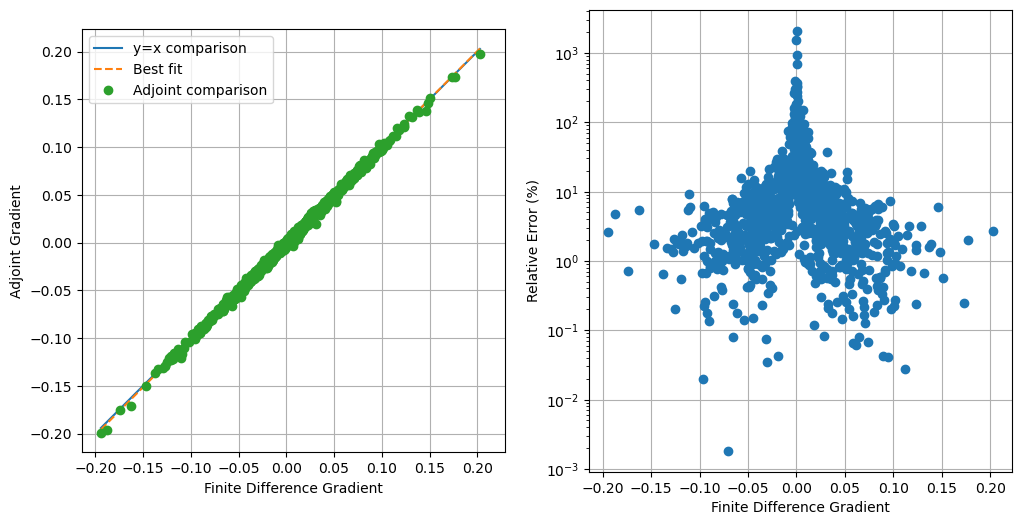

In [14]:
min_g = np.min(g_discrete)
max_g = np.max(g_discrete)

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot([min_g, max_g], [min_g, max_g], label="y=x comparison")
plt.plot([min_g, max_g], [m * min_g + b, m * max_g + b], "--", label="Best fit")
plt.plot(g_discrete, dJ_du_sum[idx], "o", label="Adjoint comparison")
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Adjoint Gradient")
plt.legend()
plt.grid(True)
plt.axis("square")

plt.subplot(1, 2, 2)
rel_err = (
    np.abs(np.squeeze(g_discrete) - np.squeeze(dJ_du_sum[idx]))
    / np.abs(np.squeeze(g_discrete))
    * 100
)
plt.semilogy(g_discrete, rel_err, "o")
plt.grid(True)
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Relative Error (%)")
plt.show()

plt.savefig("graph.png")
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() # closes the current figure
plt.show()

     block, center = (0,0,0.19)
          size (3.68,3.68,1.76)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,-1.07)
          size (5.18,5.18,0.76)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     block, center = (0,0,-1.76)
          size (5.18,5.18,0.62)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)


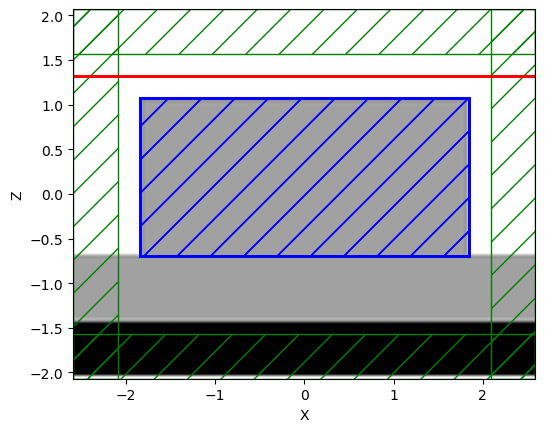

In [15]:
opt.plot2D(True,output_plane = mp.Volume(size = (np.inf, 0, np.inf), center = (0,0,0)))

In [16]:
print(design_variables.weights)

[0. 0. 0. ... 0. 0. 0.]
